In [30]:
%run './model/corpus.py'

import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import polars as pl

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances, cosine_similarity

# sns.set(rc = {'figure.figsize':(15,8)})


In [2]:
corpus = Corpus("genomics")


            Nodes: 30907
            Edges: 145815
            Df: (30913, 13)
        


In [25]:
G = corpus.citation_graph
centralities = nx.in_degree_centrality(G).values()
max_centrality = max(centralities)
d = sum(c - max_centrality for c in centralities)

G_star = nx.star_graph(len(G)-1).to_directed()
for (u, v) in list(G_star.edges()):
    if u == 0: G_star.remove_edge(u, v)

centralities_star = nx.in_degree_centrality(G_star).values()
max_centrality_star = max(centralities_star)
d_star = sum(c - max_centrality_star for c in centralities_star)

d / d_star

0.03702579309285054

In [3]:
corpus.citation_df.null_count()

shape: (1, 13)
┌─────┬─────────┬───────┬──────────┬─────┬──────┬──────┬────────────┬──────────────┐
│ Doi ┆ Authors ┆ Title ┆ Abstract ┆ ... ┆ Date ┆ Text ┆ References ┆ InCentrality │
│ --- ┆ ---     ┆ ---   ┆ ---      ┆     ┆ ---  ┆ ---  ┆ ---        ┆ ---          │
│ u32 ┆ u32     ┆ u32   ┆ u32      ┆     ┆ u32  ┆ u32  ┆ u32        ┆ u32          │
╞═════╪═════════╪═══════╪══════════╪═════╪══════╪══════╪════════════╪══════════════╡
│ 0   ┆ 0       ┆ 0     ┆ 167      ┆ ... ┆ 0    ┆ 0    ┆ 0          ┆ 0            │
└─────┴─────────┴───────┴──────────┴─────┴──────┴──────┴────────────┴──────────────┘

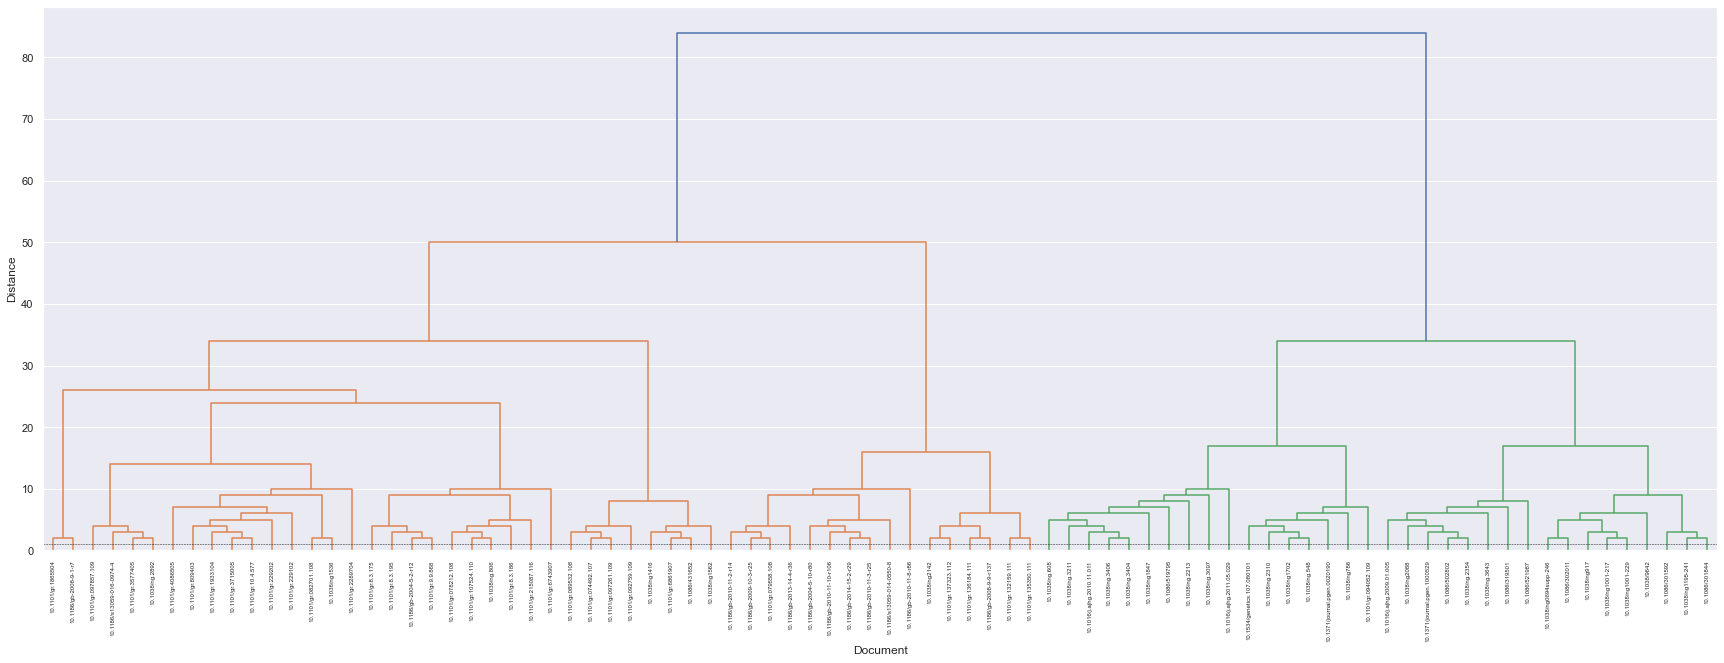

In [4]:
nodes = corpus.most_referenced(100).get_column('Doi').to_list()
# nodes = corpus.citation_df.get_column('Doi').to_list()
G = corpus.citation_graph.subgraph(nodes)
nodes = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(nodes)

levels = list(community.girvan_newman(G))
levels.insert(0, (set(nodes),))

comm_ids = defaultdict(dict)
id = 0
for (l, level) in enumerate(levels):
    temp = dict()
    for (c, comm) in enumerate(level):
        sorted_comm = tuple(sorted(comm))
        temp[sorted_comm] = id
        id += 1
    comm_ids[l] = temp

last = len(levels)-1
edges = []
leaf_map = {}

for (l, level) in enumerate(levels[1:]):

    current_level = l + 1
    previous_level = l

    for child_comm in level:

        parent_comm = next(filter(lambda parent_comm: child_comm.issubset(parent_comm), levels[l]))
        sorted_parent_comm = tuple(sorted(parent_comm))
        sorted_child_comm = tuple(sorted(child_comm))

        parent_comm_id = comm_ids[previous_level][sorted_parent_comm]
        child_comm_id = comm_ids[current_level][sorted_child_comm]

        edges.append((parent_comm_id, child_comm_id))

        if current_level == last:    
            leaf_map[child_comm_id] = next(iter(child_comm))

G_dendo = nx.DiGraph()
G_dendo.add_edges_from(edges)

d = nx.to_dict_of_lists(G_dendo, nodelist=None)

G_dendo     = nx.DiGraph(d)
nodes       = G_dendo.nodes()
leaves      = set( n for n in nodes if G_dendo.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G_dendo.out_degree(n) > 0 ]

subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(d[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += d[v]

    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n]))

leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = d[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(subtree[x])], index[tuple(subtree[y])]
        Z.append([i, j, float(len(subtree[n])), len(z)])
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

leaves = [leaf_map[l] for l in leaves]

sns.set()

fig = plt.figure(figsize=(30, 10))
axes = fig.subplots(1)
plt.title('')
plt.xlabel('Document')
plt.ylabel('Distance')
dendrogram(Z, labels=leaves)
axes.yaxis.grid(True)
axes.xaxis.grid(False)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)
fig.set_facecolor('w')
plt.xticks(rotation=90)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


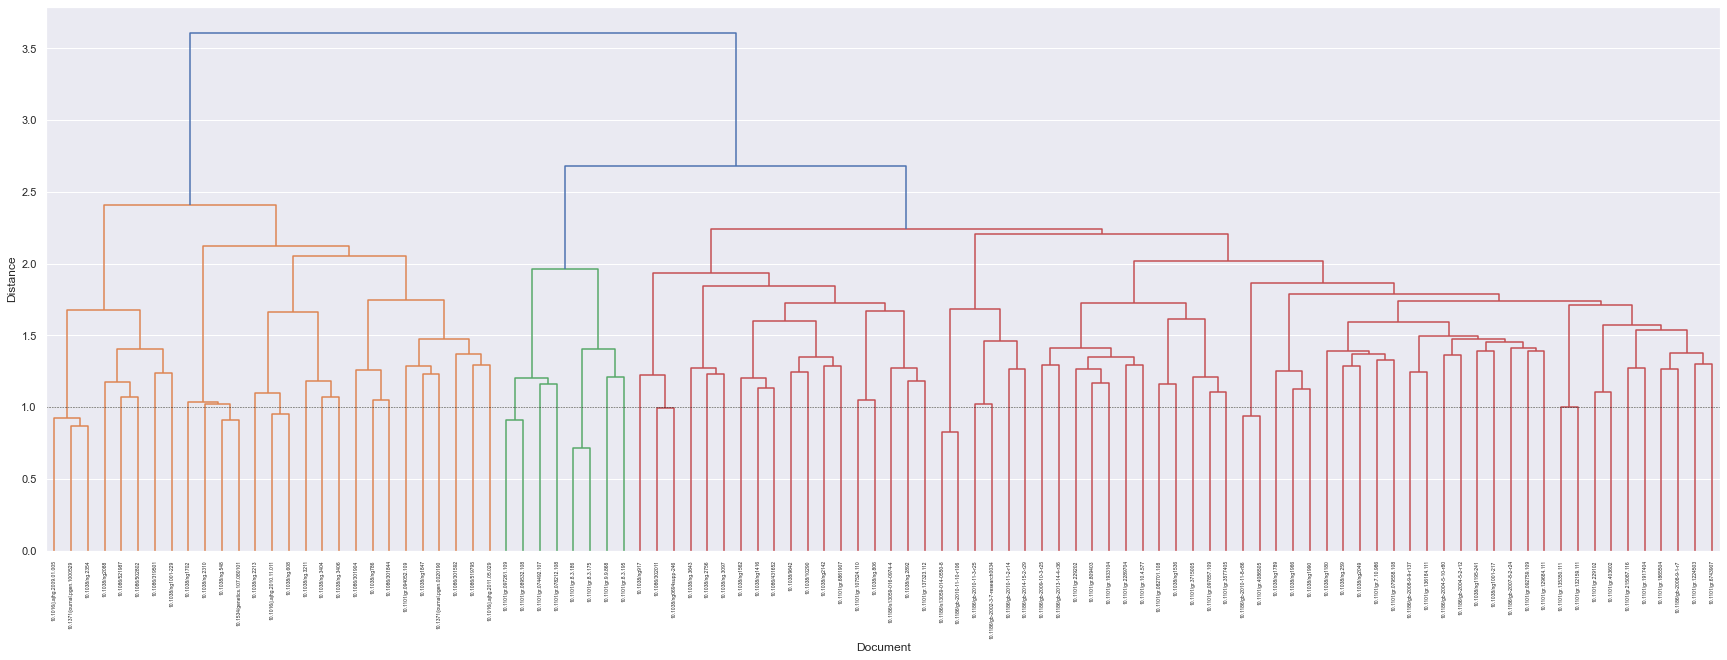

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances, cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

df = corpus.citation_df
 
dois = df.get_column('Doi').to_list()
corpus_ = df.get_column('Text').to_list()

tv = TfidfVectorizer(min_df=0.,
                     max_df=1.,
                     norm='l2',
                     use_idf=True,
                     smooth_idf=True)

tv_matrix = tv.fit_transform(corpus_)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()

documents = corpus.most_referenced(100)
document_dois = documents.get_column('Doi').to_list()
document_texts = documents.get_column('Text').to_list()

indices = [dois.index(doi) for doi in document_dois]
m = tv_matrix[indices]

similarity = cosine_similarity(m).round(decimals=3, out=None)

Z = linkage(similarity, 'ward')

fig = plt.figure(figsize=(30, 10))
axes = fig.subplots(1)
plt.title('')
plt.xlabel('Document')
plt.ylabel('Distance')
dendrogram(Z, labels=document_dois)
axes.yaxis.grid(True)
axes.xaxis.grid(False)
fig.set_facecolor('w')
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

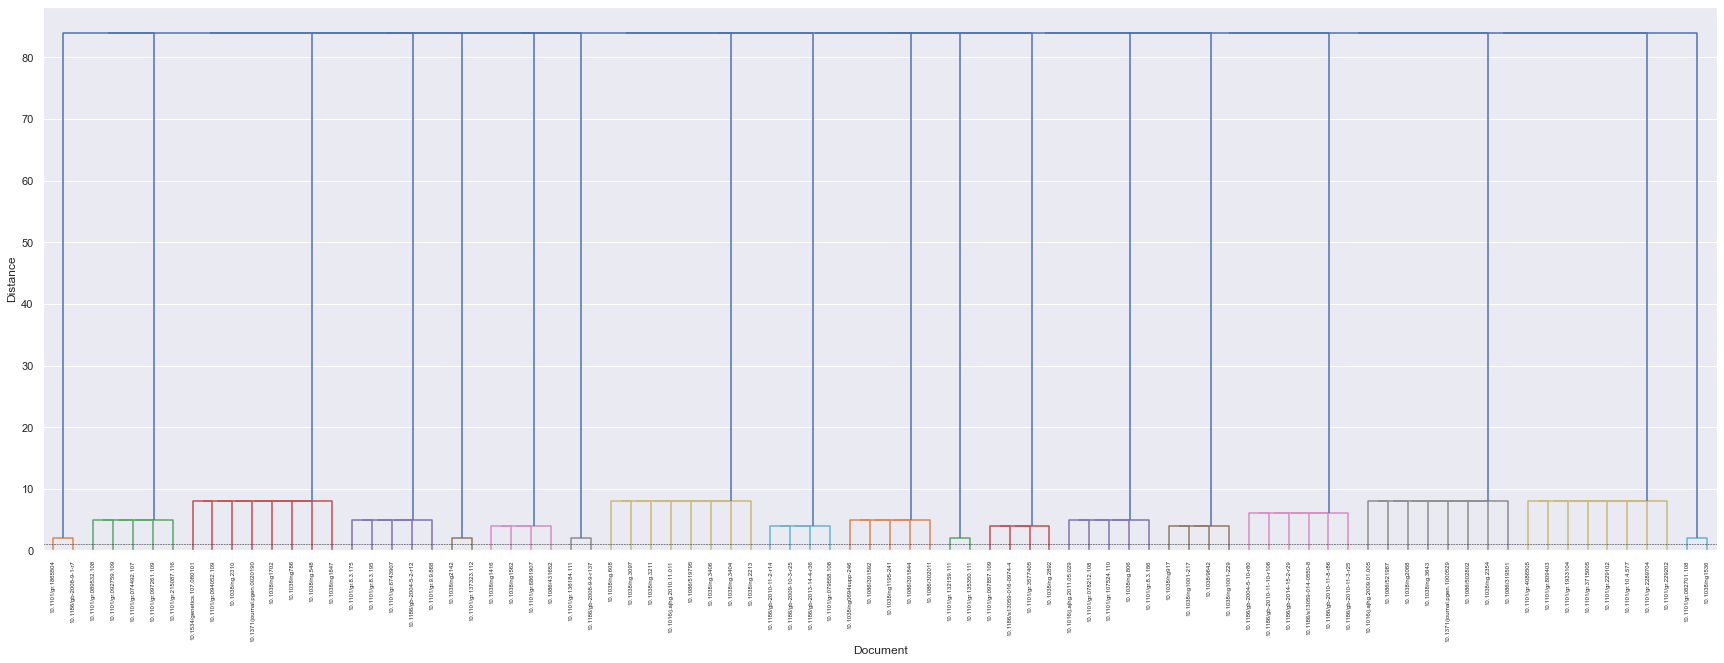

In [29]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

nodes = corpus.most_referenced(100).get_column('Doi').to_list()
G = corpus.citation_graph.subgraph(nodes)
nodes = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(nodes)
nodes = G.nodes()

pos = nx.spring_layout(G)

levels = list(community.louvain_partitions(G, weight=None, resolution=1, threshold=1e-07, seed=None))
levels.insert(0, (set(nodes),))
levels.append(tuple({n} for n in nodes))

comm_ids = defaultdict(dict)
id = 0
for (l, level) in enumerate(levels):
    temp = dict()
    for (c, comm) in enumerate(level):
        sorted_comm = tuple(sorted(comm))
        temp[sorted_comm] = id
        id += 1
    comm_ids[l] = temp

last = len(levels)-1
edges = []
leaf_map = {}

for (l, level) in enumerate(levels[1:]):

    current_level = l + 1
    previous_level = l

    for child_comm in level:

        parent_comm = next(filter(lambda parent_comm: child_comm.issubset(parent_comm), levels[l]))
        sorted_parent_comm = tuple(sorted(parent_comm))
        sorted_child_comm = tuple(sorted(child_comm))

        parent_comm_id = comm_ids[previous_level][sorted_parent_comm]
        child_comm_id = comm_ids[current_level][sorted_child_comm]

        edges.append((parent_comm_id, child_comm_id))

        if current_level == last:    
            leaf_map[child_comm_id] = next(iter(child_comm))

G_dendo = nx.DiGraph()
G_dendo.add_edges_from(edges)

d = nx.to_dict_of_lists(G_dendo, nodelist=None)

G           = nx.DiGraph(d)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(d[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += d[v]

    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n]))

leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = d[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(subtree[x])], index[tuple(subtree[y])]
        Z.append([i, j, float(len(subtree[n])), len(z)])
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

leaves = [leaf_map[l] for l in leaves]

fig = plt.figure(figsize=(30, 10))
axes = fig.subplots(1)
plt.title('')
plt.xlabel('Document')
plt.ylabel('Distance')
dendrogram(Z, labels=leaves)
axes.yaxis.grid(True)
axes.xaxis.grid(False)
fig.set_facecolor('w')
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)
plt.show()

In [32]:
df = corpus.citation_df


df.sort('Date')

shape: (30913, 13)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬──────────┬────────────┐
│ Doi       ┆ Authors   ┆ Title     ┆ Abstract ┆ ... ┆ Date     ┆ Text     ┆ Referenc ┆ InCentrali │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ ---      ┆ ---      ┆ es       ┆ ty         │
│ str       ┆ list[str] ┆ str       ┆ str      ┆     ┆ date     ┆ str      ┆ ---      ┆ ---        │
│           ┆           ┆           ┆          ┆     ┆          ┆          ┆ list[str ┆ f32        │
│           ┆           ┆           ┆          ┆     ┆          ┆          ┆ ]        ┆            │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪══════════╪════════════╡
│ 10.1038/n ┆ ["dlouhy, ┆ linkage   ┆ The      ┆ ... ┆ 1992-04- ┆ linkage  ┆ ["10.103 ┆ 0.000032   │
│ g0492-64  ┆ sr",      ┆ of the    ┆ Indiana  ┆     ┆ 01       ┆ indiana  ┆ 8/ng0492 ┆            │
│           ┆ "hsiao,   ┆ indiana   ┆ kindred  ┆     ┆          ┆ kindred  ┆ -68"]    ┆            │
│           ┆ k", ...   ┆ kindred   ┆ variant  ┆     ┆          ┆ gerstman ┆          ┆            │
│           ┆ "...      ┆ o...      ┆ of G...  ┆     ┆          ┆ ...      ┆          ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1038/n ┆ ["hsiao,  ┆ mutant    ┆ Two      ┆ ... ┆ 1992-04- ┆ mutant   ┆ ["10.103 ┆ 0.000097   │
│ g0492-68  ┆ k",       ┆ prion     ┆ families ┆     ┆ 01       ┆ prion    ┆ 8/ng0492 ┆            │
│           ┆ "dlouhy,  ┆ proteins  ┆ with Ger ┆     ┆          ┆ protein  ┆ -64"]    ┆            │
│           ┆ sr", ...  ┆ in gerstm ┆ stmann-S ┆     ┆          ┆ gerstman ┆          ┆            │
│           ┆ "...      ┆ a...      ┆ tra...   ┆     ┆          ┆ nst...   ┆          ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1038/n ┆ ["timmerm ┆ the perip ┆ Charcot- ┆ ... ┆ 1992-06- ┆ peripher ┆ ["10.103 ┆ 0.000518   │
│ g0692-171 ┆ an, v",   ┆ heral     ┆ Marie-To ┆     ┆ 01       ┆ al       ┆ 8/ng0492 ┆            │
│           ┆ "nelis,   ┆ myelin    ┆ oth      ┆     ┆          ┆ myelin   ┆ -29"]    ┆            │
│           ┆ e",       ┆ protein   ┆ disease  ┆     ┆          ┆ protein  ┆          ┆            │
│           ┆ ......    ┆ ge...     ┆ (CMT...  ┆     ┆          ┆ gene     ┆          ┆            │
│           ┆           ┆           ┆          ┆     ┆          ┆ p...     ┆          ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1038/n ┆ ["bates,  ┆ character ┆ The Hunt ┆ ... ┆ 1992-06- ┆ characte ┆ ["10.103 ┆ 0.000162   │
│ g0692-180 ┆ gp",      ┆ ization   ┆ ington's ┆     ┆ 01       ┆ rization ┆ 8/ng0592 ┆            │
│           ┆ "valdes,  ┆ of a      ┆ disease  ┆     ┆          ┆ yeast    ┆ -99"]    ┆            │
│           ┆ j", ...   ┆ yeast     ┆ (HD)     ┆     ┆          ┆ artifici ┆          ┆            │
│           ┆ "...      ┆ arti...   ┆ ge...    ┆     ┆          ┆ a...     ┆          ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...       ┆ ...       ┆ ...       ┆ ...      ┆ ... ┆ ...      ┆ ...      ┆ ...      ┆ ...        │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1186/s ┆ ["wang,   ┆ n-4-acety ┆ Backgrou ┆ ... ┆ 2022-01- ┆ nacetyld ┆ ["10.103 ┆ 0.0        │
│ 13059-021 ┆ s", "xie, ┆ ldeoxycyt ┆ nd       ┆     ┆ 01       ┆ eoxycyto ┆ 8/ng.385 ┆            │
│ -02578-7  ┆ hr", ...  ┆ osine dna ┆ Direct   ┆     ┆          ┆ sine dna ┆ 9", "10. ┆            │
│           ┆ "wu, ...  ┆ modi...   ┆ analogs  ┆     ┆          ┆ modific. ┆ 1038/ng1 ┆            │
│           ┆           ┆           ┆ of       ┆     ┆          ┆ ..       ┆ ...      ┆            │
│           ┆           ┆           ┆ che.

In [82]:
from networkx.algorithms import community

communities = list(community.louvain_communities(G, weight=None))

In [83]:
len(communities)

3483

In [84]:
from networkx.algorithms import community

communities = list(community.louvain_partitions(G, weight=None))

In [86]:
len(communities[0])

3476

In [2]:
corpus = Corpus("genomics")

In [4]:
most_referenced_nodes = corpus.most_referenced(1000).get_column('Doi').to_list()

top_df = corpus.citation_df.filter(pl.col('Doi').is_in(most_referenced_nodes))

[dois, texts] = top_df.select(["Doi", "Text"]).get_columns();
dois = dois.to_list()
texts = texts.to_list()

In [30]:

import itertools

df = pl.read_parquet('./output/organizations/community/louvain_communities.parquet')
print(df.shape)
[ids, communities] = df.select(['id', 'community']).get_columns()

(1621, 2)


In [31]:

community_texts = {}
for (id, community) in zip(ids, communities):
    texts = corpus.citation_df.filter(pl.col("Doi").is_in(community)).get_column('Text').to_list()
    merged_texts = list(itertools.chain.from_iterable(texts))
    community_texts[id] = merged_texts

In [32]:
len(community_texts.items())

1621

In [46]:
corpus.citation_df.with_column(pl.col('Text').arr.lengths())
corpus.citation_df.with_column(pl.col('Text').arr.)

shape: (32779, 13)
┌───────────┬────────────┬───────────┬───────────┬─────┬───────────┬──────────┬──────────┬─────────┐
│ Area      ┆ AuthorKeyw ┆ Abstract  ┆ Title     ┆ ... ┆ Authors   ┆ Date     ┆ Text     ┆ TextLen │
│ ---       ┆ ords       ┆ ---       ┆ ---       ┆     ┆ ---       ┆ ---      ┆ ---      ┆ ---     │
│ list[str] ┆ ---        ┆ str       ┆ str       ┆     ┆ list[str] ┆ datetime ┆ list[str ┆ u32     │
│           ┆ list[str]  ┆           ┆           ┆     ┆           ┆ [ms]     ┆ ]        ┆         │
╞═══════════╪════════════╪═══════════╪═══════════╪═════╪═══════════╪══════════╪══════════╪═════════╡
│ ["sociolo ┆ null       ┆ Recently, ┆ Rankings  ┆ ... ┆ ["espelan ┆ 2007-07- ┆ ["rank", ┆ 81      │
│ gy"]      ┆            ┆ there has ┆ and react ┆     ┆ d, wn",   ┆ 01       ┆ "reactiv ┆         │
│           ┆            ┆ been a    ┆ ivity:    ┆     ┆ "sauder,  ┆ 00:00:00 ┆ ", ...   ┆         │
│           ┆            ┆ proli...  ┆ How       ┆     ┆ m"]       ┆          ┆ "systema ┆         │
│           ┆            ┆           ┆ pub...    ┆     ┆           ┆          ┆ ...      ┆         │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ ["sociolo ┆ null       ┆ Debates   ┆ The       ┆ ... ┆ ["korpi,  ┆ 1998-10- ┆ ["parado ┆ 120     │
│ gy"]      ┆            ┆ on how to ┆ paradox   ┆     ┆ w",       ┆ 01       ┆ x", "red ┆         │
│           ┆            ┆ reduce    ┆ of redist ┆     ┆ "palme,   ┆ 00:00:00 ┆ istribut ┆         │
│           ┆            ┆ poverty.. ┆ ribution  ┆     ┆ j"]       ┆          ┆ ", ...   ┆         │
│           ┆            ┆ .         ┆ an...     ┆     ┆           ┆          ┆ "...     ┆         │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ ["busines ┆ null       ┆ Do firms  ┆ The relat ┆ ... ┆ ["henriqu ┆ 1999-02- ┆ ["relati ┆ 56      │
│ s & econo ┆            ┆ committed ┆ ionship   ┆     ┆ es, i",   ┆ 01       ┆ onship", ┆         │
│ mics"]    ┆            ┆ to stewar ┆ between   ┆     ┆ "sadorsky ┆ 00:00:00 ┆ "environ ┆         │
│           ┆            ┆ dshi...   ┆ environ.. ┆     ┆ , p"]     ┆          ┆ ment",   ┆         │
│           ┆            ┆           ┆ .         ┆     ┆           ┆          ┆ ...      ┆         │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ ["busines ┆ ["innovati ┆ Achieving ┆ Exploitat ┆ ... ┆ ["andriop ┆ 2009-07- ┆ ["exploi ┆ 139     │
│ s & econo ┆ on", "orga ┆ exploitat ┆ ion-Explo ┆     ┆ oulos,    ┆ 01       ┆ t", "exp ┆         │
│ mics"]    ┆ nizational ┆ ion and   ┆ ration    ┆     ┆ c",       ┆ 00:00:00 ┆ lor",    ┆         │
│           ┆ a...       ┆ explo...  ┆ Tension.. ┆     ┆ "lewis,   ┆          ┆ ... "ten ┆         │
│           ┆            ┆           ┆ .         ┆     ┆ mw"]      ┆          ┆ si...    ┆         │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ ...       ┆ ...        ┆ ...       ┆ ...       ┆ ... ┆ ...       ┆ ...      ┆ ...      ┆ ...     │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ ["compute ┆ ["global   ┆ The trend ┆ PROBLEMS  ┆ ... ┆ ["steinba ┆ 1992-03- ┆ ["proble ┆ 153     │
│ r         ┆ networks", ┆ toward    ┆ AND       ┆     ┆ rt, pj",  ┆ 01       ┆ m",      ┆         │
│ science", ┆ "internati ┆ global    ┆ ISSUES IN ┆     ┆ "nath,    ┆ 00:00:00 ┆ "issu",  ┆         │
│ "informat ┆ on...      ┆ competit. ┆ THE       ┆     ┆ r"]       ┆          ┆ ...      ┆         │
│ io...     ┆            ┆ ..        ┆ MANAG...  ┆     ┆           ┆          ┆ "flow"]  ┆         │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ ["compute ┆ ["message  ┆ This      ┆ Cost/Bene ┆ ... ┆ ["montgom ┆ 1983-03- ┆ ["cost", ┆ 53      │
│ r         ┆ systems",  ┆ article   ┆ fit

In [9]:
len(community_texts[3])

142319

In [38]:
# documents = texts
dois = community_texts.keys()
documents = community_texts.values()

print('Unique words')
unique_words = set()
for docuemnt in documents:
    unique_words.update(docuemnt)

print('TF')
tfs = {}
for (doi, document) in zip(dois, documents):
    num_words = len(document)
    temp_tfs = {}
    for term in document:
        temp_tfs[term] = document.count(term) / num_words
    tfs[doi] = temp_tfs

print('IDF')
N = len(documents)
idfs = dict.fromkeys(unique_words, 0)
for term in unique_words:
    count = 0
    for document in documents:
        if term in document:
            count += 1
    idfs[term] = math.log(N / count)

print('TFIDF')
tfidfs = {}
for doi in dois:
    temp_tfidf = {}
    for (term, tf) in tfs[doi].items():
        temp_tfidf[term] = idfs[term] * tf
    tfidfs[doi] = temp_tfidf

Unique words
TF
IDF
TFIDF


In [7]:
list_tfidfs = list(tfidfs.items())
tfidf = list_tfidfs[500]
sorted(tfidf[1].items(), key=lambda x: x[1], reverse=True)

[('threat', 0.5212689972856158),
 ('opportun', 0.27016247265970367),
 ('action', 0.1318099585854483),
 ('dimens', 0.1214733183280462),
 ('rigid', 0.10102402704202329),
 ('prospect', 0.10102402704202329),
 ('respons', 0.09863185759598812),
 ('moder', 0.09735624357541245),
 ('taken', 0.0868781662142693),
 ('main', 0.0868781662142693),
 ('associ', 0.08143947126634309),
 ('hypothesi', 0.07604901823340869),
 ('organiz', 0.068514568235578),
 ('differenti', 0.058082513689570084),
 ('compar', 0.05618270913720249),
 ('better', 0.05618270913720249),
 ('model', 0.05272477871142506),
 ('characterist', 0.05171966421955291),
 ('direct', 0.048366540723812586),
 ('lead', 0.0471657141927323),
 ('predict', 0.04630930196622145),
 ('effect', 0.04489917238159523),
 ('understand', 0.043689278157074365),
 ('literatur', 0.043203346551080116),
 ('test', 0.035496605548738874),
 ('studi', 0.034257284117789),
 ('differ', 0.030681008819284365),
 ('theori', 0.02398204438171741)]

In [48]:
word_counts = {}
for (doi, text) in zip(dois, texts):
    num_words = dict.fromkeys(unique_words, 0)
    for word in text:
        num_words[word] += 1
    word_counts[doi] = num_words

In [49]:
from collections import Counter

doc_tfs = {}
for (doi, text) in zip(dois, texts):
    tfs = {}
    for (word, count) in Counter(text).items():
        tfs[word] = count / len(text)
    doc_tfs[doi] = tfs

N = len(texts)

In [50]:
doc_counts = dict.fromkeys(unique_words, 0)

for word in unique_words:
    for (doi, text) in zip(dois, texts):
        if word in text:
            doc_counts[word] += 1




In [51]:
list(doc_counters.items())[0]

NameError: name 'doc_counters' is not defined

In [16]:

def TF(word_dict, bow):
    tf_dict = {}
    bow_count = len(bow)
    for word, count in word_dict.items():
        tf_dict[word] = count / float(bow_count)
    return tf_dict

def IDF(documents):
    # print(documents)
    N = len(documents)
    # print(documents[0])
    idf_dict = dict.fromkeys(documents[0].keys(), 0)
    # print(idf_dict)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idf_dict[word] += 1
    
    for word, val in idf_dict.items():
        idf_dict[word] = math.log(N / float(val))
    return idf_dict

def TFIDF(tf_bow, idfs):
    tfidf = {}
    for word, val in tf_bow.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [86]:
tfs = {}
for (doi, text) in zip(dois, texts):
    tf = TF(word_counts[doi], text)
    tfs[doi] = tf

idfs = IDF(list(word_counts.values()))

tfidfs = {}
for doi in dois:
    tfidfs[doi] = TFIDF(tfs[doi], idfs)

In [65]:
top_nodes

['10.1287/orsc.2.1.71',
 '10.1287/orsc.3.3.383',
 '10.2307/259056',
 '10.1002/smj.4250171110',
 '10.1002/smj.4250141009',
 '10.1002/smj.4250140303',
 '10.2307/2393808',
 '10.2307/2393988',
 '10.1002/smj.4250140105',
 '10.1287/orsc.5.1.14',
 '10.2307/256729',
 '10.1002/smj.4250131009',
 '10.1002/smj.4250171105',
 '10.1287/orsc.13.3.339.2780',
 '10.2307/4134351',
 '10.2307/2667032',
 '10.1287/orsc.2.1.88',
 '10.2307/2096399',
 '10.2307/2666998',
 '10.2307/256741',
 '10.2307/2393807',
 '10.2307/2667105',
 '10.1002/smj.4250171108',
 '10.5465/amr.2000.2791611',
 '10.2307/258792',
 '10.2307/256759',
 '10.2307/258836',
 '10.2307/256474',
 '10.2307/3069433',
 '10.1287/orsc.7.4.375',
 '10.2307/259247',
 '10.1086/230091',
 '10.5465/AMR.2007.23466005',
 '10.1002/smj.318',
 '10.2307/1251915',
 '10.1002/smj.4250150906',
 '10.1002/smj.332',
 '10.1287/orsc.7.2.136',
 '10.1287/orsc.7.5.502',
 '10.2307/2393616',
 '10.1002/smj.160',
 '10.2307/256683',
 '10.1287/orsc.6.1.76',
 '10.5465/AMR.1995.950327199

In [68]:
doi = '10.1287/orsc.2.1.71'
doi = '10.1287/orsc.3.3.383'
# doi = '10.2307/259056'
sorted(tfidfs[doi].items(), key=lambda x: x[1], reverse=True)

[('knowledge', 0.09510632823617873),
 ('imitation', 0.07201271696314253),
 ('know', 0.06870323944426258),
 ('cooperate', 0.05970869862521425),
 ('replication', 0.05436774829287634),
 ('firm', 0.0535729079454392),
 ('exist', 0.050748955893802086),
 ('held', 0.04885061402262974),
 ('individual', 0.04644367786017994),
 ('new', 0.043772540122572326),
 ('skill', 0.04097394151626673),
 ('transfer', 0.039733040471210006),
 ('check', 0.0389988829059827),
 ('understand', 0.03861440328015032),
 ('technology', 0.037667779112990296),
 ('capability', 0.03539167582961775),
 ('combinative', 0.035060546652801186),
 ('cooperating', 0.035060546652801186),
 ('equivalent', 0.035060546652801186),
 ('recombining', 0.035060546652801186),
 ('regularity', 0.035060546652801186),
 ('argument', 0.03331792907646169),
 ('deter', 0.032756767629459345),
 ('buy', 0.031122210399619682),
 ('easily', 0.031122210399619682),
 ('expressed', 0.031122210399619682),
 ('consists', 0.029854349312607126),
 ('appealing', 0.0298543

In [4]:
top_nodes

['10.1287/orsc.2.1.71',
 '10.1287/orsc.3.3.383',
 '10.2307/259056',
 '10.1002/smj.4250171110',
 '10.1002/smj.4250141009',
 '10.1002/smj.4250140303',
 '10.2307/2393808',
 '10.2307/2393988',
 '10.1002/smj.4250140105',
 '10.1287/orsc.5.1.14']

In [43]:
from collections import defaultdict


temporality_df = corpus.citation_df.groupby('Date').agg([pl.col('Doi')]).sort('Date').with_column(pl.col('Doi').arr.lengths().alias('Count'))
dois = sorted(temporality_df.get_column('Doi').explode().to_list())
dates = temporality_df.get_column('Date')
G_all = corpus.citation_graph

columns = [(doi, float) for doi in dois]

temporal_centralities = defaultdict(list)

for date in pd.date_range(dates.min(), dates.max(), freq='M'):

    nodes = temporality_df.filter(pl.col('Date') <= date).get_column('Doi').explode().to_list()
    temp_G = G_all.subgraph(nodes)
    centrality_map = nx.in_degree_centrality(temp_G)

    keys_t = np.array(list(centrality_map.keys()))
    values_t = np.array(list(centrality_map.values()))

    other_keys = list(set(dois) - set(centrality_map.keys()))
    other_values = np.full((len(other_keys),), None)

    keys = np.concatenate((keys_t, other_keys), axis=None)
    values = np.concatenate((values_t, other_values), axis=None)

    for (k, v) in zip(keys, values):
        temporal_centralities[k].append(v)

    print(f'\r{date}', flush=True, end='')
    
temporal_centrality_df = pl.from_dict(temporal_centralities)

output_path = './output/organizations/centrality/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
temporal_centrality_df.write_parquet(output_path + 'temporal_in_centrality.parquet')

2022-02-28 00:00:00

In [44]:
len(temporal_centralities.keys()), len(dois)

(34217, 34217)

In [41]:


data1 = {'a': [1.1], 'b': [2.2], 'c': [3.3]}
data2 = {'c': [1.1], 'a': [2.2], 'b': [3.3]}


df1 = pl.from_dict(data1)
df2 = pl.from_dict(data2)

pl.concat([df1, df2])

# df1.vstack(df2)

SchemaError: cannot vstack: because column names in the two DataFrames do not match for left.name='a' != right.name='c'

In [29]:
df1 = pl.DataFrame({
    'a': [1,2,3],
    'b': [1,2,3],
})

df1.with()

shape: (3, 3)
┌────────┬─────┬─────┐
│ row_nr ┆ a   ┆ b   │
│ ---    ┆ --- ┆ --- │
│ u32    ┆ i64 ┆ i64 │
╞════════╪═════╪═════╡
│ 0      ┆ 1   ┆ 1   │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌┤
│ 1      ┆ 2   ┆ 2   │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌┤
│ 2      ┆ 3   ┆ 3   │
└────────┴─────┴─────┘

In [32]:
g = (
    corpus.citation_df
        .groupby(['Doi'])
        .agg([
            pl.col('Doi')
                .cumcount()
                .len()
                .alias('CumCount')
        ])
        .with_column(
            pl.when(pl.col('CumCount') > 1)
            .then(
                pl.concat_str(
                    [pl.col('Doi'), pl.col('CumCount').cast(str)],
                    sep='/'
                )
            )
            .otherwise(pl.col('Doi'))
            .alias('NewDoi')
        )
)
# corpus.citation_df[g['Doi'].transform('size').gt(1),
    #    'Doi'] += '['+g.cumcount().astype(str)+']'

g


shape: (34217, 3)
┌──────────────────────────────┬──────────┬──────────────────────────────┐
│ Doi                          ┆ CumCount ┆ NewDoi                       │
│ ---                          ┆ ---      ┆ ---                          │
│ str                          ┆ u32      ┆ str                          │
╞══════════════════════════════╪══════════╪══════════════════════════════╡
│ 10.1080/19416520.2013.761403 ┆ 1        ┆ 10.1080/19416520.2013.761403 │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.2307/2393149              ┆ 1        ┆ 10.2307/2393149              │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1287/orsc.1120.0786       ┆ 1        ┆ 10.1287/orsc.1120.0786       │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1108/13673271011059491    ┆ 1        ┆ 10.1108/13673271011059491    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...                          ┆ ...      ┆ ...                          │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.5465/amj.2019.0392        ┆ 1        ┆ 10.5465/amj.2019.0392        │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.5465/AMR.2011.59330932    ┆ 1        ┆ 10.5465/AMR.2011.59330932    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1177/014920639001600108   ┆ 1        ┆ 10.1177/014920639001600108   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1016/j.socnet.2008.12.003 ┆ 1        ┆ 10.1016/j.socnet.2008.12.003 │
└──────────────────────────────┴──────────┴──────────────────────────────┘

In [215]:
centrality_df = pl.from_dicts(temporal_centrality)
centrality_df.head(5)

ComputeError: Could not append Float64(0.0) to builder; make sure that all rows have the same schema.
Or consider increasing the the 'schema_inference_length' argument.

In [219]:
C = temporal_centrality[0].keys()
for c in temporal_centrality:
    k = c.keys()
    if C != k:
        print(c)
        break
    C = k

In [212]:
data = [{"a": 1, "b": None}, {"a": 2, "b": None}, {"a": 3, "b": 6.}]
df = pl.from_dicts(data)
df

shape: (3, 2)
┌─────┬──────┐
│ a   ┆ b    │
│ --- ┆ ---  │
│ i64 ┆ f64  │
╞═════╪══════╡
│ 1   ┆ null │
├╌╌╌╌╌┼╌╌╌╌╌╌┤
│ 2   ┆ null │
├╌╌╌╌╌┼╌╌╌╌╌╌┤
│ 3   ┆ 6.0  │
└─────┴──────┘

In [207]:
# centrality_df = pl.DataFrame(centrality[0:2])

temporal_centrality[0]

{'10.2307/249083': 0.0,
 '10.2307/249085': 0.0,
 '10.2307/249084': 0.0,
 '10.4018/jitr.2008010105': polars.datatypes.Null,
 '10.1002/ajae.12003': polars.datatypes.Null,
 '10.1016/j.socnet.2017.01.003': polars.datatypes.Null,
 '10.1024//1421-0185.61.3.131': polars.datatypes.Null,
 '10.1007/s11747-007-0066-9': polars.datatypes.Null,
 '10.1016/j.jbusvent.2005.02.003': polars.datatypes.Null,
 '10.1016/j.ijpe.2003.06.004': polars.datatypes.Null,
 '10.1016/j.jaccpubpol.2020.106786': polars.datatypes.Null,
 '10.2307/249749': polars.datatypes.Null,
 '10.1016/j.pursup.2017.01.003': polars.datatypes.Null,
 '10.1177/000312240907400603': polars.datatypes.Null,
 '10.1002/smj.3291': polars.datatypes.Null,
 '10.1016/0149-2063(93)90054-Q': polars.datatypes.Null,
 '10.1177/0149206314566460': polars.datatypes.Null,
 '10.1016/j.jbusres.2020.03.037': polars.datatypes.Null,
 '10.1007/s10551-018-3854-x': polars.datatypes.Null,
 '10.1017/S0007123498000271': polars.datatypes.Null,
 '10.1002/(SICI)1097-0266(20

In [204]:
dates = ['2001', '2002', '2003', '2004', '2005']

n = ['a', 'b', 'c', 'd']

t1 = {'a': 1.1, 'b': 2.2}
t2 = {'a': 1.1, 'b': 2.2, 'c': 3.3}
t3 = {'a': 1.1, 'b': 2.2, 'c': 3.3, 'd': 4.4}



keys_t = np.array(list(t1.keys()))
values_t = np.array(list(t1.values()))

other_keys = list(set(n) - set(t1.keys()))
other_values = np.full((len(other_keys),), None)

keys = np.concatenate((keys_t, other_keys), axis=None)
values = np.concatenate((values_t, other_values), axis=None)

dict(zip(keys, values))
# np.pad(np.array(v1, dtype=float), (len(dates)-len(v),0), 'constant', constant_values=(np.nan,))

['a' 'b' 'd' 'c']
[1.1 2.2 None None]


{'a': 1.1, 'b': 2.2, 'd': None, 'c': None}

In [148]:
n = temporality_df.columns

a = [None] * len(n)

m = dict(zip(n, a))

template_df = pl.DataFrame(m)

template_df

shape: (0, 23428)
┌────────────┬────────────┬────────────┬────────────┬─────┬────────────┬────────────┬────────────┬────────────┐
│ 10.1086/51 ┆ 10.2307/23 ┆ 10.1177/00 ┆ 10.1086/37 ┆ ... ┆ 10.1177/01 ┆ 10.1086/22 ┆ 10.2307/24 ┆ 10.2307/24 │
│ 7897       ┆ 93938      ┆ 0312240406 ┆ 4404       ┆     ┆ 4920639301 ┆ 9945       ┆ 9701       ┆ 9073       │
│ ---        ┆ ---        ┆ 900203     ┆ ---        ┆     ┆ 900102     ┆ ---        ┆ ---        ┆ ---        │
│ f32        ┆ f32        ┆ ---        ┆ f32        ┆     ┆ ---        ┆ f32        ┆ f32        ┆ f32        │
│            ┆            ┆ f32        ┆            ┆     ┆ f32        ┆            ┆            ┆            │
╞════════════╪════════════╪════════════╪════════════╪═════╪════════════╪════════════╪════════════╪════════════╡
└────────────┴────────────┴────────────┴────────────┴─────┴────────────┴────────────┴────────────┴────────────┘

In [150]:
d = temporal_centrality[0]
d = {k: [v] for (k, v) in d.items()}
t_df = pl.from_dict(d)
t_df

shape: (1, 23428)
┌────────────┬────────────┬────────────┬────────────┬─────┬────────────┬────────────┬────────────┬────────────┐
│ 10.1086/51 ┆ 10.2307/23 ┆ 10.1177/00 ┆ 10.1086/37 ┆ ... ┆ 10.1177/01 ┆ 10.1086/22 ┆ 10.2307/24 ┆ 10.2307/24 │
│ 7897       ┆ 93938      ┆ 0312240406 ┆ 4404       ┆     ┆ 4920639301 ┆ 9945       ┆ 9701       ┆ 9073       │
│ ---        ┆ ---        ┆ 900203     ┆ ---        ┆     ┆ 900102     ┆ ---        ┆ ---        ┆ ---        │
│ f64        ┆ f64        ┆ ---        ┆ f64        ┆     ┆ ---        ┆ f64        ┆ f64        ┆ f64        │
│            ┆            ┆ f64        ┆            ┆     ┆ f64        ┆            ┆            ┆            │
╞════════════╪════════════╪════════════╪════════════╪═════╪════════════╪════════════╪════════════╪════════════╡
│ 0.002775   ┆ 0.005293   ┆ 0.000256   ┆ 0.000982   ┆ ... ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
└────────────┴────────────┴────────────┴────────────┴─────┴────────────┴────────────┴────────────┴────────────┘

In [152]:
template_df.hstack(t_df)

ShapeError: Could not create a new DataFrame from Series. The Series have different lengths.Got [shape: (0,)
Series: '10.1086/517897' [f32]
[
], shape: (0,)
Series: '10.2307/2393938' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900203' [f32]
[
], shape: (0,)
Series: '10.1086/374404' [f32]
[
], shape: (0,)
Series: '10.2307/2657333' [f32]
[
], shape: (0,)
Series: '10.1086/230320' [f32]
[
], shape: (0,)
Series: '10.1086/230321' [f32]
[
], shape: (0,)
Series: '10.2307/2096358' [f32]
[
], shape: (0,)
Series: '10.2307/256876' [f32]
[
], shape: (0,)
Series: '10.2307/256942' [f32]
[
], shape: (0,)
Series: '10.2307/256621' [f32]
[
], shape: (0,)
Series: '10.2307/259247' [f32]
[
], shape: (0,)
Series: '10.2307/256928' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0406' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.2005.69.4.61' [f32]
[
], shape: (0,)
Series: '10.2307/3094913' [f32]
[
], shape: (0,)
Series: '10.1002/smj.319' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.5.524' [f32]
[
], shape: (0,)
Series: '10.2307/20159573' [f32]
[
], shape: (0,)
Series: '10.2307/20159793' [f32]
[
], shape: (0,)
Series: '10.2307/2393655' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.3.290.2772' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0200' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.263.12503' [f32]
[
], shape: (0,)
Series: '10.2307/259204' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306290712' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.1.71' [f32]
[
], shape: (0,)
Series: '10.2307/2667089' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2005.16928421' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.17407911' [f32]
[
], shape: (0,)
Series: '10.2307/2393872' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.22083029' [f32]
[
], shape: (0,)
Series: '10.2307/2657415' [f32]
[
], shape: (0,)
Series: '10.1086/229971' [f32]
[
], shape: (0,)
Series: '10.1086/230578' [f32]
[
], shape: (0,)
Series: '10.2307/2095938' [f32]
[
], shape: (0,)
Series: '10.2307/2657300' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.25275520' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171010' [f32]
[
], shape: (0,)
Series: '10.2307/256972' [f32]
[
], shape: (0,)
Series: '10.2307/258597' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1995.9503271992' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.4.414.10639' [f32]
[
], shape: (0,)
Series: '10.2307/1556362' [f32]
[
], shape: (0,)
Series: '10.2307/256982' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.6.744.10082' [f32]
[
], shape: (0,)
Series: '10.2307/259251' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2001.4011987' [f32]
[
], shape: (0,)
Series: '10.2307/257056' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121008' [f32]
[
], shape: (0,)
Series: '10.2307/257052' [f32]
[
], shape: (0,)
Series: '10.1023/A:1024199411807' [f32]
[
], shape: (0,)
Series: '10.2307/257057' [f32]
[
], shape: (0,)
Series: '10.2307/2393295' [f32]
[
], shape: (0,)
Series: '10.2307/4134351' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00752.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150912' [f32]
[
], shape: (0,)
Series: '10.1002/smj.572' [f32]
[
], shape: (0,)
Series: '10.2307/1556403' [f32]
[
], shape: (0,)
Series: '10.2307/30040617' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2003.08.019' [f32]
[
], shape: (0,)
Series: '10.2307/3069338' [f32]
[
], shape: (0,)
Series: '10.2307/1556400' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.1.119' [f32]
[
], shape: (0,)
Series: '10.2307/1556394' [f32]
[
], shape: (0,)
Series: '10.2307/1556395' [f32]
[
], shape: (0,)
Series: '10.2307/258670' [f32]
[
], shape: (0,)
Series: '10.1002/smj.390' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2003.9416341' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160202' [f32]
[
], shape: (0,)
Series: '10.2307/259315' [f32]
[
], shape: (0,)
Series: '10.2307/30040614' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00493.x' [f32]
[
], shape: (0,)
Series: '10.2307/258906' [f32]
[
], shape: (0,)
Series: '10.2307/256722' [f32]
[
], shape: (0,)
Series: '10.1086/229939' [f32]
[
], shape: (0,)
Series: '10.2307/257008' [f32]
[
], shape: (0,)
Series: '10.2307/256961' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150910' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140303' [f32]
[
], shape: (0,)
Series: '10.2307/3094828' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.1.1' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.2.179' [f32]
[
], shape: (0,)
Series: '10.2307/2666999' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.6.611.12529' [f32]
[
], shape: (0,)
Series: '10.2307/2393640' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131009' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.1.98' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131013' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0405' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0361' [f32]
[
], shape: (0,)
Series: '10.2307/2657253' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57318391' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0697' [f32]
[
], shape: (0,)
Series: '10.2307/2667016' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.1.114' [f32]
[
], shape: (0,)
Series: '10.2307/256313' [f32]
[
], shape: (0,)
Series: '10.2307/2096398' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.285.12496' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0453' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.2.268' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0772' [f32]
[
], shape: (0,)
Series: '10.2307/3069293' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213486447' [f32]
[
], shape: (0,)
Series: '10.1086/653599' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.51142368' [f32]
[
], shape: (0,)
Series: '10.1086/367917' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2002.6588004' [f32]
[
], shape: (0,)
Series: '10.2307/3069287' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00828.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0013' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0709' [f32]
[
], shape: (0,)
Series: '10.2307/3069286' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57318905' [f32]
[
], shape: (0,)
Series: '10.2307/2393924' [f32]
[
], shape: (0,)
Series: '10.2307/2393593' [f32]
[
], shape: (0,)
Series: '10.2307/2393639' [f32]
[
], shape: (0,)
Series: '10.2307/3069294' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.43670890' [f32]
[
], shape: (0,)
Series: '10.2307/3069307' [f32]
[
], shape: (0,)
Series: '10.2307/30040653' [f32]
[
], shape: (0,)
Series: '10.2307/256589' [f32]
[
], shape: (0,)
Series: '10.2307/256657' [f32]
[
], shape: (0,)
Series: '10.2307/256701' [f32]
[
], shape: (0,)
Series: '10.2307/256689' [f32]
[
], shape: (0,)
Series: '10.2307/1556378' [f32]
[
], shape: (0,)
Series: '10.2307/30040662' [f32]
[
], shape: (0,)
Series: '10.2307/3069429' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1998.926624' [f32]
[
], shape: (0,)
Series: '10.2307/258770' [f32]
[
], shape: (0,)
Series: '10.2307/258851' [f32]
[
], shape: (0,)
Series: '10.2307/258792' [f32]
[
], shape: (0,)
Series: '10.2307/256727' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130702' [f32]
[
], shape: (0,)
Series: '10.2307/2393868' [f32]
[
], shape: (0,)
Series: '10.2307/256655' [f32]
[
], shape: (0,)
Series: '10.2307/2393715' [f32]
[
], shape: (0,)
Series: '10.2307/2393795' [f32]
[
], shape: (0,)
Series: '10.2307/2096397' [f32]
[
], shape: (0,)
Series: '10.2307/2096316' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.2.177' [f32]
[
], shape: (0,)
Series: '10.2307/256874' [f32]
[
], shape: (0,)
Series: '10.2307/256715' [f32]
[
], shape: (0,)
Series: '10.2307/256934' [f32]
[
], shape: (0,)
Series: '10.2307/256789' [f32]
[
], shape: (0,)
Series: '10.2307/256912' [f32]
[
], shape: (0,)
Series: '10.2307/258707' [f32]
[
], shape: (0,)
Series: '10.2307/3094827' [f32]
[
], shape: (0,)
Series: '10.2307/259269' [f32]
[
], shape: (0,)
Series: '10.2307/2393855' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.4.502.10637' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.3.321' [f32]
[
], shape: (0,)
Series: '10.2307/2393678' [f32]
[
], shape: (0,)
Series: '10.2307/2393234' [f32]
[
], shape: (0,)
Series: '10.2307/2667032' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.1.1' [f32]
[
], shape: (0,)
Series: '10.1086/230191' [f32]
[
], shape: (0,)
Series: '10.2307/2657442' [f32]
[
], shape: (0,)
Series: '10.2307/2657252' [f32]
[
], shape: (0,)
Series: '10.2307/2096399' [f32]
[
], shape: (0,)
Series: '10.2307/2393936' [f32]
[
], shape: (0,)
Series: '10.2307/2393235' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.363' [f32]
[
], shape: (0,)
Series: '10.2307/256522' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<317::AID-SMJ90>3.0.CO;2-B' [f32]
[
], shape: (0,)
Series: '10.2307/256781' [f32]
[
], shape: (0,)
Series: '10.2307/259056' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.2.136' [f32]
[
], shape: (0,)
Series: '10.2307/256729' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150404' [f32]
[
], shape: (0,)
Series: '10.1086/230637' [f32]
[
], shape: (0,)
Series: '10.2307/2393988' [f32]
[
], shape: (0,)
Series: '10.2307/256886' [f32]
[
], shape: (0,)
Series: '10.2307/2393679' [f32]
[
], shape: (0,)
Series: '10.2307/2666998' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.2.109' [f32]
[
], shape: (0,)
Series: '10.2307/257025' [f32]
[
], shape: (0,)
Series: '10.2307/256741' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800205' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130502' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000302' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130606' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900301' [f32]
[
], shape: (0,)
Series: '10.2307/256838' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140104' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160106' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140802' [f32]
[
], shape: (0,)
Series: '10.1086/321301' [f32]
[
], shape: (0,)
Series: '10.1086/210004' [f32]
[
], shape: (0,)
Series: '10.1086/230408' [f32]
[
], shape: (0,)
Series: '10.2307/2096202' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(93)90023-X' [f32]
[
], shape: (0,)
Series: '10.1086/230091' [f32]
[
], shape: (0,)
Series: '10.2307/2393299' [f32]
[
], shape: (0,)
Series: '10.1086/316962' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.69.2.42.60756' [f32]
[
], shape: (0,)
Series: '10.1002/smj.246' [f32]
[
], shape: (0,)
Series: '10.2307/1251915' [f32]
[
], shape: (0,)
Series: '10.2307/256992' [f32]
[
], shape: (0,)
Series: '10.1002/smj.197' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.1.48.538' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.66.3.18.18507' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140205' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.64.1.67.17993' [f32]
[
], shape: (0,)
Series: '10.2307/2096259' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.1.40' [f32]
[
], shape: (0,)
Series: '10.2307/2393493' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.4.554' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.2.195' [f32]
[
], shape: (0,)
Series: '10.2307/2096255' [f32]
[
], shape: (0,)
Series: '10.2307/2393300' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.5.541' [f32]
[
], shape: (0,)
Series: '10.1086/229967' [f32]
[
], shape: (0,)
Series: '10.2307/258786' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307300812' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.5.525.15205' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.4.374.17489' [f32]
[
], shape: (0,)
Series: '10.2307/256918' [f32]
[
], shape: (0,)
Series: '10.2307/3069350' [f32]
[
], shape: (0,)
Series: '10.2307/1556375' [f32]
[
], shape: (0,)
Series: '10.2307/3069345' [f32]
[
], shape: (0,)
Series: '10.2307/256712' [f32]
[
], shape: (0,)
Series: '10.2307/256713' [f32]
[
], shape: (0,)
Series: '10.2307/256939' [f32]
[
], shape: (0,)
Series: '10.2307/3069328' [f32]
[
], shape: (0,)
Series: '10.2307/256919' [f32]
[
], shape: (0,)
Series: '10.2307/259250' [f32]
[
], shape: (0,)
Series: '10.2307/256901' [f32]
[
], shape: (0,)
Series: '10.2307/2667054' [f32]
[
], shape: (0,)
Series: '10.2307/3069453' [f32]
[
], shape: (0,)
Series: '10.2307/2393638' [f32]
[
], shape: (0,)
Series: '10.1108/eb022799' [f32]
[
], shape: (0,)
Series: '10.2307/258667' [f32]
[
], shape: (0,)
Series: '10.2307/2393297' [f32]
[
], shape: (0,)
Series: '10.2307/2393703' [f32]
[
], shape: (0,)
Series: '10.2307/256643' [f32]
[
], shape: (0,)
Series: '10.2307/3069392' [f32]
[
], shape: (0,)
Series: '10.2307/258850' [f32]
[
], shape: (0,)
Series: '10.2307/1252025' [f32]
[
], shape: (0,)
Series: '10.2307/256697' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160804' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150704' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160706' [f32]
[
], shape: (0,)
Series: '10.2307/257026' [f32]
[
], shape: (0,)
Series: '10.2307/2393531' [f32]
[
], shape: (0,)
Series: '10.2307/259101' [f32]
[
], shape: (0,)
Series: '10.2307/257072' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140605' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(95)00039-B' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.15281448' [f32]
[
], shape: (0,)
Series: '10.2307/258888' [f32]
[
], shape: (0,)
Series: '10.2307/258886' [f32]
[
], shape: (0,)
Series: '10.2307/256977' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.3.312.15162' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.2.147' [f32]
[
], shape: (0,)
Series: '10.2307/2393937' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.4.381' [f32]
[
], shape: (0,)
Series: '10.2307/2393701' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.403' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.1.88' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.3.383' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.1.14' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171105' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.1.71' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2001.4378028' [f32]
[
], shape: (0,)
Series: '10.1086/432782' [f32]
[
], shape: (0,)
Series: '10.2307/3088886' [f32]
[
], shape: (0,)
Series: '10.1086/386272' [f32]
[
], shape: (0,)
Series: '10.1086/230412' [f32]
[
], shape: (0,)
Series: '10.1086/421787' [f32]
[
], shape: (0,)
Series: '10.1086/316965' [f32]
[
], shape: (0,)
Series: '10.2307/3088882' [f32]
[
], shape: (0,)
Series: '10.2307/2095913' [f32]
[
], shape: (0,)
Series: '10.1086/210003' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900204' [f32]
[
], shape: (0,)
Series: '10.1086/230190' [f32]
[
], shape: (0,)
Series: '10.1086/421508' [f32]
[
], shape: (0,)
Series: '10.2307/3094873' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900301' [f32]
[
], shape: (0,)
Series: '10.2307/2393808' [f32]
[
], shape: (0,)
Series: '10.2307/2393497' [f32]
[
], shape: (0,)
Series: '10.1086/210082' [f32]
[
], shape: (0,)
Series: '10.2307/2393793' [f32]
[
], shape: (0,)
Series: '10.2307/2393735' [f32]
[
], shape: (0,)
Series: '10.1086/231128' [f32]
[
], shape: (0,)
Series: '10.1086/210359' [f32]
[
], shape: (0,)
Series: '10.1086/210361' [f32]
[
], shape: (0,)
Series: '10.1002/smj.366' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150903' [f32]
[
], shape: (0,)
Series: '10.2307/249620' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.2.119' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150906' [f32]
[
], shape: (0,)
Series: '10.2307/249630' [f32]
[
], shape: (0,)
Series: '10.1002/smj.213' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150902' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2004.13670987' [f32]
[
], shape: (0,)
Series: '10.1002/smj.275' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131007' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.4.375' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150905' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250141009' [f32]
[
], shape: (0,)
Series: '10.1002/smj.233' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.67.3.63.18654' [f32]
[
], shape: (0,)
Series: '10.1002/smj.229' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800304' [f32]
[
], shape: (0,)
Series: '10.2307/256731' [f32]
[
], shape: (0,)
Series: '10.2307/259082' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.01' [f32]
[
], shape: (0,)
Series: '10.2307/259228' [f32]
[
], shape: (0,)
Series: '10.2307/256374' [f32]
[
], shape: (0,)
Series: '10.2307/256759' [f32]
[
], shape: (0,)
Series: '10.2307/258836' [f32]
[
], shape: (0,)
Series: '10.2307/256475' [f32]
[
], shape: (0,)
Series: '10.2307/256796' [f32]
[
], shape: (0,)
Series: '10.2307/2096348' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308321554' [f32]
[
], shape: (0,)
Series: '10.2307/256782' [f32]
[
], shape: (0,)
Series: '10.2307/20159587' [f32]
[
], shape: (0,)
Series: '10.2307/257011' [f32]
[
], shape: (0,)
Series: '10.2307/256798' [f32]
[
], shape: (0,)
Series: '10.2307/3069430' [f32]
[
], shape: (0,)
Series: '10.2307/256952' [f32]
[
], shape: (0,)
Series: '10.2307/256902' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0066' [f32]
[
], shape: (0,)
Series: '10.2307/259075' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.2.123' [f32]
[
], shape: (0,)
Series: '10.2307/1556418' [f32]
[
], shape: (0,)
Series: '10.2307/1556419' [f32]
[
], shape: (0,)
Series: '10.2307/1556423' [f32]
[
], shape: (0,)
Series: '10.2307/1556422' [f32]
[
], shape: (0,)
Series: '10.2307/1556421' [f32]
[
], shape: (0,)
Series: '10.2307/2393810' [f32]
[
], shape: (0,)
Series: '10.2307/2393273' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.2.121' [f32]
[
], shape: (0,)
Series: '10.2307/256667' [f32]
[
], shape: (0,)
Series: '10.2307/256757' [f32]
[
], shape: (0,)
Series: '10.2307/2393296' [f32]
[
], shape: (0,)
Series: '10.2307/258825' [f32]
[
], shape: (0,)
Series: '10.2307/2393492' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1992.tb00657.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160504' [f32]
[
], shape: (0,)
Series: '10.1257/jep.12.3.151' [f32]
[
], shape: (0,)
Series: '10.2307/2096142' [f32]
[
], shape: (0,)
Series: '10.2307/2393474' [f32]
[
], shape: (0,)
Series: '10.2307/2095931' [f32]
[
], shape: (0,)
Series: '10.1086/230009' [f32]
[
], shape: (0,)
Series: '10.1086/230786' [f32]
[
], shape: (0,)
Series: '10.2307/2657556' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318923' [f32]
[
], shape: (0,)
Series: '10.2307/2667105' [f32]
[
], shape: (0,)
Series: '10.2307/256588' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171006' [f32]
[
], shape: (0,)
Series: '10.2307/259186' [f32]
[
], shape: (0,)
Series: '10.2307/2393616' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2002.6588029' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.5.502' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171108' [f32]
[
], shape: (0,)
Series: '10.2307/259248' [f32]
[
], shape: (0,)
Series: '10.1002/smj.272' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121006' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.3.232.2771' [f32]
[
], shape: (0,)
Series: '10.2307/2393475' [f32]
[
], shape: (0,)
Series: '10.2307/2657354' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.1.76' [f32]
[
], shape: (0,)
Series: '10.1002/smj.482' [f32]
[
], shape: (0,)
Series: '10.2307/2393923' [f32]
[
], shape: (0,)
Series: '10.2307/3069443' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.23478718' [f32]
[
], shape: (0,)
Series: '10.2307/3069319' [f32]
[
], shape: (0,)
Series: '10.2307/30040637' [f32]
[
], shape: (0,)
Series: '10.2307/257089' [f32]
[
], shape: (0,)
Series: '10.1037/0021-9010.87.5.819' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2001.4845785' [f32]
[
], shape: (0,)
Series: '10.2307/20159585' [f32]
[
], shape: (0,)
Series: '10.2307/256987' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.4001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.4.375' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.3.472' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0723' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0725' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0756' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0612' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0628' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0778' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0767' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0398' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0688' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0734' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0714' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0135' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0727' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.20208679' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.5.567.7810' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0742' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0656' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140804' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130205' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.5.473.15200' [f32]
[
], shape: (0,)
Series: '10.2307/2393807' [f32]
[
], shape: (0,)
Series: '10.2307/249588' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.2.275' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.121' [f32]
[
], shape: (0,)
Series: '10.2307/256525' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.1.41' [f32]
[
], shape: (0,)
Series: '10.2307/256641' [f32]
[
], shape: (0,)
Series: '10.2307/256768' [f32]
[
], shape: (0,)
Series: '10.2307/249433' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.4.462' [f32]
[
], shape: (0,)
Series: '10.2307/249762' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.4.502' [f32]
[
], shape: (0,)
Series: '10.2307/249417' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.4.423' [f32]
[
], shape: (0,)
Series: '10.2307/2393771' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.4.479' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.4.475' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.2.160' [f32]
[
], shape: (0,)
Series: '10.2307/249585' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.2.186' [f32]
[
], shape: (0,)
Series: '10.2307/249666' [f32]
[
], shape: (0,)
Series: '10.2307/256623' [f32]
[
], shape: (0,)
Series: '10.2307/258774' [f32]
[
], shape: (0,)
Series: '10.1002/smj.582' [f32]
[
], shape: (0,)
Series: '10.1002/smj.368' [f32]
[
], shape: (0,)
Series: '10.1002/smj.429' [f32]
[
], shape: (0,)
Series: '10.1002/smj.413' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.16928417' [f32]
[
], shape: (0,)
Series: '10.1002/smj.528' [f32]
[
], shape: (0,)
Series: '10.1002/smj.340' [f32]
[
], shape: (0,)
Series: '10.2307/3069379' [f32]
[
], shape: (0,)
Series: '10.1002/smj.352' [f32]
[
], shape: (0,)
Series: '10.2307/258889' [f32]
[
], shape: (0,)
Series: '10.1177/1094428114562629' [f32]
[
], shape: (0,)
Series: '10.1002/smj.532' [f32]
[
], shape: (0,)
Series: '10.1002/smj.948' [f32]
[
], shape: (0,)
Series: '10.1016/j.techfore.2012.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2011.04.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-011-9239-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.659' [f32]
[
], shape: (0,)
Series: '10.1016/j.lrp.2013.08.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.397' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-011-0296-8' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0503' [f32]
[
], shape: (0,)
Series: '10.2307/256471' [f32]
[
], shape: (0,)
Series: '10.2307/256474' [f32]
[
], shape: (0,)
Series: '10.2307/3069383' [f32]
[
], shape: (0,)
Series: '10.2307/256620' [f32]
[
], shape: (0,)
Series: '10.2307/258936' [f32]
[
], shape: (0,)
Series: '10.2307/256514' [f32]
[
], shape: (0,)
Series: '10.2307/2393275' [f32]
[
], shape: (0,)
Series: '10.2307/258933' [f32]
[
], shape: (0,)
Series: '10.2307/2393494' [f32]
[
], shape: (0,)
Series: '10.2307/2393337' [f32]
[
], shape: (0,)
Series: '10.2307/258939' [f32]
[
], shape: (0,)
Series: '10.2307/258937' [f32]
[
], shape: (0,)
Series: '10.2307/2393812' [f32]
[
], shape: (0,)
Series: '10.1086/230781' [f32]
[
], shape: (0,)
Series: '10.2307/3069285' [f32]
[
], shape: (0,)
Series: '10.2307/2393791' [f32]
[
], shape: (0,)
Series: '10.2307/2667124' [f32]
[
], shape: (0,)
Series: '10.1002/smj.711' [f32]
[
], shape: (0,)
Series: '10.2307/2393619' [f32]
[
], shape: (0,)
Series: '10.2307/2393719' [f32]
[
], shape: (0,)
Series: '10.1002/smj.439' [f32]
[
], shape: (0,)
Series: '10.2307/3069290' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1992.tb00685.x' [f32]
[
], shape: (0,)
Series: '10.1086/521848' [f32]
[
], shape: (0,)
Series: '10.1086/427321' [f32]
[
], shape: (0,)
Series: '10.1086/210269' [f32]
[
], shape: (0,)
Series: '10.1086/231350' [f32]
[
], shape: (0,)
Series: '10.2307/2096251' [f32]
[
], shape: (0,)
Series: '10.2307/2095965' [f32]
[
], shape: (0,)
Series: '10.2307/2657477' [f32]
[
], shape: (0,)
Series: '10.1086/303109' [f32]
[
], shape: (0,)
Series: '10.1086/230319' [f32]
[
], shape: (0,)
Series: '10.2307/3088952' [f32]
[
], shape: (0,)
Series: '10.2307/2096280' [f32]
[
], shape: (0,)
Series: '10.1086/381772' [f32]
[
], shape: (0,)
Series: '10.1086/499507' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:1<45::AID-SMJ147>3.0.CO;2-F' [f32]
[
], shape: (0,)
Series: '10.2307/2393535' [f32]
[
], shape: (0,)
Series: '10.1086/210043' [f32]
[
], shape: (0,)
Series: '10.2307/2096407' [f32]
[
], shape: (0,)
Series: '10.2307/258592' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.1.82' [f32]
[
], shape: (0,)
Series: '10.2307/1556340' [f32]
[
], shape: (0,)
Series: '10.2307/20159562' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160404' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.25275679' [f32]
[
], shape: (0,)
Series: '10.2307/3069426' [f32]
[
], shape: (0,)
Series: '10.2307/257099' [f32]
[
], shape: (0,)
Series: '10.1002/smj.476' [f32]
[
], shape: (0,)
Series: '10.2307/1556358' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48036975' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280113' [f32]
[
], shape: (0,)
Series: '10.2307/259306' [f32]
[
], shape: (0,)
Series: '10.2307/30040616' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.52.1.106' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130506' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0361' [f32]
[
], shape: (0,)
Series: '10.2307/3069305' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.12.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.230' [f32]
[
], shape: (0,)
Series: '10.1002/smj.624' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.4.482' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.25275683' [f32]
[
], shape: (0,)
Series: '10.2307/2667033' [f32]
[
], shape: (0,)
Series: '10.2307/1556357' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.17843939' [f32]
[
], shape: (0,)
Series: '10.2307/3069365' [f32]
[
], shape: (0,)
Series: '10.2307/30040613' [f32]
[
], shape: (0,)
Series: '10.1002/smj.452' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48036721' [f32]
[
], shape: (0,)
Series: '10.2307/259357' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160915' [f32]
[
], shape: (0,)
Series: '10.2307/258892' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160503' [f32]
[
], shape: (0,)
Series: '10.2307/256809' [f32]
[
], shape: (0,)
Series: '10.2307/256885' [f32]
[
], shape: (0,)
Series: '10.2307/256661' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1999.2202129' [f32]
[
], shape: (0,)
Series: '10.2307/2393987' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.1.57.12806' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.6.649' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.4.529' [f32]
[
], shape: (0,)
Series: '10.2307/2393534' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150805' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.2.141' [f32]
[
], shape: (0,)
Series: '10.1002/smj.156' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.4.483' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00005-1' [f32]
[
], shape: (0,)
Series: '10.2307/2393451' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)90009-4' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.22527465' [f32]
[
], shape: (0,)
Series: '10.1002/smj.176' [f32]
[
], shape: (0,)
Series: '10.1002/smj.215' [f32]
[
], shape: (0,)
Series: '10.2307/256889' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160104' [f32]
[
], shape: (0,)
Series: '10.2307/256685' [f32]
[
], shape: (0,)
Series: '10.1002/smj.355' [f32]
[
], shape: (0,)
Series: '10.2307/3069446' [f32]
[
], shape: (0,)
Series: '10.1002/smj.317' [f32]
[
], shape: (0,)
Series: '10.2307/2666981' [f32]
[
], shape: (0,)
Series: '10.1002/smj.332' [f32]
[
], shape: (0,)
Series: '10.2307/2666997' [f32]
[
], shape: (0,)
Series: '10.2307/256948' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.5.632.10088' [f32]
[
], shape: (0,)
Series: '10.1002/smj.184.abs' [f32]
[
], shape: (0,)
Series: '10.2307/2393676' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(99)00063-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.318' [f32]
[
], shape: (0,)
Series: '10.1002/smj.288' [f32]
[
], shape: (0,)
Series: '10.2307/2096350' [f32]
[
], shape: (0,)
Series: '10.2307/30036518' [f32]
[
], shape: (0,)
Series: '10.2307/256833' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.1.23' [f32]
[
], shape: (0,)
Series: '10.2307/2393338' [f32]
[
], shape: (0,)
Series: '10.5465/amr.1998.1255636' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)80013-G' [f32]
[
], shape: (0,)
Series: '10.2307/2096093' [f32]
[
], shape: (0,)
Series: '10.1086/230451' [f32]
[
], shape: (0,)
Series: '10.2307/259206' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.3.239' [f32]
[
], shape: (0,)
Series: '10.2307/2667056' [f32]
[
], shape: (0,)
Series: '10.2307/258744' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.5.585' [f32]
[
], shape: (0,)
Series: '10.2307/258997' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.2.204' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.2.170' [f32]
[
], shape: (0,)
Series: '10.2307/2393372' [f32]
[
], shape: (0,)
Series: '10.2307/256654' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250151009' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800106' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160402' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160403' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140909' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121003' [f32]
[
], shape: (0,)
Series: '10.2307/256822' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800103' [f32]
[
], shape: (0,)
Series: '10.1086/323038' [f32]
[
], shape: (0,)
Series: '10.2307/2096100' [f32]
[
], shape: (0,)
Series: '10.2307/2666962' [f32]
[
], shape: (0,)
Series: '10.2307/2657345' [f32]
[
], shape: (0,)
Series: '10.1086/230994' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900201' [f32]
[
], shape: (0,)
Series: '10.1086/230949' [f32]
[
], shape: (0,)
Series: '10.2307/2096396' [f32]
[
], shape: (0,)
Series: '10.1086/374403' [f32]
[
], shape: (0,)
Series: '10.2307/2096353' [f32]
[
], shape: (0,)
Series: '10.2307/2657543' [f32]
[
], shape: (0,)
Series: '10.1086/316961' [f32]
[
], shape: (0,)
Series: '10.2307/2657381' [f32]
[
], shape: (0,)
Series: '10.2307/3088970' [f32]
[
], shape: (0,)
Series: '10.2307/1556404' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(97)90022-5' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.382' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.326' [f32]
[
], shape: (0,)
Series: '10.2307/256883' [f32]
[
], shape: (0,)
Series: '10.2307/256890' [f32]
[
], shape: (0,)
Series: '10.2307/259374' [f32]
[
], shape: (0,)
Series: '10.2307/20159921' [f32]
[
], shape: (0,)
Series: '10.2307/2667088' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.16387885' [f32]
[
], shape: (0,)
Series: '10.2307/20159588' [f32]
[
], shape: (0,)
Series: '10.2307/259377' [f32]
[
], shape: (0,)
Series: '10.2307/259081' [f32]
[
], shape: (0,)
Series: '10.2307/256673' [f32]
[
], shape: (0,)
Series: '10.2307/3069458' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.5.559.10097' [f32]
[
], shape: (0,)
Series: '10.2307/3250940' [f32]
[
], shape: (0,)
Series: '10.2307/258647' [f32]
[
], shape: (0,)
Series: '10.2307/249627' [f32]
[
], shape: (0,)
Series: '10.2307/249541' [f32]
[
], shape: (0,)
Series: '10.2307/258646' [f32]
[
], shape: (0,)
Series: '10.2307/256844' [f32]
[
], shape: (0,)
Series: '10.2307/2393794' [f32]
[
], shape: (0,)
Series: '10.2307/249443' [f32]
[
], shape: (0,)
Series: '10.2307/249336' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37:2.3' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.3.413' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.08' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.09' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.12' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.13' [f32]
[
], shape: (0,)
Series: '10.2307/3250980' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.11' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2006070102' [f32]
[
], shape: (0,)
Series: '10.1002/smj.163' [f32]
[
], shape: (0,)
Series: '10.1002/smj.435' [f32]
[
], shape: (0,)
Series: '10.2307/20159628' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160303' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.10' [f32]
[
], shape: (0,)
Series: '10.2307/256600' [f32]
[
], shape: (0,)
Series: '10.2307/2096239' [f32]
[
], shape: (0,)
Series: '10.2307/20159604' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.1.87' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140404' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160203' [f32]
[
], shape: (0,)
Series: '10.2307/256635' [f32]
[
], shape: (0,)
Series: '10.1002/smj.243' [f32]
[
], shape: (0,)
Series: '10.2307/3069445' [f32]
[
], shape: (0,)
Series: '10.2307/259161' [f32]
[
], shape: (0,)
Series: '10.2307/258740' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130303' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199604)17:4<271::AID-SMJ807>3.0.CO;2-Y' [f32]
[
], shape: (0,)
Series: '10.2307/258934' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121007' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.15993158' [f32]
[
], shape: (0,)
Series: '10.2307/256636' [f32]
[
], shape: (0,)
Series: '10.2307/259061' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<15::AID-SMJ916>3.3.CO;2-T' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9071-z' [f32]
[
], shape: (0,)
Series: '10.1002/smj.433' [f32]
[
], shape: (0,)
Series: '10.1002/smj.158' [f32]
[
], shape: (0,)
Series: '10.1002/smj.274' [f32]
[
], shape: (0,)
Series: '10.1002/smj.240' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311415280' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310377113' [f32]
[
], shape: (0,)
Series: '10.2307/257068' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312511' [f32]
[
], shape: (0,)
Series: '10.2307/3069457' [f32]
[
], shape: (0,)
Series: '10.2307/256698' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.35732596' [f32]
[
], shape: (0,)
Series: '10.2307/256920' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800105' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306286622' [f32]
[
], shape: (0,)
Series: '10.2307/256956' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800107' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0050' [f32]
[
], shape: (0,)
Series: '10.2307/256513' [f32]
[
], shape: (0,)
Series: '10.2307/256900' [f32]
[
], shape: (0,)
Series: '10.2307/20159858' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533207' [f32]
[
], shape: (0,)
Series: '10.2307/1556364' [f32]
[
], shape: (0,)
Series: '10.2307/20159601' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280115' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.50.4.505' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305277801' [f32]
[
], shape: (0,)
Series: '10.2307/257021' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.2005.69.4.167' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.68.1.109.24030' [f32]
[
], shape: (0,)
Series: '10.1086/321300' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.22083085' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0065' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00421.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0078' [f32]
[
], shape: (0,)
Series: '10.1002/smj.248' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.356' [f32]
[
], shape: (0,)
Series: '10.1002/smj.206' [f32]
[
], shape: (0,)
Series: '10.2307/3069427' [f32]
[
], shape: (0,)
Series: '10.2307/3069340' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.5.547.7815' [f32]
[
], shape: (0,)
Series: '10.2307/256669' [f32]
[
], shape: (0,)
Series: '10.1002/smj.160' [f32]
[
], shape: (0,)
Series: '10.1002/smj.376' [f32]
[
], shape: (0,)
Series: '10.1002/smj.180' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.6.650.24870' [f32]
[
], shape: (0,)
Series: '10.1002/smj.493' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.3.339.2780' [f32]
[
], shape: (0,)
Series: '10.2307/258938' [f32]
[
], shape: (0,)
Series: '10.2307/258935' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140305' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140604' [f32]
[
], shape: (0,)
Series: '10.2307/258704' [f32]
[
], shape: (0,)
Series: '10.2307/256810' [f32]
[
], shape: (0,)
Series: '10.2307/258807' [f32]
[
], shape: (0,)
Series: '10.1086/210268' [f32]
[
], shape: (0,)
Series: '10.2307/2096354' [f32]
[
], shape: (0,)
Series: '10.2307/2096333' [f32]
[
], shape: (0,)
Series: '10.2307/2657355' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<317::AID-SMJ28>3.0.CO;2-3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171110' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140505' [f32]
[
], shape: (0,)
Series: '10.2307/2393733' [f32]
[
], shape: (0,)
Series: '10.2307/2393473' [f32]
[
], shape: (0,)
Series: '10.2307/2393277' [f32]
[
], shape: (0,)
Series: '10.2307/2393253' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150904' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140908' [f32]
[
], shape: (0,)
Series: '10.2307/256630' [f32]
[
], shape: (0,)
Series: '10.2307/257061' [f32]
[
], shape: (0,)
Series: '10.2307/256604' [f32]
[
], shape: (0,)
Series: '10.2307/259099' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.2.160' [f32]
[
], shape: (0,)
Series: '10.2307/2393339' [f32]
[
], shape: (0,)
Series: '10.1086/230577' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1994.9410122008' [f32]
[
], shape: (0,)
Series: '10.2307/2096219' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800102' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.4.435.10635' [f32]
[
], shape: (0,)
Series: '10.1016/0737-6782(95)00059-3' [f32]
[
], shape: (0,)
Series: '10.2307/256721' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(96)00051-3' [f32]
[
], shape: (0,)
Series: '10.2307/2657440' [f32]
[
], shape: (0,)
Series: '10.2307/2095930' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.5.551' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.4.454' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.3.356' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.5.583' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<953::AID-SMJ59>3.0.CO;2-3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171111' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(97)84970-1' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(95)00087-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140803' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150907' [f32]
[
], shape: (0,)
Series: '10.2307/259168' [f32]
[
], shape: (0,)
Series: '10.2307/256995' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.4.577' [f32]
[
], shape: (0,)
Series: '10.2307/258761' [f32]
[
], shape: (0,)
Series: '10.2307/3069410' [f32]
[
], shape: (0,)
Series: '10.2307/3069456' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(93)90032-Z' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(92)90002-9' [f32]
[
], shape: (0,)
Series: '10.1086/229903' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000602' [f32]
[
], shape: (0,)
Series: '10.2307/2657291' [f32]
[
], shape: (0,)
Series: '10.2307/2096419' [f32]
[
], shape: (0,)
Series: '10.2307/2657357' [f32]
[
], shape: (0,)
Series: '10.2307/1519760' [f32]
[
], shape: (0,)
Series: '10.2307/259136' [f32]
[
], shape: (0,)
Series: '10.2307/256818' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1997.9707180265' [f32]
[
], shape: (0,)
Series: '10.1002/smj.497' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171113' [f32]
[
], shape: (0,)
Series: '10.1002/smj.267' [f32]
[
], shape: (0,)
Series: '10.1002/smj.273' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400093' [f32]
[
], shape: (0,)
Series: '10.2307/3094825' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171107' [f32]
[
], shape: (0,)
Series: '10.1002/smj.642' [f32]
[
], shape: (0,)
Series: '10.2307/256794' [f32]
[
], shape: (0,)
Series: '10.1002/smj.187' [f32]
[
], shape: (0,)
Series: '10.2307/3094872' [f32]
[
], shape: (0,)
Series: '10.2307/3094893' [f32]
[
], shape: (0,)
Series: '10.2307/3069418' [f32]
[
], shape: (0,)
Series: '10.1002/smj.389' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0232' [f32]
[
], shape: (0,)
Series: '10.2307/259063' [f32]
[
], shape: (0,)
Series: '10.2307/2393374' [f32]
[
], shape: (0,)
Series: '10.2307/259328' [f32]
[
], shape: (0,)
Series: '10.2307/258703' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.11.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.009' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00007-5' [f32]
[
], shape: (0,)
Series: '10.2307/249498' [f32]
[
], shape: (0,)
Series: '10.2307/249577' [f32]
[
], shape: (0,)
Series: '10.2307/249509' [f32]
[
], shape: (0,)
Series: '10.2307/249328' [f32]
[
], shape: (0,)
Series: '10.1086/230194' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.40633190' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.36462018' [f32]
[
], shape: (0,)
Series: '10.2307/2393656' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.04.009' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2000.2791611' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.2.183.12514' [f32]
[
], shape: (0,)
Series: '10.2307/2393252' [f32]
[
], shape: (0,)
Series: '10.2307/257085' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199912)20:12<1087::AID-SMJ71>3.0.CO;2-Z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.5.519' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.5.470' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171109' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.1.91.12814' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.1.45.12811' [f32]
[
], shape: (0,)
Series: '10.1086/210434' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306293668' [f32]
[
], shape: (0,)
Series: '10.2307/259393' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.21794671' [f32]
[
], shape: (0,)
Series: '10.1002/smj.365' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.4.443' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140106' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130904' [f32]
[
], shape: (0,)
Series: '10.2307/3069385' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1193::AID-SMJ5>3.3.CO;2-6' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0621' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0603' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0311' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0248' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.456' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0069' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0413' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0590' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0483' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.1.20' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0094' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0145' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0320' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.3.283.15167' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0075' [f32]
[
], shape: (0,)
Series: '10.2307/259140' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.5.523.10092' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.1.58' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0468' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0614' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0073' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.26586092' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.22798182' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2007.25525934' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0249' [f32]
[
], shape: (0,)
Series: '10.2307/3094911' [f32]
[
], shape: (0,)
Series: '10.1002/smj.207' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.37308035' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0469' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0286' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.24351846' [f32]
[
], shape: (0,)
Series: '10.2307/3069433' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0216' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0479' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0197' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0143' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51467631' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0228' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.1.1' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0074' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0388' [f32]
[
], shape: (0,)
Series: '10.2307/20159856' [f32]
[
], shape: (0,)
Series: '10.2307/2667018' [f32]
[
], shape: (0,)
Series: '10.2307/256998' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0602' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.3.249.2776' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0054' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0428' [f32]
[
], shape: (0,)
Series: '10.2307/3556658' [f32]
[
], shape: (0,)
Series: '10.2307/3094806' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61968107' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.3.274.10106' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0637' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0532' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.4.448.14602' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.17843940' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0294' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48037420' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0171' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0452' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0402' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0196' [f32]
[
], shape: (0,)
Series: '10.1002/smj.614' [f32]
[
], shape: (0,)
Series: '10.2307/20159355' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0080' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0474' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0149' [f32]
[
], shape: (0,)
Series: '10.1086/379527' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0103' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.4.442.2953' [f32]
[
], shape: (0,)
Series: '10.2307/3069393' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.2.103' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.5.612.10096' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.48463331' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0150' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0554' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0266' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.1.14' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.43669902' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0296' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0556' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0283' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0331' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.1.83' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0513' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<405::AID-SMJ103>3.0.CO;2-5' [f32]
[
], shape: (0,)
Series: '10.2307/249753' [f32]
[
], shape: (0,)
Series: '10.2307/249688' [f32]
[
], shape: (0,)
Series: '10.2307/249510' [f32]
[
], shape: (0,)
Series: '10.1177/014920639502100101' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800307' [f32]
[
], shape: (0,)
Series: '10.2307/249720' [f32]
[
], shape: (0,)
Series: '10.2307/249522' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900109' [f32]
[
], shape: (0,)
Series: '10.2307/249576' [f32]
[
], shape: (0,)
Series: '10.1348/096317903769647210' [f32]
[
], shape: (0,)
Series: '10.2307/3069447' [f32]
[
], shape: (0,)
Series: '10.2307/30040627' [f32]
[
], shape: (0,)
Series: '10.2307/3069431' [f32]
[
], shape: (0,)
Series: '10.2307/30040661' [f32]
[
], shape: (0,)
Series: '10.2307/3094826' [f32]
[
], shape: (0,)
Series: '10.2307/1556413' [f32]
[
], shape: (0,)
Series: '10.2307/257024' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.1.57' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.200' [f32]
[
], shape: (0,)
Series: '10.2307/256994' [f32]
[
], shape: (0,)
Series: '10.2307/257009' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150504' [f32]
[
], shape: (0,)
Series: '10.2307/2393591' [f32]
[
], shape: (0,)
Series: '10.2307/2666979' [f32]
[
], shape: (0,)
Series: '10.2307/257073' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150802' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130803' [f32]
[
], shape: (0,)
Series: '10.2307/3069358' [f32]
[
], shape: (0,)
Series: '10.2307/256927' [f32]
[
], shape: (0,)
Series: '10.2307/256632' [f32]
[
], shape: (0,)
Series: '10.2307/259102' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0486' [f32]
[
], shape: (0,)
Series: '10.2307/259014' [f32]
[
], shape: (0,)
Series: '10.2307/258834' [f32]
[
], shape: (0,)
Series: '10.2307/259034' [f32]
[
], shape: (0,)
Series: '10.2307/3560240' [f32]
[
], shape: (0,)
Series: '10.2307/2393471' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.23466005' [f32]
[
], shape: (0,)
Series: '10.2307/249687' [f32]
[
], shape: (0,)
Series: '10.2307/256860' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000101' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160923' [f32]
[
], shape: (0,)
Series: '10.2307/2667107' [f32]
[
], shape: (0,)
Series: '10.2307/1556363' [f32]
[
], shape: (0,)
Series: '10.2307/256772' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309352110' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.21794672' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308331096' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308321550' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.11.016' [f32]
[
], shape: (0,)
Series: '10.2307/30040665' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.2.179.536' [f32]
[
], shape: (0,)
Series: '10.2307/2393986' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.1.47' [f32]
[
], shape: (0,)
Series: '10.2307/2666980' [f32]
[
], shape: (0,)
Series: '10.2307/3094891' [f32]
[
], shape: (0,)
Series: '10.2307/2667108' [f32]
[
], shape: (0,)
Series: '10.2307/2393677' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.2.119' [f32]
[
], shape: (0,)
Series: '10.1086/210318' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90011-6' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150403' [f32]
[
], shape: (0,)
Series: '10.2307/256716' [f32]
[
], shape: (0,)
Series: '10.1086/428442' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140905' [f32]
[
], shape: (0,)
Series: '10.2307/256538' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0426' [f32]
[
], shape: (0,)
Series: '10.2307/2667019' [f32]
[
], shape: (0,)
Series: '10.1002/smj.625' [f32]
[
], shape: (0,)
Series: '10.2307/3069439' [f32]
[
], shape: (0,)
Series: '10.2307/257092' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250141007' [f32]
[
], shape: (0,)
Series: '10.1002/smj.360' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271386' [f32]
[
], shape: (0,)
Series: '10.2307/20159566' [f32]
[
], shape: (0,)
Series: '10.1002/smj.486' [f32]
[
], shape: (0,)
Series: '10.2307/257069' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00015-5' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.2.199' [f32]
[
], shape: (0,)
Series: '10.2307/256742' [f32]
[
], shape: (0,)
Series: '10.2307/256771' [f32]
[
], shape: (0,)
Series: '10.2307/2657506' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1999.2202128' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.6.593' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2009.10.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.299' [f32]
[
], shape: (0,)
Series: '10.1002/smj.518' [f32]
[
], shape: (0,)
Series: '10.1002/smj.536' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(01)00261-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(97)00160-4' [f32]
[
], shape: (0,)
Series: '10.2307/1556361' [f32]
[
], shape: (0,)
Series: '10.1002/smj.764' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.598' [f32]
[
], shape: (0,)
Series: '10.1002/smj.322' [f32]
[
], shape: (0,)
Series: '10.1002/smj.323' [f32]
[
], shape: (0,)
Series: '10.1002/smj.494' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0093' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.5.577' [f32]
[
], shape: (0,)
Series: '10.2307/259016' [f32]
[
], shape: (0,)
Series: '10.1002/smj.398' [f32]
[
], shape: (0,)
Series: '10.2307/2393615' [f32]
[
], shape: (0,)
Series: '10.2307/2393871' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.1.21.12569' [f32]
[
], shape: (0,)
Series: '10.2307/2667127' [f32]
[
], shape: (0,)
Series: '10.2307/3069452' [f32]
[
], shape: (0,)
Series: '10.2307/259227' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130202' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.698' [f32]
[
], shape: (0,)
Series: '10.1086/230728' [f32]
[
], shape: (0,)
Series: '10.1086/230318' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0181' [f32]
[
], shape: (0,)
Series: '10.1002/smj.278' [f32]
[
], shape: (0,)
Series: '10.2307/3069400' [f32]
[
], shape: (0,)
Series: '10.1002/smj.185' [f32]
[
], shape: (0,)
Series: '10.2307/4134387' [f32]
[
], shape: (0,)
Series: '10.1086/338954' [f32]
[
], shape: (0,)
Series: '10.1086/230605' [f32]
[
], shape: (0,)
Series: '10.2307/2657318' [f32]
[
], shape: (0,)
Series: '10.2307/3152000' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.1.104' [f32]
[
], shape: (0,)
Series: '10.2307/249775' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.1.117' [f32]
[
], shape: (0,)
Series: '10.2307/249477' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310385695' [f32]
[
], shape: (0,)
Series: '10.1002/smj.331' [f32]
[
], shape: (0,)
Series: '10.1002/smj.706' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00912.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.703' [f32]
[
], shape: (0,)
Series: '10.1002/smj.432' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.4.501' [f32]
[
], shape: (0,)
Series: '10.2307/3069334' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.23478217' [f32]
[
], shape: (0,)
Series: '10.2307/259184' [f32]
[
], shape: (0,)
Series: '10.1002/smj.485' [f32]
[
], shape: (0,)
Series: '10.1002/smj.345' [f32]
[
], shape: (0,)
Series: '10.1002/smj.829' [f32]
[
], shape: (0,)
Series: '10.1002/smj.579' [f32]
[
], shape: (0,)
Series: '10.1002/smj.901' [f32]
[
], shape: (0,)
Series: '10.1002/smj.423' [f32]
[
], shape: (0,)
Series: '10.1002/smj.893' [f32]
[
], shape: (0,)
Series: '10.1002/smj.791' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0429' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.40632826' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308324326' [f32]
[
], shape: (0,)
Series: '10.1111/j.0737-6782.2005.00120.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(99)00005-3' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.00043' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1960424' [f32]
[
], shape: (0,)
Series: '10.1002/smj.371' [f32]
[
], shape: (0,)
Series: '10.1002/smj.262' [f32]
[
], shape: (0,)
Series: '10.2307/30040673' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130106' [f32]
[
], shape: (0,)
Series: '10.1086/231037' [f32]
[
], shape: (0,)
Series: '10.1086/230452' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.59215085' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0193' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2008.32465708' [f32]
[
], shape: (0,)
Series: '10.2307/3069461' [f32]
[
], shape: (0,)
Series: '10.2307/3069390' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(96)00065-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.153' [f32]
[
], shape: (0,)
Series: '10.2307/30040649' [f32]
[
], shape: (0,)
Series: '10.2307/257080' [f32]
[
], shape: (0,)
Series: '10.2307/256941' [f32]
[
], shape: (0,)
Series: '10.2307/3250989' [f32]
[
], shape: (0,)
Series: '10.2307/249763' [f32]
[
], shape: (0,)
Series: '10.2307/249597' [f32]
[
], shape: (0,)
Series: '10.2307/249596' [f32]
[
], shape: (0,)
Series: '10.2307/257034' [f32]
[
], shape: (0,)
Series: '10.2307/258708' [f32]
[
], shape: (0,)
Series: '10.2307/258885' [f32]
[
], shape: (0,)
Series: '10.1086/230139' [f32]
[
], shape: (0,)
Series: '10.2307/2096201' [f32]
[
], shape: (0,)
Series: '10.2307/2393449' [f32]
[
], shape: (0,)
Series: '10.1002/smj.172' [f32]
[
], shape: (0,)
Series: '10.1002/smj.320' [f32]
[
], shape: (0,)
Series: '10.2307/257082' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.1.72' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2008.00251.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.327' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160703' [f32]
[
], shape: (0,)
Series: '10.1002/smj.547' [f32]
[
], shape: (0,)
Series: '10.1002/smj.250' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00675.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0244' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.t01-2-00005' [f32]
[
], shape: (0,)
Series: '10.1093/bjc/40.2.321' [f32]
[
], shape: (0,)
Series: '10.2307/257090' [f32]
[
], shape: (0,)
Series: '10.2307/256843' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00179' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160505' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1992.tb00672.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150603' [f32]
[
], shape: (0,)
Series: '10.2307/256842' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.4.399' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.4.339' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131011' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.3.313' [f32]
[
], shape: (0,)
Series: '10.1002/smj.807' [f32]
[
], shape: (0,)
Series: '10.1002/smj.157' [f32]
[
], shape: (0,)
Series: '10.1002/smj.507' [f32]
[
], shape: (0,)
Series: '10.2307/3250957' [f32]
[
], shape: (0,)
Series: '10.2307/256633' [f32]
[
], shape: (0,)
Series: '10.2307/249610' [f32]
[
], shape: (0,)
Series: '10.2307/249740' [f32]
[
], shape: (0,)
Series: '10.2307/249520' [f32]
[
], shape: (0,)
Series: '10.2307/249530' [f32]
[
], shape: (0,)
Series: '10.2307/249751' [f32]
[
], shape: (0,)
Series: '10.2307/249798' [f32]
[
], shape: (0,)
Series: '10.2307/249801' [f32]
[
], shape: (0,)
Series: '10.2307/249659' [f32]
[
], shape: (0,)
Series: '10.2307/249743' [f32]
[
], shape: (0,)
Series: '10.2307/249435' [f32]
[
], shape: (0,)
Series: '10.2307/249712' [f32]
[
], shape: (0,)
Series: '10.2307/20159053' [f32]
[
], shape: (0,)
Series: '10.2307/2096207' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00968.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400292' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00962.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00963.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00965.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.465' [f32]
[
], shape: (0,)
Series: '10.1002/smj.218' [f32]
[
], shape: (0,)
Series: '10.2307/259084' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00489.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.756' [f32]
[
], shape: (0,)
Series: '10.1002/smj.720' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150606' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00970.x' [f32]
[
], shape: (0,)
Series: '10.2307/258806' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308321546' [f32]
[
], shape: (0,)
Series: '10.2307/20159559' [f32]
[
], shape: (0,)
Series: '10.2307/1556384' [f32]
[
], shape: (0,)
Series: '10.2307/2393792' [f32]
[
], shape: (0,)
Series: '10.2307/2393869' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.1.60' [f32]
[
], shape: (0,)
Series: '10.2307/2657311' [f32]
[
], shape: (0,)
Series: '10.2307/2095914' [f32]
[
], shape: (0,)
Series: '10.2307/2096099' [f32]
[
], shape: (0,)
Series: '10.2307/1556360' [f32]
[
], shape: (0,)
Series: '10.1002/smj.201' [f32]
[
], shape: (0,)
Series: '10.2307/258961' [f32]
[
], shape: (0,)
Series: '10.2307/258960' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.701.503' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.306' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160502' [f32]
[
], shape: (0,)
Series: '10.1002/smj.214' [f32]
[
], shape: (0,)
Series: '10.2307/257020' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.344' [f32]
[
], shape: (0,)
Series: '10.2307/2393533' [f32]
[
], shape: (0,)
Series: '10.1086/230409' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0641' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.04.002' [f32]
[
], shape: (0,)
Series: '10.2307/259097' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00017-5' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0488' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2005.50.1.100' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49388995' [f32]
[
], shape: (0,)
Series: '10.2307/2393274' [f32]
[
], shape: (0,)
Series: '10.2307/2657324' [f32]
[
], shape: (0,)
Series: '10.2307/256591' [f32]
[
], shape: (0,)
Series: '10.2307/256472' [f32]
[
], shape: (0,)
Series: '10.1086/320298' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.08.007' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00031-9' [f32]
[
], shape: (0,)
Series: '10.1086/522803' [f32]
[
], shape: (0,)
Series: '10.1086/426412' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100203' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100304' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100601' [f32]
[
], shape: (0,)
Series: '10.1086/378341' [f32]
[
], shape: (0,)
Series: '10.2307/2095937' [f32]
[
], shape: (0,)
Series: '10.2307/256486' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150202' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130903' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.3.243' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0771' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0681' [f32]
[
], shape: (0,)
Series: '10.2307/4132332' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0703' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0639' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0304' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0678' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0700' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0154' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.3.283' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0707' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.2.117.10115' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.59330958' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0168' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0307' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309352880' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312507' [f32]
[
], shape: (0,)
Series: '10.2307/256317' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0424' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0386' [f32]
[
], shape: (0,)
Series: '10.2307/20159632' [f32]
[
], shape: (0,)
Series: '10.2307/259086' [f32]
[
], shape: (0,)
Series: '10.1002/smj.396' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0421' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.19573106' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.5.638' [f32]
[
], shape: (0,)
Series: '10.1002/smj.379' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1992.tb00658.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272293' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00697.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130104' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.2.134' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.4.359' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2005.50.2.167' [f32]
[
], shape: (0,)
Series: '10.2307/2096408' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0211' [f32]
[
], shape: (0,)
Series: '10.2307/3069342' [f32]
[
], shape: (0,)
Series: '10.2307/3069381' [f32]
[
], shape: (0,)
Series: '10.1002/smj.554' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0541' [f32]
[
], shape: (0,)
Series: '10.2307/30040615' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00896.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(03)00015-6' [f32]
[
], shape: (0,)
Series: '10.1002/smj.862' [f32]
[
], shape: (0,)
Series: '10.2307/20159702' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.53503267' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.15281435' [f32]
[
], shape: (0,)
Series: '10.2307/2667055' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.22798186' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.20786060' [f32]
[
], shape: (0,)
Series: '10.2307/2393254' [f32]
[
], shape: (0,)
Series: '10.2307/259286' [f32]
[
], shape: (0,)
Series: '10.2307/259142' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.325' [f32]
[
], shape: (0,)
Series: '10.2307/257054' [f32]
[
], shape: (0,)
Series: '10.1002/sej.69' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.25275678' [f32]
[
], shape: (0,)
Series: '10.1002/sej.4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2007.00154.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.444' [f32]
[
], shape: (0,)
Series: '10.2307/259223' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.618.493' [f32]
[
], shape: (0,)
Series: '10.2307/256971' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2008.27752765' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00366' [f32]
[
], shape: (0,)
Series: '10.2307/20159610' [f32]
[
], shape: (0,)
Series: '10.2307/259326' [f32]
[
], shape: (0,)
Series: '10.2307/1519766' [f32]
[
], shape: (0,)
Series: '10.1002/sej.53' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1994.tb00626.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.16387889' [f32]
[
], shape: (0,)
Series: '10.1002/sej.34' [f32]
[
], shape: (0,)
Series: '10.1002/sej.43' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1111::AID-SMJ21>3.3.CO;2-N' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1995.00563.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00325.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130804' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199705)18:5<339::AID-SMJ883>3.0.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.2307/3069448' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<413::AID-SMJ946>3.0.CO;2-C' [f32]
[
], shape: (0,)
Series: '10.1080/02642069300000070' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(92)90004-S' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250151002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160920' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.759433' [f32]
[
], shape: (0,)
Series: '10.2307/256835' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271765' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2007.28166219' [f32]
[
], shape: (0,)
Series: '10.1002/smj.388' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2007.28225989' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2007.28225983' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2007.28226149' [f32]
[
], shape: (0,)
Series: '10.1002/smj.586' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.25275682' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.21794664' [f32]
[
], shape: (0,)
Series: '10.1002/smj.412' [f32]
[
], shape: (0,)
Series: '10.2307/2393718' [f32]
[
], shape: (0,)
Series: '10.1002/smj.350' [f32]
[
], shape: (0,)
Series: '10.2307/20159600' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.653.502' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00059' [f32]
[
], shape: (0,)
Series: '10.2307/258787' [f32]
[
], shape: (0,)
Series: '10.2307/256819' [f32]
[
], shape: (0,)
Series: '10.2307/3069414' [f32]
[
], shape: (0,)
Series: '10.2307/3094890' [f32]
[
], shape: (0,)
Series: '10.2307/259310' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.2.235.12512' [f32]
[
], shape: (0,)
Series: '10.2307/259202' [f32]
[
], shape: (0,)
Series: '10.2307/2667031' [f32]
[
], shape: (0,)
Series: '10.2307/3069394' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900307' [f32]
[
], shape: (0,)
Series: '10.2307/258720' [f32]
[
], shape: (0,)
Series: '10.2307/2393410' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90005-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00009-9' [f32]
[
], shape: (0,)
Series: '10.1086/230544' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700411' [f32]
[
], shape: (0,)
Series: '10.1086/230499' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130503' [f32]
[
], shape: (0,)
Series: '10.1086/231170' [f32]
[
], shape: (0,)
Series: '10.2307/2393985' [f32]
[
], shape: (0,)
Series: '10.2307/2393237' [f32]
[
], shape: (0,)
Series: '10.2307/2393636' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140203' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.59330882' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2007.26586822' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0346' [f32]
[
], shape: (0,)
Series: '10.2307/259263' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00470.x' [f32]
[
], shape: (0,)
Series: '10.2307/2657516' [f32]
[
], shape: (0,)
Series: '10.2307/258721' [f32]
[
], shape: (0,)
Series: '10.2307/256926' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.31767217' [f32]
[
], shape: (0,)
Series: '10.2307/1556383' [f32]
[
], shape: (0,)
Series: '10.2307/258907' [f32]
[
], shape: (0,)
Series: '10.2307/30040687' [f32]
[
], shape: (0,)
Series: '10.2307/2393854' [f32]
[
], shape: (0,)
Series: '10.1080/10548408.2013.750919' [f32]
[
], shape: (0,)
Series: '10.1002/smj.605' [f32]
[
], shape: (0,)
Series: '10.1002/smj.363' [f32]
[
], shape: (0,)
Series: '10.2307/1556406' [f32]
[
], shape: (0,)
Series: '10.1086/210401' [f32]
[
], shape: (0,)
Series: '10.2307/1519761' [f32]
[
], shape: (0,)
Series: '10.2307/2657288' [f32]
[
], shape: (0,)
Series: '10.2307/3088893' [f32]
[
], shape: (0,)
Series: '10.1162/105864001300122548' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.2001.00047.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.2.230' [f32]
[
], shape: (0,)
Series: '10.2307/2657331' [f32]
[
], shape: (0,)
Series: '10.1086/230501' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00054-5' [f32]
[
], shape: (0,)
Series: '10.1086/318963' [f32]
[
], shape: (0,)
Series: '10.1086/230826' [f32]
[
], shape: (0,)
Series: '10.2307/258904' [f32]
[
], shape: (0,)
Series: '10.2307/4134400' [f32]
[
], shape: (0,)
Series: '10.2307/259289' [f32]
[
], shape: (0,)
Series: '10.2307/259038' [f32]
[
], shape: (0,)
Series: '10.2307/1556385' [f32]
[
], shape: (0,)
Series: '10.2307/259273' [f32]
[
], shape: (0,)
Series: '10.2307/259293' [f32]
[
], shape: (0,)
Series: '10.2307/1556389' [f32]
[
], shape: (0,)
Series: '10.2307/256984' [f32]
[
], shape: (0,)
Series: '10.2307/256872' [f32]
[
], shape: (0,)
Series: '10.2307/257014' [f32]
[
], shape: (0,)
Series: '10.2307/257013' [f32]
[
], shape: (0,)
Series: '10.2307/256985' [f32]
[
], shape: (0,)
Series: '10.2307/257093' [f32]
[
], shape: (0,)
Series: '10.2307/1556348' [f32]
[
], shape: (0,)
Series: '10.2307/257088' [f32]
[
], shape: (0,)
Series: '10.2307/256983' [f32]
[
], shape: (0,)
Series: '10.2307/259351' [f32]
[
], shape: (0,)
Series: '10.2307/249475' [f32]
[
], shape: (0,)
Series: '10.2307/258630' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.301' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.6.730.10084' [f32]
[
], shape: (0,)
Series: '10.2307/2393921' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.5.543' [f32]
[
], shape: (0,)
Series: '10.2307/2393809' [f32]
[
], shape: (0,)
Series: '10.2307/257076' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.3.296' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800408' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150703' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(93)90003-N' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)00004-E' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.821' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0180' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160602' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.02' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.01' [f32]
[
], shape: (0,)
Series: '10.2307/20650284' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2005.15993150' [f32]
[
], shape: (0,)
Series: '10.2307/256668' [f32]
[
], shape: (0,)
Series: '10.2307/256375' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.1.77.12570' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140603' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1996.tb00174.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1996.tb00804.x' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)90015-9' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.396' [f32]
[
], shape: (0,)
Series: '10.2307/259226' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(93)90021-C' [f32]
[
], shape: (0,)
Series: '10.2307/259229' [f32]
[
], shape: (0,)
Series: '10.2307/256702' [f32]
[
], shape: (0,)
Series: '10.2307/249774' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.3.248' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.3.267' [f32]
[
], shape: (0,)
Series: '10.2307/249460' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.45577926' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0226' [f32]
[
], shape: (0,)
Series: '10.1002/job.557' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0159' [f32]
[
], shape: (0,)
Series: '10.2307/1556365' [f32]
[
], shape: (0,)
Series: '10.1002/smj.384' [f32]
[
], shape: (0,)
Series: '10.2307/3069326' [f32]
[
], shape: (0,)
Series: '10.1086/230869' [f32]
[
], shape: (0,)
Series: '10.2307/2096279' [f32]
[
], shape: (0,)
Series: '10.2307/2095916' [f32]
[
], shape: (0,)
Series: '10.1080/00207549508930163' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140503' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2010.55' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00144' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2010.06.001' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00197' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00148' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00164' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00217' [f32]
[
], shape: (0,)
Series: '10.2307/3069417' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.35732527' [f32]
[
], shape: (0,)
Series: '10.2307/3069318' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00402' [f32]
[
], shape: (0,)
Series: '10.2307/3069367' [f32]
[
], shape: (0,)
Series: '10.2307/3069421' [f32]
[
], shape: (0,)
Series: '10.2307/3069323' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00252' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00230' [f32]
[
], shape: (0,)
Series: '10.2307/3069324' [f32]
[
], shape: (0,)
Series: '10.2307/3069398' [f32]
[
], shape: (0,)
Series: '10.2307/2393920' [f32]
[
], shape: (0,)
Series: '10.2307/3088916' [f32]
[
], shape: (0,)
Series: '10.2307/3069459' [f32]
[
], shape: (0,)
Series: '10.2307/256728' [f32]
[
], shape: (0,)
Series: '10.2307/3069351' [f32]
[
], shape: (0,)
Series: '10.2307/2393276' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199706)18:6<439::AID-SMJ884>3.3.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.2307/2096291' [f32]
[
], shape: (0,)
Series: '10.2307/2393772' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130603' [f32]
[
], shape: (0,)
Series: '10.2307/256683' [f32]
[
], shape: (0,)
Series: '10.1002/smj.714' [f32]
[
], shape: (0,)
Series: '10.2307/256656' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.4.414' [f32]
[
], shape: (0,)
Series: '10.2307/256787' [f32]
[
], shape: (0,)
Series: '10.2307/256631' [f32]
[
], shape: (0,)
Series: '10.2307/2393940' [f32]
[
], shape: (0,)
Series: '10.1086/499509' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130204' [f32]
[
], shape: (0,)
Series: '10.1002/smj.616' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150205' [f32]
[
], shape: (0,)
Series: '10.2307/256930' [f32]
[
], shape: (0,)
Series: '10.1002/smj.426' [f32]
[
], shape: (0,)
Series: '10.1086/321299' [f32]
[
], shape: (0,)
Series: '10.1086/210006' [f32]
[
], shape: (0,)
Series: '10.1086/230727' [f32]
[
], shape: (0,)
Series: '10.2307/2657301' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<1001::AID-SMJ996>3.0.CO;2-4' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0318' [f32]
[
], shape: (0,)
Series: '10.1002/smj.341' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.51.4.590' [f32]
[
], shape: (0,)
Series: '10.1002/smj.346' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.44635041' [f32]
[
], shape: (0,)
Series: '10.1037/0021-9010.92.4.1069' [f32]
[
], shape: (0,)
Series: '10.2307/30040626' [f32]
[
], shape: (0,)
Series: '10.1037/a0024844' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305277795' [f32]
[
], shape: (0,)
Series: '10.2307/1556367' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(00)00065-3' [f32]
[
], shape: (0,)
Series: '10.1348/096317907X180441' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0122' [f32]
[
], shape: (0,)
Series: '10.2307/2393737' [f32]
[
], shape: (0,)
Series: '10.1108/eb022744' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51468978' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.18803923' [f32]
[
], shape: (0,)
Series: '10.2307/3069415' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.06.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00591.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00674.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306298657' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.22083024' [f32]
[
], shape: (0,)
Series: '10.2307/3094807' [f32]
[
], shape: (0,)
Series: '10.1108/eb022787' [f32]
[
], shape: (0,)
Series: '10.1037/0021-9010.85.1.102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2004.02.001' [f32]
[
], shape: (0,)
Series: '10.1002/job.473' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0620' [f32]
[
], shape: (0,)
Series: '10.2307/20159229' [f32]
[
], shape: (0,)
Series: '10.2307/259121' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0522' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.52.1.70' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309352246' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100301' [f32]
[
], shape: (0,)
Series: '10.2307/2657374' [f32]
[
], shape: (0,)
Series: '10.1086/229970' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.3.433' [f32]
[
], shape: (0,)
Series: '10.1086/230269' [f32]
[
], shape: (0,)
Series: '10.1086/230368' [f32]
[
], shape: (0,)
Series: '10.2307/20159615' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310365901' [f32]
[
], shape: (0,)
Series: '10.1037/a0013116' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2005.15993112' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0851' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.3.289' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.53.4.719' [f32]
[
], shape: (0,)
Series: '10.1086/320295' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.53.1.109' [f32]
[
], shape: (0,)
Series: '10.1086/659653' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0666' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.4.555' [f32]
[
], shape: (0,)
Series: '10.1002/smj.922' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0630' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0370' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.19573111' [f32]
[
], shape: (0,)
Series: '10.2307/3069289' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0211' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0619' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0642' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000605' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.1.27' [f32]
[
], shape: (0,)
Series: '10.2307/3094889' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0533' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.31' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.4.428' [f32]
[
], shape: (0,)
Series: '10.1080/1062726X.2013.864241' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0474-5' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.3.264.15163' [f32]
[
], shape: (0,)
Series: '10.2307/259085' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0064' [f32]
[
], shape: (0,)
Series: '10.1086/210220' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2012-0304' [f32]
[
], shape: (0,)
Series: '10.1111/jors.12087' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2009.04.004' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602200' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.10.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2007.00543.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.778' [f32]
[
], shape: (0,)
Series: '10.1002/smj.314' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2005.09.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2007.00209.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2006.04.005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.2.159' [f32]
[
], shape: (0,)
Series: '10.1002/smj.905' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130305' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2007.11431719' [f32]
[
], shape: (0,)
Series: '10.1002/smj.325' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(99)00021-2' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12064' [f32]
[
], shape: (0,)
Series: '10.1111/j.0737-6782.2004.00060.x' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.2002007' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1460473' [f32]
[
], shape: (0,)
Series: '10.1016/0737-6782(95)00026-P' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.05.019' [f32]
[
], shape: (0,)
Series: '10.2307/20159597' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.714.496' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.03.012' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313493323' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00620.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.464' [f32]
[
], shape: (0,)
Series: '10.1002/smj.463' [f32]
[
], shape: (0,)
Series: '10.1002/smj.651' [f32]
[
], shape: (0,)
Series: '10.1002/smj.269' [f32]
[
], shape: (0,)
Series: '10.1002/smj.370' [f32]
[
], shape: (0,)
Series: '10.1002/smj.772' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413500274' [f32]
[
], shape: (0,)
Series: '10.1086/381774' [f32]
[
], shape: (0,)
Series: '10.1086/521843' [f32]
[
], shape: (0,)
Series: '10.2307/2096331' [f32]
[
], shape: (0,)
Series: '10.2307/2667071' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411435905' [f32]
[
], shape: (0,)
Series: '10.1086/525507' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410368927' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(00)00055-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.07.021' [f32]
[
], shape: (0,)
Series: '10.1177/0266242603021002003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2013.07.017' [f32]
[
], shape: (0,)
Series: '10.1006/jeem.1994.1024' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12037' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.43670897' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00757.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00747.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.488' [f32]
[
], shape: (0,)
Series: '10.1002/smj.851' [f32]
[
], shape: (0,)
Series: '10.1002/smj.209' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0056' [f32]
[
], shape: (0,)
Series: '10.1002/smj.730' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00454.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.672' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130703' [f32]
[
], shape: (0,)
Series: '10.1002/smj.358' [f32]
[
], shape: (0,)
Series: '10.1002/smj.424' [f32]
[
], shape: (0,)
Series: '10.1002/smj.506' [f32]
[
], shape: (0,)
Series: '10.1002/smj.638' [f32]
[
], shape: (0,)
Series: '10.1002/smj.758' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.4.439' [f32]
[
], shape: (0,)
Series: '10.1002/smj.830' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2012.157' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.07.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2009.00278.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(02)00139-X' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.43670902' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2012.10.006' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-011-9267-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0037' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0079' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400365' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.648' [f32]
[
], shape: (0,)
Series: '10.1002/smj.629' [f32]
[
], shape: (0,)
Series: '10.1002/smj.167' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.2.161.10111' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400341' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.08.021' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(03)00109-7' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01054.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01034.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00282-5' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.24' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01039.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0716' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400244' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2009.69' [f32]
[
], shape: (0,)
Series: '10.1002/smj.908' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.09.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2010.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.02.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.604' [f32]
[
], shape: (0,)
Series: '10.2307/3069368' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305283320' [f32]
[
], shape: (0,)
Series: '10.1002/smj.729' [f32]
[
], shape: (0,)
Series: '10.1002/smj.578' [f32]
[
], shape: (0,)
Series: '10.1002/smj.514' [f32]
[
], shape: (0,)
Series: '10.1002/smj.468' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.45577787' [f32]
[
], shape: (0,)
Series: '10.1002/smj.663' [f32]
[
], shape: (0,)
Series: '10.1002/smj.393' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.6.707.24867' [f32]
[
], shape: (0,)
Series: '10.1002/smj.724' [f32]
[
], shape: (0,)
Series: '10.1002/smj.858' [f32]
[
], shape: (0,)
Series: '10.2307/256783' [f32]
[
], shape: (0,)
Series: '10.1002/smj.805' [f32]
[
], shape: (0,)
Series: '10.1002/smj.310' [f32]
[
], shape: (0,)
Series: '10.2307/256659' [f32]
[
], shape: (0,)
Series: '10.1002/smj.437' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2012.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.05.038' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2007.09.004' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919613500023' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0289' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0158' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.10.010' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0308' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0210' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0752' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.2.212.12511' [f32]
[
], shape: (0,)
Series: '10.2307/259264' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.19573112' [f32]
[
], shape: (0,)
Series: '10.2307/256784' [f32]
[
], shape: (0,)
Series: '10.1002/smj.658' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160605' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1992.tb00665.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.335' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.1.1' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.593' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00078' [f32]
[
], shape: (0,)
Series: '10.2307/257028' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.3.312.10101' [f32]
[
], shape: (0,)
Series: '10.1002/smj.603' [f32]
[
], shape: (0,)
Series: '10.1002/smj.289' [f32]
[
], shape: (0,)
Series: '10.1002/smj.211' [f32]
[
], shape: (0,)
Series: '10.2307/2667072' [f32]
[
], shape: (0,)
Series: '10.2307/256616' [f32]
[
], shape: (0,)
Series: '10.1177/1056492606291200' [f32]
[
], shape: (0,)
Series: '10.1111/joie.12010' [f32]
[
], shape: (0,)
Series: '10.1002/smj.499' [f32]
[
], shape: (0,)
Series: '10.1177/0971355712469151' [f32]
[
], shape: (0,)
Series: '10.2307/257060' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271760' [f32]
[
], shape: (0,)
Series: '10.1002/smj.252' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.421' [f32]
[
], shape: (0,)
Series: '10.1016/j.jedc.2012.06.010' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2013.1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.02.013' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0747' [f32]
[
], shape: (0,)
Series: '10.1002/smj.460' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0116' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.22083053' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0170' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.645904' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.565867' [f32]
[
], shape: (0,)
Series: '10.1628/093245612802920953' [f32]
[
], shape: (0,)
Series: '10.1007/s00712-008-0004-4' [f32]
[
], shape: (0,)
Series: '10.2307/258649' [f32]
[
], shape: (0,)
Series: '10.1007/s00799-012-0092-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.01.011' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(97)00002-5' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0373' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)00021-L' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)00007-H' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(99)00040-3' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000489' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.05.003' [f32]
[
], shape: (0,)
Series: '10.2307/249403' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.09.008' [f32]
[
], shape: (0,)
Series: '10.1016/0378-7206(91)90027-Y' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-011-0081-4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2010.00706.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.5.539.10095' [f32]
[
], shape: (0,)
Series: '10.1002/smj.556' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160306' [f32]
[
], shape: (0,)
Series: '10.1002/smj.652' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140904' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00588.x' [f32]
[
], shape: (0,)
Series: '10.1086/320821' [f32]
[
], shape: (0,)
Series: '10.1002/smj.236' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140906' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140602' [f32]
[
], shape: (0,)
Series: '10.1002/smj.526' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0174' [f32]
[
], shape: (0,)
Series: '10.2307/3069288' [f32]
[
], shape: (0,)
Series: '10.1002/smj.378' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271381' [f32]
[
], shape: (0,)
Series: '10.1002/smj.565' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1992.tb00653.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130604' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.01.005' [f32]
[
], shape: (0,)
Series: '10.1086/428817' [f32]
[
], shape: (0,)
Series: '10.2307/256758' [f32]
[
], shape: (0,)
Series: '10.2307/2393617' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272187' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.04.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.08.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.525' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-011-0264-3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.619' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400294' [f32]
[
], shape: (0,)
Series: '10.1002/smj.549' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2009.26' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400164' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.67.1.100.18588' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310375466' [f32]
[
], shape: (0,)
Series: '10.2307/3152109' [f32]
[
], shape: (0,)
Series: '10.1002/smj.186' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(97)00077-5' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2011.00328.x' [f32]
[
], shape: (0,)
Series: '10.1111/0022-1082.00180' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2006.05.007' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1022' [f32]
[
], shape: (0,)
Series: '10.5465/amr.1999.1580441' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2011.52' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2012.18.1.2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.632' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00399' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00003-8' [f32]
[
], shape: (0,)
Series: '10.2307/3069419' [f32]
[
], shape: (0,)
Series: '10.1002/smj.484' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0264' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0204-1' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9132-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00301-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00015-1' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-011-0044-9' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-010-0011-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2010.06.003' [f32]
[
], shape: (0,)
Series: '10.2307/3094849' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.5.532.7812' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.2010.00364.x' [f32]
[
], shape: (0,)
Series: '10.2307/249531' [f32]
[
], shape: (0,)
Series: '10.2307/249668' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.10.004' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2007.24162082' [f32]
[
], shape: (0,)
Series: '10.1086/590674' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00024-1' [f32]
[
], shape: (0,)
Series: '10.1006/jeth.1996.0108' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.07.005' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2010100102' [f32]
[
], shape: (0,)
Series: '10.2307/248752' [f32]
[
], shape: (0,)
Series: '10.2307/249479' [f32]
[
], shape: (0,)
Series: '10.2307/249378' [f32]
[
], shape: (0,)
Series: '10.2307/249452' [f32]
[
], shape: (0,)
Series: '10.5367/000000010792217236' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2005.00138.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(99)00022-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.431' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2004.00110.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.02.004' [f32]
[
], shape: (0,)
Series: '10.1086/653542' [f32]
[
], shape: (0,)
Series: '10.2307/3088901' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201005000-00009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jinteco.2009.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2009.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2006.11.012' [f32]
[
], shape: (0,)
Series: '10.1007/s10672-009-9126-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2834.2009.01018.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.301' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946709001223' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2009092203' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.08.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2007.10.011' [f32]
[
], shape: (0,)
Series: '10.1243/09544070JAUTO822' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946708001046' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(02)00073-1' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.18803929' [f32]
[
], shape: (0,)
Series: '10.2307/20159609' [f32]
[
], shape: (0,)
Series: '10.2307/30040638' [f32]
[
], shape: (0,)
Series: '10.2307/30040630' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(00)00059-8' [f32]
[
], shape: (0,)
Series: '10.2307/2393414' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.10.001' [f32]
[
], shape: (0,)
Series: '10.1086/231087' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00005-7' [f32]
[
], shape: (0,)
Series: '10.2307/2657332' [f32]
[
], shape: (0,)
Series: '10.1086/210400' [f32]
[
], shape: (0,)
Series: '10.1177/0887302X07304127' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160305' [f32]
[
], shape: (0,)
Series: '10.1007/BF00411820' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.rpm.5160108' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2601497' [f32]
[
], shape: (0,)
Series: '10.1177/0038038507074797' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306298656' [f32]
[
], shape: (0,)
Series: '10.2307/256846' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2007.13.1.51' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00118' [f32]
[
], shape: (0,)
Series: '10.2307/1251983' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400254' [f32]
[
], shape: (0,)
Series: '10.1080/0958519042000257977' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400251' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00395-8' [f32]
[
], shape: (0,)
Series: '10.1002/smj.251' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00226' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2005.06.036' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.02.009' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250141005' [f32]
[
], shape: (0,)
Series: '10.2307/256895' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2005.09.002' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400162' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000043' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00044-0' [f32]
[
], shape: (0,)
Series: '10.1080/0268396032000122132' [f32]
[
], shape: (0,)
Series: '10.1080/02683960110063672' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.2.179.10113' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2338.2005.00359.x' [f32]
[
], shape: (0,)
Series: '10.1080/713769666' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2005070101' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(93)90060-H' [f32]
[
], shape: (0,)
Series: '10.1080/026839698344846' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2005040105' [f32]
[
], shape: (0,)
Series: '10.2307/248755' [f32]
[
], shape: (0,)
Series: '10.1080/00207549108948052' [f32]
[
], shape: (0,)
Series: '10.4018/jegr.2005010104' [f32]
[
], shape: (0,)
Series: '10.2307/249760' [f32]
[
], shape: (0,)
Series: '10.2307/249661' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(99)00018-9' [f32]
[
], shape: (0,)
Series: '10.2307/249742' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.4.424' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(98)00020-6' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00467.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.1.69' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.1.10' [f32]
[
], shape: (0,)
Series: '10.2307/259313' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.2004.00017.x' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200309000-00005' [f32]
[
], shape: (0,)
Series: '10.1016/S0924-0136(03)00505-3' [f32]
[
], shape: (0,)
Series: '10.1080/00207540210158005' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(02)00032-4' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(95)00005-R' [f32]
[
], shape: (0,)
Series: '10.1080/00207540210152939' [f32]
[
], shape: (0,)
Series: '10.1080/00207540050204948' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8489.00158' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00236' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140107' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160702' [f32]
[
], shape: (0,)
Series: '10.2307/257053' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(00)00006-2' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(94)90006-X' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160405' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(99)00088-2' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00154' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00340.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140202' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00341.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(99)00020-7' [f32]
[
], shape: (0,)
Series: '10.1080/026839699344755' [f32]
[
], shape: (0,)
Series: '10.2307/249507' [f32]
[
], shape: (0,)
Series: '10.2307/249699' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(95)00023-Z' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(98)00019-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(98)00023-7' [f32]
[
], shape: (0,)
Series: '10.2307/249054' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(96)00072-2' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00061' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.3.223' [f32]
[
], shape: (0,)
Series: '10.2307/249628' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(95)00284-7' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(95)00049-D' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.1995.tb00107.x' [f32]
[
], shape: (0,)
Series: '10.1016/0195-6701(95)90025-X' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(94)90016-7' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90005-1' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(94)90095-7' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(93)90024-Y' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.1.92' [f32]
[
], shape: (0,)
Series: '10.2307/249083' [f32]
[
], shape: (0,)
Series: '10.2307/256699' [f32]
[
], shape: (0,)
Series: '10.2307/2393226' [f32]
[
], shape: (0,)
Series: '10.2307/256645' [f32]
[
], shape: (0,)
Series: '10.2307/2393373' [f32]
[
], shape: (0,)
Series: '10.2307/256539' [f32]
[
], shape: (0,)
Series: '10.2307/256670' [f32]
[
], shape: (0,)
Series: '10.2307/256488' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.1.116' [f32]
[
], shape: (0,)
Series: '10.2307/256473' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2015.11.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2008.01.015' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2013.740463' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2014.06.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2009.11.008' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1039' [f32]
[
], shape: (0,)
Series: '10.2307/256674' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414540653' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0840' [f32]
[
], shape: (0,)
Series: '10.1002/smj.840' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0137' [f32]
[
], shape: (0,)
Series: '10.1002/smj.826' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0949' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2010.11.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2127' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410374084' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0837' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213500032' [f32]
[
], shape: (0,)
Series: '10.1002/smj.796' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.3.361' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900306' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0106' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.44634116' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313503010' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0350' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0276' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51468988' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.51141654' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0865' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2171' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1980' [f32]
[
], shape: (0,)
Series: '10.1002/smj.759' [f32]
[
], shape: (0,)
Series: '10.1002/smj.750' [f32]
[
], shape: (0,)
Series: '10.1002/smj.675' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-3777-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.810' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0271' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310375850' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0548' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0915' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0372' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.53502700' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0748' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0792' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0045' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.6.661.10083' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.61031809' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.3.439' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0731' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0890' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0613' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2014.01.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.695' [f32]
[
], shape: (0,)
Series: '10.1002/smj.621' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2010.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2010.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2005.11.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2006.05.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0360' [f32]
[
], shape: (0,)
Series: '10.1002/smj.297' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318922' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814620' [f32]
[
], shape: (0,)
Series: '10.1002/smj.566' [f32]
[
], shape: (0,)
Series: '10.1002/smj.665' [f32]
[
], shape: (0,)
Series: '10.1002/smj.813' [f32]
[
], shape: (0,)
Series: '10.1002/smj.249' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2010.09.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9156-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.766' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9154-1' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00769.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2007.04.008' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0693' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.2.197.12509' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.2.157' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57319198' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90026-4' [f32]
[
], shape: (0,)
Series: '10.2307/30040623' [f32]
[
], shape: (0,)
Series: '10.2307/2096455' [f32]
[
], shape: (0,)
Series: '10.2307/256817' [f32]
[
], shape: (0,)
Series: '10.2307/256975' [f32]
[
], shape: (0,)
Series: '10.2307/256873' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.35713271' [f32]
[
], shape: (0,)
Series: '10.1002/smj.261' [f32]
[
], shape: (0,)
Series: '10.2307/3094850' [f32]
[
], shape: (0,)
Series: '10.1086/230047' [f32]
[
], shape: (0,)
Series: '10.1002/smj.403' [f32]
[
], shape: (0,)
Series: '10.1002/smj.178' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.4.387.2950' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.3.428' [f32]
[
], shape: (0,)
Series: '10.2307/1556334' [f32]
[
], shape: (0,)
Series: '10.2307/3069455' [f32]
[
], shape: (0,)
Series: '10.1016/S0022-4359(02)00070-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171104' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.1.64.544' [f32]
[
], shape: (0,)
Series: '10.2307/256603' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00283-9' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200001)21:1<81::AID-SMJ62>3.0.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.2307/256884' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(96)00036-5' [f32]
[
], shape: (0,)
Series: '10.1086/210317' [f32]
[
], shape: (0,)
Series: '10.2307/2657277' [f32]
[
], shape: (0,)
Series: '10.2307/2096406' [f32]
[
], shape: (0,)
Series: '10.2307/256944' [f32]
[
], shape: (0,)
Series: '10.2307/2393758' [f32]
[
], shape: (0,)
Series: '10.2307/2096454' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800406' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)90025-6' [f32]
[
], shape: (0,)
Series: '10.2307/256523' [f32]
[
], shape: (0,)
Series: '10.1086/229904' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0454' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200206' [f32]
[
], shape: (0,)
Series: '10.1002/smj.503' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0211' [f32]
[
], shape: (0,)
Series: '10.1002/smj.875' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.41330755' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2009.00267.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311433855' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0087' [f32]
[
], shape: (0,)
Series: '10.2307/30040715' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0133' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0218' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0799' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.5.510.16765' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.35732609' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212465077' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0745' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263120' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0400' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.1045' [f32]
[
], shape: (0,)
Series: '10.2307/3560245' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0490' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0514' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.2.109.535' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0300' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0107' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.47085184' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212474272' [f32]
[
], shape: (0,)
Series: '10.1086/521839' [f32]
[
], shape: (0,)
Series: '10.1086/341744' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.52.4.558' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.4.577' [f32]
[
], shape: (0,)
Series: '10.1086/230539' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.5.528' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100504' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0190' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.07.008' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0333' [f32]
[
], shape: (0,)
Series: '10.2307/3088887' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.59215088' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0587' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.01.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.865' [f32]
[
], shape: (0,)
Series: '10.1002/smj.221' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00318-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.450' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57317829' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.5.475.7814' [f32]
[
], shape: (0,)
Series: '10.2307/2096308' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410363564' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300107' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309348788' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272186' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.37308247' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700412' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0459' [f32]
[
], shape: (0,)
Series: '10.2307/3094892' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0140' [f32]
[
], shape: (0,)
Series: '10.1002/smj.475' [f32]
[
], shape: (0,)
Series: '10.2307/2666963' [f32]
[
], shape: (0,)
Series: '10.2307/256813' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307309265' [f32]
[
], shape: (0,)
Series: '10.2307/256913' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2008.34421995' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.1.103' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1992.4281983' [f32]
[
], shape: (0,)
Series: '10.1177/0092070306286705' [f32]
[
], shape: (0,)
Series: '10.1108/eb022745' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(98)00011-3' [f32]
[
], shape: (0,)
Series: '10.2307/3069399' [f32]
[
], shape: (0,)
Series: '10.1111/j.1559-1816.1993.tb01056.x' [f32]
[
], shape: (0,)
Series: '10.2307/3069337' [f32]
[
], shape: (0,)
Series: '10.2307/1251827' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1410021' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.2002008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.04.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.3.220' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00013-5' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.3.358' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.4.406' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(03)00010-8' [f32]
[
], shape: (0,)
Series: '10.2307/2657490' [f32]
[
], shape: (0,)
Series: '10.1086/230542' [f32]
[
], shape: (0,)
Series: '10.2307/2657423' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00289-4' [f32]
[
], shape: (0,)
Series: '10.2307/3069382' [f32]
[
], shape: (0,)
Series: '10.2307/2095940' [f32]
[
], shape: (0,)
Series: '10.2307/2095968' [f32]
[
], shape: (0,)
Series: '10.1016/j.annals.2016.10.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.brq.2016.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2014.12.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2377' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0133' [f32]
[
], shape: (0,)
Series: '10.1086/230541' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0224' [f32]
[
], shape: (0,)
Series: '10.1086/517899' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57317832' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0203' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412465282' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.3.486' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.4.513' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0314' [f32]
[
], shape: (0,)
Series: '10.2307/258718' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0343' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0777' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0219' [f32]
[
], shape: (0,)
Series: '10.2307/259305' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0573' [f32]
[
], shape: (0,)
Series: '10.2307/3094869' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.18803925' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.15281431' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.53502693' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57318357' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.48463334' [f32]
[
], shape: (0,)
Series: '10.2307/3556639' [f32]
[
], shape: (0,)
Series: '10.2307/256740' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000408' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.43669916' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0538' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212437519' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.4.387.14597' [f32]
[
], shape: (0,)
Series: '10.2307/30040635' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0124' [f32]
[
], shape: (0,)
Series: '10.2307/2657265' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307308909' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.22528174' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410388491' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0583' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.6.777' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.10.023' [f32]
[
], shape: (0,)
Series: '10.1086/668646' [f32]
[
], shape: (0,)
Series: '10.1086/367920' [f32]
[
], shape: (0,)
Series: '10.1086/664542' [f32]
[
], shape: (0,)
Series: '10.1086/661761' [f32]
[
], shape: (0,)
Series: '10.1086/651299' [f32]
[
], shape: (0,)
Series: '10.1002/smj.718' [f32]
[
], shape: (0,)
Series: '10.2307/258771' [f32]
[
], shape: (0,)
Series: '10.2307/2393221' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.3.209' [f32]
[
], shape: (0,)
Series: '10.2307/1556373' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00270.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2005.00144.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.0737-6782.2004.00059.x' [f32]
[
], shape: (0,)
Series: '10.1086/518905' [f32]
[
], shape: (0,)
Series: '10.1086/231212' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900504' [f32]
[
], shape: (0,)
Series: '10.2307/2657437' [f32]
[
], shape: (0,)
Series: '10.2307/2657275' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9185-3' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00249' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(03)00003-2' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90028-L' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150104' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(00)00050-4' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.1.32.12815' [f32]
[
], shape: (0,)
Series: '10.2307/3069428' [f32]
[
], shape: (0,)
Series: '10.2307/3069440' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.4.471' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.5.493.15202' [f32]
[
], shape: (0,)
Series: '10.2307/256770' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.579' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199906)20:6<579::AID-SMJ37>3.0.CO;2-C' [f32]
[
], shape: (0,)
Series: '10.2307/2657327' [f32]
[
], shape: (0,)
Series: '10.2307/2096442' [f32]
[
], shape: (0,)
Series: '10.2307/2657452' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00042' [f32]
[
], shape: (0,)
Series: '10.2307/249376' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0230' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314527128' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.4021' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64869448' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312440118' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0177' [f32]
[
], shape: (0,)
Series: '10.1080/0958519042000258002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311419663' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12057' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0088' [f32]
[
], shape: (0,)
Series: '10.1086/320816' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0844' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0400' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310364663' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0099' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.44635525' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400395' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500298586' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48037118' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500051514' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.06.039' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0434-0' [f32]
[
], shape: (0,)
Series: '10.1002/smj.191' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.01.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.07' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0804' [f32]
[
], shape: (0,)
Series: '10.1086/595941' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0508' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00255-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.02.004' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212461141' [f32]
[
], shape: (0,)
Series: '10.1086/599247' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.04.002' [f32]
[
], shape: (0,)
Series: '10.1086/421509' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1966' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411399390' [f32]
[
], shape: (0,)
Series: '10.2196/jmir.1909' [f32]
[
], shape: (0,)
Series: '10.2196/jmir.1912' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.10.006' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410365307' [f32]
[
], shape: (0,)
Series: '10.1086/229901' [f32]
[
], shape: (0,)
Series: '10.1086/511799' [f32]
[
], shape: (0,)
Series: '10.1086/651448' [f32]
[
], shape: (0,)
Series: '10.1086/210432' [f32]
[
], shape: (0,)
Series: '10.1086/374405' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400502' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200202' [f32]
[
], shape: (0,)
Series: '10.1086/587150' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.44634482' [f32]
[
], shape: (0,)
Series: '10.2307/20159625' [f32]
[
], shape: (0,)
Series: '10.1086/230910' [f32]
[
], shape: (0,)
Series: '10.2307/3094830' [f32]
[
], shape: (0,)
Series: '10.1002/smj.634' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2005.17407914' [f32]
[
], shape: (0,)
Series: '10.2307/256526' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0390' [f32]
[
], shape: (0,)
Series: '10.1002/smj.543' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00092' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.340' [f32]
[
], shape: (0,)
Series: '10.1002/smj.247' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.1.37.10118' [f32]
[
], shape: (0,)
Series: '10.1002/smj.179' [f32]
[
], shape: (0,)
Series: '10.1002/smj.646' [f32]
[
], shape: (0,)
Series: '10.2307/256831' [f32]
[
], shape: (0,)
Series: '10.2307/4134369' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(97)00069-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.277' [f32]
[
], shape: (0,)
Series: '10.2307/2667085' [f32]
[
], shape: (0,)
Series: '10.2307/259295' [f32]
[
], shape: (0,)
Series: '10.2307/1556416' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.22798169' [f32]
[
], shape: (0,)
Series: '10.2307/3556637' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.1.1.10120' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271382' [f32]
[
], shape: (0,)
Series: '10.2307/30040663' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.5.591.16767' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.4.393.10638' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(02)00051-8' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00042-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00295-X' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)00247-8' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.3.253' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00271-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00298-5' [f32]
[
], shape: (0,)
Series: '10.2307/2657552' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00006-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130910' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000109' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.3.301' [f32]
[
], shape: (0,)
Series: '10.2307/256637' [f32]
[
], shape: (0,)
Series: '10.1086/230500' [f32]
[
], shape: (0,)
Series: '10.1086/230367' [f32]
[
], shape: (0,)
Series: '10.2307/2096428' [f32]
[
], shape: (0,)
Series: '10.2307/2096242' [f32]
[
], shape: (0,)
Series: '10.2307/256795' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2442' [f32]
[
], shape: (0,)
Series: '10.1002/smj.513' [f32]
[
], shape: (0,)
Series: '10.1002/smj.880' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2245' [f32]
[
], shape: (0,)
Series: '10.1002/smj.863' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305284550' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2247' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2149' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0895' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0170' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307302552' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2008.31193163' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212461439' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310382455' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51468647' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2007.0056' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306289762' [f32]
[
], shape: (0,)
Series: '10.2307/256602' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1405-4' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2007.25275676' [f32]
[
], shape: (0,)
Series: '10.2307/259100' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150605' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.35' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212453028' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61967925' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.2.128.530' [f32]
[
], shape: (0,)
Series: '10.2307/2667087' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2003.10196791' [f32]
[
], shape: (0,)
Series: '10.1086/230046' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.52.4.667' [f32]
[
], shape: (0,)
Series: '10.2307/2393857' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0762' [f32]
[
], shape: (0,)
Series: '10.2307/256973' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9467-4' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1995.9503271999' [f32]
[
], shape: (0,)
Series: '10.1002/smj.571' [f32]
[
], shape: (0,)
Series: '10.2307/257010' [f32]
[
], shape: (0,)
Series: '10.2307/2667073' [f32]
[
], shape: (0,)
Series: '10.1007/BF00881665' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00642.x' [f32]
[
], shape: (0,)
Series: '10.2307/256605' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00944.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00766.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0052' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00854.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00947.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.391' [f32]
[
], shape: (0,)
Series: '10.1002/smj.260' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0227' [f32]
[
], shape: (0,)
Series: '10.1002/smj.694' [f32]
[
], shape: (0,)
Series: '10.1002/smj.855' [f32]
[
], shape: (0,)
Series: '10.1002/smj.357' [f32]
[
], shape: (0,)
Series: '10.1002/smj.742' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400242' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800302' [f32]
[
], shape: (0,)
Series: '10.2307/30040674' [f32]
[
], shape: (0,)
Series: '10.1002/smj.653' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-008-0120-2' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.5.497.16761' [f32]
[
], shape: (0,)
Series: '10.2307/20159897' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.2.181' [f32]
[
], shape: (0,)
Series: '10.2307/2393415' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2005.09.007' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500120772' [f32]
[
], shape: (0,)
Series: '10.2307/2393714' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627x.2005.00128.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.6.686.24868' [f32]
[
], shape: (0,)
Series: '10.2307/256718' [f32]
[
], shape: (0,)
Series: '10.2307/256512' [f32]
[
], shape: (0,)
Series: '10.1023/A:1023071216923' [f32]
[
], shape: (0,)
Series: '10.2307/256888' [f32]
[
], shape: (0,)
Series: '10.1162/105864000567945' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1994.00481.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(99)00057-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160916' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80002-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.4.400' [f32]
[
], shape: (0,)
Series: '10.2307/3250937' [f32]
[
], shape: (0,)
Series: '10.2307/3250936' [f32]
[
], shape: (0,)
Series: '10.2307/249685' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000208' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900306' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130404' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0281' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0727' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0455' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314558488' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2011.01023.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.59' [f32]
[
], shape: (0,)
Series: '10.1002/sej.50' [f32]
[
], shape: (0,)
Series: '10.1002/smj.199' [f32]
[
], shape: (0,)
Series: '10.1002/smj.868' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0078' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0079' [f32]
[
], shape: (0,)
Series: '10.1002/sej.83' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313506462' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.13' [f32]
[
], shape: (0,)
Series: '10.2307/1556355' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.01.003' [f32]
[
], shape: (0,)
Series: '10.2307/249721' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.01.002' [f32]
[
], shape: (0,)
Series: '10.2307/249410' [f32]
[
], shape: (0,)
Series: '10.2307/3250948' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.06.001' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57318384' [f32]
[
], shape: (0,)
Series: '10.2307/2096334' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212453456' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.36461993' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410388488' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.2.209.14992' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00998.x' [f32]
[
], shape: (0,)
Series: '10.2307/3094808' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.65.1.1.18133' [f32]
[
], shape: (0,)
Series: '10.2307/4131454' [f32]
[
], shape: (0,)
Series: '10.2307/2393652' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0715' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0306' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0345' [f32]
[
], shape: (0,)
Series: '10.1002/smj.477' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308319533' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2009.00629.x' [f32]
[
], shape: (0,)
Series: '10.2307/1556399' [f32]
[
], shape: (0,)
Series: '10.1002/smj.168' [f32]
[
], shape: (0,)
Series: '10.2307/3069378' [f32]
[
], shape: (0,)
Series: '10.1002/smj.304' [f32]
[
], shape: (0,)
Series: '10.2307/1556377' [f32]
[
], shape: (0,)
Series: '10.1002/smj.414' [f32]
[
], shape: (0,)
Series: '10.1002/smj.276' [f32]
[
], shape: (0,)
Series: '10.1002/smj.329' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.4.420.2952' [f32]
[
], shape: (0,)
Series: '10.1002/smj.290' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<939::AID-SMJ978>3.0.CO;2-Z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.438' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.3.255' [f32]
[
], shape: (0,)
Series: '10.1086/231129' [f32]
[
], shape: (0,)
Series: '10.2307/2096369' [f32]
[
], shape: (0,)
Series: '10.2307/2096241' [f32]
[
], shape: (0,)
Series: '10.1086/230825' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.08.011' [f32]
[
], shape: (0,)
Series: '10.1002/smj.882' [f32]
[
], shape: (0,)
Series: '10.2308/isys-50563' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2099' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222240308' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12049' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0221-y' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00246' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.26' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00480.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.409' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00490.x' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213486984' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0534-x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.519' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400227' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.t01-1-00003' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9876-z' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00908.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310385696' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00431.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.16387894' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9014-8' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00736.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0962' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0553-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2157' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311418662' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814589' [f32]
[
], shape: (0,)
Series: '10.1002/smj.380' [f32]
[
], shape: (0,)
Series: '10.1002/smj.692' [f32]
[
], shape: (0,)
Series: '10.2307/20159846' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.4.645' [f32]
[
], shape: (0,)
Series: '10.1002/smj.436' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00112' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.873' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400278' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0126' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0423' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.6.644' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0445' [f32]
[
], shape: (0,)
Series: '10.2307/256850' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.47084648' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0462' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00033-0' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0471' [f32]
[
], shape: (0,)
Series: '10.1002/sej.3' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51468687' [f32]
[
], shape: (0,)
Series: '10.1002/pam.20484' [f32]
[
], shape: (0,)
Series: '10.1002/pam.20244' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.51141800' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0048' [f32]
[
], shape: (0,)
Series: '10.2307/4134368' [f32]
[
], shape: (0,)
Series: '10.2307/3069327' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.05.001' [f32]
[
], shape: (0,)
Series: '10.2307/2095954' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(91)90008-H' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2005.11045852' [f32]
[
], shape: (0,)
Series: '10.2307/3556619' [f32]
[
], shape: (0,)
Series: '10.2307/2393757' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00008' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00039-4' [f32]
[
], shape: (0,)
Series: '10.1086/344811' [f32]
[
], shape: (0,)
Series: '10.2307/2095933' [f32]
[
], shape: (0,)
Series: '10.1086/231210' [f32]
[
], shape: (0,)
Series: '10.2307/2657461' [f32]
[
], shape: (0,)
Series: '10.2307/2657417' [f32]
[
], shape: (0,)
Series: '10.1086/210463' [f32]
[
], shape: (0,)
Series: '10.1086/210135' [f32]
[
], shape: (0,)
Series: '10.2307/259203' [f32]
[
], shape: (0,)
Series: '10.2307/2657503' [f32]
[
], shape: (0,)
Series: '10.2307/2096222' [f32]
[
], shape: (0,)
Series: '10.1086/231171' [f32]
[
], shape: (0,)
Series: '10.2307/2096457' [f32]
[
], shape: (0,)
Series: '10.2307/2096347' [f32]
[
], shape: (0,)
Series: '10.1086/230051' [f32]
[
], shape: (0,)
Series: '10.2307/256845' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317691575' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313484513' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.1.32' [f32]
[
], shape: (0,)
Series: '10.2307/3069412' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315569311' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0280' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0341' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0848' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0907-9' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0776' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314546867' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0445' [f32]
[
], shape: (0,)
Series: '10.1002/smj.440' [f32]
[
], shape: (0,)
Series: '10.2307/259118' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314555769' [f32]
[
], shape: (0,)
Series: '10.2307/259120' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212441349' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212440972' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212441928' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2005.18378879' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0832' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212441350' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.05.001' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000476' [f32]
[
], shape: (0,)
Series: '10.2307/249521' [f32]
[
], shape: (0,)
Series: '10.2307/4132321' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.1999.11518243' [f32]
[
], shape: (0,)
Series: '10.2307/3250947' [f32]
[
], shape: (0,)
Series: '10.1002/smj.342' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2006.04.001' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000511' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.04.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0225' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00212' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)96804-H' [f32]
[
], shape: (0,)
Series: '10.2307/3250941' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(99)00015-3' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(03)00021-0' [f32]
[
], shape: (0,)
Series: '10.2307/3250991' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000086' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00851.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.226' [f32]
[
], shape: (0,)
Series: '10.1002/smj.461' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1340334' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2008.00322.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2007.01.005' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2011.25' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2010.19' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(00)00154-5' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.37315470' [f32]
[
], shape: (0,)
Series: '10.2307/3556681' [f32]
[
], shape: (0,)
Series: '10.2307/3069409' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00797.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.241' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.10.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2006.05.015' [f32]
[
], shape: (0,)
Series: '10.2307/259187' [f32]
[
], shape: (0,)
Series: '10.1002/smj.256' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.19573107' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400401' [f32]
[
], shape: (0,)
Series: '10.2307/2096228' [f32]
[
], shape: (0,)
Series: '10.1086/210314' [f32]
[
], shape: (0,)
Series: '10.1086/508790' [f32]
[
], shape: (0,)
Series: '10.2307/2096230' [f32]
[
], shape: (0,)
Series: '10.1287/Orsc.1080.0383' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0101' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.6.791' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0237' [f32]
[
], shape: (0,)
Series: '10.2307/20159571' [f32]
[
], shape: (0,)
Series: '10.1002/smj.683' [f32]
[
], shape: (0,)
Series: '10.1080/02642060000000035' [f32]
[
], shape: (0,)
Series: '10.1002/smj.203' [f32]
[
], shape: (0,)
Series: '10.1002/smj.533' [f32]
[
], shape: (0,)
Series: '10.1002/smj.400' [f32]
[
], shape: (0,)
Series: '10.1002/smj.194' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400301' [f32]
[
], shape: (0,)
Series: '10.2307/256811' [f32]
[
], shape: (0,)
Series: '10.1002/smj.294' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.6.702.10087' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.3.257' [f32]
[
], shape: (0,)
Series: '10.2307/256592' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.22528167' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0076' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0083' [f32]
[
], shape: (0,)
Series: '10.5465/amr.1992.4282009' [f32]
[
], shape: (0,)
Series: '10.1002/smj.407' [f32]
[
], shape: (0,)
Series: '10.2307/3069454' [f32]
[
], shape: (0,)
Series: '10.1002/smj.264' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00007-0' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800104' [f32]
[
], shape: (0,)
Series: '10.2307/249542' [f32]
[
], shape: (0,)
Series: '10.1002/smj.225' [f32]
[
], shape: (0,)
Series: '10.1086/230540' [f32]
[
], shape: (0,)
Series: '10.1002/smj.166' [f32]
[
], shape: (0,)
Series: '10.2307/3069359' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90007-8' [f32]
[
], shape: (0,)
Series: '10.2307/2657502' [f32]
[
], shape: (0,)
Series: '10.2307/2095905' [f32]
[
], shape: (0,)
Series: '10.1086/210001' [f32]
[
], shape: (0,)
Series: '10.2307/2096451' [f32]
[
], shape: (0,)
Series: '10.1086/230755' [f32]
[
], shape: (0,)
Series: '10.1086/231084' [f32]
[
], shape: (0,)
Series: '10.1086/230784' [f32]
[
], shape: (0,)
Series: '10.1086/230788' [f32]
[
], shape: (0,)
Series: '10.2307/2096416' [f32]
[
], shape: (0,)
Series: '10.1086/230785' [f32]
[
], shape: (0,)
Series: '10.1086/230997' [f32]
[
], shape: (0,)
Series: '10.1086/230140' [f32]
[
], shape: (0,)
Series: '10.2307/2096147' [f32]
[
], shape: (0,)
Series: '10.2307/2096388' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000105' [f32]
[
], shape: (0,)
Series: '10.1086/230730' [f32]
[
], shape: (0,)
Series: '10.2307/2096209' [f32]
[
], shape: (0,)
Series: '10.2307/249154' [f32]
[
], shape: (0,)
Series: '10.2307/248957' [f32]
[
], shape: (0,)
Series: '10.1086/684200' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.11' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.13' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.02.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.266' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00005-7' [f32]
[
], shape: (0,)
Series: '10.2307/249412' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311429378' [f32]
[
], shape: (0,)
Series: '10.2307/257098' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150502' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61967812' [f32]
[
], shape: (0,)
Series: '10.2307/3069366' [f32]
[
], shape: (0,)
Series: '10.2307/257102' [f32]
[
], shape: (0,)
Series: '10.1086/652297' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160304' [f32]
[
], shape: (0,)
Series: '10.2307/2393375' [f32]
[
], shape: (0,)
Series: '10.2307/3069308' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0099' [f32]
[
], shape: (0,)
Series: '10.2307/2393700' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2013.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2010.06.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2011.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.03.003' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.04' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307305561' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00041-7' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0284' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0529' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2013.02.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.228' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9110-7' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00596.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.654' [f32]
[
], shape: (0,)
Series: '10.1002/smj.738' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.36461725' [f32]
[
], shape: (0,)
Series: '10.2307/257051' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(03)00012-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.05.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2008.00240.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000020' [f32]
[
], shape: (0,)
Series: '10.2307/3069380' [f32]
[
], shape: (0,)
Series: '10.1080/0953732042000251142' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2006.00167.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400131' [f32]
[
], shape: (0,)
Series: '10.2307/256938' [f32]
[
], shape: (0,)
Series: '10.1002/smj.159' [f32]
[
], shape: (0,)
Series: '10.2307/257058' [f32]
[
], shape: (0,)
Series: '10.1023/B:BUSI.0000022125.95758.98' [f32]
[
], shape: (0,)
Series: '10.1086/378928' [f32]
[
], shape: (0,)
Series: '10.1086/303107' [f32]
[
], shape: (0,)
Series: '10.2307/2096297' [f32]
[
], shape: (0,)
Series: '10.2307/1519732' [f32]
[
], shape: (0,)
Series: '10.2307/2657356' [f32]
[
], shape: (0,)
Series: '10.2307/3088922' [f32]
[
], shape: (0,)
Series: '10.2307/3088921' [f32]
[
], shape: (0,)
Series: '10.2307/2657544' [f32]
[
], shape: (0,)
Series: '10.1086/230503' [f32]
[
], shape: (0,)
Series: '10.2307/2096395' [f32]
[
], shape: (0,)
Series: '10.1086/230998' [f32]
[
], shape: (0,)
Series: '10.1086/344214' [f32]
[
], shape: (0,)
Series: '10.2307/2096394' [f32]
[
], shape: (0,)
Series: '10.1002/smj.348' [f32]
[
], shape: (0,)
Series: '10.1002/smj.204' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00019-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00051-X' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00259-6' [f32]
[
], shape: (0,)
Series: '10.2307/3069329' [f32]
[
], shape: (0,)
Series: '10.2307/4132333' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00046-9' [f32]
[
], shape: (0,)
Series: '10.2307/3069372' [f32]
[
], shape: (0,)
Series: '10.2307/259143' [f32]
[
], shape: (0,)
Series: '10.2307/256917' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.2.126' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.3.322' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160205' [f32]
[
], shape: (0,)
Series: '10.2307/2667000' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00139' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<359::AID-SMJ31>3.0.CO;2-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00012-4' [f32]
[
], shape: (0,)
Series: '10.2307/256726' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.4.489' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.1.68' [f32]
[
], shape: (0,)
Series: '10.2307/256732' [f32]
[
], shape: (0,)
Series: '10.2307/256999' [f32]
[
], shape: (0,)
Series: '10.2307/2393755' [f32]
[
], shape: (0,)
Series: '10.2307/2393452' [f32]
[
], shape: (0,)
Series: '10.1086/230232' [f32]
[
], shape: (0,)
Series: '10.2307/2096126' [f32]
[
], shape: (0,)
Series: '10.2307/2096345' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)90005-1' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0718' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0179' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0171' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0932' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0425' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0657' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214537811' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0591' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0160' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2046' [f32]
[
], shape: (0,)
Series: '10.1002/smj.913' [f32]
[
], shape: (0,)
Series: '10.1002/smj.859' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2003.10196729' [f32]
[
], shape: (0,)
Series: '10.1002/smj.732' [f32]
[
], shape: (0,)
Series: '10.1002/smj.847' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.05.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.07.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.03.025' [f32]
[
], shape: (0,)
Series: '10.1002/smj.627' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00108-0' [f32]
[
], shape: (0,)
Series: '10.1002/smj.385' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312444447' [f32]
[
], shape: (0,)
Series: '10.1002/smj.792' [f32]
[
], shape: (0,)
Series: '10.1002/smj.723' [f32]
[
], shape: (0,)
Series: '10.1002/smj.853' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2008.00193.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.762' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263099' [f32]
[
], shape: (0,)
Series: '10.1002/smj.852' [f32]
[
], shape: (0,)
Series: '10.1002/smj.761' [f32]
[
], shape: (0,)
Series: '10.1002/smj.281' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0292' [f32]
[
], shape: (0,)
Series: '10.1002/smj.883' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0221' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2006.00475.x' [f32]
[
], shape: (0,)
Series: '10.2307/20159627' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.23478720' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0605' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0511' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0442' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0095' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160606' [f32]
[
], shape: (0,)
Series: '10.1002/smj.911' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0202' [f32]
[
], shape: (0,)
Series: '10.1002/smj.442' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140504' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0156' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0188' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2005.50.3.404' [f32]
[
], shape: (0,)
Series: '10.1086/382347' [f32]
[
], shape: (0,)
Series: '10.1002/sej.89' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00011-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.338' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150103' [f32]
[
], shape: (0,)
Series: '10.1002/sej.75' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0357' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400071' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.3.297.15165' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(95)00081-X' [f32]
[
], shape: (0,)
Series: '10.1002/smj.666' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-009-0176-7' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700413' [f32]
[
], shape: (0,)
Series: '10.1002/smj.615' [f32]
[
], shape: (0,)
Series: '10.1002/smj.198.abs' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)90074-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.803' [f32]
[
], shape: (0,)
Series: '10.1002/smj.508' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.2.147.534' [f32]
[
], shape: (0,)
Series: '10.2307/2393919' [f32]
[
], shape: (0,)
Series: '10.2307/3094848' [f32]
[
], shape: (0,)
Series: '10.2307/3069377' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0219' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0239' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0451' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0389' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0335' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.5.599.10094' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0396' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0467' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0440' [f32]
[
], shape: (0,)
Series: '10.1002/smj.744' [f32]
[
], shape: (0,)
Series: '10.1002/smj.443' [f32]
[
], shape: (0,)
Series: '10.1002/smj.434' [f32]
[
], shape: (0,)
Series: '10.1002/smj.351' [f32]
[
], shape: (0,)
Series: '10.2307/257059' [f32]
[
], shape: (0,)
Series: '10.2307/30040628' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.601.499' [f32]
[
], shape: (0,)
Series: '10.2307/256535' [f32]
[
], shape: (0,)
Series: '10.2307/257055' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.20785533' [f32]
[
], shape: (0,)
Series: '10.2307/30040650' [f32]
[
], shape: (0,)
Series: '10.2307/3069282' [f32]
[
], shape: (0,)
Series: '10.2307/20159611' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160922' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.6.674.12528' [f32]
[
], shape: (0,)
Series: '10.2307/249550' [f32]
[
], shape: (0,)
Series: '10.1086/422587' [f32]
[
], shape: (0,)
Series: '10.1086/230824' [f32]
[
], shape: (0,)
Series: '10.2307/20159561' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.5.514.7808' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(99)00026-1' [f32]
[
], shape: (0,)
Series: '10.2307/249552' [f32]
[
], shape: (0,)
Series: '10.2307/249618' [f32]
[
], shape: (0,)
Series: '10.2307/249781' [f32]
[
], shape: (0,)
Series: '10.1086/230579' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0847' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0370' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0822' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2301' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214545277' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215606951' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0244' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800108' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.769318' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2146' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.791066' [f32]
[
], shape: (0,)
Series: '10.2307/256851' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0154' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0775' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0074' [f32]
[
], shape: (0,)
Series: '10.1002/smj.961' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2334' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414565814' [f32]
[
], shape: (0,)
Series: '10.2307/1519757' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414546931' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411427177' [f32]
[
], shape: (0,)
Series: '10.1086/659100' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900501' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411411901' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413491963' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413515997' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412463213' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313498902' [f32]
[
], shape: (0,)
Series: '10.2307/2393228' [f32]
[
], shape: (0,)
Series: '10.2307/3069283' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.52.2.208' [f32]
[
], shape: (0,)
Series: '10.2307/30040666' [f32]
[
], shape: (0,)
Series: '10.1002/smj.169' [f32]
[
], shape: (0,)
Series: '10.1002/smj.542' [f32]
[
], shape: (0,)
Series: '10.1002/smj.848' [f32]
[
], shape: (0,)
Series: '10.2307/2393227' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310393503' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310392233' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100305' [f32]
[
], shape: (0,)
Series: '10.1002/smj.235' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0128' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0204' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00877.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279054' [f32]
[
], shape: (0,)
Series: '10.2307/256797' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0201' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.51.2.262' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00904.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00745.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.35713285' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00777.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00840.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.37308021' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00779.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00741.x' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.1.1' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.48463336' [f32]
[
], shape: (0,)
Series: '10.1002/smj.531' [f32]
[
], shape: (0,)
Series: '10.2307/259352' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.4.595' [f32]
[
], shape: (0,)
Series: '10.2307/258821' [f32]
[
], shape: (0,)
Series: '10.1002/smj.232' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.185' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.2.162.533' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400037' [f32]
[
], shape: (0,)
Series: '10.1002/smj.481' [f32]
[
], shape: (0,)
Series: '10.1002/sej.56' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2008.00172.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.42' [f32]
[
], shape: (0,)
Series: '10.1002/sej.2' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700403' [f32]
[
], shape: (0,)
Series: '10.2307/1556347' [f32]
[
], shape: (0,)
Series: '10.1111/1540-627X.00015' [f32]
[
], shape: (0,)
Series: '10.2307/3069341' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0299' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.348.12501' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.356.12498' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.306.12504' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.299.12500' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.330.12497' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600597781' [f32]
[
], shape: (0,)
Series: '10.1002/smj.164' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.06.001' [f32]
[
], shape: (0,)
Series: '10.2307/249629' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00048-8' [f32]
[
], shape: (0,)
Series: '10.2307/20159631' [f32]
[
], shape: (0,)
Series: '10.2307/30040624' [f32]
[
], shape: (0,)
Series: '10.2307/3560243' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.4.468.10636' [f32]
[
], shape: (0,)
Series: '10.2307/2096391' [f32]
[
], shape: (0,)
Series: '10.2307/257022' [f32]
[
], shape: (0,)
Series: '10.2307/2657466' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<577::AID-SMJ105>3.0.CO;2-C' [f32]
[
], shape: (0,)
Series: '10.2307/2393811' [f32]
[
], shape: (0,)
Series: '10.2307/256875' [f32]
[
], shape: (0,)
Series: '10.2307/256682' [f32]
[
], shape: (0,)
Series: '10.2307/256857' [f32]
[
], shape: (0,)
Series: '10.1086/210045' [f32]
[
], shape: (0,)
Series: '10.2307/2657359' [f32]
[
], shape: (0,)
Series: '10.2307/2096432' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.2.143' [f32]
[
], shape: (0,)
Series: '10.1086/230996' [f32]
[
], shape: (0,)
Series: '10.2307/2096372' [f32]
[
], shape: (0,)
Series: '10.2307/2096203' [f32]
[
], shape: (0,)
Series: '10.2307/249589' [f32]
[
], shape: (0,)
Series: '10.2307/248655' [f32]
[
], shape: (0,)
Series: '10.2307/248864' [f32]
[
], shape: (0,)
Series: '10.2307/2096072' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.1.99' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0011' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12058' [f32]
[
], shape: (0,)
Series: '10.1177/1476127017701076' [f32]
[
], shape: (0,)
Series: '10.5465/amle.2015.0406' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2338' [f32]
[
], shape: (0,)
Series: '10.1002/smj.975' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312455245' [f32]
[
], shape: (0,)
Series: '10.5465/amle.2015.0035' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215585725' [f32]
[
], shape: (0,)
Series: '10.1002/smj.722' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2459' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0491' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2399' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2632' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314527133' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2384' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317702220' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000110' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48037079' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2408' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12147' [f32]
[
], shape: (0,)
Series: '10.2307/1556407' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279370' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1732-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2016.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2015.02.006' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0420' [f32]
[
], shape: (0,)
Series: '10.1002/smj.846' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.26585791' [f32]
[
], shape: (0,)
Series: '10.1002/smj.743' [f32]
[
], shape: (0,)
Series: '10.2307/30040655' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0407' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306298658' [f32]
[
], shape: (0,)
Series: '10.1002/smj.827' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0241' [f32]
[
], shape: (0,)
Series: '10.1002/smj.801' [f32]
[
], shape: (0,)
Series: '10.2307/4134371' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0121' [f32]
[
], shape: (0,)
Series: '10.1002/smj.832' [f32]
[
], shape: (0,)
Series: '10.2307/20159171' [f32]
[
], shape: (0,)
Series: '10.1002/smj.553' [f32]
[
], shape: (0,)
Series: '10.1002/smj.839' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150909' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0074' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57318388' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0143' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814362' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0368' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410368929' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0247' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.2.189' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0877' [f32]
[
], shape: (0,)
Series: '10.2307/3069291' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0144' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0806' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400104' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0597' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313488210' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318925' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.53502832' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310365000' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12.s1.8' [f32]
[
], shape: (0,)
Series: '10.1037/a0022622' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0651' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51467638' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.06.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.08.040' [f32]
[
], shape: (0,)
Series: '10.1002/smj.909' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.3.346.10098' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1992.tb00651.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1994.tb00635.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.709' [f32]
[
], shape: (0,)
Series: '10.1002/smj.649' [f32]
[
], shape: (0,)
Series: '10.1002/smj.280' [f32]
[
], shape: (0,)
Series: '10.2307/20159598' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410388493' [f32]
[
], shape: (0,)
Series: '10.2307/1519730' [f32]
[
], shape: (0,)
Series: '10.2307/2657298' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000306' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400206' [f32]
[
], shape: (0,)
Series: '10.2307/2657328' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100602' [f32]
[
], shape: (0,)
Series: '10.1086/432779' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2010.00258.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2007.00157.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.12.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.11.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0458' [f32]
[
], shape: (0,)
Series: '10.2307/3069401' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0084' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.6.615.24872' [f32]
[
], shape: (0,)
Series: '10.2307/25148670' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.1.1' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0191' [f32]
[
], shape: (0,)
Series: '10.2307/249562' [f32]
[
], shape: (0,)
Series: '10.2307/25148667' [f32]
[
], shape: (0,)
Series: '10.1086/651373' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300307' [f32]
[
], shape: (0,)
Series: '10.2307/3088937' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300602' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.41330971' [f32]
[
], shape: (0,)
Series: '10.2307/30040651' [f32]
[
], shape: (0,)
Series: '10.2307/2666977' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307309261' [f32]
[
], shape: (0,)
Series: '10.2307/256723' [f32]
[
], shape: (0,)
Series: '10.2307/30040678' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00308.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.530' [f32]
[
], shape: (0,)
Series: '10.1002/smj.487' [f32]
[
], shape: (0,)
Series: '10.2307/256931' [f32]
[
], shape: (0,)
Series: '10.1002/smj.383' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400135' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00590-8' [f32]
[
], shape: (0,)
Series: '10.2307/30040611' [f32]
[
], shape: (0,)
Series: '10.2307/257103' [f32]
[
], shape: (0,)
Series: '10.2307/3069312' [f32]
[
], shape: (0,)
Series: '10.2307/2657302' [f32]
[
], shape: (0,)
Series: '10.2307/2657439' [f32]
[
], shape: (0,)
Series: '10.2307/2657478' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00242' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.4.594' [f32]
[
], shape: (0,)
Series: '10.2307/259395' [f32]
[
], shape: (0,)
Series: '10.2307/1556349' [f32]
[
], shape: (0,)
Series: '10.2307/258962' [f32]
[
], shape: (0,)
Series: '10.1086/210468' [f32]
[
], shape: (0,)
Series: '10.2307/2393989' [f32]
[
], shape: (0,)
Series: '10.1086/230673' [f32]
[
], shape: (0,)
Series: '10.1086/229968' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2258' [f32]
[
], shape: (0,)
Series: '10.1002/smj.708' [f32]
[
], shape: (0,)
Series: '10.1002/smj.492' [f32]
[
], shape: (0,)
Series: '10.2307/2657427' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400501' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200302' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311398955' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308324321' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309346337' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309350777' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328509' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0770-8' [f32]
[
], shape: (0,)
Series: '10.2307/256821' [f32]
[
], shape: (0,)
Series: '10.2307/259139' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2010.59' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2008.08.007' [f32]
[
], shape: (0,)
Series: '10.4018/jeco.2007040101' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2006.09.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2008.08.005' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2009.22' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.02.004' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.4.606' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200301' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.51.3.420' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300205' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.1.47' [f32]
[
], shape: (0,)
Series: '10.1086/592861' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00268.x' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00287' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00238.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2007.25525906' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2008.00292.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.53503029' [f32]
[
], shape: (0,)
Series: '10.2307/3069397' [f32]
[
], shape: (0,)
Series: '10.2307/3560239' [f32]
[
], shape: (0,)
Series: '10.1002/smj.343' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-006-0002-2' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700404' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.5.622' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0167' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.6.722' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0268' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0330' [f32]
[
], shape: (0,)
Series: '10.2307/2657346' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150301' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.53.2.333' [f32]
[
], shape: (0,)
Series: '10.1002/smj.833' [f32]
[
], shape: (0,)
Series: '10.1002/smj.349' [f32]
[
], shape: (0,)
Series: '10.1002/smj.339' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2004.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00003-2' [f32]
[
], shape: (0,)
Series: '10.2307/30040610' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0314' [f32]
[
], shape: (0,)
Series: '10.1002/sej.119' [f32]
[
], shape: (0,)
Series: '10.1086/661985' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411407736' [f32]
[
], shape: (0,)
Series: '10.1086/230453' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000406' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000405' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-010-0236-z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.1.81.12807' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(03)00063-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(00)00046-1' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2000.11518269' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2005.06.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0577' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0166' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.3.293' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0408' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0575' [f32]
[
], shape: (0,)
Series: '10.1002/smj.279' [f32]
[
], shape: (0,)
Series: '10.2307/2393589' [f32]
[
], shape: (0,)
Series: '10.1002/smj.575' [f32]
[
], shape: (0,)
Series: '10.2307/2667051' [f32]
[
], shape: (0,)
Series: '10.2307/30040612' [f32]
[
], shape: (0,)
Series: '10.2307/3069384' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000316' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2008)24:4(207)' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0723-7' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.316' [f32]
[
], shape: (0,)
Series: '10.2307/3069297' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2004.05.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.353' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318924' [f32]
[
], shape: (0,)
Series: '10.2307/259212' [f32]
[
], shape: (0,)
Series: '10.1002/smj.581' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2004.09.003' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.4' [f32]
[
], shape: (0,)
Series: '10.1002/sej.27' [f32]
[
], shape: (0,)
Series: '10.1046/j.1467-6486.2003.00416.x' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.99' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2005.04.006' [f32]
[
], shape: (0,)
Series: '10.2307/3010549' [f32]
[
], shape: (0,)
Series: '10.1057/jors.1995.148' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2600916' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150402' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00777.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2601748' [f32]
[
], shape: (0,)
Series: '10.1002/smj.569' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2006.06.024' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.11.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00725.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400119' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400012' [f32]
[
], shape: (0,)
Series: '10.1080/0958519022000031834' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.03.002' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.31' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602575' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602093' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00300.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602443' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602538' [f32]
[
], shape: (0,)
Series: '10.2307/258671' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00626.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00316.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130602' [f32]
[
], shape: (0,)
Series: '10.1002/sej.97' [f32]
[
], shape: (0,)
Series: '10.1002/sej.36' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1994.tb00632.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49389018' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20165' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20072' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.08.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5907.2010.00469.x' [f32]
[
], shape: (0,)
Series: '10.2307/257003' [f32]
[
], shape: (0,)
Series: '10.2307/3088964' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9154-3' [f32]
[
], shape: (0,)
Series: '10.2307/30040680' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00793.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.3.253.10104' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279895' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9142-7' [f32]
[
], shape: (0,)
Series: '10.1002/sej.92' [f32]
[
], shape: (0,)
Series: '10.1002/smj.664' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00708.x' [f32]
[
], shape: (0,)
Series: '10.2307/1252267' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1996.tb00164.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131005' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.68.3.1.34768' [f32]
[
], shape: (0,)
Series: '10.2307/256986' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.39.4.455.19122' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.38.1.62.18826' [f32]
[
], shape: (0,)
Series: '10.2307/3152080' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2009.10' [f32]
[
], shape: (0,)
Series: '10.2307/249578' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.1999.11518249' [f32]
[
], shape: (0,)
Series: '10.2307/249490' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-009-0137-1' [f32]
[
], shape: (0,)
Series: '10.2307/249396' [f32]
[
], shape: (0,)
Series: '10.2307/249667' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2003.11045841' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0409' [f32]
[
], shape: (0,)
Series: '10.2307/257001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.3.342' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0120' [f32]
[
], shape: (0,)
Series: '10.1002/smj.555' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622010003658' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2008.11.005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00658.x' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00006' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0381-9' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.15.4.486' [f32]
[
], shape: (0,)
Series: '10.1002/sej.8' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(99)00054-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.intacc.2009.06.004' [f32]
[
], shape: (0,)
Series: '10.1080/10517120802484577' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2006.06.007' [f32]
[
], shape: (0,)
Series: '10.1243/09544054JEM1288' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2009)135:6(518)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2008)24:1(12)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2007)23:3(156)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(1996)122:2(133)' [f32]
[
], shape: (0,)
Series: '10.1177/1052562908323190' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5915.2009.00228.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00153-4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00335.x' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1230214' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131012' [f32]
[
], shape: (0,)
Series: '10.2307/2393592' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2008.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2007.09.006' [f32]
[
], shape: (0,)
Series: '10.2307/256898' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271376' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.837.14.3.303' [f32]
[
], shape: (0,)
Series: '10.2307/30040641' [f32]
[
], shape: (0,)
Series: '10.1080/0958519042000295966' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500082626' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.837.14.3.239' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.07.031' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2004.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(03)00159-0' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150105' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00309.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1745-6622.2008.00190.x' [f32]
[
], shape: (0,)
Series: '10.4018/jkm.2008040106' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300204' [f32]
[
], shape: (0,)
Series: '10.2307/3088910' [f32]
[
], shape: (0,)
Series: '10.1086/320820' [f32]
[
], shape: (0,)
Series: '10.2307/1519750' [f32]
[
], shape: (0,)
Series: '10.2307/3088894' [f32]
[
], shape: (0,)
Series: '10.2307/1519731' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2007.01.020' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2834.2007.00843.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0275' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00246.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.0737-6782.2004.00062.x' [f32]
[
], shape: (0,)
Series: '10.1080/09585190601179586' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6419.2007.00506.x' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222230411' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000075' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.3.278' [f32]
[
], shape: (0,)
Series: '10.1080/09585190601041067' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(01)00061-X' [f32]
[
], shape: (0,)
Series: '10.1080/0958519042000181269' [f32]
[
], shape: (0,)
Series: '10.1086/507854' [f32]
[
], shape: (0,)
Series: '10.1086/230951' [f32]
[
], shape: (0,)
Series: '10.1086/230088' [f32]
[
], shape: (0,)
Series: '10.1177/1052562905277789' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2006040105' [f32]
[
], shape: (0,)
Series: '10.2307/4132324' [f32]
[
], shape: (0,)
Series: '10.2307/249421' [f32]
[
], shape: (0,)
Series: '10.2307/249420' [f32]
[
], shape: (0,)
Series: '10.2307/25148660' [f32]
[
], shape: (0,)
Series: '10.2307/249419' [f32]
[
], shape: (0,)
Series: '10.2307/249678' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.835' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2004.12.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.02.002' [f32]
[
], shape: (0,)
Series: '10.2307/259224' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.20.1.74' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.11.4.316' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.239' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00646.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-4772-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.300' [f32]
[
], shape: (0,)
Series: '10.1080/02642060500101047' [f32]
[
], shape: (0,)
Series: '10.2307/259376' [f32]
[
], shape: (0,)
Series: '10.1002/smj.165' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8500.2004.00409.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(03)00071-7' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00295.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130102' [f32]
[
], shape: (0,)
Series: '10.1002/smj.154' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2003.06.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.2.144' [f32]
[
], shape: (0,)
Series: '10.2307/259208' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(03)00012-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130207' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00005-9' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90001-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00017-4' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-7187(00)00064-3' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1995.00445.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00033-8' [f32]
[
], shape: (0,)
Series: '10.2307/2095955' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:2<179::AID-SMJ148>3.0.CO;2-E' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200009000-00009' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200001000-00007' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-199811000-00010' [f32]
[
], shape: (0,)
Series: '10.2307/248865' [f32]
[
], shape: (0,)
Series: '10.2307/248656' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(93)90076-W' [f32]
[
], shape: (0,)
Series: '10.2307/248912' [f32]
[
], shape: (0,)
Series: '10.2307/2393675' [f32]
[
], shape: (0,)
Series: '10.2307/256829' [f32]
[
], shape: (0,)
Series: '10.2307/2393225' [f32]
[
], shape: (0,)
Series: '10.2307/2096422' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(97)00068-6' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.226' [f32]
[
], shape: (0,)
Series: '10.1086/230410' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00072' [f32]
[
], shape: (0,)
Series: '10.1086/229972' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00303-6' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1440288' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00269-T' [f32]
[
], shape: (0,)
Series: '10.1177/014920639502100102' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)00245-6' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90007-8' [f32]
[
], shape: (0,)
Series: '10.2307/256815' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90008-9' [f32]
[
], shape: (0,)
Series: '10.1086/229944' [f32]
[
], shape: (0,)
Series: '10.2307/249702' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(91)90009-I' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2020.100739' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2018.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.08.013' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0045' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1251' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-009-9132-2' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12015' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0424' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.01.062' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2017.07.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317723711' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315614375' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3583-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2011.01.001' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12115' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1089' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0162' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12046' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.07.001' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0967' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0728' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0352' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0681' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2119' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1087' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2173' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.7' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2017.09.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312463936' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0665' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0084' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0817' [f32]
[
], shape: (0,)
Series: '10.2307/2393450' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0255' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2736' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0224' [f32]
[
], shape: (0,)
Series: '10.1177/0001839211427534' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2608' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0735' [f32]
[
], shape: (0,)
Series: '10.1086/681254' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213488773' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1155' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2550' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64870139' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0064' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2348' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0584' [f32]
[
], shape: (0,)
Series: '10.2307/2393657' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2337' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0121' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121702' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.08.015' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-016-8612-6' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-019-09742-z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0295' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0986' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1038' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2236' [f32]
[
], shape: (0,)
Series: '10.1086/502691' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-020-00733-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.05.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-016-0509-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(98)00035-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.04.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.03.006' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0499-2' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12415' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0596' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0956' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0984' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0356' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1353' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2423' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0089' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118798' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2017.05.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2012.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.201' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-03-2019-0247' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2016.02.010' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1681137' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.04.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118433' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.01.056' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419883255' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0978' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416663683' [f32]
[
], shape: (0,)
Series: '10.1086/427319' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100103' [f32]
[
], shape: (0,)
Series: '10.1086/497257' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.10.002' [f32]
[
], shape: (0,)
Series: '10.2307/1519749' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400505' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412448050' [f32]
[
], shape: (0,)
Series: '10.1086/428814' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000303' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0575' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0862' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216687743' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2458' [f32]
[
], shape: (0,)
Series: '10.2307/2393734' [f32]
[
], shape: (0,)
Series: '10.2307/256848' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2180' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2070' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2647' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0631' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0693' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2028' [f32]
[
], shape: (0,)
Series: '10.1002/smj.917' [f32]
[
], shape: (0,)
Series: '10.2307/30040654' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0229' [f32]
[
], shape: (0,)
Series: '10.1002/smj.820' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213475800' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212453267' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0563' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0813' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0248-0' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0273' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2029' [f32]
[
], shape: (0,)
Series: '10.1002/smj.612' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0811' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.3.397' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0469' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0122' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0526' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0377' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0575' [f32]
[
], shape: (0,)
Series: '10.1002/smj.419' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0078' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.4.528' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2156' [f32]
[
], shape: (0,)
Series: '10.1002/smj.644' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0952' [f32]
[
], shape: (0,)
Series: '10.1002/smj.639' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217712240' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317714311' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0455' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0401' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533196' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0191' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0991' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314530167' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2316' [f32]
[
], shape: (0,)
Series: '10.1002/smj.831' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2628' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.41331253' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318761576' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1202' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.53.4.655' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0767' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0804' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.07.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0498' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0718' [f32]
[
], shape: (0,)
Series: '10.2307/20159634' [f32]
[
], shape: (0,)
Series: '10.2307/259023' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-017-9511-z' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311410060' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0484' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.6.738.24865' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0183' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.136' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0125' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0728' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310365001' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0455' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0681' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.4007' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314545652' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0175' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309359809' [f32]
[
], shape: (0,)
Series: '10.1002/job.511' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218786263' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0375' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-08-2018-0144' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00829.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2084' [f32]
[
], shape: (0,)
Series: '10.1037/a0022147' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0187' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00196.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0644-5' [f32]
[
], shape: (0,)
Series: '10.1002/smj.686' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1959' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0711' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0356' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0402' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0416' [f32]
[
], shape: (0,)
Series: '10.1177/0003122409357044' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0017' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0714' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215589813' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0188' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0092' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0325' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0638' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0458' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0682' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0870' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0052' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317745596' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318755301' [f32]
[
], shape: (0,)
Series: '10.1002/smj.568' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311407508' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0446' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0044' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0671' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314546193' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313484520' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317737354' [f32]
[
], shape: (0,)
Series: '10.1002/sej.72' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0095' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312443558' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272294' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0572' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0050' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314551797' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61968124' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800411' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48036912' [f32]
[
], shape: (0,)
Series: '10.1002/smj.328' [f32]
[
], shape: (0,)
Series: '10.1002/job.2168' [f32]
[
], shape: (0,)
Series: '10.2307/20159574' [f32]
[
], shape: (0,)
Series: '10.1002/smj.800' [f32]
[
], shape: (0,)
Series: '10.1002/smj.944' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2277' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2636' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12319' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2011.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.02.025' [f32]
[
], shape: (0,)
Series: '10.1002/sej.90' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2014.59' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2013.01.005' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.41331431' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2310' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12135' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1091' [f32]
[
], shape: (0,)
Series: '10.2307/2393255' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1211' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0948' [f32]
[
], shape: (0,)
Series: '10.1002/smj.923' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0599' [f32]
[
], shape: (0,)
Series: '10.1002/smj.202' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2500' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2081' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313503013' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2513' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00165' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0542' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0770' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309355320' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328507' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0027' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0107' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.1084' [f32]
[
], shape: (0,)
Series: '10.1002/smj.451' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2645' [f32]
[
], shape: (0,)
Series: '10.1037/a0012997' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00984.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.23463924' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0035' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2219' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2246' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814578' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0651' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533222' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0175' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0435' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0466' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0611' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0608' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1062' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0840' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0663' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2586' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2267' [f32]
[
], shape: (0,)
Series: '10.1002/smj.907' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000103' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2733' [f32]
[
], shape: (0,)
Series: '10.1177/0001839211429102' [f32]
[
], shape: (0,)
Series: '10.2307/3069432' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2638' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2560' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2514' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2400' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.783669' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213476502' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900302' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-02-2018-0041' [f32]
[
], shape: (0,)
Series: '10.1002/sej.81' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306295203' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2011.01011.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.01.009' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315610635' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9111-6' [f32]
[
], shape: (0,)
Series: '10.1002/smj.337' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2011.06.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2026' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.12.032' [f32]
[
], shape: (0,)
Series: '10.1002/smj.597' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2204' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222280302' [f32]
[
], shape: (0,)
Series: '10.1002/bdm.607' [f32]
[
], shape: (0,)
Series: '10.1002/smj.316' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.08.001' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900207' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.08.021' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0604' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00057-0' [f32]
[
], shape: (0,)
Series: '10.1037/a0033925' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/jox005' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0323' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0674' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2011' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0788' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0698' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0253' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.289' [f32]
[
], shape: (0,)
Series: '10.2307/20159563' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2021' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217731997' [f32]
[
], shape: (0,)
Series: '10.2307/3069434' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311419856' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0594' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2367' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316673719' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2039' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418803376' [f32]
[
], shape: (0,)
Series: '10.1086/230822' [f32]
[
], shape: (0,)
Series: '10.1086/676041' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0212' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0470' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313493324' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0322' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217708984' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51468649' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.52.3.443' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0827' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0053' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.35732600' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2240' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1730179' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318921' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0403' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0462' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0912' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0582' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0270' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0519' [f32]
[
], shape: (0,)
Series: '10.2307/3069349' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0688' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.06.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1165' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2303' [f32]
[
], shape: (0,)
Series: '10.1002/sej.12' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1134' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.40632318' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310383693' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0721' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0003' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.16' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.02' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1122' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316679252' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1100' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41:1.03' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.13' [f32]
[
], shape: (0,)
Series: '10.1002/smj.785' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1216' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2699' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1161' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1134' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2155' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0875' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0491' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0756' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411414822' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12345' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0051' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.762225' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00983.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0218' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-015-1190-x' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-012-0635-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.06.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jlp.2012.05.004' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13202' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900203' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.08' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.1998.926622' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.1.5.12810' [f32]
[
], shape: (0,)
Series: '10.2307/249686' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.05.016' [f32]
[
], shape: (0,)
Series: '10.1177/0266242614542852' [f32]
[
], shape: (0,)
Series: '10.1177/0972150916668603' [f32]
[
], shape: (0,)
Series: '10.1177/0266242611416141' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12053' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2914' [f32]
[
], shape: (0,)
Series: '10.1002/smj.387' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0939' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2342' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0584' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2489' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313513612' [f32]
[
], shape: (0,)
Series: '10.1002/smj.957' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2085' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2424' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1130' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1950' [f32]
[
], shape: (0,)
Series: '10.1002/smj.540' [f32]
[
], shape: (0,)
Series: '10.1002/smj.643' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2516' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0414' [f32]
[
], shape: (0,)
Series: '10.1002/smj.731' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2228' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313513613' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.04.037' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2015.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2014.09.009' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400033' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0051' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0281' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2374' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2016.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2016.07.001' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0662' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212439994' [f32]
[
], shape: (0,)
Series: '10.2307/20159849' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418782476' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2016.02.001' [f32]
[
], shape: (0,)
Series: '10.2307/3088951' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415609730' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217694359' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215597269' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1200' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00008-2' [f32]
[
], shape: (0,)
Series: '10.1002/job.83' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0869' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0315' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.4.437' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1202' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0290' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0193' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0618' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2284' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0911' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0882' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0321' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.2.192.14991' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0872' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217747876' [f32]
[
], shape: (0,)
Series: '10.1002/smj.971' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0815' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0503-x' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-013-0257-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.02.030' [f32]
[
], shape: (0,)
Series: '10.1177/0266242611418261' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0534' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0909' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.636.495' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0358' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215579234' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0077' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0714' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418767438' [f32]
[
], shape: (0,)
Series: '10.1086/588738' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1125' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2461' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413487197' [f32]
[
], shape: (0,)
Series: '10.1086/683357' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415589170' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400203' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2038' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415588558' [f32]
[
], shape: (0,)
Series: '10.1086/378536' [f32]
[
], shape: (0,)
Series: '10.1086/663673' [f32]
[
], shape: (0,)
Series: '10.1086/426464' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100403' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2018.02.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00497.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312463938' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0319' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0815-z' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2768' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.20786085' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.148' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.3.331.15166' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0526' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2510' [f32]
[
], shape: (0,)
Series: '10.2307/20159576' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0399' [f32]
[
], shape: (0,)
Series: '10.1086/697525' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(03)00009-1' [f32]
[
], shape: (0,)
Series: '10.2307/2096459' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.06.003' [f32]
[
], shape: (0,)
Series: '10.1086/230912' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.08.001' [f32]
[
], shape: (0,)
Series: '10.2307/1519727' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.02.005' [f32]
[
], shape: (0,)
Series: '10.2307/2096460' [f32]
[
], shape: (0,)
Series: '10.1086/597179' [f32]
[
], shape: (0,)
Series: '10.1086/653658' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12431' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315594846' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313511271' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400197' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312458703' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2012.28' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313512152' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2725' [f32]
[
], shape: (0,)
Series: '10.1002/smj.844' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2456' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2224' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12082' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2270' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2453' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0531' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2052' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2482' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001368' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000544' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311406265' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0053' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0102' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0220' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0487' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.51.1.29' [f32]
[
], shape: (0,)
Series: '10.2307/259135' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.2.217' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.03.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.10.005' [f32]
[
], shape: (0,)
Series: '10.1086/587153' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413505198' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.02.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2700' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2440' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0644' [f32]
[
], shape: (0,)
Series: '10.1002/smj.963' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcae.2017.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jacceco.2005.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.12.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0794' [f32]
[
], shape: (0,)
Series: '10.1002/smj.735' [f32]
[
], shape: (0,)
Series: '10.1177/0276146717715746' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217704849' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0734' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-008-9060-y' [f32]
[
], shape: (0,)
Series: '10.2307/2393870' [f32]
[
], shape: (0,)
Series: '10.1002/smj.936' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00988.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.08.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.12.036' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.07.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.06.011' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2890-z' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0382' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1208-7' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2015.1019511' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0722' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0318' [f32]
[
], shape: (0,)
Series: '10.2307/256590' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0004' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0627' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315617241' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318928' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1148' [f32]
[
], shape: (0,)
Series: '10.1002/smj.872' [f32]
[
], shape: (0,)
Series: '10.1002/smj.939' [f32]
[
], shape: (0,)
Series: '10.1002/smj.864' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0824' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0336' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2271' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2198' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.009' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90013-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00300-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.03.006' [f32]
[
], shape: (0,)
Series: '10.1086/649497' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12389' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2068' [f32]
[
], shape: (0,)
Series: '10.1002/smj.804' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2009.11.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.07.026' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2448' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2036' [f32]
[
], shape: (0,)
Series: '10.1002/smj.417' [f32]
[
], shape: (0,)
Series: '10.1002/smj.522' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0007' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64870140' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9101-8' [f32]
[
], shape: (0,)
Series: '10.1002/smj.242' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.59215084' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2007.0767' [f32]
[
], shape: (0,)
Series: '10.1002/smj.806' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1243' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.61031812' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0909' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0470' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1211' [f32]
[
], shape: (0,)
Series: '10.1002/smj.515' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1201' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314541153' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0622' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1215' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2602' [f32]
[
], shape: (0,)
Series: '10.1002/smj.809' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0492' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0679' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0375' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0839' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315616459' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0819' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1123' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0639' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.1083' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61968081' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0276' [f32]
[
], shape: (0,)
Series: '10.2307/30040676' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2011.02.010' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2019' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2108' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0542' [f32]
[
], shape: (0,)
Series: '10.1002/smj.870' [f32]
[
], shape: (0,)
Series: '10.2307/3069306' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0590' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0848' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12354' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0574' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12183' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2107' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.02.042' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.09.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.08.069' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535433' [f32]
[
], shape: (0,)
Series: '10.1002/smj.808' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0629' [f32]
[
], shape: (0,)
Series: '10.1002/smj.524' [f32]
[
], shape: (0,)
Series: '10.1002/smj.932' [f32]
[
], shape: (0,)
Series: '10.1002/smj.517' [f32]
[
], shape: (0,)
Series: '10.1002/smj.812' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.08.014' [f32]
[
], shape: (0,)
Series: '10.1002/smj.748' [f32]
[
], shape: (0,)
Series: '10.1002/smj.498' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.252' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150303' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2233' [f32]
[
], shape: (0,)
Series: '10.1002/smj.521' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1105' [f32]
[
], shape: (0,)
Series: '10.1177/1056492611430852' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0985' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2011.13' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0501' [f32]
[
], shape: (0,)
Series: '10.2307/2393853' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2004.14497614' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0670' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0520' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12353' [f32]
[
], shape: (0,)
Series: '10.1002/smj.955' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312445925' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12098' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(99)00027-2' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.07' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12217' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00794.x' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12094' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0750' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12123' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12085' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263097' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-016-0013-5' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-009-0154-0' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-013-0343-8' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0397' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2082' [f32]
[
], shape: (0,)
Series: '10.2307/20159584' [f32]
[
], shape: (0,)
Series: '10.1177/0001839211433562' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1949' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312460680' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.774213' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0871' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310365728' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130304' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2192' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0354' [f32]
[
], shape: (0,)
Series: '10.1002/smj.906' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313515523' [f32]
[
], shape: (0,)
Series: '10.2307/2666961' [f32]
[
], shape: (0,)
Series: '10.2307/3069407' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0660' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2016.05.027' [f32]
[
], shape: (0,)
Series: '10.1080/07900620500108494' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2010.08.027' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001144' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2013.02.003' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.3.04' [f32]
[
], shape: (0,)
Series: '10.2307/249704' [f32]
[
], shape: (0,)
Series: '10.2307/249689' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0071' [f32]
[
], shape: (0,)
Series: '10.2307/3250949' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0316' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.02.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2006.06.027' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2395' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2200' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1967' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2143' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.12' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12122' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12052' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12055' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.02.043' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2004.05.001' [f32]
[
], shape: (0,)
Series: '10.1177/0266242614550500' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311429990' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2024' [f32]
[
], shape: (0,)
Series: '10.2307/256974' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.05.006' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(00)00217-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.03.024' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140204' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2451' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2186' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2150' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.4.8' [f32]
[
], shape: (0,)
Series: '10.2307/249677' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.4.5' [f32]
[
], shape: (0,)
Series: '10.2307/3250956' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.06' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.03' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1021827' [f32]
[
], shape: (0,)
Series: '10.1177/1038411109106859' [f32]
[
], shape: (0,)
Series: '10.1177/0022185609353992' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2004.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.cie.2015.08.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2006.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.12.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.01.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2003.08.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2006.03.010' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1047972' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(01)00071-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.08.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00785.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00796.x' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2015.13' [f32]
[
], shape: (0,)
Series: '10.2307/257066' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0489' [f32]
[
], shape: (0,)
Series: '10.1002/smj.372' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.01.018' [f32]
[
], shape: (0,)
Series: '10.2307/4134356' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.02.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00002-7' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0450' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00029-6' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0568' [f32]
[
], shape: (0,)
Series: '10.1086/664685' [f32]
[
], shape: (0,)
Series: '10.1111/j.1083-6101.2011.01566.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0954' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1969' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0277' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00744.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.031' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-013-0105-1' [f32]
[
], shape: (0,)
Series: '10.1002/job.340' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.67.3.80.18656' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312448399' [f32]
[
], shape: (0,)
Series: '10.1002/smj.567' [f32]
[
], shape: (0,)
Series: '10.1002/smj.931' [f32]
[
], shape: (0,)
Series: '10.2307/3069353' [f32]
[
], shape: (0,)
Series: '10.1002/smj.296' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0930' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2129' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212447181' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0863' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2223' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0369' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0616' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2159' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0925' [f32]
[
], shape: (0,)
Series: '10.2307/3094805' [f32]
[
], shape: (0,)
Series: '10.1002/smj.607' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0656' [f32]
[
], shape: (0,)
Series: '10.1002/smj.462' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2115' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38:4.3' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.4.14' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.03' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.4.12' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1178' [f32]
[
], shape: (0,)
Series: '10.1002/sej.54' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00806.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2008.10.012' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(96)00053-5' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1186' [f32]
[
], shape: (0,)
Series: '10.1002/smj.631' [f32]
[
], shape: (0,)
Series: '10.1002/smj.311' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0096' [f32]
[
], shape: (0,)
Series: '10.1002/smj.551' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0663' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2201' [f32]
[
], shape: (0,)
Series: '10.1002/smj.943' [f32]
[
], shape: (0,)
Series: '10.2307/20159617' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0620' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.53.4.685' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.2.244.15160' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0480' [f32]
[
], shape: (0,)
Series: '10.1002/smj.877' [f32]
[
], shape: (0,)
Series: '10.1002/smj.928' [f32]
[
], shape: (0,)
Series: '10.1002/sej.18' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2011.16' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2197' [f32]
[
], shape: (0,)
Series: '10.1002/smj.845' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12185' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0561' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00822.x' [f32]
[
], shape: (0,)
Series: '10.2307/258805' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90017-2' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90016-Z' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90015-Y' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.04.002' [f32]
[
], shape: (0,)
Series: '10.1086/678303' [f32]
[
], shape: (0,)
Series: '10.1086/592859' [f32]
[
], shape: (0,)
Series: '10.2307/3088948' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200406' [f32]
[
], shape: (0,)
Series: '10.1086/592206' [f32]
[
], shape: (0,)
Series: '10.1086/667722' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200605' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000212' [f32]
[
], shape: (0,)
Series: '10.1177/0266242613503356' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00051' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.4.413' [f32]
[
], shape: (0,)
Series: '10.1002/smj.655' [f32]
[
], shape: (0,)
Series: '10.1002/smj.677' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2006.00175.x' [f32]
[
], shape: (0,)
Series: '10.1111/1468-2370.00063' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.04.025' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2006.10.033' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.05.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0890' [f32]
[
], shape: (0,)
Series: '10.2307/258758' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0477' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9864-3' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213497011' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2130' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2007.23464055' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.925006' [f32]
[
], shape: (0,)
Series: '10.1086/676040' [f32]
[
], shape: (0,)
Series: '10.1086/375200' [f32]
[
], shape: (0,)
Series: '10.1002/smj.224' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1160' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57317861' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.787174' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.04.020' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(00)00033-3' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311418663' [f32]
[
], shape: (0,)
Series: '10.1002/smj.470' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0436' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2013.07.001' [f32]
[
], shape: (0,)
Series: '10.2307/249732' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00041-5' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.229' [f32]
[
], shape: (0,)
Series: '10.1016/j.mar.2012.09.004' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-013-1180-8' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0818' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48037314' [f32]
[
], shape: (0,)
Series: '10.1002/smj.662' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0547' [f32]
[
], shape: (0,)
Series: '10.2307/257091' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12051' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310386962' [f32]
[
], shape: (0,)
Series: '10.1023/B:JOBU.0000040274.23551.1b' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0356' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00791.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.623' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2008.00293.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2011.01019.x' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2016.v16i1.623' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500055' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160805' [f32]
[
], shape: (0,)
Series: '10.1515/ijm-2015-0004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.268' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877015500285' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1073192' [f32]
[
], shape: (0,)
Series: '10.1002/smj.822' [f32]
[
], shape: (0,)
Series: '10.1002/sej.44' [f32]
[
], shape: (0,)
Series: '10.1002/smj.373' [f32]
[
], shape: (0,)
Series: '10.1002/sej.49' [f32]
[
], shape: (0,)
Series: '10.4018/IRMJ.2015100102' [f32]
[
], shape: (0,)
Series: '10.2307/25148658' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2010.28' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v6i4.341' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.06.027' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2015.v15i3.588' [f32]
[
], shape: (0,)
Series: '10.1002/smj.721' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2015.v15i3.799' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2015.v15i3.646' [f32]
[
], shape: (0,)
Series: '10.7166/26-2-977' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2012.761646' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.09.002' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSCM.2015070102' [f32]
[
], shape: (0,)
Series: '10.4018/JCIT.2015070106' [f32]
[
], shape: (0,)
Series: '10.14198/MEDCOM2015.6.2.10' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0088' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1185' [f32]
[
], shape: (0,)
Series: '10.1002/smj.897' [f32]
[
], shape: (0,)
Series: '10.2307/259059' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877015500078' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v6i2.287' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2013.08.040' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200507000-00009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2012.03.003' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200805000-00011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2012.06.042' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201503000-00005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1475-679X.2011.00413.x' [f32]
[
], shape: (0,)
Series: '10.1080/18756891.2014.889868' [f32]
[
], shape: (0,)
Series: '10.5958/0973-9343.2015.00004.6' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2015.v15i1.626' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.02.003' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877014500412' [f32]
[
], shape: (0,)
Series: '10.1111/1468-2370.00062' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1183' [f32]
[
], shape: (0,)
Series: '10.1002/sej.96' [f32]
[
], shape: (0,)
Series: '10.1002/sej.110' [f32]
[
], shape: (0,)
Series: '10.1002/sej.94' [f32]
[
], shape: (0,)
Series: '10.1002/sej.74' [f32]
[
], shape: (0,)
Series: '10.1002/sej.86' [f32]
[
], shape: (0,)
Series: '10.1002/sej.99' [f32]
[
], shape: (0,)
Series: '10.1002/sej.100' [f32]
[
], shape: (0,)
Series: '10.1002/sej.98' [f32]
[
], shape: (0,)
Series: '10.1002/sej.55' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.52.3.387' [f32]
[
], shape: (0,)
Series: '10.1093/scipol/sct077' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v5i1.71' [f32]
[
], shape: (0,)
Series: '10.5585/gep.v5i3.278' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.06.003' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2014.03.05' [f32]
[
], shape: (0,)
Series: '10.6092/1970-98702431' [f32]
[
], shape: (0,)
Series: '10.1017/S0266462314000269' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2004.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2011.07.004' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200905000-00009' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877014500187' [f32]
[
], shape: (0,)
Series: '10.1142/S021987700600082X' [f32]
[
], shape: (0,)
Series: '10.2307/249754' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2014.36624' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.08.002' [f32]
[
], shape: (0,)
Series: '10.5840/bpej201412115' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2014.v14i2.633' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2009.02.003' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.61031808' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.02.006' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877014500060' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(99)00012-0' [f32]
[
], shape: (0,)
Series: '10.7198/S2237-072220140002004' [f32]
[
], shape: (0,)
Series: '10.4018/ijhisi.2014040104' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2009.12.002' [f32]
[
], shape: (0,)
Series: '10.1089/tmj.2009.0178' [f32]
[
], shape: (0,)
Series: '10.1007/s11609-014-0244-9' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.6.720.24873' [f32]
[
], shape: (0,)
Series: '10.1007/s13520-013-0030-3' [f32]
[
], shape: (0,)
Series: '10.4018/ijec.2014010103' [f32]
[
], shape: (0,)
Series: '10.4018/joeuc.2014010104' [f32]
[
], shape: (0,)
Series: '10.2307/3250929' [f32]
[
], shape: (0,)
Series: '10.4018/JDM.2013100102' [f32]
[
], shape: (0,)
Series: '10.1057/jdg.2013.9' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12047' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0444' [f32]
[
], shape: (0,)
Series: '10.2307/3556618' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-2681(02)00167-1' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400108' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0301' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.36982643' [f32]
[
], shape: (0,)
Series: '10.1086/320293' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2013.06.001' [f32]
[
], shape: (0,)
Series: '10.2307/2667074' [f32]
[
], shape: (0,)
Series: '10.2307/3069295' [f32]
[
], shape: (0,)
Series: '10.4018/ijabe.2013100103' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-007-9055-x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160603' [f32]
[
], shape: (0,)
Series: '10.4018/ijdst.2013100103' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000324' [f32]
[
], shape: (0,)
Series: '10.4018/ijkm.2013100105' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.822033' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2013.v13i2.439' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80005-9' [f32]
[
], shape: (0,)
Series: '10.2307/249393' [f32]
[
], shape: (0,)
Series: '10.4018/jhcitp.2013040105' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00019-7' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v7i1.1522' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2011.03.009' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877013500028' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-005-1133-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.01.006' [f32]
[
], shape: (0,)
Series: '10.1007/BF03345920' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649212500153' [f32]
[
], shape: (0,)
Series: '10.1108/EMJB-06-2019-0077' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.11.036' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2013.8' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-017-0051-7' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.76' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.22' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2007.06.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1972' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2009.47' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2000' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01036.x' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(00)00043-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01037.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2019.102415' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0099' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315575554' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120880' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.102062' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2013.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2009.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2014.10.008' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.75.4.110' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2015.2' [f32]
[
], shape: (0,)
Series: '10.17705/1jais.00438' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12041' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.10' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.10.044' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.01.091' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0475' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(93)E0241-O' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0111' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-0015-4' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.78' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318811567' [f32]
[
], shape: (0,)
Series: '10.1177/1094428115627498' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0101' [f32]
[
], shape: (0,)
Series: '10.1016/j.leaqua.2010.10.009' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00782.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310386489' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2010.02.004' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279114' [f32]
[
], shape: (0,)
Series: '10.2307/256744' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2414' [f32]
[
], shape: (0,)
Series: '10.1002/smj.193' [f32]
[
], shape: (0,)
Series: '10.1177/0021886306289420' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318788434' [f32]
[
], shape: (0,)
Series: '10.1002/smj.968' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00941.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2710' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2136' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0891' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2745' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2151' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1196' [f32]
[
], shape: (0,)
Series: '10.1016/j.techfore.2020.119966' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.11.002' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-12-2018-0274' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000597' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318795275' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310380250' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0338' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0552' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312455246' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0262' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318785241' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313478188' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0878' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315598372' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212446454' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313503009' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0594' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316646829' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12087' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000024' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308331097' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0995' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0218' [f32]
[
], shape: (0,)
Series: '10.1037/a0029450' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0297' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0343' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0181' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1142' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0160' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0934' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0680' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313503014' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0660' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0512' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0175' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214554989' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319898506' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0432' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314566460' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.07.005' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-10-2017-0075' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0857' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310365727' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317707810' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316687295' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2018.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2013.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.07.007' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200507' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.05.003' [f32]
[
], shape: (0,)
Series: '10.1086/692757' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.08.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3109' [f32]
[
], shape: (0,)
Series: '10.1002/smj.818' [f32]
[
], shape: (0,)
Series: '10.1002/smj.765' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0695' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1165' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2652' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2746' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1221' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2898' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1978' [f32]
[
], shape: (0,)
Series: '10.2307/20159633' [f32]
[
], shape: (0,)
Series: '10.1002/smj.786' [f32]
[
], shape: (0,)
Series: '10.2307/2667123' [f32]
[
], shape: (0,)
Series: '10.1002/smj.427' [f32]
[
], shape: (0,)
Series: '10.1002/smj.834' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2158' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2037' [f32]
[
], shape: (0,)
Series: '10.1002/smj.869' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2501' [f32]
[
], shape: (0,)
Series: '10.1002/smj.559' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0416' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0365' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2419' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2031' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61968108' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2015.04.006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.973' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328484' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2069' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-10-2018-0224' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.117981' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272151' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.03.124' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-018-9655-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-011-9228-5' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(99)00016-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.03.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.059' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.05.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312453737' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0751' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2011.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.117683' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.057' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-013-4982-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.09.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2019.04.009' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0438' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216642211' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2010.01.001' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213477098' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2196' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1039' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2972' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0861' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0103' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2460' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0263' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2519' [f32]
[
], shape: (0,)
Series: '10.1002/smj.962' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0887' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2047' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-018-9675-3' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1133' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2004.05.002' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12069' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-013-0261-8' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1246' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00009-3' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319864155' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1091' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263082' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2280' [f32]
[
], shape: (0,)
Series: '10.1002/smj.457' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0553' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1128' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2016.11.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00954.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0626' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0862' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213509364' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0759' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0964' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1162' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2390' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313515522' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1090' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0599' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2030' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0037' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3023' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2974' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218793128' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2425' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2761' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1183' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2359' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.05.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.12.003' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.23' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2351' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01042.x' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1139' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2371' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01035.x' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-10-2017-1260' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.01.048' [f32]
[
], shape: (0,)
Series: '10.1037/a0036628' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.10.031' [f32]
[
], shape: (0,)
Series: '10.1002/mcda.1572' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2007.03.002' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0323' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12418' [f32]
[
], shape: (0,)
Series: '10.1002/sej.111' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1104' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.766076' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0633' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12193' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0062' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316630380' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0940' [f32]
[
], shape: (0,)
Series: '10.2307/259331' [f32]
[
], shape: (0,)
Series: '10.2307/1556344' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2019.04.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2288' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1138' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2256' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2016' [f32]
[
], shape: (0,)
Series: '10.1177/0170840616670441' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.05.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2008.11.004' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471391' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01038.x' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.8' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2229' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2679' [f32]
[
], shape: (0,)
Series: '10.1002/smj.771' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2014.14' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2017.01.007' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0114-8' [f32]
[
], shape: (0,)
Series: '10.2307/20159917' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.781862' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216674457' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317699520' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0245' [f32]
[
], shape: (0,)
Series: '10.2307/20159120' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0562' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213510151' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0176' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1118' [f32]
[
], shape: (0,)
Series: '10.1002/smj.884' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419833386' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414530398' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412470829' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400301' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414556308' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900604' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400304' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413505589' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0378' [f32]
[
], shape: (0,)
Series: '10.2307/2393856' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307300816' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2008.34422014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.12.002' [f32]
[
], shape: (0,)
Series: '10.2307/249749' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.07.001' [f32]
[
], shape: (0,)
Series: '10.2307/30036540' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.12.078' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.10.121' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216673823' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0451' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.816863' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.03.170' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.04.059' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12213' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.03.269' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2019.vol6.no1.231' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0860' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0965' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0988' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0972' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0564' [f32]
[
], shape: (0,)
Series: '10.2307/257083' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0643' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317748745' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2007.02.005' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307302551' [f32]
[
], shape: (0,)
Series: '10.2307/30040664' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0080-1' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2015.9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.220' [f32]
[
], shape: (0,)
Series: '10.1002/smj.212' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500404424' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.05.029' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.03.007' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000659' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418809374' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400503' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410363567' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413514584' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418759651' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416642430' [f32]
[
], shape: (0,)
Series: '10.1086/661904' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.07.244' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.055' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-1063-y' [f32]
[
], shape: (0,)
Series: '10.1111/j..2003.00350.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2009.01.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.12.014' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316658349' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1226' [f32]
[
], shape: (0,)
Series: '10.2307/2096294' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1016' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415581335' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-5355-y' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0968' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412448796' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.03.011' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(02)00106-2' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0985' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2008.03.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.04.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2014.02.006' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0675' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316662314' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600756384' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2931' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2211' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12273' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309356324' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272346' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313488211' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2010.00699.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00780.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3569-4' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001549' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001191' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001127' [f32]
[
], shape: (0,)
Series: '10.1139/cjce-2014-0031' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhydrol.2018.05.059' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2010.10.007' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0850' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0745' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0545' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533171' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0626' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0909' [f32]
[
], shape: (0,)
Series: '10.2307/20159591' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2905' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1060' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2580' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2274' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0721' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0195' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2788' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0213' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0089' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2633' [f32]
[
], shape: (0,)
Series: '10.1002/smj.408' [f32]
[
], shape: (0,)
Series: '10.1002/smj.453' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0125' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0722' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311429614' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2634' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1049' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2182' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2372' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0404' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2190' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0627' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2017.09.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2011.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.03.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.04.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2023' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316630379' [f32]
[
], shape: (0,)
Series: '10.1002/smj.774' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130704' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49389027' [f32]
[
], shape: (0,)
Series: '10.1002/smj.679' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00009-4' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0339' [f32]
[
], shape: (0,)
Series: '10.1002/sej.33' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51468968' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2753' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1121' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1106' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2577' [f32]
[
], shape: (0,)
Series: '10.1002/sej.14' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272149' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315614370' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0217' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315607967' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314552451' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0010' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0709' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1052' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0913' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1055' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0215' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1024' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0842' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1042' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216653712' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0706' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1031' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1044' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1050' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0919' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2017.11.001' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0532' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2015.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2017.09.006' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.06' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0242' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.12.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.11.005' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413512316' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.11.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.07.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416650149' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.07.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2695' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312440119' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2637' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90009-A' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1145' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.53.2.266' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0512' [f32]
[
], shape: (0,)
Series: '10.1177/1094428117706533' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0093' [f32]
[
], shape: (0,)
Series: '10.1177/0001839211428131' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213498591' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2110' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0273' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0887' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00952.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1049' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1004' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0035' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0494' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0299' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0890' [f32]
[
], shape: (0,)
Series: '10.1086/518923' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0701' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0156' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309360280' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0611' [f32]
[
], shape: (0,)
Series: '10.1086/695640' [f32]
[
], shape: (0,)
Series: '10.1086/341329' [f32]
[
], shape: (0,)
Series: '10.1086/378930' [f32]
[
], shape: (0,)
Series: '10.2307/2657372' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413501859' [f32]
[
], shape: (0,)
Series: '10.1086/679103' [f32]
[
], shape: (0,)
Series: '10.1086/381902' [f32]
[
], shape: (0,)
Series: '10.1086/669498' [f32]
[
], shape: (0,)
Series: '10.1086/323149' [f32]
[
], shape: (0,)
Series: '10.2307/2657450' [f32]
[
], shape: (0,)
Series: '10.1086/657114' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200506' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411414817' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-016-9371-3' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mui045' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2655' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2363' [f32]
[
], shape: (0,)
Series: '10.1002/smj.956' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0684' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0782' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1064' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2128' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12344' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.15' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2009.01.006' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0363' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2014.07.001' [f32]
[
], shape: (0,)
Series: '10.1002/sej.91' [f32]
[
], shape: (0,)
Series: '10.1002/sej.122' [f32]
[
], shape: (0,)
Series: '10.1002/smj.171' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1236' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51806' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0505' [f32]
[
], shape: (0,)
Series: '10.2308/jmar.2009.21.1.99' [f32]
[
], shape: (0,)
Series: '10.2307/259123' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1153' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0983' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1046' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1041' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1258' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1068' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0146' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0115' [f32]
[
], shape: (0,)
Series: '10.2307/3069314' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0750' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2215' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(97)00062-1' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0193' [f32]
[
], shape: (0,)
Series: '10.1002/smj.287' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2014.05.001' [f32]
[
], shape: (0,)
Series: '10.2307/20159920' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215592913' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(93)90014-V' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2478' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.12.024' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2281' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2199' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12111' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2017.02.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.08.001' [f32]
[
], shape: (0,)
Series: '10.2307/249670' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.02.004' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.01' [f32]
[
], shape: (0,)
Series: '10.2307/249785' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.04' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.13.0209' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314541150' [f32]
[
], shape: (0,)
Series: '10.1002/smj.885' [f32]
[
], shape: (0,)
Series: '10.1002/smj.594' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307309258' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310394863' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0475' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310364243' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800208' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12332' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900411' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00205.x' [f32]
[
], shape: (0,)
Series: '10.2307/2393532' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00774.x' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-012-0306-5' [f32]
[
], shape: (0,)
Series: '10.1080/02642069700000028' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.71.4.84' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1238' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0328' [f32]
[
], shape: (0,)
Series: '10.1002/sej.67' [f32]
[
], shape: (0,)
Series: '10.1002/sej.41' [f32]
[
], shape: (0,)
Series: '10.1002/sej.57' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2013.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.09.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313488209' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.44885776' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00626.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814627' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416671743' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300103' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900106' [f32]
[
], shape: (0,)
Series: '10.1086/657976' [f32]
[
], shape: (0,)
Series: '10.1086/668412' [f32]
[
], shape: (0,)
Series: '10.1086/665035' [f32]
[
], shape: (0,)
Series: '10.1086/428687' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.08.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.01.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.08.001' [f32]
[
], shape: (0,)
Series: '10.2307/2657385' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00015-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00009-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.08.008' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00007-0' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(91)90006-F' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00007-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.01.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.06.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00004-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00018-6' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90021-C' [f32]
[
], shape: (0,)
Series: '10.1007/s11266-015-9633-8' [f32]
[
], shape: (0,)
Series: '10.1509/jim.16.0028' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-015-0433-x' [f32]
[
], shape: (0,)
Series: '10.2307/20159031' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00265.x' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.74.5.61' [f32]
[
], shape: (0,)
Series: '10.1509/jim.14.0150' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-015-0380-5' [f32]
[
], shape: (0,)
Series: '10.2307/3069464' [f32]
[
], shape: (0,)
Series: '10.1111/1540-627X.00042' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2016.05.011' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416656360' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411427673' [f32]
[
], shape: (0,)
Series: '10.1086/651384' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411425170' [f32]
[
], shape: (0,)
Series: '10.1086/674571' [f32]
[
], shape: (0,)
Series: '10.1086/210266' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12164' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2007.00545.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0992' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12299' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2012.00378.x' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(00)00036-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2009.09.005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00767.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2011.00334.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.03.005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1089' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140910' [f32]
[
], shape: (0,)
Series: '10.1002/smj.308' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2556-x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.32626039' [f32]
[
], shape: (0,)
Series: '10.2307/3069296' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0424' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0031' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0131' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1075571' [f32]
[
], shape: (0,)
Series: '10.1002/smj.170' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.10.011' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2010.00160.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2016.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(00)00019-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.technovation.2012.01.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1069' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0534' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0469' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0233' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2394' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2205' [f32]
[
], shape: (0,)
Series: '10.1002/smj.459' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0741' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0073' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.3.237' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.51142028' [f32]
[
], shape: (0,)
Series: '10.1002/smj.964' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2005.00427.x' [f32]
[
], shape: (0,)
Series: '10.2307/257036' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0340' [f32]
[
], shape: (0,)
Series: '10.2307/259348' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57317866' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.53502801' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309345019' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.59330932' [f32]
[
], shape: (0,)
Series: '10.1002/smj.173' [f32]
[
], shape: (0,)
Series: '10.1002/smj.951' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.09.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.04.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416643758' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0972' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280103' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0826' [f32]
[
], shape: (0,)
Series: '10.2307/2657278' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.10.001' [f32]
[
], shape: (0,)
Series: '10.2307/256786' [f32]
[
], shape: (0,)
Series: '10.2307/2657335' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.002' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.2.299' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0733' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2090' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0644' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00006-3' [f32]
[
], shape: (0,)
Series: '10.2307/20159613' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0576' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0683' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00011-7' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.4.639' [f32]
[
], shape: (0,)
Series: '10.2307/3069444' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1138' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2016.12' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.15281426' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279113' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.04.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9458-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.12.010' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0045' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0231' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0740' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2015.08.054' [f32]
[
], shape: (0,)
Series: '10.1002/smj.811' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2015.07.033' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00225' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9085-6' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2009.178' [f32]
[
], shape: (0,)
Series: '10.1002/mcda.403' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1419-y' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1048' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263060' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12073' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2005.00470.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0157' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0677' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0894' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1053' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150908' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2221' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310371691' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.06.019' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1523-z' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.73.6.214' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2013.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2010.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(03)00136-X' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2400-8' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-1065-9' [f32]
[
], shape: (0,)
Series: '10.1080/02681102.2014.927340' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2015.5' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0214' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0316' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0122' [f32]
[
], shape: (0,)
Series: '10.2307/3094870' [f32]
[
], shape: (0,)
Series: '10.2307/1556333' [f32]
[
], shape: (0,)
Series: '10.2307/1556338' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61968043' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49388763' [f32]
[
], shape: (0,)
Series: '10.2307/20159919' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2154-3' [f32]
[
], shape: (0,)
Series: '10.1086/321303' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.12.088' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12208' [f32]
[
], shape: (0,)
Series: '10.2307/3069325' [f32]
[
], shape: (0,)
Series: '10.2307/256730' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2007.11431716' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhydrol.2015.08.018' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)WR.1943-5452.0000482' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9496(2000)126:2(85)' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415599155' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413478816' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300502' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411430496' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.04' [f32]
[
], shape: (0,)
Series: '10.2307/259137' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411432701' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.05.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.5.458' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0999' [f32]
[
], shape: (0,)
Series: '10.1002/smj.930' [f32]
[
], shape: (0,)
Series: '10.1086/661238' [f32]
[
], shape: (0,)
Series: '10.1177/0001839211432540' [f32]
[
], shape: (0,)
Series: '10.2307/3556679' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.5.463.16763' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414564182' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0850' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0634' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.09.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0970' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12071' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2250' [f32]
[
], shape: (0,)
Series: '10.1002/smj.693' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.667.494' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21501' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2002.6588000' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2012.01086.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2005.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.12.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00011-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.07.003' [f32]
[
], shape: (0,)
Series: '10.1086/506415' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.12.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250131010' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2015.1003369' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311433853' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2007.25525781' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.35732995' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2007.26279196' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.21794678' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2014.07.008' [f32]
[
], shape: (0,)
Series: '10.2307/20159603' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(95)00126-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0941' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0490' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0661' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.6.589.12531' [f32]
[
], shape: (0,)
Series: '10.2307/20159572' [f32]
[
], shape: (0,)
Series: '10.2307/3069313' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0565' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.4.355.2949' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0077' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310365902' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.5.544' [f32]
[
], shape: (0,)
Series: '10.1086/318966' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2209' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.774981' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314545087' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0783' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533180' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0126' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.09.026' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1320105' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(01)00055-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2014.06.001' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64870145' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0917' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.59215083' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1085' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2009.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.02.007' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.5.574.16762' [f32]
[
], shape: (0,)
Series: '10.1002/nml.21109' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-013-9358-4' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.3.274.2778' [f32]
[
], shape: (0,)
Series: '10.1002/smj.541' [f32]
[
], shape: (0,)
Series: '10.1002/smj.595' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(99)00019-X' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2014.1075.x' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.3' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01033.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.876' [f32]
[
], shape: (0,)
Series: '10.1002/smj.537' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2075' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2007.06.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.794' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877014500102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.05.002' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877007000916' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2013.09.020' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2003.08.010' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12085' [f32]
[
], shape: (0,)
Series: '10.1002/sej.82' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(99)00014-4' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.43669936' [f32]
[
], shape: (0,)
Series: '10.2307/3172743' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49388795' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.1.38' [f32]
[
], shape: (0,)
Series: '10.2307/1251974' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00681.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2007.11.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0827' [f32]
[
], shape: (0,)
Series: '10.2307/30040648' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0121' [f32]
[
], shape: (0,)
Series: '10.2307/2096071' [f32]
[
], shape: (0,)
Series: '10.1086/318965' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2003.10899381' [f32]
[
], shape: (0,)
Series: '10.1080/1943815X.2013.841261' [f32]
[
], shape: (0,)
Series: '10.1017/S0376892912000240' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.1900' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2004.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.indmarman.2010.09.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1496-y' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9662-y' [f32]
[
], shape: (0,)
Series: '10.2307/25148693' [f32]
[
], shape: (0,)
Series: '10.2307/249750' [f32]
[
], shape: (0,)
Series: '10.2307/249564' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00043-3' [f32]
[
], shape: (0,)
Series: '10.2307/3250978' [f32]
[
], shape: (0,)
Series: '10.1177/0038038592026002009' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12019' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0789' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250141004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0044' [f32]
[
], shape: (0,)
Series: '10.1002/smj.478' [f32]
[
], shape: (0,)
Series: '10.2307/1556396' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00456.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0043' [f32]
[
], shape: (0,)
Series: '10.2307/259185' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140405' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0186' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0809' [f32]
[
], shape: (0,)
Series: '10.2307/30040640' [f32]
[
], shape: (0,)
Series: '10.2307/258791' [f32]
[
], shape: (0,)
Series: '10.2307/256963' [f32]
[
], shape: (0,)
Series: '10.2307/20159918' [f32]
[
], shape: (0,)
Series: '10.2307/2657463' [f32]
[
], shape: (0,)
Series: '10.1086/508792' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900606' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413482919' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2065' [f32]
[
], shape: (0,)
Series: '10.1002/smj.336' [f32]
[
], shape: (0,)
Series: '10.1002/sej.60' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12021' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.03.023' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2006.05.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2009.09.004' [f32]
[
], shape: (0,)
Series: '10.1080/00207540210136540' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.01.021' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2008.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(98)00056-5' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00214.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00044-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.03.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00021-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.04.002' [f32]
[
], shape: (0,)
Series: '10.1136/amiajnl-2012-001289' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.12.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.6.741' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.6.633.24866' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311416120' [f32]
[
], shape: (0,)
Series: '10.1002/smj.797' [f32]
[
], shape: (0,)
Series: '10.1002/sej.68' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0100' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12012' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(92)90021-I' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0753' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-8116(00)00009-4' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.70.4.37' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00975.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2012.00367.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-010-9231-7' [f32]
[
], shape: (0,)
Series: '10.2307/2393238' [f32]
[
], shape: (0,)
Series: '10.1080/00207540500045634' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9114-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0691' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0119' [f32]
[
], shape: (0,)
Series: '10.2307/2393223' [f32]
[
], shape: (0,)
Series: '10.2307/2666982' [f32]
[
], shape: (0,)
Series: '10.2307/2393594' [f32]
[
], shape: (0,)
Series: '10.2307/256899' [f32]
[
], shape: (0,)
Series: '10.2307/256832' [f32]
[
], shape: (0,)
Series: '10.2307/2667109' [f32]
[
], shape: (0,)
Series: '10.2307/2657438' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.12.022' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00365' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.10.006' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0598' [f32]
[
], shape: (0,)
Series: '10.1002/sej.112' [f32]
[
], shape: (0,)
Series: '10.1111/1540-6261.00538' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.36462006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.534' [f32]
[
], shape: (0,)
Series: '10.2307/3556656' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0535' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0506' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0118' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90030-Q' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0146' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-6261.2010.01619.x' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919610002969' [f32]
[
], shape: (0,)
Series: '10.1080/0958519042000339598' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2009.139' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2010.16.4.601' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.23.3.245' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.9.3.273' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2006.00517.x' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.16.1.36' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0176-z' [f32]
[
], shape: (0,)
Series: '10.1002/smj.645' [f32]
[
], shape: (0,)
Series: '10.1002/smj.382' [f32]
[
], shape: (0,)
Series: '10.2307/4134372' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400604' [f32]
[
], shape: (0,)
Series: '10.1177/0165551509104234' [f32]
[
], shape: (0,)
Series: '10.1177/0022185609346185' [f32]
[
], shape: (0,)
Series: '10.1007/s10109-009-0089-5' [f32]
[
], shape: (0,)
Series: '10.1086/597792' [f32]
[
], shape: (0,)
Series: '10.1177/0266242608094029' [f32]
[
], shape: (0,)
Series: '10.1111/1540-627X.00052' [f32]
[
], shape: (0,)
Series: '10.1177/0887302X08326281' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2003.08.003' [f32]
[
], shape: (0,)
Series: '10.1080/002075498192490' [f32]
[
], shape: (0,)
Series: '10.1002/sej.65' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140103' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.04.003' [f32]
[
], shape: (0,)
Series: '10.1086/592425' [f32]
[
], shape: (0,)
Series: '10.2307/2657307' [f32]
[
], shape: (0,)
Series: '10.4018/jegr.2007040101' [f32]
[
], shape: (0,)
Series: '10.2307/248961' [f32]
[
], shape: (0,)
Series: '10.2307/249291' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2005010102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2006.11.007' [f32]
[
], shape: (0,)
Series: '10.2307/1556379' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2005.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.11.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2006.00114.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1995.00623.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.2002.00225.x' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2006)22:3(148)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2004)130:6(808)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(1997)123:4(388)' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.08.002' [f32]
[
], shape: (0,)
Series: '10.2307/249676' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00046-4' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946705000197' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000108' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.5565' [f32]
[
], shape: (0,)
Series: '10.1080/0958519042000295993' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(97)90008-0' [f32]
[
], shape: (0,)
Series: '10.1080/09585190410001677278' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1996.tb00158.x' [f32]
[
], shape: (0,)
Series: '10.1080/0958519032000057790' [f32]
[
], shape: (0,)
Series: '10.1177/1056492603260658' [f32]
[
], shape: (0,)
Series: '10.2307/3088953' [f32]
[
], shape: (0,)
Series: '10.2307/2657494' [f32]
[
], shape: (0,)
Series: '10.2307/2657360' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2601191' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.15.3.219' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.11.1.80' [f32]
[
], shape: (0,)
Series: '10.2307/2666958' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00051-X' [f32]
[
], shape: (0,)
Series: '10.2307/249439' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000287' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.1991.tb00030.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(97)00015-7' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.1993.36' [f32]
[
], shape: (0,)
Series: '10.2307/259205' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-199911000-00005' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(98)00148-0' [f32]
[
], shape: (0,)
Series: '10.2307/2667035' [f32]
[
], shape: (0,)
Series: '10.1023/A:1021393432243' [f32]
[
], shape: (0,)
Series: '10.2307/259042' [f32]
[
], shape: (0,)
Series: '10.2307/257004' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00003-3' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000256' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.4.445' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.1.1' [f32]
[
], shape: (0,)
Series: '10.2307/256853' [f32]
[
], shape: (0,)
Series: '10.2307/256476' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.1.72' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(93)90036-M' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90003-6' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(93)90001-L' [f32]
[
], shape: (0,)
Series: '10.1086/230092' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(92)90022-Y' [f32]
[
], shape: (0,)
Series: '10.2307/249223' [f32]
[
], shape: (0,)
Series: '10.2307/2096148' [f32]
[
], shape: (0,)
Series: '10.2307/249791' [f32]
[
], shape: (0,)
Series: '10.1080/24704067.2019.1641830' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2731' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2017-0099' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2016-0338' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.11.064' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2016.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2004.07.002' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2009.100' [f32]
[
], shape: (0,)
Series: '10.1177/0266242619842592' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12406' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2018.05.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2014.09.007' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1987' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.12.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.773' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12179' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2021.100838' [f32]
[
], shape: (0,)
Series: '10.1002/smj.596' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2013.41' [f32]
[
], shape: (0,)
Series: '10.1002/smj.965' [f32]
[
], shape: (0,)
Series: '10.1002/smj.710' [f32]
[
], shape: (0,)
Series: '10.1016/j.ibusrev.2007.01.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2020.100740' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-01-2020-0026' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.09.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.06.029' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-019-00266-0' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1084' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3160' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0137-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2213' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2020.100738' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12054' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2020.100737' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.06.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.03.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2364' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280108' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00548.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311403152' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.12.054' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0411' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12449' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.09.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108026' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.4.04' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.07.002' [f32]
[
], shape: (0,)
Series: '10.1086/714062' [f32]
[
], shape: (0,)
Series: '10.1086/210136' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417736289' [f32]
[
], shape: (0,)
Series: '10.1086/587154' [f32]
[
], shape: (0,)
Series: '10.1016/j.exis.2020.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.exis.2017.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.10.273' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1792-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2021.100833' [f32]
[
], shape: (0,)
Series: '10.1002/sej.93' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1098' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0145-6' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1147' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.03.016' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0456' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.11.044' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310372413' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318793196' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0601' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2009.08.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.783' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.12.021' [f32]
[
], shape: (0,)
Series: '10.2307/30040629' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2008.00300.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2012.07.018' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00204.x' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-011-0275-0' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12489' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1396' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0493' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0736' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0746' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1214' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0655' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2044' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1045' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2389' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0817' [f32]
[
], shape: (0,)
Series: '10.1002/smj.259' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2064' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0551' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2237' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2021.100501' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2012.3' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2018.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.05.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.3.08' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2020.100452' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.01.001' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300306' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.04.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13703' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300110' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-07-2020-0094' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2014.05.003' [f32]
[
], shape: (0,)
Series: '10.1108/JEEE-07-2020-0236' [f32]
[
], shape: (0,)
Series: '10.1177/0266242617749687' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.11.174' [f32]
[
], shape: (0,)
Series: '10.1177/0149206321993543' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2025' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-08-2019-4125' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00549.x' [f32]
[
], shape: (0,)
Series: '10.1177/0001839221994049' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0497' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0926' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0588' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214560743' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0054' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0665' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0048' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0474' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3269' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0351' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318779128' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0515' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2541' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0359' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3205' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2169' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2671' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3222' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3134' [f32]
[
], shape: (0,)
Series: '10.1002/smj.849' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2646' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2623' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2121' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2985' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2955' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305277797' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1945' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3009' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0074' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1141' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2604' [f32]
[
], shape: (0,)
Series: '10.1111/jacf.12407' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1056' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-06-2020-0203' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2013.05.009' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320988356' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2008.08.012' [f32]
[
], shape: (0,)
Series: '10.2307/259311' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00185' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2005.00467.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000601' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0406' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900206' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(02)00093-7' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600804770' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2008.104' [f32]
[
], shape: (0,)
Series: '10.2307/259312' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314546194' [f32]
[
], shape: (0,)
Series: '10.1108/CG-12-2019-0369' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-05-2020-0072' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2022' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316675927' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.06.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.08.003' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0072' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v15i0.554' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12473' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316678451' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2741' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0869' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0687' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0898' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2732' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2723' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2010.11.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.4.381' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1388' [f32]
[
], shape: (0,)
Series: '10.1002/sej.66' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1977' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2018.06.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318776775' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1305' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0901' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00032-9' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1157' [f32]
[
], shape: (0,)
Series: '10.3390/jmse9020134' [f32]
[
], shape: (0,)
Series: '10.3390/jmse8120995' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121075' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14020069' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2091' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2428' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2020.101807' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14020071' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2020.100801' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no2.1157' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-02-2018-1363' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no6.365' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no12.397' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313478185' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320968621' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90001-9' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320934547' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0900' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1066' [f32]
[
], shape: (0,)
Series: '10.1086/318961' [f32]
[
], shape: (0,)
Series: '10.1177/1052562914540456' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1513' [f32]
[
], shape: (0,)
Series: '10.2307/30040751' [f32]
[
], shape: (0,)
Series: '10.1016/j.jacceco.2020.101364' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2010.10.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102257' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313498901' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316680030' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12391' [f32]
[
], shape: (0,)
Series: '10.1002/smj.751' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.06.001' [f32]
[
], shape: (0,)
Series: '10.1057/s41270-020-00099-z' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40:4.03' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-06-2020-0266' [f32]
[
], shape: (0,)
Series: '10.1108/JEC-04-2020-0068' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.06.005' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-05-2020-0201' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.12.072' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.08.340' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-03-2020-0150' [f32]
[
], shape: (0,)
Series: '10.1002/smj.899' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.08.001' [f32]
[
], shape: (0,)
Series: '10.2307/249657' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2009.11.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2019.100560' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.02.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2015.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2018.07.001' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12042' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2020.1860113' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2013.14' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12514' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220986464' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0238' [f32]
[
], shape: (0,)
Series: '10.1002/smj.950' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218782131' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417728240' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0223' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3011' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1063' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0879' [f32]
[
], shape: (0,)
Series: '10.2307/2393722' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0134' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123845' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.04.146' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2018.11.088' [f32]
[
], shape: (0,)
Series: '10.1080/14486563.2016.1188425' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.10.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123752' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2016.19' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.06.025' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.02.160' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-020-00387-x' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2014.28' [f32]
[
], shape: (0,)
Series: '10.1002/smj.860' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12015' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-020-00327-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2656' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1106' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12336' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.10.049' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2758' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0546' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310383910' [f32]
[
], shape: (0,)
Series: '10.1002/smj.916' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2616' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319843985' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0201' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316673720' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0132' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.37308149' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.31767250' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2021.1878810' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2309' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2012.05.004' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-016-0420-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.959' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.02.031' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102192' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12117' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2433' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12452' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)90018-3' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12016' [f32]
[
], shape: (0,)
Series: '10.1111/jifm.12126' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2820-0' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2959-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.07.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04145-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.09.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.08.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.08.006' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0061' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0333' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1316' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217727706' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2468' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315571154' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0552' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2239' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0471' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0438' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7941.2012.00036.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316628644' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1331' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0283' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1223' [f32]
[
], shape: (0,)
Series: '10.2307/3069391' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1204' [f32]
[
], shape: (0,)
Series: '10.1177/0003122409359164' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.22527470' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318773861' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2006.0127' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0969' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000864' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2004)20:2(42)' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00733.x' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-10-2018-0190' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0917' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2011.11431891' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.10.061' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.12' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.10.069' [f32]
[
], shape: (0,)
Series: '10.1007/s00187-019-00282-z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1387' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2989' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1126' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212467744' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0812' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0208' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0161' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.5.497.7816' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533202' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2231' [f32]
[
], shape: (0,)
Series: '10.1037/xge0000292' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.08.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.03.005' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414524573' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.06.003' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410396196' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.01.002' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0570' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318770245' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311423788' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0461' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311431307' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311428355' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no1.551' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no1.407' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-012-0317-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.05.024' [f32]
[
], shape: (0,)
Series: '10.1177/0306307020939359' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.14' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.04.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0564' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130905' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2015.1' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(02)00034-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00052-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.12.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414554001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.10.008' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0979' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.07.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.04.004' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420973982' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200203' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300508' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1866223' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.09.021' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.03.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.10.002' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-02-2020-0159' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(03)00050-1' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1191' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1390' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1266' [f32]
[
], shape: (0,)
Series: '10.1002/smj.448' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.02.043' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1154' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308329964' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3081' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2734' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308316057' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2012.03.004' [f32]
[
], shape: (0,)
Series: '10.1002/sej.108' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2141' [f32]
[
], shape: (0,)
Series: '10.1177/8756972820977225' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2011.01.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.11.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.12.011' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21575' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.06.007' [f32]
[
], shape: (0,)
Series: '10.1177/8756972819853438' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20282' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00692.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.03.011' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20160' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v11i8.4545' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220980015' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0267' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1175' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217726545' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0760' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0086' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1334' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217714024' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0902' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414544734' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2306' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0055' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0008' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1185' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0570' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0911' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217718547' [f32]
[
], shape: (0,)
Series: '10.2307/1519767' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-07-2020-0247' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-03-2019-0129' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1142' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.03.013' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01071.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2010.10.001' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1387' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279486' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1220' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2642' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-016-9524-1' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-020-09545-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2727' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2726' [f32]
[
], shape: (0,)
Series: '10.1155/2020/8861914' [f32]
[
], shape: (0,)
Series: '10.28991/cej-2019-03091329' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620400046' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2950' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1228' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1218' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.761403' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1174' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1991' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411420814' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.4.543' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2269' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1208' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2381' [f32]
[
], shape: (0,)
Series: '10.1002/smj.823' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12252' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414524207' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2020.100119' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12168' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2018.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2020.100797' [f32]
[
], shape: (0,)
Series: '10.1509/jim.14.0088' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.12.017' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9189-5' [f32]
[
], shape: (0,)
Series: '10.1002/smj.626' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0773' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9304-x' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0005' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2015.7' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0989' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0671' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2006.08.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2008.11.002' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400125' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2014.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2004.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00409-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2020.100649' [f32]
[
], shape: (0,)
Series: '10.2307/20159575' [f32]
[
], shape: (0,)
Series: '10.2307/3250969' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2013.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2017.04.006' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12105' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm13120323' [f32]
[
], shape: (0,)
Series: '10.1111/j.1539-6975.2010.01403.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jaccpubpol.2015.01.001' [f32]
[
], shape: (0,)
Series: '10.1111/jori.12035' [f32]
[
], shape: (0,)
Series: '10.17705/1pais.12401' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.11.003' [f32]
[
], shape: (0,)
Series: '10.2307/249044' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.04.002' [f32]
[
], shape: (0,)
Series: '10.1080/19368623.2021.1841705' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309347958' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2009.05.006' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/11872' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.04.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0640' [f32]
[
], shape: (0,)
Series: '10.2307/20159880' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.05.001' [f32]
[
], shape: (0,)
Series: '10.2307/249497' [f32]
[
], shape: (0,)
Series: '10.2307/249499' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.04.005' [f32]
[
], shape: (0,)
Series: '10.1089/space.2020.0057' [f32]
[
], shape: (0,)
Series: '10.1177/0312896217734893' [f32]
[
], shape: (0,)
Series: '10.1177/0266242620937464' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09486-w' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-018-9401-4' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-09-2020-0498' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2008.05.006' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220970936' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0652' [f32]
[
], shape: (0,)
Series: '10.1086/682418' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0045' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0823' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1304' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2750' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1009' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0397' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215597270' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00798.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1215' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417710462' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0508' [f32]
[
], shape: (0,)
Series: '10.1086/324071' [f32]
[
], shape: (0,)
Series: '10.1086/670240' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0738' [f32]
[
], shape: (0,)
Series: '10.1086/517900' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418806284' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212448626' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1847341' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-06-2020-0218' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.08.008' [f32]
[
], shape: (0,)
Series: '10.1093/jeg/lbv041' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-03-2020-0101' [f32]
[
], shape: (0,)
Series: '10.1348/096317901167488' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-12-2019-0452' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.04.028' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-01-2020-0056' [f32]
[
], shape: (0,)
Series: '10.1108/JWL-05-2020-0093' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219836670' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3253' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2260' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.1.1.540' [f32]
[
], shape: (0,)
Series: '10.1002/smj.960' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1102' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2544' [f32]
[
], shape: (0,)
Series: '10.1002/smj.392' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2105' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0240' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2561' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3123' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2020.1839172' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2018.06.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2748' [f32]
[
], shape: (0,)
Series: '10.1002/smj.841' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2019.1630099' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-04-2020-0214' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-03-2020-0179' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2007.01.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00985.x' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20052' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-03-2019-0129' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1367' [f32]
[
], shape: (0,)
Series: '10.1086/320296' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1197' [f32]
[
], shape: (0,)
Series: '10.1086/696154' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0132' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0463' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1077' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215591627' [f32]
[
], shape: (0,)
Series: '10.1086/712406' [f32]
[
], shape: (0,)
Series: '10.1086/676042' [f32]
[
], shape: (0,)
Series: '10.1086/596566' [f32]
[
], shape: (0,)
Series: '10.2307/2095934' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1358' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214538636' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0438' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0437' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0101' [f32]
[
], shape: (0,)
Series: '10.2307/2393336' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0466' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0458' [f32]
[
], shape: (0,)
Series: '10.1086/599249' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0252' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1373' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313516679' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213486759' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2380' [f32]
[
], shape: (0,)
Series: '10.2307/2393721' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1155' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215610365' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1078' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1357' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0530' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1943' [f32]
[
], shape: (0,)
Series: '10.1002/smj.898' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1208' [f32]
[
], shape: (0,)
Series: '10.2307/258808' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2483' [f32]
[
], shape: (0,)
Series: '10.1002/smj.295' [f32]
[
], shape: (0,)
Series: '10.1002/sej.47' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1313' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2401' [f32]
[
], shape: (0,)
Series: '10.1177/1548051812471722' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2475' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0234' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12194' [f32]
[
], shape: (0,)
Series: '10.1002/smj.888' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2255' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2346' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2019077' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.01.031' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-020-00754-y' [f32]
[
], shape: (0,)
Series: '10.1080/08853134.2005.10749061' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-011-0279-9' [f32]
[
], shape: (0,)
Series: '10.1080/08853134.2020.1761822' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1200' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.71.4.156' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-07-2020-0178' [f32]
[
], shape: (0,)
Series: '10.1108/JIEB-01-2020-0008' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310368998' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814599' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1392' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00235' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311411506' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0066' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00453.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2530' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.6.670' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.05.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2339' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313495412' [f32]
[
], shape: (0,)
Series: '10.1108/IJSHE-02-2020-0079' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.12.054' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-020-00364-4' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04160-5' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1194' [f32]
[
], shape: (0,)
Series: '10.1177/1056492617706029' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.08.007' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12055' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.08.014' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-01-2019-0005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.10.009' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420960691' [f32]
[
], shape: (0,)
Series: '10.1086/682134' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413496252' [f32]
[
], shape: (0,)
Series: '10.1086/691127' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414534065' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419899604' [f32]
[
], shape: (0,)
Series: '10.1007/s13520-020-00112-9' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.15281451' [f32]
[
], shape: (0,)
Series: '10.1007/s00191-020-00705-4' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100204' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1372' [f32]
[
], shape: (0,)
Series: '10.1002/sej.106' [f32]
[
], shape: (0,)
Series: '10.1002/smj.182' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1203' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2008.00173.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.113' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1152' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1247' [f32]
[
], shape: (0,)
Series: '10.1108/JSM-11-2019-0452' [f32]
[
], shape: (0,)
Series: '10.1177/1052562920951971' [f32]
[
], shape: (0,)
Series: '10.1177/1052562904271198' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.06.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2017.01.002' [f32]
[
], shape: (0,)
Series: '10.1080/10864415.2020.1806472' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300204' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2008.11.010' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0685' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2946' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1325' [f32]
[
], shape: (0,)
Series: '10.1086/675385' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2020.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.03.008' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12215' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.01.018' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12336' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.03.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2011.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.11.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.01.007' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-08-2019-0361' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.67.1.4.18594' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.11.036' [f32]
[
], shape: (0,)
Series: '10.1016/j.indmarman.2017.09.001' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.73.5.52' [f32]
[
], shape: (0,)
Series: '10.1108/JCRE-06-2019-0029' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-020-04625-y' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00747.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2463' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2629' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2492' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2967' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2241' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2464' [f32]
[
], shape: (0,)
Series: '10.1002/smj.886' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-05-2018-0141' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308318615' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0398' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0728' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2703' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.08.021' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1745-8' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3233' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2181' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1356' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1196' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310386228' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2018.03.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2005.00138.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310394187' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216637849' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308329963' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2467' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3236' [f32]
[
], shape: (0,)
Series: '10.1002/smj.854' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2555' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2290' [f32]
[
], shape: (0,)
Series: '10.1002/smj.838' [f32]
[
], shape: (0,)
Series: '10.1002/smj.889' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-05-2020-0102' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2949' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140402' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.03.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.09.006' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-10-2018-0107' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-12-2018-0334' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2860-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2011.10.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2015.03.032' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12224' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-1141-1' [f32]
[
], shape: (0,)
Series: '10.1080/00909882.2020.1820553' [f32]
[
], shape: (0,)
Series: '10.1108/ARJ-03-2020-0062' [f32]
[
], shape: (0,)
Series: '10.1177/0047287520951639' [f32]
[
], shape: (0,)
Series: '10.1086/599250' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-03-2019-0097' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-08-2019-0222' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.08.001' [f32]
[
], shape: (0,)
Series: '10.1108/SBM-07-2019-0063' [f32]
[
], shape: (0,)
Series: '10.1108/SBM-04-2018-0033' [f32]
[
], shape: (0,)
Series: '10.1080/08961530.2020.1818158' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.01.004' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-04-2018-0086' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.05.006' [f32]
[
], shape: (0,)
Series: '10.1108/JFMM-03-2020-0053' [f32]
[
], shape: (0,)
Series: '10.1111/jcms.13069' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1341' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1156' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.2.162' [f32]
[
], shape: (0,)
Series: '10.1002/smj.635' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2426' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01050.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1177' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313491289' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0886' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0744' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420948059' [f32]
[
], shape: (0,)
Series: '10.1086/427675' [f32]
[
], shape: (0,)
Series: '10.1086/681275' [f32]
[
], shape: (0,)
Series: '10.2307/2095904' [f32]
[
], shape: (0,)
Series: '10.2307/2657453' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00256-1' [f32]
[
], shape: (0,)
Series: '10.1017/S0143814X19000035' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mul017' [f32]
[
], shape: (0,)
Series: '10.1016/j.sheji.2020.07.002' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-04-2020-0084' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-12-2019-0422' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2021.102447' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2021.102424' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.06.031' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.07.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.102153' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.11.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.05.057' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2969' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2087' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.05.017' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2929' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316683778' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2406' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14583' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0350' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0288' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.07' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2019.105985' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0852' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2272' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0209' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0496' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2783' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.37308018' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00468.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313498904' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.53.1.73' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2116' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1111' [f32]
[
], shape: (0,)
Series: '10.1002/smj.727' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2020.100776' [f32]
[
], shape: (0,)
Series: '10.1080/0958519032000145792' [f32]
[
], shape: (0,)
Series: '10.1037/a0035408' [f32]
[
], shape: (0,)
Series: '10.1177/2329488414525447' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.22798180' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09662-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.12.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2010.02.002' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1176' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15291' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.11' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.17.0059' [f32]
[
], shape: (0,)
Series: '10.1002/pa.2336' [f32]
[
], shape: (0,)
Series: '10.1016/j.gfj.2019.02.002' [f32]
[
], shape: (0,)
Series: '10.1108/JFBM-07-2020-0062' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.12.020' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-12-2019-0224' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2230' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961550005X' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.01.003' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-02-2020-0058' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2011.01030.x' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649209002427' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1994' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1999' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.01.041' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2011.12.004' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-01-2020-0040' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00897.x' [f32]
[
], shape: (0,)
Series: '10.1109/TEM.2011.2136437' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500440' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00094-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.09.024' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-03-2018-0068' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2015.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2012.01.001' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220948483' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1481' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220941010' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0042' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218804527' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1043' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14458' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0315' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0947' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0653' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1101' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0947' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220949502' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0396' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.48463332' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218759646' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218783174' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3219' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2353' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533188' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1326' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314539349' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2227' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0071' [f32]
[
], shape: (0,)
Series: '10.1002/smj.689' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3216' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0755' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1989' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2027' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2252' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312441209' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00696-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.techfore.2018.10.028' [f32]
[
], shape: (0,)
Series: '10.1007/s10100-020-00704-7' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500220176' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316659111' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2010.00165.x' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-03-2020-0167' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2013.01.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315602530' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.73.6.198' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.73.1.059' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.07.007' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2286' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2020.1800385' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000372' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.02.020' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1798032' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1658911' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-05-2020-0063' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-05-2020-0174' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2784' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2014.958093' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.74' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00752.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1108' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314556316' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.09.006' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311407507' [f32]
[
], shape: (0,)
Series: '10.1002/smj.446' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1131' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2014.09.003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310362102' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2011.03.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2011.00316.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314557157' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2488' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312442339' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1355' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.6.772.10080' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.05.007' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.2.222' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0703' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1142' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2073' [f32]
[
], shape: (0,)
Series: '10.1002/smj.244' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213520131' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2757' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0286' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0522' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0378' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3208' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2013' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2324' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2066' [f32]
[
], shape: (0,)
Series: '10.1002/smj.935' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3044' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2904' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2751' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2167' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3031' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejon.2020.101778' [f32]
[
], shape: (0,)
Series: '10.1111/jan.12976' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejon.2015.03.011' [f32]
[
], shape: (0,)
Series: '10.1111/jonm.12123' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijnurstu.2016.06.005' [f32]
[
], shape: (0,)
Series: '10.1177/2397002219898184' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2011.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.02.001' [f32]
[
], shape: (0,)
Series: '10.33889/IJMEMS.2020.5.4.047' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500607' [f32]
[
], shape: (0,)
Series: '10.1002/sej.20' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500589' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102125' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2012.05.004' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00044' [f32]
[
], shape: (0,)
Series: '10.1111/ijtd.12192' [f32]
[
], shape: (0,)
Series: '10.2307/259270' [f32]
[
], shape: (0,)
Series: '10.1080/15228916.2020.1785235' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7941.2011.00012.x' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500528' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313478184' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00153' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314544746' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-01-2020-0039' [f32]
[
], shape: (0,)
Series: '10.2307/2393698' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-10-2019-0235' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12311' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3194' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1940' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-10-2019-0555' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500208' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216663504' [f32]
[
], shape: (0,)
Series: '10.1002/hrm.21665' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0468' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1287' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61967991' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2410' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0790' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3202' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2747' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2020.1792533' [f32]
[
], shape: (0,)
Series: '10.1086/230638' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3193' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2566' [f32]
[
], shape: (0,)
Series: '10.1002/smj.918' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2016.05.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2331' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2020.1779944' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310393520' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2019.1616987' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2020.1778978' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2019.01.004' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2019.1652056' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2019.1664274' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2018.08.001' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-01-2020-0023' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12148' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.11.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2016.07.006' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-06-2019-0265' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-02-2019-0057' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.11.006' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2004.11045816' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2542' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0123' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-04-2019-0128' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2003.11.002' [f32]
[
], shape: (0,)
Series: '10.2307/259041' [f32]
[
], shape: (0,)
Series: '10.1080/01900692.2020.1749849' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-016-0008-2' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2016.15' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-010-0217-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2010.00292.x' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12054' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3042' [f32]
[
], shape: (0,)
Series: '10.1108/JGM-01-2020-0007' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1477823' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2015.1062884' [f32]
[
], shape: (0,)
Series: '10.1080/10864415.2020.1767428' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.02.003' [f32]
[
], shape: (0,)
Series: '10.1086/655750' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.12.007' [f32]
[
], shape: (0,)
Series: '10.2307/2096146' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.11.018' [f32]
[
], shape: (0,)
Series: '10.1287/msom.2014.0480' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.07.006' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/joaa009' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0431' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/jow011' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00267' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1331' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0509' [f32]
[
], shape: (0,)
Series: '10.1002/smj.879' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214523428' [f32]
[
], shape: (0,)
Series: '10.1002/sej.87' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2403' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0275' [f32]
[
], shape: (0,)
Series: '10.2307/3088896' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.05.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0934' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1333' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2011.00759.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.3.275' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.59' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2295' [f32]
[
], shape: (0,)
Series: '10.1002/smj.362' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0824' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-015-9429-9' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2016-0075' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12219' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2343' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2013.07.004' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2013.778978' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2011.00336.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1153' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3141' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3060' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0358' [f32]
[
], shape: (0,)
Series: '10.1002/smj.650' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0124' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1101' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213509590' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413498255' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0393' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.35733022' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0831' [f32]
[
], shape: (0,)
Series: '10.2307/256662' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412451728' [f32]
[
], shape: (0,)
Series: '10.2307/2096296' [f32]
[
], shape: (0,)
Series: '10.2307/256660' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0008' [f32]
[
], shape: (0,)
Series: '10.3390/ijgi9070421' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2020.102084' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.02.013' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-11-2019-0340' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2321' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0363' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.06.018' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2050' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320902528' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12045' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12131' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2639' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-02-2020-0027' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2420' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.10.011' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00853.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0034' [f32]
[
], shape: (0,)
Series: '10.1108/JQME-04-2019-0036' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.07.018' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(01)00072-8' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00156-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmatprotec.2003.11.026' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-09-2019-0292' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3197' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1141' [f32]
[
], shape: (0,)
Series: '10.1002/smj.910' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215585602' [f32]
[
], shape: (0,)
Series: '10.1002/sej.71' [f32]
[
], shape: (0,)
Series: '10.1046/j.1467-6486.2003.00412.x' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-10-2019-0481' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.01.110' [f32]
[
], shape: (0,)
Series: '10.1177/0021886320933736' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216678842' [f32]
[
], shape: (0,)
Series: '10.1108/JARHE-10-2018-0208' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.04.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2014.02.003' [f32]
[
], shape: (0,)
Series: '10.1108/IJSMS-09-2019-0093' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0659' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-01-2019-0001' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00036-0' [f32]
[
], shape: (0,)
Series: '10.1080/17516234.2020.1777628' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1188' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1777185' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-07-2019-0279' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.11.004' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220927350' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1117' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2466' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-12-2019-0547' [f32]
[
], shape: (0,)
Series: '10.1007/s00187-019-00285-w' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.11.008' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-02-2018-0049' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.15.4.470' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2008.05.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2018.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2019.07.001' [f32]
[
], shape: (0,)
Series: '10.1515/bejte-2019-0029' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2007.00146.x' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213500272' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-08-2018-0182' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-016-0415-6' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0846' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.07.009' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1133' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-016-0395-6' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-016-0405-8' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00567-8' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2298' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.2002003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2532' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0512' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.72.4.1' [f32]
[
], shape: (0,)
Series: '10.1177/0266242616641749' [f32]
[
], shape: (0,)
Series: '10.24846/v29i2y202002' [f32]
[
], shape: (0,)
Series: '10.1080/09537325.2019.1686136' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15062' [f32]
[
], shape: (0,)
Series: '10.2307/249476' [f32]
[
], shape: (0,)
Series: '10.2307/249394' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.11' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.272' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0823' [f32]
[
], shape: (0,)
Series: '10.2307/3250922' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001836' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2005)21:1(17)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2009)135:4(288)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2010)26:1(9)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000087' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961340001X' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00577-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.01.005' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12069' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-014-0317-4' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-012-0244-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2610' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-017-0470-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2018.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.04.038' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2020.100350' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.23' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2760' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2015.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2015.04.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-015-9339-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.03.006' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-1014-7' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no6.457' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.03.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.07' [f32]
[
], shape: (0,)
Series: '10.1142/S2424862220500086' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310384631' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.12.009' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2554' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0903' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.12.005' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12396' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00824.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2785' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1205' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2020.1750310' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2016.27' [f32]
[
], shape: (0,)
Series: '10.1177/1465750320927359' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12188' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0512-9' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-017-0476-1' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12228' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2013.11.004' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1250' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2012.03.001' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12098' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2014.03.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2053-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.12.085' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0960' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12272' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.03.010' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320925877' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314550995' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310372259' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314527130' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310390049' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319869426' [f32]
[
], shape: (0,)
Series: '10.2307/256877' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0448' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.30764063' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263093' [f32]
[
], shape: (0,)
Series: '10.1007/s13753-020-00279-6' [f32]
[
], shape: (0,)
Series: '10.1007/s40070-017-0065-0' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-07-2019-0341' [f32]
[
], shape: (0,)
Series: '10.2307/249554' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-006-0005-1' [f32]
[
], shape: (0,)
Series: '10.1080/10864415.2004.11044298' [f32]
[
], shape: (0,)
Series: '10.1002/smj.941' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-05-2019-0232' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-009-2399-7' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420917591' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414545986' [f32]
[
], shape: (0,)
Series: '10.1086/661778' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100401' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415621263' [f32]
[
], shape: (0,)
Series: '10.1086/386273' [f32]
[
], shape: (0,)
Series: '10.2307/3088920' [f32]
[
], shape: (0,)
Series: '10.1086/379217' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412469204' [f32]
[
], shape: (0,)
Series: '10.2307/2657403' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-06-2019-0090' [f32]
[
], shape: (0,)
Series: '10.1080/10495142.2020.1760995' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-019-5448-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.08.014' [f32]
[
], shape: (0,)
Series: '10.1007/s10726-019-09648-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2010.03.025' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-04-2019-0161' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00056-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.hrmr.2019.100729' [f32]
[
], shape: (0,)
Series: '10.1080/095851900339909' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12433' [f32]
[
], shape: (0,)
Series: '10.1177/0971685815594257' [f32]
[
], shape: (0,)
Series: '10.1108/BFJ-03-2019-0209' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.08.005' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418761857' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.05.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.08.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1329' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2618' [f32]
[
], shape: (0,)
Series: '10.1086/709250' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416670655' [f32]
[
], shape: (0,)
Series: '10.1086/682884' [f32]
[
], shape: (0,)
Series: '10.2307/2657367' [f32]
[
], shape: (0,)
Series: '10.1002/jls.21688' [f32]
[
], shape: (0,)
Series: '10.2307/259375' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0105' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12184' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1281' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2721' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0121' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1323' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.270.12502' [f32]
[
], shape: (0,)
Series: '10.2307/20159560' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417728662' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0908' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414520960' [f32]
[
], shape: (0,)
Series: '10.1086/681213' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0621' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416632787' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1072' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0836' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217700352' [f32]
[
], shape: (0,)
Series: '10.1177/0001839211427535' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216665364' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413518638' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0828' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0933' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0865' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0764' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0651' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0371' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212446689' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1154' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2011.56.1.061' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2681' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0588' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214530951' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3162' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1235' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1206' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1234' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0543' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0366' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2059' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-12-2019-0281' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1139' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12116' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00661-2' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-08-2018-0283' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2015.23' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.11.004' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222310110' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222290211' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3155' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0521' [f32]
[
], shape: (0,)
Series: '10.1002/smj.175' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1030' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0158' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.1041' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0288' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2011.56.1.026' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2686' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0124' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0686' [f32]
[
], shape: (0,)
Series: '10.1080/09537325.2020.1747609' [f32]
[
], shape: (0,)
Series: '10.2307/256316' [f32]
[
], shape: (0,)
Series: '10.1002/smj.313' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12229' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0653' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0808' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0053' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0704' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0410' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0235' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0975' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0298' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0395' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12342' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12157' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1162' [f32]
[
], shape: (0,)
Series: '10.2307/1556343' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0525' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2012.01054.x' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12313' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0578' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2010.00688.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313516797' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1135' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.05.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0573' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0033' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0305' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12134' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1151' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.265' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2020.v20i2.1861' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.04.084' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318808601' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0853' [f32]
[
], shape: (0,)
Series: '10.1002/smj.887' [f32]
[
], shape: (0,)
Series: '10.1002/smj.954' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1944' [f32]
[
], shape: (0,)
Series: '10.1002/smj.972' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.36982618' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.368' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217750826' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2020.01.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.04.004' [f32]
[
], shape: (0,)
Series: '10.4018/IJABIM.2020040105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2018' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12042' [f32]
[
], shape: (0,)
Series: '10.1002/smj.716' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-06-2019-0180' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.06.006' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2005.00474.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.08.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00897.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0805' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2396' [f32]
[
], shape: (0,)
Series: '10.1177/8756972820911245' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-09-2018-0246' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.2.149' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1380681' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.777541' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-04-2019-0124' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2313' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2297' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2314' [f32]
[
], shape: (0,)
Series: '10.1002/smj.914' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2165' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.3.331.10105' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.02.046' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.14.0170' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2008.08.010' [f32]
[
], shape: (0,)
Series: '10.1007/s13762-020-02708-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.07.249' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-11-2018-0424' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.03.002' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2019-0173' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15089' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.1.08' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1296' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0920' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417717901' [f32]
[
], shape: (0,)
Series: '10.2307/2095950' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-4870(98)00017-8' [f32]
[
], shape: (0,)
Series: '10.1086/689816' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417747290' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1311' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2481' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2511' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0682' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1183' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2012' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2020.100609' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12056' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2012.01060.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00868.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00317.x' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12152' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2012.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2005.09.007' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309350084' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12090' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejpoleco.2020.101853' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2007.00152.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1309' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0729' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2918' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0151' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1193' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.52.4.586' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.152' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0535' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2499' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0273' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.11.081' [f32]
[
], shape: (0,)
Series: '10.1016/j.intmar.2010.02.007' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.39.2.171.19089' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318799480' [f32]
[
], shape: (0,)
Series: '10.1086/379631' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414531435' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415622391' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316655873' [f32]
[
], shape: (0,)
Series: '10.2307/1556339' [f32]
[
], shape: (0,)
Series: '10.1086/709016' [f32]
[
], shape: (0,)
Series: '10.1086/669506' [f32]
[
], shape: (0,)
Series: '10.2307/3088944' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15092' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.3.02' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.07' [f32]
[
], shape: (0,)
Series: '10.1086/708067' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412460649' [f32]
[
], shape: (0,)
Series: '10.1086/697507' [f32]
[
], shape: (0,)
Series: '10.1086/687744' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414536392' [f32]
[
], shape: (0,)
Series: '10.1086/498467' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416629756' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413509627' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413481351' [f32]
[
], shape: (0,)
Series: '10.1086/653598' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418772857' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411409698' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412458508' [f32]
[
], shape: (0,)
Series: '10.1086/316963' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418762441' [f32]
[
], shape: (0,)
Series: '10.1086/692063' [f32]
[
], shape: (0,)
Series: '10.1177/0148558X15571733' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415612469' [f32]
[
], shape: (0,)
Series: '10.2307/2096310' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410395370' [f32]
[
], shape: (0,)
Series: '10.2307/1519740' [f32]
[
], shape: (0,)
Series: '10.1086/587152' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946715500247' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2007.00235.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2013.04.002' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-012-0144-1' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.6.699' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0309' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9424-9' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-014-0283-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2011.04.001' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2015.1034158' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.07.007' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0203' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000190' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-014-9298-5' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9141-6' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-009-9098-5' [f32]
[
], shape: (0,)
Series: '10.1002/smj.324' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.26' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2012.18.4.516' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00772.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0549' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2012.00831.x' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2014.3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.656' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.03.007' [f32]
[
], shape: (0,)
Series: '10.1086/649577' [f32]
[
], shape: (0,)
Series: '10.4018/JOEUC.2015100101' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00035-5' [f32]
[
], shape: (0,)
Series: '10.2307/249468' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.11.002' [f32]
[
], shape: (0,)
Series: '10.1111/ijtd.12055' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600878071' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00050' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201005000-00011' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1958' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0255' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2014.116' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(99)00113-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.07.039' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00038-2' [f32]
[
], shape: (0,)
Series: '10.1086/661079' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413486800' [f32]
[
], shape: (0,)
Series: '10.1177/030630701504000405' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2238' [f32]
[
], shape: (0,)
Series: '10.1002/smj.271' [f32]
[
], shape: (0,)
Series: '10.1177/030630700803300302' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.3.221' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000957' [f32]
[
], shape: (0,)
Series: '10.1086/681961' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411411276' [f32]
[
], shape: (0,)
Series: '10.2307/2096137' [f32]
[
], shape: (0,)
Series: '10.1086/512712' [f32]
[
], shape: (0,)
Series: '10.1086/682021' [f32]
[
], shape: (0,)
Series: '10.1086/231086' [f32]
[
], shape: (0,)
Series: '10.1086/657562' [f32]
[
], shape: (0,)
Series: '10.1080/00049670.2015.1013005' [f32]
[
], shape: (0,)
Series: '10.1177/1470595814561700' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00043-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.303' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1993' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00223' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1750378' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0534' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0493' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214534186' [f32]
[
], shape: (0,)
Series: '10.1177/1038416215570043' [f32]
[
], shape: (0,)
Series: '10.4018/joeuc.2015040101' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200007000-00006' [f32]
[
], shape: (0,)
Series: '10.1080/026839699344566' [f32]
[
], shape: (0,)
Series: '10.1016/S1386-5056(01)00219-2' [f32]
[
], shape: (0,)
Series: '10.1007/s13437-015-0083-3' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.16387895' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2008.00252.x' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919615500280' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12070' [f32]
[
], shape: (0,)
Series: '10.1002/smj.819' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2013.770788' [f32]
[
], shape: (0,)
Series: '10.2752/175630615X14135446523189' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919608001893' [f32]
[
], shape: (0,)
Series: '10.4018/IJEGR.2015010101' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2005010101' [f32]
[
], shape: (0,)
Series: '10.4018/jegr.2013010105' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877014500394' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-0005-9' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00777.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2014.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2014.01.004' [f32]
[
], shape: (0,)
Series: '10.2752/175693814X14035303880632' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2014.09.003' [f32]
[
], shape: (0,)
Series: '10.1080/02827581.2013.834960' [f32]
[
], shape: (0,)
Series: '10.1007/s12205-014-0239-2' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2000)126:1(1)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2003)19:1(33)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2009)25:4(185)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2003)19:4(183)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000290' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2012.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(02)00362-6' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000128' [f32]
[
], shape: (0,)
Series: '10.1111/abac.12030' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312438774' [f32]
[
], shape: (0,)
Series: '10.4018/ijisscm.2014070104' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2005.03.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2004.11.012' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.837089' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600693322' [f32]
[
], shape: (0,)
Series: '10.2307/2666960' [f32]
[
], shape: (0,)
Series: '10.1080/095851900339828' [f32]
[
], shape: (0,)
Series: '10.1016/j.jempfin.2013.10.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0876' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0737' [f32]
[
], shape: (0,)
Series: '10.1080/13562517.2013.860100' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649214500063' [f32]
[
], shape: (0,)
Series: '10.4018/jkm.2008070104' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649208002019' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649214500026' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2013.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.08.004' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.792863' [f32]
[
], shape: (0,)
Series: '10.1057/jors.1992.125' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.06.009' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900305' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12040' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0609' [f32]
[
], shape: (0,)
Series: '10.1002/smj.454' [f32]
[
], shape: (0,)
Series: '10.1017/S1867299X00003111' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649213500342' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2013.866309' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0212-1' [f32]
[
], shape: (0,)
Series: '10.1177/030630701303900202' [f32]
[
], shape: (0,)
Series: '10.2307/256536' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0285' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2013.819246' [f32]
[
], shape: (0,)
Series: '10.2307/256887' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12045' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2008.00323.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00687.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10342-013-0707-0' [f32]
[
], shape: (0,)
Series: '10.1007/s10342-008-0234-6' [f32]
[
], shape: (0,)
Series: '10.1007/s10342-010-0433-9' [f32]
[
], shape: (0,)
Series: '10.1080/10967494.2013.849167' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000719' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2013.08.003' [f32]
[
], shape: (0,)
Series: '10.2307/30040677' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2005.09.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2009.06.006' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2013.v13i3.517' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2009.01.007' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-013-4948-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2005.11.006' [f32]
[
], shape: (0,)
Series: '10.1177/030630701303900103' [f32]
[
], shape: (0,)
Series: '10.1177/030630700803300402' [f32]
[
], shape: (0,)
Series: '10.1177/030630700503000404' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309341480' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310383908' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.09.021' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00080-6' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.822031' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2012.12.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.285' [f32]
[
], shape: (0,)
Series: '10.1002/smj.799' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.819389' [f32]
[
], shape: (0,)
Series: '10.1086/673971' [f32]
[
], shape: (0,)
Series: '10.1086/502694' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300304' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000714' [f32]
[
], shape: (0,)
Series: '10.1186/2008-2231-21-65' [f32]
[
], shape: (0,)
Series: '10.2308/ajpt-10346' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-011-9196-z' [f32]
[
], shape: (0,)
Series: '10.2307/259201' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-011-9197-y' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-012-4590-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.02.033' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(99)00022-5' [f32]
[
], shape: (0,)
Series: '10.1080/00207540500031998' [f32]
[
], shape: (0,)
Series: '10.4018/ijmmme.2013070101' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.07.008' [f32]
[
], shape: (0,)
Series: '10.1086/671326' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300108' [f32]
[
], shape: (0,)
Series: '10.2307/1519768' [f32]
[
], shape: (0,)
Series: '10.1086/431779' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411420816' [f32]
[
], shape: (0,)
Series: '10.1177/1056492612467510' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0595' [f32]
[
], shape: (0,)
Series: '10.1177/1056492607305893' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877013400105' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919613400082' [f32]
[
], shape: (0,)
Series: '10.1007/s00191-011-0231-7' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.01003.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.4.429.14599' [f32]
[
], shape: (0,)
Series: '10.4018/ijsda.2013010101' [f32]
[
], shape: (0,)
Series: '10.1080/00405000.2012.693275' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310383907' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.4.522' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250141011' [f32]
[
], shape: (0,)
Series: '10.1002/sej.25' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2011.00743.x' [f32]
[
], shape: (0,)
Series: '10.2307/3069413' [f32]
[
], shape: (0,)
Series: '10.2307/2393984' [f32]
[
], shape: (0,)
Series: '10.2307/3556680' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-12-01-2012-B004' [f32]
[
], shape: (0,)
Series: '10.4018/jec.2008100102' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.609569' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9144-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2011.06.006' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.1179' [f32]
[
], shape: (0,)
Series: '10.1002/smj.190' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(97)00028-3' [f32]
[
], shape: (0,)
Series: '10.1080/09585190601000204' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-10124' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2003.10.009' [f32]
[
], shape: (0,)
Series: '10.2478/v10033-011-0014-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2010.12.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2007.00232.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.115' [f32]
[
], shape: (0,)
Series: '10.1002/sej.101' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877011002416' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2003.05.002' [f32]
[
], shape: (0,)
Series: '10.4018/jea.2011070102' [f32]
[
], shape: (0,)
Series: '10.1086/660744' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200604' [f32]
[
], shape: (0,)
Series: '10.1086/230135' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2834.2011.01192.x' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.582745' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000240' [f32]
[
], shape: (0,)
Series: '10.4018/jisss.2011040103' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2010.11.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.11.004' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mup042' [f32]
[
], shape: (0,)
Series: '10.1086/323656' [f32]
[
], shape: (0,)
Series: '10.2307/2096226' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20083' [f32]
[
], shape: (0,)
Series: '10.2307/249735' [f32]
[
], shape: (0,)
Series: '10.2307/249598' [f32]
[
], shape: (0,)
Series: '10.1177/1470595810384584' [f32]
[
], shape: (0,)
Series: '10.5028/jatm.2010.02038910' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2010.07.007' [f32]
[
], shape: (0,)
Series: '10.1002/int.20431' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2005.04.033' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310363308' [f32]
[
], shape: (0,)
Series: '10.2307/1556405' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00709.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00536.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0329' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00297.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00326.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00749.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)00249-A' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1942' [f32]
[
], shape: (0,)
Series: '10.1002/smj.509' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00515.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.06.004' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533233' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2010.08.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0195' [f32]
[
], shape: (0,)
Series: '10.1002/sej.117' [f32]
[
], shape: (0,)
Series: '10.1002/smj.315' [f32]
[
], shape: (0,)
Series: '10.1086/657525' [f32]
[
], shape: (0,)
Series: '10.2307/3088936' [f32]
[
], shape: (0,)
Series: '10.1086/231254' [f32]
[
], shape: (0,)
Series: '10.1086/655753' [f32]
[
], shape: (0,)
Series: '10.1086/649060' [f32]
[
], shape: (0,)
Series: '10.1086/507853' [f32]
[
], shape: (0,)
Series: '10.2307/3088914' [f32]
[
], shape: (0,)
Series: '10.1086/497351' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400105' [f32]
[
], shape: (0,)
Series: '10.1016/j.jesp.2009.08.007' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2008.99' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.09.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.09.023' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2004.07.004' [f32]
[
], shape: (0,)
Series: '10.1177/0266242608091174' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00610.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00652.x' [f32]
[
], shape: (0,)
Series: '10.1177/0266242603021002004' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00224' [f32]
[
], shape: (0,)
Series: '10.1002/sej.46' [f32]
[
], shape: (0,)
Series: '10.2307/256617' [f32]
[
], shape: (0,)
Series: '10.2307/3069303' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300206' [f32]
[
], shape: (0,)
Series: '10.2307/2657306' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.03.019' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00129-3' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200508' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900404' [f32]
[
], shape: (0,)
Series: '10.2307/3088957' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307305563' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271384' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222240107' [f32]
[
], shape: (0,)
Series: '10.2307/256908' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/muj017' [f32]
[
], shape: (0,)
Series: '10.1016/S0095-0696(02)00029-3' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2006)132:7(767)' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00011-4' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00032-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00049-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.505' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.6.683.10086' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2005.04.004' [f32]
[
], shape: (0,)
Series: '10.1086/344546' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(99)80072-8' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.1.16' [f32]
[
], shape: (0,)
Series: '10.1086/381773' [f32]
[
], shape: (0,)
Series: '10.1086/210356' [f32]
[
], shape: (0,)
Series: '10.2307/249722' [f32]
[
], shape: (0,)
Series: '10.2307/1519739' [f32]
[
], shape: (0,)
Series: '10.1023/A:1025001627419' [f32]
[
], shape: (0,)
Series: '10.1016/S0924-0136(03)00079-7' [f32]
[
], shape: (0,)
Series: '10.5034/inquiryjrnl_40.1.25' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160107' [f32]
[
], shape: (0,)
Series: '10.1016/S0095-0696(02)00055-4' [f32]
[
], shape: (0,)
Series: '10.1006/jeem.1996.0954' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)80015-I' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000297' [f32]
[
], shape: (0,)
Series: '10.2307/248909' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave/ejis/3000339' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.1993.4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1996.00343.x' [f32]
[
], shape: (0,)
Series: '10.1006/ijhc.2002.1001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.2001.00509.x' [f32]
[
], shape: (0,)
Series: '10.1037/0021-9010.86.2.316' [f32]
[
], shape: (0,)
Series: '10.2307/2393738' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(00)00223-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(99)00026-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(99)00027-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(00)00037-2' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00147' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150602' [f32]
[
], shape: (0,)
Series: '10.2307/249574' [f32]
[
], shape: (0,)
Series: '10.2307/249729' [f32]
[
], shape: (0,)
Series: '10.1016/S0164-1212(98)10048-1' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-8116(98)00010-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00016-6' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00280-4' [f32]
[
], shape: (0,)
Series: '10.2307/2096336' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90003-P' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90004-Q' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90002-O' [f32]
[
], shape: (0,)
Series: '10.2307/2095952' [f32]
[
], shape: (0,)
Series: '10.2307/258957' [f32]
[
], shape: (0,)
Series: '10.2307/256644' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130504' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.181' [f32]
[
], shape: (0,)
Series: '10.2307/249327' [f32]
[
], shape: (0,)
Series: '10.2307/248788' [f32]
[
], shape: (0,)
Series: '10.2307/249084' [f32]
[
], shape: (0,)
Series: '10.2307/249220' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318788435' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0894' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.44636148' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0415' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.59215086' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314546196' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314566462' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.05.295' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.02.029' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.02.051' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0143-8' [f32]
[
], shape: (0,)
Series: '10.1023/B:BUSI.0000013862.14941.4e' [f32]
[
], shape: (0,)
Series: '10.1016/j.fbj.2017.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2013.04.023' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.056' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.06.125' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0071' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0095' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0433' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0432' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412440093' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0691' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0365' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0208' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218773324' [f32]
[
], shape: (0,)
Series: '10.1086/696137' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417725865' [f32]
[
], shape: (0,)
Series: '10.1086/659640' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414559043' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0119-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0279' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.09.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-015-9422-3' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2014.1076.x' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.20' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-014-9391-y' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-016-0050-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.20/7.10.001' [f32]
[
], shape: (0,)
Series: '10.2307/2096360' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2006.05.012' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(99)00024-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2011.03.003' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1072' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0855' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0920' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2304' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0795' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0441' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311426187' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312460679' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0355' [f32]
[
], shape: (0,)
Series: '10.1002/smj.817' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00247' [f32]
[
], shape: (0,)
Series: '10.1287/mnsc.1120.1670' [f32]
[
], shape: (0,)
Series: '10.2307/3088903' [f32]
[
], shape: (0,)
Series: '10.2307/256733' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316685853' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.51141732' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0179' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00288-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.835' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0066' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0355' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411409704' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.44633700' [f32]
[
], shape: (0,)
Series: '10.1002/smj.878' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0651' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12206' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0927' [f32]
[
], shape: (0,)
Series: '10.1016/S0969-6997(01)00027-8' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00342' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0147' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0314' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-2017-3' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535434' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312442386' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309359810' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.12.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2009.01.008' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1103' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0957' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0762' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2014.05.005' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01040.x' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12181' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2057' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2242' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313515520' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.59215089' [f32]
[
], shape: (0,)
Series: '10.2307/257075' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0720' [f32]
[
], shape: (0,)
Series: '10.2307/20159602' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416663929' [f32]
[
], shape: (0,)
Series: '10.1086/590649' [f32]
[
], shape: (0,)
Series: '10.1086/506418' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414555885' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415598534' [f32]
[
], shape: (0,)
Series: '10.1086/597177' [f32]
[
], shape: (0,)
Series: '10.1086/667719' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2402' [f32]
[
], shape: (0,)
Series: '10.2307/2393720' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.5.583.7813' [f32]
[
], shape: (0,)
Series: '10.2307/2393376' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.61031807' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0119' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.1.1.12565' [f32]
[
], shape: (0,)
Series: '10.2307/256935' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310394185' [f32]
[
], shape: (0,)
Series: '10.1002/smj.681' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0463' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2008.0270' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471394' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.75.1.16' [f32]
[
], shape: (0,)
Series: '10.2307/1252002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2011.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.03.003' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0427' [f32]
[
], shape: (0,)
Series: '10.2307/3069321' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0132' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2014.09.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.564' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311419366' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308326773' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0942' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312441624' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2008.08.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2145' [f32]
[
], shape: (0,)
Series: '10.2307/259036' [f32]
[
], shape: (0,)
Series: '10.2307/2667034' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.11' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000523' [f32]
[
], shape: (0,)
Series: '10.1086/230316' [f32]
[
], shape: (0,)
Series: '10.2307/249409' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2138' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01048.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.3.321.2779' [f32]
[
], shape: (0,)
Series: '10.1002/smj.673' [f32]
[
], shape: (0,)
Series: '10.1037/a0034508' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0655' [f32]
[
], shape: (0,)
Series: '10.1086/667856' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0673' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0592' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318927' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0712' [f32]
[
], shape: (0,)
Series: '10.1002/smj.815' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1992' [f32]
[
], shape: (0,)
Series: '10.1002/smj.466' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2008.65' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328511' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2012.00829.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00612.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00616.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311407509' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.04.008' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307305564' [f32]
[
], shape: (0,)
Series: '10.1002/smj.763' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0507' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814603' [f32]
[
], shape: (0,)
Series: '10.2307/2096450' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000102' [f32]
[
], shape: (0,)
Series: '10.2307/3069354' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.2.123.14994' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0816' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900503' [f32]
[
], shape: (0,)
Series: '10.2307/3069441' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)00023-N' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01055.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.347' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311407326' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279942' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.18803926' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.1.51' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.777545' [f32]
[
], shape: (0,)
Series: '10.1080/09585190410001677250' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2009.09.013' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1982' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0543' [f32]
[
], shape: (0,)
Series: '10.2307/2657555' [f32]
[
], shape: (0,)
Series: '10.2307/2657553' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.10.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.529' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.37308251' [f32]
[
], shape: (0,)
Series: '10.1086/427322' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00039-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.966' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2011.56.1.095' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.810753' [f32]
[
], shape: (0,)
Series: '10.1002/smj.866' [f32]
[
], shape: (0,)
Series: '10.2307/256755' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2010.03.014' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308329968' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(98)00120-9' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700408' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.07.002' [f32]
[
], shape: (0,)
Series: '10.2307/249382' [f32]
[
], shape: (0,)
Series: '10.2307/249561' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200601000-00008' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272188' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0047' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.1.69.12813' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.2005.42.3.346' [f32]
[
], shape: (0,)
Series: '10.1002/smj.511' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2003.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.02.011' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0194' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0441' [f32]
[
], shape: (0,)
Series: '10.1016/j.pacfin.2008.10.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0049' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2006.08.009' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00249.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200208' [f32]
[
], shape: (0,)
Series: '10.2307/2393411' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.44.1.57' [f32]
[
], shape: (0,)
Series: '10.2307/3151996' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2004.05.011' [f32]
[
], shape: (0,)
Series: '10.1086/497306' [f32]
[
], shape: (0,)
Series: '10.1086/210002' [f32]
[
], shape: (0,)
Series: '10.2307/256856' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.2.166' [f32]
[
], shape: (0,)
Series: '10.2307/256966' [f32]
[
], shape: (0,)
Series: '10.2307/249731' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271602' [f32]
[
], shape: (0,)
Series: '10.2307/2393774' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.05.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2004.04.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0067' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2004.00097.x' [f32]
[
], shape: (0,)
Series: '10.2307/1519762' [f32]
[
], shape: (0,)
Series: '10.1086/210138' [f32]
[
], shape: (0,)
Series: '10.2307/2667017' [f32]
[
], shape: (0,)
Series: '10.2307/2393939' [f32]
[
], shape: (0,)
Series: '10.2307/256921' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.5.509.15199' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150405' [f32]
[
], shape: (0,)
Series: '10.2307/259021' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00104' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-7206(97)00022-0' [f32]
[
], shape: (0,)
Series: '10.2307/249703' [f32]
[
], shape: (0,)
Series: '10.2307/249448' [f32]
[
], shape: (0,)
Series: '10.2307/248960' [f32]
[
], shape: (0,)
Series: '10.2307/249793' [f32]
[
], shape: (0,)
Series: '10.2307/249158' [f32]
[
], shape: (0,)
Series: '10.2307/249085' [f32]
[
], shape: (0,)
Series: '10.2307/2096335' [f32]
[
], shape: (0,)
Series: '10.2307/2096405' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00320.x' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90031-0' [f32]
[
], shape: (0,)
Series: '10.2307/2096281' [f32]
[
], shape: (0,)
Series: '10.2307/2095963' [f32]
[
], shape: (0,)
Series: '10.2307/2096119' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121009' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0521' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2287' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0990' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0176' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2330' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.07.007' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2226' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2011.05.001' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1160' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.09.043' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2013.40' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2995' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2017.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.08.053' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.07.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.13' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2009.82' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316653930' [f32]
[
], shape: (0,)
Series: '10.1016/j.leaqua.2007.03.004' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263085' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315624962' [f32]
[
], shape: (0,)
Series: '10.2307/256940' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0031' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2217' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2323' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212466521' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1955' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313495413' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0979' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0837' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315604187' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2504' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12165' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312441211' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2729' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0176' [f32]
[
], shape: (0,)
Series: '10.1002/smj.836' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.01.026' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-011-9195-0' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01072.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.217' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309338522' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2058' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00956.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2014.02.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00595.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.927' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315618013' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311413922' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311414429' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328510' [f32]
[
], shape: (0,)
Series: '10.2307/3069352' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.11.026' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2047-5' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1123' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0879' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535442' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0845' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.173' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0785' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.07.118' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.05.059' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.09.128' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1204' [f32]
[
], shape: (0,)
Series: '10.1002/sej.19' [f32]
[
], shape: (0,)
Series: '10.1177/0266242615577708' [f32]
[
], shape: (0,)
Series: '10.1177/0266242613502801' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311425612' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12032' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.01.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2008.10.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2341' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12122' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0088' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.09.003' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1005251' [f32]
[
], shape: (0,)
Series: '10.1108/09574099710805565' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.05.043' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.11.024' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.04.004' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0669' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313511116' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.41331075' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214538262' [f32]
[
], shape: (0,)
Series: '10.1086/378035' [f32]
[
], shape: (0,)
Series: '10.1086/668448' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0490' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01045.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.850' [f32]
[
], shape: (0,)
Series: '10.1002/smj.843' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2014.12.030' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1190' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312457824' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533176' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2007.0572' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411434610' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0581' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310394865' [f32]
[
], shape: (0,)
Series: '10.1086/210005' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1184' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0685' [f32]
[
], shape: (0,)
Series: '10.1086/323039' [f32]
[
], shape: (0,)
Series: '10.1086/320819' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(02)00330-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2148' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310363731' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212453833' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214538021' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0376' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0194' [f32]
[
], shape: (0,)
Series: '10.1086/667721' [f32]
[
], shape: (0,)
Series: '10.2307/2666978' [f32]
[
], shape: (0,)
Series: '10.1086/422928' [f32]
[
], shape: (0,)
Series: '10.1086/653596' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2005.50.2.200' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2126' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.61967992' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.06.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0858' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.781867' [f32]
[
], shape: (0,)
Series: '10.1002/smj.919' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0523' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0884' [f32]
[
], shape: (0,)
Series: '10.2307/257037' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0647' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00040-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00058-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00038-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00022-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.09.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411401250' [f32]
[
], shape: (0,)
Series: '10.2307/3094847' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0810' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mus050' [f32]
[
], shape: (0,)
Series: '10.2307/1556374' [f32]
[
], shape: (0,)
Series: '10.1086/498632' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400106' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.4.370.2947' [f32]
[
], shape: (0,)
Series: '10.2307/3069416' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.48463335' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2011.06.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00905.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1493-1' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00583.x' [f32]
[
], shape: (0,)
Series: '10.1086/210399' [f32]
[
], shape: (0,)
Series: '10.2307/2096411' [f32]
[
], shape: (0,)
Series: '10.1086/230870' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9285-9' [f32]
[
], shape: (0,)
Series: '10.2307/259225' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00013-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.01.009' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00282-0' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.25' [f32]
[
], shape: (0,)
Series: '10.1002/smj.584' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00136' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309349310' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900107' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.51.4.560' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2006.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.04.010' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130402' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.11.009' [f32]
[
], shape: (0,)
Series: '10.1002/sej.78' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309336883' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2003.10.001' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00183' [f32]
[
], shape: (0,)
Series: '10.1002/smj.776' [f32]
[
], shape: (0,)
Series: '10.1177/107769900808500403' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919608001935' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2008.00241.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.3.303.2773' [f32]
[
], shape: (0,)
Series: '10.1002/sej.37' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mul010' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.1.43' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2007.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.02.004' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave/jors/2601193' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00633.x' [f32]
[
], shape: (0,)
Series: '10.2307/259354' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100302' [f32]
[
], shape: (0,)
Series: '10.2307/3088873' [f32]
[
], shape: (0,)
Series: '10.1086/210176' [f32]
[
], shape: (0,)
Series: '10.2307/3088874' [f32]
[
], shape: (0,)
Series: '10.2307/20159143' [f32]
[
], shape: (0,)
Series: '10.2307/256906' [f32]
[
], shape: (0,)
Series: '10.1002/smj.375' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mug031' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140502' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00070' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(03)00013-3' [f32]
[
], shape: (0,)
Series: '10.1086/342770' [f32]
[
], shape: (0,)
Series: '10.1111/0447-2778.00023' [f32]
[
], shape: (0,)
Series: '10.2307/2667036' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(99)00003-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00305-X' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00261-L' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00262-M' [f32]
[
], shape: (0,)
Series: '10.2307/249631' [f32]
[
], shape: (0,)
Series: '10.2307/249337' [f32]
[
], shape: (0,)
Series: '10.1086/230008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.06.168' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2018.1511071' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.04.114' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.114' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.08.062' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.06.071' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419859007' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900601' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300208' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414564008' [f32]
[
], shape: (0,)
Series: '10.1177/0266242618807275' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-014-9385-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2012.05.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-008-0031-9' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217733972' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0033' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0101' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.1023' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0432' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.1142' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314567779' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.08.014' [f32]
[
], shape: (0,)
Series: '10.1002/sej.121' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2014.08.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011-0345' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.15281422' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0276' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0865' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1261' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1200' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2008.00194.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.77' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2011.09.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00882.x' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12046' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.5.582.10090' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535438' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9240-0' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310369177' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309360931' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-011-9269-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.02.010' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0829' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0585' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2232' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1076' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0690' [f32]
[
], shape: (0,)
Series: '10.1002/smj.512' [f32]
[
], shape: (0,)
Series: '10.1002/bdm.406' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2404' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0108' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2385' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0981' [f32]
[
], shape: (0,)
Series: '10.1002/smj.912' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-8116(01)00028-3' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12082' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0481' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2003.09.005' [f32]
[
], shape: (0,)
Series: '10.1509/jm.10.0494' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2013.71' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0536' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2005.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2015.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2006.04.047' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2008.04.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.891' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.123' [f32]
[
], shape: (0,)
Series: '10.1002/smj.856' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.1.44' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0804' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313506463' [f32]
[
], shape: (0,)
Series: '10.2307/2666995' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49389006' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0777' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1934-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00500-3' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9897-7' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2010.00726.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-0134-3' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.35713319' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2003.09.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410381593' [f32]
[
], shape: (0,)
Series: '10.1086/499912' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411435477' [f32]
[
], shape: (0,)
Series: '10.1086/321302' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.02.042' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2013.8' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.2000.00078.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00290-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.10.008' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0885' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0097' [f32]
[
], shape: (0,)
Series: '10.2307/4132313' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.2.278' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.864054' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600847418' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1174' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.05.005' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300105' [f32]
[
], shape: (0,)
Series: '10.2307/249656' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0310' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919613400021' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222260202' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412472340' [f32]
[
], shape: (0,)
Series: '10.1086/506417' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100406' [f32]
[
], shape: (0,)
Series: '10.1086/662649' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312461053' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.3.352' [f32]
[
], shape: (0,)
Series: '10.2307/2096409' [f32]
[
], shape: (0,)
Series: '10.2307/256964' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2012.01066.x' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212462675' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0405' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414558919' [f32]
[
], shape: (0,)
Series: '10.1086/210219' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412438225' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2014.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00042-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.09.001' [f32]
[
], shape: (0,)
Series: '10.2307/249534' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.09.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.05' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0923' [f32]
[
], shape: (0,)
Series: '10.1016/0167-2681(95)00067-4' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57319260' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814614' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1080' [f32]
[
], shape: (0,)
Series: '10.1002/smj.924' [f32]
[
], shape: (0,)
Series: '10.2307/2095915' [f32]
[
], shape: (0,)
Series: '10.2307/2096225' [f32]
[
], shape: (0,)
Series: '10.1086/669499' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411414827' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1077' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2009.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2011.04.012' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(97)00050-5' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0214-z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0881' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2005.50.1.68' [f32]
[
], shape: (0,)
Series: '10.2307/3250930' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.01.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.10.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00843.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2003.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.08.016' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.612' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2009.09.016' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318916' [f32]
[
], shape: (0,)
Series: '10.1023/A:1023303917699' [f32]
[
], shape: (0,)
Series: '10.1080/1051712X.2013.857500' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2010.12.014' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.774503' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.12.017' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2010.12.006' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-013-9350-z' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9302-z' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.763842' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.04.001' [f32]
[
], shape: (0,)
Series: '10.1023/A:1007874701367' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)80020-Q' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0749' [f32]
[
], shape: (0,)
Series: '10.1177/1094428112459911' [f32]
[
], shape: (0,)
Series: '10.1002/smj.523' [f32]
[
], shape: (0,)
Series: '10.1002/smj.622' [f32]
[
], shape: (0,)
Series: '10.1002/smj.942' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.44633414' [f32]
[
], shape: (0,)
Series: '10.1002/smj.929' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100303' [f32]
[
], shape: (0,)
Series: '10.1086/660009' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2012.25' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00870.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.472' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00939.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0567' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)IS.1943-555X.0000078' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.90' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-8116(01)00031-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2006.06.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.752' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2011.01.004' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305277793' [f32]
[
], shape: (0,)
Series: '10.1177/0001839211435904' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2011.00765.x' [f32]
[
], shape: (0,)
Series: '10.2307/1556341' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00823.x' [f32]
[
], shape: (0,)
Series: '10.2307/256756' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2010.09.025' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(03)00198-1' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(99)00080-8' [f32]
[
], shape: (0,)
Series: '10.1002/sej.107' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00012-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.09.002' [f32]
[
], shape: (0,)
Series: '10.1086/658293' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900205' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0486' [f32]
[
], shape: (0,)
Series: '10.2307/256996' [f32]
[
], shape: (0,)
Series: '10.2307/2657254' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2009.05.017' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.07.019' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90033-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.07.007' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328502' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312508' [f32]
[
], shape: (0,)
Series: '10.1002/smj.585' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.02.001' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-002-1402-3' [f32]
[
], shape: (0,)
Series: '10.1080/0020754031000088147' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300104' [f32]
[
], shape: (0,)
Series: '10.2307/2096384' [f32]
[
], shape: (0,)
Series: '10.2307/2657500' [f32]
[
], shape: (0,)
Series: '10.1086/522808' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00244' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)00011-3' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.2007.00232.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2006.08.006' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0214' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00013-8' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00291-2' [f32]
[
], shape: (0,)
Series: '10.1086/230757' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00292-4' [f32]
[
], shape: (0,)
Series: '10.1086/506413' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602069' [f32]
[
], shape: (0,)
Series: '10.1177/1470595806062353' [f32]
[
], shape: (0,)
Series: '10.1002/smj.354' [f32]
[
], shape: (0,)
Series: '10.1086/378342' [f32]
[
], shape: (0,)
Series: '10.1086/210358' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.4.353.17485' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.4.393' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00020-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00030-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(00)00027-X' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200007)21:7<707::AID-SMJ113>3.0.CO;2-A' [f32]
[
], shape: (0,)
Series: '10.2307/256745' [f32]
[
], shape: (0,)
Series: '10.2307/249469' [f32]
[
], shape: (0,)
Series: '10.1086/230606' [f32]
[
], shape: (0,)
Series: '10.1086/231251' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199611)17:9<693::AID-SMJ847>3.0.CO;2-W' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80003-5' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90005-1' [f32]
[
], shape: (0,)
Series: '10.2307/2095932' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.1994.19' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.269' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1992.00083.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1344' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1306' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(95)00038-A' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312455244' [f32]
[
], shape: (0,)
Series: '10.2307/2657436' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.07.012' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12147' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1291' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316657594' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309361206' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0157' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2018.1481302' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.775526' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.111' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.02.061' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419826020' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416663494' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000302' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417709294' [f32]
[
], shape: (0,)
Series: '10.1086/655754' [f32]
[
], shape: (0,)
Series: '10.1086/674743' [f32]
[
], shape: (0,)
Series: '10.1086/687518' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417713188' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1329' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2013.7' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2018.1483960' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.07.106' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.03.115' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2010.01.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2010.08.007' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00607.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9523-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2447' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.11' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.07.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.12.028' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12222' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.12.046' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1049' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.12' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.04.206' [f32]
[
], shape: (0,)
Series: '10.2307/20159616' [f32]
[
], shape: (0,)
Series: '10.1016/0925-5273(96)00040-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.tra.2018.04.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.12.174' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.12.114' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.12.159' [f32]
[
], shape: (0,)
Series: '10.1086/693678' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415573049' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415621900' [f32]
[
], shape: (0,)
Series: '10.2307/2096356' [f32]
[
], shape: (0,)
Series: '10.1002/smj.404' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2014.1073.x' [f32]
[
], shape: (0,)
Series: '10.1086/651941' [f32]
[
], shape: (0,)
Series: '10.1086/659639' [f32]
[
], shape: (0,)
Series: '10.1002/smj.904' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2147' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213511243' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1257' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1170' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2347' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0331' [f32]
[
], shape: (0,)
Series: '10.1002/smj.969' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2017.04.096' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0125' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0504' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2183' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0526' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0813' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0768' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1242' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0724' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0948' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1165' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.05.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.04' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.02.011' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2011.00318.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2012.00843.x' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1610052' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2014.09.005' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00106' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1992.tb00671.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2666-5' [f32]
[
], shape: (0,)
Series: '10.2307/3250958' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00062' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.08.127' [f32]
[
], shape: (0,)
Series: '10.2307/256976' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1227' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310391909' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00707.x' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21452' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00997.x' [f32]
[
], shape: (0,)
Series: '10.2307/20159922' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(00)00053-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijnurstu.2016.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijnurstu.2013.09.010' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0624' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416633140' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413513022' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413476712' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.07.020' [f32]
[
], shape: (0,)
Series: '10.1080/00207540500118118' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2004.01.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2012.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.04.031' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12084' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0977' [f32]
[
], shape: (0,)
Series: '10.2307/256897' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.4.342' [f32]
[
], shape: (0,)
Series: '10.2307/2393637' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2273' [f32]
[
], shape: (0,)
Series: '10.1086/588737' [f32]
[
], shape: (0,)
Series: '10.1007/s40070-014-0030-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2013.03.052' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.22' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00997.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310397769' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.48463333' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(93)90018-Z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.6.758' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.09.039' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2014.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2003.06.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2004.07.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312439327' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(00)00057-4' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313493325' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2014.5' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214549042' [f32]
[
], shape: (0,)
Series: '10.2307/256634' [f32]
[
], shape: (0,)
Series: '10.2307/3556640' [f32]
[
], shape: (0,)
Series: '10.2307/257002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312463937' [f32]
[
], shape: (0,)
Series: '10.2307/259039' [f32]
[
], shape: (0,)
Series: '10.1136/amiajnl-2013-002252' [f32]
[
], shape: (0,)
Series: '10.1136/bmj.d6054' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.02.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2132' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0889' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0342' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0599' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0290' [f32]
[
], shape: (0,)
Series: '10.1002/smj.558' [f32]
[
], shape: (0,)
Series: '10.2307/256378' [f32]
[
], shape: (0,)
Series: '10.2307/3069330' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2013.05.004' [f32]
[
], shape: (0,)
Series: '10.1002/sej.76' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(98)90025-6' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0860' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300604' [f32]
[
], shape: (0,)
Series: '10.2307/256923' [f32]
[
], shape: (0,)
Series: '10.2307/30040652' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272184' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313511862' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.40632465' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0549' [f32]
[
], shape: (0,)
Series: '10.1086/675409' [f32]
[
], shape: (0,)
Series: '10.2307/2657303' [f32]
[
], shape: (0,)
Series: '10.1086/231085' [f32]
[
], shape: (0,)
Series: '10.1086/230267' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2079' [f32]
[
], shape: (0,)
Series: '10.1002/smj.552' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.03.012' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01049.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0058' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.03.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.04.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250171112' [f32]
[
], shape: (0,)
Series: '10.1002/smj.696' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2007' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313488212' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306287542' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2011.17.2.165' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0600' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1822-z' [f32]
[
], shape: (0,)
Series: '10.1086/672081' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.04.005' [f32]
[
], shape: (0,)
Series: '10.1086/381913' [f32]
[
], shape: (0,)
Series: '10.2307/1519738' [f32]
[
], shape: (0,)
Series: '10.1086/592863' [f32]
[
], shape: (0,)
Series: '10.1002/cb.1405' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310396375' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305277800' [f32]
[
], shape: (0,)
Series: '10.2307/259396' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2001.4011984' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1294-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.10.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.4.386.17488' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.2.107.14990' [f32]
[
], shape: (0,)
Series: '10.1177/1096348011413593' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.07.037' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2011.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/S0022-4359(00)00040-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2006.02.006' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412453921' [f32]
[
], shape: (0,)
Series: '10.2307/3088884' [f32]
[
], shape: (0,)
Series: '10.1086/497350' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100207' [f32]
[
], shape: (0,)
Series: '10.1086/666505' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400201' [f32]
[
], shape: (0,)
Series: '10.1086/499909' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2011.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(99)00049-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00013-1' [f32]
[
], shape: (0,)
Series: '10.2307/249329' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-199905000-00009' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0090' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.1.76' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00853.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2010.09.008' [f32]
[
], shape: (0,)
Series: '10.1080/15236803.2006.12001436' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00961.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0420' [f32]
[
], shape: (0,)
Series: '10.1002/smj.726' [f32]
[
], shape: (0,)
Series: '10.2307/259057' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00017-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.546' [f32]
[
], shape: (0,)
Series: '10.1002/smj.208' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(00)00015-3' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00049-4' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814595' [f32]
[
], shape: (0,)
Series: '10.1086/595942' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.51142542' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.22528170' [f32]
[
], shape: (0,)
Series: '10.2307/3069355' [f32]
[
], shape: (0,)
Series: '10.2307/4134389' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2008.00818.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(99)00062-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.816' [f32]
[
], shape: (0,)
Series: '10.2307/259164' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2009.03.006' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.959' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2008.02.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280102' [f32]
[
], shape: (0,)
Series: '10.1002/smj.770' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400405' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100502' [f32]
[
], shape: (0,)
Series: '10.2307/2096070' [f32]
[
], shape: (0,)
Series: '10.2307/3088915' [f32]
[
], shape: (0,)
Series: '10.1086/508789' [f32]
[
], shape: (0,)
Series: '10.2307/2657347' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000301' [f32]
[
], shape: (0,)
Series: '10.2307/2096238' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000201' [f32]
[
], shape: (0,)
Series: '10.2307/3088932' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400307' [f32]
[
], shape: (0,)
Series: '10.1086/230782' [f32]
[
], shape: (0,)
Series: '10.1086/303110' [f32]
[
], shape: (0,)
Series: '10.2307/2096400' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2008.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0095-0696(02)00053-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2006.01.001' [f32]
[
], shape: (0,)
Series: '10.1006/jeem.1996.0018' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.72.6.3' [f32]
[
], shape: (0,)
Series: '10.1002/sej.48' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2005.10.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2003.08.013' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(99)80068-6' [f32]
[
], shape: (0,)
Series: '10.1002/smj.636' [f32]
[
], shape: (0,)
Series: '10.1086/367921' [f32]
[
], shape: (0,)
Series: '10.2307/2657476' [f32]
[
], shape: (0,)
Series: '10.2307/2096373' [f32]
[
], shape: (0,)
Series: '10.2307/2657454' [f32]
[
], shape: (0,)
Series: '10.2753/PSS0885-3134270404' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)00118-X' [f32]
[
], shape: (0,)
Series: '10.1002/smj.611' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.01.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00256.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200207' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000305' [f32]
[
], shape: (0,)
Series: '10.2307/2095956' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000647' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.11.005' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.51.4.622' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160704' [f32]
[
], shape: (0,)
Series: '10.1002/smj.364' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2006)132:10(1043)' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.22527468' [f32]
[
], shape: (0,)
Series: '10.2307/256601' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.21318919' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.20.3.299' [f32]
[
], shape: (0,)
Series: '10.1002/smj.394' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(03)00045-8' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(98)00137-6' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0055' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.930188' [f32]
[
], shape: (0,)
Series: '10.2307/1519737' [f32]
[
], shape: (0,)
Series: '10.2307/2096404' [f32]
[
], shape: (0,)
Series: '10.2307/2096250' [f32]
[
], shape: (0,)
Series: '10.2307/3088975' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00243-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00286-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.238' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(00)00153-3' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(01)00010-X' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00257-X' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(91)90001-A' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.5.557' [f32]
[
], shape: (0,)
Series: '10.2307/2393536' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90014-0' [f32]
[
], shape: (0,)
Series: '10.1086/210180' [f32]
[
], shape: (0,)
Series: '10.1086/230608' [f32]
[
], shape: (0,)
Series: '10.1086/230543' [f32]
[
], shape: (0,)
Series: '10.2307/2657350' [f32]
[
], shape: (0,)
Series: '10.1086/230369' [f32]
[
], shape: (0,)
Series: '10.1086/231213' [f32]
[
], shape: (0,)
Series: '10.2307/2096456' [f32]
[
], shape: (0,)
Series: '10.2307/2096355' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(98)90022-0' [f32]
[
], shape: (0,)
Series: '10.1057/jit.1995.11' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199801)19:1<25::AID-SMJ926>3.0.CO;2-C' [f32]
[
], shape: (0,)
Series: '10.2307/256953' [f32]
[
], shape: (0,)
Series: '10.1086/231173' [f32]
[
], shape: (0,)
Series: '10.2307/2096123' [f32]
[
], shape: (0,)
Series: '10.1086/230871' [f32]
[
], shape: (0,)
Series: '10.2307/2096303' [f32]
[
], shape: (0,)
Series: '10.1023/A:1022850505219' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.5.569' [f32]
[
], shape: (0,)
Series: '10.1086/230729' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00253-K' [f32]
[
], shape: (0,)
Series: '10.2307/249619' [f32]
[
], shape: (0,)
Series: '10.2307/256377' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)90033-7' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90043-M' [f32]
[
], shape: (0,)
Series: '10.2307/248652' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218792837' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(96)89166-X' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217708780' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2092' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1212' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1083' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.57318393' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1198' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2355' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1084' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2017.1293138' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2007.08.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2005.00441.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2015.06.007' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0042' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216644253' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2412' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2319' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0462' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0201' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218778505' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1000' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1081' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0537' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2659' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0032' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0555' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1961' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2283' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2445' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310392574' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2153' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0259' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2083' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1088' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2015.6' [f32]
[
], shape: (0,)
Series: '10.1086/697318' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2774' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310367948' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0899' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.02.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.08.007' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2739' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0664' [f32]
[
], shape: (0,)
Series: '10.1086/692983' [f32]
[
], shape: (0,)
Series: '10.1086/663575' [f32]
[
], shape: (0,)
Series: '10.1086/338938' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.02.021' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2007.11.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00580.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2004.07.005' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308318619' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0684' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1228' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00233-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.12.095' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.02.030' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2015.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.07.020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jacceco.2016.10.007' [f32]
[
], shape: (0,)
Series: '10.1111/1475-679X.12068' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2093' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1981' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0821' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0352' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0427' [f32]
[
], shape: (0,)
Series: '10.1002/smj.837' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2392' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1947' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0892' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900207' [f32]
[
], shape: (0,)
Series: '10.1086/671168' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2016.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2011.12.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416639625' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000603' [f32]
[
], shape: (0,)
Series: '10.1086/230907' [f32]
[
], shape: (0,)
Series: '10.2307/2657304' [f32]
[
], shape: (0,)
Series: '10.1086/675386' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0245' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhydene.2016.01.153' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhydene.2010.04.010' [f32]
[
], shape: (0,)
Series: '10.1111/jofi.12287' [f32]
[
], shape: (0,)
Series: '10.1257/mic.20110077' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313490026' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12144' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2006.00178.x' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2009.73' [f32]
[
], shape: (0,)
Series: '10.1111/1540-627X.00089' [f32]
[
], shape: (0,)
Series: '10.1086/684033' [f32]
[
], shape: (0,)
Series: '10.1086/599248' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309353944' [f32]
[
], shape: (0,)
Series: '10.1002/sej.15' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2275' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1953' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2015.03.008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.606' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2014.34' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2005.04.003' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000331' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2014.01.001' [f32]
[
], shape: (0,)
Series: '10.2307/249500' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(03)00426-0' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(92)90268-E' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2005040107' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.01.002' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000017' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2011.11431893' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.07.002' [f32]
[
], shape: (0,)
Series: '10.1086/210316' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.53.2.209' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2174' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0903' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-014-6035-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.934' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.02.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.08.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.09.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.09.037' [f32]
[
], shape: (0,)
Series: '10.1080/00207540210152894' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2015.06.007' [f32]
[
], shape: (0,)
Series: '10.1007/s11424-015-4147-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.10.021' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.10.016' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2015.1040872' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2009.02.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2015.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2013.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2012.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2013.06.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1057' [f32]
[
], shape: (0,)
Series: '10.1086/344810' [f32]
[
], shape: (0,)
Series: '10.1177/1098214014567144' [f32]
[
], shape: (0,)
Series: '10.1016/j.ajsl.2016.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.10.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.12.005' [f32]
[
], shape: (0,)
Series: '10.1007/s12008-015-0291-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(01)00135-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(97)00026-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00036-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2003.12.001' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2015.46' [f32]
[
], shape: (0,)
Series: '10.1080/10632921.2015.1131218' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1021' [f32]
[
], shape: (0,)
Series: '10.1002/smj.562' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12108' [f32]
[
], shape: (0,)
Series: '10.1016/S0022-4359(00)00036-1' [f32]
[
], shape: (0,)
Series: '10.1007/s40309-015-0082-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2005.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.05.033' [f32]
[
], shape: (0,)
Series: '10.1080/08874417.2015.11645758' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.12.003' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0097' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2010.55.2.255' [f32]
[
], shape: (0,)
Series: '10.7166/26-3-1021' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21256' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijintrel.2015.05.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.11.009' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(97)90024-9' [f32]
[
], shape: (0,)
Series: '10.1080/0958519042000257986' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310387303' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800207' [f32]
[
], shape: (0,)
Series: '10.1080/1051712X.2015.1115701' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfi.2014.11.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-6261.2006.00871.x' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21526' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.07.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2134' [f32]
[
], shape: (0,)
Series: '10.1002/smj.538' [f32]
[
], shape: (0,)
Series: '10.1002/smj.926' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2006.05.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.10.007' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2015.1120498' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-006-0002-4' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-014-0401-x' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-50847' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-50621' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2010.19' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.2000.00082.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000621' [f32]
[
], shape: (0,)
Series: '10.1057/jit.1995.32' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2279' [f32]
[
], shape: (0,)
Series: '10.1002/smj.967' [f32]
[
], shape: (0,)
Series: '10.1007/s11424-015-2104-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2008.01.021' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.09.002' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1052586' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2002)18:4(194)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000249' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2015.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2009.11.001' [f32]
[
], shape: (0,)
Series: '10.1177/105649269652008' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2010.10.006' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.872163' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2015.05.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9127-y' [f32]
[
], shape: (0,)
Series: '10.1177/0971355714560052' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.2004.00161.x' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.61031811' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2004.00116.x' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2014.38' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000478' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.684.501' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946715500016' [f32]
[
], shape: (0,)
Series: '10.1007/s11024-015-9266-5' [f32]
[
], shape: (0,)
Series: '10.1007/s11024-013-9232-z' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414561117' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2014.995530' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.5.528.16760' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2014.08.001' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12211' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.00044' [f32]
[
], shape: (0,)
Series: '10.2307/256997' [f32]
[
], shape: (0,)
Series: '10.1086/679105' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1125' [f32]
[
], shape: (0,)
Series: '10.1086/229860' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2014.05.002' [f32]
[
], shape: (0,)
Series: '10.4018/ijban.2014070103' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877014500163' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877010002008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130909' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1281' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-013-9349-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.technovation.2005.02.004' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-011-9264-6' [f32]
[
], shape: (0,)
Series: '10.5367/ijei.2014.0151' [f32]
[
], shape: (0,)
Series: '10.15171/ijhpm.2014.38' [f32]
[
], shape: (0,)
Series: '10.15171/ijhpm.2013.55' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12008' [f32]
[
], shape: (0,)
Series: '10.1177/1038411107079111' [f32]
[
], shape: (0,)
Series: '10.1177/1038411110394379' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7941.2011.00011.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2013.01.054' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.02.025' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0853' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0784' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0454' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.36982628' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.36982626' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2013.11.020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfi.2008.09.003' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2013.836160' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.06.029' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2010.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2013.08.003' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-012-0091-x' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-011-9268-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2013.07.045' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8500.12041' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9308-6' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-007-0020-x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.700' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01064.x' [f32]
[
], shape: (0,)
Series: '10.1080/10919392.2013.837789' [f32]
[
], shape: (0,)
Series: '10.2307/249422' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.07.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0791' [f32]
[
], shape: (0,)
Series: '10.2307/3069309' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.09.019' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9158-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.soscij.2013.03.008' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-012-9245-z' [f32]
[
], shape: (0,)
Series: '10.1007/s10955-013-0784-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.04.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00277-4' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2013.815481' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0b013e318284047d' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2012.01.003' [f32]
[
], shape: (0,)
Series: '10.4018/ijabe.2013040101' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00756.x' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.743473' [f32]
[
], shape: (0,)
Series: '10.1016/j.cede.2012.06.003' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-010-0287-4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2008.00195.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00047-8' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2012.04.05' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0708' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.4.379' [f32]
[
], shape: (0,)
Series: '10.2307/4132322' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2012100103' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.10.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.01.003' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2012.681714' [f32]
[
], shape: (0,)
Series: '10.1177/0022185612449135' [f32]
[
], shape: (0,)
Series: '10.1086/210397' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.04.009' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00927.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.12.006' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1029' [f32]
[
], shape: (0,)
Series: '10.1002/smj.674' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.516' [f32]
[
], shape: (0,)
Series: '10.1002/smj.502' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.01.001' [f32]
[
], shape: (0,)
Series: '10.1086/320817' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100206' [f32]
[
], shape: (0,)
Series: '10.1007/s10308-012-0319-1' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2011.620149' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(00)00166-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2007.08.003' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.196' [f32]
[
], shape: (0,)
Series: '10.2307/3069310' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00063' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2011.620134' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.06.019' [f32]
[
], shape: (0,)
Series: '10.1111/j.1536-7150.2011.00819.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2011.00316.x' [f32]
[
], shape: (0,)
Series: '10.1162/105864003766754189' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2010.11.001' [f32]
[
], shape: (0,)
Series: '10.1080/02642060000000004' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2011.11431907' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0201-4' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.75.5.53' [f32]
[
], shape: (0,)
Series: '10.1002/smj.410' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411414820' [f32]
[
], shape: (0,)
Series: '10.2307/3088905' [f32]
[
], shape: (0,)
Series: '10.2469/faj.v67.n4.4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2011.02.017' [f32]
[
], shape: (0,)
Series: '10.1016/S1553-7250(11)37009-2' [f32]
[
], shape: (0,)
Series: '10.1016/S1553-7250(11)37008-0' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2010.46' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2008.13' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.08.002' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.5491' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00035-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.871' [f32]
[
], shape: (0,)
Series: '10.1002/smj.438' [f32]
[
], shape: (0,)
Series: '10.1002/smj.283' [f32]
[
], shape: (0,)
Series: '10.4018/jkss.2010100105' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.1013' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.03.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2009.12.008' [f32]
[
], shape: (0,)
Series: '10.1177/030630701003600105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.210' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijindorg.2010.02.013' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2006.00090.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00737.x' [f32]
[
], shape: (0,)
Series: '10.1086/651576' [f32]
[
], shape: (0,)
Series: '10.1086/210041' [f32]
[
], shape: (0,)
Series: '10.1086/210360' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2009.08.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0448' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.117' [f32]
[
], shape: (0,)
Series: '10.1177/1056492606287796' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2009.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2004.09.005' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2008.33' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2008.05.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-4609.2008.00213.x' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2009010104' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.66.3.47.18508' [f32]
[
], shape: (0,)
Series: '10.1177/1052562907305559' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.2.227.12507' [f32]
[
], shape: (0,)
Series: '10.1177/030630700803300403' [f32]
[
], shape: (0,)
Series: '10.4018/jkm.2008010103' [f32]
[
], shape: (0,)
Series: '10.1177/1096348007313266' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312504' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946708000879' [f32]
[
], shape: (0,)
Series: '10.1177/1038411107082277' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900105' [f32]
[
], shape: (0,)
Series: '10.1080/02642060701570735' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00040-0' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200705000-00007' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2007010101' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80039-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.11.002' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000047' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2003.09.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00038-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.01.004' [f32]
[
], shape: (0,)
Series: '10.2307/2676288' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.4.484.10634' [f32]
[
], shape: (0,)
Series: '10.2307/256907' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(1998)124:6(458)' [f32]
[
], shape: (0,)
Series: '10.1111/0952-1895.411997041' [f32]
[
], shape: (0,)
Series: '10.2307/257071' [f32]
[
], shape: (0,)
Series: '10.1016/S0022-4359(96)90029-9' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000402' [f32]
[
], shape: (0,)
Series: '10.2307/2095919' [f32]
[
], shape: (0,)
Series: '10.2307/2096205' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130206' [f32]
[
], shape: (0,)
Series: '10.2307/249288' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-10-2019-0368' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfoodeng.2004.06.030' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1270' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2965' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0958' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2292' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-019-00269-x' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216657311' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1126' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2660' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-018-0198-9' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01051.x' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-019-00253-5' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-016-0059-3' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.75' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1122' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12183' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0402' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0491' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12311' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0971' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.10.012' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12275' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.01' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0100' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0358' [f32]
[
], shape: (0,)
Series: '10.2307/257094' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0384' [f32]
[
], shape: (0,)
Series: '10.2307/257012' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0133' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900208' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.41330806' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.11.091' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.05.164' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.06.018' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417695791' [f32]
[
], shape: (0,)
Series: '10.1086/684012' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412464040' [f32]
[
], shape: (0,)
Series: '10.1086/661594' [f32]
[
], shape: (0,)
Series: '10.1086/424943' [f32]
[
], shape: (0,)
Series: '10.1017/S0022109016000697' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2016.03.07' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2015.03.02' [f32]
[
], shape: (0,)
Series: '10.1080/08874417.2014.11645701' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9401-3' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2555-y' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2009.00279.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.952' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1952' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416655340' [f32]
[
], shape: (0,)
Series: '10.1086/658173' [f32]
[
], shape: (0,)
Series: '10.2307/2657416' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.03' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.05' [f32]
[
], shape: (0,)
Series: '10.1016/j.respol.2016.01.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2216' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0780' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2008.96' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0106' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0843' [f32]
[
], shape: (0,)
Series: '10.2307/2096320' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.10.010' [f32]
[
], shape: (0,)
Series: '10.2307/256859' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.4.506' [f32]
[
], shape: (0,)
Series: '10.2307/259022' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.08' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0461' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1009' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0263' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307302549' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1067' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.1.40' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0279' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2005.17293705' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0312' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2185' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00253' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0473' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411420815' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0606' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.10' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.01' [f32]
[
], shape: (0,)
Series: '10.2307/41410406' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00293-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.09.001' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0572' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2013.49' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2012.12.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2042' [f32]
[
], shape: (0,)
Series: '10.1002/smj.326' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140302' [f32]
[
], shape: (0,)
Series: '10.1086/670268' [f32]
[
], shape: (0,)
Series: '10.1086/344812' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200304' [f32]
[
], shape: (0,)
Series: '10.1086/655752' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410378232' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.12.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.10.003' [f32]
[
], shape: (0,)
Series: '10.1086/382111' [f32]
[
], shape: (0,)
Series: '10.2307/3088945' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309342895' [f32]
[
], shape: (0,)
Series: '10.1002/jwmg.191' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mur031' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.03.006' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308318621' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0324' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.03.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.825' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2009.06.010' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mun026' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.23.1.65' [f32]
[
], shape: (0,)
Series: '10.1177/1094670506289532' [f32]
[
], shape: (0,)
Series: '10.1177/1050651906297167' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000407' [f32]
[
], shape: (0,)
Series: '10.1086/210177' [f32]
[
], shape: (0,)
Series: '10.2307/1556417' [f32]
[
], shape: (0,)
Series: '10.2307/2657263' [f32]
[
], shape: (0,)
Series: '10.2307/249617' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00048-2' [f32]
[
], shape: (0,)
Series: '10.2307/249458' [f32]
[
], shape: (0,)
Series: '10.2307/1556372' [f32]
[
], shape: (0,)
Series: '10.1002/smj.286' [f32]
[
], shape: (0,)
Series: '10.1086/512711' [f32]
[
], shape: (0,)
Series: '10.2307/3088974' [f32]
[
], shape: (0,)
Series: '10.1086/210270' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306297633' [f32]
[
], shape: (0,)
Series: '10.1006/jesp.2000.1454' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.07.011' [f32]
[
], shape: (0,)
Series: '10.1177/0266242605055908' [f32]
[
], shape: (0,)
Series: '10.1080/01944360708976154' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2005.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00002-5' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600581733' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0185' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2005.01.004' [f32]
[
], shape: (0,)
Series: '10.1006/jeem.2001.1194' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.004' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2005100101' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2004.03.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1745-6622.2005.00028.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.563' [f32]
[
], shape: (0,)
Series: '10.2307/20159565' [f32]
[
], shape: (0,)
Series: '10.2307/30040636' [f32]
[
], shape: (0,)
Series: '10.2307/1556366' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00110' [f32]
[
], shape: (0,)
Series: '10.1080/00207590244000070' [f32]
[
], shape: (0,)
Series: '10.2307/4132339' [f32]
[
], shape: (0,)
Series: '10.2307/249741' [f32]
[
], shape: (0,)
Series: '10.1080/026839699344629' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.3.454' [f32]
[
], shape: (0,)
Series: '10.2307/249658' [f32]
[
], shape: (0,)
Series: '10.2307/249384' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<989::AID-SMJ994>3.0.CO;2-3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140911' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130403' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8543.00069' [f32]
[
], shape: (0,)
Series: '10.2307/256852' [f32]
[
], shape: (0,)
Series: '10.2307/256684' [f32]
[
], shape: (0,)
Series: '10.2307/2095953' [f32]
[
], shape: (0,)
Series: '10.2307/2096252' [f32]
[
], shape: (0,)
Series: '10.2307/2393335' [f32]
[
], shape: (0,)
Series: '10.2307/249771' [f32]
[
], shape: (0,)
Series: '10.2307/248654' [f32]
[
], shape: (0,)
Series: '10.2307/249431' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140913' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.01.009' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2575' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2378' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0316' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0247' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0737' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2948' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2041' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2687' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2767' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2307' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2752' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2705' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2714' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317710723' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0479' [f32]
[
], shape: (0,)
Series: '10.1037/a0037712' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314551964' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314551962' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314546373' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.05.001' [f32]
[
], shape: (0,)
Series: '10.17705/1jais.00135' [f32]
[
], shape: (0,)
Series: '10.1057/s41303-016-0024-z' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.4.6' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222280409' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.04.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.07' [f32]
[
], shape: (0,)
Series: '10.2307/249491' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417749632' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417710642' [f32]
[
], shape: (0,)
Series: '10.1086/678304' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0094' [f32]
[
], shape: (0,)
Series: '10.1002/job.733' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1025' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013-0124' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.09.225' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.052' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.02.018' [f32]
[
], shape: (0,)
Series: '10.2307/249447' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2015.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.07.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.08.025' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1158' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2498' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214523603' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311426188' [f32]
[
], shape: (0,)
Series: '10.1016/S0969-6997(01)00025-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.587' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310396374' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12130' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12051' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2422' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400396' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.08' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21574' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.04.006' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00611.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.04.008' [f32]
[
], shape: (0,)
Series: '10.2307/259018' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0093' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214528331' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0041' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0550' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2449' [f32]
[
], shape: (0,)
Series: '10.1086/684137' [f32]
[
], shape: (0,)
Series: '10.1086/230268' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000502' [f32]
[
], shape: (0,)
Series: '10.1086/231039' [f32]
[
], shape: (0,)
Series: '10.2307/2657281' [f32]
[
], shape: (0,)
Series: '10.2307/2657268' [f32]
[
], shape: (0,)
Series: '10.2307/1519758' [f32]
[
], shape: (0,)
Series: '10.1509/jim.15.0027' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312469666' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0548' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0718' [f32]
[
], shape: (0,)
Series: '10.1177/1038411107086540' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.12.082' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414551552' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410363563' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411398443' [f32]
[
], shape: (0,)
Series: '10.2307/2096452' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410374086' [f32]
[
], shape: (0,)
Series: '10.1002/smj.535' [f32]
[
], shape: (0,)
Series: '10.1002/smj.216' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414554947' [f32]
[
], shape: (0,)
Series: '10.2307/2096220' [f32]
[
], shape: (0,)
Series: '10.2307/2096257' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314525203' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0891' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0064' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0960' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0830' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2088' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0334' [f32]
[
], shape: (0,)
Series: '10.1002/smj.548' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2071' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.71.4.195' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.03.054' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2009.12.017' [f32]
[
], shape: (0,)
Series: '10.1177/1094670513481853' [f32]
[
], shape: (0,)
Series: '10.1509/jm.10.0441' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.01.017' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0336' [f32]
[
], shape: (0,)
Series: '10.2307/256663' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280999' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0767' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00029-0' [f32]
[
], shape: (0,)
Series: '10.1177/0266242611406762' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.2.123.12506' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00858.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.6.645' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0743' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49388955' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01046.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2009.11.004' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.70.2.108' [f32]
[
], shape: (0,)
Series: '10.2307/3250950' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(98)00048-4' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.44882933' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2012.04.025' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.11.007' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200503' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeconom.2011.09.013' [f32]
[
], shape: (0,)
Series: '10.1086/664617' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410374822' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900405' [f32]
[
], shape: (0,)
Series: '10.1086/597794' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.07.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2010.12.008' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0558' [f32]
[
], shape: (0,)
Series: '10.1086/231253' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309356325' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2006.00482.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.10.018' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2010.47' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00009-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00304-8' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2010.9668683' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410365305' [f32]
[
], shape: (0,)
Series: '10.1086/378395' [f32]
[
], shape: (0,)
Series: '10.1086/379528' [f32]
[
], shape: (0,)
Series: '10.2307/2096410' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400246' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00588.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.4.422.17487' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300506' [f32]
[
], shape: (0,)
Series: '10.2307/3088919' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2008.00312.x' [f32]
[
], shape: (0,)
Series: '10.2307/3069395' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00296.x' [f32]
[
], shape: (0,)
Series: '10.2307/256847' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100607' [f32]
[
], shape: (0,)
Series: '10.1002/smj.550' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-2681(99)00080-3' [f32]
[
], shape: (0,)
Series: '10.2307/1556398' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2004.03.018' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500120798' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-003-1791-y' [f32]
[
], shape: (0,)
Series: '10.2307/2095908' [f32]
[
], shape: (0,)
Series: '10.2307/2096383' [f32]
[
], shape: (0,)
Series: '10.2307/257000' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2004.08.009' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140903' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150503' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2003.02.001' [f32]
[
], shape: (0,)
Series: '10.1162/105864099567622' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900410' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.1.87' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(95)90039-X' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150203' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00035-1' [f32]
[
], shape: (0,)
Series: '10.1086/210218' [f32]
[
], shape: (0,)
Series: '10.2307/2657258' [f32]
[
], shape: (0,)
Series: '10.2307/2096304' [f32]
[
], shape: (0,)
Series: '10.2307/2096227' [f32]
[
], shape: (0,)
Series: '10.2307/2657517' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199906)20:6<549::AID-SMJ39>3.0.CO;2-F' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00002-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(98)00027-7' [f32]
[
], shape: (0,)
Series: '10.2307/2657430' [f32]
[
], shape: (0,)
Series: '10.2307/2657315' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<275::AID-SMJ880>3.0.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00643.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(96)00034-5' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(93)90087-2' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.1.62' [f32]
[
], shape: (0,)
Series: '10.1086/229905' [f32]
[
], shape: (0,)
Series: '10.2307/249772' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(93)90012-T' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700409' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1255' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1063' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313484518' [f32]
[
], shape: (0,)
Series: '10.1037/a0013822' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0163' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/15188' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.02' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/11881' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.08.029' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0442' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00401' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00659.x' [f32]
[
], shape: (0,)
Series: '10.1057/jdg.2013.11' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12066' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418781774' [f32]
[
], shape: (0,)
Series: '10.1086/649576' [f32]
[
], shape: (0,)
Series: '10.1086/663574' [f32]
[
], shape: (0,)
Series: '10.2307/3088879' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418772034' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414528936' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416653112' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316632057' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0906' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0906' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12051' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1964' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2015.21' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2333' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0458' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2014.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.035' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.053' [f32]
[
], shape: (0,)
Series: '10.1002/smj.298' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.05.035' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2012.09.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-013-9361-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2012.02.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.678' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12144' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316669812' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2407' [f32]
[
], shape: (0,)
Series: '10.1002/smj.583' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0973' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2225' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0394' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1110' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2113' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0702' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0918' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.05.009' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-011-0253-6' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00887.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00939.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2013.11.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.02.054' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.01.023' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12302' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0203' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.59215081' [f32]
[
], shape: (0,)
Series: '10.2307/3069311' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0665' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0873' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0210' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0055' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.44886170' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.04' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.03' [f32]
[
], shape: (0,)
Series: '10.1177/0266242614542853' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.07.043' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0670' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310378366' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308318613' [f32]
[
], shape: (0,)
Series: '10.2307/30040679' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312509' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2280-y' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12081' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2003.00390.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.06.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00760.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.01.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2009.00674.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2010.00139.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0869' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0832' [f32]
[
], shape: (0,)
Series: '10.1002/smj.945' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.40632072' [f32]
[
], shape: (0,)
Series: '10.1002/smj.892' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0696' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64870138' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0330' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0711' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814593' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0726' [f32]
[
], shape: (0,)
Series: '10.1002/smj.374' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.51469005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.734' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0704' [f32]
[
], shape: (0,)
Series: '10.1002/smj.330' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314557158' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2006.23478695' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0016' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0113' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.44635617' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312455243' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308324065' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0585' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1735-x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311415420' [f32]
[
], shape: (0,)
Series: '10.2307/20159586' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(97)00078-7' [f32]
[
], shape: (0,)
Series: '10.1177/0047287513482775' [f32]
[
], shape: (0,)
Series: '10.1086/666506' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310373948' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.05.041' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.01.004' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0238' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0765' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318798026' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2605' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217695089' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.1045' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1259' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317708854' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1470' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3126' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3035' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0280' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0744' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0397' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.1150' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2935' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0890' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1957' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0698' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2494' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1209' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2018.1547779' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.125565' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-04-2019-0150' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15882' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0325' [f32]
[
], shape: (0,)
Series: '10.2307/256909' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2021.100827' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2019.03.002' [f32]
[
], shape: (0,)
Series: '10.1108/EMJB-04-2019-0052' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2016.10' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-06-2019-0291' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.09.041' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.09.002' [f32]
[
], shape: (0,)
Series: '10.1177/0971355716677389' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2170' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.10.005' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1272' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0304' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312461054' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3050' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2901' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1222' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318771179' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.09.043' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.02.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1258' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2006' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0128' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216648953' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0454' [f32]
[
], shape: (0,)
Series: '10.1111/isj.12326' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.1.10' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.09' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320987282' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0033' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3008' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1149' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1115' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3251' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219869913' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0459' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2521' [f32]
[
], shape: (0,)
Series: '10.1108/CG-07-2020-0309' [f32]
[
], shape: (0,)
Series: '10.1108/JABS-03-2019-0094' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3265' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3025' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320967740' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0031' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1460' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316657593' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0323' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1272' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316659112' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1293' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2427' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0099' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411400054' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0088' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220914855' [f32]
[
], shape: (0,)
Series: '10.1086/688854' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313503012' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216639577' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314539350' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418773775' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0089' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414549552' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219851501' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0167' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900104' [f32]
[
], shape: (0,)
Series: '10.2307/2096374' [f32]
[
], shape: (0,)
Series: '10.2307/2096235' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0189' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316638160' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1487' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418759544' [f32]
[
], shape: (0,)
Series: '10.1086/703883' [f32]
[
], shape: (0,)
Series: '10.1086/663327' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416663464' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0077' [f32]
[
], shape: (0,)
Series: '10.1086/683225' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0086' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0953' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300405' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0566' [f32]
[
], shape: (0,)
Series: '10.2307/2657432' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1166' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315626269' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2922' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215576401' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000206' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0826' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0483' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0715' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12672' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2019.105951' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12341' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3102' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12342' [f32]
[
], shape: (0,)
Series: '10.1002/sej.120' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12343' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-04-2020-2839' [f32]
[
], shape: (0,)
Series: '10.1108/JRIM-05-2020-0108' [f32]
[
], shape: (0,)
Series: '10.2753/PSS0885-3134320304' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.05.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.03.041' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-06-2020-0521' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-11-2017-0764' [f32]
[
], shape: (0,)
Series: '10.1108/CG-11-2019-0335' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420960104' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420905127' [f32]
[
], shape: (0,)
Series: '10.1086/595945' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417733673' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0746' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300106' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0717' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1373' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3010' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218768520' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.1112' [f32]
[
], shape: (0,)
Series: '10.1086/712972' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413519445' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-016-9436-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.08.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.08.004' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000843' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-06-2020-0027' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.09.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.02.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1241' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214553655' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1009' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.36461938' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0599' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3237' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2257' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1080' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0916' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1824082' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312466145' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-11-2017-0359' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219855329' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217751692' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216665805' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.05.053' [f32]
[
], shape: (0,)
Series: '10.2307/3250990' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.03.001' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222240102' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1804637' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1248' [f32]
[
], shape: (0,)
Series: '10.2307/2657322' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218821439' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1010' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1211' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0522' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0445' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0459' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317741962' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217747269' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102574' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102556' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.12.064' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2015.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2015.03.006' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no8.309' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-07-2017-1205' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.fbj.2017.05.004' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-07-2018-0395' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3190' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0079' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2582' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0555' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00627.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310372258' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-04-2020-0285' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0347' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312466141' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420936665' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1004' [f32]
[
], shape: (0,)
Series: '10.1086/677187' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419884917' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.783668' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419859574' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2019.1641672' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1300' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1387' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1152' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1200' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.03.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1339' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0290' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216678847' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0018' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219852349' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0703' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1103' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219843486' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.107577' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1786846' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.284' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-12-2019-0800' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.04.003' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420930018' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419879101' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418823184' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400506' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00559-8' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-012-0094-5' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09471-3' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316673718' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0211' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1997' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0304' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1296' [f32]
[
], shape: (0,)
Series: '10.1002/sej.88' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2008.09.029' [f32]
[
], shape: (0,)
Series: '10.1002/aic.16012' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9598-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120053' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307302553' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.11.072' [f32]
[
], shape: (0,)
Series: '10.1002/sej.84' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2014.10.004' [f32]
[
], shape: (0,)
Series: '10.1177/0971355718810554' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2016.06.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-016-0406-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2006.06.005' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318807288' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314557525' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0791' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-11-2019-0270' [f32]
[
], shape: (0,)
Series: '10.1108/IJOEM-09-2018-0486' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2009.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.02.007' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0201' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.01.018' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2019-0268' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2133' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.02.032' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00565.x' [f32]
[
], shape: (0,)
Series: '10.2307/257084' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1496131' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.47.5.866' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.07.007' [f32]
[
], shape: (0,)
Series: '10.1257/app.20180369' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.09.030' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0457' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0730' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0371' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0102' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0102' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0420' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1173' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0177' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0205' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-03-2019-0124' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0604' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471386' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315624961' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420905793' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414538966' [f32]
[
], shape: (0,)
Series: '10.1086/694888' [f32]
[
], shape: (0,)
Series: '10.1086/697528' [f32]
[
], shape: (0,)
Series: '10.1086/695766' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418822335' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.08.036' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.03.024' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2004.12.024' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.52' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.74.6.18' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21356' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-009-0042-1' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1310' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000744' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2003)129:5(528)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000662' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2008)134:9(701)' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-08-2019-0376' [f32]
[
], shape: (0,)
Series: '10.1002/smj.406' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9485-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(99)00059-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00879.x' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90029-M' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-014-9373-0' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-05-2019-0169' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-02-2018-0034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119155' [f32]
[
], shape: (0,)
Series: '10.1007/s12008-016-0322-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.01.043' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.08.090' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.11.095' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.072' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219899613' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0521' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0725' [f32]
[
], shape: (0,)
Series: '10.2307/2096278' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00641-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.02.034' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000430' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0716' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0018' [f32]
[
], shape: (0,)
Series: '10.1080/10941665.2019.1674346' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2020.1720697' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419895986' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414547756' [f32]
[
], shape: (0,)
Series: '10.1086/676836' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412449014' [f32]
[
], shape: (0,)
Series: '10.1177/0022146518802460' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419895254' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118681' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.825748' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2059-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.206' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.04.019' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-05-2019-0168' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-02-2018-0079' [f32]
[
], shape: (0,)
Series: '10.1080/1360080X.2016.1150547' [f32]
[
], shape: (0,)
Series: '10.1007/s10734-012-9516-5' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2019.1639890' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0802' [f32]
[
], shape: (0,)
Series: '10.1177/0306307019886170' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2019.101737' [f32]
[
], shape: (0,)
Series: '10.1007/s10951-016-0496-7' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0011' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.6.665.12532' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217744555' [f32]
[
], shape: (0,)
Series: '10.1108/IJTC-12-2018-0107' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-01-2019-0036' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.08.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.03.012' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-019-00279-9' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2013.16' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2220' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316635251' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1124' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-017-0202-7' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-019-00229-5' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-01-2019-1634' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318757018' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.777537' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2010.00149.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318780440' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315574596' [f32]
[
], shape: (0,)
Series: '10.1037//1076-898X.7.4.277' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12481' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3096' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1267' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1066' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2961' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2386' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315572698' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0499-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.874' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2910' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2635' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2017' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.01.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2011.04.002' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-04-2019-0027' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12527' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1035' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12053' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00999.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00448.x' [f32]
[
], shape: (0,)
Series: '10.1177/1056492606291199' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0172' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0269' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1002' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217707738' [f32]
[
], shape: (0,)
Series: '10.1108/SBM-10-2018-0090' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsams.2007.08.007' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-017-0482-3' [f32]
[
], shape: (0,)
Series: '10.1177/8756972819870357' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.07.009' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21456' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1260' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410372226' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217692535' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0843' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1000' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1278' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2709' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309341083' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314560412' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0554-z' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312457823' [f32]
[
], shape: (0,)
Series: '10.9781/ijimai.2019.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.12.003' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2016.29' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305281399' [f32]
[
], shape: (0,)
Series: '10.1046/j.1467-6486.2003.00415.x' [f32]
[
], shape: (0,)
Series: '10.1080/19368623.2019.1550693' [f32]
[
], shape: (0,)
Series: '10.1016/j.ipm.2015.02.002' [f32]
[
], shape: (0,)
Series: '10.1111/jonm.12001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ipm.2017.02.001' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1359793' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2139' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3066' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3026' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0998' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2434' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2654' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218779806' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.04.035' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310375467' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319862024' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0221' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0347' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0080' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317702219' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0237' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314544745' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100506' [f32]
[
], shape: (0,)
Series: '10.1086/661653' [f32]
[
], shape: (0,)
Series: '10.1086/703957' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2019.1621221' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.08.048' [f32]
[
], shape: (0,)
Series: '10.1057/s41274-016-0169-0' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218766310' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0142' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1109' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2556' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2715' [f32]
[
], shape: (0,)
Series: '10.2307/20159564' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.3.342' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2142' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.4.602' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3006' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.11.003' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13980' [f32]
[
], shape: (0,)
Series: '10.2307/249488' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.02.005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.2.195' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2011.59330952' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.10' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.2000.00088.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.10.007' [f32]
[
], shape: (0,)
Series: '10.1177/1548051812471724' [f32]
[
], shape: (0,)
Series: '10.1509/jm.15.0153' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877017500183' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.10.002' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.19' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1100' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0403' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2487' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2010.09.004' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218770456' [f32]
[
], shape: (0,)
Series: '10.1086/341907' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.05.001' [f32]
[
], shape: (0,)
Series: '10.1086/693704' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.010' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1265' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1068' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1258' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2938' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0903' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2188' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2770' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.47084929' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.10.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2017.12.004' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13737' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2017.02.002' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph16071093' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.03.005' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1127' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2379' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12122' [f32]
[
], shape: (0,)
Series: '10.1139/cjfr-2018-0253' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.545' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315573998' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2016.1192051' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.953973' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-03-2018-0058' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2018-0158' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.07.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2009.11.006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2996' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2207' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0686' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0966' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311430260' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1222' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0868' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2625' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317690585' [f32]
[
], shape: (0,)
Series: '10.2307/20159578' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000939' [f32]
[
], shape: (0,)
Series: '10.2105/AJPH.91.8.1230' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000929' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000314' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000747' [f32]
[
], shape: (0,)
Series: '10.1177/0021886318793383' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-04-2018-0036' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-013-0337-6' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2018.1434403' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2014.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2009.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.03.004' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0310' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.07.029' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.09.108' [f32]
[
], shape: (0,)
Series: '10.2307/2096307' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0986' [f32]
[
], shape: (0,)
Series: '10.1086/701297' [f32]
[
], shape: (0,)
Series: '10.1086/688043' [f32]
[
], shape: (0,)
Series: '10.1086/666383' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415621910' [f32]
[
], shape: (0,)
Series: '10.1177/0743915618818575' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0262' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.3.323.12499' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1246' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12301' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500051' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12096' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2966' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2698' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.07.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.01' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.04' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.10' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13580' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0224' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0652' [f32]
[
], shape: (0,)
Series: '10.2478/orga-2018-0024' [f32]
[
], shape: (0,)
Series: '10.2308/isys-51626' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2012.61' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.02.024' [f32]
[
], shape: (0,)
Series: '10.1108/IJoEM-01-2018-0012' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-02-2018-0042' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.034' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1225' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2584' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2493' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2262' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2018.08.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316665462' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316642272' [f32]
[
], shape: (0,)
Series: '10.2307/256629' [f32]
[
], shape: (0,)
Series: '10.2307/4134383' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijedudev.2017.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2014.05.005' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316664008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1979' [f32]
[
], shape: (0,)
Series: '10.1002/smj.648' [f32]
[
], shape: (0,)
Series: '10.1086/701298' [f32]
[
], shape: (0,)
Series: '10.1016/j.gfj.2017.08.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2118' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1948' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2545' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214541866' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0904' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418795856' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900602' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2934' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1178' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2619' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316648384' [f32]
[
], shape: (0,)
Series: '10.2307/2393496' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(96)00147-6' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000621' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2009)25:1(3)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000649' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2001)17:2(60)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000272' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000091' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2915' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1207' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2921' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215601459' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2923' [f32]
[
], shape: (0,)
Series: '10.1002/smj.947' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1109' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2218' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2018.06.005' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.05' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhcs.2016.09.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2010.04.005' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-018-0591-8' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-014-0412-7' [f32]
[
], shape: (0,)
Series: '10.2753/PSS0885-3134320105' [f32]
[
], shape: (0,)
Series: '10.2307/2657395' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214523602' [f32]
[
], shape: (0,)
Series: '10.1086/603537' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214532428' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1026' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413480362' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001543' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13064' [f32]
[
], shape: (0,)
Series: '10.17705/1PAIS.10301' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2016.08.006' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2014.6' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300101' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.01.054' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.11.008' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2005.11045842' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313517265' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-018-2761-3' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-016-1894-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.03.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310381133' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.12.019' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2912' [f32]
[
], shape: (0,)
Series: '10.1002/smj.861' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00127' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2012.09.009' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2787' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1173' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2452' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.681' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0150' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0825' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0091' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0650' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0776' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2525' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2018.29' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2004.00103.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.04.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2707' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2315' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2033' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217715618' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300605' [f32]
[
], shape: (0,)
Series: '10.1086/677196' [f32]
[
], shape: (0,)
Series: '10.2307/3088954' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900401' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0355' [f32]
[
], shape: (0,)
Series: '10.1016/j.econmod.2018.01.002' [f32]
[
], shape: (0,)
Series: '10.1007/s00712-014-0412-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2015.10.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312458704' [f32]
[
], shape: (0,)
Series: '10.1177/0266242617749885' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12.s1.2' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1278' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2557' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2357' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2713' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2152' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150604' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214523002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0763' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.08.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.intfin.2017.05.005' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.16.0059' [f32]
[
], shape: (0,)
Series: '10.1177/0273475317753679' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2017.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2004.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2015.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2016.08.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2014.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.10.057' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2161' [f32]
[
], shape: (0,)
Series: '10.1177/0971355717738601' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2017.11.075' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1163' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph15010062' [f32]
[
], shape: (0,)
Series: '10.1186/s40497-017-0074-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2251' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2670' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1960' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.59215087' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.1.36.539' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph14121451' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2013.08.023' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2664' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2009.11.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.974' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2179' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2007.10.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0528' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217705375' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0905' [f32]
[
], shape: (0,)
Series: '10.1002/cb.1656' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.08.016' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1158' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12129' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219832310' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411400056' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217720930' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0310' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0424' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0429' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0409' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0438' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316658350' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311429861' [f32]
[
], shape: (0,)
Series: '10.1002/smj.222' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2063' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316653804' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2397-z' [f32]
[
], shape: (0,)
Series: '10.2307/256849' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1193' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307307636' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12063' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2981-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.12.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.12.102' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1196' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12031' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9137-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2111' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1172' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200502' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1144' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.782190' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0506' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.09.061' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2015.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.04.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.04.115' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0227' [f32]
[
], shape: (0,)
Series: '10.1002/smj.361' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314549251' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0697' [f32]
[
], shape: (0,)
Series: '10.1017/mor.2016.43' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2162' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312449867' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12259' [f32]
[
], shape: (0,)
Series: '10.1086/692274' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411407737' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410380868' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.09.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314546192' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311434533' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311423823' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2008.35732719' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312460681' [f32]
[
], shape: (0,)
Series: '10.1086/691274' [f32]
[
], shape: (0,)
Series: '10.1086/343192' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.010' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312466148' [f32]
[
], shape: (0,)
Series: '10.1002/smj.682' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2016.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2015.08.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.09.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00597.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2010.10.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416671873' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1020' [f32]
[
], shape: (0,)
Series: '10.1086/681214' [f32]
[
], shape: (0,)
Series: '10.1023/A:1022212816261' [f32]
[
], shape: (0,)
Series: '10.1509/jppm.29.1.4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2431' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0623' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1214' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1159' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0210' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2421' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2008.07.005' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64869104' [f32]
[
], shape: (0,)
Series: '10.1086/686942' [f32]
[
], shape: (0,)
Series: '10.1086/210042' [f32]
[
], shape: (0,)
Series: '10.1086/669605' [f32]
[
], shape: (0,)
Series: '10.1086/521846' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413491964' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2015.03.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01069.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400248' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400128' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(95)00082-J' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.01.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01056.x' [f32]
[
], shape: (0,)
Series: '10.1080/09585190601102299' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2329' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.1099' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0330' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00460.x' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/muq017' [f32]
[
], shape: (0,)
Series: '10.1177/0266242614521054' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412447793' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00741.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.177' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0779' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0502' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1072' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1184' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0696' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0772-6' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2009.00278.x' [f32]
[
], shape: (0,)
Series: '10.1177/1038411109105443' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00584.x' [f32]
[
], shape: (0,)
Series: '10.1080/02827581.2014.910268' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0854' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0635' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.08' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413505588' [f32]
[
], shape: (0,)
Series: '10.2307/2096121' [f32]
[
], shape: (0,)
Series: '10.1086/378036' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.12' [f32]
[
], shape: (0,)
Series: '10.2307/249470' [f32]
[
], shape: (0,)
Series: '10.2307/249575' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.774488' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500120590' [f32]
[
], shape: (0,)
Series: '10.2307/20159589' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2012.00816.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0586' [f32]
[
], shape: (0,)
Series: '10.2307/30040667' [f32]
[
], shape: (0,)
Series: '10.1177/0266242610391325' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1986' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.04.002' [f32]
[
], shape: (0,)
Series: '10.1086/428716' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.02.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0723' [f32]
[
], shape: (0,)
Series: '10.1111/j.0000-0000.2012.01048.x' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0174-3' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2007.00229.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309360845' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.35713280' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411409705' [f32]
[
], shape: (0,)
Series: '10.2307/2657534' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900603' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300207' [f32]
[
], shape: (0,)
Series: '10.2307/2095967' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309354645' [f32]
[
], shape: (0,)
Series: '10.1006/jeth.1994.1024' [f32]
[
], shape: (0,)
Series: '10.1086/657524' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00769.x' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1440243' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.24.6.623' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309350085' [f32]
[
], shape: (0,)
Series: '10.1016/0304-405X(94)00785-Y' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308321553' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2009.00107.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2001.11.012' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00047-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(98)00019-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00026-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00033-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2008.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00027-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(98)00027-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2008.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(98)00017-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80004-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.05.007' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(99)00021-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00041-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.02.006' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)96805-I' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80032-1' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00052-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)80002-8' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00055-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80029-1' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00004-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00040-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2006.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(97)00009-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00025-1' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(97)00017-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.11.006' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(03)00019-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(97)00013-9' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)80021-H' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(98)00033-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00023-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(99)00013-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00053-1' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(03)00017-9' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(96)01030-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)01053-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(97)00004-8' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(99)00010-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2006.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2003.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.05.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2004.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80022-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2007.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)01054-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(00)00022-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(97)00018-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2005.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00050-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2008.10.002' [f32]
[
], shape: (0,)
Series: '10.2307/2393716' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312505' [f32]
[
], shape: (0,)
Series: '10.2307/256788' [f32]
[
], shape: (0,)
Series: '10.2307/3069371' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.07.014' [f32]
[
], shape: (0,)
Series: '10.1002/aic.11942' [f32]
[
], shape: (0,)
Series: '10.1002/smj.715' [f32]
[
], shape: (0,)
Series: '10.2307/249719' [f32]
[
], shape: (0,)
Series: '10.2307/249523' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2004.12.003' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300305' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00322.x' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00249' [f32]
[
], shape: (0,)
Series: '10.2307/30040675' [f32]
[
], shape: (0,)
Series: '10.1002/smj.647' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0070' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00237.x' [f32]
[
], shape: (0,)
Series: '10.2307/3250951' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2006)132:4(345)' [f32]
[
], shape: (0,)
Series: '10.1509/jppm.22.2.201.17635' [f32]
[
], shape: (0,)
Series: '10.1080/0958519032000057574' [f32]
[
], shape: (0,)
Series: '10.2307/4132323' [f32]
[
], shape: (0,)
Series: '10.2307/3069357' [f32]
[
], shape: (0,)
Series: '10.1080/09585190110083785' [f32]
[
], shape: (0,)
Series: '10.5465/amr.1996.9704071860' [f32]
[
], shape: (0,)
Series: '10.2307/3069442' [f32]
[
], shape: (0,)
Series: '10.1086/323151' [f32]
[
], shape: (0,)
Series: '10.1086/230634' [f32]
[
], shape: (0,)
Series: '10.2307/3088888' [f32]
[
], shape: (0,)
Series: '10.2307/2096221' [f32]
[
], shape: (0,)
Series: '10.2307/3069462' [f32]
[
], shape: (0,)
Series: '10.2307/256717' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(00)00059-0' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00228' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00090' [f32]
[
], shape: (0,)
Series: '10.2307/2657542' [f32]
[
], shape: (0,)
Series: '10.2307/2657491' [f32]
[
], shape: (0,)
Series: '10.2307/1556415' [f32]
[
], shape: (0,)
Series: '10.2307/2657465' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00022-8' [f32]
[
], shape: (0,)
Series: '10.2307/249279' [f32]
[
], shape: (0,)
Series: '10.2307/248958' [f32]
[
], shape: (0,)
Series: '10.2307/259372' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.1.97' [f32]
[
], shape: (0,)
Series: '10.1023/A:1007562118762' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199802)19:2<149::AID-SMJ944>3.0.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00299-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(96)00120-X' [f32]
[
], shape: (0,)
Series: '10.2307/249744' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.4.487' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(96)00040-0' [f32]
[
], shape: (0,)
Series: '10.2307/249770' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.3.263' [f32]
[
], shape: (0,)
Series: '10.2307/249608' [f32]
[
], shape: (0,)
Series: '10.2307/249529' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140704' [f32]
[
], shape: (0,)
Series: '10.2307/249711' [f32]
[
], shape: (0,)
Series: '10.1080/00207549608904909' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.4.537' [f32]
[
], shape: (0,)
Series: '10.2307/258722' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-05-2020-0161' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-03-2019-0089' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1290' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2365' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.08' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2013.01.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2932' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-019-00276-y' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2724' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1954' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2369' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1158' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.09.018' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-012-4369-8' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0775' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1008' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0430' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2749' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1233' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316648383' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0705' [f32]
[
], shape: (0,)
Series: '10.2307/4134385' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.05.068' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.04.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.04.007' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900505' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.005' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0850' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2017.07.053' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417735742' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417739294' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413484151' [f32]
[
], shape: (0,)
Series: '10.1177/1096348014550922' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1263' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2603' [f32]
[
], shape: (0,)
Series: '10.1002/smj.563' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0959' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2579' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313503015' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250141010' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2520' [f32]
[
], shape: (0,)
Series: '10.1002/smj.445' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0420' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.10.001' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2011.19' [f32]
[
], shape: (0,)
Series: '10.1177/0266242612467359' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216668173' [f32]
[
], shape: (0,)
Series: '10.1002/smj.940' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2253' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64869961' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2429' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0891' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2135' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2103' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12018' [f32]
[
], shape: (0,)
Series: '10.1007/s13676-012-0006-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2005.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.08.071' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2016.05.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0243' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0864' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309344117' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0888' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0649' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0769' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2454' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2117' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0683' [f32]
[
], shape: (0,)
Series: '10.2307/1556411' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310363732' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.01.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.06.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.05.047' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.02.065' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0767' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.01.006' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2010.00689.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.07.015' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0216' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0501' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-013-1172-8' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0937' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.03.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2007.03.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.780' [f32]
[
], shape: (0,)
Series: '10.1111/ijcs.12128' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2013.10.018' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-012-9149-0' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12087' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.10' [f32]
[
], shape: (0,)
Series: '10.1177/0266242611428343' [f32]
[
], shape: (0,)
Series: '10.1177/0266242609334968' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413493285' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300302' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0778' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900303' [f32]
[
], shape: (0,)
Series: '10.2307/3069373' [f32]
[
], shape: (0,)
Series: '10.2307/2657336' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.5.483.16768' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.09.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.10.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.pragma.2012.06.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.11.016' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2011.00321.x' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411428153' [f32]
[
], shape: (0,)
Series: '10.2307/2657407' [f32]
[
], shape: (0,)
Series: '10.1177/0273475311420234' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.09.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1936-4490.1999.tb00188.x' [f32]
[
], shape: (0,)
Series: '10.2307/2657408' [f32]
[
], shape: (0,)
Series: '10.1086/662383' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.25.4.339' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.18.2.158' [f32]
[
], shape: (0,)
Series: '10.1016/j.indmarman.2009.12.008' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622010004032' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622009003545' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2009.05.001' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.47084649' [f32]
[
], shape: (0,)
Series: '10.2307/2096386' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.06.006' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.84' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495807000046' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2006.06.082' [f32]
[
], shape: (0,)
Series: '10.1177/0266242607084659' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1660027' [f32]
[
], shape: (0,)
Series: '10.1177/0092070302238603' [f32]
[
], shape: (0,)
Series: '10.2307/256700' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700407' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306292388' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00049-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2005.08.001' [f32]
[
], shape: (0,)
Series: '10.2307/256626' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2004.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0969-6997(03)00003-6' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271383' [f32]
[
], shape: (0,)
Series: '10.1177/0266242604041311' [f32]
[
], shape: (0,)
Series: '10.1016/S0095-0696(02)00032-3' [f32]
[
], shape: (0,)
Series: '10.1006/jeem.1994.1025' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.4.403.17484' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(02)00103-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(98)00005-X' [f32]
[
], shape: (0,)
Series: '10.1086/344840' [f32]
[
], shape: (0,)
Series: '10.1348/014466601164687' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.3.241' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199911)20:11<1077::AID-SMJ68>3.0.CO;2-O' [f32]
[
], shape: (0,)
Series: '10.2307/256954' [f32]
[
], shape: (0,)
Series: '10.2307/256314' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.6.632' [f32]
[
], shape: (0,)
Series: '10.2307/256642' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.3.302' [f32]
[
], shape: (0,)
Series: '10.2307/249632' [f32]
[
], shape: (0,)
Series: '10.1086/230668' [f32]
[
], shape: (0,)
Series: '10.2307/256837' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90052-O' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800301' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800109' [f32]
[
], shape: (0,)
Series: '10.2307/2096118' [f32]
[
], shape: (0,)
Series: '10.2307/248866' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.1.84' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0539' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0230' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.11.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.04.018' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0227' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12099' [f32]
[
], shape: (0,)
Series: '10.1086/700678' [f32]
[
], shape: (0,)
Series: '10.1086/589843' [f32]
[
], shape: (0,)
Series: '10.1086/674561' [f32]
[
], shape: (0,)
Series: '10.1111/isj.12122' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315576796' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0272' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2009' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1195' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0935' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2571' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315581662' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471396' [f32]
[
], shape: (0,)
Series: '10.1037/a0032896' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.045' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-013-9176-5' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1143' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12178' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0367' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0152' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.063' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1276-8' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1091' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0566' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.02.001' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0139' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0329' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212467168' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413506440' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.1109' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.04.003' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.06' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2358' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0710' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.1.92' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.10.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9076-7' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.997405' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220929736' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214537810' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215619198' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1217' [f32]
[
], shape: (0,)
Series: '10.1177/0001839212461633' [f32]
[
], shape: (0,)
Series: '10.1086/660741' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410372230' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214551943' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.08.030' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1319-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.03.037' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.12.050' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.02.020' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2014' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-014-1495-0' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310391804' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2712' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219852954' [f32]
[
], shape: (0,)
Series: '10.1086/230010' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0761' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218783988' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0152' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900406' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15630' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13781' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-07-2019-0182' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3137' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0929' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0867' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2977' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0690' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315596813' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0581' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-05-2019-0072' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119688' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-008-0125-1' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-013-5358-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3156' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0146' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.01.003' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12145' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318771177' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0375' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2574' [f32]
[
], shape: (0,)
Series: '10.2307/259314' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1186' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9462-3' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-02-2020-0081' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12402' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-014-9401-0' [f32]
[
], shape: (0,)
Series: '10.1108/CG-08-2019-0267' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00268' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-017-9394-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2444' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0842' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2587' [f32]
[
], shape: (0,)
Series: '10.1111/jocn.15270' [f32]
[
], shape: (0,)
Series: '10.1111/jocn.13865' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1350' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2016.02.001' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1299' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2011.11.002' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12151' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0109' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3153' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2682' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.09.032' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.12.145' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.08.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04361-y' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0315' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2437' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12064' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2760-8' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1349' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1146' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3030' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2013.03.001' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1171' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1229' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0448' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.1050' [f32]
[
], shape: (0,)
Series: '10.2307/258905' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no4.213' [f32]
[
], shape: (0,)
Series: '10.1080/00913367.2005.10639207' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1735662' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.849013' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2020.1733379' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.09.021' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2018.1484552' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000106' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.01.034' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph17062004' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09460-6' [f32]
[
], shape: (0,)
Series: '10.2307/30040642' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3048' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2562' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14494' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.11' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.4.1' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.4.09' [f32]
[
], shape: (0,)
Series: '10.2307/249787' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.01.007' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21404' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219834011' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216649350' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000207' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214531719' [f32]
[
], shape: (0,)
Series: '10.2307/2667015' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1088' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217703935' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2018.1500388' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-03-2019-0072' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-03-2018-1375' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.04.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.09.010' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(99)00007-9' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12284' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2505' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.1003084' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.775174' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2631' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318755303' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316654545' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8543.2006.00489.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.gfj.2018.01.006' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9511-4' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12305' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0091' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1219' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2471' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419897348' [f32]
[
], shape: (0,)
Series: '10.1108/CG-03-2019-0105' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-09-2017-0348' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2019.109777' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2008.05.002' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-09-2018-0605' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.05.012' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2016.1201125' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12015' [f32]
[
], shape: (0,)
Series: '10.1111/ijau.12184' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2011.12.015' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1886-9' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2019.1596722' [f32]
[
], shape: (0,)
Series: '10.1080/13669877.2018.1517380' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.06.003' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12203' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12204' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12123' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.01.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1294' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1007' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0977' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.01.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.09.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1284' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0936' [f32]
[
], shape: (0,)
Series: '10.2307/3069370' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0007' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215624886' [f32]
[
], shape: (0,)
Series: '10.2307/258908' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219887663' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2020.101553' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00219.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0645' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.07.004' [f32]
[
], shape: (0,)
Series: '10.1086/684032' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.04.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3114' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2502' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1985' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2565' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319890655' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13157' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13631' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317702221' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1184' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-019-00285-x' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0394' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0179' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1132' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.10.005' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410372216' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2032' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2009.09.017' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1155' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0358' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2008.05.001' [f32]
[
], shape: (0,)
Series: '10.1509/jm.15.0509' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2016.01.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.10.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.acclit.2019.10.001' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-50356' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2019.101015' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1181' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01041.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2062' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2014.10.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.641' [f32]
[
], shape: (0,)
Series: '10.1177/8756972819847045' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2008.09.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.06.006' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2019.04.08' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.101577' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.06.001' [f32]
[
], shape: (0,)
Series: '10.1177/1056492607305894' [f32]
[
], shape: (0,)
Series: '10.1057/s41278-017-0070-z' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-01-2018-0035' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-013-9330-y' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919613400069' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-07-2018-0215' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.05.029' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1685704' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2015.08.009' [f32]
[
], shape: (0,)
Series: '10.1108/JHOM-11-2018-0342' [f32]
[
], shape: (0,)
Series: '10.1002/smj.900' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12159' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2677' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315623840' [f32]
[
], shape: (0,)
Series: '10.1177/0266242616667540' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2263' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2184' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3051' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0309' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318779127' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307309262' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1566651' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2005.05.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.12.020' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2012.752586' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.03.002' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1357' [f32]
[
], shape: (0,)
Series: '10.1108/IJBPA-08-2018-0067' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.11.003' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-10-2018-0871' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.11.006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3088' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3064' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2382' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-06-2017-0402' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-11-2018-0332' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-05-2018-0053' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2006.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2017.02.049' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2016.07.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0615' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2017.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2016.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.10.063' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.05.402' [f32]
[
], shape: (0,)
Series: '10.1016/j.jobe.2018.10.013' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12284' [f32]
[
], shape: (0,)
Series: '10.1509/jm.12.0078' [f32]
[
], shape: (0,)
Series: '10.2307/3152200' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2328' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0342' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0363' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0301' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0487' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1061' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0319' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12310' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2375' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2049' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2010.10.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306295307' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2413' [f32]
[
], shape: (0,)
Series: '10.1108/IJQSS-08-2018-0077' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222290404' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315599215' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0739' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.922358' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1326' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0675' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.05.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1157' [f32]
[
], shape: (0,)
Series: '10.1086/705514' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0950' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12499' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1140' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12349' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0394' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-10-2018-0329' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1047393' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-08-2017-0215' [f32]
[
], shape: (0,)
Series: '10.1002/int.22184' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319869440' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316638162' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317736588' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2622' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0425' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318822113' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315579512' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-02-2019-0026' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2011.555358' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.1032' [f32]
[
], shape: (0,)
Series: '10.1093/cje/bex009' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-11-2018-0375' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313478189' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-015-0460-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3061' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0148' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2474' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218769634' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2908' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1329' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0335' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3068' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3019' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3062' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.04.014' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311415418' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.08.030' [f32]
[
], shape: (0,)
Series: '10.1177/1548051819848997' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311424318' [f32]
[
], shape: (0,)
Series: '10.1080/09585190210134309' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.5.601' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419859519' [f32]
[
], shape: (0,)
Series: '10.1086/378343' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400406' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2019.04.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.06.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00044-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.06.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.10.001' [f32]
[
], shape: (0,)
Series: '10.2307/256967' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1264' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2168' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2776' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1130' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1144' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0818' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-08-2017-0032' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500317' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2010.09.012' [f32]
[
], shape: (0,)
Series: '10.1007/s11149-019-09384-x' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-09-2017-0242' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2019.1585928' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272347' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.033' [f32]
[
], shape: (0,)
Series: '10.1177/0092070305285953' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2017.03.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jvb.2010.01.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00740.x' [f32]
[
], shape: (0,)
Series: '10.1086/702985' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12061' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.02.008' [f32]
[
], shape: (0,)
Series: '10.1080/02827581.2019.1604990' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2018.1522220' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2011.04.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.08.049' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.01.019' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272291' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12077' [f32]
[
], shape: (0,)
Series: '10.2478/bsrj-2019-0004' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419831228' [f32]
[
], shape: (0,)
Series: '10.1086/682026' [f32]
[
], shape: (0,)
Series: '10.1086/428688' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2018.12.058' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-05-2018-0092' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495805000045' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495810000598' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919614500200' [f32]
[
], shape: (0,)
Series: '10.1108/SAJBS-04-2018-0037' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.12.004' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-02-2017-0035' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.73.4.31' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12049' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2005.01.059' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.09.002' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222270110' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.1.10' [f32]
[
], shape: (0,)
Series: '10.1111/emre.12319' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216629644' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218762403' [f32]
[
], shape: (0,)
Series: '10.1086/691261' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216668172' [f32]
[
], shape: (0,)
Series: '10.2307/3088875' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900304' [f32]
[
], shape: (0,)
Series: '10.1086/679189' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412457875' [f32]
[
], shape: (0,)
Series: '10.1086/595946' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316685854' [f32]
[
], shape: (0,)
Series: '10.1177/1056492615589651' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311398135' [f32]
[
], shape: (0,)
Series: '10.1002/smj.282' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9428-y' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0515' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-01-2018-0035' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-014-0308-5' [f32]
[
], shape: (0,)
Series: '10.1177/0266242612463946' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-12-2017-0382' [f32]
[
], shape: (0,)
Series: '10.1108/MAJ-12-2017-1751' [f32]
[
], shape: (0,)
Series: '10.1111/j.1745-6622.2006.00114.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0159-0' [f32]
[
], shape: (0,)
Series: '10.1177/0312896218780949' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318764295' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1091' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315582248' [f32]
[
], shape: (0,)
Series: '10.1177/0022185618814056' [f32]
[
], shape: (0,)
Series: '10.1177/1096348018765321' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318793184' [f32]
[
], shape: (0,)
Series: '10.1080/09585190701639786' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318773404' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2017.01.003' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0169' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.12.004' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418821339' [f32]
[
], shape: (0,)
Series: '10.2307/256376' [f32]
[
], shape: (0,)
Series: '10.1086/666082' [f32]
[
], shape: (0,)
Series: '10.2307/2657540' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416688667' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414541960' [f32]
[
], shape: (0,)
Series: '10.1177/0165551518775306' [f32]
[
], shape: (0,)
Series: '10.2307/3069335' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310394864' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.06.002' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300201' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00302-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.05.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414531776' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2018.05.003' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418808212' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2366' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2017.09.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9530-3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2289' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2005.16387891' [f32]
[
], shape: (0,)
Series: '10.2478/jeb-2018-0008' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311412192' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1380060' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600964350' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.15993162' [f32]
[
], shape: (0,)
Series: '10.1086/700677' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217694358' [f32]
[
], shape: (0,)
Series: '10.1086/658853' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417703087' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413518553' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416668154' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316675928' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2344' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0742' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271766' [f32]
[
], shape: (0,)
Series: '10.1086/700694' [f32]
[
], shape: (0,)
Series: '10.1086/683144' [f32]
[
], shape: (0,)
Series: '10.1086/669854' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijnss.2018.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.06.006' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00502.x' [f32]
[
], shape: (0,)
Series: '10.2307/3069369' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-015-9434-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.003' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961850055X' [f32]
[
], shape: (0,)
Series: '10.1177/0266242608088740' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2006.05.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2086' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12076' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2012.01059.x' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418791174' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1192' [f32]
[
], shape: (0,)
Series: '10.2307/2657349' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.07.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1203' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0724' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2140' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-52158' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51089' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.05.149' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2010.39' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.03.087' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2398' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.02.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.08.015' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2376' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.09.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2909' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0571' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0436' [f32]
[
], shape: (0,)
Series: '10.1007/s00187-018-0266-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2013.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.01.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2018.04.020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2012.03.028' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.12.004' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00263-N' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.02.288' [f32]
[
], shape: (0,)
Series: '10.1162/108819805775247927' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.083' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1191' [f32]
[
], shape: (0,)
Series: '10.1002/smj.265' [f32]
[
], shape: (0,)
Series: '10.4102/sajim.v20i1.860' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.04.007' [f32]
[
], shape: (0,)
Series: '10.1002/smj.890' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0098' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-52062' [f32]
[
], shape: (0,)
Series: '10.1111/1475-679X.12090' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.01.001' [f32]
[
], shape: (0,)
Series: '10.3399/bjgp18X696197' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.01.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2014.11.006' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1354' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1181' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.2.173.14997' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2018.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.12.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316643166' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800110' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315615399' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312462456' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1355' [f32]
[
], shape: (0,)
Series: '10.4018/IRMJ.2018040103' [f32]
[
], shape: (0,)
Series: '10.4271/2015-01-9083' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2013.05.011' [f32]
[
], shape: (0,)
Series: '10.1080/00207540110118370' [f32]
[
], shape: (0,)
Series: '10.1111/beer.12177' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9466-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.07.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2011.10.004' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12132' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7941.2012.00054.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1179' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0949' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316687641' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.4.404' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13427' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000127' [f32]
[
], shape: (0,)
Series: '10.6531/JFS.2018.22(3).00A35' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001434' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2006)22:2(89)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(1997)13:3(49)' [f32]
[
], shape: (0,)
Series: '10.1177/1474515117718415' [f32]
[
], shape: (0,)
Series: '10.1177/1474515115623437' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijcard.2015.03.336' [f32]
[
], shape: (0,)
Series: '10.2196/jmir.4890' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2017.11.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2005.08.002' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200107000-00007' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph15020393' [f32]
[
], shape: (0,)
Series: '10.4018/IJEGR.2018010101' [f32]
[
], shape: (0,)
Series: '10.1177/1056492616682619' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314558092' [f32]
[
], shape: (0,)
Series: '10.4018/IJITPM.2018010104' [f32]
[
], shape: (0,)
Series: '10.4018/IJITPM.2016010104' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2017.12.001' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12264' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2072' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12142' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12047' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/jox002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2017.05.064' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2014.05.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2016.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.024' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2016.1255675' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2009.00647.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00842.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00844.x' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.12473' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2010.07.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2017.04.001' [f32]
[
], shape: (0,)
Series: '10.1057/rm.2015.10' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/muw054' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1141' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.12' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12181' [f32]
[
], shape: (0,)
Series: '10.1093/cje/bew067' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0841' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.12.002' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12315' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2006.00127.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.technovation.2007.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jpubeco.2017.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2013.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/S0165-1889(03)00082-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2016.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2015.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2014.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2015.05.004' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.02' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2016.10.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2006.00126.x' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410395369' [f32]
[
], shape: (0,)
Series: '10.1086/230995' [f32]
[
], shape: (0,)
Series: '10.1057/s41274-016-0028-z' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00645.x' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2013.33' [f32]
[
], shape: (0,)
Series: '10.1111/1475-679X.12134' [f32]
[
], shape: (0,)
Series: '10.1016/j.jaccpubpol.2009.10.008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2446' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0772' [f32]
[
], shape: (0,)
Series: '10.1016/j.pacfin.2016.10.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2012.12.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2013.08.019' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2015.25' [f32]
[
], shape: (0,)
Series: '10.7508/gjesm.2016.01.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhazmat.2007.10.113' [f32]
[
], shape: (0,)
Series: '10.1007/BF03325996' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-015-9328-y' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2011.00789.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9797-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.08.026' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2003.08.006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2568' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2327' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2569' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(00)00052-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90012-A' [f32]
[
], shape: (0,)
Series: '10.1093/jeg/lbl006' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90013-W' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00036-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.10.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.05.006' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412465743' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.08.001' [f32]
[
], shape: (0,)
Series: '10.1086/386271' [f32]
[
], shape: (0,)
Series: '10.1086/657507' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2432' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0689' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.009' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/jow003' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12028' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.02.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.05.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.03.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.08.025' [f32]
[
], shape: (0,)
Series: '10.1177/1548051815623736' [f32]
[
], shape: (0,)
Series: '10.1177/1548051812442746' [f32]
[
], shape: (0,)
Series: '10.1016/j.coal.2016.08.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmst.2016.05.018' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1995' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12230' [f32]
[
], shape: (0,)
Series: '10.1177/0306307018810585' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2016.06.002' [f32]
[
], shape: (0,)
Series: '10.5530/ijper.53.1.4' [f32]
[
], shape: (0,)
Series: '10.4018/IJEA.2019010104' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1243' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.787709' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0802' [f32]
[
], shape: (0,)
Series: '10.1177/1056492617711585' [f32]
[
], shape: (0,)
Series: '10.1086/702730' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.07.004' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214554830' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.12.003' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.13' [f32]
[
], shape: (0,)
Series: '10.2307/3069336' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.08.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2010.12.008' [f32]
[
], shape: (0,)
Series: '10.1108/IJoEM-06-2017-0205' [f32]
[
], shape: (0,)
Series: '10.1108/IJoEM-07-2016-0167' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.06.007' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.6' [f32]
[
], shape: (0,)
Series: '10.1108/IJoEM-08-2017-0306' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-012-0096-3' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-016-0165-0' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2011.00324.x' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-10-2017-0250' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000544' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-3822-5' [f32]
[
], shape: (0,)
Series: '10.1002/smj.474' [f32]
[
], shape: (0,)
Series: '10.2307/259104' [f32]
[
], shape: (0,)
Series: '10.1002/smj.270' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0559' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1169' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1973' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.07.005' [f32]
[
], shape: (0,)
Series: '10.2307/2096210' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.09.001' [f32]
[
], shape: (0,)
Series: '10.1086/649059' [f32]
[
], shape: (0,)
Series: '10.4018/IJABE.2018100102' [f32]
[
], shape: (0,)
Series: '10.1093/imaman/dpx009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2010.04.004' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13050' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2018.06.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3274-8' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2342-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.902' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.1458' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2010.00690.x' [f32]
[
], shape: (0,)
Series: '10.4102/sajim.v20i1.914' [f32]
[
], shape: (0,)
Series: '10.1177/0312896217734589' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877018500360' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.03.002' [f32]
[
], shape: (0,)
Series: '10.7166/27-3-1635' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.03.008' [f32]
[
], shape: (0,)
Series: '10.1017/jwe.2018.32' [f32]
[
], shape: (0,)
Series: '10.1002/for.2515' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12098' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140304' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2007.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00018-0' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622018500232' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-014-6288-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.05.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.04.151' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2017.06.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2016.06.002' [f32]
[
], shape: (0,)
Series: '10.1097/JHQ.0000000000000081' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12179' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2644' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12131' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.02.037' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0107' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.01.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.01.002' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-016-0358-8' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2010.00318.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2005.02.003' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi/2018.23.1.99' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-012-9228-3' [f32]
[
], shape: (0,)
Series: '10.4102/sajems.v21i1.1634' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2128' [f32]
[
], shape: (0,)
Series: '10.1016/j.acalib.2015.03.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2018.01.007' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2018.vol5.no2.119' [f32]
[
], shape: (0,)
Series: '10.1086/696683' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1058' [f32]
[
], shape: (0,)
Series: '10.1177/0312896217721589' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1994.tb00335.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jtrangeo.2018.04.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jtrangeo.2012.06.002' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSS.2018040103' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.11.001' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877018500190' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.5.557' [f32]
[
], shape: (0,)
Series: '10.1177/2329488417710439' [f32]
[
], shape: (0,)
Series: '10.1177/2329488414560107' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.134' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877018500177' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877018500189' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2014.06.002' [f32]
[
], shape: (0,)
Series: '10.1111/1540-627X.00086' [f32]
[
], shape: (0,)
Series: '10.1515/commun-2017-0046' [f32]
[
], shape: (0,)
Series: '10.2307/249489' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.11.169' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.07.015' [f32]
[
], shape: (0,)
Series: '10.1162/108819806775545349' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1164' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.09.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.10.004' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.33' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.77' [f32]
[
], shape: (0,)
Series: '10.1177/1056492612469058' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.33' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.09.004' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00027-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.05.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.08.001' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12171' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0051' [f32]
[
], shape: (0,)
Series: '10.21833/ijaas.2017.012.044' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2017.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2014.09.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.08.218' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-2043-1' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417734353' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100205' [f32]
[
], shape: (0,)
Series: '10.2307/3088877' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411416934' [f32]
[
], shape: (0,)
Series: '10.1177/1847979017731669' [f32]
[
], shape: (0,)
Series: '10.1142/S021962201750002X' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2014.10.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2013.07.002' [f32]
[
], shape: (0,)
Series: '10.1177/1038416217727124' [f32]
[
], shape: (0,)
Series: '10.1177/0306307017719702' [f32]
[
], shape: (0,)
Series: '10.1177/030630700703300102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2017.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2004.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0969-6997(02)00041-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2016.09.006' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417718165' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2017.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.05.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2010.06.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.03.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2012.08.005' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312442385' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.02.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2008.11.011' [f32]
[
], shape: (0,)
Series: '10.1016/S0969-6997(02)00017-0' [f32]
[
], shape: (0,)
Series: '10.5585/iji.v5i3.190' [f32]
[
], shape: (0,)
Series: '10.1186/s13174-017-0062-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.07.004' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919618500159' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2014.02.002' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1161' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2462' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v15i0.858' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1376' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.777' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2387' [f32]
[
], shape: (0,)
Series: '10.1177/0306307017702999' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.04.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.2.209.531' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhlste.2017.04.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0360-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.02.181' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.02.016' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617500335' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00273.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2007.00275.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00197.x' [f32]
[
], shape: (0,)
Series: '10.1080/09544820600664655' [f32]
[
], shape: (0,)
Series: '10.5585/iji.v5i2.154' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.12.004' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2016061' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.03.005' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2017.227335.672419' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-010-0402-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2015.05.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2016.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2016.11.001' [f32]
[
], shape: (0,)
Series: '10.1086/690454' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2016.1271346' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00696.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2016.05.008' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416683394' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415587313' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415623286' [f32]
[
], shape: (0,)
Series: '10.1086/652136' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414568788' [f32]
[
], shape: (0,)
Series: '10.1057/s41272-017-0079-z' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2011.42' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12189' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314547521' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2469' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2007.06.007' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12245' [f32]
[
], shape: (0,)
Series: '10.1002/smj.377' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2243' [f32]
[
], shape: (0,)
Series: '10.4018/IJPADA.2017010103' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.1506' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.09.001' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617500104' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00934.x' [f32]
[
], shape: (0,)
Series: '10.1515/ejthr-2016-0017' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2016.1181101' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2016.1226648' [f32]
[
], shape: (0,)
Series: '10.1080/01402390.2016.1214577' [f32]
[
], shape: (0,)
Series: '10.1111/ajfs.12155' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2010.02.014' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1235' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0694' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2016.11.002' [f32]
[
], shape: (0,)
Series: '10.1285/i20705948v9n3p469' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2016.07.003' [f32]
[
], shape: (0,)
Series: '10.1177/1094428114549601' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.121' [f32]
[
], shape: (0,)
Series: '10.1016/j.joep.2016.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2016.07.016' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649216500313' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2012.08.004' [f32]
[
], shape: (0,)
Series: '10.4067/S0718-18762016000300005' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.12' [f32]
[
], shape: (0,)
Series: '10.1177/030630701604200104' [f32]
[
], shape: (0,)
Series: '10.1002/jcaf.22201' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500120764' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1082' [f32]
[
], shape: (0,)
Series: '10.2307/2667070' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0866' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0761' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2016.06.001' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.52814611' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1074' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2235' [f32]
[
], shape: (0,)
Series: '10.5958/0973-9343.2016.00023.5' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.02.001' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.49' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00623.x' [f32]
[
], shape: (0,)
Series: '10.1145/2893482' [f32]
[
], shape: (0,)
Series: '10.4018/jdm.2011070102' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-015-9325-1' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-015-9338-9' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877016400022' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1060510' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0063' [f32]
[
], shape: (0,)
Series: '10.2307/1556390' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.763845' [f32]
[
], shape: (0,)
Series: '10.1177/0971685816644091' [f32]
[
], shape: (0,)
Series: '10.5585/geas.v5i2.410' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877016500085' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(03)00077-8' [f32]
[
], shape: (0,)
Series: '10.1177/1094428110393023' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2011.00324.x' [f32]
[
], shape: (0,)
Series: '10.14254/1800-5845/2016.12-1.4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2016.01.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307309259' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2325' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-016-0173-0' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.36' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1045006' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0169' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0907' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSS.2016010103' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00649-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(99)00188-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(97)00016-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.344' [f32]
[
], shape: (0,)
Series: '10.2307/2657325' [f32]
[
], shape: (0,)
Series: '10.2307/2095906' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<535::AID-SMJ825>3.3.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0138' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64870100' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0611' [f32]
[
], shape: (0,)
Series: '10.1086/498633' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309337896' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.38.1.86.18827' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160204' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2005.07.003' [f32]
[
], shape: (0,)
Series: '10.1086/210271' [f32]
[
], shape: (0,)
Series: '10.1086/231402' [f32]
[
], shape: (0,)
Series: '10.1086/230950' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0145' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.1.18.543' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306289099' [f32]
[
], shape: (0,)
Series: '10.1002/smj.501' [f32]
[
], shape: (0,)
Series: '10.2307/2095941' [f32]
[
], shape: (0,)
Series: '10.2307/2096370' [f32]
[
], shape: (0,)
Series: '10.2307/258741' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90014-X' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0206' [f32]
[
], shape: (0,)
Series: '10.1002/smj.802' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.45577886' [f32]
[
], shape: (0,)
Series: '10.2307/2096124' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411427672' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400404' [f32]
[
], shape: (0,)
Series: '10.1086/588741' [f32]
[
], shape: (0,)
Series: '10.1086/588740' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9290.2008.00004.x' [f32]
[
], shape: (0,)
Series: '10.2307/2667125' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(99)00056-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130605' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199902)20:2<101::AID-SMJ12>3.0.CO;2-4' [f32]
[
], shape: (0,)
Series: '10.1086/230192' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314547386' [f32]
[
], shape: (0,)
Series: '10.2307/1556359' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150204' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.08.027' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.02' [f32]
[
], shape: (0,)
Series: '10.1002/casp.774' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00252-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00034-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(00)00024-2' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199806)19:6<579::AID-SMJ959>3.0.CO;2-8' [f32]
[
], shape: (0,)
Series: '10.1086/230726' [f32]
[
], shape: (0,)
Series: '10.2307/2096317' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.05.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0179' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312457822' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311415419' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.03.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411436234' [f32]
[
], shape: (0,)
Series: '10.1086/651940' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411407748' [f32]
[
], shape: (0,)
Series: '10.2307/2393224' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.07.022' [f32]
[
], shape: (0,)
Series: '10.2307/20159558' [f32]
[
], shape: (0,)
Series: '10.2307/2393935' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200007)21:7<723::AID-SMJ114>3.0.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.2307/2096363' [f32]
[
], shape: (0,)
Series: '10.1016/0167-2681(92)90032-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.933' [f32]
[
], shape: (0,)
Series: '10.1002/smj.504' [f32]
[
], shape: (0,)
Series: '10.1002/smj.291' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307308911' [f32]
[
], shape: (0,)
Series: '10.1086/231400' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0849' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0883' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.11.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0136' [f32]
[
], shape: (0,)
Series: '10.2307/1556387' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410372229' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2005.01.005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0460' [f32]
[
], shape: (0,)
Series: '10.2307/2657495' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100104' [f32]
[
], shape: (0,)
Series: '10.1086/428686' [f32]
[
], shape: (0,)
Series: '10.2307/2095942' [f32]
[
], shape: (0,)
Series: '10.2307/2657384' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2008.11.040' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(91)90007-G' [f32]
[
], shape: (0,)
Series: '10.2307/2096461' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1143' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2012.13' [f32]
[
], shape: (0,)
Series: '10.2307/3088935' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200104' [f32]
[
], shape: (0,)
Series: '10.1086/230580' [f32]
[
], shape: (0,)
Series: '10.2307/2657496' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-007-0066-9' [f32]
[
], shape: (0,)
Series: '10.2307/249454' [f32]
[
], shape: (0,)
Series: '10.2307/249709' [f32]
[
], shape: (0,)
Series: '10.2307/2657266' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.3.235' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199909)20:9<791::AID-SMJ49>3.3.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.2307/248754' [f32]
[
], shape: (0,)
Series: '10.2307/249450' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0035' [f32]
[
], shape: (0,)
Series: '10.2307/248913' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.4.337' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279759' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90001-9' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2000)16:2(84)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(1995)11:6(44)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(1995)11:5(40)' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199903)20:3<223::AID-SMJ14>3.3.CO;2-D' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90008-U' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(98)00018-6' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1110' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533217' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312513' [f32]
[
], shape: (0,)
Series: '10.2307/259394' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199705)18:5<361::AID-SMJ866>3.3.CO;2-C' [f32]
[
], shape: (0,)
Series: '10.1086/230455' [f32]
[
], shape: (0,)
Series: '10.1086/230193' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000410' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90025-I' [f32]
[
], shape: (0,)
Series: '10.2307/2657456' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0081' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<637::AID-SMJ42>3.3.CO;2-Q' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<833::AID-SMJ971>3.0.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.2307/249773' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2009.0440' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2020' [f32]
[
], shape: (0,)
Series: '10.1002/smj.814' [f32]
[
], shape: (0,)
Series: '10.1002/smj.697' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00035-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2014.01.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.02.004' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9019-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.05.003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307308912' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.1.18.12809' [f32]
[
], shape: (0,)
Series: '10.1086/231252' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300507' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000403' [f32]
[
], shape: (0,)
Series: '10.2307/3069302' [f32]
[
], shape: (0,)
Series: '10.2307/3069320' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.4.440.17483' [f32]
[
], shape: (0,)
Series: '10.2307/2393618' [f32]
[
], shape: (0,)
Series: '10.1111/0447-2778.00006' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199802)19:2<97::AID-SMJ943>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.2307/2393222' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222260408' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.06.002' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200401' [f32]
[
], shape: (0,)
Series: '10.2307/2657501' [f32]
[
], shape: (0,)
Series: '10.1002/smj.430' [f32]
[
], shape: (0,)
Series: '10.2307/2657305' [f32]
[
], shape: (0,)
Series: '10.2307/2096125' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.08' [f32]
[
], shape: (0,)
Series: '10.2307/3250921' [f32]
[
], shape: (0,)
Series: '10.1086/508788' [f32]
[
], shape: (0,)
Series: '10.2307/2667052' [f32]
[
], shape: (0,)
Series: '10.1086/230756' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90016-7' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90011-9' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90014-C' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.3.342' [f32]
[
], shape: (0,)
Series: '10.2307/256799' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.1.138' [f32]
[
], shape: (0,)
Series: '10.1080/01402390.2014.977382' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.07' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.2.06' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0500' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.02.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410382640' [f32]
[
], shape: (0,)
Series: '10.2307/2096208' [f32]
[
], shape: (0,)
Series: '10.2307/256820' [f32]
[
], shape: (0,)
Series: '10.2307/2657486' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400504' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312512' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1994.tb00627.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2003.09.016' [f32]
[
], shape: (0,)
Series: '10.1086/511800' [f32]
[
], shape: (0,)
Series: '10.2307/3088923' [f32]
[
], shape: (0,)
Series: '10.2307/30040639' [f32]
[
], shape: (0,)
Series: '10.2307/256965' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(01)00053-5' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.1.104' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.4.522' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14838' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14214' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.14' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0790' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0744' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000110' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1198' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0180' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0156' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2702' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1237' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314551796' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0009' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0711' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211006458' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3067' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1336' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.08.054' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.09.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.026' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.12.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3342' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3118' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217704811' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216636103' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1144' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2716' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1091' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0969' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0316' [f32]
[
], shape: (0,)
Series: '10.2307/20159736' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128438' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120025' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.265' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.02.014' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0880' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.06.040' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500547' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12307' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2015.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.10.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.01.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.12.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.03.031' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-11-2020-0188' [f32]
[
], shape: (0,)
Series: '10.1002/jcaf.20677' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128029' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2167-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118786' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2112' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0749' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2020.102391' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.pacfin.2021.101576' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2021.102420' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2021.102612' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12173' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.12.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2009.02.006' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16535' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/1578' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2019.0186' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14558' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16024' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2015.19' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.04' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127717' [f32]
[
], shape: (0,)
Series: '10.1108/JQME-03-2017-0012' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2021.112822' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123352' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-03-2021-0289' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.03.043' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-04-2020-0357' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102759' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0621' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0732' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318785240' [f32]
[
], shape: (0,)
Series: '10.2307/259294' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0778' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0148' [f32]
[
], shape: (0,)
Series: '10.1080/1359432X.2012.734038' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220962795' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1428' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1280' [f32]
[
], shape: (0,)
Series: '10.1086/681072' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1282' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310376325' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0261' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0644' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0707' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0334' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0963' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0766' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0482' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315601184' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0081' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0646' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.09.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.03.055' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.45577790' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.1254' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412458672' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0797' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0476' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.1209' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313511114' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1042' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0819' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0529' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-08-2020-0528' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.107619' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0047' [f32]
[
], shape: (0,)
Series: '10.1108/JIBR-08-2020-0262' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-019-00937-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.09.020' [f32]
[
], shape: (0,)
Series: '10.1016/j.techfore.2020.119963' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-05-2019-0077' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649219500163' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2019.1580002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1359' [f32]
[
], shape: (0,)
Series: '10.1002/sej.109' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1255' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.12.010' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90003-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.06.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1413' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0437' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217736045' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0942' [f32]
[
], shape: (0,)
Series: '10.1111/jori.12346' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.02.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.03.002' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0159' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0054' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1176' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.07.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0589' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(00)00157-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2021.106120' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1008' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0538' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1417' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1423' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0729' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216686053' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2017.01.001' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0365' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12740' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1256' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219867024' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0924' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-07-2020-0335' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.04' [f32]
[
], shape: (0,)
Series: '10.1108/IJBM-04-2020-0215' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.2.209' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-020-04679-y' [f32]
[
], shape: (0,)
Series: '10.1002/csr.1413' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-10-2020-1143' [f32]
[
], shape: (0,)
Series: '10.1108/CCSM-02-2020-0030' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102835' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-04-2020-0278' [f32]
[
], shape: (0,)
Series: '10.1093/icc/dty054' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102808' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102755' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-08-2020-0814' [f32]
[
], shape: (0,)
Series: '10.1108/JEEE-07-2020-0245' [f32]
[
], shape: (0,)
Series: '10.1108/JEEE-09-2016-0036' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-09-2020-0439' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211004187' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418808005' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418781791' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416674025' [f32]
[
], shape: (0,)
Series: '10.1086/678271' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12712' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533229' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0416' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1287' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1221' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1279' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1080' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314563982' [f32]
[
], shape: (0,)
Series: '10.1177/00018392211020662' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.1096' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416629611' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2722' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3043' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1197' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15416' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.11' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.4.02' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0207' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2790' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0385' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3226' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0769' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0117' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14060278' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15718' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14974' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.07' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14057' [f32]
[
], shape: (0,)
Series: '10.2307/4132311' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.04' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.03' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0821' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1276' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0481' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0505' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0452' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313503011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.04.020' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09671-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102223' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.04.010' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0918' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0943' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0796' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0446' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218763595' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)IS.1943-555X.0000600' [f32]
[
], shape: (0,)
Series: '10.1139/cjce-25-4-640' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000462' [f32]
[
], shape: (0,)
Series: '10.1007/s40999-018-0373-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2021.101949' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no6.0407' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.02.018' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14676' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14346' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.02' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09674-0' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12132' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3287' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2573' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211012442' [f32]
[
], shape: (0,)
Series: '10.1086/702278' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420922505' [f32]
[
], shape: (0,)
Series: '10.1086/689814' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420934430' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414539682' [f32]
[
], shape: (0,)
Series: '10.2307/2096343' [f32]
[
], shape: (0,)
Series: '10.1086/668417' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211015272' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211011466' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419893677' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-12-2018-0427' [f32]
[
], shape: (0,)
Series: '10.1080/01900692.2020.1742158' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-17-04-2017-B004' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90056-S' [f32]
[
], shape: (0,)
Series: '10.1177/0275074010370617' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211014276' [f32]
[
], shape: (0,)
Series: '10.1177/0149206321995575' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320988764' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211000422' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320982650' [f32]
[
], shape: (0,)
Series: '10.1177/0149206321993576' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211011760' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320978799' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320987289' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320967732' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320977901' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211003137' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211018505' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-08-2020-0047' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-05-2019-0042' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-07-2020-0042' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-06-2020-0026' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-04-2020-0018' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-08-2020-0941' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314563983' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500298479' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-07-2020-0259' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2016.07.074' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.06.047' [f32]
[
], shape: (0,)
Series: '10.1108/JEPP-03-2021-0033' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3286' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3152' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1308' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130705' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3027' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2614' [f32]
[
], shape: (0,)
Series: '10.1080/10919392.2021.1911573' [f32]
[
], shape: (0,)
Series: '10.1177/14761270211011703' [f32]
[
], shape: (0,)
Series: '10.1177/09717218211006969' [f32]
[
], shape: (0,)
Series: '10.1080/15228916.2021.1907158' [f32]
[
], shape: (0,)
Series: '10.1177/0266242618811893' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000893' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.107955' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(98)00073-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2017.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2021.03.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2009.09.008' [f32]
[
], shape: (0,)
Series: '10.1111/j.1477-9552.2002.tb00007.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102756' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2017.10.005' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-015-0470-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.07.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2013.09.011' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no5.1129' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.07.038' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2019.vol6.no4.83' [f32]
[
], shape: (0,)
Series: '10.3390/su13105506' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108085' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.107810' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2011.02.003' [f32]
[
], shape: (0,)
Series: '10.1177/00018392211011441' [f32]
[
], shape: (0,)
Series: '10.1086/230868' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12295' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12564' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1168' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312438773' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2755' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.16' [f32]
[
], shape: (0,)
Series: '10.1108/IMEFM-02-2019-0067' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-01-2020-0064' [f32]
[
], shape: (0,)
Series: '10.1108/APJML-12-2017-0308' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.05.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.08.016' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-10-2017-0499' [f32]
[
], shape: (0,)
Series: '10.1016/j.ajsl.2016.12.009' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12064' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102781' [f32]
[
], shape: (0,)
Series: '10.1111/1540-627X.00044' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1047983' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-020-00225-3' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.74.6.128' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcae.2020.100237' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.125254' [f32]
[
], shape: (0,)
Series: '10.3390/su13073899' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1230' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0426' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2766' [f32]
[
], shape: (0,)
Series: '10.1111/jofi.13019' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0388' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0302' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0059' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no4.0381' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0969' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2508' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1322' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0922' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0103' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1230' [f32]
[
], shape: (0,)
Series: '10.1080/08853134.2021.1906260' [f32]
[
], shape: (0,)
Series: '10.1177/0022243718816952' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.07.0466' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-10-2020-0540' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.02.056' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-01-2020-0019' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2020.101601' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-09-2020-0103' [f32]
[
], shape: (0,)
Series: '10.2501/JAR-55-2-132-145' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-09-2020-0350' [f32]
[
], shape: (0,)
Series: '10.1177/0003122421996323' [f32]
[
], shape: (0,)
Series: '10.1086/210040' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3270' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.125602' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2979-4' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1396' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3113' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1365' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.02.009' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00606.x' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-013-0258-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1345' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0657' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1129' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0593' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-16-137' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51994' [f32]
[
], shape: (0,)
Series: '10.2308/jmar.2008.20.1.25' [f32]
[
], shape: (0,)
Series: '10.1016/j.tifs.2020.04.024' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1347' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/12576' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1352' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314552192' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315601183' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0961' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318777599' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0274' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.04.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0856' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14119' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.05' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14290' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300208' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313503018' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313515524' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no9.613' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.09.001' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-03-2020-0128' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2016.01.013' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-06-2017-0116' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.08.027' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1988' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-020-09822-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.09.002' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1359' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.03.007' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2697' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.07.037' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13626' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0687' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420944165' [f32]
[
], shape: (0,)
Series: '10.1086/693045' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420911062' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-12-2019-0693' [f32]
[
], shape: (0,)
Series: '10.2307/257104' [f32]
[
], shape: (0,)
Series: '10.2307/256861' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2443' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313484519' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121428' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12428' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.10.004' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12224' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315592030' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12263' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1149' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12217' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0393' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316655872' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2791' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2020.1800784' [f32]
[
], shape: (0,)
Series: '10.1108/JOEPP-04-2020-0056' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3211' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-016-0043-y' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2649' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2648' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220911022' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2326' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220922133' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3239' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12315' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-01-2020-0028' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12224' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0967' [f32]
[
], shape: (0,)
Series: '10.1111/psj.12275' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mum039' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12156' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-020-09820-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9418-7' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001878' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000592' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420941021' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.04.004' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-10-2019-0055' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.932936' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2012.01.004' [f32]
[
], shape: (0,)
Series: '10.1177/0092070398263004' [f32]
[
], shape: (0,)
Series: '10.1108/EMJB-12-2018-0092' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-05-2019-0177' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-07-2018-0184' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.02.069' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2020.1772949' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320936335' [f32]
[
], shape: (0,)
Series: '10.1108/SBM-03-2019-0019' [f32]
[
], shape: (0,)
Series: '10.1002/smj.334' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-10-2018-0352' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.11.005' [f32]
[
], shape: (0,)
Series: '10.1177/0021886320939613' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3206' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2373' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-11-2019-0342' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-09-2019-0401' [f32]
[
], shape: (0,)
Series: '10.1007/s10824-020-09389-x' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1518920' [f32]
[
], shape: (0,)
Series: '10.1080/10864415.2020.1767434' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.08.019' [f32]
[
], shape: (0,)
Series: '10.1177/2329488417696726' [f32]
[
], shape: (0,)
Series: '10.1177/2329488414560280' [f32]
[
], shape: (0,)
Series: '10.1177/2329488414560278' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.12.071' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000796' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.01.003' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214554990' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0076' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0492' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315582247' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.04.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0996' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.60' [f32]
[
], shape: (0,)
Series: '10.1007/s10842-020-00343-3' [f32]
[
], shape: (0,)
Series: '10.1080/13241583.2020.1783492' [f32]
[
], shape: (0,)
Series: '10.22034/gjesm.2017.03.02.009' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-03-2019-3931' [f32]
[
], shape: (0,)
Series: '10.1108/JADEE-07-2019-0097' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-10-2019-0305' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500315026' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3195' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2388' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2234' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2678' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-10-2019-0293' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.1066' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-06-2019-0292' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2706' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12331' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no6.465' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no1.259' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2018.vol5.no4.135' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1320' [f32]
[
], shape: (0,)
Series: '10.1057/s42214-020-00049-7' [f32]
[
], shape: (0,)
Series: '10.1057/s42214-019-00043-8' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00589-2' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12120' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.04.006' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/13932' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13587' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.1.03' [f32]
[
], shape: (0,)
Series: '10.2307/249587' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.03' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.1.11' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.05' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.4.4' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.06' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0557' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.4.7' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.4.2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2020.01.009' [f32]
[
], shape: (0,)
Series: '10.1111/j.1475-679X.2012.00465.x' [f32]
[
], shape: (0,)
Series: '10.1177/1069031X19866832' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2457' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320922308' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3112' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535437' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313478186' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2661' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-06-2019-0134' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0476' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1501412' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2015.1018307' [f32]
[
], shape: (0,)
Series: '10.1108/IJOEM-12-2019-1103' [f32]
[
], shape: (0,)
Series: '10.1057/s41272-020-00247-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.06.009' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-05-2019-0050' [f32]
[
], shape: (0,)
Series: '10.1108/BFJ-03-2019-0210' [f32]
[
], shape: (0,)
Series: '10.5367/000000010792217263' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2020.106005' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317693084' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218817520' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0871' [f32]
[
], shape: (0,)
Series: '10.1257/mic.20170400' [f32]
[
], shape: (0,)
Series: '10.1086/709425' [f32]
[
], shape: (0,)
Series: '10.1086/693703' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412440802' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411420813' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph17093050' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500747' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.05.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.09.032' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312466146' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1319' [f32]
[
], shape: (0,)
Series: '10.1086/688650' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2430' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0499' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2754' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v51i1.1630' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.05.063' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.04.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.07.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2016.05.007' [f32]
[
], shape: (0,)
Series: '10.1007/s12652-020-01961-9' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-09-2019-0502' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-02-2019-0074' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3159' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1269' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2615' [f32]
[
], shape: (0,)
Series: '10.1002/smj.456' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0682' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2439' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2786' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1023' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0661' [f32]
[
], shape: (0,)
Series: '10.1177/8756972820913392' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00296' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-020-00192-9' [f32]
[
], shape: (0,)
Series: '10.1080/21693277.2020.1742234' [f32]
[
], shape: (0,)
Series: '10.1080/21693277.2019.1583143' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2019-0205' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0860-7' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2008.7' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1522363' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2019.101070' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315604188' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01053.x' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0178' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1238' [f32]
[
], shape: (0,)
Series: '10.3390/su12083450' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.857054' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2020.0070' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0672' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-4051-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2020.101567' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2512' [f32]
[
], shape: (0,)
Series: '10.1016/j.respol.2012.02.006' [f32]
[
], shape: (0,)
Series: '10.3390/ijgi9040217' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.102052' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(95)00061-5' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.15' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1743891' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2018.1471245' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.06.144' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-12-2018-0373' [f32]
[
], shape: (0,)
Series: '10.1108/JIMA-04-2019-0067' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416638652' [f32]
[
], shape: (0,)
Series: '10.1086/653836' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419872671' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417702367' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-05-2019-0161' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-016-9353-5' [f32]
[
], shape: (0,)
Series: '10.2307/30040668' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-017-0560-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-020-09781-x' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.743471' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.01.001' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500395' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12126' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220911056' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217750856' [f32]
[
], shape: (0,)
Series: '10.1086/229902' [f32]
[
], shape: (0,)
Series: '10.1080/01900692.2019.1628058' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-08-2019-0234' [f32]
[
], shape: (0,)
Series: '10.4102/sajems.v21i1.2059' [f32]
[
], shape: (0,)
Series: '10.1108/BFJ-06-2019-0398' [f32]
[
], shape: (0,)
Series: '10.1080/00909882.2020.1734224' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1306' [f32]
[
], shape: (0,)
Series: '10.1086/692248' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1314' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219840022' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1087' [f32]
[
], shape: (0,)
Series: '10.2307/3088885' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1334' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2730' [f32]
[
], shape: (0,)
Series: '10.1002/smj.867' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0172' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12439' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12079' [f32]
[
], shape: (0,)
Series: '10.1177/0959680117752000' [f32]
[
], shape: (0,)
Series: '10.1111/ablj.12156' [f32]
[
], shape: (0,)
Series: '10.1037/0022-3514.93.6.994' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12229' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1295' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309352881' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.17843941' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0914' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.12.019' [f32]
[
], shape: (0,)
Series: '10.1111/emre.12047' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.12.030' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12335' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-020-00186-7' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12530' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-020-00959-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.07.011' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1488762' [f32]
[
], shape: (0,)
Series: '10.1108/IJLSS-12-2017-0147' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3133' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.01006.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2522' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2906' [f32]
[
], shape: (0,)
Series: '10.1002/pa.2082' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-07-2018-0280' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2015.06.001' [f32]
[
], shape: (0,)
Series: '10.18421/TEM91-35' [f32]
[
], shape: (0,)
Series: '10.5964/ejop.v16i1.1955' [f32]
[
], shape: (0,)
Series: '10.1037/0021-9010.80.2.271' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12546' [f32]
[
], shape: (0,)
Series: '10.1002/sej.73' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1192' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12001' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-04-2019-0370' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12234' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314551963' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12204' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12189' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0378' [f32]
[
], shape: (0,)
Series: '10.1080/19407963.2019.1708921' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.22.2.135' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-01-2019-0065' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2016.27' [f32]
[
], shape: (0,)
Series: '10.1080/0264206042000299185' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1711987' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.01.008' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00628-y' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0256' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12088' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-019-09676-1' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316665461' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2019.1651046' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.08' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.12.009' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0409' [f32]
[
], shape: (0,)
Series: '10.1177/1056492617736633' [f32]
[
], shape: (0,)
Series: '10.1002/smj.284' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1324' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2018.11.011' [f32]
[
], shape: (0,)
Series: '10.1086/708142' [f32]
[
], shape: (0,)
Series: '10.1086/681231' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419846849' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1283' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0786' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310371692' [f32]
[
], shape: (0,)
Series: '10.1086/661757' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09701-0' [f32]
[
], shape: (0,)
Series: '10.1080/00909889709365482' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.015' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-05-2019-0172' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-10-2017-0210' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00616-2' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1316' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-01-2019-0001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.06.026' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09496-8' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-03-2019-0181' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.12.027' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12343' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.195' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0048' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.01.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2318' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/12164' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.09' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2019.100382' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.101580' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.1998.00030.x' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12432' [f32]
[
], shape: (0,)
Series: '10.2307/3069356' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0081' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/12337' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0849' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-07-2018-0072' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-019-00284-y' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.47.3.415' [f32]
[
], shape: (0,)
Series: '10.1177/0972063419884412' [f32]
[
], shape: (0,)
Series: '10.1097/01.EPX.0000508180.48823.cd' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3104' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315569314' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533232' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1194' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-03-2019-0138' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-11-2017-0304' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-11-2017-0695' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-09-2018-0319' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2006.01.002' [f32]
[
], shape: (0,)
Series: '10.1108/CG-01-2019-0032' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-03-2019-0126' [f32]
[
], shape: (0,)
Series: '10.1108/JCRE-03-2019-0019' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1334149' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419885094' [f32]
[
], shape: (0,)
Series: '10.1086/229943' [f32]
[
], shape: (0,)
Series: '10.2307/2096243' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419844992' [f32]
[
], shape: (0,)
Series: '10.1108/VJIKMS-01-2019-0003' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0333' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0266' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-03-2018-0169' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12191' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-02-2019-0030' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2018.1501459' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-07-2018-0026' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-06-2018-0022' [f32]
[
], shape: (0,)
Series: '10.1177/0312896219874096' [f32]
[
], shape: (0,)
Series: '10.1177/0312896216672273' [f32]
[
], shape: (0,)
Series: '10.1177/0312896215569794' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500548' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12436' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121010' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0046' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1302' [f32]
[
], shape: (0,)
Series: '10.1086/674897' [f32]
[
], shape: (0,)
Series: '10.1086/673970' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400602' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416644414' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001717' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20106' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1289' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.06' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0133' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0368' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0535' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0818' [f32]
[
], shape: (0,)
Series: '10.1108/JHLSCM-05-2018-0035' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2019.100304' [f32]
[
], shape: (0,)
Series: '10.1177/1052562910397500' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12514' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0870' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1956' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0967' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12384' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.01.010' [f32]
[
], shape: (0,)
Series: '10.1080/10967494.2018.1461151' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-019-00174-6' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2014.1074.x' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-018-0095-3' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2015.11' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-12-2018-0893' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.02.002' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-07-2018-0093' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.07.024' [f32]
[
], shape: (0,)
Series: '10.1111/jocn.15072' [f32]
[
], shape: (0,)
Series: '10.1080/17482631.2018.1511767' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-09-2018-0253' [f32]
[
], shape: (0,)
Series: '10.1080/10941665.2019.1653333' [f32]
[
], shape: (0,)
Series: '10.1080/24704067.2018.1477517' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-018-9669-1' [f32]
[
], shape: (0,)
Series: '10.1002/sej.114' [f32]
[
], shape: (0,)
Series: '10.1017/cts.2019.403' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.10.006' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12430' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3038' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2349' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500445' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877012500320' [f32]
[
], shape: (0,)
Series: '10.1111/rssa.12520' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v50i1.1417' [f32]
[
], shape: (0,)
Series: '10.1108/IJSSP-07-2019-0142' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0020' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2011.01031.x' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2019.1655351' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3084' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2543' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-11-2018-0887' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-06-2018-0054' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222280408' [f32]
[
], shape: (0,)
Series: '10.1111/ajag.12634' [f32]
[
], shape: (0,)
Series: '10.1142/S2424862219500064' [f32]
[
], shape: (0,)
Series: '10.20965/jaciii.2018.p0838' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2930' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-019-00248-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.937' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.08.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1279' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0833' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1139' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-018-09449-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-012-9216-7' [f32]
[
], shape: (0,)
Series: '10.1016/0925-5273(95)00069-7' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.28' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-008-0125-x' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13535' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314556656' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09645-5' [f32]
[
], shape: (0,)
Series: '10.2308/isys-52229' [f32]
[
], shape: (0,)
Series: '10.2308/jis.2010.24.2.147' [f32]
[
], shape: (0,)
Series: '10.2308/isys-51365' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14420' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12251' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-004-9465-8' [f32]
[
], shape: (0,)
Series: '10.1080/10447318.2018.1519977' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-10-2018-0114' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-12-2018-0140' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.5.593' [f32]
[
], shape: (0,)
Series: '10.1108/IJM-07-2017-0176' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-06-2018-0161' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1328' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1169' [f32]
[
], shape: (0,)
Series: '10.1108/IJSMS-05-2018-0045' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3063' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0801' [f32]
[
], shape: (0,)
Series: '10.1108/IJM-05-2016-0108' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12097' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316685156' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3708-y' [f32]
[
], shape: (0,)
Series: '10.1007/s12652-018-0872-6' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-019-5422-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.12.027' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-08-2018-0178' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2013.02.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2014.11.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1250' [f32]
[
], shape: (0,)
Series: '10.1086/661984' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.12.004' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v50i1.467' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2268-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.02.006' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12338' [f32]
[
], shape: (0,)
Series: '10.1177/0306307019833491' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.03.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10586-018-2113-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2016.01.008' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1629986' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-11-2018-0347' [f32]
[
], shape: (0,)
Series: '10.1002/sej.38' [f32]
[
], shape: (0,)
Series: '10.1108/CG-04-2018-0158' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-07-2017-0030' [f32]
[
], shape: (0,)
Series: '10.1111/psj.12147' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500391' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-011-0058-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2014.06.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-018-9321-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.09.008' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019400030' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12213' [f32]
[
], shape: (0,)
Series: '10.1017/dmp.2018.63' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-015-1723-2' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-011-0586-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.01.154' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.02.072' [f32]
[
], shape: (0,)
Series: '10.1108/IJES-02-2018-0010' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.12.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.11.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3001' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.44882930' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-11-2016-0198' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2019.1568840' [f32]
[
], shape: (0,)
Series: '10.4018/IJHCITP.2019040102' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279599' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-10-2017-0290' [f32]
[
], shape: (0,)
Series: '10.1007/s00187-019-00275-y' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500282' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2017.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.pacfin.2017.10.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2975' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2193' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2017-0176' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2248' [f32]
[
], shape: (0,)
Series: '10.1108/JWL-12-2017-0118' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.12.003' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2016.1254104' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201311000-00011' [f32]
[
], shape: (0,)
Series: '10.1108/JPMD-12-2017-0127' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-03-2017-0077' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.04.006' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12031' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51891' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14257' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001614' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-018-0242-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1990' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312445926' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-018-0235-6' [f32]
[
], shape: (0,)
Series: '10.1177/0961000617726124' [f32]
[
], shape: (0,)
Series: '10.2307/249392' [f32]
[
], shape: (0,)
Series: '10.1108/IJHG-07-2018-0030' [f32]
[
], shape: (0,)
Series: '10.4103/2279-042X.176553' [f32]
[
], shape: (0,)
Series: '10.1186/s12939-017-0711-y' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-02-2018-0009' [f32]
[
], shape: (0,)
Series: '10.1108/JAEE-01-2018-0010' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-11-2016-0259' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2017.1382084' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000407' [f32]
[
], shape: (0,)
Series: '10.2307/249335' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.02.015' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.49' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961440009X' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0408' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2764' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.09.026' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12498' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.10.044' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101596' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09657-1' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12377' [f32]
[
], shape: (0,)
Series: '10.2307/258891' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1393' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0285' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1143' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.04.012' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310369939' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0198' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.36982616' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0356' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2004.05.007' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0420' [f32]
[
], shape: (0,)
Series: '10.1086/709779' [f32]
[
], shape: (0,)
Series: '10.2307/2657405' [f32]
[
], shape: (0,)
Series: '10.2307/2657343' [f32]
[
], shape: (0,)
Series: '10.1086/684202' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.09.022' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-019-09719-y' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9425-8' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0586' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0630' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316654544' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1061' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no6.327' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2015.28' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.10.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320916755' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119844' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2019.109468' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.07.008' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave/ejis/3000344' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49389383' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0253' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1116' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14520' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1028' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216647679' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219835867' [f32]
[
], shape: (0,)
Series: '10.1086/210469' [f32]
[
], shape: (0,)
Series: '10.1086/688628' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000604' [f32]
[
], shape: (0,)
Series: '10.1080/13504509.2020.1722973' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2012.707629' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.06.006' [f32]
[
], shape: (0,)
Series: '10.1108/JMH-02-2018-0016' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2976' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471387' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no2.271' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.bm.2540243' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9623-7' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1373' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1369' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2019.101897' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12351' [f32]
[
], shape: (0,)
Series: '10.2307/3069344' [f32]
[
], shape: (0,)
Series: '10.1002/joom.1067' [f32]
[
], shape: (0,)
Series: '10.1509/jm.17.0276' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0831' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0809' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217750868' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217725782' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-3828-z' [f32]
[
], shape: (0,)
Series: '10.1023/A:1021302206747' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0478' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-01-2019-0015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2014.02.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.01.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.05.165' [f32]
[
], shape: (0,)
Series: '10.1016/j.ecolecon.2017.08.001' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.12506' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-07-2018-0166' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.07.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.05.036' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2016.05.004' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0533-4' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-013-0112-2' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12323' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-017-0433-z' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12190' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12126' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0169' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.202' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.05.062' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-06-2018-0054' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14530' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2011.02.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0464' [f32]
[
], shape: (0,)
Series: '10.1177/1476127015588325' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0625' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318755302' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2019.1599513' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(01)00090-0' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222290405' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0122-8' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500366243' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418818198' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417694456' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418792836' [f32]
[
], shape: (0,)
Series: '10.1177/1462474505048132' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.08.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2053' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2529' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.09.239' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316671582' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.2.137.14989' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800202' [f32]
[
], shape: (0,)
Series: '10.1002/smj.881' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2018.10.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2352' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316628643' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2069-z' [f32]
[
], shape: (0,)
Series: '10.1177/0165551517748288' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(02)00105-6' [f32]
[
], shape: (0,)
Series: '10.2307/249551' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2018.07.002' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12223' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2018.03.005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1219' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0248' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0344' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0246' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0497' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001527' [f32]
[
], shape: (0,)
Series: '10.2307/249600' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1264' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2473' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12144' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308329961' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0366' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1082' [f32]
[
], shape: (0,)
Series: '10.1080/19416520.2013.766405' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.10.001' [f32]
[
], shape: (0,)
Series: '10.1086/691346' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.06.013' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0094' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.06.004' [f32]
[
], shape: (0,)
Series: '10.2307/256955' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0546' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0516' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1015' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0921' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0982' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0196' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0506' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.07.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00858.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.11.036' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1112' [f32]
[
], shape: (0,)
Series: '10.1086/659641' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2017.09.005' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315622573' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.05' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.1.04' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-017-0571-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.11.019' [f32]
[
], shape: (0,)
Series: '10.1177/097168580701300205' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13275' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.321' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-007-9036-3' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0952' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0424' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2740' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1209' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.09.282' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2017.09.032' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2067' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2265' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0852' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263094' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313484515' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0793' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.06.166' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315575553' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2017.04.071' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2619' [f32]
[
], shape: (0,)
Series: '10.1086/662708' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000505' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00267-R' [f32]
[
], shape: (0,)
Series: '10.1086/525510' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415572463' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1073' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1244' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-016-0419-2' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1175' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.09' [f32]
[
], shape: (0,)
Series: '10.2307/249713' [f32]
[
], shape: (0,)
Series: '10.2307/3250982' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0358' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1131' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(92)90012-X' [f32]
[
], shape: (0,)
Series: '10.1177/1470595817694658' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(98)00023-X' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2011.17.3.326' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2010.00694.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.10.002' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-017-0518-9' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00667.x' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.13.0198' [f32]
[
], shape: (0,)
Series: '10.1002/smj.894' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0141' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.07.213' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.089' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2013.12.038' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2013.03.053' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410386689' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12294' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.02.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.07.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.10.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2125' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.09.009' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12293' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2009.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.04.002' [f32]
[
], shape: (0,)
Series: '10.1086/666377' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.3.13' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000630' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-015-0249-4' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2012.707623' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1231' [f32]
[
], shape: (0,)
Series: '10.1002/sej.63' [f32]
[
], shape: (0,)
Series: '10.1111/j.0000-0000.2011.01030.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1163' [f32]
[
], shape: (0,)
Series: '10.1177/0312896215587315' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2012.00361.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1154' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416642419' [f32]
[
], shape: (0,)
Series: '10.1086/324009' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.12.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.668' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12023' [f32]
[
], shape: (0,)
Series: '10.1111/j.0000-0000.2012.01046.x' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1116' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1633-2' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00221' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2370' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-011-0270-5' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-015-0143-y' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(93)90025-K' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.4.10' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12183' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1051164' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2012.666657' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.781968' [f32]
[
], shape: (0,)
Series: '10.3846/13923730.2013.802714' [f32]
[
], shape: (0,)
Series: '10.1111/jcc4.12118' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2212-x' [f32]
[
], shape: (0,)
Series: '10.2307/256932' [f32]
[
], shape: (0,)
Series: '10.1002/smj.561' [f32]
[
], shape: (0,)
Series: '10.1002/smj.367' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2014.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2015.04.008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250141006' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415574329' [f32]
[
], shape: (0,)
Series: '10.1086/378340' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12092' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140907' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314525206' [f32]
[
], shape: (0,)
Series: '10.1002/asi.23161' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0540' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2014.927878' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-014-0325-4' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414555398' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411420817' [f32]
[
], shape: (0,)
Series: '10.1002/smj.895' [f32]
[
], shape: (0,)
Series: '10.1002/smj.245' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2014.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2013.11.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2013.11.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2003.05.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-014-0121-9' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800410' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.10.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.03.004' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300505' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.11.052' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2013.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhydene.2010.01.035' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1636-z' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2013.833598' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.02.003' [f32]
[
], shape: (0,)
Series: '10.1177/1548051813475484' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.02.028' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2010.65' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.775028' [f32]
[
], shape: (0,)
Series: '10.1016/j.socec.2013.04.003' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2012.737952' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00130-X' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2012.737946' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2006.04.001' [f32]
[
], shape: (0,)
Series: '10.1086/669507' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.05.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2009.03.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0719' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.06.029' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5982.2012.01728.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1379-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2834.2011.01282.x' [f32]
[
], shape: (0,)
Series: '10.1177/1056492611428721' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00894.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.07.001' [f32]
[
], shape: (0,)
Series: '10.1080/10517120802484593' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2011.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.intmar.2011.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2011.01.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.2011.00376.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2010.00161.x' [f32]
[
], shape: (0,)
Series: '10.1086/230867' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0769-1' [f32]
[
], shape: (0,)
Series: '10.1086/657456' [f32]
[
], shape: (0,)
Series: '10.2307/2657259' [f32]
[
], shape: (0,)
Series: '10.1086/421541' [f32]
[
], shape: (0,)
Series: '10.2307/3088956' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410396195' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100605' [f32]
[
], shape: (0,)
Series: '10.2307/2657460' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2010.04.003' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961000301X' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2010.03.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2005.04.002' [f32]
[
], shape: (0,)
Series: '10.1142/S021964920800197X' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2010.06.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.416' [f32]
[
], shape: (0,)
Series: '10.1002/smj.399' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20193' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2010.2' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2009.12.005' [f32]
[
], shape: (0,)
Series: '10.4018/jicte.2006100105' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2006070105' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2005040106' [f32]
[
], shape: (0,)
Series: '10.1177/02601079X06001700301' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0155' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2005070105' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(96)00075-6' [f32]
[
], shape: (0,)
Series: '10.1007/BF00121675' [f32]
[
], shape: (0,)
Series: '10.1108/eb051430' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.1996.22' [f32]
[
], shape: (0,)
Series: '10.1017/S0714980800009053' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.1994.tb00057.x' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(94)90004-3' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(93)90009-A' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(92)90034-N' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.08.003' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200501' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.11.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0796' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.04.049' [f32]
[
], shape: (0,)
Series: '10.1080/1062726X.2013.806871' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.09.033' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2012.11.002' [f32]
[
], shape: (0,)
Series: '10.1080/10548408.2013.774921' [f32]
[
], shape: (0,)
Series: '10.1177/0954405412470597' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01047.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2013.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2012.04.004' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.697479' [f32]
[
], shape: (0,)
Series: '10.1007/s12122-006-1024-x' [f32]
[
], shape: (0,)
Series: '10.1086/668692' [f32]
[
], shape: (0,)
Series: '10.2307/2657290' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412458785' [f32]
[
], shape: (0,)
Series: '10.2307/2657492' [f32]
[
], shape: (0,)
Series: '10.1086/667810' [f32]
[
], shape: (0,)
Series: '10.1086/667720' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411414815' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00016-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2011.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2012.01.038' [f32]
[
], shape: (0,)
Series: '10.1007/s11219-010-9094-7' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0580' [f32]
[
], shape: (0,)
Series: '10.2307/1519733' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.09.004' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-011-0458-y' [f32]
[
], shape: (0,)
Series: '10.2307/256743' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00848.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.07.004' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.2002.00119.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2004.02.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-011-0074-1' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0625' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0485' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0265' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.586531' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.574903' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.60263089' [f32]
[
], shape: (0,)
Series: '10.1016/j.telpol.2011.02.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10916-009-9362-x' [f32]
[
], shape: (0,)
Series: '10.2307/257023' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2010.07.001' [f32]
[
], shape: (0,)
Series: '10.1086/657102' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400303' [f32]
[
], shape: (0,)
Series: '10.1177/1096348009350645' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2010.01.007' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2010.16.4.515' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.05.023' [f32]
[
], shape: (0,)
Series: '10.1016/S0165-1765(99)00279-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2008.05.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0457' [f32]
[
], shape: (0,)
Series: '10.2307/3250920' [f32]
[
], shape: (0,)
Series: '10.1002/sej.80' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0132-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2003.08.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jpubeco.2009.09.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.795' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-7187(00)00079-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(03)00011-X' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0392' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2009)135:8(675)' [f32]
[
], shape: (0,)
Series: '10.1086/597793' [f32]
[
], shape: (0,)
Series: '10.1093/imaman/dpp002' [f32]
[
], shape: (0,)
Series: '10.1080/002075499191751' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.06.001' [f32]
[
], shape: (0,)
Series: '10.1002/sej.35' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8543.2006.00510.x' [f32]
[
], shape: (0,)
Series: '10.1177/095968010283005' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00354' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2648.2006.03937.x' [f32]
[
], shape: (0,)
Series: '10.1086/499511' [f32]
[
], shape: (0,)
Series: '10.1086/498469' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2004.02.023' [f32]
[
], shape: (0,)
Series: '10.1177/1052562905276278' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271761' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627x.2005.00131.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.pubrev.2004.11.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.10.003' [f32]
[
], shape: (0,)
Series: '10.2307/256836' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700405' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2003.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.01.010' [f32]
[
], shape: (0,)
Series: '10.1080/0958519032000157438' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00263' [f32]
[
], shape: (0,)
Series: '10.1016/S0969-6997(02)00043-1' [f32]
[
], shape: (0,)
Series: '10.2307/4134404' [f32]
[
], shape: (0,)
Series: '10.1080/09585190210125633' [f32]
[
], shape: (0,)
Series: '10.1080/095851900422339' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(01)00049-4' [f32]
[
], shape: (0,)
Series: '10.2307/1556337' [f32]
[
], shape: (0,)
Series: '10.2307/256524' [f32]
[
], shape: (0,)
Series: '10.2307/256858' [f32]
[
], shape: (0,)
Series: '10.1057/jit.1993.32' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-8116(98)00012-3' [f32]
[
], shape: (0,)
Series: '10.1080/026839698344882' [f32]
[
], shape: (0,)
Series: '10.2307/249730' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(94)90093-0' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)80012-F' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130706' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.1998.00003.x' [f32]
[
], shape: (0,)
Series: '10.1108/eb022796' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(95)00141-7' [f32]
[
], shape: (0,)
Series: '10.1016/0923-4748(96)00005-7' [f32]
[
], shape: (0,)
Series: '10.2307/2096429' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000409' [f32]
[
], shape: (0,)
Series: '10.1016/0923-4748(94)90012-4' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90007-T' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90001-N' [f32]
[
], shape: (0,)
Series: '10.1086/229856' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.1.65' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.10.040' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2123-x' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0208' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0002' [f32]
[
], shape: (0,)
Series: '10.1108/JFBM-05-2020-0043' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.107746' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.05.002' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-017-0541-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120981' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.08.191' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2010.09.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120295' [f32]
[
], shape: (0,)
Series: '10.1177/1094670516680033' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1196' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2011.64870144' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0196' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119127' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.02.264' [f32]
[
], shape: (0,)
Series: '10.4102/sajems.v21i1.1741' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000426' [f32]
[
], shape: (0,)
Series: '10.1177/0022185615590905' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118280' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.06.053' [f32]
[
], shape: (0,)
Series: '10.1108/EMJB-03-2018-0018' [f32]
[
], shape: (0,)
Series: '10.4018/jitsa.2012010105' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.101575' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13245' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2010.8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2014.03.001' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2010.36' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.05' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2010.10' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.09.001' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph16214097' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2006.02.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.06.322' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.09.171' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1675915' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1187' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0811' [f32]
[
], shape: (0,)
Series: '10.1037/a0039052' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1325' [f32]
[
], shape: (0,)
Series: '10.1002/smj.953' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-04-2018-0195' [f32]
[
], shape: (0,)
Series: '10.1177/1094670509353933' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319862612' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0061' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311425613' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3014' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2123' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0230' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0662' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/12112' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317741963' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314558487' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314539351' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0134' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313511272' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0715' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0641' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-01-2018-0020' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v10i1.213' [f32]
[
], shape: (0,)
Series: '10.5465/amle.2017.0488' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14569' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.05' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.4.01' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800306' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13649' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14103' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2019.01.002' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12194' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2016.10.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2665' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2061' [f32]
[
], shape: (0,)
Series: '10.1086/701697' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415609051' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3450-5' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2320' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2533' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.1076' [f32]
[
], shape: (0,)
Series: '10.2307/256769' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2312' [f32]
[
], shape: (0,)
Series: '10.5465/amp.2015.0167' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2011.56.1.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.08.027' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-3819-0' [f32]
[
], shape: (0,)
Series: '10.1007/BF01686449' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1010' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1282' [f32]
[
], shape: (0,)
Series: '10.1177/0890117118758235' [f32]
[
], shape: (0,)
Series: '10.1097/JOM.0000000000000629' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316654543' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2907' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2411' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00285-0' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/muy004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.07.004' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.3.07' [f32]
[
], shape: (0,)
Series: '10.2307/4132314' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12277' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-012-9267-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.11.006' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400103' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.07.019' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2264' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2144' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.12.026' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.09.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2015.03.004' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315579510' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.09.134' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12370' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12230' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0756' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0188' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2017.02.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2010.00309.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0157' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001366' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215611447' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0020' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0773' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314565242' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2016.11.003' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2013.6' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.8' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.02.003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314556315' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308321555' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2540' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1951' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.4.500' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12333' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535443' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1092' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0669' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-016-1106-9' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-008-0042-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2012.12.003' [f32]
[
], shape: (0,)
Series: '10.1002/sej.118' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2016.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2012.11.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0823' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1121' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.03.001' [f32]
[
], shape: (0,)
Series: '10.1086/665990' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.03.016' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2016.16' [f32]
[
], shape: (0,)
Series: '10.2307/20159612' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313498903' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2014-0288' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2368' [f32]
[
], shape: (0,)
Series: '10.1177/1028315311413470' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-014-0330-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10902-014-9600-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00081-8' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1105' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12144' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12083' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.01000.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2009.00665.x' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12012' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12081' [f32]
[
], shape: (0,)
Series: '10.1177/0021886310369932' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.10.008' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-010-2805-1' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-004-2246-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2005.10.052' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(98)00075-9' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-003-1804-x' [f32]
[
], shape: (0,)
Series: '10.1007/s12198-010-0054-z' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-010-9157-8' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627x.2005.00132.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1465-3435.2010.01433.x' [f32]
[
], shape: (0,)
Series: '10.1086/651374' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000503' [f32]
[
], shape: (0,)
Series: '10.1111/j.1559-1816.2010.00591.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7976.2009.01165.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2009.00100.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.07.001' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400403' [f32]
[
], shape: (0,)
Series: '10.2307/2095966' [f32]
[
], shape: (0,)
Series: '10.1002/smj.757' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222250406' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2003.11045763' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222220311' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2004.11045799' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919609002212' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20104' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2008.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2008.10.005' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919608001947' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.06.043' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.09.017' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00006-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2005.01.013' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00160-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.03.009' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649205001171' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500220242' [f32]
[
], shape: (0,)
Series: '10.1080/095851900339756' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-8201-3' [f32]
[
], shape: (0,)
Series: '10.1177/105649269653014' [f32]
[
], shape: (0,)
Series: '10.1080/00207540310001657603' [f32]
[
], shape: (0,)
Series: '10.1080/00207590244000205' [f32]
[
], shape: (0,)
Series: '10.2307/2393495' [f32]
[
], shape: (0,)
Series: '10.2307/1519742' [f32]
[
], shape: (0,)
Series: '10.2307/2657317' [f32]
[
], shape: (0,)
Series: '10.1080/13658810110095039' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(00)00042-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(00)00016-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00016-2' [f32]
[
], shape: (0,)
Series: '10.2307/2096387' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(99)00003-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0164-1212(99)00013-8' [f32]
[
], shape: (0,)
Series: '10.2307/3010450' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2600679' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00008-7' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<255::AID-SMJ956>3.3.CO;2-6' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1992.00277.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00001-4' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.3.310' [f32]
[
], shape: (0,)
Series: '10.2307/2393991' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.259' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.1994.tb00043.x' [f32]
[
], shape: (0,)
Series: '10.2307/2095907' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130906' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800407' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(92)90002-8' [f32]
[
], shape: (0,)
Series: '10.2307/248863' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2021.102456' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2020-0033' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2019.1694566' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.01.045' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420979980' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124554' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-12-2017-0406' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12478' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320966987' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9524-1' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12413' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0384' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1271' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12219' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1377' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0334' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1335' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0287' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13799' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123566' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.16.1.127' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1151' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308326772' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00958.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2472' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14870' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14042' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.11' [f32]
[
], shape: (0,)
Series: '10.1080/13669877.2020.1842989' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0987' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14121' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0177' [f32]
[
], shape: (0,)
Series: '10.1002/dir.20112' [f32]
[
], shape: (0,)
Series: '10.2753/JEC1086-4415180402' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1362' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-10-2019-0332' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.01.024' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0147' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.12.003' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414564998' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.01.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.12.001' [f32]
[
], shape: (0,)
Series: '10.1086/673129' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2011.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.08.003' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000955' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0263' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0358' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0128' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0070' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-01-2020-0043' [f32]
[
], shape: (0,)
Series: '10.1080/13504509.2020.1778582' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9618-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2012.09.005' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14110' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0046' [f32]
[
], shape: (0,)
Series: '10.3390/ijfs8020032' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120299' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.08.004' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-019-00805-w' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3145' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2693' [f32]
[
], shape: (0,)
Series: '10.1108/IJOEM-11-2018-0590' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3046' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318798037' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.02.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2913' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2017.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2003.12.003' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21302' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216661150' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04216-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.11.010' [f32]
[
], shape: (0,)
Series: '10.1177/0022242919881137' [f32]
[
], shape: (0,)
Series: '10.1177/0022242918809930' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0059' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1295' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0787' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1497' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1099' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419886550' [f32]
[
], shape: (0,)
Series: '10.2307/2657467' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415590627' [f32]
[
], shape: (0,)
Series: '10.2307/3088965' [f32]
[
], shape: (0,)
Series: '10.2307/2657426' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418785368' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1358' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315609402' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0466' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1517' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.04.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2014.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.respol.2018.11.003' [f32]
[
], shape: (0,)
Series: '10.1086/707609' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2019.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.07.007' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1298' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.02.018' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3091' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00161' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.10.013' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2953' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1597292' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0829' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2019.101244' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.09.055' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12418' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2010.11.026' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.04.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.02.020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2019.06.106' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.06.238' [f32]
[
], shape: (0,)
Series: '10.1016/j.iedeen.2017.06.004' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-016-0415-3' [f32]
[
], shape: (0,)
Series: '10.1016/0737-6782(91)90023-R' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-01-2018-0096' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12526' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314559946' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2012.01.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2163' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1170' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215592174' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9674-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.08.046' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2011.03.009' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-017-0488-x' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9428-5' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214528704' [f32]
[
], shape: (0,)
Series: '10.1002/job.1893' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.06.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.13' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.09.004' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.09' [f32]
[
], shape: (0,)
Series: '10.1080/03075079.2018.1445985' [f32]
[
], shape: (0,)
Series: '10.1016/j.ibusrev.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-016-1897-2' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0115' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417691503' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416653602' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1253' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.06.001' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-11-2017-0334' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(95)00007-0' [f32]
[
], shape: (0,)
Series: '10.2753/PSS0885-3134320103' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0814' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.06.015' [f32]
[
], shape: (0,)
Series: '10.2307/256896' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1322122' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2015.03.003' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2018.1543973' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.09.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-018-9420-1' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1313' [f32]
[
], shape: (0,)
Series: '10.1002/sej.45' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2019.v16.n2.a1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2999' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2986' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1291' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0240' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2685' [f32]
[
], shape: (0,)
Series: '10.1177/1056492615576974' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.09.003' [f32]
[
], shape: (0,)
Series: '10.1177/030630700603100303' [f32]
[
], shape: (0,)
Series: '10.1111/0447-2778.00005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.200' [f32]
[
], shape: (0,)
Series: '10.1177/030630700903500204' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.09.003' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1579748' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1292537' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2018.11.112' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.03.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijforecast.2009.05.019' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSS.2018070102' [f32]
[
], shape: (0,)
Series: '10.13040/IJPSR.0975-8232.9(7).3075-82' [f32]
[
], shape: (0,)
Series: '10.4018/IJHISI.2018070103' [f32]
[
], shape: (0,)
Series: '10.1057/s41272-017-0104-2' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2008.48' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2011.04.004' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v9i2.688' [f32]
[
], shape: (0,)
Series: '10.7456/1080MSE/162' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2008.4' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.27' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.63' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.46' [f32]
[
], shape: (0,)
Series: '10.1177/0022185617740387' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919618500019' [f32]
[
], shape: (0,)
Series: '10.1016/j.exis.2017.12.012' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2017.215271.672253' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v8i7.722' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0945-3' [f32]
[
], shape: (0,)
Series: '10.12973/ejmste/77905' [f32]
[
], shape: (0,)
Series: '10.5281/zenodo.1118962' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2017.v14.n4.a15' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-016-0421-7' [f32]
[
], shape: (0,)
Series: '10.4018/IJBAN.2017100103' [f32]
[
], shape: (0,)
Series: '10.22581/muet1982.1704.06' [f32]
[
], shape: (0,)
Series: '10.4018/IJPADA.2017100101' [f32]
[
], shape: (0,)
Series: '10.1007/s10212-016-0311-z' [f32]
[
], shape: (0,)
Series: '10.4335/15.4.869-887(2017)' [f32]
[
], shape: (0,)
Series: '10.1016/S0022-5428(96)90037-X' [f32]
[
], shape: (0,)
Series: '10.18666/JASM-2017-V9-I3-8310' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.13.2.114' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.14.2.133' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.63' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.30' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617500438' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309343208' [f32]
[
], shape: (0,)
Series: '10.1002/pa.1625' [f32]
[
], shape: (0,)
Series: '10.1057/s41287-016-0058-z' [f32]
[
], shape: (0,)
Series: '10.12973/eurasia.2017.01015a' [f32]
[
], shape: (0,)
Series: '10.1142/S0217595917500142' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.02.002' [f32]
[
], shape: (0,)
Series: '10.18421/TEM63-13' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51209' [f32]
[
], shape: (0,)
Series: '10.4102/sajems.v20i1.1574' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2017070107' [f32]
[
], shape: (0,)
Series: '10.4018/ijthi.2015010101' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2011.52' [f32]
[
], shape: (0,)
Series: '10.7596/taksad.v6i3.996' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.10.003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311411507' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v48i2.24' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2011.04.003' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v15i0.846' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200911000-00009' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2017.v17i2.1134' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.09.003' [f32]
[
], shape: (0,)
Series: '10.7206/jmba.ce.2450-7814.191' [f32]
[
], shape: (0,)
Series: '10.24212/2179-3565.2017v8i1p55-68' [f32]
[
], shape: (0,)
Series: '10.1177/0047287507308324' [f32]
[
], shape: (0,)
Series: '10.19272/201706701006' [f32]
[
], shape: (0,)
Series: '10.1186/s11782-017-0001-y' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2017.v17i1.1133' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2017.v17i1.1126' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v8i1.504' [f32]
[
], shape: (0,)
Series: '10.1177/1847979016675301' [f32]
[
], shape: (0,)
Series: '10.5772/56858' [f32]
[
], shape: (0,)
Series: '10.5772/61319' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2005.06.003' [f32]
[
], shape: (0,)
Series: '10.1142/S0218927516500103' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2016.1251963' [f32]
[
], shape: (0,)
Series: '10.1177/030630701704200202' [f32]
[
], shape: (0,)
Series: '10.7456/1060NVSE/050' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v7i4.502' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2016.v16i3.730' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.60' [f32]
[
], shape: (0,)
Series: '10.1515/ijm-2016-0010' [f32]
[
], shape: (0,)
Series: '10.14706/JECOSS166110' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-014-0235-2' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2016.v16i3.967' [f32]
[
], shape: (0,)
Series: '10.7456/1060JSE/015' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2016.02.06' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2012.03.04' [f32]
[
], shape: (0,)
Series: '10.1177/030630701604100402' [f32]
[
], shape: (0,)
Series: '10.4018/JCIT.2016040104' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9395-x' [f32]
[
], shape: (0,)
Series: '10.5958/0973-9343.2016.00012.0' [f32]
[
], shape: (0,)
Series: '10.4018/IJITPM.2016040103' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2010.01.002' [f32]
[
], shape: (0,)
Series: '10.1007/s12662-015-0393-9' [f32]
[
], shape: (0,)
Series: '10.1177/0971355715616234' [f32]
[
], shape: (0,)
Series: '10.1515/forj-2016-0004' [f32]
[
], shape: (0,)
Series: '10.14257/ijsia.2016.10.3.27' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1297' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2010.11.001' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-04-2018-0072' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2405' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.11.018' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-06-2018-0217' [f32]
[
], shape: (0,)
Series: '10.2307/3069343' [f32]
[
], shape: (0,)
Series: '10.1080/0020754031000077329' [f32]
[
], shape: (0,)
Series: '10.1080/07900627.2019.1575189' [f32]
[
], shape: (0,)
Series: '10.1080/09654313.2019.1575797' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(96)00123-5' [f32]
[
], shape: (0,)
Series: '10.1177/1548051818789371' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317753292' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2012.07.006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2480' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-06-2017-0760' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0364' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.12.003' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12378' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2013.05.003' [f32]
[
], shape: (0,)
Series: '10.1108/JWL-07-2018-0085' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218759965' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2630' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2019.01.002' [f32]
[
], shape: (0,)
Series: '10.1086/702775' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200402' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415619617' [f32]
[
], shape: (0,)
Series: '10.1086/210137' [f32]
[
], shape: (0,)
Series: '10.1086/681962' [f32]
[
], shape: (0,)
Series: '10.22037/ijpr.2019.2389' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12016' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0530-7' [f32]
[
], shape: (0,)
Series: '10.1142/S1094406019500045' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-01-2018-0004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2011.11.002' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-05-2018-0140' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800403' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-01-2018-0012' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140705' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00220-X' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-06-2017-0114' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2383' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.10.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.09.012' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)90041-8' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1248' [f32]
[
], shape: (0,)
Series: '10.1086/700002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.08.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411414825' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.01.006' [f32]
[
], shape: (0,)
Series: '10.1007/s10586-017-1518-8' [f32]
[
], shape: (0,)
Series: '10.1177/0306307018798143' [f32]
[
], shape: (0,)
Series: '10.1108/JFRA-08-2017-0075' [f32]
[
], shape: (0,)
Series: '10.1016/j.jnc.2017.10.008' [f32]
[
], shape: (0,)
Series: '10.1007/s12122-000-1051-y' [f32]
[
], shape: (0,)
Series: '10.1002/job.213' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1301' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0757' [f32]
[
], shape: (0,)
Series: '10.1108/IJoEM-03-2017-0101' [f32]
[
], shape: (0,)
Series: '10.1108/IJoEM-07-2016-0172' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400070' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-08-2017-0212' [f32]
[
], shape: (0,)
Series: '10.1086/701020' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300504' [f32]
[
], shape: (0,)
Series: '10.1086/694652' [f32]
[
], shape: (0,)
Series: '10.2307/3088897' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316664007' [f32]
[
], shape: (0,)
Series: '10.1080/16078055.2018.1458333' [f32]
[
], shape: (0,)
Series: '10.4018/IJEIS.2018100108' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2018.03.021' [f32]
[
], shape: (0,)
Series: '10.1016/S0304-3894(02)00036-5' [f32]
[
], shape: (0,)
Series: '10.1177/0306307018780406' [f32]
[
], shape: (0,)
Series: '10.1177/0021886311404556' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)00251-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.006' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v12i0.400' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.02.039' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v10i1.223' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.05.134' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.1441' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3311-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-017-9288-4' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(02)00288-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.03.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2911' [f32]
[
], shape: (0,)
Series: '10.1177/0312896218754476' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2018.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.02.017' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2007.10.006' [f32]
[
], shape: (0,)
Series: '10.1177/0046958018781364' [f32]
[
], shape: (0,)
Series: '10.1016/j.jtrangeo.2018.06.020' [f32]
[
], shape: (0,)
Series: '10.1177/0306307018766142' [f32]
[
], shape: (0,)
Series: '10.2307/256686' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311419662' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v9i4.2197' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.09.005' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)00248-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.01.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.011' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000630' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2016.1259190' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311398136' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000593' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.10.003' [f32]
[
], shape: (0,)
Series: '10.1061/AJRUA6.0000962' [f32]
[
], shape: (0,)
Series: '10.1061/AJRUA6.0000814' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)IS.1943-555X.0000133' [f32]
[
], shape: (0,)
Series: '10.1002/sys.21215' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13668' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12236' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi/2018.23.1.123' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1180' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00002-6' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90013-B' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2335' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.10.007' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919618500421' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919614500182' [f32]
[
], shape: (0,)
Series: '10.4102/sajems.v21i1.1756' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0310' [f32]
[
], shape: (0,)
Series: '10.2307/20159592' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0798' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919618500299' [f32]
[
], shape: (0,)
Series: '10.1086/696193' [f32]
[
], shape: (0,)
Series: '10.2307/3088892' [f32]
[
], shape: (0,)
Series: '10.1086/508791' [f32]
[
], shape: (0,)
Series: '10.1177/0733464816642583' [f32]
[
], shape: (0,)
Series: '10.1007/s00187-018-0259-z' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.15' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2094' [f32]
[
], shape: (0,)
Series: '10.1080/09672567.2011.565355' [f32]
[
], shape: (0,)
Series: '10.2307/20159127' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.06.068' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(99)00238-6' [f32]
[
], shape: (0,)
Series: '10.1007/s10113-017-1227-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.04.125' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000232' [f32]
[
], shape: (0,)
Series: '10.4018/IJEA.2018010104' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.06.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00019-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.01.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0980' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1166' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2007.02.003' [f32]
[
], shape: (0,)
Series: '10.1002/job.2208' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00157' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.05.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-016-9358-0' [f32]
[
], shape: (0,)
Series: '10.1177/875697281704800603' [f32]
[
], shape: (0,)
Series: '10.21833/ijaas.2017.012.042' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9502-z' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12059' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v11i0.332' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316685855' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416631989' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.03.064' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph14101179' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617500529' [f32]
[
], shape: (0,)
Series: '10.20965/jdr.2017.p1015' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417725175' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417724001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414536391' [f32]
[
], shape: (0,)
Series: '10.1086/428441' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.04.003' [f32]
[
], shape: (0,)
Series: '10.1515/ttj-2017-0016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2017.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.soscij.2017.02.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1150' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2160' [f32]
[
], shape: (0,)
Series: '10.4067/S0718-18762017000300003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.03.008' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2016.1249535' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1162' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1095' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2016.09.008' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v11i0.305' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12157' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.50' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.08.001' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12249' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2016069' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2012.8.379' [f32]
[
], shape: (0,)
Series: '10.1057/s41303-017-0048-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.06.005' [f32]
[
], shape: (0,)
Series: '10.1515/ijm-2017-0006' [f32]
[
], shape: (0,)
Series: '10.1111/jacf.12245' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijome.2017.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2017.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.09.036' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2008.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2006.04.005' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12114' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617500256' [f32]
[
], shape: (0,)
Series: '10.1520/JTE20150373' [f32]
[
], shape: (0,)
Series: '10.1057/s41303-017-0034-5' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2013.20' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.10.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280789' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2016.1253023' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2016.9' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001165' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2006)22:4(203)' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12236' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12007' [f32]
[
], shape: (0,)
Series: '10.4018/IJEIS.2016100101' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2009090203' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649216500271' [f32]
[
], shape: (0,)
Series: '10.1142/S0219686716500098' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.22220' [f32]
[
], shape: (0,)
Series: '10.1002/smj.740' [f32]
[
], shape: (0,)
Series: '10.1057/s41303-016-0021-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2012.02.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2016.06.001' [f32]
[
], shape: (0,)
Series: '10.1080/21693277.2016.1200502' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(03)00119-1' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.51' [f32]
[
], shape: (0,)
Series: '10.1007/s11414-015-9466-7' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-016-1924-3' [f32]
[
], shape: (0,)
Series: '10.1628/093245616X14551719150681' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-015-9321-5' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649216500180' [f32]
[
], shape: (0,)
Series: '10.1177/030630701604100405' [f32]
[
], shape: (0,)
Series: '10.1177/0266242612462598' [f32]
[
], shape: (0,)
Series: '10.1016/j.intacc.2016.04.003' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1110632' [f32]
[
], shape: (0,)
Series: '10.1086/685441' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.049' [f32]
[
], shape: (0,)
Series: '10.1177/1038416215604002' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSS.2016040101' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877016500115' [f32]
[
], shape: (0,)
Series: '10.1086/681714' [f32]
[
], shape: (0,)
Series: '10.1002/jcaf.22138' [f32]
[
], shape: (0,)
Series: '10.5367/ijei.2016.0210' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mus013' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500250' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2005.00547.x' [f32]
[
], shape: (0,)
Series: '10.1086/428689' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(00)00138-9' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:2<185::AID-SMJ149>3.0.CO;2-M' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2000.11045644' [f32]
[
], shape: (0,)
Series: '10.2307/2657404' [f32]
[
], shape: (0,)
Series: '10.2307/2096133' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199911)20:11<1019::AID-SMJ66>3.0.CO;2-9' [f32]
[
], shape: (0,)
Series: '10.2307/2657455' [f32]
[
], shape: (0,)
Series: '10.2307/2096135' [f32]
[
], shape: (0,)
Series: '10.2307/2096344' [f32]
[
], shape: (0,)
Series: '10.2307/2096258' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.2.203' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.08.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.152' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318774619' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216686531' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2978' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.04.003' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1088' [f32]
[
], shape: (0,)
Series: '10.1086/230821' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.05.151' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.06.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.09.038' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0486' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2011.05.003' [f32]
[
], shape: (0,)
Series: '10.1177/1470595811413111' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2015.04.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2013.09.021' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2015.7' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2008.0658' [f32]
[
], shape: (0,)
Series: '10.2307/257081' [f32]
[
], shape: (0,)
Series: '10.1080/002075900399385' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0971' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2011.12.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ajsl.2013.01.002' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mum004' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/muq050' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0312' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2011.00312.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.4.548' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.44885862' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.08.030' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2006.11.010' [f32]
[
], shape: (0,)
Series: '10.1080/09511920500174356' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-008-9048-6' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-005-5169-3' [f32]
[
], shape: (0,)
Series: '10.1023/A:1016974822145' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200601' [f32]
[
], shape: (0,)
Series: '10.2307/2096330' [f32]
[
], shape: (0,)
Series: '10.1002/smj.570' [f32]
[
], shape: (0,)
Series: '10.2307/30040618' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.t01-1-00158' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.6.648.12537' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.5.475' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.02.046' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2005.06.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-1018-3' [f32]
[
], shape: (0,)
Series: '10.2307/257015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.06.127' [f32]
[
], shape: (0,)
Series: '10.1093/cje/bew063' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.07.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.08.002' [f32]
[
], shape: (0,)
Series: '10.2307/2657373' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.51.2.205' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0183' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400402' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0940' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0137' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416630982' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100606' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2010.09.004' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310380249' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312453738' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0397' [f32]
[
], shape: (0,)
Series: '10.2307/259017' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.11.009' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100202' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.02' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413480363' [f32]
[
], shape: (0,)
Series: '10.1086/498468' [f32]
[
], shape: (0,)
Series: '10.1348/096317906X118685' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.05.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0445-x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309346338' [f32]
[
], shape: (0,)
Series: '10.1086/497305' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305277790' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijnurstu.2006.05.007' [f32]
[
], shape: (0,)
Series: '10.2753/JOA0091-3367350306' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.294' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00011-8' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000108' [f32]
[
], shape: (0,)
Series: '10.2307/2095971' [f32]
[
], shape: (0,)
Series: '10.1086/230956' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140703' [f32]
[
], shape: (0,)
Series: '10.2307/249752' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00089-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(01)00078-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(01)00085-4' [f32]
[
], shape: (0,)
Series: '10.1086/320294' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140406' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<85::AID-SMJ833>3.0.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<149::AID-SMJ854>3.0.CO;2-O' [f32]
[
], shape: (0,)
Series: '10.1016/0737-6782(96)00038-0' [f32]
[
], shape: (0,)
Series: '10.2307/3172829' [f32]
[
], shape: (0,)
Series: '10.2307/256834' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800409' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(92)90007-V' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2034' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0807' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2016.11.006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.539' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1019' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.4.402.2948' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2012.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00294-1' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2007)133:9(710)' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414555886' [f32]
[
], shape: (0,)
Series: '10.2307/2657379' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400202' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400603' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200504' [f32]
[
], shape: (0,)
Series: '10.1002/smj.227' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2014.03.002' [f32]
[
], shape: (0,)
Series: '10.1509/jm.09.0202' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.09.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0698' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328505' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.08.021' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.02.010' [f32]
[
], shape: (0,)
Series: '10.1002/smj.231' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0692-x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300603' [f32]
[
], shape: (0,)
Series: '10.2307/3088973' [f32]
[
], shape: (0,)
Series: '10.2307/2657479' [f32]
[
], shape: (0,)
Series: '10.1086/497307' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.72.2.28' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(98)80006-0' [f32]
[
], shape: (0,)
Series: '10.2307/20159605' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-6261.2007.01288.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9257-4' [f32]
[
], shape: (0,)
Series: '10.2307/259296' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200204' [f32]
[
], shape: (0,)
Series: '10.1086/342557' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600965449' [f32]
[
], shape: (0,)
Series: '10.2307/249734' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00174' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.1.30' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.1.41' [f32]
[
], shape: (0,)
Series: '10.1086/385430' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130103' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(01)00138-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.219' [f32]
[
], shape: (0,)
Series: '10.1037/0021-9010.86.4.583' [f32]
[
], shape: (0,)
Series: '10.1086/230604' [f32]
[
], shape: (0,)
Series: '10.2307/2096295' [f32]
[
], shape: (0,)
Series: '10.2307/2096361' [f32]
[
], shape: (0,)
Series: '10.2307/2096138' [f32]
[
], shape: (0,)
Series: '10.2307/249800' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.02.193' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1259' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.02.013' [f32]
[
], shape: (0,)
Series: '10.2307/253943' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.11.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijnurstu.2012.02.015' [f32]
[
], shape: (0,)
Series: '10.2307/256622' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0927' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12231' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222280209' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2011.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2010.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2010.07.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309342891' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.05.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.938' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2011.03.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00620.x' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495807000022' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.778' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00037-5' [f32]
[
], shape: (0,)
Series: '10.1080/00207540500045675' [f32]
[
], shape: (0,)
Series: '10.1086/428818' [f32]
[
], shape: (0,)
Series: '10.2307/2096218' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(03)00217-2' [f32]
[
], shape: (0,)
Series: '10.1002/smj.258' [f32]
[
], shape: (0,)
Series: '10.2307/2657396' [f32]
[
], shape: (0,)
Series: '10.2307/2095939' [f32]
[
], shape: (0,)
Series: '10.1086/229940' [f32]
[
], shape: (0,)
Series: '10.1111/0447-2778.00002' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00184-7' [f32]
[
], shape: (0,)
Series: '10.1086/230909' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250141008' [f32]
[
], shape: (0,)
Series: '10.2307/2096073' [f32]
[
], shape: (0,)
Series: '10.1086/230231' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140403' [f32]
[
], shape: (0,)
Series: '10.2307/2096217' [f32]
[
], shape: (0,)
Series: '10.1086/229906' [f32]
[
], shape: (0,)
Series: '10.2307/249733' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800303' [f32]
[
], shape: (0,)
Series: '10.1086/229857' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.810004' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-10-2018-0310' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2019.1586887' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271375' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.12.111' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.09.226' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0768' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.118' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1272-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2019.01.003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312441835' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317724509' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.05.001' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216629671' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9607-x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2399-x' [f32]
[
], shape: (0,)
Series: '10.1177/1028315312453743' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311434532' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.2009.54.1.58' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0045' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471389' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.11.002' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-017-1308-8' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0993' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0360' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0382' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314567778' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800309' [f32]
[
], shape: (0,)
Series: '10.1177/875697281704800604' [f32]
[
], shape: (0,)
Series: '10.2307/3250968' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.01.003' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0804' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2848-1' [f32]
[
], shape: (0,)
Series: '10.2307/3069304' [f32]
[
], shape: (0,)
Series: '10.2307/2393754' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417706463' [f32]
[
], shape: (0,)
Series: '10.2307/2096075' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12133' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0008' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1103' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616400144' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.06.133' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1075' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0756' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2244' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0862' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2016.02.001' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12039' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.10' [f32]
[
], shape: (0,)
Series: '10.2307/3250972' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0692' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1983' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.1.02' [f32]
[
], shape: (0,)
Series: '10.1086/595944' [f32]
[
], shape: (0,)
Series: '10.2307/2096433' [f32]
[
], shape: (0,)
Series: '10.1086/678318' [f32]
[
], shape: (0,)
Series: '10.1086/511801' [f32]
[
], shape: (0,)
Series: '10.1016/j.jvb.2015.11.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.06.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.02.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.07.006' [f32]
[
], shape: (0,)
Series: '10.2307/20159577' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310372412' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.08.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0910' [f32]
[
], shape: (0,)
Series: '10.1007/BF00881435' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-014-0808-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.12.008' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500083368' [f32]
[
], shape: (0,)
Series: '10.1080/09585190110083776' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0896' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.07.008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1963' [f32]
[
], shape: (0,)
Series: '10.1002/smj.687' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1445-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00329-0' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1031' [f32]
[
], shape: (0,)
Series: '10.1086/670719' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100402' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0182' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.12.026' [f32]
[
], shape: (0,)
Series: '10.1177/0047287512457268' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412457156' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412452874' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279898' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2010.07.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0695-7' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00812.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309350778' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410374085' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300306' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410374083' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2009.00124.x' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.24.3.319' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.08.032' [f32]
[
], shape: (0,)
Series: '10.1080/00207540210157196' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00135' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2009.10.002' [f32]
[
], shape: (0,)
Series: '10.2307/3088943' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222260205' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222250211' [f32]
[
], shape: (0,)
Series: '10.1177/1096348009338529' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejcnurse.2008.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2008.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2008.07.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9336-6' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200306' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2006.09.002' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000602' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0172' [f32]
[
], shape: (0,)
Series: '10.1086/426555' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)1052-3928(2001)127:1(32)' [f32]
[
], shape: (0,)
Series: '10.1093/oxfordjournals.jpart.a003548' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(00)00178-8' [f32]
[
], shape: (0,)
Series: '10.1086/341906' [f32]
[
], shape: (0,)
Series: '10.1080/09585190110092820' [f32]
[
], shape: (0,)
Series: '10.1023/A:1010749313936' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<593::AID-SMJ100>3.3.CO;2-S' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200002)21:2<195::AID-SMJ79>3.0.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(99)00011-9' [f32]
[
], shape: (0,)
Series: '10.2307/2657530' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199706)18:6<483::AID-SMJ895>3.0.CO;2-6' [f32]
[
], shape: (0,)
Series: '10.1086/230908' [f32]
[
], shape: (0,)
Series: '10.2307/249478' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1996.tb00807.x' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000111' [f32]
[
], shape: (0,)
Series: '10.2307/2096237' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-020-00749-9' [f32]
[
], shape: (0,)
Series: '10.1177/1094670520902266' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-017-0545-6' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14750' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0960' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0689' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0359' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.05.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.07.326' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2418' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215609083' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0552-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.06.021' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12200' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.08.197' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00767.x' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2015-0004' [f32]
[
], shape: (0,)
Series: '10.1086/502693' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-018-9536-y' [f32]
[
], shape: (0,)
Series: '10.1002/job.2152' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2018.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2014.03.002' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2012.709644' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1090' [f32]
[
], shape: (0,)
Series: '10.1177/8756972818798980' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.12.015' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.1399' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14124' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316638163' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314546195' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.08.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.08.039' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.08.012' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311435104' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.09.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2017.08.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2704' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2261' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1161' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12273' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314561302' [f32]
[
], shape: (0,)
Series: '10.1016/j.cirpj.2018.08.002' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-09-2019-1885' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2017.07.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3157' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-07-2019-0325' [f32]
[
], shape: (0,)
Series: '10.1080/20479700.2017.1337679' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0425' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-12-2018-0372' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.12.007' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12024' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1241' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0374' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5907.2007.00286.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0769' [f32]
[
], shape: (0,)
Series: '10.1108/CG-03-2019-0109' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0541-4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2006.00161.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1198' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-019-00686-2' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.65.1.15.18129' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2019.100581' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101599' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.05.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1310' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2792' [f32]
[
], shape: (0,)
Series: '10.1016/j.acalib.2020.102135' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318795240' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2077' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14424' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm13030042' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.03.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jesp.2019.103943' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-019-00266-z' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-019-00254-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2002.11.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-012-0237-0' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-020-09504-2' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320904765' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317733510' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316688941' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-020-04458-9' [f32]
[
], shape: (0,)
Series: '10.1108/IJQSS-09-2019-0108' [f32]
[
], shape: (0,)
Series: '10.1108/JMP-01-2019-0042' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00640-7' [f32]
[
], shape: (0,)
Series: '10.1108/VJIKMS-09-2019-0142' [f32]
[
], shape: (0,)
Series: '10.2307/4134354' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0455' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2572' [f32]
[
], shape: (0,)
Series: '10.1007/s13762-019-02530-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.01.129' [f32]
[
], shape: (0,)
Series: '10.1093/cjres/rsu010' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.09.031' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12225' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3092' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0010' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419897873' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419836081' [f32]
[
], shape: (0,)
Series: '10.1086/691327' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418785371' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118554' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-05-2018-0067' [f32]
[
], shape: (0,)
Series: '10.1080/00472778.2019.1659676' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1181' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-01-2019-0027' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1288' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2018.11.010' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1694185' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1684593' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.918286' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3106' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-10-2019-0334' [f32]
[
], shape: (0,)
Series: '10.1108/JHLSCM-12-2018-0077' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.117860' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.04.154' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.08.015' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-017-0519-8' [f32]
[
], shape: (0,)
Series: '10.1007/s13762-019-02248-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.08.022' [f32]
[
], shape: (0,)
Series: '10.3390/publications7040060' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-07-2018-0073' [f32]
[
], shape: (0,)
Series: '10.1111/isj.12159' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2008.20' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2599' [f32]
[
], shape: (0,)
Series: '10.1002/joom.1071' [f32]
[
], shape: (0,)
Series: '10.1177/0268396218816210' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500521409' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118069' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.03.098' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.10.163' [f32]
[
], shape: (0,)
Series: '10.1108/IJWBR-11-2018-0068' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-013-0820-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.rauspm.2017.12.005' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-019-00703-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.03.012' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3087' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2567' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1163' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2009.18' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1262' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1282' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1196' [f32]
[
], shape: (0,)
Series: '10.1108/BFJ-10-2018-0647' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-11-2018-0905' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-10-2018-0849' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-07-2018-0146' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-03-2019-0036' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.12.003' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12267' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.02.005' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1082' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313506938' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.06.003' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.12864' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.12106' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.01.136' [f32]
[
], shape: (0,)
Series: '10.1177/0306307017690518' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.09.047' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.06.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2005.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2018.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.07.003' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-03-2018-0057' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.05.190' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.05.180' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419871957' [f32]
[
], shape: (0,)
Series: '10.1108/JHOM-09-2018-0267' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-05-2018-0097' [f32]
[
], shape: (0,)
Series: '10.1057/rm.2012.9' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0539-y' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-018-9431-y' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/15049' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13211' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14307' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13928' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14242' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.02' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2014.11.003' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12178' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3033' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0150' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0552' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304272190' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314557159' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.29' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00992.x' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0015' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1330' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1652776' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.05.034' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-12-2018-0383' [f32]
[
], shape: (0,)
Series: '10.1111/j.0737-6782.2005.00114.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00698.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3015' [f32]
[
], shape: (0,)
Series: '10.1108/VJIKMS-11-2018-0105' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3070' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2214' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2578' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0699' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419857797' [f32]
[
], shape: (0,)
Series: '10.1086/689890' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414531596' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414553657' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419859533' [f32]
[
], shape: (0,)
Series: '10.1177/2397002219842063' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.04.006' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(02)00244-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(02)00005-0' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)LA.1943-4170.0000313' [f32]
[
], shape: (0,)
Series: '10.1108/APJBA-10-2018-0179' [f32]
[
], shape: (0,)
Series: '10.1177/1056492619862635' [f32]
[
], shape: (0,)
Series: '10.1108/IJOEM-05-2016-0138' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314548226' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1296016' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12403' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3686-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2008.07.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-6261.2010.01565.x' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2018-0210' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2010.16.4.495' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12327' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310386963' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-014-0352-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2208' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.06.002' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0202' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-08-2017-0030' [f32]
[
], shape: (0,)
Series: '10.1111/j.1559-1816.2011.00745.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100505' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0661' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2415' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413516342' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1322' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313475816' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12021' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14751' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-06-2018-0110' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-017-0473-4' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2083-1' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317734901' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312443560' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12479' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00821.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.10.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317721626' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1189' [f32]
[
], shape: (0,)
Series: '10.1016/j.jacceco.2019.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2017.12.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2583' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2017.10.001' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-11-2017-0277' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.784417' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1280' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1233' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2018.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2005.11.007' [f32]
[
], shape: (0,)
Series: '10.1111/emre.12324' [f32]
[
], shape: (0,)
Series: '10.1093/jamia/ocy162' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-04-2018-0018' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(00)00177-8' [f32]
[
], shape: (0,)
Series: '10.1080/19368623.2018.1505574' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-08-2017-0496' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.5.565.15201' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-10-2017-0209' [f32]
[
], shape: (0,)
Series: '10.1080/002075499190248' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0035' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0676' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.09.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2014.10.004' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12201' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1232' [f32]
[
], shape: (0,)
Series: '10.1108/IJWHM-09-2017-0069' [f32]
[
], shape: (0,)
Series: '10.1016/j.jad.2011.07.028' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2960' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2956' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijgfs.2018.09.001' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500019' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00197-9' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-04-2017-0079' [f32]
[
], shape: (0,)
Series: '10.1142/S021987700600079X' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1215' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0765' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2947' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2762' [f32]
[
], shape: (0,)
Series: '10.1086/699652' [f32]
[
], shape: (0,)
Series: '10.1086/689910' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1227' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2300' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.08.011' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2175' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622018500438' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2004.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2018.04.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.07.011' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0305' [f32]
[
], shape: (0,)
Series: '10.2307/256510' [f32]
[
], shape: (0,)
Series: '10.1177/0266242617738571' [f32]
[
], shape: (0,)
Series: '10.1177/0266242610375769' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2017.08.001' [f32]
[
], shape: (0,)
Series: '10.2307/1252000' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2018.06.004' [f32]
[
], shape: (0,)
Series: '10.7166/29-2-1966' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2018.04.039' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2018070104' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0180' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.183' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2018.v15.n2.a1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2018.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2015.03.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2015.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2014.09.008' [f32]
[
], shape: (0,)
Series: '10.1007/s10100-018-0528-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.05.006' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/12847' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2759' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2336' [f32]
[
], shape: (0,)
Series: '10.2307/258648' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.1.58.12568' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2206' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160604' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2771' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2624' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2775' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2416' [f32]
[
], shape: (0,)
Series: '10.1111/scs.12462' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315594845' [f32]
[
], shape: (0,)
Series: '10.2478/bsrj-2018-0001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.02.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1607-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.11.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.09.042' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3262-z' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-004-6591-2' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-016-9373-1' [f32]
[
], shape: (0,)
Series: '10.1177/0266242610370390' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-017-5351-7' [f32]
[
], shape: (0,)
Series: '10.1186/s40497-017-0072-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2004.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.09.114' [f32]
[
], shape: (0,)
Series: '10.1186/s40497-017-0079-x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2676' [f32]
[
], shape: (0,)
Series: '10.1017/jwe.2017.39' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316678452' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2017.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2008.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.06.055' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2017.06.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2017.06.012' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2015.48' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.01.055' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1164' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)EI.1943-5541.0000321' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.62' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.011' [f32]
[
], shape: (0,)
Series: '10.1002/smr.1876' [f32]
[
], shape: (0,)
Series: '10.1086/692350' [f32]
[
], shape: (0,)
Series: '10.1086/592209' [f32]
[
], shape: (0,)
Series: '10.1086/675891' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12125' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijindorg.2017.01.008' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617500372' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1127' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.08.039' [f32]
[
], shape: (0,)
Series: '10.1016/j.jempfin.2012.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jempfin.2016.12.006' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v15i0.831' [f32]
[
], shape: (0,)
Series: '10.1177/875697281704800102' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2313' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.01.008' [f32]
[
], shape: (0,)
Series: '10.2991/ijcis.2017.10.1.75' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300205' [f32]
[
], shape: (0,)
Series: '10.4018/IJPADA.2017010102' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15138' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.05' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3032' [f32]
[
], shape: (0,)
Series: '10.1002/sej.40' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877020500285' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1318' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2048' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2694' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1164' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101620' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.01' [f32]
[
], shape: (0,)
Series: '10.1177/1056492608318148' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877020500303' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00153' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-52574' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-05-2018-0103' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi.25.1.8' [f32]
[
], shape: (0,)
Series: '10.1080/17512786.2020.1772097' [f32]
[
], shape: (0,)
Series: '10.4102/sajems.v23i1.3219' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.04.006' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-020-09806-5' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1770318' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-01-2020-2005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2015.12.004' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-020-04541-1' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1172' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1173' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-10-2019-0091' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-10-2019-0131' [f32]
[
], shape: (0,)
Series: '10.1080/13511610.2020.1756231' [f32]
[
], shape: (0,)
Series: '10.1287/inte.2020.1038' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2014.10.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1315' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1109' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-016-0006-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120127' [f32]
[
], shape: (0,)
Series: '10.1177/2397002220908035' [f32]
[
], shape: (0,)
Series: '10.1177/0022185613489434' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.107528' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2670-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.08.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1325' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2666' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1147' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1124' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.006' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0447' [f32]
[
], shape: (0,)
Series: '10.1086/709105' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.11.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1327' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1097' [f32]
[
], shape: (0,)
Series: '10.1080/0960085X.2020.1750309' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12117' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2014.08.001' [f32]
[
], shape: (0,)
Series: '10.1080/20421338.2020.1747166' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-03-2019-0101' [f32]
[
], shape: (0,)
Series: '10.1108/IJCMA-10-2019-0188' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-020-00195-6' [f32]
[
], shape: (0,)
Series: '10.1108/JHOM-04-2019-0103' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-12-2019-0411' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12143' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-04-2019-0043' [f32]
[
], shape: (0,)
Series: '10.1177/0047287520913631' [f32]
[
], shape: (0,)
Series: '10.1108/JHOM-12-2019-0353' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3146' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-11-2017-0308' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-12-2018-0382' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.02.007' [f32]
[
], shape: (0,)
Series: '10.1108/VJIKMS-10-2019-0166' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1145' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2012.03.003' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1733048' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.02.010' [f32]
[
], shape: (0,)
Series: '10.1186/s43093-020-00012-1' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2020.v20i2.1848' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12217' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315618011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2012.01.010' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877020500091' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-020-00963-2' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-05-2019-0114' [f32]
[
], shape: (0,)
Series: '10.1108/BFJ-06-2019-0455' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-07-2019-0120' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.11.008' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-08-2019-0120' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00652-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.07.003' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2015.1008196' [f32]
[
], shape: (0,)
Series: '10.1177/1465750319874592' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-11-2018-0317' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-020-09380-w' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320912296' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-10-2019-0314' [f32]
[
], shape: (0,)
Series: '10.1108/SAJBS-02-2019-0032' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v51i1.246' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-05-2019-0113' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-10-2018-0287' [f32]
[
], shape: (0,)
Series: '10.5304/jafscd.2020.093.002' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-52504' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310373145' [f32]
[
], shape: (0,)
Series: '10.17705/1pais.12102' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2017.04.008' [f32]
[
], shape: (0,)
Series: '10.1108/JARHE-10-2018-0220' [f32]
[
], shape: (0,)
Series: '10.1177/1028315314538284' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2020.003' [f32]
[
], shape: (0,)
Series: '10.1123/ijsc.2019-0098' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.12.1.1' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2008.18' [f32]
[
], shape: (0,)
Series: '10.1108/JIEB-08-2019-0041' [f32]
[
], shape: (0,)
Series: '10.1177/1052562912447539' [f32]
[
], shape: (0,)
Series: '10.1177/1052562911398979' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-05-2019-0157' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2003.09.010' [f32]
[
], shape: (0,)
Series: '10.1080/09544820500275180' [f32]
[
], shape: (0,)
Series: '10.1016/S1665-6423(14)72339-9' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1733049' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1500626' [f32]
[
], shape: (0,)
Series: '10.1108/SEJ-08-2019-0063' [f32]
[
], shape: (0,)
Series: '10.1108/IJAIM-12-2018-0154' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.15' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1482366' [f32]
[
], shape: (0,)
Series: '10.1177/0312896220902225' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.02.002' [f32]
[
], shape: (0,)
Series: '10.1177/0312896211428494' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320902531' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312456705' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313508982' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315584821' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1724341' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.12.050' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.10.006' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.12970' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.02.003' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1565' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-018-9676-2' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500164' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3090' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no2.181' [f32]
[
], shape: (0,)
Series: '10.21629/JSEE.2020.01.11' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-020-03344-5' [f32]
[
], shape: (0,)
Series: '10.1080/14479338.2019.1679024' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-07-2018-1479' [f32]
[
], shape: (0,)
Series: '10.1108/IJLSS-10-2018-0115' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-08-2018-3640' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-07-2019-0245' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-12-2018-0393' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00629-x' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00584-7' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-12-2018-0684' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.51' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.09.010' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-008-0122-0' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500073' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500012' [f32]
[
], shape: (0,)
Series: '10.5958/0973-9343.2020.00002.2' [f32]
[
], shape: (0,)
Series: '10.1177/1050651919892312' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2019.1705260' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.050' [f32]
[
], shape: (0,)
Series: '10.1108/APJML-04-2019-0235' [f32]
[
], shape: (0,)
Series: '10.1177/1056492619892693' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-02-2019-0150' [f32]
[
], shape: (0,)
Series: '10.1108/IJQSS-02-2019-0027' [f32]
[
], shape: (0,)
Series: '10.1002/joom.1064' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1317' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1182' [f32]
[
], shape: (0,)
Series: '10.1186/s40497-019-0188-9' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-015-0342-8' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500573' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhydene.2011.06.135' [f32]
[
], shape: (0,)
Series: '10.2478/nispa-2019-0020' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1520' [f32]
[
], shape: (0,)
Series: '10.1108/WJEMSD-05-2019-0033' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-12-2018-0386' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1237' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-05-2018-0137' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-12-2018-0389' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2012.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.02.028' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-02-2019-0023' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2984' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-02-2019-1646' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2014.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)90003-5' [f32]
[
], shape: (0,)
Series: '10.1108/IJDRBE-10-2019-0073' [f32]
[
], shape: (0,)
Series: '10.1111/j.1753-318X.2010.01062.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-019-09756-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-017-9562-3' [f32]
[
], shape: (0,)
Series: '10.1108/WJEMSD-01-2019-0006' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2015.02.03' [f32]
[
], shape: (0,)
Series: '10.1108/SBM-01-2018-0002' [f32]
[
], shape: (0,)
Series: '10.1177/1056492608318791' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09693-x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3057' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09492-y' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-016-9348-2' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1380-9' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-01-2019-0010' [f32]
[
], shape: (0,)
Series: '10.1108/VJIKMS-03-2019-0037' [f32]
[
], shape: (0,)
Series: '10.1086/706800' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1214' [f32]
[
], shape: (0,)
Series: '10.1086/702899' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-07-2019-0142' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.01.041' [f32]
[
], shape: (0,)
Series: '10.1016/j.njas.2019.100308' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2011.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.agsy.2012.01.011' [f32]
[
], shape: (0,)
Series: '10.1287/inte.2019.1011' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00283' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-04-2019-0049' [f32]
[
], shape: (0,)
Series: '10.1086/706755' [f32]
[
], shape: (0,)
Series: '10.1086/210357' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12311' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2019.1682906' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-12-2018-0111' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v17i0.1162' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v15i0.820' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-019-00892-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.05369' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.06.075' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2479' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.05.001' [f32]
[
], shape: (0,)
Series: '10.4018/IJICTE.2019100104' [f32]
[
], shape: (0,)
Series: '10.4018/IJABIM.2019100106' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0662' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.05.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.07.001' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v13i0.448' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-11-2018-0347' [f32]
[
], shape: (0,)
Series: '10.1177/1465750319874602' [f32]
[
], shape: (0,)
Series: '10.1108/IJESM-01-2019-0001' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-11-2017-0246' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-05-2018-1433' [f32]
[
], shape: (0,)
Series: '10.1007/s10672-019-09337-8' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-011-9223-8' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-018-00622-w' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12305' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-014-0396-3' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495819500122' [f32]
[
], shape: (0,)
Series: '10.23925/2179-3565.2019v10i3p48-58' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2018.02.03' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2019.256227.673104' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/15093' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1247' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2019.03.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-019-00247-2' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12228' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1539' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1753-8' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2334-1' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12213' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.04.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.09' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00248' [f32]
[
], shape: (0,)
Series: '10.17705/1jais.00471' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-11-2017-0436' [f32]
[
], shape: (0,)
Series: '10.1080/10495142.2018.1526749' [f32]
[
], shape: (0,)
Series: '10.1108/QRAM-03-2018-0018' [f32]
[
], shape: (0,)
Series: '10.1017/cts.2019.390' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12235' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.02.002' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-01-2019-0903' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1640764' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316671581' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-08-2018-0066' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-50802' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-08-2018-1501' [f32]
[
], shape: (0,)
Series: '10.1108/EJMBE-12-2018-0136' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-08-2016-0169' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12339' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.01.004' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/0.v0i0.1609' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12421' [f32]
[
], shape: (0,)
Series: '10.1177/0306307019832498' [f32]
[
], shape: (0,)
Series: '10.1177/030630701404000203' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-010-9224-6' [f32]
[
], shape: (0,)
Series: '10.1177/1050651919834979' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.04.001' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-11-2017-0335' [f32]
[
], shape: (0,)
Series: '10.1108/IJWBR-09-2017-0056' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602551' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-05-2018-0139' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-03-2018-0012' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2011.03.002' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-01-2018-0005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2018.12.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10842-018-0289-0' [f32]
[
], shape: (0,)
Series: '10.1007/s12198-019-0200-1' [f32]
[
], shape: (0,)
Series: '10.1007/s12198-013-0132-0' [f32]
[
], shape: (0,)
Series: '10.1142/S2424862218500185' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500439' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019400054' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495819500079' [f32]
[
], shape: (0,)
Series: '10.1057/s41283-018-0044-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2166' [f32]
[
], shape: (0,)
Series: '10.1142/S0217595919500118' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v17i0.1094' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2019.1609890' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.01.009' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1266' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1141' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2609' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500263' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v10i3.843' [f32]
[
], shape: (0,)
Series: '10.5585/iji.v7i2.376' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1256' [f32]
[
], shape: (0,)
Series: '10.1007/s10586-018-2139-6' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500300' [f32]
[
], shape: (0,)
Series: '10.18421/TEM82-31' [f32]
[
], shape: (0,)
Series: '10.1287/inte.2019.0988' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.04.007' [f32]
[
], shape: (0,)
Series: '10.1080/10967494.2019.1580645' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-12-2016-0088' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2014.994558' [f32]
[
], shape: (0,)
Series: '10.1057/s41287-018-0144-5' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2009.00112.x' [f32]
[
], shape: (0,)
Series: '10.1177/2329488415608846' [f32]
[
], shape: (0,)
Series: '10.1177/0306307018825189' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.05.001' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12180' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12087' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2014.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.fbj.2018.03.003' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14433' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8500.12279' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13634' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13952' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877018500232' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919618500263' [f32]
[
], shape: (0,)
Series: '10.1177/0306307017749619' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.05.003' [f32]
[
], shape: (0,)
Series: '10.1086/696263' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2018.01.009' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51699' [f32]
[
], shape: (0,)
Series: '10.1016/j.ajsl.2018.03.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11151-017-9581-0' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.23323' [f32]
[
], shape: (0,)
Series: '10.1201/1078/43189.16.4.19990901/31205.9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jtrangeo.2017.11.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.05.006' [f32]
[
], shape: (0,)
Series: '10.2307/249395' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.05.002' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946717500273' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2017.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2017.07.004' [f32]
[
], shape: (0,)
Series: '10.22581/muet1982.1704.02' [f32]
[
], shape: (0,)
Series: '10.1016/j.jlp.2009.07.001' [f32]
[
], shape: (0,)
Series: '10.1057/s41274-016-0138-7' [f32]
[
], shape: (0,)
Series: '10.1515/ijm-2017-0013' [f32]
[
], shape: (0,)
Series: '10.1086/692706' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2828-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.03.018' [f32]
[
], shape: (0,)
Series: '10.1097/MEJ.0000000000000346' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12246' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/jow014' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2016-0044' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2017.v14.n2.a4' [f32]
[
], shape: (0,)
Series: '10.1007/s10805-017-9275-0' [f32]
[
], shape: (0,)
Series: '10.5840/bpej20175257' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877017500109' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhydene.2010.05.071' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617400096' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12363' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.12541' [f32]
[
], shape: (0,)
Series: '10.1007/s00187-017-0247-8' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2017.v17i2.1132' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v15i0.733' [f32]
[
], shape: (0,)
Series: '10.1111/dsji.12123' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877017400132' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877013400142' [f32]
[
], shape: (0,)
Series: '10.1177/0022002715596771' [f32]
[
], shape: (0,)
Series: '10.1086/318964' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-015-0383-1' [f32]
[
], shape: (0,)
Series: '10.4018/IRMJ.2017010102' [f32]
[
], shape: (0,)
Series: '10.4018/IJEGR.2017010105' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2012.11.009' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00020-X' [f32]
[
], shape: (0,)
Series: '10.1177/030630701704200204' [f32]
[
], shape: (0,)
Series: '10.1177/030630701303900205' [f32]
[
], shape: (0,)
Series: '10.1177/030630701303800305' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616400211' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1095' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.04.003' [f32]
[
], shape: (0,)
Series: '10.1080/10630732.2016.1175826' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500705' [f32]
[
], shape: (0,)
Series: '10.1016/j.jinteco.2016.05.002' [f32]
[
], shape: (0,)
Series: '10.1007/s11123-016-0475-1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2001' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2011.01.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1063' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90002-3' [f32]
[
], shape: (0,)
Series: '10.1007/s12205-015-0733-1' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2314' [f32]
[
], shape: (0,)
Series: '10.1142/S021964921650012X' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8500.12193' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v14i1.725' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8500.12114' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1125542' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500407' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12092' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400313' [f32]
[
], shape: (0,)
Series: '10.1093/imaman/dpu010' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500377' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649216500040' [f32]
[
], shape: (0,)
Series: '10.15837/ijccc.2009.4.2450' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649213500287' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2014.983220' [f32]
[
], shape: (0,)
Series: '10.1016/j.jaccpubpol.2015.08.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1475-679X.2006.00222.x' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201601000-00005' [f32]
[
], shape: (0,)
Series: '10.1177/030630701504100205' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308324323' [f32]
[
], shape: (0,)
Series: '10.30638/eemj.2015.276' [f32]
[
], shape: (0,)
Series: '10.7166/26-3-1104' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1073193' [f32]
[
], shape: (0,)
Series: '10.1177/1056492615578915' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsat.2015.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2014.07.001' [f32]
[
], shape: (0,)
Series: '10.1177/1056492615572385' [f32]
[
], shape: (0,)
Series: '10.1080/09523367.2015.1121867' [f32]
[
], shape: (0,)
Series: '10.1080/1360080X.2015.1079395' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495815500132' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.32' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0992' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307305560' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649215500240' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0991' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1041761' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph120809454' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2012.745813' [f32]
[
], shape: (0,)
Series: '10.1080/19368623.2014.925841' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2014.08.001' [f32]
[
], shape: (0,)
Series: '10.1002/jcaf.22064' [f32]
[
], shape: (0,)
Series: '10.1177/0091415015617643' [f32]
[
], shape: (0,)
Series: '10.2307/258706' [f32]
[
], shape: (0,)
Series: '10.1007/s11135-014-0091-y' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-11-2020-0422' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-08-2020-0525' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.08.027' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3189' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)AE.1943-5568.0000519' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001391' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0330' [f32]
[
], shape: (0,)
Series: '10.1177/1056492616670756' [f32]
[
], shape: (0,)
Series: '10.1037/apl0001002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0272' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1996' [f32]
[
], shape: (0,)
Series: '10.31217/p.35.2.15' [f32]
[
], shape: (0,)
Series: '10.1016/j.jort.2021.100420' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108297' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2473-4' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-08-2017-0236' [f32]
[
], shape: (0,)
Series: '10.1142/S0217595921500056' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2022/15606' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14688' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.4.07' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.08.034' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3065' [f32]
[
], shape: (0,)
Series: '10.1111/jasp.12777' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16070166' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101693' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13853' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108293' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3007' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-11-2019-0656' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.07.018' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph182413276' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101692' [f32]
[
], shape: (0,)
Series: '10.1177/87569728211049046' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2022/16292' [f32]
[
], shape: (0,)
Series: '10.2307/4132338' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13561' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2020.100388' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2016.04.001' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)UP.1943-5444.0000762' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)UP.1943-5444.0000630' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0586' [f32]
[
], shape: (0,)
Series: '10.1177/1056492602250518' [f32]
[
], shape: (0,)
Series: '10.2478/aut-2020-0057' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16070146' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2018.11.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2020.102213' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.03.023' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2018.04.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108079' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2021.102412' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.08.012' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3317-1' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12429' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12126' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3231-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.06.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2021.100441' [f32]
[
], shape: (0,)
Series: '10.1086/230370' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16033' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108286' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.07.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.06.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.11.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.12.023' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2004.12.020' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15335' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14225' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.4.05' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2022/16374' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2672' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14639' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi.26.2.5' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0110' [f32]
[
], shape: (0,)
Series: '10.1016/j.jedc.2021.104264' [f32]
[
], shape: (0,)
Series: '10.1016/0378-4266(94)00124-3' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649221500453' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.08.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.09.022' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2019.0348' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211054808' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14997' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.03' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/12284' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2021.08.025' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15315' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.1.09' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/15117' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0956' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0196' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0687' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0149' [f32]
[
], shape: (0,)
Series: '10.2307/1556386' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2021.01.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108300' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.05.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2021.09.012' [f32]
[
], shape: (0,)
Series: '10.2478/jeb-2021-0020' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102663' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2021.09.018' [f32]
[
], shape: (0,)
Series: '10.1080/11745398.2015.1068187' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.26.5.379' [f32]
[
], shape: (0,)
Series: '10.3390/jmse9121400' [f32]
[
], shape: (0,)
Series: '10.3390/jmse9050528' [f32]
[
], shape: (0,)
Series: '10.1080/20430795.2020.1731786' [f32]
[
], shape: (0,)
Series: '10.3390/jmse8121006' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2022/15964' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.13' [f32]
[
], shape: (0,)
Series: '10.2307/3250979' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15717' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16353' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2021.04.006' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15297' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16118' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211049205' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1014' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211028592' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220909101' [f32]
[
], shape: (0,)
Series: '10.1086/684273' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)AE.1943-5568.0000505' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.06.147' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2021.100149' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649221500477' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649218500454' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649217500022' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-07-2017-0166' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16954' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14572' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.08.055' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2018.03.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2979' [f32]
[
], shape: (0,)
Series: '10.1002/joom.1165' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v52i1.2577' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.08.003' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0412' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211056267' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218793384' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211056966' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415574328' [f32]
[
], shape: (0,)
Series: '10.1086/597285' [f32]
[
], shape: (0,)
Series: '10.2307/1519748' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414529771' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417690325' [f32]
[
], shape: (0,)
Series: '10.1177/18479790211051267' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211056954' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418797576' [f32]
[
], shape: (0,)
Series: '10.1108/MAJ-12-2020-2942' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-0018-4' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877021500395' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877021500425' [f32]
[
], shape: (0,)
Series: '10.1007/s13520-021-00138-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2020.102187' [f32]
[
], shape: (0,)
Series: '10.1108/JMH-01-2021-0001' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-02-2021-0147' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1368' [f32]
[
], shape: (0,)
Series: '10.1080/10941665.2021.1989000' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.2312' [f32]
[
], shape: (0,)
Series: '10.1016/j.annals.2020.102940' [f32]
[
], shape: (0,)
Series: '10.7166/32-3-2626' [f32]
[
], shape: (0,)
Series: '10.3390/buildings11110534' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-015-9448-6' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.20211101.oa8' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622021500474' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.11.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.09.035' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.06.180' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622012500034' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.12.039' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2019.1683522' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14110515' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9242-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.08.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315581661' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.033' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.041' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.05.030' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2021.100547' [f32]
[
], shape: (0,)
Series: '10.1016/j.cirpj.2021.07.007' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211049188' [f32]
[
], shape: (0,)
Series: '10.2307/2096145' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i6.1778' [f32]
[
], shape: (0,)
Series: '10.18421/TEM91-33' [f32]
[
], shape: (0,)
Series: '10.1016/j.cirpj.2021.09.008' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-019-5420-1' [f32]
[
], shape: (0,)
Series: '10.3390/su132112301' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2013.04.04' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2012.720594' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2020120' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.08.026' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000835' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0828' [f32]
[
], shape: (0,)
Series: '10.1177/014920639502100104' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.023' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1027' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph182111116' [f32]
[
], shape: (0,)
Series: '10.1007/s12517-021-08612-z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1189' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2020107' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.057' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.04.001' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12326' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12310' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.11.011' [f32]
[
], shape: (0,)
Series: '10.7166/32-3-2627' [f32]
[
], shape: (0,)
Series: '10.1080/19397038.2021.1995523' [f32]
[
], shape: (0,)
Series: '10.2307/254212' [f32]
[
], shape: (0,)
Series: '10.1007/s12008-021-00781-1' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-02-2021-0081' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.107942' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2019.100444' [f32]
[
], shape: (0,)
Series: '10.2196/28924' [f32]
[
], shape: (0,)
Series: '10.1136/amiajnl-2013-001684' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v19i0.1578' [f32]
[
], shape: (0,)
Series: '10.1108/AJIM-05-2021-0128' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128960' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128816' [f32]
[
], shape: (0,)
Series: '10.1177/14705958211055683' [f32]
[
], shape: (0,)
Series: '10.1108/JFBM-04-2020-0037' [f32]
[
], shape: (0,)
Series: '10.1177/0266242617730885' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-03-2021-0340' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2018.10.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3344' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2021.01.041' [f32]
[
], shape: (0,)
Series: '10.1080/1461670X.2021.1979426' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2021.1988680' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijintrel.2013.09.002' [f32]
[
], shape: (0,)
Series: '10.1108/IJAIM-11-2020-0186' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3334' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2742' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3016' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1263' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1409' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3041' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0020' [f32]
[
], shape: (0,)
Series: '10.1108/IJQSS-04-2020-0054' [f32]
[
], shape: (0,)
Series: '10.1023/A:1024112226673' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128590' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.02.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.04.016' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877021500371' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3336' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3047' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12601' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319885430' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1199' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00764.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1252' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12443' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2021.1891127' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00268-S' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90019-H' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.2008.00302.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(01)00047-0' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200012)21:12<1225::AID-SMJ135>3.3.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1086/230603' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.3.478' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199701)18:1<13::AID-SMJ843>3.0.CO;2-X' [f32]
[
], shape: (0,)
Series: '10.2307/2096321' [f32]
[
], shape: (0,)
Series: '10.1086/229861' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222270202' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0351' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2010.12.003' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400205' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400407' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900403' [f32]
[
], shape: (0,)
Series: '10.1086/210267' [f32]
[
], shape: (0,)
Series: '10.1086/316964' [f32]
[
], shape: (0,)
Series: '10.2307/2393298' [f32]
[
], shape: (0,)
Series: '10.2307/2095948' [f32]
[
], shape: (0,)
Series: '10.2307/2095921' [f32]
[
], shape: (0,)
Series: '10.2307/2095923' [f32]
[
], shape: (0,)
Series: '10.2307/2095922' [f32]
[
], shape: (0,)
Series: '10.1002/smj.162' [f32]
[
], shape: (0,)
Series: '10.1086/229942' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90003-5' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(99)00029-7' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199712)18:11<895::AID-SMJ931>3.0.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(97)00009-8' [f32]
[
], shape: (0,)
Series: '10.2307/2096282' [f32]
[
], shape: (0,)
Series: '10.2307/2657414' [f32]
[
], shape: (0,)
Series: '10.1086/386270' [f32]
[
], shape: (0,)
Series: '10.2307/2657532' [f32]
[
], shape: (0,)
Series: '10.2307/2657531' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300202' [f32]
[
], shape: (0,)
Series: '10.2307/2096441' [f32]
[
], shape: (0,)
Series: '10.2307/1519770' [f32]
[
], shape: (0,)
Series: '10.1086/381915' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.47084651' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900303' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(97)00037-2' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.2.218' [f32]
[
], shape: (0,)
Series: '10.1086/512707' [f32]
[
], shape: (0,)
Series: '10.1086/230371' [f32]
[
], shape: (0,)
Series: '10.1016/s0377-2217(02)00918-9' [f32]
[
], shape: (0,)
Series: '10.2307/2095951' [f32]
[
], shape: (0,)
Series: '10.2307/258762' [f32]
[
], shape: (0,)
Series: '10.2307/256690' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00111' [f32]
[
], shape: (0,)
Series: '10.2307/2657380' [f32]
[
], shape: (0,)
Series: '10.2307/2096357' [f32]
[
], shape: (0,)
Series: '10.2307/258745' [f32]
[
], shape: (0,)
Series: '10.1086/421724' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90004-5' [f32]
[
], shape: (0,)
Series: '10.2307/257067' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412445802' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.01.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.4.583' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.4.323' [f32]
[
], shape: (0,)
Series: '10.2307/249563' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(02)00378-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.12.005' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199711)18:10<811::AID-SMJ924>3.0.CO;2-8' [f32]
[
], shape: (0,)
Series: '10.1086/666384' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.15993166' [f32]
[
], shape: (0,)
Series: '10.2307/259309' [f32]
[
], shape: (0,)
Series: '10.1086/522804' [f32]
[
], shape: (0,)
Series: '10.1086/507856' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.4.388' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130907' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<93::AID-SMJ18>3.0.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.467' [f32]
[
], shape: (0,)
Series: '10.1080/02642060412331301252' [f32]
[
], shape: (0,)
Series: '10.1080/09585190701570981' [f32]
[
], shape: (0,)
Series: '10.2307/2657270' [f32]
[
], shape: (0,)
Series: '10.2307/2393620' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.7.2.151' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307308910' [f32]
[
], shape: (0,)
Series: '10.1002/smj.415' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(00)00034-7' [f32]
[
], shape: (0,)
Series: '10.1057/jit.1995.21' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(99)00063-6' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<967::AID-SMJ981>3.0.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.2307/2096144' [f32]
[
], shape: (0,)
Series: '10.1016/j.leaqua.2006.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.dss.2011.11.015' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00806-8' [f32]
[
], shape: (0,)
Series: '10.1080/0951192052000288161' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(03)00177-4' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2004)130:6(818)' [f32]
[
], shape: (0,)
Series: '10.2307/2657375' [f32]
[
], shape: (0,)
Series: '10.1086/231295' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00102-2' [f32]
[
], shape: (0,)
Series: '10.2307/2657361' [f32]
[
], shape: (0,)
Series: '10.2307/2657362' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.07.001' [f32]
[
], shape: (0,)
Series: '10.1108/TQM-10-2020-0249' [f32]
[
], shape: (0,)
Series: '10.1108/IJLSS-07-2019-0074' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1311' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2016.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2020.106020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.04.071' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211027800' [f32]
[
], shape: (0,)
Series: '10.1057/s41260-021-00228-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jimonfin.2020.102327' [f32]
[
], shape: (0,)
Series: '10.2307/2331194' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16040044' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.07.036' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127065' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2021.101218' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.07.025' [f32]
[
], shape: (0,)
Series: '10.1016/j.jesp.2019.103849' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0875' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1350' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.1026' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0399' [f32]
[
], shape: (0,)
Series: '10.1177/0022243720978954' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0138' [f32]
[
], shape: (0,)
Series: '10.1177/0021886309346001' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0095' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211011981' [f32]
[
], shape: (0,)
Series: '10.1086/700235' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410382639' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126786' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.11.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126605' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.08.087' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.02.047' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1409' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0165' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-11-2020-0455' [f32]
[
], shape: (0,)
Series: '10.1016/j.hrmr.2016.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2020.101176' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2017.06.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0500' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535435' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108037' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2020.102230' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0257' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-09-2020-0700' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102093' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-05-2020-0181' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1671625' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12563' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12334' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12408' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.231' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15887' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.11' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.13' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0050' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9605-9' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1395' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1402' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0264' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9615-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2007.06.005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2011.01027.x' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14030092' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2000)16:2(59)' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.102173' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2020.11.010' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2927' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.07.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3098' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-08-2019-2530' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-09-2020-0973' [f32]
[
], shape: (0,)
Series: '10.1177/0972063420983112' [f32]
[
], shape: (0,)
Series: '10.1108/IJSSP-05-2019-0095' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3267' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12457' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12175' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.01.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1162' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-07-2020-0581' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2017.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.10.016' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2011.31' [f32]
[
], shape: (0,)
Series: '10.1016/j.jobe.2020.101899' [f32]
[
], shape: (0,)
Series: '10.1177/2397002220952734' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001957' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18041417' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2018.1512027' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1256' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0396' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12276' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124540' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120749' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124035' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.13103' [f32]
[
], shape: (0,)
Series: '10.1111/jbfa.12512' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315614371' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3264' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2546' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-08-2020-0416' [f32]
[
], shape: (0,)
Series: '10.3846/13923730.2017.1343201' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.01.139' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123520' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0174' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2021.1870387' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.08.048' [f32]
[
], shape: (0,)
Series: '10.1023/B:BUSI.0000033112.11461.69' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500055' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2018-0213' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.09.002' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2021.v21i1.2023' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-11-2018-0317' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.122944' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.043' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961750058X' [f32]
[
], shape: (0,)
Series: '10.1142/S0218127420502417' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-05-2020-0216' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12671' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v11i6.4466' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-02-2020-0080' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2020.100648' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.050' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.05.004' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.954679' [f32]
[
], shape: (0,)
Series: '10.1007/s10898-018-0687-1' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14614' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2014.1001276' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0657' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1213' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318801999' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316642273' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.02.005' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/11672' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00008-4' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-020-03760-7' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320967104' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311415252' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0374' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1061' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2020.102234' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.2005.00037.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319842262' [f32]
[
], shape: (0,)
Series: '10.2307/256962' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0847' [f32]
[
], shape: (0,)
Series: '10.1086/230141' [f32]
[
], shape: (0,)
Series: '10.1108/CG-01-2020-0038' [f32]
[
], shape: (0,)
Series: '10.1108/IJSHE-02-2020-0061' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.032' [f32]
[
], shape: (0,)
Series: '10.1111/isj.12311' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0044' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.06.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1059' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220962760' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219827006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2020.111066' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.11.012' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12637' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218761369' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.122415' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3474-x' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220965186' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0021' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0472' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0320' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0635' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1273' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-04-2020-2128' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12090' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2019.1593224' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2020.101899' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.10.058' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102634' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3135-5' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-004-1898-6' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no10.359' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.107740' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.03.003' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.878057' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2020.0163' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2354' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2194' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313478183' [f32]
[
], shape: (0,)
Series: '10.1002/joom.1118' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313511115' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3241' [f32]
[
], shape: (0,)
Series: '10.1080/00958964.2020.1797615' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3238' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3234' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-020-03719-8' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-03-2020-0064' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.04.016' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-12-2019-0448' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3224' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12537' [f32]
[
], shape: (0,)
Series: '10.1086/711015' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412441791' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414535774' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000815' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000606' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001509' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101623' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222280301' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121695' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-03-2019-0092' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12316' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-12-2018-0275' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1162' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1113' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0579' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1946' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001886' [f32]
[
], shape: (0,)
Series: '10.1177/1096348020944450' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3210' [f32]
[
], shape: (0,)
Series: '10.1057/jdg.2015.18' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-12-2019-0602' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200603000-00009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.03.026' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3179' [f32]
[
], shape: (0,)
Series: '10.1086/653834' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318765926' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-11-2019-0728' [f32]
[
], shape: (0,)
Series: '10.1177/1094670515600422' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-02-2020-0046' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.175' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-05-2018-0128' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-06-2018-0129' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0063' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2987' [f32]
[
], shape: (0,)
Series: '10.1086/661772' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1248' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0835' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121052' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.01.085' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12419' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312441210' [f32]
[
], shape: (0,)
Series: '10.1177/0165551520930907' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3203' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2941' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2020.1759381' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2013.23' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2011.03.007' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-12-2019-0430' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeconbus.2017.06.005' [f32]
[
], shape: (0,)
Series: '10.1108/IJM-10-2019-0457' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.845448' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-02-2019-0076' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320931584' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318812951' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1212' [f32]
[
], shape: (0,)
Series: '10.1108/EJTD-10-2019-0174' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320929428' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2020.1778657' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2012.752591' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-06-2019-0450' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0290' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0046' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0109' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0466' [f32]
[
], shape: (0,)
Series: '10.1007/s40812-020-00147-w' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1332' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00955.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.pacfin.2020.101317' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1344' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0601' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312439421' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9568-x' [f32]
[
], shape: (0,)
Series: '10.2307/2657344' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-03-2019-0113' [f32]
[
], shape: (0,)
Series: '10.1007/BF00871349' [f32]
[
], shape: (0,)
Series: '10.1023/A:1006188725928' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-07-2019-0434' [f32]
[
], shape: (0,)
Series: '10.1108/JGM-05-2019-0027' [f32]
[
], shape: (0,)
Series: '10.1108/IJCMA-09-2019-0154' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1489880' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-020-04534-0' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12197' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279367' [f32]
[
], shape: (0,)
Series: '10.1080/19407963.2020.1756307' [f32]
[
], shape: (0,)
Series: '10.1080/10941665.2015.1050422' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-06-2019-0279' [f32]
[
], shape: (0,)
Series: '10.7166/31-1-2199' [f32]
[
], shape: (0,)
Series: '10.1177/1465750319846827' [f32]
[
], shape: (0,)
Series: '10.1177/0266242608094028' [f32]
[
], shape: (0,)
Series: '10.5367/000000008785096638' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2004.08.008' [f32]
[
], shape: (0,)
Series: '10.1108/EJTD-05-2019-0072' [f32]
[
], shape: (0,)
Series: '10.2307/1556336' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2019-0054' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2016-0032' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.11.042' [f32]
[
], shape: (0,)
Series: '10.1177/1548051819833382' [f32]
[
], shape: (0,)
Series: '10.1177/105649269981002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.10.005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1320' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0546' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320912307' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320908630' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0387' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2020.1750453' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12387' [f32]
[
], shape: (0,)
Series: '10.1177/0954405420911781' [f32]
[
], shape: (0,)
Series: '10.1016/j.cirpj.2018.11.003' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-11-2018-0395' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119712' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.092' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12271' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12570' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0812' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2296' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-05-2019-0228' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316680029' [f32]
[
], shape: (0,)
Series: '10.1080/20430795.2020.1738141' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-04-2019-0165' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-11-2018-0417' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2016.12.013' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-020-00188-5' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-019-00714-1' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15101' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.02' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09455-3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2756' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000728' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000369' [f32]
[
], shape: (0,)
Series: '10.2478/bsrj-2020-0007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2004.06.004' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-10-2019-0434' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2011.24' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2009.2' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214557638' [f32]
[
], shape: (0,)
Series: '10.1080/19397038.2020.1722765' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1345' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1343' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318792609' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311422448' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-02-2019-1674' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2012.10.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3125' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2703-4' [f32]
[
], shape: (0,)
Series: '10.1177/0001839217712920' [f32]
[
], shape: (0,)
Series: '10.1108/IJSSP-06-2019-0131' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2585' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1371' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1101' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2014.05.001' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1511630' [f32]
[
], shape: (0,)
Series: '10.4018/IJABIM.2020010101' [f32]
[
], shape: (0,)
Series: '10.1016/0925-5273(94)90155-4' [f32]
[
], shape: (0,)
Series: '10.1086/707985' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1317' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.08.008' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0399' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0303' [f32]
[
], shape: (0,)
Series: '10.5334/ijic.5440' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.07.011' [f32]
[
], shape: (0,)
Series: '10.1111/jonm.12904' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12164' [f32]
[
], shape: (0,)
Series: '10.1086/707927' [f32]
[
], shape: (0,)
Series: '10.1086/651577' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413509813' [f32]
[
], shape: (0,)
Series: '10.1086/692461' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-12-2017-0272' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09684-y' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9473-0' [f32]
[
], shape: (0,)
Series: '10.1177/1548051816633068' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0351' [f32]
[
], shape: (0,)
Series: '10.30798/makuiibf.569513' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.11.0068' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14043' [f32]
[
], shape: (0,)
Series: '10.1016/j.ajsl.2019.12.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.03.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3108' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1065' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-019-00618-z' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0054' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319887421' [f32]
[
], shape: (0,)
Series: '10.1002/smj.779' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0435' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1238' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318810415' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2018-0148' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2019.1689767' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-02-2019-0039' [f32]
[
], shape: (0,)
Series: '10.1002/job.2419' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-01-2018-0013' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.10.013' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1686651' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2019.1686708' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12220' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-10-2018-0106' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-10-2018-0108' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2008.08.001' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-10-2018-0352' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2019.103952' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-019-00154-w' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph16214088' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9488(2010)136:3(249)' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2018.1460361' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.06.266' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-012-0456-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.08.016' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319878261' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0419' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311410604' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-10-2018-0306' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.01.027' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219877507' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100208' [f32]
[
], shape: (0,)
Series: '10.1086/381916' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2019.1660626' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2019100101' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00050-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.10.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3045' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0976' [f32]
[
], shape: (0,)
Series: '10.1111/gove.12406' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2019.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2006.08.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2177' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.07.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-019-5412-1' [f32]
[
], shape: (0,)
Series: '10.1108/JFMM-01-2019-0010' [f32]
[
], shape: (0,)
Series: '10.1108/APJML-09-2018-0339' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2018.1452102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.12.105' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2004)130:1(59)' [f32]
[
], shape: (0,)
Series: '10.1108/AJEMS-11-2018-0361' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.1575' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-12-2017-0508' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1275' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417752355' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318774622' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318769994' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-019-00256-1' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12501' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-03-2018-0146' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309345020' [f32]
[
], shape: (0,)
Series: '10.1108/JRF-05-2018-0083' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1333' [f32]
[
], shape: (0,)
Series: '10.1108/APJBA-02-2019-0042' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-014-0209-4' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9098-z' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-05-2018-0068' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.102' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3024' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0038' [f32]
[
], shape: (0,)
Series: '10.1080/1360080X.2019.1646383' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2018.1504106' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-06-2018-0211' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1316758' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00754.x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.104' [f32]
[
], shape: (0,)
Series: '10.1080/09537325.2019.1641594' [f32]
[
], shape: (0,)
Series: '10.1080/09537325.2018.1545999' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-10-2017-0245' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.624' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2019.1649558' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12229' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316672532' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3020' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.01.001' [f32]
[
], shape: (0,)
Series: '10.1177/2329488416633847' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0530' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2010.4' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0638' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0054' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9415-3' [f32]
[
], shape: (0,)
Series: '10.1086/677197' [f32]
[
], shape: (0,)
Series: '10.1086/679252' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.08.002' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-07-2018-0182' [f32]
[
], shape: (0,)
Series: '10.1086/703682' [f32]
[
], shape: (0,)
Series: '10.1177/0003122409357047' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300503' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413501071' [f32]
[
], shape: (0,)
Series: '10.2307/2657474' [f32]
[
], shape: (0,)
Series: '10.2307/2657280' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12423' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-11-2017-0333' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.03.088' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2015.04.003' [f32]
[
], shape: (0,)
Series: '10.1108/JIBR-01-2018-0039' [f32]
[
], shape: (0,)
Series: '10.1080/13511610.2019.1612737' [f32]
[
], shape: (0,)
Series: '10.1108/JIMA-06-2017-0071' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-10-2017-0241' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500427' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.02.047' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2486' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2005' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12145' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919615500024' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14505' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.07.002' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.725080' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2299' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2005.11045853' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2311' [f32]
[
], shape: (0,)
Series: '10.1007/s40710-015-0093-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.10.052' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12253' [f32]
[
], shape: (0,)
Series: '10.1080/10941665.2014.908228' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2014.53' [f32]
[
], shape: (0,)
Series: '10.1080/002075499190356' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0955' [f32]
[
], shape: (0,)
Series: '10.17705/1jais.00397' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.12.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0262' [f32]
[
], shape: (0,)
Series: '10.4103/2279-042X.150045' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.07.010' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414548194' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414543557' [f32]
[
], shape: (0,)
Series: '10.2307/2096136' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.06' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.870288' [f32]
[
], shape: (0,)
Series: '10.1080/09585190601068268' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2014.07.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.0737-6782.2004.00070.x' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.12' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222290204' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2013.06.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0654' [f32]
[
], shape: (0,)
Series: '10.1080/1943815X.2013.858751' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600849133' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01063.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311424316' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12035' [f32]
[
], shape: (0,)
Series: '10.1086/230669' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.775031' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413494759' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000308' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.03.019' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0636' [f32]
[
], shape: (0,)
Series: '10.1080/09537325.2013.801948' [f32]
[
], shape: (0,)
Series: '10.1016/j.ergon.2013.05.001' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.781431' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.725070' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2010.00150.x' [f32]
[
], shape: (0,)
Series: '10.1002/jhm.2006' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.586532' [f32]
[
], shape: (0,)
Series: '10.2753/JEC1086-4415140105' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2008.06.002' [f32]
[
], shape: (0,)
Series: '10.5840/bpej2012313/424' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.08.002' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21258' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7941.2011.00009.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2011.10.003' [f32]
[
], shape: (0,)
Series: '10.5772/51647' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-011-3261-2' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-007-9069-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2010.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2010.05.001' [f32]
[
], shape: (0,)
Series: '10.1177/105649269542009' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2011.555383' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2010.00130.x' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2010.52' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2008.21' [f32]
[
], shape: (0,)
Series: '10.2308/jmar.2010.22.1.271' [f32]
[
], shape: (0,)
Series: '10.1002/pa.371' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)LA.1943-4170.0000024' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2008)134:11(842)' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.05.004' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000284' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.04.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2009.11.008' [f32]
[
], shape: (0,)
Series: '10.1177/1470595807083376' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622010003786' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000042' [f32]
[
], shape: (0,)
Series: '10.1016/j.jedc.2009.09.005' [f32]
[
], shape: (0,)
Series: '10.2308/jeta.2009.6.1.45' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000086' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0303-x' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00109-4' [f32]
[
], shape: (0,)
Series: '10.1177/0891241608322814' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2007.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.eswa.2008.05.018' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.837.15.1.17' [f32]
[
], shape: (0,)
Series: '10.1177/030630700903400304' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9727-y' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2006010104' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0363' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9581-3' [f32]
[
], shape: (0,)
Series: '10.1007/BF00871982' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9468-3' [f32]
[
], shape: (0,)
Series: '10.4018/jkm.2008070102' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2007.11.006' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.313' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.bm.2550111' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877007001132' [f32]
[
], shape: (0,)
Series: '10.1002/smj.491' [f32]
[
], shape: (0,)
Series: '10.1080/02642060600898286' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600786673' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-006-5009-3' [f32]
[
], shape: (0,)
Series: '10.1177/030630700603100302' [f32]
[
], shape: (0,)
Series: '10.1002/pa.39' [f32]
[
], shape: (0,)
Series: '10.1177/1052562904271450' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946705000124' [f32]
[
], shape: (0,)
Series: '10.2307/2096253' [f32]
[
], shape: (0,)
Series: '10.5367/0000000053966894' [f32]
[
], shape: (0,)
Series: '10.4018/jeco.2005040105' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(03)00042-0' [f32]
[
], shape: (0,)
Series: '10.2307/20159614' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(03)00066-3' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00006-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.263' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00292-2' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2002)18:3(138)' [f32]
[
], shape: (0,)
Series: '10.1162/105864001753356097' [f32]
[
], shape: (0,)
Series: '10.1080/09585190110083820' [f32]
[
], shape: (0,)
Series: '10.1080/00224540109600557' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(00)00030-X' [f32]
[
], shape: (0,)
Series: '10.1086/210223' [f32]
[
], shape: (0,)
Series: '10.2307/2657279' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998110)19:11<1101::AID-SMJ998>3.3.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1520-6688(199823)17:4<621::AID-PAM2>3.3.CO;2-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00012-X' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.1997.00022.x' [f32]
[
], shape: (0,)
Series: '10.2307/256785' [f32]
[
], shape: (0,)
Series: '10.2307/2393990' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.1.93' [f32]
[
], shape: (0,)
Series: '10.2307/2096122' [f32]
[
], shape: (0,)
Series: '10.1016/0737-6782(92)90059-L' [f32]
[
], shape: (0,)
Series: '10.1155/2021/6655857' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.04.048' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0856' [f32]
[
], shape: (0,)
Series: '10.1177/2397002218810312' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2011.06.002' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000826' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2005.19573110' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2021.102429' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.05.017' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-04-2018-0194' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2021.05.010' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16553' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14368' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14589' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/12202' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16564' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0291' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.20210901.oa1' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1425' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0239' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0946' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1142' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0087' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1457' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1012' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.17' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2020.09.011' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14626' [f32]
[
], shape: (0,)
Series: '10.2307/3250971' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.01.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.05.039' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-018-9685-1' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2020-0356' [f32]
[
], shape: (0,)
Series: '10.1123/JSM.2013-0307' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1430' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.05.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2570' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2154' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0103' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-03-2021-0315' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.11.008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3333' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1324' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0335' [f32]
[
], shape: (0,)
Series: '10.1108/JEC-02-2021-0021' [f32]
[
], shape: (0,)
Series: '10.1108/JEPP-06-2021-0070' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127817' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-01-2021-0050' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102167' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.01.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.05.035' [f32]
[
], shape: (0,)
Series: '10.1108/JIBR-09-2020-0309' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0063-7' [f32]
[
], shape: (0,)
Series: '10.1108/LODJ-03-2021-0116' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00657-y' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-05-2020-0491' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00711-9' [f32]
[
], shape: (0,)
Series: '10.1177/0266242618773145' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127505' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.122679' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127567' [f32]
[
], shape: (0,)
Series: '10.5367/ijei.2014.0156' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-12-2020-0074' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-09-2020-0142' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3328' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1011' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1064' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2014.07.010' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-11-2020-0445' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.1330' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1307' [f32]
[
], shape: (0,)
Series: '10.1177/00222437211013781' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.41.4.433.47011' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14080390' [f32]
[
], shape: (0,)
Series: '10.1139/cjce-2020-0032' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.09.012' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12125' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2021.05.001' [f32]
[
], shape: (0,)
Series: '10.1108/JHLSCM-06-2021-0053' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-11-2020-0805' [f32]
[
], shape: (0,)
Series: '10.1080/10548408.2021.1969318' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.10.344' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-04-2021-0025' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.10.044' [f32]
[
], shape: (0,)
Series: '10.2307/2096256' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412451019' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3322' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2021.1936132' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12742' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3215' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0626' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0072' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3320' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no7.0557' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.09.001' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14070325' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-007-9076-x' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.2' [f32]
[
], shape: (0,)
Series: '10.34172/ijhpm.2020.246' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeconbus.2021.106004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.02.006' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0145' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318773411' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0122' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1417' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0497' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2735' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313484517' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.03.044' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.11.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3069' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1099' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2021.04.001' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21555' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21546' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90007-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.02.009' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0110' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315607966' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0503' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-016-9482-5' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0250' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1415' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1079' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0115' [f32]
[
], shape: (0,)
Series: '10.1037/0022-3514.89.3.358' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1241' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0015' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317698021' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1410' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2020.0239' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319900539' [f32]
[
], shape: (0,)
Series: '10.1086/714915' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1421' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1328' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0238' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14070323' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0377' [f32]
[
], shape: (0,)
Series: '10.1002/smj.321' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0460' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0859' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0765' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no7.0613' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/muaa050' [f32]
[
], shape: (0,)
Series: '10.1108/JTF-08-2019-0077' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211020012' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3317' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419877135' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211021657' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3315' [f32]
[
], shape: (0,)
Series: '10.1108/IJWBR-10-2020-0050' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-021-00243-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.06.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jaccpubpol.2018.01.003' [f32]
[
], shape: (0,)
Series: '10.1108/JAAR-05-2019-0077' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.02.035' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3309' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2643' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2939' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0421' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3199' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3314' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3225' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-021-00242-w' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.26.6.506' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-07-2020-0244' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-03-2018-0194' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-08-2018-0177' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-09-2020-0101' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-06-2020-0483' [f32]
[
], shape: (0,)
Series: '10.1108/CCIJ-01-2020-0030' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3311' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-09-2020-0662' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-02-2019-0074' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12066' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2019.04.002' [f32]
[
], shape: (0,)
Series: '10.1108/JCRE-10-2020-0051' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-08-2020-4851' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-10-2020-0765' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-06-2018-0361' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315584822' [f32]
[
], shape: (0,)
Series: '10.1155/2021/8810254' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0093' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2021.02.01' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15620' [f32]
[
], shape: (0,)
Series: '10.2307/249761' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-10-2020-0180' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-018-9684-2' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0392' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.1040' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0291' [f32]
[
], shape: (0,)
Series: '10.1139/cjfr-2020-0418' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101658' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101613' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0730' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.03.031' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1396' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1244' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0300' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2021.112313' [f32]
[
], shape: (0,)
Series: '10.1108/BFJ-10-2020-0921' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2021.100614' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.07.004' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16030028' [f32]
[
], shape: (0,)
Series: '10.1515/commun-2019-0111' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0002066' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000629' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3312' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3071' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-08-2020-0277' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.01.035' [f32]
[
], shape: (0,)
Series: '10.1108/JIBR-07-2020-0245' [f32]
[
], shape: (0,)
Series: '10.1007/s11575-015-0260-9' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-08-2020-0274' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3183' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-07-2020-0089' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2007.05.004' [f32]
[
], shape: (0,)
Series: '10.1108/JABS-07-2020-0272' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3293' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0790' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0713' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0350' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-07-2019-2476' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.bm.2550138' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2013.16' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2016.6' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v52i1.2039' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-08-2019-2490' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.07.017' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1541924' [f32]
[
], shape: (0,)
Series: '10.1108/APJBA-07-2020-0225' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2010.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126713' [f32]
[
], shape: (0,)
Series: '10.1016/j.cirpj.2016.04.007' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-03-2020-0056' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-09-2020-1022' [f32]
[
], shape: (0,)
Series: '10.1123/JSM.2013-0259' [f32]
[
], shape: (0,)
Series: '10.1080/19407963.2018.1471481' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-05-2019-0188' [f32]
[
], shape: (0,)
Series: '10.1002/job.2523' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v19i0.1412' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-05-2020-0025' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.05.061' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3292' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-12-2019-2673' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126463' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3288' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12354' [f32]
[
], shape: (0,)
Series: '10.1108/JOEPP-04-2020-0065' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(99)00037-3' [f32]
[
], shape: (0,)
Series: '10.1108/JFBM-10-2019-0071' [f32]
[
], shape: (0,)
Series: '10.1108/JFBM-10-2019-0065' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0148' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-01-2018-0030' [f32]
[
], shape: (0,)
Series: '10.18421/TEM102-16' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.02.018' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00833.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1403' [f32]
[
], shape: (0,)
Series: '10.1086/714916' [f32]
[
], shape: (0,)
Series: '10.1086/714499' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200603' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415581334' [f32]
[
], shape: (0,)
Series: '10.1086/649498' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1468' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0470' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1369' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1404' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.10.066' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2470' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2021.102499' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1406' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500389' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.19' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.02.021' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1098' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1388' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1400' [f32]
[
], shape: (0,)
Series: '10.1177/1056492616658127' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.11.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00011-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.02.004' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2019.1684975' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318804027' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.07.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102721' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.02.036' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1407' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1408' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no5.1019' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.008' [f32]
[
], shape: (0,)
Series: '10.1177/1476127019854966' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.11.006' [f32]
[
], shape: (0,)
Series: '10.1086/714273' [f32]
[
], shape: (0,)
Series: '10.1086/682827' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417728241' [f32]
[
], shape: (0,)
Series: '10.1086/691718' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18094412' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.12.085' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-08-2020-0277' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-06-2020-0237' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2013.839475' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3285' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-09-2020-0342' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00047-8' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12487' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1727044' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.125966' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.04.039' [f32]
[
], shape: (0,)
Series: '10.1177/1548051821997404' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306295308' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2021.1912935' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-12-2020-0553' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2015.26' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2020.12.004' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0223' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1013' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14040168' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.108002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.01.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.02.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.05.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.085' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0961' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00830.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2021.102864' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2021.101899' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2021040105' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.08.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.07.004' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1209-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2021.102088' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no4.0455' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108039' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-06-2020-0206' [f32]
[
], shape: (0,)
Series: '10.1108/JFMM-10-2020-0225' [f32]
[
], shape: (0,)
Series: '10.1108/JFMM-09-2020-0182' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1608' [f32]
[
], shape: (0,)
Series: '10.1177/00018392211005756' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218771550' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1098' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-09-2019-0099' [f32]
[
], shape: (0,)
Series: '10.2308/isys-50321' [f32]
[
], shape: (0,)
Series: '10.1186/s40537-021-00439-5' [f32]
[
], shape: (0,)
Series: '10.1186/s40537-020-00317-6' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-07-2020-0041' [f32]
[
], shape: (0,)
Series: '10.1177/0003122421994219' [f32]
[
], shape: (0,)
Series: '10.1086/657352' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400306' [f32]
[
], shape: (0,)
Series: '10.1177/0003122421993809' [f32]
[
], shape: (0,)
Series: '10.1177/0003122421996686' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419848723' [f32]
[
], shape: (0,)
Series: '10.1080/08997764.2021.1889814' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.03.045' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3278' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3093' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3271' [f32]
[
], shape: (0,)
Series: '10.1108/JEC-11-2020-0184' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-10-2020-0406' [f32]
[
], shape: (0,)
Series: '10.1093/jeg/lbw045' [f32]
[
], shape: (0,)
Series: '10.1016/j.lrp.2003.11.005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1454' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-02-2020-0055' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1437' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12607' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0038' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1379' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2018.1522655' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-06-2020-0376' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.05.003' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-07-2018-0418' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3273' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2441' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316678450' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-05-2020-0121' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12474' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.03.018' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-02-2017-0024' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-11-2018-0688' [f32]
[
], shape: (0,)
Series: '10.20899/jpna.7.1.89-107' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no3.1181' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2019.105999' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1402' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2020.102006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2016.03.023' [f32]
[
], shape: (0,)
Series: '10.7899/JCE-19-15' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1384' [f32]
[
], shape: (0,)
Series: '10.1016/j.cjar.2020.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2020.101137' [f32]
[
], shape: (0,)
Series: '10.1002/smj.896' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2021.100674' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1394' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1391' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219832813' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412465331' [f32]
[
], shape: (0,)
Series: '10.1016/j.mulfin.2020.100661' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18052649' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2021.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101598' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2018.75' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/jov010' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i2.1161' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.12.055' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2018.1496126' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1431' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-08-2019-2515' [f32]
[
], shape: (0,)
Series: '10.1177/0149206321993546' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00738-y' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-019-00259-y' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-05-2020-0198' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-011-0547-z' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-06-2017-0150' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-06-2019-0282' [f32]
[
], shape: (0,)
Series: '10.1177/0001839221993475' [f32]
[
], shape: (0,)
Series: '10.1002/jls.21723' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(01)00274-0' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411399389' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308321548' [f32]
[
], shape: (0,)
Series: '10.2307/256625' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.06.006' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00003-9' [f32]
[
], shape: (0,)
Series: '10.2307/257070' [f32]
[
], shape: (0,)
Series: '10.2307/256719' [f32]
[
], shape: (0,)
Series: '10.1086/210435' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90010-I' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00254-5' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.1994.tb00041.x' [f32]
[
], shape: (0,)
Series: '10.2307/249799' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90005-R' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(99)80073-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2010.03.008' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(00)00028-6' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308321552' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0538' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12165' [f32]
[
], shape: (0,)
Series: '10.1080/10864415.2003.11044344' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2011.0109' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(99)00016-8' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2006.22528171' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2005.08.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410396197' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410386688' [f32]
[
], shape: (0,)
Series: '10.1086/525506' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000504' [f32]
[
], shape: (0,)
Series: '10.2307/20159098' [f32]
[
], shape: (0,)
Series: '10.1086/230228' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199906)20:6<495::AID-SMJ43>3.3.CO;2-D' [f32]
[
], shape: (0,)
Series: '10.2307/2657535' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.10.007' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00270' [f32]
[
], shape: (0,)
Series: '10.1006/jeem.1996.0019' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90022-D' [f32]
[
], shape: (0,)
Series: '10.1086/230758' [f32]
[
], shape: (0,)
Series: '10.2307/2096458' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)90012-4' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<549::AID-SMJ827>3.3.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2040' [f32]
[
], shape: (0,)
Series: '10.2307/3560241' [f32]
[
], shape: (0,)
Series: '10.1086/688892' [f32]
[
], shape: (0,)
Series: '10.2307/3088946' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000113' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.6.685' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413489130' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.10.044' [f32]
[
], shape: (0,)
Series: '10.1002/smj.725' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200002)21:2<175::AID-SMJ86>3.0.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.1086/230050' [f32]
[
], shape: (0,)
Series: '10.2307/249437' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2006.0241' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00166' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.6.759.10081' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310376326' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0617' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311418835' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309350774' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310374774' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.07.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.06.041' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/muq045' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-007-9073-0' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.50.4.610' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800308' [f32]
[
], shape: (0,)
Series: '10.1002/smj.309' [f32]
[
], shape: (0,)
Series: '10.1002/smj.302' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200607' [f32]
[
], shape: (0,)
Series: '10.1177/105649269651007' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0108' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200007)21:7<739::AID-SMJ117>3.0.CO;2-Q' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2012.01.058' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0409' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0651' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.4.541' [f32]
[
], shape: (0,)
Series: '10.1002/sej.51' [f32]
[
], shape: (0,)
Series: '10.2307/2096127' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijar.2006.07.005' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222230203' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2000.11518271' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200009)21:9<941::AID-SMJ141>3.0.CO;2-D' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150702' [f32]
[
], shape: (0,)
Series: '10.2307/257027' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.3.03' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2266' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(96)00206-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.12.010' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200405' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.54533183' [f32]
[
], shape: (0,)
Series: '10.1086/210470' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400207' [f32]
[
], shape: (0,)
Series: '10.1086/231291' [f32]
[
], shape: (0,)
Series: '10.2307/256950' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.06.005' [f32]
[
], shape: (0,)
Series: '10.2307/2096443' [f32]
[
], shape: (0,)
Series: '10.1086/230012' [f32]
[
], shape: (0,)
Series: '10.2307/2096134' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.08.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.02.014' [f32]
[
], shape: (0,)
Series: '10.1080/00207721.2014.904453' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0945' [f32]
[
], shape: (0,)
Series: '10.2307/256911' [f32]
[
], shape: (0,)
Series: '10.1177/014920639101700406' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.1.102.12566' [f32]
[
], shape: (0,)
Series: '10.2307/4134388' [f32]
[
], shape: (0,)
Series: '10.1086/230754' [f32]
[
], shape: (0,)
Series: '10.2307/2096444' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.10.083' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2014.10.007' [f32]
[
], shape: (0,)
Series: '10.2308/aud.2008.27.2.181' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00220.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.333' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2005.10.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2010.04.016' [f32]
[
], shape: (0,)
Series: '10.1065/lca2006.04.015' [f32]
[
], shape: (0,)
Series: '10.1065/lca2005.05.209' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00031-4' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(96)00006-0' [f32]
[
], shape: (0,)
Series: '10.1046/j.1467-6486.2003.00408.x' [f32]
[
], shape: (0,)
Series: '10.1086/499911' [f32]
[
], shape: (0,)
Series: '10.1086/422588' [f32]
[
], shape: (0,)
Series: '10.1086/230366' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000401' [f32]
[
], shape: (0,)
Series: '10.2307/2657310' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.6.663' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000104' [f32]
[
], shape: (0,)
Series: '10.1086/229900' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1668-4' [f32]
[
], shape: (0,)
Series: '10.2308/ajpt-50738' [f32]
[
], shape: (0,)
Series: '10.2307/1556414' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2013.67' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400173' [f32]
[
], shape: (0,)
Series: '10.2307/3088891' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410386686' [f32]
[
], shape: (0,)
Series: '10.2307/2393412' [f32]
[
], shape: (0,)
Series: '10.1007/s10693-010-0098-z' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200505' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100407' [f32]
[
], shape: (0,)
Series: '10.1086/320818' [f32]
[
], shape: (0,)
Series: '10.2307/2657312' [f32]
[
], shape: (0,)
Series: '10.2307/256487' [f32]
[
], shape: (0,)
Series: '10.2307/256910' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998110)19:11<1029::AID-SMJ992>3.0.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199804)19:4<343::AID-SMJ975>3.0.CO;2-G' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310383909' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309359199' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.01.002' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900607' [f32]
[
], shape: (0,)
Series: '10.2307/2096332' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.07.022' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900506' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.384' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9488(2009)135:1(1)' [f32]
[
], shape: (0,)
Series: '10.3846/1392-3730.2008.14.4' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307309263' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305277799' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.1.49' [f32]
[
], shape: (0,)
Series: '10.2307/2657383' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.2.148.12508' [f32]
[
], shape: (0,)
Series: '10.2307/2657529' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<83::AID-SMJ10>3.0.CO;2-Y' [f32]
[
], shape: (0,)
Series: '10.2307/2096309' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222290105' [f32]
[
], shape: (0,)
Series: '10.1086/653600' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.07.002' [f32]
[
], shape: (0,)
Series: '10.2307/258596' [f32]
[
], shape: (0,)
Series: '10.1086/656252' [f32]
[
], shape: (0,)
Series: '10.1086/596117' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328508' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495805000215' [f32]
[
], shape: (0,)
Series: '10.5367/000000006775870505' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946705000215' [f32]
[
], shape: (0,)
Series: '10.1086/521849' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900502' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100604' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:2<157::AID-SMJ152>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90054-Q' [f32]
[
], shape: (0,)
Series: '10.1086/230671' [f32]
[
], shape: (0,)
Series: '10.1086/230672' [f32]
[
], shape: (0,)
Series: '10.2307/249584' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311412191' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.11' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0484' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.38.1.3.18834' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900202' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500120731' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500120814' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312506' [f32]
[
], shape: (0,)
Series: '10.1086/231401' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00912-8' [f32]
[
], shape: (0,)
Series: '10.2307/2096076' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800404' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.08.054' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.04.172' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.01.005' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300203' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2008.07.008' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271768' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2011.55' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2016.04.008' [f32]
[
], shape: (0,)
Series: '10.1080/10941665.2011.640701' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.12.058' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2016.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2009.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.12.004' [f32]
[
], shape: (0,)
Series: '10.2307/2096214' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2012.01057.x' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2008.03.012' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2274-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2015.03.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2229-1' [f32]
[
], shape: (0,)
Series: '10.1086/681968' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412464041' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413487904' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2014.10.005' [f32]
[
], shape: (0,)
Series: '10.1177/1094670514537710' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.07.005' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.972525' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0938' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12240' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.201004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0928' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.309' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0641' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2009.0743' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.01.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.6.696.12530' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20273' [f32]
[
], shape: (0,)
Series: '10.2752/175630614X13982745783000' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2014.06.001' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.750617' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2014.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.05.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.788' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.02.001' [f32]
[
], shape: (0,)
Series: '10.1080/0264206042000302441' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2013.05.036' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311421829' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2012.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2012.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.01.010' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(98)00010-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.01.006' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00962.x' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.t01-1-201002' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.706821' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310378367' [f32]
[
], shape: (0,)
Series: '10.2307/259378' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.06.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00972.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.03.037' [f32]
[
], shape: (0,)
Series: '10.1086/666472' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0171-6' [f32]
[
], shape: (0,)
Series: '10.1111/j.0000-0000.2012.01044.x' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(92)90004-Q' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222290106' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.11.022' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410379582' [f32]
[
], shape: (0,)
Series: '10.2307/1519752' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2006.07.002' [f32]
[
], shape: (0,)
Series: '10.1080/09585190701249115' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.08.001' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mup043' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.10.005' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308328503' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(02)00061-0' [f32]
[
], shape: (0,)
Series: '10.1002/smj.741' [f32]
[
], shape: (0,)
Series: '10.1086/595949' [f32]
[
], shape: (0,)
Series: '10.1057/fsm.2008.14' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2007.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.07.003' [f32]
[
], shape: (0,)
Series: '10.1080/026839698344891' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.11.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2005.07.003' [f32]
[
], shape: (0,)
Series: '10.1177/107769900508200206' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2003.06.004' [f32]
[
], shape: (0,)
Series: '10.2307/3088942' [f32]
[
], shape: (0,)
Series: '10.1080/095851900340015' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(01)00371-X' [f32]
[
], shape: (0,)
Series: '10.2307/3088966' [f32]
[
], shape: (0,)
Series: '10.2307/249467' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(96)80041-2' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<53::AID-SMJ919>3.3.CO;2-M' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<97::AID-SMJ855>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.2307/2096446' [f32]
[
], shape: (0,)
Series: '10.1086/229969' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(91)90002-B' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.2.143' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2019.0178' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312443559' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0504' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320908640' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0999' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0741' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1346' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2963-z' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-017-0071-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1280' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1224' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1231' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.06.017' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000709' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2019.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.02.009' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0127' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13225' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.02.098' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.02.045' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2769' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.09.003' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.08' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.09' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0628' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14128' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1160' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2009.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2010.04.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0642' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2003.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.03.322' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.08.004' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000439' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318770732' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2391' [f32]
[
], shape: (0,)
Series: '10.2307/259211' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400181' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.09.003' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14196' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.01.091' [f32]
[
], shape: (0,)
Series: '10.1509/jm.16.0120' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0461' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1146' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.03' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411433763' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.09' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01062.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2016.09.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2016.10.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.06.005' [f32]
[
], shape: (0,)
Series: '10.1086/689397' [f32]
[
], shape: (0,)
Series: '10.1177/1094670516666369' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2014.10.002' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1140' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1032' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0140' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215590153' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.05.066' [f32]
[
], shape: (0,)
Series: '10.1080/00207540110052544' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01066.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313506464' [f32]
[
], shape: (0,)
Series: '10.2307/3088960' [f32]
[
], shape: (0,)
Series: '10.1086/684201' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412458509' [f32]
[
], shape: (0,)
Series: '10.1086/592207' [f32]
[
], shape: (0,)
Series: '10.1086/592424' [f32]
[
], shape: (0,)
Series: '10.1086/592204' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411427580' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1040' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.02.001' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2015.16' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1056325' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2178' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.06.031' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2007.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.05.017' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420921538' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2018.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2017.05.007' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1040.0113' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2017.10.001' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1137619' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2019.100572' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617500530' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2011.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.04.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9451-6' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-013-4949-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.04.003' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0440' [f32]
[
], shape: (0,)
Series: '10.15837/ijccc.2019.1.3364' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.08.003' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2012.0344' [f32]
[
], shape: (0,)
Series: '10.1002/smj.690' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417720466' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416671742' [f32]
[
], shape: (0,)
Series: '10.2307/2096305' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.03.026' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.03.067' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0239' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0644' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12127' [f32]
[
], shape: (0,)
Series: '10.1086/691348' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.06.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.05.126' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2011.06.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.06.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2013.08.006' [f32]
[
], shape: (0,)
Series: '10.1086/686696' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-016-9466-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2512-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.03.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2013.01.012' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1027012' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(95)00056-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.01.072' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2015.01.012' [f32]
[
], shape: (0,)
Series: '10.1057/jibs.2014.57' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.859760' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2013.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.02.012' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(02)00105-0' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311430262' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-012-9219-4' [f32]
[
], shape: (0,)
Series: '10.2307/2657326' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2008.34422017' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2012.01.006' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000100' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.09.024' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.05.007' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2012.01.10' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2007.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2011.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2006.04.013' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2009.00650.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2010.06.010' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000013' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308329962' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2010.00288.x' [f32]
[
], shape: (0,)
Series: '10.1177/1056492604268201' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312514' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90028-0' [f32]
[
], shape: (0,)
Series: '10.2307/256943' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-0491.2009.01437.x' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.23.1.21' [f32]
[
], shape: (0,)
Series: '10.1016/j.hrmr.2008.07.009' [f32]
[
], shape: (0,)
Series: '10.1093/jeg/lbm049' [f32]
[
], shape: (0,)
Series: '10.2307/2393413' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2007.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(99)00079-1' [f32]
[
], shape: (0,)
Series: '10.2307/2096236' [f32]
[
], shape: (0,)
Series: '10.1086/511804' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2006.07.003' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200303' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00685.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200103' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9072-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.01.003' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.19.4.387' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000430' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(00)00161-2' [f32]
[
], shape: (0,)
Series: '10.1111/1540-627X.00043' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-7187(99)00006-5' [f32]
[
], shape: (0,)
Series: '10.2307/2393453' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(99)00023-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(98)00030-9' [f32]
[
], shape: (0,)
Series: '10.1002/1520-6688(199722)16:3<382::AID-PAM18>3.0.CO;2-S' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(94)90028-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(96)00042-4' [f32]
[
], shape: (0,)
Series: '10.2307/257074' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250160802' [f32]
[
], shape: (0,)
Series: '10.2307/2096318' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00780.x' [f32]
[
], shape: (0,)
Series: '10.1016/0923-4748(94)90013-2' [f32]
[
], shape: (0,)
Series: '10.2307/2096231' [f32]
[
], shape: (0,)
Series: '10.2307/249607' [f32]
[
], shape: (0,)
Series: '10.2307/2096132' [f32]
[
], shape: (0,)
Series: '10.2307/2096204' [f32]
[
], shape: (0,)
Series: '10.2307/2095918' [f32]
[
], shape: (0,)
Series: '10.2307/2096143' [f32]
[
], shape: (0,)
Series: '10.2307/249380' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0060' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1166' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318818723' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318804331' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316668237' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2016.1239122' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-013-0158-3' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0496' [f32]
[
], shape: (0,)
Series: '10.1108/JSM-03-2019-0106' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.06.007' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319868016' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2531' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535444' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3058' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2393' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311403151' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14360' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419832497' [f32]
[
], shape: (0,)
Series: '10.1086/681216' [f32]
[
], shape: (0,)
Series: '10.1086/686941' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415591800' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2019.01.010' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2971' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0474' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0727' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00789.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.08.104' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2013.11.023' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1101' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.008' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14268' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14316' [f32]
[
], shape: (0,)
Series: '10.1177/0001839213504403' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0182' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471395' [f32]
[
], shape: (0,)
Series: '10.1002/smj.420' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.01.051' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3585-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.04.002' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622017500419' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.11.011' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0322' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0276' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.10.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2252-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2017.06.003' [f32]
[
], shape: (0,)
Series: '10.1509/jm.13.0218' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2528' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.05' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.10.028' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416685812' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413476034' [f32]
[
], shape: (0,)
Series: '10.1142/S136391960800214X' [f32]
[
], shape: (0,)
Series: '10.1142/S021964920800210X' [f32]
[
], shape: (0,)
Series: '10.1177/030630700803400205' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2007.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.11.006' [f32]
[
], shape: (0,)
Series: '10.4018/jegr.2008100105' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000098' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.1993.38' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2007.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.07.011' [f32]
[
], shape: (0,)
Series: '10.4018/jitr.2008010107' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919607001837' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.04.003' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2007070103' [f32]
[
], shape: (0,)
Series: '10.2307/249532' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2007070103' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(01)00034-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00025-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.11.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11219-006-5999-6' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.5623' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2006010101' [f32]
[
], shape: (0,)
Series: '10.2307/249710' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200501000-00007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2003.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00317-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00392-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00012-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00007-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(01)00193-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00053-3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150803' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00012-X' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.13.1.18' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(98)00016-4' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00013-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00007-6' [f32]
[
], shape: (0,)
Series: '10.1038/sj.ejis.3000274' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00294-8' [f32]
[
], shape: (0,)
Series: '10.1080/02642069600000044' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(93)90003-4' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)96802-F' [f32]
[
], shape: (0,)
Series: '10.1177/014920639502100108' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(94)90040-X' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90003-4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.1993.tb00116.x' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(92)90004-A' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(92)90060-K' [f32]
[
], shape: (0,)
Series: '10.2307/249052' [f32]
[
], shape: (0,)
Series: '10.2307/249065' [f32]
[
], shape: (0,)
Series: '10.2307/249287' [f32]
[
], shape: (0,)
Series: '10.2307/249064' [f32]
[
], shape: (0,)
Series: '10.4018/jabim.2013010107' [f32]
[
], shape: (0,)
Series: '10.1016/j.joep.2012.07.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.04.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2004.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.08.005' [f32]
[
], shape: (0,)
Series: '10.4018/jisss.2012100104' [f32]
[
], shape: (0,)
Series: '10.1007/s12205-012-1414-y' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877012500198' [f32]
[
], shape: (0,)
Series: '10.1177/0887302X12449201' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2011.10.006' [f32]
[
], shape: (0,)
Series: '10.4018/jegr.2012040104' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v6i1.1042' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v6i1.1043' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.200' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2012.v12i1.399' [f32]
[
], shape: (0,)
Series: '10.4018/ijsda.2012010104' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-4609.2011.00334.x' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.1852' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM10.730' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.2397' [f32]
[
], shape: (0,)
Series: '10.4322/bjopm.2012.002' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.442' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919611003581' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2011070101' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.208' [f32]
[
], shape: (0,)
Series: '10.2478/v10033-011-0008-9' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877011002210' [f32]
[
], shape: (0,)
Series: '10.4018/jkm.2011010103' [f32]
[
], shape: (0,)
Series: '10.4018/jdsst.2010100103' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2010100103' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v4i2.5632' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649210002681' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877010002100' [f32]
[
], shape: (0,)
Series: '10.1177/030630701003600104' [f32]
[
], shape: (0,)
Series: '10.4018/jdsst.2010070101' [f32]
[
], shape: (0,)
Series: '10.1177/0887302X09356322' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2010070101' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2010.02.001' [f32]
[
], shape: (0,)
Series: '10.1177/0092070398263002' [f32]
[
], shape: (0,)
Series: '10.4018/jisss.2010040101' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2004.02.004' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v41i1.511' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200911000-00005' [f32]
[
], shape: (0,)
Series: '10.1628/093245609789273240' [f32]
[
], shape: (0,)
Series: '10.1007/s00712-009-0066-y' [f32]
[
], shape: (0,)
Series: '10.1243/1748006XJRR186' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2003.09.009' [f32]
[
], shape: (0,)
Series: '10.22059/IJMS.2011.23389' [f32]
[
], shape: (0,)
Series: '10.1177/1052562907308523' [f32]
[
], shape: (0,)
Series: '10.1111/j.1813-6982.2008.00202.x' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877008001400' [f32]
[
], shape: (0,)
Series: '10.4018/jisscm.2008070102' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.5591' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.858' [f32]
[
], shape: (0,)
Series: '10.1002/jls.20014' [f32]
[
], shape: (0,)
Series: '10.4018/jegr.2007040104' [f32]
[
], shape: (0,)
Series: '10.1002/jls.20007' [f32]
[
], shape: (0,)
Series: '10.1002/jls.20005' [f32]
[
], shape: (0,)
Series: '10.4018/jthi.2006070103' [f32]
[
], shape: (0,)
Series: '10.1177/030630700603100305' [f32]
[
], shape: (0,)
Series: '10.4018/jec.2006010103' [f32]
[
], shape: (0,)
Series: '10.1080/095851900339945' [f32]
[
], shape: (0,)
Series: '10.1177/1038411109356496' [f32]
[
], shape: (0,)
Series: '10.2307/2657402' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199602)17:2<129::AID-SMJ798>3.3.CO;2-8' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<439::AID-DIA952>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<99::AID-SMJ928>3.3.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90020-L' [f32]
[
], shape: (0,)
Series: '10.1016/S0304-3932(01)00091-5' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199909)20:9<837::AID-SMJ54>3.0.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1002/smj.483' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.01.007' [f32]
[
], shape: (0,)
Series: '10.2307/2096130' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2008.02.003' [f32]
[
], shape: (0,)
Series: '10.2307/1556345' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199806)19:6<515::AID-SMJ960>3.0.CO;2-F' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2003.12.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313495411' [f32]
[
], shape: (0,)
Series: '10.1086/230270' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.3.411' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100105' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.2.191.537' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(96)00145-2' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1860396' [f32]
[
], shape: (0,)
Series: '10.2307/249669' [f32]
[
], shape: (0,)
Series: '10.2307/259358' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.2.163.12510' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200004)21:4<515::AID-SMJ92>3.0.CO;2-1' [f32]
[
], shape: (0,)
Series: '10.2307/2096097' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199708)18:7<583::AID-SMJ907>3.0.CO;2-Z' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<239::AID-SMJ97>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00317' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<127::AID-SMJ859>3.0.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.1086/230545' [f32]
[
], shape: (0,)
Series: '10.2307/256830' [f32]
[
], shape: (0,)
Series: '10.2307/2096306' [f32]
[
], shape: (0,)
Series: '10.2307/2657348' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199905)20:5<487::AID-SMJ26>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.2307/2095910' [f32]
[
], shape: (0,)
Series: '10.2307/3088878' [f32]
[
], shape: (0,)
Series: '10.2307/2096120' [f32]
[
], shape: (0,)
Series: '10.1016/j.jesp.2010.05.010' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0234' [f32]
[
], shape: (0,)
Series: '10.1086/670802' [f32]
[
], shape: (0,)
Series: '10.1023/B:BUSI.0000039417.15488.17' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2013.05.001' [f32]
[
], shape: (0,)
Series: '10.1177/0047287511410320' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400606' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199606)17:6<419::AID-SMJ818>3.3.CO;2-Q' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199603)17:3<169::AID-SMJ801>3.3.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308318611' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9513-2' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)00250-E' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00258-8' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00276-6' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199709)18:8<615::AID-SMJ889>3.0.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12528' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-01-2019-0056' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2020.1717283' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1500625' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-020-09706-0' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-05-2019-0127' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-06-2019-0147' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-020-04448-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.dib.2019.105085' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-02-2018-0140' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09498-6' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-020-00268-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00678.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118707' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2012.12.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2010.00256.x' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-009-0164-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2019.109721' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.05.003' [f32]
[
], shape: (0,)
Series: '10.1108/JCRE-05-2019-0025' [f32]
[
], shape: (0,)
Series: '10.1080/1051712X.2020.1713560' [f32]
[
], shape: (0,)
Series: '10.1080/1046669X.2019.1647913' [f32]
[
], shape: (0,)
Series: '10.1108/JFMPC-08-2018-0046' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0299' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1292' [f32]
[
], shape: (0,)
Series: '10.4018/JECO.2020010104' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222260406' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.09.001' [f32]
[
], shape: (0,)
Series: '10.1108/APJBA-01-2019-0017' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-07-2019-0170' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-12-2018-0284' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-06-2019-0343' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3115' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3034' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-12-2018-0403' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.11.074' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.166' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.12.057' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.09.020' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-04-2019-0321' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-09-2019-0158' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-01-2019-0062' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-019-00614-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2019.100577' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.101576' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222260409' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0551-2' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2018.261053.67318' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.06.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.05.013' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12109' [f32]
[
], shape: (0,)
Series: '10.4114/intartif.vol22iss64pp143-151' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.101579' [f32]
[
], shape: (0,)
Series: '10.22452/ajba.vol12no2.9' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-019-09335-w' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(95)00170-0' [f32]
[
], shape: (0,)
Series: '10.34105/j.kmel.2019.11.027' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12321' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1694718' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2012.07.024' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1696493' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2013.02.002' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-12-2018-0413' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2019.1694567' [f32]
[
], shape: (0,)
Series: '10.1007/s10798-019-09552-2' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-04-2019-0112' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-04-2018-0228' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2015.10.008' [f32]
[
], shape: (0,)
Series: '10.1080/09544828.2019.1685659' [f32]
[
], shape: (0,)
Series: '10.1177/1470785319883201' [f32]
[
], shape: (0,)
Series: '10.1108/IJPHM-06-2018-0031' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2010.09.007' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-03-2019-0050' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2019.09.002' [f32]
[
], shape: (0,)
Series: '10.1086/707243' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-01-2019-0001' [f32]
[
], shape: (0,)
Series: '10.1016/j.indmarman.2010.01.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1303' [f32]
[
], shape: (0,)
Series: '10.1002/pam.21644' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.07.017' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.10.280' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2019.06.011' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1359' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-10-2018-0375' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-11-2018-0884' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1391312' [f32]
[
], shape: (0,)
Series: '10.1108/SAJBS-10-2018-0104' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9140-9' [f32]
[
], shape: (0,)
Series: '10.1177/1465750319879023' [f32]
[
], shape: (0,)
Series: '10.5367/000000007780808039' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.08.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.11.002' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2019100106' [f32]
[
], shape: (0,)
Series: '10.4018/jkm.2007100105' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2018-0130' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2019100105' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v44i4.171' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.09.014' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSS.2019100105' [f32]
[
], shape: (0,)
Series: '10.1002/isd2.12077' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2019.05.116' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2019.03.021' [f32]
[
], shape: (0,)
Series: '10.1002/smj.719' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.2.136.10108' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2019100102' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12202' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1999.00133.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.029' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.10.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315605168' [f32]
[
], shape: (0,)
Series: '10.35611/jkt.2019.23.6.145' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2018112' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(03)00241-8' [f32]
[
], shape: (0,)
Series: '10.1108/ARJ-05-2016-0053' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-08-2019-4126' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-07-2018-3571' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-04-2018-0131' [f32]
[
], shape: (0,)
Series: '10.1080/10357718.2019.1662768' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2019.03.005' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-09-2018-0198' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-03-2018-0052' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1277' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00576-7' [f32]
[
], shape: (0,)
Series: '10.1086/705159' [f32]
[
], shape: (0,)
Series: '10.1086/230635' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414543659' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2019.101060' [f32]
[
], shape: (0,)
Series: '10.1086/705158' [f32]
[
], shape: (0,)
Series: '10.1086/303112' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijedudev.2019.05.006' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3082' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319870236' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-05-2018-0043' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-11-2017-0673' [f32]
[
], shape: (0,)
Series: '10.1177/0148558X19867539' [f32]
[
], shape: (0,)
Series: '10.1108/IJSMS-12-2018-0127' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0679-7' [f32]
[
], shape: (0,)
Series: '10.1108/JCHMSD-09-2017-0060' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12519' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-019-00788-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.12.003' [f32]
[
], shape: (0,)
Series: '10.1111/ijtd.12160' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1640766' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-02-2018-0814' [f32]
[
], shape: (0,)
Series: '10.1177/1028315319861355' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2015.08.005' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-03-2018-1389' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2018.1435235' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1308415' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2018.1540225' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-03-2017-0068' [f32]
[
], shape: (0,)
Series: '10.5958/2321-2012.2019.00009.5' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2763' [f32]
[
], shape: (0,)
Series: '10.1111/irj.12263' [f32]
[
], shape: (0,)
Series: '10.1108/CCSM-07-2018-0102' [f32]
[
], shape: (0,)
Series: '10.1086/704370' [f32]
[
], shape: (0,)
Series: '10.1177/1028315318797155' [f32]
[
], shape: (0,)
Series: '10.1177/1028315312473655' [f32]
[
], shape: (0,)
Series: '10.1177/1028315313497589' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3017' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.03.005' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-02-2019-0011' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-07-2018-0142' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-11-2018-0311' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-3244-z' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-03-2018-0011' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-10-2017-0040' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-12-2017-0407' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-12-2017-0164' [f32]
[
], shape: (0,)
Series: '10.1016/j.ajsl.2019.06.003' [f32]
[
], shape: (0,)
Series: '10.1177/1052562918823023' [f32]
[
], shape: (0,)
Series: '10.1007/s10672-019-09330-1' [f32]
[
], shape: (0,)
Series: '10.1007/s10672-015-9265-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2019.03.001' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495812500033' [f32]
[
], shape: (0,)
Series: '10.34105/j.kmel.2019.11.011' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2014.905227' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2019.v16.n2.a7' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2017.v14.n3.a4' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9603-y' [f32]
[
], shape: (0,)
Series: '10.4103/jehp.jehp_265_18' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-08-2018-0172' [f32]
[
], shape: (0,)
Series: '10.1108/APJML-09-2017-0217' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2016.1233511' [f32]
[
], shape: (0,)
Series: '10.1186/s40497-017-0071-5' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2011.573281' [f32]
[
], shape: (0,)
Series: '10.1108/IJESM-02-2017-0011' [f32]
[
], shape: (0,)
Series: '10.1111/jfs.12595' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500214' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2012.701769' [f32]
[
], shape: (0,)
Series: '10.1186/s41469-019-0046-9' [f32]
[
], shape: (0,)
Series: '10.1108/JFMM-02-2018-0021' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2016.1239221' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-05-2018-0155' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijindorg.2018.10.005' [f32]
[
], shape: (0,)
Series: '10.2478/ijme-2019-0001' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1304' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1206' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2993' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000823' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000946' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000936' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-017-9398-0' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000679' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1479' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1266' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-01-2018-0001' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-06-2018-0055' [f32]
[
], shape: (0,)
Series: '10.1007/s12517-011-0331-6' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-01-2018-0005' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-01-2018-0011' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-03-2017-0068' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-01-2018-0007' [f32]
[
], shape: (0,)
Series: '10.1177/0266242618808558' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12073' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.12.005' [f32]
[
], shape: (0,)
Series: '10.4102/sajim.v21i1.962' [f32]
[
], shape: (0,)
Series: '10.1145/2501654.2501669' [f32]
[
], shape: (0,)
Series: '10.1177/2329488415627355' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500087' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616400119' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.07.003' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2019.v19i1.1514' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.25' [f32]
[
], shape: (0,)
Series: '10.1086/701715' [f32]
[
], shape: (0,)
Series: '10.1177/0265407517718388' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm11040065' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-012-9220-y' [f32]
[
], shape: (0,)
Series: '10.1017/S002185961900008X' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v9i7.1596' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.01.015' [f32]
[
], shape: (0,)
Series: '10.1142/S2424862218500161' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm11040062' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12394' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-11-2017-0302' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-03-2018-0053' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2017.08.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2018.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ibusrev.2018.03.009' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0348' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.11.003' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.1442' [f32]
[
], shape: (0,)
Series: '10.7206/jmba.ce.2450-7814.234' [f32]
[
], shape: (0,)
Series: '10.5530/jscires.7.3.32' [f32]
[
], shape: (0,)
Series: '10.17705/1PAIS.10303' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2018.07.006' [f32]
[
], shape: (0,)
Series: '10.1002/smr.1937' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-018-0516-5' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.2192' [f32]
[
], shape: (0,)
Series: '10.1002/jts5.22' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSS.2018070103' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2021.100875' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.01.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.05.041' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3078' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1167' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108309' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.05.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2019.101738' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14165' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/11914' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108296' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.01.047' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1507' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535436' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15999' [f32]
[
], shape: (0,)
Series: '10.1108/CCSM-08-2021-0147' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2021.113499' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126574' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-07-2017-0209' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2471-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.10.093' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.038' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00635.x' [f32]
[
], shape: (0,)
Series: '10.1007/s12122-006-1027-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.04.037' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12169' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2020.08.003' [f32]
[
], shape: (0,)
Series: '10.1177/1469540518773803' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.12.047' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.09.034' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000954' [f32]
[
], shape: (0,)
Series: '10.1108/JMH-02-2021-0013' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-01-2021-0123' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2018.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2016.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128738' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2021.01.046' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12308' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3018' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000836' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320950439' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3341' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.03.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2021.06.005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00334.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.06.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.11.001' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1781279' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128387' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.01.239' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.03.196' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2021.100719' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-08-2019-0258' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.06.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128445' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0140' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.13016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.04.024' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0002145' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14100455' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128302' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.01.033' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.05.030' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-07-2019-0251' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3318' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128385' [f32]
[
], shape: (0,)
Series: '10.1016/j.njas.2014.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.12.062' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2021.113063' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.09.028' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2020.110749' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128113' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121128' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-020-04569-3' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v15i0.628' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v10i1.253' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-02-2018-0092' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128031' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.05.085' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.01.003' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1488' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414554081' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419846111' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0051' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3217' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1261' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2973' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318786781' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1102' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2417' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.122403' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2020.111371' [f32]
[
], shape: (0,)
Series: '10.1108/IMR-07-2019-0202' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1292-8' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-02-2020-0122' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0271' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0325' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0385' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0946' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14607' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319846272' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-01-2020-0040' [f32]
[
], shape: (0,)
Series: '10.1016/j.respol.2018.10.014' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-07-2019-0284' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12110' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.05.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.11.066' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2014.06.004' [f32]
[
], shape: (0,)
Series: '10.1002/joom.1008' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-10-2019-0668' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0110-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.11.051' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2013.740470' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318814166' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411433762' [f32]
[
], shape: (0,)
Series: '10.1002/job.180' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0207' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318798025' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3138' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1269' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877020500042' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2019.109843' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-09-2019-0429' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1482945' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no1.131' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3076' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3107' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51439' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419871959' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2019.100558' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419875638' [f32]
[
], shape: (0,)
Series: '10.1086/678270' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411401252' [f32]
[
], shape: (0,)
Series: '10.1057/ejdr.2014.71' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218777475' [f32]
[
], shape: (0,)
Series: '10.1016/j.mulfin.2019.05.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3733-x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3580-9' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3579-2' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12203' [f32]
[
], shape: (0,)
Series: '10.1111/j.1745-493X.2012.03277.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.08.035' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1251' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0680' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2019.08.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00561-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jedc.2018.06.003' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2018.1474939' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1137618' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1135' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.938680' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-11-2017-0104' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2959' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mul007' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12269' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0820' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317728107' [f32]
[
], shape: (0,)
Series: '10.2307/256933' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.12.287' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/12743' [f32]
[
], shape: (0,)
Series: '10.1007/s10916-012-9907-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2018.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2011.08.002' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2016.1233447' [f32]
[
], shape: (0,)
Series: '10.1002/job.2100' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311410887' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.10.336' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.06.125' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314531623' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-04-2017-0071' [f32]
[
], shape: (0,)
Series: '10.4102/sajip.v45i0.1549' [f32]
[
], shape: (0,)
Series: '10.1016/j.jnc.2018.08.013' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph15122816' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.07.020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2018.05.012' [f32]
[
], shape: (0,)
Series: '10.1177/0312896212444692' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12059' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.06.009' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3273-9' [f32]
[
], shape: (0,)
Series: '10.1086/699217' [f32]
[
], shape: (0,)
Series: '10.1086/377517' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.04.182' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.03.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.01.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.01.004' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13215' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0839' [f32]
[
], shape: (0,)
Series: '10.2307/20159590' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.02.306' [f32]
[
], shape: (0,)
Series: '10.2307/2657518' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000404' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3039-4' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315610634' [f32]
[
], shape: (0,)
Series: '10.1177/0959680106068913' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1270' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0141-5' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0186' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315618012' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001442' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-011-0606-5' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2728' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2017.10.001' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0369' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313498900' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0560' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1190' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315594847' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.135' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.11.004' [f32]
[
], shape: (0,)
Series: '10.2307/1556376' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph14121570' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.01.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.03.025' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.01.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.013' [f32]
[
], shape: (0,)
Series: '10.28992/ijsam.v1i1.24' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200307' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417693616' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1107' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2106' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311410605' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-50639' [f32]
[
], shape: (0,)
Series: '10.1002/jcaf.20576' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00278-8' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.778315' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2013.815740' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.789937' [f32]
[
], shape: (0,)
Series: '10.1080/00207540500362120' [f32]
[
], shape: (0,)
Series: '10.1080/00207540410001661373' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2010.08.003' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1155' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2004.09.002' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12011' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.723022' [f32]
[
], shape: (0,)
Series: '10.1177/0312896212444114' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.10.042' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495813500015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2012.10.002' [f32]
[
], shape: (0,)
Series: '10.1086/341010' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200009)21:9<911::AID-SMJ124>3.0.CO;2-9' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199912)20:12<1109::AID-SMJ65>3.0.CO;2-8' [f32]
[
], shape: (0,)
Series: '10.2307/259040' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199711)18:10<787::AID-SMJ913>3.0.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.2307/257019' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2013.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.09.001' [f32]
[
], shape: (0,)
Series: '10.2307/2096417' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100405' [f32]
[
], shape: (0,)
Series: '10.1086/230607' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2008.27745006' [f32]
[
], shape: (0,)
Series: '10.1086/316966' [f32]
[
], shape: (0,)
Series: '10.1086/210433' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199711)18:10<825::AID-SMJ933>3.3.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218769252' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315575710' [f32]
[
], shape: (0,)
Series: '10.1177/0001839214563975' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414524574' [f32]
[
], shape: (0,)
Series: '10.1037/a0027717' [f32]
[
], shape: (0,)
Series: '10.2307/256619' [f32]
[
], shape: (0,)
Series: '10.1509/jmkr.38.3.386.18862' [f32]
[
], shape: (0,)
Series: '10.2307/249533' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.3.322' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00473.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.1.86' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(96)00028-8' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416673598' [f32]
[
], shape: (0,)
Series: '10.1016/j.jacceco.2015.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00043-0' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2122' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471393' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-011-9237-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.07.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412443365' [f32]
[
], shape: (0,)
Series: '10.1086/502690' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20271' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900402' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100102' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(95)00052-6' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900605' [f32]
[
], shape: (0,)
Series: '10.2307/3088947' [f32]
[
], shape: (0,)
Series: '10.2307/249519' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199903)20:3<205::AID-SMJ17>3.0.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.033' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2008.00263.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9167-y' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.50' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309356326' [f32]
[
], shape: (0,)
Series: '10.1080/09585190110068377' [f32]
[
], shape: (0,)
Series: '10.2307/1556388' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998110)19:11<1063::AID-SMJ993>3.0.CO;2-W' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199709)18:8<667::AID-SMJ918>3.0.CO;2-E' [f32]
[
], shape: (0,)
Series: '10.2307/2096301' [f32]
[
], shape: (0,)
Series: '10.2307/2096240' [f32]
[
], shape: (0,)
Series: '10.2307/249535' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.06.024' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0770' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2011.0574' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2010.51142246' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1070.0319' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222240205' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.08.001' [f32]
[
], shape: (0,)
Series: '10.2307/2096423' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2009.01.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8543.2004.00337.x' [f32]
[
], shape: (0,)
Series: '10.2307/2657559' [f32]
[
], shape: (0,)
Series: '10.2307/2096435' [f32]
[
], shape: (0,)
Series: '10.2991/ijcis.2017.10.1.20' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600806489' [f32]
[
], shape: (0,)
Series: '10.5829/idosi.ije.2017.30.01a.10' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.02.002' [f32]
[
], shape: (0,)
Series: '10.1186/s13620-016-0076-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.06.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.087' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314522298' [f32]
[
], shape: (0,)
Series: '10.1177/1056492616630140' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2435' [f32]
[
], shape: (0,)
Series: '10.1080/09523367.2017.1318850' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12115' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12035' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.1384' [f32]
[
], shape: (0,)
Series: '10.1177/1096348012442543' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2016070103' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616400089' [f32]
[
], shape: (0,)
Series: '10.1080/10696679.2016.1130553' [f32]
[
], shape: (0,)
Series: '10.1016/0022-4359(95)90027-6' [f32]
[
], shape: (0,)
Series: '10.1093/police/pav045' [f32]
[
], shape: (0,)
Series: '10.5367/ijei.2016.0207' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12113' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000364' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1018' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.07.001' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500092' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.06.055' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.03.074' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-014-0309-4' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.09.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.06.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.forpol.2011.06.003' [f32]
[
], shape: (0,)
Series: '10.1177/0021886314553100' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.01.018' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.89' [f32]
[
], shape: (0,)
Series: '10.1080/21693277.2015.1067845' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1052588' [f32]
[
], shape: (0,)
Series: '10.1111/ijtd.12049' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1199' [f32]
[
], shape: (0,)
Series: '10.4018/IJEIS.2015040105' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12086' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919615500103' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314546750' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2013.130' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.71' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1027321' [f32]
[
], shape: (0,)
Series: '10.1177/2329488414560281' [f32]
[
], shape: (0,)
Series: '10.1007/s12603-014-0486-4' [f32]
[
], shape: (0,)
Series: '10.4018/ijitn.2015010101' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2014.04.005' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1083' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2014.06.003' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2013.140' [f32]
[
], shape: (0,)
Series: '10.1086/679190' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12056' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2014100103' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9148-1' [f32]
[
], shape: (0,)
Series: '10.1177/105649269500400402' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.12.009' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-50730' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-012-0236-1' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2014.956858' [f32]
[
], shape: (0,)
Series: '10.4018/ijisss.2014070102' [f32]
[
], shape: (0,)
Series: '10.1007/s00712-012-0332-2' [f32]
[
], shape: (0,)
Series: '10.1016/0167-7187(92)90008-M' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919614500170' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0216-x' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-013-9344-x' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.29' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622014500084' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2005.10.007' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2009.15' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2012.00821.x' [f32]
[
], shape: (0,)
Series: '10.2307/4132340' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12053' [f32]
[
], shape: (0,)
Series: '10.1007/s10957-013-0337-1' [f32]
[
], shape: (0,)
Series: '10.4018/ijebr.2013100102' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.817519' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.01.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01060.x' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2013.813919' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhlste.2013.09.005' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v44i1.145' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2013.11431964' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2010.11431854' [f32]
[
], shape: (0,)
Series: '10.1007/s10805-012-9174-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2012.11.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.11.005' [f32]
[
], shape: (0,)
Series: '10.5772/56257' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.12.004' [f32]
[
], shape: (0,)
Series: '10.1007/s13369-012-0422-z' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2013010101' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-0491.2012.01595.x' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000521' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2011.00740.x' [f32]
[
], shape: (0,)
Series: '10.1057/fsm.2012.17' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2012070101' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2011100102' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2011.620153' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)WR.1943-5452.0000168' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2000)126:3(227)' [f32]
[
], shape: (0,)
Series: '10.1177/1056492611426481' [f32]
[
], shape: (0,)
Series: '10.2753/PSS0885-3134320203' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919611003520' [f32]
[
], shape: (0,)
Series: '10.1590/S1020-49892012000100006' [f32]
[
], shape: (0,)
Series: '10.1016/j.profnurs.2004.05.002' [f32]
[
], shape: (0,)
Series: '10.18564/jasss.1886' [f32]
[
], shape: (0,)
Series: '10.1007/s11403-011-0081-2' [f32]
[
], shape: (0,)
Series: '10.1002/smr.492' [f32]
[
], shape: (0,)
Series: '10.17310/ntj.2011.3.05' [f32]
[
], shape: (0,)
Series: '10.4322/bjopm.2011.005' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2011070103' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2010.12.017' [f32]
[
], shape: (0,)
Series: '10.30638/eemj.2011.092' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(03)00065-1' [f32]
[
], shape: (0,)
Series: '10.1139/cjfr-31-4-682' [f32]
[
], shape: (0,)
Series: '10.4067/S0718-18762011000100004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2419.2010.00367.x' [f32]
[
], shape: (0,)
Series: '10.1162/108819806775545295' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.02.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.09' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.10.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.10.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2011.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2010.04.010' [f32]
[
], shape: (0,)
Series: '10.1177/014920639502100103' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2010.09.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00875.x' [f32]
[
], shape: (0,)
Series: '10.2307/2657382' [f32]
[
], shape: (0,)
Series: '10.2307/2657475' [f32]
[
], shape: (0,)
Series: '10.2307/2657428' [f32]
[
], shape: (0,)
Series: '10.2307/249411' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199802)19:2<181::AID-SMJ945>3.0.CO;2-Z' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199712)18:11<837::AID-SMJ917>3.0.CO;2-B' [f32]
[
], shape: (0,)
Series: '10.2307/2096074' [f32]
[
], shape: (0,)
Series: '10.2307/249540' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412471669' [f32]
[
], shape: (0,)
Series: '10.1086/681301' [f32]
[
], shape: (0,)
Series: '10.1086/590648' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412441354' [f32]
[
], shape: (0,)
Series: '10.1177/105649269983005' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00030-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(99)00078-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(00)00038-3' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199902)20:2<129::AID-SMJ16>3.3.CO;2-6' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199806)19:6<601::AID-SMJ961>3.0.CO;2-M' [f32]
[
], shape: (0,)
Series: '10.2307/2096349' [f32]
[
], shape: (0,)
Series: '10.1086/230230' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.09.014' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412472048' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400607' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-007-9060-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.giq.2009.06.002' [f32]
[
], shape: (0,)
Series: '10.2307/1556346' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00209' [f32]
[
], shape: (0,)
Series: '10.1086/338781' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416659248' [f32]
[
], shape: (0,)
Series: '10.2307/4134384' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9136-5' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-014-9379-7' [f32]
[
], shape: (0,)
Series: '10.1037/pspa0000047' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2014.12.004' [f32]
[
], shape: (0,)
Series: '10.2307/2096315' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.12' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500521425' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500358703' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500358596' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500358653' [f32]
[
], shape: (0,)
Series: '10.1002/smj.237' [f32]
[
], shape: (0,)
Series: '10.2307/1519741' [f32]
[
], shape: (0,)
Series: '10.2307/2095949' [f32]
[
], shape: (0,)
Series: '10.2307/20159404' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2601834' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2003.08.014' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199802)19:2<169::AID-SMJ939>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.2307/2096346' [f32]
[
], shape: (0,)
Series: '10.2307/2096420' [f32]
[
], shape: (0,)
Series: '10.2307/2096232' [f32]
[
], shape: (0,)
Series: '10.2307/2095970' [f32]
[
], shape: (0,)
Series: '10.1002/smj.257' [f32]
[
], shape: (0,)
Series: '10.2307/2393236' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0464' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00996.x' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600964467' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300601' [f32]
[
], shape: (0,)
Series: '10.2307/2096342' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00403' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200102' [f32]
[
], shape: (0,)
Series: '10.2307/2657323' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13042' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.02' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2019.01.007' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316687642' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311429862' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2019.1576755' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.11.002' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12105' [f32]
[
], shape: (0,)
Series: '10.1108/APJBA-05-2018-0084' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000665' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000259' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2008)134:5(361)' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2006.00629.x' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12218' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.12.001' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-06-2018-0155' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.02.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415598764' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/12749' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.05.019' [f32]
[
], shape: (0,)
Series: '10.1086/230633' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-04-2017-0084' [f32]
[
], shape: (0,)
Series: '10.1109/JSYST.2011.2177109' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2010.02.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2940' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1310' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2018.07.002' [f32]
[
], shape: (0,)
Series: '10.1080/10967494.2018.1427161' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0209' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.05.263' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.08.150' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2017.02.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2003.00383.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2018.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2017.11.007' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-016-9527-y' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1233' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2018.05.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2015.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.01.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2016.06.001' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622018500207' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.02.031' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2017-0233' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.03.237' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.08.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jvb.2018.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2018.01.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2696' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0633' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-016-9484-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.technovation.2011.07.009' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12173' [f32]
[
], shape: (0,)
Series: '10.1177/0266242617690797' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12369' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0737' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535441' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2653' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414521810' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.01.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2017.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2014.01.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2014.08.003' [f32]
[
], shape: (0,)
Series: '10.1177/0266242616658507' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2016.23' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12144' [f32]
[
], shape: (0,)
Series: '10.5465/amle.2015.0130' [f32]
[
], shape: (0,)
Series: '10.1177/0021886310390866' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-016-9505-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2588' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.01.003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314552452' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.08.064' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.11.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.6.640.24874' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-015-0326-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2016.05.004' [f32]
[
], shape: (0,)
Series: '10.1007/s10806-017-9656-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.09.002' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200606' [f32]
[
], shape: (0,)
Series: '10.1086/653541' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000461' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12134' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1404' [f32]
[
], shape: (0,)
Series: '10.1016/j.jlp.2016.09.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jlp.2015.03.018' [f32]
[
], shape: (0,)
Series: '10.1086/691347' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.075' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1094' [f32]
[
], shape: (0,)
Series: '10.1002/smj.189' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2016.03.003' [f32]
[
], shape: (0,)
Series: '10.1093/jleo/ewv019' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2016.1167108' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.12.050' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.03.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0861' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.08.059' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-015-9456-6' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1221' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1169' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2008.05.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.041' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1057300' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2016.04.001' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2014.938359' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1210' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2203' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1036' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001083' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.10.036' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-013-0106-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jtrangeo.2016.01.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415615903' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.09.068' [f32]
[
], shape: (0,)
Series: '10.1080/15427560.2016.1133619' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12060' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.05.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.05.007' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.12182' [f32]
[
], shape: (0,)
Series: '10.1177/0972150915591427' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2009.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.02.017' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-015-9417-0' [f32]
[
], shape: (0,)
Series: '10.1002/job.468' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000208' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2015.01.014' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2015070102' [f32]
[
], shape: (0,)
Series: '10.1177/0266242613499805' [f32]
[
], shape: (0,)
Series: '10.1177/0266242612461802' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00228-2' [f32]
[
], shape: (0,)
Series: '10.1177/0266242604047409' [f32]
[
], shape: (0,)
Series: '10.1007/s11390-015-1522-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2014.07.003' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.925946' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.03.010' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-0491.1995.tb00227.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2014.06.001' [f32]
[
], shape: (0,)
Series: '10.15171/ijhpm.2014.95' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201009000-00009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.04.019' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.870287' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1788-x' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-014-0124-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.11.026' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00665.x' [f32]
[
], shape: (0,)
Series: '10.1142/1363919614500169' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.12.3.372.10099' [f32]
[
], shape: (0,)
Series: '10.1080/1062726X.2013.864242' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0213-0' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01070.x' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2013.23' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.bm.2550078' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-012-0129-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.05.022' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.27.6.453' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(03)00017-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.04.014' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12027' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413500784' [f32]
[
], shape: (0,)
Series: '10.1086/230049' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.27.5.379' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.09.003' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2013.799636' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.703416' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1247-0' [f32]
[
], shape: (0,)
Series: '10.1002/smj.1976' [f32]
[
], shape: (0,)
Series: '10.1007/s11414-012-9294-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.12.003' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000085' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(97)00038-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.09.003' [f32]
[
], shape: (0,)
Series: '10.2752/175630611X13091688930525' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2011.07.001' [f32]
[
], shape: (0,)
Series: '10.1509/jmkg.2005.69.4.193' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2834.2011.01314.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.03.004' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-011-0203-2' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201109000-00009' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2011040102' [f32]
[
], shape: (0,)
Series: '10.1002/sej.105' [f32]
[
], shape: (0,)
Series: '10.2307/2657504' [f32]
[
], shape: (0,)
Series: '10.1093/intqhc/mzq070' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2005070101' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2005070104' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495805000082' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919605001216' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.5577' [f32]
[
], shape: (0,)
Series: '10.1080/0953728031000117913' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200211000-00005' [f32]
[
], shape: (0,)
Series: '10.1080/714005042' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000270' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(01)00051-8' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(97)00147-3' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8500.1997.tb01261.x' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90002-7' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.1993.3' [f32]
[
], shape: (0,)
Series: '10.1007/BF01472507' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413497012' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.2.07' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.09.001' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.917215' [f32]
[
], shape: (0,)
Series: '10.1177/1094670504266132' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415591268' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.16.2.280' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(97)00014-5' [f32]
[
], shape: (0,)
Series: '10.1086/680680' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2014.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2009.08.005' [f32]
[
], shape: (0,)
Series: '10.1509/jm.13.0280' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.879344' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.01.034' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2013.12.048' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.06.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.03.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412472680' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311408319' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222290209' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310396376' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.09.008' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2011.00297.x' [f32]
[
], shape: (0,)
Series: '10.1177/0003122411430940' [f32]
[
], shape: (0,)
Series: '10.1177/0003122409359165' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200205' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.04.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2834.2011.01270.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.09.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.10.002' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2008.00314.x' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200809000-00008' [f32]
[
], shape: (0,)
Series: '10.1002/smj.617' [f32]
[
], shape: (0,)
Series: '10.1007/s10734-005-7695-z' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00264-O' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(1996)12:1(40)' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2004.00464.x' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00381' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(99)00044-4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.2002.00453.x' [f32]
[
], shape: (0,)
Series: '10.2307/249283' [f32]
[
], shape: (0,)
Series: '10.1086/695682' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.09.023' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2019.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2013.11.008' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0131' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/15505' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2019.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.11.291' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14105' [f32]
[
], shape: (0,)
Series: '10.1111/jtsb.12168' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-017-9555-2' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-014-9363-x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0295' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0431' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.12.0272' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2017.v17i1.1084' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.11.002' [f32]
[
], shape: (0,)
Series: '10.5958/0973-9343.2017.00001.1' [f32]
[
], shape: (0,)
Series: '10.2307/249282' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2017.v17i1.915' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649216500349' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.06.014' [f32]
[
], shape: (0,)
Series: '10.1007/s40881-016-0030-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2016.09.003' [f32]
[
], shape: (0,)
Series: '10.4018/IJITPM.2016100104' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0874' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.12.001' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500675' [f32]
[
], shape: (0,)
Series: '10.1386/ajms.5.3.441_1' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-015-0252-9' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877016500152' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2015.110' [f32]
[
], shape: (0,)
Series: '10.4018/IRMJ.2016070103' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.03.005' [f32]
[
], shape: (0,)
Series: '10.4018/IJABIM.2016070103' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1067' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v7i3.429' [f32]
[
], shape: (0,)
Series: '10.1080/09751122.2016.11890470' [f32]
[
], shape: (0,)
Series: '10.1080/16081625.2015.1057189' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSCM.2016040104' [f32]
[
], shape: (0,)
Series: '10.4018/ijisscm.2014040104' [f32]
[
], shape: (0,)
Series: '10.1353/ase.2016.0002' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500432' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2013.833546' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2015.04.002' [f32]
[
], shape: (0,)
Series: '10.1177/030630701504100103' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200607000-00005' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-015-0370-6' [f32]
[
], shape: (0,)
Series: '10.5772/61090' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2015070103' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.01.002' [f32]
[
], shape: (0,)
Series: '10.14706/JECOSS11519' [f32]
[
], shape: (0,)
Series: '10.1002/pa.1494' [f32]
[
], shape: (0,)
Series: '10.1002/pa.1525' [f32]
[
], shape: (0,)
Series: '10.1080/09672567.2013.792364' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.07.003' [f32]
[
], shape: (0,)
Series: '10.4018/jeco.2015010101' [f32]
[
], shape: (0,)
Series: '10.4018/ijban.2015010103' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2014.36201' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.971918' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2164' [f32]
[
], shape: (0,)
Series: '10.4018/ijisscm.2014100101' [f32]
[
], shape: (0,)
Series: '10.4018/jisscm.2010092903' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2014.v14i3.444' [f32]
[
], shape: (0,)
Series: '10.4103/2320-0057.153573' [f32]
[
], shape: (0,)
Series: '10.14198/MEDCOM2014.5.2.03' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.03.035' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9295-7' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-013-0194-1' [f32]
[
], shape: (0,)
Series: '10.4018/ijhcitp.2014010102' [f32]
[
], shape: (0,)
Series: '10.4018/ijthi.2014010106' [f32]
[
], shape: (0,)
Series: '10.1080/10941665.2012.708353' [f32]
[
], shape: (0,)
Series: '10.1177/0165551510385644' [f32]
[
], shape: (0,)
Series: '10.4335/11.4.871-882(2013)' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2013.833597' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-011-9200-7' [f32]
[
], shape: (0,)
Series: '10.4018/jitsa.2013070101' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649213500147' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2013.810951' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-011-9187-0' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v7i1.1524' [f32]
[
], shape: (0,)
Series: '10.1057/fsm.2012.22' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2012.03.005' [f32]
[
], shape: (0,)
Series: '10.1080/09585190110068340' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2012.722567' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.568675' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2012.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2011.10.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0499' [f32]
[
], shape: (0,)
Series: '10.2308/isys-10253' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000724' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000439' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2011.10.032' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.10.025' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600581279' [f32]
[
], shape: (0,)
Series: '10.1080/0958519042000192915' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.18' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.03.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.07.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.12.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8500.2011.00722.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2011.01.006' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0b013e3181ede995' [f32]
[
], shape: (0,)
Series: '10.1002/asi.21376' [f32]
[
], shape: (0,)
Series: '10.2307/257035' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0272-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.03.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2009.11.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jnc.2009.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.12.006' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2009.28' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9957-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2008.09.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2007.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/S0924-0136(00)00729-9' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2009.18' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000014' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2008.00199.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.10.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5915.2008.00194.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.03.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00229.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.07.007' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602108' [f32]
[
], shape: (0,)
Series: '10.1086/506416' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-006-0084-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2005.00465.x' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500239499' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.02.001' [f32]
[
], shape: (0,)
Series: '10.1080/09585190410001677269' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)00063-K' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2003.00382.x' [f32]
[
], shape: (0,)
Series: '10.1177/02662426030214005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.14.5.541.16764' [f32]
[
], shape: (0,)
Series: '10.1016/S0095-0696(02)00023-2' [f32]
[
], shape: (0,)
Series: '10.1080/00207540210148880' [f32]
[
], shape: (0,)
Series: '10.2307/4134405' [f32]
[
], shape: (0,)
Series: '10.1111/j.1559-1816.2002.tb01435.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00127-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(98)00063-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00025-9' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90006-S' [f32]
[
], shape: (0,)
Series: '10.1016/S0950-5849(99)00006-3' [f32]
[
], shape: (0,)
Series: '10.1023/A:1017936322433' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.9.1.34' [f32]
[
], shape: (0,)
Series: '10.2307/2657451' [f32]
[
], shape: (0,)
Series: '10.2307/2095917' [f32]
[
], shape: (0,)
Series: '10.2307/2095964' [f32]
[
], shape: (0,)
Series: '10.1086/231041' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1995.tb00794.x' [f32]
[
], shape: (0,)
Series: '10.2307/2096418' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1994.tb00634.x' [f32]
[
], shape: (0,)
Series: '10.1016/0923-4748(94)90023-X' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319834660' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2019.1572641' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2018.35' [f32]
[
], shape: (0,)
Series: '10.1080/1062726X.2020.1765368' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2020.101838' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319829823' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0611' [f32]
[
], shape: (0,)
Series: '10.1007/s12517-020-06090-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2016.03.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.08.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102151' [f32]
[
], shape: (0,)
Series: '10.3390/ijfs8030041' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2015.06.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.icarus.2020.110632' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420948464' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2020.110700' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2013.08.004' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320946108' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320916767' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1388' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1381' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3192' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12443' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.05.005' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12413' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(96)00207-X' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12288' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1775683' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1493523' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418762291' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.11.022' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.02.010' [f32]
[
], shape: (0,)
Series: '10.1108/IJOEM-09-2019-0742' [f32]
[
], shape: (0,)
Series: '10.1080/19407963.2018.1515214' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.2116' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04227-3' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1744767' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318801998' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2010.53' [f32]
[
], shape: (0,)
Series: '10.1017/S0022109019000024' [f32]
[
], shape: (0,)
Series: '10.1086/708464' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15102' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.04.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.06.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3037' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00643-4' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3132' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-018-9671-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.01.005' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-05-2019-0070' [f32]
[
], shape: (0,)
Series: '10.1186/s40309-019-0160-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijforecast.2015.08.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14370' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318777589' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1301' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3089' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2013-0074' [f32]
[
], shape: (0,)
Series: '10.1086/662707' [f32]
[
], shape: (0,)
Series: '10.1002/smj.707' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2008.07.006' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2007.00547.x' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00178' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200008)21:8<813::AID-SMJ122>3.3.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.06.003' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0449' [f32]
[
], shape: (0,)
Series: '10.1086/210431' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200004)21:4<455::AID-SMJ83>3.0.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<339::AID-SMJ29>3.3.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199903)20:3<251::AID-SMJ23>3.0.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199606)17:6<459::AID-SMJ823>3.0.CO;2-8' [f32]
[
], shape: (0,)
Series: '10.2307/2657351' [f32]
[
], shape: (0,)
Series: '10.1086/432780' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199808)19:8<709::AID-SMJ966>3.0.CO;2-9' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9889-7' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310394186' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0443-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2007.03.002' [f32]
[
], shape: (0,)
Series: '10.1002/sej.62' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<243::AID-SMJ951>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312463940' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(00)00029-1' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<977::AID-SMJ58>3.0.CO;2-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2011.01.031' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1030.0046' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(98)00028-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(97)00014-3' [f32]
[
], shape: (0,)
Series: '10.2307/2657431' [f32]
[
], shape: (0,)
Series: '10.2307/2096095' [f32]
[
], shape: (0,)
Series: '10.2307/2096382' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2012.23' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0437' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00026-5' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199610)17:8<653::AID-SMJ840>3.0.CO;2-O' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.06.043' [f32]
[
], shape: (0,)
Series: '10.35611/jkt.2021.25.3.134' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1378' [f32]
[
], shape: (0,)
Series: '10.1086/210139' [f32]
[
], shape: (0,)
Series: '10.35611/jkt.2021.25.3.21' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.12.008' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no5.1099' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1401' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18094873' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2018.73' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i3.1541' [f32]
[
], shape: (0,)
Series: '10.1016/j.jpolmod.2016.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jedc.2020.103918' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1382' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3181' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.12.002' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18094808' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no5.0851' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622021500255' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.02.005' [f32]
[
], shape: (0,)
Series: '10.18421/TEM102-20' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500468' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00844.x' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919608001960' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1385' [f32]
[
], shape: (0,)
Series: '10.1086/714272' [f32]
[
], shape: (0,)
Series: '10.1086/339225' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419874843' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2021.1902212' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2021.1902211' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-07-2018-0465' [f32]
[
], shape: (0,)
Series: '10.1177/03128962211009578' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-021-00749-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2016.05.001' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211000710' [f32]
[
], shape: (0,)
Series: '10.1080/10632921.2021.1921642' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12253' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3283' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2937' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3279' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3281' [f32]
[
], shape: (0,)
Series: '10.1080/00909882.2021.1910856' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12289' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12047' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-05-2020-0256' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(96)00007-2' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-05-2020-1041' [f32]
[
], shape: (0,)
Series: '10.1108/JHRM-03-2020-0013' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12359' [f32]
[
], shape: (0,)
Series: '10.1108/IJPSM-04-2020-0109' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12566' [f32]
[
], shape: (0,)
Series: '10.1007/s10040-021-02334-y' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mux030' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-09-2020-0241' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2930-8' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2021.1912912' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2020.1759349' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2021.1912926' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-12-2020-0357' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-04-2020-0092' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18084051' [f32]
[
], shape: (0,)
Series: '10.1136/bmj.325.7358.246' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2020-0206' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2020.101846' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0706' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2021.v21i2.1883' [f32]
[
], shape: (0,)
Series: '10.4018/IJEIS.2021040105' [f32]
[
], shape: (0,)
Series: '10.1111/isj.12307' [f32]
[
], shape: (0,)
Series: '10.15507/2413-1407.115.029.202102.306-327' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.01.012' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1114' [f32]
[
], shape: (0,)
Series: '10.1177/0306307020961606' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.01.027' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.09' [f32]
[
], shape: (0,)
Series: '10.1123/smej.2020-0006' [f32]
[
], shape: (0,)
Series: '10.4018/IJABE.2021040101' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500341' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.068' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8500.12474' [f32]
[
], shape: (0,)
Series: '10.4018/IJABE.2021040103' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2021.101625' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102856' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12227' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500316' [f32]
[
], shape: (0,)
Series: '10.1177/030630700503100105' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2021040106' [f32]
[
], shape: (0,)
Series: '10.1177/0306307020961987' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSCM.2021040101' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSCM.2017010103' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSCM.2021040102' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v19i0.1451' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-08-2020-0239' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-09-2019-0351' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-11-2019-0863' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.06.011' [f32]
[
], shape: (0,)
Series: '10.1108/AJB-09-2020-0141' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3255' [f32]
[
], shape: (0,)
Series: '10.1080/15470148.2021.1905575' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-07-2020-0281' [f32]
[
], shape: (0,)
Series: '10.1108/JWL-07-2020-0118' [f32]
[
], shape: (0,)
Series: '10.1108/JAEE-12-2019-0233' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3277' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-021-00403-8' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3275' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-021-01080-4' [f32]
[
], shape: (0,)
Series: '10.3846/13923730.2014.975739' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1433' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1119' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3036' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3049' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0874' [f32]
[
], shape: (0,)
Series: '10.1086/691603' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0193' [f32]
[
], shape: (0,)
Series: '10.1108/AJB-08-2020-0138' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1438' [f32]
[
], shape: (0,)
Series: '10.1108/IJBM-08-2020-0437' [f32]
[
], shape: (0,)
Series: '10.1177/1096348021996786' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-09-2020-0304' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1316' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1207' [f32]
[
], shape: (0,)
Series: '10.1142/S021964922150009X' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1390' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-10-2018-0732' [f32]
[
], shape: (0,)
Series: '10.5325/transportationj.60.2.0141' [f32]
[
], shape: (0,)
Series: '10.3390/su13063516' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15573' [f32]
[
], shape: (0,)
Series: '10.1109/JSYST.2019.2950627' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14372' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101655' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.10.005' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14947' [f32]
[
], shape: (0,)
Series: '10.31803/tg-20200922163131' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1392' [f32]
[
], shape: (0,)
Series: '10.1086/713877' [f32]
[
], shape: (0,)
Series: '10.2308/JETA-19-12-01-49' [f32]
[
], shape: (0,)
Series: '10.14622/JPMTR-2008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.11.049' [f32]
[
], shape: (0,)
Series: '10.1287/ijoc.2020.0967' [f32]
[
], shape: (0,)
Series: '10.1097/JHM-D-19-00245' [f32]
[
], shape: (0,)
Series: '10.1086/714215' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418794635' [f32]
[
], shape: (0,)
Series: '10.1086/697487' [f32]
[
], shape: (0,)
Series: '10.22059/IJMS.2020.291391.673843' [f32]
[
], shape: (0,)
Series: '10.1108/IJOES-09-2020-0148' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495821500011' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315614373' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1368' [f32]
[
], shape: (0,)
Series: '10.1086/713927' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1399' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14970' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i2.1154' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14971' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14312' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1435' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.07' [f32]
[
], shape: (0,)
Series: '10.1142/S021987702050056X' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-04-2019-0091' [f32]
[
], shape: (0,)
Series: '10.1108/WJEMSD-04-2020-0029' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1579250' [f32]
[
], shape: (0,)
Series: '10.1080/01900692.2019.1672726' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2020.111833' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2021.1887826' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420987199' [f32]
[
], shape: (0,)
Series: '10.1108/IJPSM-07-2020-0183' [f32]
[
], shape: (0,)
Series: '10.1007/s00187-021-00315-6' [f32]
[
], shape: (0,)
Series: '10.1111/1475-679X.12102' [f32]
[
], shape: (0,)
Series: '10.1007/s00712-020-00729-1' [f32]
[
], shape: (0,)
Series: '10.1108/JCEFTS-07-2020-0027' [f32]
[
], shape: (0,)
Series: '10.1057/s41270-021-00103-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2015.02.003' [f32]
[
], shape: (0,)
Series: '10.1108/IJWHM-07-2020-0120' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1393' [f32]
[
], shape: (0,)
Series: '10.1108/AJB-07-2020-0096' [f32]
[
], shape: (0,)
Series: '10.1080/10696679.2021.1872388' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-08-2020-0389' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2017.09.006' [f32]
[
], shape: (0,)
Series: '10.1080/1360080X.2021.1884512' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3266' [f32]
[
], shape: (0,)
Series: '10.18421/TEM101-26' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1015' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0995' [f32]
[
], shape: (0,)
Series: '10.1257/mic.20180143' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2020.101816' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500249' [f32]
[
], shape: (0,)
Series: '10.35611/jkt.2021.25.1.184' [f32]
[
], shape: (0,)
Series: '10.1108/IJOES-07-2020-0121' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.09.067' [f32]
[
], shape: (0,)
Series: '10.1509/jm.12.0179' [f32]
[
], shape: (0,)
Series: '10.18421/TEM101-40' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102242' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102123' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3697-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.07.002' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-006-0004-2' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2012.697481' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-018-0097-1' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v19i0.1394' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-08-2020-0111' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.045' [f32]
[
], shape: (0,)
Series: '10.1080/21670811.2021.1878382' [f32]
[
], shape: (0,)
Series: '10.1080/14480220.2020.1864439' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.1087' [f32]
[
], shape: (0,)
Series: '10.1080/10696679.2020.1864216' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(96)00055-9' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-07-2020-0582' [f32]
[
], shape: (0,)
Series: '10.1108/WJEMSD-04-2020-0035' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.101578' [f32]
[
], shape: (0,)
Series: '10.1177/0312896220978447' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-2005-7' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2021.1877642' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.08.001' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2018.1495620' [f32]
[
], shape: (0,)
Series: '10.1186/s40862-020-00103-0' [f32]
[
], shape: (0,)
Series: '10.1080/15313220.2020.1863169' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-06-2020-0113' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-01-2018-0008' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-08-2020-0179' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-01-2019-0007' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-11-2020-0325' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.02.055' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2002)18:1(44)' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124179' [f32]
[
], shape: (0,)
Series: '10.1111/emre.12447' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-09-2020-0294' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2019.1691514' [f32]
[
], shape: (0,)
Series: '10.1108/IMEFM-04-2019-0189' [f32]
[
], shape: (0,)
Series: '10.1080/21639159.2020.1808806' [f32]
[
], shape: (0,)
Series: '10.1080/1051712X.2021.1893034' [f32]
[
], shape: (0,)
Series: '10.1080/19406940.2020.1857423' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2017-0044' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2019.1593222' [f32]
[
], shape: (0,)
Series: '10.1080/20932685.2020.1845766' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2021.1878811' [f32]
[
], shape: (0,)
Series: '10.1086/713763' [f32]
[
], shape: (0,)
Series: '10.1016/j.alter.2020.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102732' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1376' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0932' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v12i7.5350' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v12i7.5333' [f32]
[
], shape: (0,)
Series: '10.1007/s00187-020-00295-z' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v12i7.5349' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v12i7.5357' [f32]
[
], shape: (0,)
Series: '10.1016/j.jag.2021.102585' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2021.03.043' [f32]
[
], shape: (0,)
Series: '10.1080/01900692.2020.1795671' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.03.045' [f32]
[
], shape: (0,)
Series: '10.1080/00405000.2015.1034934' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(00)00070-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2015.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijintrel.2005.05.011' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-1061-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.002' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1026613' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1005252' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.778429' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.8500' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.02.001' [f32]
[
], shape: (0,)
Series: '10.1177/1548051815570038' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-3328-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jnc.2015.05.004' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2015070101' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00036-3' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-015-0240-0' [f32]
[
], shape: (0,)
Series: '10.1515/jhsem-2013-0077' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.75' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph120201314' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2014.11.004' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.1000429' [f32]
[
], shape: (0,)
Series: '10.1177/2329488414560283' [f32]
[
], shape: (0,)
Series: '10.4018/ijisscm.2015010102' [f32]
[
], shape: (0,)
Series: '10.1086/432781' [f32]
[
], shape: (0,)
Series: '10.1177/1056492611411906' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961440012X' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-012-9247-0' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2176' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.06.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.08.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.02.051' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222310209' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311430261' [f32]
[
], shape: (0,)
Series: '10.4018/ijwsr.2014070105' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12020' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1180' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-013-9366-4' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919614400040' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919609002297' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00468-X' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9334-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.01.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9151-4' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12035' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.06.007' [f32]
[
], shape: (0,)
Series: '10.4471/ijelm.2014.10' [f32]
[
], shape: (0,)
Series: '10.3109/13561820.2013.829422' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.07.007' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20284' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2013.11431992' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.07.006' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2013.819247' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.12.001' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.784407' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2013.05.003' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.822436' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.11.004' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919613500151' [f32]
[
], shape: (0,)
Series: '10.1017/S0143814X1300007X' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.02.007' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2012.762949' [f32]
[
], shape: (0,)
Series: '10.5367/ijei.2013.0102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jempfin.2012.06.002' [f32]
[
], shape: (0,)
Series: '10.1002/jls.20241' [f32]
[
], shape: (0,)
Series: '10.1016/j.lrp.2008.12.005' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0327' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2011.27' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2011.01007.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.2011.00377.x' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.600781' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2010.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2009.04.001' [f32]
[
], shape: (0,)
Series: '10.1139/L11-056' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2011.03.003' [f32]
[
], shape: (0,)
Series: '10.1177/0255761410396963' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.08.015' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.18' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.12.003' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.565911' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946710001646' [f32]
[
], shape: (0,)
Series: '10.1007/s11412-010-9090-8' [f32]
[
], shape: (0,)
Series: '10.1057/rm.2010.2' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000174' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.11.002' [f32]
[
], shape: (0,)
Series: '10.1147/JRD.2010.2044256' [f32]
[
], shape: (0,)
Series: '10.1147/sj.462.0219' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410365308' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.123' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2009.39' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308331098' [f32]
[
], shape: (0,)
Series: '10.4018/jisss.2009062905' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20119' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2008.07.001' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495809000278' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.10.002' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2009010101' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-007-9054-y' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2008.00184.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9444-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2006.11.033' [f32]
[
], shape: (0,)
Series: '10.1080/02642060701570461' [f32]
[
], shape: (0,)
Series: '10.1111/j.1745-6622.2007.00149.x' [f32]
[
], shape: (0,)
Series: '10.1080/09585190701248661' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.844' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410379581' [f32]
[
], shape: (0,)
Series: '10.2307/2657473' [f32]
[
], shape: (0,)
Series: '10.1093/joclec/nhp024' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199602)17:2<109::AID-SMJ796>3.0.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.2.10' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.06.112' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.04.001' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.977458' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.01.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2006.09.001' [f32]
[
], shape: (0,)
Series: '10.2196/jmir.1627' [f32]
[
], shape: (0,)
Series: '10.1177/030630700503100103' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.09.007' [f32]
[
], shape: (0,)
Series: '10.1086/512708' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222230211' [f32]
[
], shape: (0,)
Series: '10.2307/3069465' [f32]
[
], shape: (0,)
Series: '10.2307/2657441' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.10.003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314527131' [f32]
[
], shape: (0,)
Series: '10.1177/1470595810370912' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2080' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305280749' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2010.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.09.021' [f32]
[
], shape: (0,)
Series: '10.1086/673969' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2011.09.004' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400006' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48037265' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2006.12.003' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500314680' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00037-0' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-8116(00)00023-9' [f32]
[
], shape: (0,)
Series: '10.2307/256816' [f32]
[
], shape: (0,)
Series: '10.2307/2657269' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.5.509' [f32]
[
], shape: (0,)
Series: '10.2307/249066' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12471' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2012.0932' [f32]
[
], shape: (0,)
Series: '10.1177/1094670516681513' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.05.021' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.14.0002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2011.09.026' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90015-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(00)00018-9' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00190' [f32]
[
], shape: (0,)
Series: '10.2307/3069463' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308321545' [f32]
[
], shape: (0,)
Series: '10.1162/qjec.2008.123.4.1635' [f32]
[
], shape: (0,)
Series: '10.1086/589252' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(00)00141-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(99)00165-4' [f32]
[
], shape: (0,)
Series: '10.1016/S1386-5056(01)00167-8' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<809::AID-SMJ969>3.0.CO;2-U' [f32]
[
], shape: (0,)
Series: '10.2307/2096385' [f32]
[
], shape: (0,)
Series: '10.1086/230048' [f32]
[
], shape: (0,)
Series: '10.2307/2096141' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)90075-2' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0404' [f32]
[
], shape: (0,)
Series: '10.1177/030630701003600203' [f32]
[
], shape: (0,)
Series: '10.2753/JEC1086-4415140401' [f32]
[
], shape: (0,)
Series: '10.2196/jmir.1260' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410363566' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.1004' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200001000-00014' [f32]
[
], shape: (0,)
Series: '10.2753/JEC1086-4415130406' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2005.11045851' [f32]
[
], shape: (0,)
Series: '10.3794/johlste.72.187' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2008.06.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00285-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.03.020' [f32]
[
], shape: (0,)
Series: '10.1080/00207549108948054' [f32]
[
], shape: (0,)
Series: '10.1080/00207549508930209' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-007-9063-x' [f32]
[
], shape: (0,)
Series: '10.1002/sej.21' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495807000174' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2006.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2005.08.012' [f32]
[
], shape: (0,)
Series: '10.1111/j.1471-1842.2006.00637.x' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919605001290' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500051589' [f32]
[
], shape: (0,)
Series: '10.1016/S0016-3287(03)00149-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(02)00034-3' [f32]
[
], shape: (0,)
Series: '10.2307/254185' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(97)00006-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(99)00035-3' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00124' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(99)80074-1' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(98)00015-2' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(95)00073-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0022-1996(97)00008-1' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00286-3' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90010-8' [f32]
[
], shape: (0,)
Series: '10.1080/026839696345405' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(94)00066-L' [f32]
[
], shape: (0,)
Series: '10.2307/256624' [f32]
[
], shape: (0,)
Series: '10.1016/0923-4748(95)00006-8' [f32]
[
], shape: (0,)
Series: '10.1177/014920639502100110' [f32]
[
], shape: (0,)
Series: '10.1086/230498' [f32]
[
], shape: (0,)
Series: '10.1086/230229' [f32]
[
], shape: (0,)
Series: '10.1057/jors.1993.46' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130203' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250121011' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.740297' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-08-2020-0461' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12560' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-04-2020-0300' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317693083' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-03-2020-0072' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.03.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/13879' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14477' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.08.037' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeoa.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-03-2020-0165' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-03-2018-0102' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-08-2018-0239' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14911' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.08' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0778' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.07.011' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1358' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-10-2018-0233' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.10.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118908' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001854' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001195' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0148' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2834.2009.01016.x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0086' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0084' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0212' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0266' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2014.0948' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.02.001' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0485' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2007.00713.x' [f32]
[
], shape: (0,)
Series: '10.1509/jm.17.0195' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320929088' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2013.0157' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-4065-1' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1519-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.04.009' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320917195' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.06.019' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12206' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3151' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.07' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.02' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119431' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2016.08.003' [f32]
[
], shape: (0,)
Series: '10.3390/ijfs8010017' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101594' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.05.002' [f32]
[
], shape: (0,)
Series: '10.1002/csr.1906' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.153' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2019.1574729' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.06.047' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2019.101721' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0388' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2018.1510809' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14187' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13758' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CF.1943-5509.0001339' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.117937' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-09-2018-0032' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2014.03.004' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-12-02-2012-B003' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.03.002' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2019.1677747' [f32]
[
], shape: (0,)
Series: '10.2307/258999' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-12-2018-0209' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3259-7' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-01-2018-0017' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.05.390' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219870449' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.089' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318770735' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.48037720' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90006-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2007.10.025' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2007.03.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2007.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2004.11.011' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600577809' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(99)00011-X' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2601832' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.5.459.7811' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<671::AID-SMJ40>3.0.CO;2-Z' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199710)18:9<733::AID-SMJ915>3.3.CO;2-T' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)00246-7' [f32]
[
], shape: (0,)
Series: '10.2307/249075' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0175' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315626270' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.06.082' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.08.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2305' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.01.057' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.02.033' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314563400' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314566461' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314556317' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310385868' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.06' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2005.04.004' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2668-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2015.12.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2015.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2006.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.01.005' [f32]
[
], shape: (0,)
Series: '10.1177/0266242614534281' [f32]
[
], shape: (0,)
Series: '10.1086/680681' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414529585' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200602' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-013-0362-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2011.08.001' [f32]
[
], shape: (0,)
Series: '10.1177/1096348009350617' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0933-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2005.06.003' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413484923' [f32]
[
], shape: (0,)
Series: '10.1086/210175' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.11.024' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222250307' [f32]
[
], shape: (0,)
Series: '10.1016/j.amjsurg.2011.03.009' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0742-z' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2010.39' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2010.05.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9013-9' [f32]
[
], shape: (0,)
Series: '10.1111/j.1756-2171.2009.00063.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400305' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2006.00221.x' [f32]
[
], shape: (0,)
Series: '10.1086/230636' [f32]
[
], shape: (0,)
Series: '10.1037/0022-3514.85.5.871' [f32]
[
], shape: (0,)
Series: '10.1002/smj.255' [f32]
[
], shape: (0,)
Series: '10.2307/2657406' [f32]
[
], shape: (0,)
Series: '10.1080/09585190210125921' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(02)00028-2' [f32]
[
], shape: (0,)
Series: '10.2307/3069396' [f32]
[
], shape: (0,)
Series: '10.1080/00207540010001019' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998110)19:11<1079::AID-SMJ997>3.0.CO;2-1' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(96)00001-1' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90006-X' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90010-K' [f32]
[
], shape: (0,)
Series: '10.2307/2095929' [f32]
[
], shape: (0,)
Series: '10.2307/2095909' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900101' [f32]
[
], shape: (0,)
Series: '10.2307/249386' [f32]
[
], shape: (0,)
Series: '10.2307/249056' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0471' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3075' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2020.101863' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2011.02.007' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14418' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.3.06' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306286715' [f32]
[
], shape: (0,)
Series: '10.5465/amp.2017.0193' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-017-9524-7' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1370' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1167' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1180' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0254' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2017.12.001' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0108' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318757019' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1136' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419847165' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316672530' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0245' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21300' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2016.04.003' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311435103' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317710722' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000042' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1120' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315623839' [f32]
[
], shape: (0,)
Series: '10.1177/0149206309349307' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316633747' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.02.017' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2016-0232' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2016-0115' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0897' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2397' [f32]
[
], shape: (0,)
Series: '10.1057/s41272-016-0071-z' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.05' [f32]
[
], shape: (0,)
Series: '10.1080/10495142.2014.934567' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrtpm.2014.10.001' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12053' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2013.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2013.06.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.04.001' [f32]
[
], shape: (0,)
Series: '10.2307/2657368' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2013.02.007' [f32]
[
], shape: (0,)
Series: '10.1086/674006' [f32]
[
], shape: (0,)
Series: '10.1080/10919392.2013.807714' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2013.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2012.05.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2010.01.015' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(99)00032-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.01.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2012.04.006' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310369938' [f32]
[
], shape: (0,)
Series: '10.1177/1094670509350490' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.01.065' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2008.08.004' [f32]
[
], shape: (0,)
Series: '10.1177/1096348008329874' [f32]
[
], shape: (0,)
Series: '10.5465/AMR.2009.36982623' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0213-y' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2007.00554.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2006.03.006' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300408' [f32]
[
], shape: (0,)
Series: '10.1007/s10597-007-9107-6' [f32]
[
], shape: (0,)
Series: '10.1057/jit.1995.13' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2007)133:8(582)' [f32]
[
], shape: (0,)
Series: '10.1086/517898' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000073' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2005.04.046' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.bm.2550029' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2005)21:3(100)' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2004)20:2(62)' [f32]
[
], shape: (0,)
Series: '10.1177/0149206304271601' [f32]
[
], shape: (0,)
Series: '10.2307/3088934' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(98)00388-9' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.1999.00066.x' [f32]
[
], shape: (0,)
Series: '10.2307/257033' [f32]
[
], shape: (0,)
Series: '10.2307/249601' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(1997)13:6(75)' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.5.445' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199708)18:7<573::AID-SMJ900>3.3.CO;2-B' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00297-3' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00266-Q' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(95)00265-P' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(94)90060-4' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2.4.366' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900110' [f32]
[
], shape: (0,)
Series: '10.2307/2096206' [f32]
[
], shape: (0,)
Series: '10.2307/248911' [f32]
[
], shape: (0,)
Series: '10.2307/249076' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0303' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.09.017' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-12-2019-0444' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0127' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0242' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2019.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118401' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0264' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2019.04.001' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-05-2018-0189' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijar.2018.11.009' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316680031' [f32]
[
], shape: (0,)
Series: '10.1186/s40537-019-0170-y' [f32]
[
], shape: (0,)
Series: '10.2307/249555' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0936' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.04.038' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.08.035' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.07.096' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2438' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2509' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-016-0048-6' [f32]
[
], shape: (0,)
Series: '10.1057/s41272-018-00157-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2016.12.003' [f32]
[
], shape: (0,)
Series: '10.3399/bjgp18X696617' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-017-0548-3' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315599216' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1274' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.12.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.intfin.2017.09.019' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415581333' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2017.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2017.06.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314559779' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.05.003' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1153' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314562426' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417695841' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.01.068' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.11.044' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.06.017' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314527129' [f32]
[
], shape: (0,)
Series: '10.1086/230581' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.01.036' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2013.01.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-015-9439-7' [f32]
[
], shape: (0,)
Series: '10.1086/684199' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.961203' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12081' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1093562' [f32]
[
], shape: (0,)
Series: '10.2753/JEC1086-4415150201' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2015.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.08.003' [f32]
[
], shape: (0,)
Series: '10.1002/nml.21145' [f32]
[
], shape: (0,)
Series: '10.1086/682027' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.2.03' [f32]
[
], shape: (0,)
Series: '10.1007/s10796-013-9411-3' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1991-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.05.023' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.953974' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2009070102' [f32]
[
], shape: (0,)
Series: '10.4018/jdsst.2009070102' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.02.001' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622009003326' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.85' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v39i2.558' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2008040105' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2006100103' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2006010102' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2005070104' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-008-5066-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2008.01.002' [f32]
[
], shape: (0,)
Series: '10.4018/jitr.2008010105' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2008010105' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877007001156' [f32]
[
], shape: (0,)
Series: '10.1007/s00191-006-0052-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.1752-1688.2007.00029.x' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649207001639' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919607001643' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919607001618' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649207001640' [f32]
[
], shape: (0,)
Series: '10.1177/1056492605286011' [f32]
[
], shape: (0,)
Series: '10.4218/etrij.06.0105.0226' [f32]
[
], shape: (0,)
Series: '10.1353/hpu.2006.0030' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-199805000-00008' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2006010105' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-1900-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2004.02.022' [f32]
[
], shape: (0,)
Series: '10.4018/jthi.2005100103' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500144244' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2003.09.015' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9496(2004)130:3(215)' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.01.006' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00041-2' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00003-5' [f32]
[
], shape: (0,)
Series: '10.1086/210084' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00055-7' [f32]
[
], shape: (0,)
Series: '10.4218/etrij.00.0100.0406' [f32]
[
], shape: (0,)
Series: '10.1016/S0923-4748(99)00012-0' [f32]
[
], shape: (0,)
Series: '10.1007/BF03168176' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(95)00014-X' [f32]
[
], shape: (0,)
Series: '10.1108/eb022762' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(94)90009-4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1993.tb00323.x' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(93)90074-U' [f32]
[
], shape: (0,)
Series: '10.1111/j.1541-0072.1993.tb01458.x' [f32]
[
], shape: (0,)
Series: '10.1097/00005110-199205000-00012' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(92)90018-3' [f32]
[
], shape: (0,)
Series: '10.1016/0278-4254(91)90002-2' [f32]
[
], shape: (0,)
Series: '10.1142/S021964921000267X' [f32]
[
], shape: (0,)
Series: '10.1177/1038411110368466' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-007-9396-2' [f32]
[
], shape: (0,)
Series: '10.4018/jkss.2010070105' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1060.0245' [f32]
[
], shape: (0,)
Series: '10.4018/jhcitp.2010040103' [f32]
[
], shape: (0,)
Series: '10.1509/jppm.29.1.27' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2008.08.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2008.08.004' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-009-5105-2' [f32]
[
], shape: (0,)
Series: '10.2307/249486' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20111' [f32]
[
], shape: (0,)
Series: '10.1016/j.technovation.2005.11.005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00562.x' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00288' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2009.02.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9791-3' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602537' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.08.001' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2009010104' [f32]
[
], shape: (0,)
Series: '10.1002/sej.58' [f32]
[
], shape: (0,)
Series: '10.1002/smj.691' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2008.00308.x' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495808000065' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2008.10' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.06.034' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2008040102' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877008001242' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(98)00047-4' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2007040106' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919607001655' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9108-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2006.12.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-007-9016-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2005.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2006.06.004' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-006-5008-4' [f32]
[
], shape: (0,)
Series: '10.5367/000000006776928636' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2005.09.001' [f32]
[
], shape: (0,)
Series: '10.1177/1470595805058791' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946705000185' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000606' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649205001158' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(95)00026-4' [f32]
[
], shape: (0,)
Series: '10.1086/425965' [f32]
[
], shape: (0,)
Series: '10.2307/2096375' [f32]
[
], shape: (0,)
Series: '10.1023/B:BUSI.0000024707.47585.e7' [f32]
[
], shape: (0,)
Series: '10.1024//1421-0185.61.3.131' [f32]
[
], shape: (0,)
Series: '10.1080/714005071' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250150804' [f32]
[
], shape: (0,)
Series: '10.1080/09511920151099125' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200008)21:8<865::AID-SMJ120>3.0.CO;2-B' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00199' [f32]
[
], shape: (0,)
Series: '10.2307/254012' [f32]
[
], shape: (0,)
Series: '10.2307/2584179' [f32]
[
], shape: (0,)
Series: '10.1023/A:1005987208869' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1998.00461.x' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199801)19:1<81::AID-SMJ935>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.8.2.176' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(94)90004-3' [f32]
[
], shape: (0,)
Series: '10.2307/1386761' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.1.32' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.4.569' [f32]
[
], shape: (0,)
Series: '10.1016/0923-4748(94)90003-5' [f32]
[
], shape: (0,)
Series: '10.1007/BF01845783' [f32]
[
], shape: (0,)
Series: '10.1080/00224545.1992.9924688' [f32]
[
], shape: (0,)
Series: '10.2307/2096254' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.1991.tb00026.x' [f32]
[
], shape: (0,)
Series: '10.2307/248743' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2009.09.029' [f32]
[
], shape: (0,)
Series: '10.2307/2095943' [f32]
[
], shape: (0,)
Series: '10.2307/2096283' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414568649' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2009.09.021' [f32]
[
], shape: (0,)
Series: '10.1093/jpart/muq049' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199703)18:3<169::AID-SMJ863>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1177/095440540421801213' [f32]
[
], shape: (0,)
Series: '10.1086/655760' [f32]
[
], shape: (0,)
Series: '10.2307/1519759' [f32]
[
], shape: (0,)
Series: '10.1177/1094670506293574' [f32]
[
], shape: (0,)
Series: '10.1086/507852' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199703)18:3<187::AID-SMJ861>3.0.CO;2-U' [f32]
[
], shape: (0,)
Series: '10.2307/249441' [f32]
[
], shape: (0,)
Series: '10.2307/249290' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318786563' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2011.05.024' [f32]
[
], shape: (0,)
Series: '10.2307/30040625' [f32]
[
], shape: (0,)
Series: '10.1002/1099-1379(200012)21:8<889::AID-JOB60>3.3.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0167-8116(98)00021-4' [f32]
[
], shape: (0,)
Series: '10.2307/2096229' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315579511' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318773853' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0518' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-011-3615-9' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2370.2011.00308.x' [f32]
[
], shape: (0,)
Series: '10.1037/0021-9010.81.3.228' [f32]
[
], shape: (0,)
Series: '10.1086/230823' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(97)00425-6' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199611)17:9<671::AID-SMJ838>3.0.CO;2-1' [f32]
[
], shape: (0,)
Series: '10.2307/249055' [f32]
[
], shape: (0,)
Series: '10.2307/249281' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000405' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0781' [f32]
[
], shape: (0,)
Series: '10.1016/j.intmar.2017.02.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00686.x' [f32]
[
], shape: (0,)
Series: '10.1086/427320' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2004.01.002' [f32]
[
], shape: (0,)
Series: '10.1086/231172' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.08' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412442883' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9108-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.05.019' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412450573' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400308' [f32]
[
], shape: (0,)
Series: '10.1086/344813' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900402' [f32]
[
], shape: (0,)
Series: '10.2307/2657425' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199610)17:8<613::AID-SMJ836>3.0.CO;2-B' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1105::AID-SMJ133>3.0.CO;2-E' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199902)20:2<195::AID-SMJ13>3.0.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<303::AID-SMJ869>3.0.CO;2-G' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.3.2.250' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<461::AID-SMJ953>3.0.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<203::AID-SMJ102>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200004)21:4<473::AID-SMJ84>3.0.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<345::AID-SMJ96>3.0.CO;2-N' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<187::AID-SMJ936>3.3.CO;2-B' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<603::AID-SMJ101>3.3.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:2<125::AID-SMJ150>3.0.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<217::AID-SMJ95>3.0.CO;2-Y' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<267::AID-SMJ89>3.0.CO;2-8' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199710)18:9<697::AID-SMJ909>3.0.CO;2-C' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199808)19:8<729::AID-SMJ967>3.3.CO;2-W' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00023-X' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199603)17:3<197::AID-SMJ804>3.3.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1147::AID-SMJ128>3.3.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1086/230317' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<369::AID-SMJ93>3.0.CO;2-M' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199912)20:12<1133::AID-SMJ74>3.0.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.1016/0022-5428(95)90026-8' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<595::AID-SMJ47>3.3.CO;2-X' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200008)21:8<791::AID-SMJ121>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1080/0958519021000029063' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199602)17:2<151::AID-SMJ799>3.3.CO;2-Q' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<193::AID-SMJ949>3.0.CO;2-C' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<295::AID-SMJ91>3.3.CO;2-F' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199708)18:7<535::AID-SMJ885>3.0.CO;2-Z' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1994.tb00638.x' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1363' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1117' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2020.09.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2009.00676.x' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12368' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123319' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124186' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-06-2018-0145' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119154' [f32]
[
], shape: (0,)
Series: '10.1016/j.intmar.2020.04.003' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0549' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1242' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0074' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0762' [f32]
[
], shape: (0,)
Series: '10.1080/1523908X.2020.1768834' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.01.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1137' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0604' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14818' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1743738' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320906883' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3022' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1297' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2018.10.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419846628' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-3854-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.07.021' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.11.058' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.12.016' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1286' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.06.158' [f32]
[
], shape: (0,)
Series: '10.1177/0021886305284290' [f32]
[
], shape: (0,)
Series: '10.1080/00918369.2018.1493253' [f32]
[
], shape: (0,)
Series: '10.1086/682066' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0065' [f32]
[
], shape: (0,)
Series: '10.1111/jopy.12411' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-07-2018-0117' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-04-2018-0201' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.953975' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.01.034' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2010.0968' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0537' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0735' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2018.1502745' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0064' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.08.014' [f32]
[
], shape: (0,)
Series: '10.1080/13527258.2011.651735' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2015-0203' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1275' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316677298' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316680032' [f32]
[
], shape: (0,)
Series: '10.1177/0971355713513356' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2013.08.001' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.69' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12434' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00806.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00808.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.03.186' [f32]
[
], shape: (0,)
Series: '10.1111/jori.12166' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2012.01.09' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2015.01.01' [f32]
[
], shape: (0,)
Series: '10.1177/8756972818770589' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12432' [f32]
[
], shape: (0,)
Series: '10.1177/0266242610372460' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.04.112' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.10.187' [f32]
[
], shape: (0,)
Series: '10.1177/0266242616688523' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.08.028' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.07.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2011.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2017.05.005' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0428' [f32]
[
], shape: (0,)
Series: '10.1093/jeg/lbs016' [f32]
[
], shape: (0,)
Series: '10.1093/jeg/lbr038' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSCM.2017040104' [f32]
[
], shape: (0,)
Series: '10.1002/job.2130' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216655090' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1145' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000452' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1093' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2648-7' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9415-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2016.08.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2518-8' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1222' [f32]
[
], shape: (0,)
Series: '10.1177/1548051816633229' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2729-7' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416632212' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.12.045' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12153' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2014.983592' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2015.09.002' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2015.1071863' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-014-9360-0' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2254' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2015.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jet.2015.01.005' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2014.945398' [f32]
[
], shape: (0,)
Series: '10.1093/ojls/gqt035' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-014-0123-7' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2014.983678' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314522299' [f32]
[
], shape: (0,)
Series: '10.1080/1523908X.2013.845521' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2013.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.02.029' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12049' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00983.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250140912' [f32]
[
], shape: (0,)
Series: '10.1086/675300' [f32]
[
], shape: (0,)
Series: '10.2307/3088962' [f32]
[
], shape: (0,)
Series: '10.1111/gove.12006' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1090.0482' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.03.003' [f32]
[
], shape: (0,)
Series: '10.4471/ijelm.2013.02' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.781438' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413477419' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2012.11.011' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(98)00013-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.10.002' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2120' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2011.03.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2010.00727.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00994.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0648' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0607' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.3.322' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2010.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jesp.2010.09.010' [f32]
[
], shape: (0,)
Series: '10.1086/655823' [f32]
[
], shape: (0,)
Series: '10.2307/2657429' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2010.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijepes.2009.09.023' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2006.08.004' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9128-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2008.11.008' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20138' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000077' [f32]
[
], shape: (0,)
Series: '10.1002/asi.21169' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.04.001' [f32]
[
], shape: (0,)
Series: '10.1177/1350508409102306' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00636.x' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308318620' [f32]
[
], shape: (0,)
Series: '10.1086/422662' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1023' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1061::AID-SMJ116>3.0.CO;2-G' [f32]
[
], shape: (0,)
Series: '10.2307/2096424' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<75::AID-SMJ922>3.3.CO;2-Y' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<165::AID-SMJ914>3.3.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.1177/000312240406900107' [f32]
[
], shape: (0,)
Series: '10.2307/2657334' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2014.10.001' [f32]
[
], shape: (0,)
Series: '10.2307/2657505' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.10.4.401' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199601)17:1<73::AID-SMJ795>3.0.CO;2-N' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199905)20:5<467::AID-SMJ38>3.3.CO;2-A' [f32]
[
], shape: (0,)
Series: '10.1016/0883-9026(94)90007-8' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1123::AID-SMJ130>3.0.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<563::AID-SMJ99>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1030' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:1<75::AID-SMJ145>3.0.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410388501' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200008)21:8<831::AID-SMJ123>3.0.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9187-7' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90005-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.09.026' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.04.001' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919615500528' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.009' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649215500215' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-015-5271-3' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2302' [f32]
[
], shape: (0,)
Series: '10.1080/10919392.2015.1058113' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2014.06.001' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2012.02.12' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.02.009' [f32]
[
], shape: (0,)
Series: '10.1177/1548051814535639' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.975858' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2014.07.004' [f32]
[
], shape: (0,)
Series: '10.1007/s13753-015-0043-8' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-013-0285-0' [f32]
[
], shape: (0,)
Series: '10.1080/0951192X.2013.874594' [f32]
[
], shape: (0,)
Series: '10.3846/13923730.2013.802737' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.974724' [f32]
[
], shape: (0,)
Series: '10.1080/10632921.2015.1013169' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12101' [f32]
[
], shape: (0,)
Series: '10.1016/j.amepre.2014.08.027' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2014.942657' [f32]
[
], shape: (0,)
Series: '10.2752/175630614X14056185479980' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-014-9383-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2008.10.002' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1086' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.56' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2012.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2014.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2004.12.004' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(96)00031-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2013.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2014.02.005' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-14-02-2014-B003' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.864342' [f32]
[
], shape: (0,)
Series: '10.1080/13669877.2013.815650' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.18' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00194' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12047' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919614500091' [f32]
[
], shape: (0,)
Series: '10.4018/ijeis.2014010101' [f32]
[
], shape: (0,)
Series: '10.1002/bdm.1790' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9310-z' [f32]
[
], shape: (0,)
Series: '10.1177/1548051812471723' [f32]
[
], shape: (0,)
Series: '10.1177/1056492612469727' [f32]
[
], shape: (0,)
Series: '10.1080/13669877.2012.761273' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.01.001' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200709000-00007' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2013100102' [f32]
[
], shape: (0,)
Series: '10.1086/673295' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1259' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-011-9194-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.03.006' [f32]
[
], shape: (0,)
Series: '10.1177/0954405413478524' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2008.01.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.cpa.2012.09.005' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649213500032' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200209000-00007' [f32]
[
], shape: (0,)
Series: '10.1177/030630701203800205' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.06.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.04.001' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.1429' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.12.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.11.015' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2012.28868' [f32]
[
], shape: (0,)
Series: '10.2469/faj.v68.n3.1' [f32]
[
], shape: (0,)
Series: '10.2478/v10033-012-0006-6' [f32]
[
], shape: (0,)
Series: '10.1080/16081625.2012.668062' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2011.10.006' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(99)00026-2' [f32]
[
], shape: (0,)
Series: '10.3846/1648716X.2012.585185' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.1587' [f32]
[
], shape: (0,)
Series: '10.1111/j.1559-1816.2011.00843.x' [f32]
[
], shape: (0,)
Series: '10.1002/smr.536' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2011.02.021' [f32]
[
], shape: (0,)
Series: '10.1177/1052562910393945' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2010.11.003' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2011.11431902' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.582749' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.11.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2010.12.004' [f32]
[
], shape: (0,)
Series: '10.1177/1038411110391708' [f32]
[
], shape: (0,)
Series: '10.1177/009286151104500212' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0639-2' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2009.00686.x' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.24.6.702' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2338.2010.00570.x' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222270104' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222250204' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919610002696' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622010003877' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2009.11.006' [f32]
[
], shape: (0,)
Series: '10.4018/jabim.2010010106' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0373-9' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2008.11' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308329965' [f32]
[
], shape: (0,)
Series: '10.4018/jthi.2009070102' [f32]
[
], shape: (0,)
Series: '10.1177/0149206307312510' [f32]
[
], shape: (0,)
Series: '10.1177/1096348008321368' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2007.07.002' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200404' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2005.06.032' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2005.01.017' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500143931' [f32]
[
], shape: (0,)
Series: '10.2307/3088876' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200007)21:7<753::AID-SMJ118>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.1177/095968010062005' [f32]
[
], shape: (0,)
Series: '10.2307/2331127' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1169::AID-SMJ4>3.3.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1086/231404' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(98)00012-2' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<255::AID-SMJ875>3.3.CO;2-A' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)00065-M' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.257' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/12338' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph16091640' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1332' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400062' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.03.015' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0274' [f32]
[
], shape: (0,)
Series: '10.1177/1467358416642010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.02.031' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-016-1137-2' [f32]
[
], shape: (0,)
Series: '10.1111/jfr3.12301' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.06.177' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0113-9' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000515' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.081' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2015.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2016.10.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.04.007' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-016-9499-y' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1144' [f32]
[
], shape: (0,)
Series: '10.1177/1094670516630624' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.04.021' [f32]
[
], shape: (0,)
Series: '10.1177/0001839215616840' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12245' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.05.031' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2011.04.018' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414544733' [f32]
[
], shape: (0,)
Series: '10.1080/15022250.2014.887609' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-012-0122-9' [f32]
[
], shape: (0,)
Series: '10.1086/675892' [f32]
[
], shape: (0,)
Series: '10.1006/jeth.1995.1078' [f32]
[
], shape: (0,)
Series: '10.1257/mic.5.2.1' [f32]
[
], shape: (0,)
Series: '10.1002/smj.544' [f32]
[
], shape: (0,)
Series: '10.1177/1094428112470847' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2012.688774' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201205000-00008' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2011.620155' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222280307' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2011.00763.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2010.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.04.008' [f32]
[
], shape: (0,)
Series: '10.1177/0022002709355438' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.20154' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2008.01.047' [f32]
[
], shape: (0,)
Series: '10.1086/592860' [f32]
[
], shape: (0,)
Series: '10.1086/591289' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600575779' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-5587-x' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500366169' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-005-7056-y' [f32]
[
], shape: (0,)
Series: '10.1177/0959680103009001453' [f32]
[
], shape: (0,)
Series: '10.1080/09585190210125831' [f32]
[
], shape: (0,)
Series: '10.1023/A:1006144910907' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200002)21:2<191::AID-SMJ78>3.0.CO;2-E' [f32]
[
], shape: (0,)
Series: '10.1016/S1090-9516(99)00022-X' [f32]
[
], shape: (0,)
Series: '10.1023/A:1017920610678' [f32]
[
], shape: (0,)
Series: '10.2307/258998' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.2.168' [f32]
[
], shape: (0,)
Series: '10.1111/j.2044-8325.1993.tb00523.x' [f32]
[
], shape: (0,)
Series: '10.2307/249063' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1421' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416673029' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.06.006' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1073' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415606101' [f32]
[
], shape: (0,)
Series: '10.1016/j.jesp.2015.07.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2004.00094.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2015.06.038' [f32]
[
], shape: (0,)
Series: '10.1177/0266242613516139' [f32]
[
], shape: (0,)
Series: '10.1177/0003122414562600' [f32]
[
], shape: (0,)
Series: '10.1016/S0969-6997(01)00023-0' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413514750' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2013.03.035' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0787' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.10.004' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00935.x' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2009.25' [f32]
[
], shape: (0,)
Series: '10.1002/smj.737' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310394866' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2010.05.002' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2010.16.4.528' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8594.2008.00328.x' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2010.7' [f32]
[
], shape: (0,)
Series: '10.1086/651375' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400507' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.09.009' [f32]
[
], shape: (0,)
Series: '10.1007/s00712-008-0020-4' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2008.00568.x' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602381' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222240307' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.bm.2540269' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200007)21:7<781::AID-SMJ119>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.2307/259001' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<513::AID-SMJ832>3.0.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.09.053' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-017-2500-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.107565' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.1201' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.117661' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.01.026' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0795' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2777' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1096' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.06.169' [f32]
[
], shape: (0,)
Series: '10.1016/j.apenergy.2016.07.129' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhcs.2018.04.001' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/joy001' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2015.1056319' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2017.10.003' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12162' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.12439' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.06.008' [f32]
[
], shape: (0,)
Series: '10.1080/13594320444000245' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.01.099' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.06.190' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.061' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12050' [f32]
[
], shape: (0,)
Series: '10.1086/684438' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2015.07.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2004.02.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2015.06.002' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1052587' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2011.32' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.0571' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.038' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/muu008' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-014-0377-6' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.14' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.04.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2012.11.042' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1439-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.06.001' [f32]
[
], shape: (0,)
Series: '10.1086/664824' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.07.001' [f32]
[
], shape: (0,)
Series: '10.1093/cje/ber003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1747-4469.2011.01239.x' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-009-2445-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.01.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2009.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.05.016' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(97)00148-5' [f32]
[
], shape: (0,)
Series: '10.1016/0925-5273(95)00132-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.09.002' [f32]
[
], shape: (0,)
Series: '10.1002/ejsp.2532' [f32]
[
], shape: (0,)
Series: '10.1037//0022-3514.79.2.260' [f32]
[
], shape: (0,)
Series: '10.1108/IJLSS-03-2017-0024' [f32]
[
], shape: (0,)
Series: '10.1086/702007' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1268' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9582-z' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14812' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317698022' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1254' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649219500047' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316688942' [f32]
[
], shape: (0,)
Series: '10.20965/jdr.2019.p0279' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-08-2018-0072' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.10.307' [f32]
[
], shape: (0,)
Series: '10.1108/IJOEM-02-2017-0050' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-06-2017-0171' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500166' [f32]
[
], shape: (0,)
Series: '10.1080/08956308.2019.1541728' [f32]
[
], shape: (0,)
Series: '10.1080/07900627.2017.1389697' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.09.001' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2964' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12407' [f32]
[
], shape: (0,)
Series: '10.1186/s40497-018-0104-8' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14067' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13577' [f32]
[
], shape: (0,)
Series: '10.1007/s10901-017-9588-8' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9928-4' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2018.v15.n4.a13' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)UP.1943-5444.0000038' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13255' [f32]
[
], shape: (0,)
Series: '10.1108/IJWBR-06-2017-0037' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.08.087' [f32]
[
], shape: (0,)
Series: '10.1177/0312896218768853' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-015-9409-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.03.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.03.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3282-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.07.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1210' [f32]
[
], shape: (0,)
Series: '10.1086/699651' [f32]
[
], shape: (0,)
Series: '10.1061/AJRUA6.0000976' [f32]
[
], shape: (0,)
Series: '10.7758/RSF.2018.4.6.06' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-017-0457-4' [f32]
[
], shape: (0,)
Series: '10.1177/0971355718781252' [f32]
[
], shape: (0,)
Series: '10.1007/s00191-018-0573-5' [f32]
[
], shape: (0,)
Series: '10.1177/1470595818790611' [f32]
[
], shape: (0,)
Series: '10.1177/1056492617696891' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v9i3.789' [f32]
[
], shape: (0,)
Series: '10.1086/697498' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2778' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1412' [f32]
[
], shape: (0,)
Series: '10.1111/jpet.12286' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2018.02.001' [f32]
[
], shape: (0,)
Series: '10.1186/s40309-018-0135-y' [f32]
[
], shape: (0,)
Series: '10.1086/697895' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2017.06.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.rauspm.2017.11.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13839' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2012.11.002' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877018500074' [f32]
[
], shape: (0,)
Series: '10.1111/jifm.12066' [f32]
[
], shape: (0,)
Series: '10.1177/1028315317725883' [f32]
[
], shape: (0,)
Series: '10.1097/JHM-D-16-00020' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2441' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2017.06.004' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-016-9370-4' [f32]
[
], shape: (0,)
Series: '10.1111/ijtd.12112' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1454' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1159' [f32]
[
], shape: (0,)
Series: '10.1007/s10916-017-0812-6' [f32]
[
], shape: (0,)
Series: '10.1086/692719' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413484150' [f32]
[
], shape: (0,)
Series: '10.1057/s41303-017-0052-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2017.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.intacc.2017.07.004' [f32]
[
], shape: (0,)
Series: '10.6531/JFS.2017.22(1).A1' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.01.052' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2005.04.023' [f32]
[
], shape: (0,)
Series: '10.21833/ijaas.2017.08.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2013.12.002' [f32]
[
], shape: (0,)
Series: '10.12973/eurasia.2017.00842a' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2017.03.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.05.011' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2017.v14.n2.a9' [f32]
[
], shape: (0,)
Series: '10.19272/201706702007' [f32]
[
], shape: (0,)
Series: '10.1177/1847979017703779' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2017.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2013.08.003' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8500.12218' [f32]
[
], shape: (0,)
Series: '10.1177/875697281704800104' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.03.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10100-015-0408-5' [f32]
[
], shape: (0,)
Series: '10.1007/s12062-016-9146-2' [f32]
[
], shape: (0,)
Series: '10.1177/0047287507312410' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.01.003' [f32]
[
], shape: (0,)
Series: '10.2166/wcc.2016.064' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51509' [f32]
[
], shape: (0,)
Series: '10.1086/688606' [f32]
[
], shape: (0,)
Series: '10.1086/590646' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-015-9312-6' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2015-0368' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2016.06.005' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CP.1943-5487.0000533' [f32]
[
], shape: (0,)
Series: '10.1111/jbfa.12211' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-015-0446-5' [f32]
[
], shape: (0,)
Series: '10.4018/IJBAN.2016070101' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2016.20' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12174' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2014-0037' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1219' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2015.1042151' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2015.1059412' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2006.00170.x' [f32]
[
], shape: (0,)
Series: '10.2308/ajpt-51306' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1013' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.06.003' [f32]
[
], shape: (0,)
Series: '10.1080/0951192X.2014.964774' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2015.06.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-015-9433-0' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1102' [f32]
[
], shape: (0,)
Series: '10.1007/s12205-015-0179-5' [f32]
[
], shape: (0,)
Series: '10.1007/s40070-015-0045-1' [f32]
[
], shape: (0,)
Series: '10.1080/15427560.2015.1098640' [f32]
[
], shape: (0,)
Series: '10.1145/2774223' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2015.v12.n1.a12' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.01.001' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2014.1001258' [f32]
[
], shape: (0,)
Series: '10.1177/0972063414560868' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12081' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-014-0312-9' [f32]
[
], shape: (0,)
Series: '10.1515/orga-2015-0005' [f32]
[
], shape: (0,)
Series: '10.1002/job.1933' [f32]
[
], shape: (0,)
Series: '10.4018/ijeis.2015010105' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2202' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877014500382' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649214500294' [f32]
[
], shape: (0,)
Series: '10.5367/ijei.2014.0164' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.970597' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2189' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12145' [f32]
[
], shape: (0,)
Series: '10.5325/transportationj.53.4.0381' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12004' [f32]
[
], shape: (0,)
Series: '10.1057/rm.2014.10' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.11.005' [f32]
[
], shape: (0,)
Series: '10.4018/ijisss.2014070101' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2007.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.11.003' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v5i3.188' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2005100101' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2012.05.005' [f32]
[
], shape: (0,)
Series: '10.1177/0165551513507404' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-012-9233-6' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919614500066' [f32]
[
], shape: (0,)
Series: '10.4018/ijthi.2014010105' [f32]
[
], shape: (0,)
Series: '10.5772/59019' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0838' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2013.801880' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649213500317' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0b013e3182544800' [f32]
[
], shape: (0,)
Series: '10.1111/irj.12031' [f32]
[
], shape: (0,)
Series: '10.1007/s40070-013-0013-6' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21368' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.822435' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201309000-00009' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877013500120' [f32]
[
], shape: (0,)
Series: '10.5585/iji.v1i1.5' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201307000-00009' [f32]
[
], shape: (0,)
Series: '10.1177/030630701303800405' [f32]
[
], shape: (0,)
Series: '10.1177/030630700803300405' [f32]
[
], shape: (0,)
Series: '10.1145/2458517.2458520' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.5702' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311406284' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2012.06.012' [f32]
[
], shape: (0,)
Series: '10.5772/57167' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.01.005' [f32]
[
], shape: (0,)
Series: '10.1177/1470595812440151' [f32]
[
], shape: (0,)
Series: '10.1177/030630701203800203' [f32]
[
], shape: (0,)
Series: '10.1177/030630701103700102' [f32]
[
], shape: (0,)
Series: '10.4018/jisscm.2012100105' [f32]
[
], shape: (0,)
Series: '10.4018/jisss.2012100102' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495812500136' [f32]
[
], shape: (0,)
Series: '10.1177/030630701203700403' [f32]
[
], shape: (0,)
Series: '10.1097/NT.0b013e31825744e7' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-012-0096-7' [f32]
[
], shape: (0,)
Series: '10.4018/jiit.2012040104' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-009-9190-z' [f32]
[
], shape: (0,)
Series: '10.1111/j.1743-4580.2011.00362.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.2041-6156.2011.01057.x' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1993.00041.x' [f32]
[
], shape: (0,)
Series: '10.1002/pa.415' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919611003337' [f32]
[
], shape: (0,)
Series: '10.4018/jkm.2011070101' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877011002337' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622011004385' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2011040104' [f32]
[
], shape: (0,)
Series: '10.1142/S0217595911003090' [f32]
[
], shape: (0,)
Series: '10.4018/jabim.2011010101' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877010002057' [f32]
[
], shape: (0,)
Series: '10.4018/jkss.2010100103' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2010100101' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2010100105' [f32]
[
], shape: (0,)
Series: '10.1520/JTE102720' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.148' [f32]
[
], shape: (0,)
Series: '10.1089/tmj.2009.0080' [f32]
[
], shape: (0,)
Series: '10.4218/etrij.07.0106.0303' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.1340' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1362' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312441836' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51440' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2021.100700' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.09.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.04.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.05.040' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.05.001' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16559' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14577' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0627' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16040064' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.03.063' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2020.1739446' [f32]
[
], shape: (0,)
Series: '10.1108/EMJB-09-2018-0054' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2019010101' [f32]
[
], shape: (0,)
Series: '10.1177/0306307020913688' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126805' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.120766' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126320' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1383' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1424' [f32]
[
], shape: (0,)
Series: '10.1177/00018392211010118' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1335' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219845875' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1428' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419833601' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126241' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9591-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.01.004' [f32]
[
], shape: (0,)
Series: '10.1108/IJLSS-10-2016-0057' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-05-2020-0292' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1086' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0139' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2013.18' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-03-2020-0231' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2924' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1332' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319833445' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1408' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318817605' [f32]
[
], shape: (0,)
Series: '10.1080/09537325.2020.1865530' [f32]
[
], shape: (0,)
Series: '10.1007/s00712-020-00725-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.11.050' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.08.056' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316647099' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3258' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124074' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420969399' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph17238798' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.04.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.122841' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.12271' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0617' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1411' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-9628-2' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/16371' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09681-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.04.003' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220975697' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420967647' [f32]
[
], shape: (0,)
Series: '10.1086/672082' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-01-2020-0044' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3246' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1372' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0706' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318823952' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-09-2018-0175' [f32]
[
], shape: (0,)
Series: '10.1002/pmj.21396' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12067' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-01-2020-0002' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-10-2017-0324' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-08-2019-0301' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12364' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.03.007' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1711442' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420957249' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-01-2020-0026' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(02)00390-9' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-08-2019-2504' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1357' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1364' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-01-2020-0023' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09462-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101633' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320950414' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420948510' [f32]
[
], shape: (0,)
Series: '10.1080/01900692.2019.1664568' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3198' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-020-09525-x' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1971-0' [f32]
[
], shape: (0,)
Series: '10.2196/17696' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1030' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1281' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12609' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3213' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420934739' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2020070107' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeap.2020.100884' [f32]
[
], shape: (0,)
Series: '10.1016/j.exis.2020.07.013' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1337' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0145' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-05-2019-0130' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.04' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3142' [f32]
[
], shape: (0,)
Series: '10.1080/08853134.2020.1778484' [f32]
[
], shape: (0,)
Series: '10.2753/PSS0885-3134310103' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3207' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-03-2019-0130' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12586' [f32]
[
], shape: (0,)
Series: '10.1177/8756972820927890' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.03.007' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0528' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1319' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14246' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.04.001' [f32]
[
], shape: (0,)
Series: '10.28992/ijsam.v4i1.248' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-018-09642-0' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-018-9422-z' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15477' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12526' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12262' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-10-2019-0137' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.102042' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-02-2019-0055' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12578' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2015.11.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320916225' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0289' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2988' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.10.017' [f32]
[
], shape: (0,)
Series: '10.1177/0266242618763012' [f32]
[
], shape: (0,)
Series: '10.1086/709463' [f32]
[
], shape: (0,)
Series: '10.1086/661072' [f32]
[
], shape: (0,)
Series: '10.1093/cje/beaa001' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500334' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000747' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)LA.1943-4170.0000368' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.08.007' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-04-2019-0133' [f32]
[
], shape: (0,)
Series: '10.1080/14486563.2020.1747029' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-11-2019-0409' [f32]
[
], shape: (0,)
Series: '10.1108/IJOEM-08-2019-0644' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-03-2019-0084' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1072746' [f32]
[
], shape: (0,)
Series: '10.1057/s41274-016-0166-3' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2020.1759927' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.09.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.02.023' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(97)00026-1' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420912505' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12572' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420907066' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.01.065' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-017-0547-4' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1300' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.03.055' [f32]
[
], shape: (0,)
Series: '10.1086/709017' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415607230' [f32]
[
], shape: (0,)
Series: '10.1086/674007' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15103' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2019.101090' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15085' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15106' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220907891' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219899606' [f32]
[
], shape: (0,)
Series: '10.1080/02102412.2020.1712877' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12089' [f32]
[
], shape: (0,)
Series: '10.1080/14241277.2020.1716767' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219893691' [f32]
[
], shape: (0,)
Series: '10.1177/1094428119898877' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-019-03178-w' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00632-2' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph17020663' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-019-00166-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2019.101018' [f32]
[
], shape: (0,)
Series: '10.1142/S0218127419501906' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.05.015' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3116' [f32]
[
], shape: (0,)
Series: '10.1086/698215' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-06-2018-0343' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12258' [f32]
[
], shape: (0,)
Series: '10.14716/ijtech.v10i8.3432' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3101' [f32]
[
], shape: (0,)
Series: '10.1108/CG-01-2019-0031' [f32]
[
], shape: (0,)
Series: '10.1108/JOEPP-12-2018-0121' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2019.v16.n4.a6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.05.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.10.056' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2019.08.005' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3074' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1339' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3103' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-02-2019-0074' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.05.013' [f32]
[
], shape: (0,)
Series: '10.1080/1360144X.2019.1691559' [f32]
[
], shape: (0,)
Series: '10.1080/20479700.2019.1688503' [f32]
[
], shape: (0,)
Series: '10.1108/IJCTHR-06-2019-0103' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1341' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2019.102259' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2016.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2018.09.006' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1313' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.12.021' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00600-w' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319880957' [f32]
[
], shape: (0,)
Series: '10.1007/s10100-019-00654-9' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-12-2018-0224' [f32]
[
], shape: (0,)
Series: '10.1177/0266242619879369' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2018.08.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.05.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.11.007' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12031' [f32]
[
], shape: (0,)
Series: '10.1086/323639' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.01.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2003.10.004' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12442' [f32]
[
], shape: (0,)
Series: '10.1177/1052562919876006' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-03-2019-0134' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419872504' [f32]
[
], shape: (0,)
Series: '10.1086/682162' [f32]
[
], shape: (0,)
Series: '10.1086/685486' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1661534' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2013.12.001' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1540' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.10.005' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-05-2018-0020' [f32]
[
], shape: (0,)
Series: '10.1108/JEEE-07-2018-0074' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-018-00147-1' [f32]
[
], shape: (0,)
Series: '10.1086/705561' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2019.03.001' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm12030144' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3759-0' [f32]
[
], shape: (0,)
Series: '10.1177/1534484319871698' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v17i0.1161' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3059' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-11-2018-0330' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1327' [f32]
[
], shape: (0,)
Series: '10.1177/1548051819849008' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12072' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1017' [f32]
[
], shape: (0,)
Series: '10.1016/j.intmar.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12518' [f32]
[
], shape: (0,)
Series: '10.1002/bse.2356' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1640768' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1642530' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.03.283' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2019.04.009' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12276' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-05-2018-0199' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-01-2018-0026' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-09-2017-0188' [f32]
[
], shape: (0,)
Series: '10.1142/S0218539319500153' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-018-9413-0' [f32]
[
], shape: (0,)
Series: '10.1177/0268396218816271' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500452' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.09.023' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2017.09.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.05.003' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-06-2018-0111' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317744251' [f32]
[
], shape: (0,)
Series: '10.1177/1096348018823912' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317734899' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-12-2017-0411' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317702218' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2957' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00734.x' [f32]
[
], shape: (0,)
Series: '10.1139/cjce-2018-0249' [f32]
[
], shape: (0,)
Series: '10.1139/cjfr-2018-0222' [f32]
[
], shape: (0,)
Series: '10.1177/0165551518782824' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2012.v12i2.415' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2011.25' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2012040101' [f32]
[
], shape: (0,)
Series: '10.4018/jisscm.2012040103' [f32]
[
], shape: (0,)
Series: '10.5772/51640' [f32]
[
], shape: (0,)
Series: '10.5772/51639' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.631768' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649211003036' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1100.0610' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.1663' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.027' [f32]
[
], shape: (0,)
Series: '10.4018/jitn.2011100102' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2011070102' [f32]
[
], shape: (0,)
Series: '10.2202/2157-5665.1010' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495811000684' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v42i1.486' [f32]
[
], shape: (0,)
Series: '10.4018/jeco.2011010102' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(99)00034-1' [f32]
[
], shape: (0,)
Series: '10.4018/jhcitp.2011010105' [f32]
[
], shape: (0,)
Series: '10.4018/jhcitp.2010091102' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2011010102' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-009-0265-y' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877010002069' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.397' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2010100104' [f32]
[
], shape: (0,)
Series: '10.4018/jthi.2010070102' [f32]
[
], shape: (0,)
Series: '10.4018/jabim.2010070104' [f32]
[
], shape: (0,)
Series: '10.2478/v10033-009-0018-z' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v3i1.5617' [f32]
[
], shape: (0,)
Series: '10.4018/jitr.2009040102' [f32]
[
], shape: (0,)
Series: '10.22059/IJMS.2011.23390' [f32]
[
], shape: (0,)
Series: '10.4018/jitr.2008100102' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2008070102' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649208002007' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2008010104' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2007100104' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200005000-00010' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v1i2.1790' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v1i2.1789' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2007070101' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v1i1.1781' [f32]
[
], shape: (0,)
Series: '10.2307/2096077' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<997::AID-SMJ134>3.0.CO;2-O' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2003.12.004' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199701)18:1<77::AID-SMJ810>3.0.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.1086/230011' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199801)19:1<39::AID-SMJ932>3.0.CO;2-A' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<479::AID-SMJ954>3.3.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<67::AID-SMJ22>3.3.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.2307/259105' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199804)19:4<363::AID-SMJ974>3.0.CO;2-H' [f32]
[
], shape: (0,)
Series: '10.1086/229941' [f32]
[
], shape: (0,)
Series: '10.2307/2657519' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<655::AID-SMJ44>3.3.CO;2-G' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199705)18:5<407::AID-SMJ881>3.0.CO;2-J' [f32]
[
], shape: (0,)
Series: '10.2307/249222' [f32]
[
], shape: (0,)
Series: '10.1086/324189' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199611)17:9<739::AID-SMJ846>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1086/595951' [f32]
[
], shape: (0,)
Series: '10.2307/2657545' [f32]
[
], shape: (0,)
Series: '10.1080/19397038.2021.1982063' [f32]
[
], shape: (0,)
Series: '10.1080/1051712X.2021.2012079' [f32]
[
], shape: (0,)
Series: '10.5902/1980509853248' [f32]
[
], shape: (0,)
Series: '10.4018/IJSDA.20211001.oa15' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2021.102521' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1283' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0002147' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2018-0227' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.06.046' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2021.102385' [f32]
[
], shape: (0,)
Series: '10.4018/IJSDA.20211001.oa12' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0555' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2021.102488' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.007' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12505' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2021.10.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2021.07.017' [f32]
[
], shape: (0,)
Series: '10.4018/IJEGR.2021100105' [f32]
[
], shape: (0,)
Series: '10.4018/IJABIM.20211001.oa4' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649210002760' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0225' [f32]
[
], shape: (0,)
Series: '10.1115/1.4050545' [f32]
[
], shape: (0,)
Series: '10.1115/1.4041746' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2021.103049' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2017.12.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108249' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-011-9208-z' [f32]
[
], shape: (0,)
Series: '10.1177/14604582211052259' [f32]
[
], shape: (0,)
Series: '10.2196/11413' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.016' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9518-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2021.101657' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-020-00675-w' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-11-2019-0495' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2021.101259' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-021-00401-w' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-020-00340-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.10.009' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500936' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2021.102565' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2021.101659' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0468' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.09.002' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-02-2021-0070' [f32]
[
], shape: (0,)
Series: '10.1177/2329488418777038' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no10.0065' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2021.01.007' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no10.0139' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2021.103081' [f32]
[
], shape: (0,)
Series: '10.3390/jmse9101106' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-08-2020-0505' [f32]
[
], shape: (0,)
Series: '10.22937/IJCSNS.2021.21.9.35' [f32]
[
], shape: (0,)
Series: '10.1108/IJESM-06-2020-0016' [f32]
[
], shape: (0,)
Series: '10.1177/00218863211042895' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v19i0.1559' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3332' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2701' [f32]
[
], shape: (0,)
Series: '10.1080/00220388.2021.1971650' [f32]
[
], shape: (0,)
Series: '10.2196/28976' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-11-2020-0149' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128293' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211043223' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211042053' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211041094' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2021.112896' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.06.171' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3337' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-02-2020-0149' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211038507' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.128002' [f32]
[
], shape: (0,)
Series: '10.1080/1461670X.2021.1911672' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127886' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3331' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2925' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3335' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3259' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15205' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2021.100630' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1429' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101682' [f32]
[
], shape: (0,)
Series: '10.1142/S2424862220500190' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2020.11.006' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14090403' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1420' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1085' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2020-0229' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i7.1447' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeconbus.2021.106009' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1416' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2020.10.003' [f32]
[
], shape: (0,)
Series: '10.1177/0022242920923307' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14349' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2020.10.002' [f32]
[
], shape: (0,)
Series: '10.1142/S0219686721500220' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108191' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2018.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.06.018' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2020.1' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1236' [f32]
[
], shape: (0,)
Series: '10.22059/IJMS.2021.308642.674185' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101681' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2021.03.05' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18189626' [f32]
[
], shape: (0,)
Series: '10.1142/S0219686721500268' [f32]
[
], shape: (0,)
Series: '10.7206/cemj.2658-0845.55' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1426' [f32]
[
], shape: (0,)
Series: '10.1086/675347' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2021.101167' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16523' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.03.072' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/12860' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101671' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16565' [f32]
[
], shape: (0,)
Series: '10.1016/j.exis.2021.100939' [f32]
[
], shape: (0,)
Series: '10.22034/gjesm.2021.04.07' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15514' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1427' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500778' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16060135' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101670' [f32]
[
], shape: (0,)
Series: '10.1142/S0219686721500311' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2016.12.004' [f32]
[
], shape: (0,)
Series: '10.5585/iji.v9i3.19676' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2021.03.08' [f32]
[
], shape: (0,)
Series: '10.22034/gjesm.2021.04.02' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15384' [f32]
[
], shape: (0,)
Series: '10.1086/713562' [f32]
[
], shape: (0,)
Series: '10.1016/S0095-0696(03)00080-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127669' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.05.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.076' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1419' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/16543' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15635' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2021.106141' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2021.106110' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15363' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0460' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14090433' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1412' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.06.005' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-07-2020-0034' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211032906' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3329' [f32]
[
], shape: (0,)
Series: '10.1108/JHOM-11-2020-0446' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3327' [f32]
[
], shape: (0,)
Series: '10.1108/JGM-02-2021-0017' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3079' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2019-0256' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-08-2018-0232' [f32]
[
], shape: (0,)
Series: '10.1007/s11149-021-09436-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2019.109274' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-03-2021-0051' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-01-2021-0052' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-07-2020-0333' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211029618' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-11-2019-0063' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-07-2020-0349' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211033582' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3324' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2737' [f32]
[
], shape: (0,)
Series: '10.1108/IJSHE-10-2020-0409' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-05-2021-1178' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127681' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119263' [f32]
[
], shape: (0,)
Series: '10.1080/14241277.2021.1963969' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3330' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3212' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.13183' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1418' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127360' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.125847' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-10-2020-0447' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-06-2021-0101' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102514' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211026546' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418811264' [f32]
[
], shape: (0,)
Series: '10.1086/682403' [f32]
[
], shape: (0,)
Series: '10.1108/IJCMA-12-2020-0200' [f32]
[
], shape: (0,)
Series: '10.1080/14486563.2021.1959427' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3325' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3326' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-08-2020-0313' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-09-2020-0323' [f32]
[
], shape: (0,)
Series: '10.1108/JGM-12-2020-0080' [f32]
[
], shape: (0,)
Series: '10.47743/ejes-2021-SI13' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2021.04.003' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14080385' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3223' [f32]
[
], shape: (0,)
Series: '10.7166/32-2-2371' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500651' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2021.100830' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.04.074' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14080388' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.09.005' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-018-0161-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.10.003' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18168595' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph15102196' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16050084' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1598592' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108167' [f32]
[
], shape: (0,)
Series: '10.7166/32-2-2468' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.11.019' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14080344' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18157852' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0114' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500675' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-008-9121-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.04.030' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2021.102103' [f32]
[
], shape: (0,)
Series: '10.7166/32-2-2473' [f32]
[
], shape: (0,)
Series: '10.1177/00222437211010766' [f32]
[
], shape: (0,)
Series: '10.23919/JSEE.2021.000076' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16050095' [f32]
[
], shape: (0,)
Series: '10.1108/TQM-04-2020-0085' [f32]
[
], shape: (0,)
Series: '10.1108/IJQSS-10-2020-0170' [f32]
[
], shape: (0,)
Series: '10.1108/IJSHE-10-2020-0417' [f32]
[
], shape: (0,)
Series: '10.1111/irj.12341' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v15i0.598' [f32]
[
], shape: (0,)
Series: '10.1108/APJBA-11-2020-0420' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211027893' [f32]
[
], shape: (0,)
Series: '10.1108/MRR-01-2021-0050' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127268' [f32]
[
], shape: (0,)
Series: '10.1108/JPBAFM-12-2019-0180' [f32]
[
], shape: (0,)
Series: '10.1016/j.foreco.2021.119159' [f32]
[
], shape: (0,)
Series: '10.1177/10564926211027661' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-021-5504-6' [f32]
[
], shape: (0,)
Series: '10.1002/asi.24550' [f32]
[
], shape: (0,)
Series: '10.1017/cts.2021.810' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-04-2019-0309' [f32]
[
], shape: (0,)
Series: '10.1108/TQM-12-2020-0313' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211023798' [f32]
[
], shape: (0,)
Series: '10.1086/210396' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3321' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2944' [f32]
[
], shape: (0,)
Series: '10.1108/JFM-08-2020-0054' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12502' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2021.1962596' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222300201' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2021.1962590' [f32]
[
], shape: (0,)
Series: '10.1080/10864415.2021.1943175' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.10.013' [f32]
[
], shape: (0,)
Series: '10.1108/REGE-12-2020-0154' [f32]
[
], shape: (0,)
Series: '10.14198/MEDCOM.18692' [f32]
[
], shape: (0,)
Series: '10.1086/715150' [f32]
[
], shape: (0,)
Series: '10.4018/IJOM.2021070101' [f32]
[
], shape: (0,)
Series: '10.1093/jleo/ewaa015' [f32]
[
], shape: (0,)
Series: '10.26754/ojs_ried/ijds.569' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2021.v21i3.2018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2021.100473' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.03.004' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1411' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1071' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1414' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0002085' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.01.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.03.041' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.12.007' [f32]
[
], shape: (0,)
Series: '10.1086/230911' [f32]
[
], shape: (0,)
Series: '10.1086/714850' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418820702' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.01.005' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1422' [f32]
[
], shape: (0,)
Series: '10.4018/IJABIM.20210701.oa22' [f32]
[
], shape: (0,)
Series: '10.1108/JABS-01-2019-0025' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2021.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2021.02.003' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919605001344' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2021.102981' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2013.05.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.10.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.02.006' [f32]
[
], shape: (0,)
Series: '10.1086/715141' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2021070102' [f32]
[
], shape: (0,)
Series: '10.4018/IJABIM.20210701.oa11' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2015.1043277' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2020034' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.03.001' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1417' [f32]
[
], shape: (0,)
Series: '10.1177/0306307020969474' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.01.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108143' [f32]
[
], shape: (0,)
Series: '10.1108/CG-10-2020-0475' [f32]
[
], shape: (0,)
Series: '10.1108/CG-06-2020-0247' [f32]
[
], shape: (0,)
Series: '10.4018/IJABIM.20210701.oa6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.10.040' [f32]
[
], shape: (0,)
Series: '10.1111/1540-5885.1940259' [f32]
[
], shape: (0,)
Series: '10.1086/715151' [f32]
[
], shape: (0,)
Series: '10.1086/690053' [f32]
[
], shape: (0,)
Series: '10.1177/87569728211024385' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3319' [f32]
[
], shape: (0,)
Series: '10.1108/JEPP-03-2021-0021' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-07-2020-0278' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-09-2019-0256' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-07-2020-0262' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-06-2020-0200' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-09-2020-0347' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-11-2020-0327' [f32]
[
], shape: (0,)
Series: '10.1108/JABS-03-2020-0095' [f32]
[
], shape: (0,)
Series: '10.1108/JAAR-08-2020-0173' [f32]
[
], shape: (0,)
Series: '10.1080/13501763.2021.1942155' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-12-2020-1115' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-09-2020-0092' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-02-2020-0026' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-10-2020-0426' [f32]
[
], shape: (0,)
Series: '10.1080/23736992.2021.1937175' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3308' [f32]
[
], shape: (0,)
Series: '10.1108/IJQSS-02-2020-0029' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3284' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000347' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3316' [f32]
[
], shape: (0,)
Series: '10.1057/s41264-021-00100-5' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-06-2020-0247' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-11-2020-0256' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-06-2019-0128' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316685856' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-10-2020-0764' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-03-2020-2827' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2021.100849' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14809' [f32]
[
], shape: (0,)
Series: '10.1177/0268396220988550' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0137' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15267' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15324' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.3.05' [f32]
[
], shape: (0,)
Series: '10.1177/00469580211024897' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/13265' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/14617' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi.26.1.2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101667' [f32]
[
], shape: (0,)
Series: '10.3390/jpm11060460' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2021.100613' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500547' [f32]
[
], shape: (0,)
Series: '10.51327/IXEV3410' [f32]
[
], shape: (0,)
Series: '10.1016/j.socec.2021.101700' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101668' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500535' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500036' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500560' [f32]
[
], shape: (0,)
Series: '10.35611/jkt.2021.25.4.108' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.792860' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15365' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108141' [f32]
[
], shape: (0,)
Series: '10.47836/pjssh.29.2.29' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15360' [f32]
[
], shape: (0,)
Series: '10.1142/S219456592150010X' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2018.02.009' [f32]
[
], shape: (0,)
Series: '10.9756/INT-JECSE/V13I1.211027' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0002011' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2020.102281' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.102116' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2021.100850' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15352' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09658-0' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-18-048' [f32]
[
], shape: (0,)
Series: '10.1139/cjce-2019-0769' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.02.062' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.03.046' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.002' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14060252' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15574' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/12361' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-08-2020-0535' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3294' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-08-2020-0349' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-11-2020-0493' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v52i1.2306' [f32]
[
], shape: (0,)
Series: '10.1007/s10888-021-09481-y' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12258' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211007450' [f32]
[
], shape: (0,)
Series: '10.1108/JERER-08-2020-0048' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126707' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3282' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2936' [f32]
[
], shape: (0,)
Series: '10.1108/SBM-06-2020-0060' [f32]
[
], shape: (0,)
Series: '10.1515/ijme-2015-0017' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12361' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-09-2019-0393' [f32]
[
], shape: (0,)
Series: '10.1177/00018392211012376' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2021.1910858' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3289' [f32]
[
], shape: (0,)
Series: '10.1108/JFM-12-2020-0091' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v19i0.1517' [f32]
[
], shape: (0,)
Series: '10.1177/10946705211014278' [f32]
[
], shape: (0,)
Series: '10.1177/03128962211009959' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v19i0.1327' [f32]
[
], shape: (0,)
Series: '10.1108/SBM-09-2020-0085' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3291' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3290' [f32]
[
], shape: (0,)
Series: '10.1155/2021/8836625' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3274' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-05-2019-0421' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-07-2020-0072' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-11-2019-4284' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-06-2020-0425' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-06-2019-0204' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877021500097' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-08-2020-0634' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-11-2018-0699' [f32]
[
], shape: (0,)
Series: '10.1002/leap.1389' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2015.02.001' [f32]
[
], shape: (0,)
Series: '10.1177/00018392211008880' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219879646' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.10.002' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph18094579' [f32]
[
], shape: (0,)
Series: '10.1115/1.4048447' [f32]
[
], shape: (0,)
Series: '10.2478/bsrj-2021-0010' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500390' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i4.1380' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14050224' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415592129' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200407' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000402' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199808)19:8<775::AID-SMJ970>3.0.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1002/asi.20219' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1127::AID-SMJ7>3.0.CO;2-4' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199807)19:7<697::AID-SMJ972>3.3.CO;2-F' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310375465' [f32]
[
], shape: (0,)
Series: '10.1086/653835' [f32]
[
], shape: (0,)
Series: '10.1111/1540-627X.00074' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199807)19:7<611::AID-SMJ962>3.3.CO;2-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.09.005' [f32]
[
], shape: (0,)
Series: '10.1142/S021987700700117X' [f32]
[
], shape: (0,)
Series: '10.1023/A:1007967718214' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199710)18:9<715::AID-SMJ912>3.0.CO;2-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(96)00033-1' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<571::AID-SMJ817>3.3.CO;2-3' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300606' [f32]
[
], shape: (0,)
Series: '10.1086/603536' [f32]
[
], shape: (0,)
Series: '10.1016/S0737-6782(02)00175-3' [f32]
[
], shape: (0,)
Series: '10.1086/229862' [f32]
[
], shape: (0,)
Series: '10.1086/230090' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416684777' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200012)21:12<1195::AID-SMJ138>3.3.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<549::AID-SMJ94>3.0.CO;2-F' [f32]
[
], shape: (0,)
Series: '10.2307/249573' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311422447' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2006.06.059' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(97)00195-1' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-199909000-00005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2007.00532.x' [f32]
[
], shape: (0,)
Series: '10.1142/S021962200600185X' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(03)00066-3' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00283-1' [f32]
[
], shape: (0,)
Series: '10.2307/3010706' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave/ejis/3000413' [f32]
[
], shape: (0,)
Series: '10.1111/1468-2370.00057' [f32]
[
], shape: (0,)
Series: '10.2307/2657541' [f32]
[
], shape: (0,)
Series: '10.2307/2657462' [f32]
[
], shape: (0,)
Series: '10.1177/0092070399274004' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<31::AID-SMJ19>3.0.CO;2-O' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<905::AID-SMJ3>3.0.CO;2-G' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(97)00004-X' [f32]
[
], shape: (0,)
Series: '10.2307/259106' [f32]
[
], shape: (0,)
Series: '10.2307/2657313' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199603)17:3<243::AID-SMJ802>3.0.CO;2-D' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-2389.1995.tb00024.x' [f32]
[
], shape: (0,)
Series: '10.1177/014920639502100106' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(94)90004-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.3.412' [f32]
[
], shape: (0,)
Series: '10.1086/229858' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900106' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900108' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.03.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09467-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.techsoc.2020.101454' [f32]
[
], shape: (0,)
Series: '10.1177/0022242920968810' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.122905' [f32]
[
], shape: (0,)
Series: '10.1016/j.aej.2016.11.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420938460' [f32]
[
], shape: (0,)
Series: '10.1016/j.est.2020.101373' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.02.033' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2019.05.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-4012-1' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420912941' [f32]
[
], shape: (0,)
Series: '10.1086/696938' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-08-2019-0391' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2019.07.004' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12141' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118871' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419894335' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-019-00264-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2018.11.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-3810-9' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-015-2591-7' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12482' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12450' [f32]
[
], shape: (0,)
Series: '10.1108/JSTPM-06-2018-0067' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.09.052' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-03-2013-1282' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-07-2018-0423' [f32]
[
], shape: (0,)
Series: '10.1002/job.2107' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.01.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10606-014-9204-3' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1138' [f32]
[
], shape: (0,)
Series: '10.1177/8756972819829641' [f32]
[
], shape: (0,)
Series: '10.1080/14702541.2019.1610571' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.12.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.respol.2017.04.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317729026' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0405' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13808' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1274' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2015.03.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316678453' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.08.217' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2945' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph15112465' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2899' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0601' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.07.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.mulfin.2018.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2018.03.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2017.12.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.11.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14146' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2018.01.011' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12318' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417727095' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12124' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314565241' [f32]
[
], shape: (0,)
Series: '10.1002/nml.21263' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.12.004' [f32]
[
], shape: (0,)
Series: '10.1111/jofi.12194' [f32]
[
], shape: (0,)
Series: '10.5267/j.ijiec.2016.11.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.joi.2016.11.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2015.09.009' [f32]
[
], shape: (0,)
Series: '10.1111/jscm.12131' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961650064X' [f32]
[
], shape: (0,)
Series: '10.1086/687592' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2014.01.003' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0275' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.06.008' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1050.0141' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877005000447' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2004.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00014-X' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(03)00058-4' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.713' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00390-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00040-5' [f32]
[
], shape: (0,)
Series: '10.1006/jema.2000.0385' [f32]
[
], shape: (0,)
Series: '10.1080/026839698344828' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-199801000-00013' [f32]
[
], shape: (0,)
Series: '10.2307/249155' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199706)18:6<465::AID-SMJ886>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1016/0925-5273(95)00178-6' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2575.1996.tb00017.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.6.628' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)80014-H' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(94)90059-0' [f32]
[
], shape: (0,)
Series: '10.1016/0923-4748(94)90002-7' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)9742-597X(1994)10:1(43)' [f32]
[
], shape: (0,)
Series: '10.2307/249586' [f32]
[
], shape: (0,)
Series: '10.2307/258760' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0559' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0866' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.01.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.11.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3313' [f32]
[
], shape: (0,)
Series: '10.1108/BFJ-09-2020-0865' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-01-2020-0005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124992' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-08-2020-4863' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123959' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1370' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0037' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1171' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1201' [f32]
[
], shape: (0,)
Series: '10.1086/700831' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.0974' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12169' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.10.005' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0597' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420962080' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419837567' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-12-2018-1014' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no11.381' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2020.106048' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0395' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3244' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12044' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-11-2018-0244' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-01-2020-0031' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3240' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-020-09534-w' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001912' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.787128' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.08.014' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0466' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1285' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0726' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320959699' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-12-2019-0210' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3229' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0620' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2020.101590' [f32]
[
], shape: (0,)
Series: '10.1080/10864415.2020.1715529' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15190' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13490' [f32]
[
], shape: (0,)
Series: '10.1142/S2424786320500267' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320948602' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2013.1064' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3187' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-12-2019-0338' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-04-2020-0322' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3209' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1360' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1361' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0507' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0181' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no8.247' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2019.05.003' [f32]
[
], shape: (0,)
Series: '10.1177/1094670520940407' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-02-2020-0082' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-10-2019-0274' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2011.00900.x' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2020.1788957' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.12.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2020.101575' [f32]
[
], shape: (0,)
Series: '10.1177/0306307019895949' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0146' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.107569' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-12-2019-0590' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-01-2020-0037' [f32]
[
], shape: (0,)
Series: '10.1080/1461670X.2020.1720520' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-12-2019-0355' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14180' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-019-09716-1' [f32]
[
], shape: (0,)
Series: '10.1086/682419' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2020.100357' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/12342' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320921438' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420922531' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-06-2019-0201' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-06-2019-0047' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.09.053' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319864153' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320916232' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318811563' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2020.03.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.jrurstud.2017.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2020.110139' [f32]
[
], shape: (0,)
Series: '10.1111/psj.12146' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001826' [f32]
[
], shape: (0,)
Series: '10.1177/0312896219895065' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2016.1086' [f32]
[
], shape: (0,)
Series: '10.1002/mcda.1703' [f32]
[
], shape: (0,)
Series: '10.1108/IJPL-10-2019-0062' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-07-2019-0136' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09699-5' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1342681' [f32]
[
], shape: (0,)
Series: '10.1080/08832323.2019.1693331' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2019.1700219' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-04-2019-0141' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00615-3' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-019-5435-7' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319889137' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649219500448' [f32]
[
], shape: (0,)
Series: '10.30798/makuiibf.570175' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2019.v16.n4.a14' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-019-00616-1' [f32]
[
], shape: (0,)
Series: '10.2478/ejthr-2019-0009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2019.10.020' [f32]
[
], shape: (0,)
Series: '10.1177/1460458218757059' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500512' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi.24.2.7' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619400061' [f32]
[
], shape: (0,)
Series: '10.7166/30-4-1994' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/12745' [f32]
[
], shape: (0,)
Series: '10.2478/ejthr-2019-0007' [f32]
[
], shape: (0,)
Series: '10.1108/JHOM-05-2019-0137' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-12-2018-0266' [f32]
[
], shape: (0,)
Series: '10.11604/pamj.2019.34.146.19463' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-08-2018-0309' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-07-2019-0298' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-12-2017-0122' [f32]
[
], shape: (0,)
Series: '10.1177/1056492617696890' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-10-2018-1576' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-08-2018-0264' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12295' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v10i6.1008' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12326' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2005.00072.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.06.307' [f32]
[
], shape: (0,)
Series: '10.1177/1468017318788194' [f32]
[
], shape: (0,)
Series: '10.1002/pa.1957' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-09-2018-0079' [f32]
[
], shape: (0,)
Series: '10.1080/01292986.2019.1679854' [f32]
[
], shape: (0,)
Series: '10.1080/1062726X.2013.758583' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-02-2018-0035' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.08.017' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-04-2019-0031' [f32]
[
], shape: (0,)
Series: '10.1108/JMH-11-2018-0062' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1672901' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-11-2018-0310' [f32]
[
], shape: (0,)
Series: '10.1080/23302674.2017.1381281' [f32]
[
], shape: (0,)
Series: '10.1080/20430795.2019.1619336' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.10.045' [f32]
[
], shape: (0,)
Series: '10.1016/j.joep.2019.102193' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2019.07.005' [f32]
[
], shape: (0,)
Series: '10.26782/jmcms.2019.10.00003' [f32]
[
], shape: (0,)
Series: '10.1093/comjnl/bxz024' [f32]
[
], shape: (0,)
Series: '10.1007/s10657-019-09625-6' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500683' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v17i0.1118' [f32]
[
], shape: (0,)
Series: '10.1108/IJQSS-04-2018-0038' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-12-2018-3774' [f32]
[
], shape: (0,)
Series: '10.1108/JCRE-10-2018-0038' [f32]
[
], shape: (0,)
Series: '10.1080/10632921.2019.1646177' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2019.273512.673470' [f32]
[
], shape: (0,)
Series: '10.1007/s11403-018-0233-8' [f32]
[
], shape: (0,)
Series: '10.19195/1899-5101.12.3(24).4' [f32]
[
], shape: (0,)
Series: '10.1007/s10901-019-09696-6' [f32]
[
], shape: (0,)
Series: '10.1177/0972820119858549' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2019.v16.n3.a10' [f32]
[
], shape: (0,)
Series: '10.2112/SI93-121.1' [f32]
[
], shape: (0,)
Series: '10.2478/ijme-2019-0015' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2009.28' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3080' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2019.1654398' [f32]
[
], shape: (0,)
Series: '10.1108/MRJIAM-07-2018-0841' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2018.1489347' [f32]
[
], shape: (0,)
Series: '10.1108/IJPSM-06-2018-0141' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-08-2018-0116' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500609' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.005' [f32]
[
], shape: (0,)
Series: '10.1177/2397002219841864' [f32]
[
], shape: (0,)
Series: '10.1177/0312896218823831' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-02-2019-0052' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2576' [f32]
[
], shape: (0,)
Series: '10.1017/S1474747218000021' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2019.v19i4.1666' [f32]
[
], shape: (0,)
Series: '10.17583/ijelm.2019.3647' [f32]
[
], shape: (0,)
Series: '10.17583/ijelm.2019.3912' [f32]
[
], shape: (0,)
Series: '10.6552/JOAR.201907_(69).0004' [f32]
[
], shape: (0,)
Series: '10.1002/bdm.2111' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2019.v19i4.1660' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2018-0183' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v50i1.409' [f32]
[
], shape: (0,)
Series: '10.1080/23311975.2019.1632569' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-015-0162-8' [f32]
[
], shape: (0,)
Series: '10.1080/10447318.2018.1497896' [f32]
[
], shape: (0,)
Series: '10.1108/JGM-02-2019-0008' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2018.1487814' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1489' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12283' [f32]
[
], shape: (0,)
Series: '10.22452/ajba.vol12no1.10' [f32]
[
], shape: (0,)
Series: '10.22452/ajba.vol12no1.6' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2017.02.001' [f32]
[
], shape: (0,)
Series: '10.28992/ijsam.v3i1.70' [f32]
[
], shape: (0,)
Series: '10.1108/JEC-07-2018-0049' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-04-2017-0118' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-04-2017-0083' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2013.10.005' [f32]
[
], shape: (0,)
Series: '10.1108/IJEM-04-2018-0124' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.12.002' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2019.v19i2.1530' [f32]
[
], shape: (0,)
Series: '10.6119/JMST.201904_27(2).0001' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2019.v19i2.1449' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919619500233' [f32]
[
], shape: (0,)
Series: '10.26782/jmcms.2019.04.00039' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877019500196' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2010.01.012' [f32]
[
], shape: (0,)
Series: '10.4018/IJAVET.2019040104' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316685155' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2018.49' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-018-9423-y' [f32]
[
], shape: (0,)
Series: '10.4102/sajip.v45i0.1493' [f32]
[
], shape: (0,)
Series: '10.1080/09720510.2018.1531467' [f32]
[
], shape: (0,)
Series: '10.1080/00167223.2019.1573352' [f32]
[
], shape: (0,)
Series: '10.4018/JCIT.2019010103' [f32]
[
], shape: (0,)
Series: '10.15562/bmj.v8i1.908' [f32]
[
], shape: (0,)
Series: '10.4995/ijpme.2019.10812' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.08.019' [f32]
[
], shape: (0,)
Series: '10.5281/zenodo.3262300' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1240' [f32]
[
], shape: (0,)
Series: '10.19177/reen.v12e1201950-69' [f32]
[
], shape: (0,)
Series: '10.1108/JABS-09-2017-0143' [f32]
[
], shape: (0,)
Series: '10.7166/29-4-1951' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-012-3991-9' [f32]
[
], shape: (0,)
Series: '10.7166/26-2-1074' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649218500466' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi/2018.23.2.103' [f32]
[
], shape: (0,)
Series: '10.1007/s11149-018-9370-1' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9547-7' [f32]
[
], shape: (0,)
Series: '10.1177/0312896214546055' [f32]
[
], shape: (0,)
Series: '10.1016/j.jort.2018.10.005' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495818500164' [f32]
[
], shape: (0,)
Series: '10.1108/JIBR-10-2017-0205' [f32]
[
], shape: (0,)
Series: '10.1080/1360080X.2018.1530424' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2018.vol5.no4.57' [f32]
[
], shape: (0,)
Series: '10.21833/ijaas.2018.11.015' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v16i0.1045' [f32]
[
], shape: (0,)
Series: '10.4018/IJOM.2018100103' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877018500475' [f32]
[
], shape: (0,)
Series: '10.4102/jtscm.v12i0.392' [f32]
[
], shape: (0,)
Series: '10.1177/1028315318773146' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2018.v18i3.1319' [f32]
[
], shape: (0,)
Series: '10.18421/TEM73-15' [f32]
[
], shape: (0,)
Series: '10.4102/sajim.v20i1.966' [f32]
[
], shape: (0,)
Series: '10.4018/IJBAN.2018070104' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.061' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-019-5413-0' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)UP.1943-5444.0000391' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2018.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.techfore.2019.01.022' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12384' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2011.01.007' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1204' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-01-2018-0036' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2968' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317720722' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317708855' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2019.1585440' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2013.839694' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14192' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.55' [f32]
[
], shape: (0,)
Series: '10.1016/j.jaccpubpol.2019.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.11.209' [f32]
[
], shape: (0,)
Series: '10.1108/SEJ-05-2018-0044' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418816109' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-10-2017-0697' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.09.033' [f32]
[
], shape: (0,)
Series: '10.1002/CJAS.1473' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2933' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.12.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.04.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socscimed.2018.07.013' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.11.3.203' [f32]
[
], shape: (0,)
Series: '10.1257/mic.20160253' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.02.002' [f32]
[
], shape: (0,)
Series: '10.15171/ijhpm.2017.137' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2017.12.017' [f32]
[
], shape: (0,)
Series: '10.1057/s42214-018-0002-3' [f32]
[
], shape: (0,)
Series: '10.15171/ijhpm.2018.10' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2004)20:3(110)' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315615400' [f32]
[
], shape: (0,)
Series: '10.1037/a0036474' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2017.11.001' [f32]
[
], shape: (0,)
Series: '10.1177/1052562909339025' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.09.017' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9509-0' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-017-0592-x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.01.001' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12104' [f32]
[
], shape: (0,)
Series: '10.1016/j.ajsl.2017.09.006' [f32]
[
], shape: (0,)
Series: '10.1002/mcda.1617' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2010.12.010' [f32]
[
], shape: (0,)
Series: '10.1086/692094' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2017.03.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2017/41.1.10' [f32]
[
], shape: (0,)
Series: '10.1509/jmr.14.0364' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.11.005' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919617500025' [f32]
[
], shape: (0,)
Series: '10.1086/662706' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100603' [f32]
[
], shape: (0,)
Series: '10.1007/s13198-016-0486-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.04.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9471-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2016.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/0167-7187(94)90010-8' [f32]
[
], shape: (0,)
Series: '10.1111/jonm.12402' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2834.2009.01019.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.01.049' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.066' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-016-8398-6' [f32]
[
], shape: (0,)
Series: '10.4067/S0718-18762016000300006' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.12.049' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.12.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.05.002' [f32]
[
], shape: (0,)
Series: '10.1080/08985626.2016.1154985' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2488-x' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0379' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001082' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2340' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2015.45' [f32]
[
], shape: (0,)
Series: '10.1177/030630701003500404' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.09.037' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.11.002' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12140' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1179' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.08.023' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919615500553' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.04.002' [f32]
[
], shape: (0,)
Series: '10.1080/1360080X.2015.1079397' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312463939' [f32]
[
], shape: (0,)
Series: '10.1016/j.soscij.2013.07.010' [f32]
[
], shape: (0,)
Series: '10.1111/jonm.12196' [f32]
[
], shape: (0,)
Series: '10.1177/0022343314564713' [f32]
[
], shape: (0,)
Series: '10.1177/1056492614546897' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.11.001' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1187' [f32]
[
], shape: (0,)
Series: '10.1086/679104' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.969793' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.03.008' [f32]
[
], shape: (0,)
Series: '10.1177/1070496514537276' [f32]
[
], shape: (0,)
Series: '10.1177/030630701404000104' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.02.021' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.1931' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.690' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12041' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2004.00104.x' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-014-0129-1' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.23' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000227' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919614500121' [f32]
[
], shape: (0,)
Series: '10.4018/ijegr.2014040101' [f32]
[
], shape: (0,)
Series: '10.1007/s10464-013-9618-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.pragma.2013.11.019' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.07.005' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2013100105' [f32]
[
], shape: (0,)
Series: '10.1080/1351847X.2012.681792' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.802051' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2013.01059.x' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2012.59' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2012.00202.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhlste.2012.06.002' [f32]
[
], shape: (0,)
Series: '10.3794/johlste.81.200' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.781432' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2012.27' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.10.006' [f32]
[
], shape: (0,)
Series: '10.4018/jisscm.2013010102' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.05.003' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877012500253' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2012.01.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.12.004' [f32]
[
], shape: (0,)
Series: '10.1080/1350178X.2012.661066' [f32]
[
], shape: (0,)
Series: '10.1086/603534' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mum043' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199601)17:1<25::AID-SMJ797>3.3.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418816958' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.07.120' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316638161' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0898' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12095' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2007040103' [f32]
[
], shape: (0,)
Series: '10.1086/381914' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1080.0403' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(94)90382-4' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00203-X' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<15::AID-SMJ8>3.3.CO;2-U' [f32]
[
], shape: (0,)
Series: '10.1086/230502' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199602)17:2<85::AID-SMJ785>3.0.CO;2-D' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12248' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12038' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12086' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2013.828168' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2004.06.007' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.26.1.67' [f32]
[
], shape: (0,)
Series: '10.1016/j.jvb.2010.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00020-4' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199906)20:6<567::AID-SMJ36>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<497::AID-SMJ958>3.0.CO;2-M' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199712)18:11<879::AID-SMJ929>3.0.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199710)18:9<745::AID-SMJ925>3.3.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3672-6' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0929-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.04.033' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.10.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2010.11.019' [f32]
[
], shape: (0,)
Series: '10.1177/0047287513506298' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2012.00196.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2008.12.005' [f32]
[
], shape: (0,)
Series: '10.2307/249565' [f32]
[
], shape: (0,)
Series: '10.2307/2657299' [f32]
[
], shape: (0,)
Series: '10.2307/2657282' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199708)18:7<557::AID-SMJ911>3.0.CO;2-6' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/11492' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.10' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.04' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312443557' [f32]
[
], shape: (0,)
Series: '10.1086/675301' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.04.005' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.1994.tb00641.x' [f32]
[
], shape: (0,)
Series: '10.4018/ijegr.2014010105' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2013.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.07.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2012.08.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2012.00960.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2012.06.006' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-010-9236-2' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2010.0022' [f32]
[
], shape: (0,)
Series: '10.2753/PSS0885-3134320204' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.11.002' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222270404' [f32]
[
], shape: (0,)
Series: '10.1017/S002185961000064X' [f32]
[
], shape: (0,)
Series: '10.1177/193758671000300207' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2010.06.002' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.24.3.245' [f32]
[
], shape: (0,)
Series: '10.1111/j.1468-5957.2010.02185.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2009.06.022' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600547430' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.12.007' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.837.15.1.2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2007.09.017' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2006.03.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2008.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(02)00238-4' [f32]
[
], shape: (0,)
Series: '10.2753/MIS0742-1222250102' [f32]
[
], shape: (0,)
Series: '10.1080/07421222.2005.11045845' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2007.07.008' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2005.00087.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240507000501' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.05.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.0002-9092.2005.00705.x' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2004)130:6(799)' [f32]
[
], shape: (0,)
Series: '10.1080/00207540410001691884' [f32]
[
], shape: (0,)
Series: '10.1111/j.1571-9979.2004.00021.x' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(03)00057-2' [f32]
[
], shape: (0,)
Series: '10.2307/1519728' [f32]
[
], shape: (0,)
Series: '10.2307/2657314' [f32]
[
], shape: (0,)
Series: '10.1086/210222' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-4571(199612)47:12<941::AID-ASI7>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119497' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-05-2018-0326' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-018-1494-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2007.03.040' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-01-2018-3327' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14439' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1716-0' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0403-7' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312441833' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.08.025' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2015.10.003' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0338' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9520-5' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315596814' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-016-0508-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2017.12.005' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946710001488' [f32]
[
], shape: (0,)
Series: '10.1161/JAHA.117.006486' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.04.015' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.364' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.1007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jmsy.2016.09.004' [f32]
[
], shape: (0,)
Series: '10.1177/2329488415572787' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.05.002' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315614372' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2010.49387426' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2018.04.012' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1265' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2016.10.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.10.005' [f32]
[
], shape: (0,)
Series: '10.1080/17450101.2015.1103534' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312446643' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2013.07.003' [f32]
[
], shape: (0,)
Series: '10.1093/jopart/mus035' [f32]
[
], shape: (0,)
Series: '10.5465/amle.2009.0084' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.03.004' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2003)129:1(16)' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2010.12' [f32]
[
], shape: (0,)
Series: '10.2307/2657337' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(00)00185-5' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200201000-00009' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<927::AID-SMJ989>3.3.CO;2-T' [f32]
[
], shape: (0,)
Series: '10.2307/2096421' [f32]
[
], shape: (0,)
Series: '10.2307/2095944' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-4075-z' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2019.102431' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3122' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.05.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.182' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-08-2018-0176' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-06-2018-0181' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.01.061' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.05.201' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418784909' [f32]
[
], shape: (0,)
Series: '10.1002/jocb.135' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315602531' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2016.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.08.014' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312441208' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2013.772957' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.02.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6419.2008.00569.x' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2005040103' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200009)21:9<875::AID-SMJ126>3.0.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12115' [f32]
[
], shape: (0,)
Series: '10.1086/663354' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1083::AID-SMJ127>3.0.CO;2-4' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199610)17:8<587::AID-SMJ834>3.0.CO;2-1' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:2<141::AID-SMJ151>3.0.CO;2-O' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199709)18:8<593::AID-SMJ899>3.3.CO;2-9' [f32]
[
], shape: (0,)
Series: '10.1016/S0164-1212(99)00003-5' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199807)19:7<683::AID-SMJ965>3.0.CO;2-T' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<143::AID-SMJ927>3.3.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<211::AID-SMJ947>3.0.CO;2-T' [f32]
[
], shape: (0,)
Series: '10.1093/comnet/cnt016' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-012-0509-5' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2003.00381.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.4.1.108' [f32]
[
], shape: (0,)
Series: '10.2189/asqu.51.4.535' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<889::AID-SMJ60>3.3.CO;2-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.10.095' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200001)21:1<23::AID-SMJ64>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1177/0306307018823103' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph16071183' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12331' [f32]
[
], shape: (0,)
Series: '10.1080/20421338.2018.1559994' [f32]
[
], shape: (0,)
Series: '10.1108/JEPP-D-18-00091' [f32]
[
], shape: (0,)
Series: '10.5018/economics-ejournal.ja.2019-18' [f32]
[
], shape: (0,)
Series: '10.1108/JOPP-03-2019-023' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-12-2017-0335' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v10i2.854' [f32]
[
], shape: (0,)
Series: '10.1177/0972063418822216' [f32]
[
], shape: (0,)
Series: '10.1086/702008' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-11-2017-0047' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-017-9593-9' [f32]
[
], shape: (0,)
Series: '10.1108/JD-01-2018-0015' [f32]
[
], shape: (0,)
Series: '10.1108/IJPSM-12-2017-0344' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm12010008' [f32]
[
], shape: (0,)
Series: '10.4018/IJISMD.2019010101' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1239' [f32]
[
], shape: (0,)
Series: '10.1086/678272' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi/2018.23.2.155' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2018.10.001' [f32]
[
], shape: (0,)
Series: '10.7166/29-3-2058' [f32]
[
], shape: (0,)
Series: '10.1097/JHM-D-17-00171' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1220' [f32]
[
], shape: (0,)
Series: '10.4102/sajems.v21i1.2011' [f32]
[
], shape: (0,)
Series: '10.1186/s40309-018-0147-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.07.002' [f32]
[
], shape: (0,)
Series: '10.1177/1052562918786992' [f32]
[
], shape: (0,)
Series: '10.1177/8756972818788773' [f32]
[
], shape: (0,)
Series: '10.1177/1052562918774593' [f32]
[
], shape: (0,)
Series: '10.1177/1548512916679038' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2018019' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9544-x' [f32]
[
], shape: (0,)
Series: '10.1177/0022185618769963' [f32]
[
], shape: (0,)
Series: '10.11604/pamj.2018.30.292.15436' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919618500469' [f32]
[
], shape: (0,)
Series: '10.1007/s40815-018-0490-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2797' [f32]
[
], shape: (0,)
Series: '10.1007/s10833-018-9322-7' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2795' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v16i0.946' [f32]
[
], shape: (0,)
Series: '10.4018/IJBAN.2018070103' [f32]
[
], shape: (0,)
Series: '10.1590/1806-9061-2018-0799' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1192' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.05.007' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0133' [f32]
[
], shape: (0,)
Series: '10.21833/ijaas.2018.06.004' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919618500366' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1190' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.22291' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.12.055' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2014.02.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.12.018' [f32]
[
], shape: (0,)
Series: '10.1142/S2010139218400037' [f32]
[
], shape: (0,)
Series: '10.1086/696214' [f32]
[
], shape: (0,)
Series: '10.1123/ijsc.2017-0123' [f32]
[
], shape: (0,)
Series: '10.2307/26441193' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877018500013' [f32]
[
], shape: (0,)
Series: '10.15700/saje.v38n1a1320' [f32]
[
], shape: (0,)
Series: '10.1002/asi.23939' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.08.003' [f32]
[
], shape: (0,)
Series: '10.14198/MEDCOM2018.9.1.30' [f32]
[
], shape: (0,)
Series: '10.1075/jaic.17003.yan' [f32]
[
], shape: (0,)
Series: '10.1007/s11424-017-5274-x' [f32]
[
], shape: (0,)
Series: '10.19272/201706704004' [f32]
[
], shape: (0,)
Series: '10.30638/eemj.2017.286' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2017.09.004' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2017.04.10' [f32]
[
], shape: (0,)
Series: '10.4018/IJTHI.2017100101' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-017-9496-7' [f32]
[
], shape: (0,)
Series: '10.1515/ijm-2017-0010' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1351' [f32]
[
], shape: (0,)
Series: '10.12973/eurasia.2017.00832a' [f32]
[
], shape: (0,)
Series: '10.4018/IRMJ.2017070101' [f32]
[
], shape: (0,)
Series: '10.12982/CMUJASR.2017.0007' [f32]
[
], shape: (0,)
Series: '10.1111/ijau.12088' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.2001.00094.x' [f32]
[
], shape: (0,)
Series: '10.24212/2179-3565.2017v8i2p170-179' [f32]
[
], shape: (0,)
Series: '10.1115/1.4035843' [f32]
[
], shape: (0,)
Series: '10.1093/intqhc/mzx030' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2753.2012.01836.x' [f32]
[
], shape: (0,)
Series: '10.1057/s41272-016-0055-z' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-016-9543-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2017.03.019' [f32]
[
], shape: (0,)
Series: '10.1177/1465750317707898' [f32]
[
], shape: (0,)
Series: '10.1177/1847979017701131' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v8i2.580' [f32]
[
], shape: (0,)
Series: '10.7456/1070ASE/145' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2016.12.004' [f32]
[
], shape: (0,)
Series: '10.1177/0971685816673477' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0090' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2018.1452100' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318764293' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318764296' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-10-2018-3696' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-11-2018-0686' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419858731' [f32]
[
], shape: (0,)
Series: '10.1177/0003122409357045' [f32]
[
], shape: (0,)
Series: '10.1177/2329488416629093' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318776772' [f32]
[
], shape: (0,)
Series: '10.5424/sjar/2017153-10713' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318759400' [f32]
[
], shape: (0,)
Series: '10.1108/JHLSCM-12-2017-0073' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2018.11.066' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2958' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13947' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-01-2018-0011' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317741195' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.09.262' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2015.0375' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-017-9540-1' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316662315' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12348' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12436' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12174' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316672531' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.08.007' [f32]
[
], shape: (0,)
Series: '10.1177/0266242615594413' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbankfin.2016.09.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.02.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2018.04.014' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.11.001' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-018-1447-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2014.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.03.017' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-3856-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.02.109' [f32]
[
], shape: (0,)
Series: '10.15171/ijhpm.2017.106' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2017.1187' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315621145' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649218500077' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13278' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-016-9474-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.06.120' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.07.002' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12287' [f32]
[
], shape: (0,)
Series: '10.1177/875697281704800605' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1159' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.07.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9491-y' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2016.1271369' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1072857' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2013.822837' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0718' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.03.004' [f32]
[
], shape: (0,)
Series: '10.1186/s41469-017-0017-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.10.048' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.08.065' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.06.014' [f32]
[
], shape: (0,)
Series: '10.1139/cjfr-2016-0299' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.01.005' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1195' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-015-9424-7' [f32]
[
], shape: (0,)
Series: '10.1086/692586' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2012.00345.x' [f32]
[
], shape: (0,)
Series: '10.1086/689815' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2016.01.003' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12306' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416653603' [f32]
[
], shape: (0,)
Series: '10.1086/685473' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2016.01.015' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2015.38' [f32]
[
], shape: (0,)
Series: '10.1509/jm.10.0015' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001043' [f32]
[
], shape: (0,)
Series: '10.1086/683819' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2015.11.004' [f32]
[
], shape: (0,)
Series: '10.2308/isys-50812' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000366' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12099' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2015/39.3.01' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2013/37.4.01' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.975850' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.02.003' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415571582' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413492762' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2006.11.025' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2249' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.06.009' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.872166' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2013.63' [f32]
[
], shape: (0,)
Series: '10.1177/1050651914524779' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2014.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.02.001' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.1488' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.803137' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2013.0834' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9321-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jom.2013.06.004' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)UP.1943-5444.0000144' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2013.01.004' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919613500096' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1120.0758' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2013.804908' [f32]
[
], shape: (0,)
Series: '10.1007/s10916-012-9834-2' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-010-0472-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2012.08.001' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2011.33' [f32]
[
], shape: (0,)
Series: '10.30638/eemj.2011.247' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.21' [f32]
[
], shape: (0,)
Series: '10.1177/0266242610396622' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-627X.2011.00330.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2011.02.003' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200007)21:7<775::AID-SMJ111>3.0.CO;2-F' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410363293' [f32]
[
], shape: (0,)
Series: '10.1086/324682' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200006)21:6<625::AID-SMJ107>3.0.CO;2-A' [f32]
[
], shape: (0,)
Series: '10.1177/0003122409357064' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200103000-00006' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100201' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<159::AID-SMJ870>3.3.CO;2-O' [f32]
[
], shape: (0,)
Series: '10.1002/job.1773' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0181' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199908)20:8<749::AID-SMJ53>3.0.CO;2-L' [f32]
[
], shape: (0,)
Series: '10.1086/685442' [f32]
[
], shape: (0,)
Series: '10.1016/0963-8687(95)80004-A' [f32]
[
], shape: (0,)
Series: '10.1348/014466605X66817' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199807)19:7<663::AID-SMJ964>3.3.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<31::AID-SMJ920>3.3.CO;2-J' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<287::AID-SMJ865>3.3.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415577989' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2012.11.001' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<625::AID-SMJ45>3.0.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.03.005' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(00)00007-4' [f32]
[
], shape: (0,)
Series: '10.2307/2657264' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2017.07.008' [f32]
[
], shape: (0,)
Series: '10.1177/0149206310363612' [f32]
[
], shape: (0,)
Series: '10.4102/sajems.v13i2.46' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961000260X' [f32]
[
], shape: (0,)
Series: '10.1016/j.soscij.2009.06.008' [f32]
[
], shape: (0,)
Series: '10.1111/j.1748-8583.2009.00109.x' [f32]
[
], shape: (0,)
Series: '10.3138/jsp.40.4.420' [f32]
[
], shape: (0,)
Series: '10.4018/jisss.2009070104' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijlcj.2008.05.001' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2008040104' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v38i4.590' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00195' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2007.13.4.383' [f32]
[
], shape: (0,)
Series: '10.1177/030630700703200302' [f32]
[
], shape: (0,)
Series: '10.1007/s10842-006-0001-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2006.03.001' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877006000855' [f32]
[
], shape: (0,)
Series: '10.1007/s10672-006-9026-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2004.10.008' [f32]
[
], shape: (0,)
Series: '10.4018/jeis.2006100105' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2006070103' [f32]
[
], shape: (0,)
Series: '10.1177/1052562906286697' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500521490' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622005001714' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877005000514' [f32]
[
], shape: (0,)
Series: '10.1177/097168580401100102' [f32]
[
], shape: (0,)
Series: '10.1086/427638' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(03)00027-6' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7976.2002.tb00356.x' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.13.6.734.500' [f32]
[
], shape: (0,)
Series: '10.1080/00207540110094764' [f32]
[
], shape: (0,)
Series: '10.1016/S0272-6963(00)00047-4' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(99)00021-1' [f32]
[
], shape: (0,)
Series: '10.1080/002075400422842' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2000)16:5(34)' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(97)00084-0' [f32]
[
], shape: (0,)
Series: '10.1023/A:1005820410387' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(98)00021-3' [f32]
[
], shape: (0,)
Series: '10.1038/sj.ejis.3000276' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000269' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(96)00296-1' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00047' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(96)00012-6' [f32]
[
], shape: (0,)
Series: '10.1002/j.2161-1920.1995.tb00427.x' [f32]
[
], shape: (0,)
Series: '10.1177/014920639502100105' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)90084-1' [f32]
[
], shape: (0,)
Series: '10.1007/BF00881578' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7976.1993.tb03771.x' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(93)90030-8' [f32]
[
], shape: (0,)
Series: '10.1016/0305-0483(93)90090-8' [f32]
[
], shape: (0,)
Series: '10.2307/2657424' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<505::AID-SMJ852>3.0.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1177/000312240907400208' [f32]
[
], shape: (0,)
Series: '10.2307/2657267' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<525::AID-SMJ104>3.0.CO;2-Q' [f32]
[
], shape: (0,)
Series: '10.1177/014920639402000106' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:2<101::AID-SMJ155>3.0.CO;2-G' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2011.650795' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200009)21:9<925::AID-SMJ129>3.0.CO;2-I' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200107' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200001)21:1<51::AID-SMJ77>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.2307/249280' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<915::AID-SMJ51>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199908)20:8<711::AID-SMJ41>3.0.CO;2-8' [f32]
[
], shape: (0,)
Series: '10.2307/249511' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.10.007' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(1997)123:1(72)' [f32]
[
], shape: (0,)
Series: '10.1177/1744987110393419' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2009.11.002' [f32]
[
], shape: (0,)
Series: '10.1007/s10464-008-9182-z' [f32]
[
], shape: (0,)
Series: '10.1177/0885412206292261' [f32]
[
], shape: (0,)
Series: '10.1111/j.1530-9134.2006.00111.x' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500120780' [f32]
[
], shape: (0,)
Series: '10.2307/249077' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500051480' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2004.01.002' [f32]
[
], shape: (0,)
Series: '10.2307/4134402' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave/jors/2601343' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2600465' [f32]
[
], shape: (0,)
Series: '10.1023/A:1013827026600' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(97)00045-5' [f32]
[
], shape: (0,)
Series: '10.1086/338974' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.00184' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(00)00028-9' [f32]
[
], shape: (0,)
Series: '10.1086/231354' [f32]
[
], shape: (0,)
Series: '10.2307/249700' [f32]
[
], shape: (0,)
Series: '10.2307/249067' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2018.09.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102100' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.10' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-10-2019-0411' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320902521' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1660823' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317741190' [f32]
[
], shape: (0,)
Series: '10.1086/701703' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2018.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.08.058' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316653805' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14084' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3235-2' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418780366' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.12.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/13239' [f32]
[
], shape: (0,)
Series: '10.1016/j.eist.2017.10.008' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-017-0208-1' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417712729' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-017-0478-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.01.008' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000126' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416639609' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415613078' [f32]
[
], shape: (0,)
Series: '10.1007/s11367-013-0570-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcps.2014.12.003' [f32]
[
], shape: (0,)
Series: '10.1080/10967494.2014.958805' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1776-1' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1835-7' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.10.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.10.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2012.07.003' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2602613' [f32]
[
], shape: (0,)
Series: '10.1080/02683960110054799' [f32]
[
], shape: (0,)
Series: '10.1057/jdg.2008.27' [f32]
[
], shape: (0,)
Series: '10.1177/0022185607087898' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.09.001' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8543.2007.00625.x' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200709000-00009' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.ejis.3000645' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2005.12.001' [f32]
[
], shape: (0,)
Series: '10.1080/08853134.2005.10749062' [f32]
[
], shape: (0,)
Series: '10.1177/0891241604269326' [f32]
[
], shape: (0,)
Series: '10.1080/02642060412331301292' [f32]
[
], shape: (0,)
Series: '10.1080/0268396031000077413' [f32]
[
], shape: (0,)
Series: '10.1080/02683960010028447' [f32]
[
], shape: (0,)
Series: '10.1080/002075498192337' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1099-1379(199611)17:6<679::AID-JOB786>3.0.CO;2-M' [f32]
[
], shape: (0,)
Series: '10.1111/j.1430-9134.1996.00317.x' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<577::AID-SMJ828>3.0.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.0470502' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.6.4.445' [f32]
[
], shape: (0,)
Series: '10.1016/0378-8733(93)90006-7' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1474' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126023' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121759' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121431' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2017.84' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0044' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420922989' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.10.013' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220916401' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.08.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10869-019-09677-0' [f32]
[
], shape: (0,)
Series: '10.1080/00472778.2019.1659671' [f32]
[
], shape: (0,)
Series: '10.1093/jcmc/zmz024' [f32]
[
], shape: (0,)
Series: '10.1080/0951192X.2019.1699255' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-04-2019-0065' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-4046-4' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12198' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2019.03.027' [f32]
[
], shape: (0,)
Series: '10.1177/0001839218778018' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3642-z' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-05-2018-0121' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317739107' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2014.0051' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.03.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.07.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.10.084' [f32]
[
], shape: (0,)
Series: '10.22034/gjesm.2018.04.01.010' [f32]
[
], shape: (0,)
Series: '10.22034/gjesm.2016.02.04.007' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-017-0481-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2018.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2018.09.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.01.049' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418773353' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.07.002' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2708' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3089-7' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315602532' [f32]
[
], shape: (0,)
Series: '10.1111/joop.12188' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2017.03.002' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-016-9540-1' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-017-0073-1' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12249' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.05.003' [f32]
[
], shape: (0,)
Series: '10.15171/ijhpm.2015.35' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315569313' [f32]
[
], shape: (0,)
Series: '10.1016/j.acalib.2017.06.009' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417711699' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfineco.2017.04.009' [f32]
[
], shape: (0,)
Series: '10.1177/1069072715621522' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2016.09.026' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314530166' [f32]
[
], shape: (0,)
Series: '10.1086/690118' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2016.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.07.004' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314535439' [f32]
[
], shape: (0,)
Series: '10.1086/688853' [f32]
[
], shape: (0,)
Series: '10.1086/230783' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2016.04.003' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416651312' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-014-0923-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2013.07.003' [f32]
[
], shape: (0,)
Series: '10.1002/pa.1555' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15333' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.08.063' [f32]
[
], shape: (0,)
Series: '10.1093/jeea/jvab007' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.10.009' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0468' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2021.112848' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-11-2020-0809' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2021.112735' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.1228' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0410' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12141' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.10.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2017.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2021.102319' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.02.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1423' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0103' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2021.106128' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2021.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.10.027' [f32]
[
], shape: (0,)
Series: '10.1177/01492063211021655' [f32]
[
], shape: (0,)
Series: '10.1177/00018392211016755' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3261' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2021.101654' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.10.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.future.2015.04.011' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1471' [f32]
[
], shape: (0,)
Series: '10.1111/jan.14872' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1229' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12509' [f32]
[
], shape: (0,)
Series: '10.1142/S136391962150047X' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.12.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2021.108112' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1627436' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1364' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1371' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.01.059' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000905' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000164' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-09-2020-0368' [f32]
[
], shape: (0,)
Series: '10.1108/TQM-12-2019-0296' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.126252' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2019.0231' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfs.2020.100821' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2020.101163' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0177' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2015.0126' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0716' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000917' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320962835' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2014.0566' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0392' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.1339' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0123' [f32]
[
], shape: (0,)
Series: '10.1080/23270012.2021.1899857' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3276' [f32]
[
], shape: (0,)
Series: '10.1080/00472778.2021.1890097' [f32]
[
], shape: (0,)
Series: '10.1080/00472778.2020.1717292' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3272' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.11.028' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2020.100486' [f32]
[
], shape: (0,)
Series: '10.1016/j.jdmm.2014.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.125485' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2019125' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2020.106085' [f32]
[
], shape: (0,)
Series: '10.1177/0266242611416417' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1262' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2021.102072' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2021.1434' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2017.03.002' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-03-2020-0085' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3268' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1366' [f32]
[
], shape: (0,)
Series: '10.1080/01900692.2019.1676778' [f32]
[
], shape: (0,)
Series: '10.1108/IJOEM-02-2018-0107' [f32]
[
], shape: (0,)
Series: '10.1108/APJBA-08-2020-0276' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-07-2018-0190' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm14020046' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.02.046' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12281' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12258' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-05-2019-0204' [f32]
[
], shape: (0,)
Series: '10.1080/10696679.2020.1865109' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-11-2019-0065' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123743' [f32]
[
], shape: (0,)
Series: '10.1002/smj.903' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-07-2020-0266' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-08-2018-0244' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.07.009' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0014' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0506' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0013' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0029' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2017-0122' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.07.012' [f32]
[
], shape: (0,)
Series: '10.1108/IJPHM-12-2019-0078' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3262' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-07-2020-0321' [f32]
[
], shape: (0,)
Series: '10.1108/JHLSCM-06-2020-0048' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124032' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15379' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/12165' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2019.08.006' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-02-2020-0011' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15685' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2020.08.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420972323' [f32]
[
], shape: (0,)
Series: '10.1111/joop.12333' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3256' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-020-09544-8' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-06-2020-0298' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1377' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0152' [f32]
[
], shape: (0,)
Series: '10.3390/su12218759' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph17217915' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph17228463' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-020-09542-w' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320964570' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-06-2020-0300' [f32]
[
], shape: (0,)
Series: '10.1002/job.2487' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1832273' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12440' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-05-2020-0392' [f32]
[
], shape: (0,)
Series: '10.1108/IJSHE-03-2020-0087' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-020-00371-5' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0563' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220963633' [f32]
[
], shape: (0,)
Series: '10.1108/APJBA-12-2019-0261' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-09-2018-0176' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-12-2019-0361' [f32]
[
], shape: (0,)
Series: '10.1177/1052562920946798' [f32]
[
], shape: (0,)
Series: '10.1177/1052562920958136' [f32]
[
], shape: (0,)
Series: '10.1177/1052562918766350' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2019.1609571' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2020.101878' [f32]
[
], shape: (0,)
Series: '10.1111/ajae.12114' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-019-09751-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.07.048' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.07.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102656' [f32]
[
], shape: (0,)
Series: '10.1016/j.respol.2020.104030' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2019.12.005' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0229' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1822558' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-03-2020-0104' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2018.08.003' [f32]
[
], shape: (0,)
Series: '10.1177/1069031X20949457' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3227' [f32]
[
], shape: (0,)
Series: '10.1108/JOSM-03-2020-0066' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-02-2019-2272' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-03-2020-0012' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500083095' [f32]
[
], shape: (0,)
Series: '10.2307/1519817' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00284-3' [f32]
[
], shape: (0,)
Series: '10.1080/00207540210161678' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200209000-00009' [f32]
[
], shape: (0,)
Series: '10.1207/s15506878jobem4503_1' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(00)00029-3' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(99)00024-7' [f32]
[
], shape: (0,)
Series: '10.1177/105649269981005' [f32]
[
], shape: (0,)
Series: '10.1016/0268-4012(95)00059-3' [f32]
[
], shape: (0,)
Series: '10.2307/249616' [f32]
[
], shape: (0,)
Series: '10.1177/014920639201800305' [f32]
[
], shape: (0,)
Series: '10.1111/j.1744-7976.1992.tb03681.x' [f32]
[
], shape: (0,)
Series: '10.1002/smj.4250130105' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2021.127449' [f32]
[
], shape: (0,)
Series: '10.1177/00031224211024525' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12517' [f32]
[
], shape: (0,)
Series: '10.1080/23302674.2020.1737754' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2021.102928' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2020.11.002' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0712' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2021.1929930' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0541-y' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no4.0161' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-03-2020-2805' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.125499' [f32]
[
], shape: (0,)
Series: '10.1057/s42214-020-00089-z' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-03-2020-0178' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319847265' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3257' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2020.1862092' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhydrol.2020.125313' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2020.1851699' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.09.006' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-06-2020-0419' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3230' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.05.010' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0252' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1321' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.107743' [f32]
[
], shape: (0,)
Series: '10.1177/1475090213493770' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2020.101140' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2020.02.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijgfs.2020.100230' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.834' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.n10.339' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420950208' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3228' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-05-2020-0328' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-016-9495-2' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1346' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15610' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12310' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-04-2019-0092' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2020.08.004' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-02-2019-0074' [f32]
[
], shape: (0,)
Series: '10.1108/LODJ-05-2019-0203' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12307' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.04.045' [f32]
[
], shape: (0,)
Series: '10.1086/709778' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2018.0146' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2497' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3204' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3180' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.05.005' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2019.1633482' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2014.994715' [f32]
[
], shape: (0,)
Series: '10.1108/IJEBR-11-2019-0618' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2019-0190' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-04-2018-0131' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2020.101094' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.107543' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3119' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2020.02.07' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2019.100335' [f32]
[
], shape: (0,)
Series: '10.1177/1052562911431554' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2019.07.002' [f32]
[
], shape: (0,)
Series: '10.1108/JEEE-11-2019-0171' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v18i0.1302' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320921229' [f32]
[
], shape: (0,)
Series: '10.1111/1744-7941.12262' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-06-2019-0272' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04385-4' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12522' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.06.001' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-4041-9' [f32]
[
], shape: (0,)
Series: '10.1108/LODJ-02-2019-0088' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1749875' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-02-2018-0034' [f32]
[
], shape: (0,)
Series: '10.1080/1359432X.2020.1737521' [f32]
[
], shape: (0,)
Series: '10.1177/009102609802700203' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320908646' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.09.048' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2020.101597' [f32]
[
], shape: (0,)
Series: '10.3390/jrfm13030039' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.12.014' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320906865' [f32]
[
], shape: (0,)
Series: '10.1108/IJIS-11-2018-0119' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500115' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04345-y' [f32]
[
], shape: (0,)
Series: '10.1037/lat0000143' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-01-2019-0015' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1479720' [f32]
[
], shape: (0,)
Series: '10.1086/708004' [f32]
[
], shape: (0,)
Series: '10.1086/695468' [f32]
[
], shape: (0,)
Series: '10.2307/3088972' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<111::AID-SMJ856>3.0.CO;2-8' [f32]
[
], shape: (0,)
Series: '10.2307/249047' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.117782' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.10.005' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2016.0103' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-6520.2012.00535.x' [f32]
[
], shape: (0,)
Series: '10.1109/JSYST.2015.2409213' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416686521' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v41i3.522' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312471392' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-011-0988-5' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<969::AID-SMJ57>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199706)18:6<499::AID-SMJ898>3.0.CO;2-F' [f32]
[
], shape: (0,)
Series: '10.2307/2657457' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316635250' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12179' [f32]
[
], shape: (0,)
Series: '10.1086/691128' [f32]
[
], shape: (0,)
Series: '10.1016/j.jtrangeo.2015.09.005' [f32]
[
], shape: (0,)
Series: '10.2307/256989' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2014.11.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.08.003' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2014.15' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.11.009' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00192-X' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.03.043' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919607001801' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<935::AID-SMJ56>3.3.CO;2-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(02)00556-8' [f32]
[
], shape: (0,)
Series: '10.1086/661593' [f32]
[
], shape: (0,)
Series: '10.1080/00207549608905083' [f32]
[
], shape: (0,)
Series: '10.1080/0090988032000064588' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-199911000-00007' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<385::AID-SMJ24>3.0.CO;2-X' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317699521' [f32]
[
], shape: (0,)
Series: '10.1007/s00191-014-0381-5' [f32]
[
], shape: (0,)
Series: '10.4018/jkm.2009062901' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306297581' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.5.2.219' [f32]
[
], shape: (0,)
Series: '10.1177/000312240707200305' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jibs.8400040' [f32]
[
], shape: (0,)
Series: '10.1080/02683960110055103' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-4266(98)00079-X' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1183::AID-SMJ1>3.0.CO;2-S' [f32]
[
], shape: (0,)
Series: '10.1016/0149-2063(93)90031-H' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314560411' [f32]
[
], shape: (0,)
Series: '10.1086/685103' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2014.03.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.11.003' [f32]
[
], shape: (0,)
Series: '10.1177/0003122410396194' [f32]
[
], shape: (0,)
Series: '10.1177/0149206306289829' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2004.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/S0883-9026(02)00110-6' [f32]
[
], shape: (0,)
Series: '10.2307/249553' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2011.12.006' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1213' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.981199' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph10105062' [f32]
[
], shape: (0,)
Series: '10.1177/0047287510369558' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2008.06.013' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2008.07.002' [f32]
[
], shape: (0,)
Series: '10.1086/522807' [f32]
[
], shape: (0,)
Series: '10.1177/0971355720930572' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2018.36' [f32]
[
], shape: (0,)
Series: '10.31803/tg-20200718171824' [f32]
[
], shape: (0,)
Series: '10.2478/ijme-2020-0020' [f32]
[
], shape: (0,)
Series: '10.1086/711672' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2020.100755' [f32]
[
], shape: (0,)
Series: '10.1142/S2424862220500116' [f32]
[
], shape: (0,)
Series: '10.2308/JIAR-17-079' [f32]
[
], shape: (0,)
Series: '10.1016/j.jacceco.2018.01.002' [f32]
[
], shape: (0,)
Series: '10.5585/iji.v8i3.15037' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1342' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.06.018' [f32]
[
], shape: (0,)
Series: '10.1086/711063' [f32]
[
], shape: (0,)
Series: '10.7206/cemj.2658-0845.27' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v11i6.1123' [f32]
[
], shape: (0,)
Series: '10.5585/iji.v8i3.16059' [f32]
[
], shape: (0,)
Series: '10.1086/711686' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649220500173' [f32]
[
], shape: (0,)
Series: '10.1142/S1084946720500181' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00597-2' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219855033' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2019048' [f32]
[
], shape: (0,)
Series: '10.1007/s12247-019-09395-3' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v18i0.1282' [f32]
[
], shape: (0,)
Series: '10.1080/23812346.2020.1809272' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-04-2020-0110' [f32]
[
], shape: (0,)
Series: '10.1016/j.jss.2018.12.024' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-12-2019-0741' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12324' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-01-2020-0034' [f32]
[
], shape: (0,)
Series: '10.1177/8756972820941649' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3220' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcorpfin.2017.04.010' [f32]
[
], shape: (0,)
Series: '10.1080/0960085X.2020.1801360' [f32]
[
], shape: (0,)
Series: '10.1002/pa.2248' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-014-1021-5' [f32]
[
], shape: (0,)
Series: '10.1080/10429247.2020.1796173' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315599214' [f32]
[
], shape: (0,)
Series: '10.1108/JEA-02-2020-0041' [f32]
[
], shape: (0,)
Series: '10.1080/13669877.2020.1801806' [f32]
[
], shape: (0,)
Series: '10.1057/s41272-019-00195-5' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877020500340' [f32]
[
], shape: (0,)
Series: '10.7166/31-2-2345' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500565' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-02-2018-0052' [f32]
[
], shape: (0,)
Series: '10.1108/EMJB-03-2020-0022' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3186' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-11-2019-0479' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-07-2019-0334' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2020.1777818' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-03-2020-2086' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-10-2018-0280' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12606' [f32]
[
], shape: (0,)
Series: '10.4018/IJKM.2020070102' [f32]
[
], shape: (0,)
Series: '10.4018/IJEIS.2020070101' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.02.002' [f32]
[
], shape: (0,)
Series: '10.4018/IJITPM.2020070104' [f32]
[
], shape: (0,)
Series: '10.5958/0973-9343.2020.00021.6' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1330' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12224' [f32]
[
], shape: (0,)
Series: '10.23925/2179-3565.2020v11i4p127-146' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2020.1786845' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2020.101569' [f32]
[
], shape: (0,)
Series: '10.1093/cjres/rsaa023' [f32]
[
], shape: (0,)
Series: '10.5958/2321-2012.2020.00017.2' [f32]
[
], shape: (0,)
Series: '10.1108/JIBR-03-2019-0068' [f32]
[
], shape: (0,)
Series: '10.21833/ijaas.2020.07.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.03.001' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-10-2019-0489' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3185' [f32]
[
], shape: (0,)
Series: '10.1177/8756972820928703' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3200' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2020.1759383' [f32]
[
], shape: (0,)
Series: '10.1177/0038038520922523' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v51i1.365' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1774091' [f32]
[
], shape: (0,)
Series: '10.1080/00949655.2020.1777997' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-07-2019-0243' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-11-2019-1924' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.1677' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420920647' [f32]
[
], shape: (0,)
Series: '10.1093/jeea/jvz027' [f32]
[
], shape: (0,)
Series: '10.1108/IJWBR-02-2020-0006' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00583-8' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2020.019' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/12336' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14728' [f32]
[
], shape: (0,)
Series: '10.2478/ijme-2020-0009' [f32]
[
], shape: (0,)
Series: '10.1108/IJSMS-11-2019-0130' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320921230' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1493524' [f32]
[
], shape: (0,)
Series: '10.1080/1359432X.2020.1762574' [f32]
[
], shape: (0,)
Series: '10.1108/JMD-05-2019-0156' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-07-2019-0253' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320917732' [f32]
[
], shape: (0,)
Series: '10.1080/1528008X.2019.1658148' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2020.1741428' [f32]
[
], shape: (0,)
Series: '10.1080/00472778.2019.1666531' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.009' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.08.005' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1756503' [f32]
[
], shape: (0,)
Series: '10.4038/jas.v15i2.8797' [f32]
[
], shape: (0,)
Series: '10.21833/ijaas.2020.05.005' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500401' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315574597' [f32]
[
], shape: (0,)
Series: '10.1080/14606925.2020.1758472' [f32]
[
], shape: (0,)
Series: '10.1080/20479700.2020.1757875' [f32]
[
], shape: (0,)
Series: '10.1080/10286632.2018.1518980' [f32]
[
], shape: (0,)
Series: '10.1111/ajfs.12291' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3154' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3095' [f32]
[
], shape: (0,)
Series: '10.1080/01629778.2020.1746369' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12526' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2020.v20i2.1856' [f32]
[
], shape: (0,)
Series: '10.21002/seam.v14i1.12593' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2020.v20i2.1526' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102453' [f32]
[
], shape: (0,)
Series: '10.4018/IJEGR.2020040103' [f32]
[
], shape: (0,)
Series: '10.1002/asi.24254' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0115' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-11-2018-0331' [f32]
[
], shape: (0,)
Series: '10.1177/0306307019886181' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2010.09.004' [f32]
[
], shape: (0,)
Series: '10.1002/isd2.12132' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12393' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2019-0241' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-08-2019-0150' [f32]
[
], shape: (0,)
Series: '10.1108/VJIKMS-10-2019-0158' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-12-2018-0430' [f32]
[
], shape: (0,)
Series: '10.1108/BJM-10-2018-0368' [f32]
[
], shape: (0,)
Series: '10.1007/s10696-020-09379-3' [f32]
[
], shape: (0,)
Series: '10.1080/00472778.2019.1659679' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-07-2018-0147' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649220400249' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1312' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1305' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2019.102287' [f32]
[
], shape: (0,)
Series: '10.30798/makuiibf.602669' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12280' [f32]
[
], shape: (0,)
Series: '10.5325/transportationj.59.2.0129' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2019.100710' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2014.02.002' [f32]
[
], shape: (0,)
Series: '10.1111/jems.12342' [f32]
[
], shape: (0,)
Series: '10.1002/cjas.1561' [f32]
[
], shape: (0,)
Series: '10.1080/09720510.2020.1724622' [f32]
[
], shape: (0,)
Series: '10.1080/1573062X.2020.1748204' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-07-2019-1843' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-019-09499-5' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-01-2018-0012' [f32]
[
], shape: (0,)
Series: '10.1007/s00191-019-00655-6' [f32]
[
], shape: (0,)
Series: '10.4995/ijpme.2020.10817' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2020.v20i1.1759' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2018.58' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSS.2020010106' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1318' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2020.v20i1.1610' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2015.05.074' [f32]
[
], shape: (0,)
Series: '10.17705/1jais.00414' [f32]
[
], shape: (0,)
Series: '10.1177/0149206312463941' [f32]
[
], shape: (0,)
Series: '10.1080/10548408.2014.955245' [f32]
[
], shape: (0,)
Series: '10.1086/681715' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000214' [f32]
[
], shape: (0,)
Series: '10.1080/13504509.2014.903383' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12048' [f32]
[
], shape: (0,)
Series: '10.1086/675410' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-013-0267-2' [f32]
[
], shape: (0,)
Series: '10.1093/joclec/nht041' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijindorg.2012.07.004' [f32]
[
], shape: (0,)
Series: '10.1057/rpm.2012.48' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2013.01.027' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.12.003' [f32]
[
], shape: (0,)
Series: '10.1086/668691' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1110.0667' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2011.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2011.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.03.003' [f32]
[
], shape: (0,)
Series: '10.1177/1052562907307633' [f32]
[
], shape: (0,)
Series: '10.1016/j.jpubeco.2010.07.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2008.09.013' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9496(2007)133:4(289)' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2009.00863.x' [f32]
[
], shape: (0,)
Series: '10.1177/1056492608326320' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2009.04.001' [f32]
[
], shape: (0,)
Series: '10.1177/0266242608096089' [f32]
[
], shape: (0,)
Series: '10.2193/2006-442' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0733-9364(2005)131:9(973)' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877005000526' [f32]
[
], shape: (0,)
Series: '10.1016/S0268-4012(00)00036-0' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<611::AID-SMJ106>3.0.CO;2-U' [f32]
[
], shape: (0,)
Series: '10.2307/2657294' [f32]
[
], shape: (0,)
Series: '10.1080/095119297131372' [f32]
[
], shape: (0,)
Series: '10.1016/0923-4748(95)00017-8' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)90035-3' [f32]
[
], shape: (0,)
Series: '10.1016/0148-2963(94)90034-5' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.10.036' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-04-2020-0244' [f32]
[
], shape: (0,)
Series: '10.1016/j.jobe.2019.101138' [f32]
[
], shape: (0,)
Series: '10.1108/IJWBR-04-2018-0016' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.0487' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3135' [f32]
[
], shape: (0,)
Series: '10.1016/j.njas.2019.100313' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2019.04.001' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318771166' [f32]
[
], shape: (0,)
Series: '10.2307/2657528' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.03.027' [f32]
[
], shape: (0,)
Series: '10.15171/ijhpm.2019.12' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2019.01.006' [f32]
[
], shape: (0,)
Series: '10.1097/PHH.0000000000000932' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14289' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14201' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413500273' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14083' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001499' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.12.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418772061' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000584' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2017.12.002' [f32]
[
], shape: (0,)
Series: '10.1086/696209' [f32]
[
], shape: (0,)
Series: '10.1086/673128' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-010-9178-3' [f32]
[
], shape: (0,)
Series: '10.1509/jppm.14.139' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12072' [f32]
[
], shape: (0,)
Series: '10.1016/j.intmar.2012.09.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1365-2753.2009.01273.x' [f32]
[
], shape: (0,)
Series: '10.1177/000312240807300102' [f32]
[
], shape: (0,)
Series: '10.2307/256922' [f32]
[
], shape: (0,)
Series: '10.2307/2393775' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.02.269' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.01.009' [f32]
[
], shape: (0,)
Series: '10.1177/0003122417728719' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12296' [f32]
[
], shape: (0,)
Series: '10.1111/ijcs.12185' [f32]
[
], shape: (0,)
Series: '10.1086/674703' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.05.003' [f32]
[
], shape: (0,)
Series: '10.1086/668408' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2011.17.5.621' [f32]
[
], shape: (0,)
Series: '10.1086/592205' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.11.6.732.12536' [f32]
[
], shape: (0,)
Series: '10.1080/00207540500095738' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2601884' [f32]
[
], shape: (0,)
Series: '10.1086/230702' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2017-0159' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2015.0185' [f32]
[
], shape: (0,)
Series: '10.1111/1475-679X.12171' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2016.24' [f32]
[
], shape: (0,)
Series: '10.1177/1847979017711521' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2017.02.011' [f32]
[
], shape: (0,)
Series: '10.1177/0312896215611189' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1245' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2016.12.005' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000462' [f32]
[
], shape: (0,)
Series: '10.1086/691359' [f32]
[
], shape: (0,)
Series: '10.1177/0149206314525207' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.063' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.06.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.05.061' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.02.009' [f32]
[
], shape: (0,)
Series: '10.1086/686943' [f32]
[
], shape: (0,)
Series: '10.1086/686698' [f32]
[
], shape: (0,)
Series: '10.1080/00076791.2014.956730' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2016.04.005' [f32]
[
], shape: (0,)
Series: '10.1086/685443' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2015.1034' [f32]
[
], shape: (0,)
Series: '10.1086/683605' [f32]
[
], shape: (0,)
Series: '10.1016/j.jcom.2015.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.tourman.2015.04.001' [f32]
[
], shape: (0,)
Series: '10.1111/jonm.12246' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313478187' [f32]
[
], shape: (0,)
Series: '10.1177/1028315315579240' [f32]
[
], shape: (0,)
Series: '10.1177/1028315313479131' [f32]
[
], shape: (0,)
Series: '10.1080/19368623.2014.934980' [f32]
[
], shape: (0,)
Series: '10.1080/1051712X.2015.1081016' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2015.04.001' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2015070105' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-014-2117-8' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2014.934375' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.971917' [f32]
[
], shape: (0,)
Series: '10.4018/ijhisi.2014100101' [f32]
[
], shape: (0,)
Series: '10.1057/jos.2014.1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.02.018' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2014.871533' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12030' [f32]
[
], shape: (0,)
Series: '10.1177/193758671300600209' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-013-0262-7' [f32]
[
], shape: (0,)
Series: '10.1177/0266242612447970' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12055' [f32]
[
], shape: (0,)
Series: '10.1016/j.profnurs.2013.06.009' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-013-1818-8' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12020' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-011-0600-y' [f32]
[
], shape: (0,)
Series: '10.1007/BF00127651' [f32]
[
], shape: (0,)
Series: '10.1177/1056492612461306' [f32]
[
], shape: (0,)
Series: '10.2753/PSS0885-3134330202' [f32]
[
], shape: (0,)
Series: '10.1111/j.2042-5805.2012.01043.x' [f32]
[
], shape: (0,)
Series: '10.4018/joeuc.2012100102' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2011.08.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.08.003' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919611003660' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2011.08.023' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9136-3' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijintrel.2011.02.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2011.09.002' [f32]
[
], shape: (0,)
Series: '10.1002/pa.414' [f32]
[
], shape: (0,)
Series: '10.1002/job.716' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusvent.2009.12.001' [f32]
[
], shape: (0,)
Series: '10.4322/bjopm.2011.001' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.582750' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961100309X' [f32]
[
], shape: (0,)
Series: '10.1016/j.techfore.2010.10.001' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2010.31' [f32]
[
], shape: (0,)
Series: '10.1080/15236803.2010.12001605' [f32]
[
], shape: (0,)
Series: '10.1080/19761597.2010.9668685' [f32]
[
], shape: (0,)
Series: '10.1057/rm.2009.13' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2011.642537' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9130-9' [f32]
[
], shape: (0,)
Series: '10.1002/mcda.482' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2010.08.010' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00755.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.06.002' [f32]
[
], shape: (0,)
Series: '10.1177/1038411110368465' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-010-0060-z' [f32]
[
], shape: (0,)
Series: '10.3745/JIPS.2010.6.1.121' [f32]
[
], shape: (0,)
Series: '10.2190/NS.19.3.b' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2008.12.005' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-008-9065-6' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622008002983' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2005.00440.x' [f32]
[
], shape: (0,)
Series: '10.1177/002214650604700307' [f32]
[
], shape: (0,)
Series: '10.1177/097135570601500203' [f32]
[
], shape: (0,)
Series: '10.1177/030630700503100204' [f32]
[
], shape: (0,)
Series: '10.1080/00207540110118659' [f32]
[
], shape: (0,)
Series: '10.1080/00207540010022971' [f32]
[
], shape: (0,)
Series: '10.2307/1556335' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1099-131X(1998090)17:5/6<415::AID-FOR705>3.0.CO;2-X' [f32]
[
], shape: (0,)
Series: '10.1177/009286159803200321' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199604)17:4<251::AID-SMJ805>3.0.CO;2-5' [f32]
[
], shape: (0,)
Series: '10.2307/2583930' [f32]
[
], shape: (0,)
Series: '10.1080/00207729108910736' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.08.039' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04282-w' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhtm.2020.12.002' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15864' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0557' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretai.2020.01.002' [f32]
[
], shape: (0,)
Series: '10.1177/0266242620943776' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12613' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1051' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-017-0138-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhydene.2019.11.130' [f32]
[
], shape: (0,)
Series: '10.1177/0001839219844175' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no6.495' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.11.042' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12408' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119732' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001769' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119228' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.119121' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1145' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1342' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00622-4' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2019.101019' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.11.032' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2019.06.035' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.118159' [f32]
[
], shape: (0,)
Series: '10.1007/s10672-009-9113-7' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000089' [f32]
[
], shape: (0,)
Series: '10.1002/pa.331' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-008-9988-5' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2009.13' [f32]
[
], shape: (0,)
Series: '10.1057/bm2009.15' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-009-0104-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2008.12.003' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495809000254' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.929' [f32]
[
], shape: (0,)
Series: '10.4018/jisscm.2008100103' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877008001394' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649208001968' [f32]
[
], shape: (0,)
Series: '10.1007/s10833-007-9023-0' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649207001627' [f32]
[
], shape: (0,)
Series: '10.1080/02642060600898377' [f32]
[
], shape: (0,)
Series: '10.4018/jec.2006100104' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-006-9020-x' [f32]
[
], shape: (0,)
Series: '10.1002/pa.231' [f32]
[
], shape: (0,)
Series: '10.4018/jebr.2006040101' [f32]
[
], shape: (0,)
Series: '10.1177/1052562904272435' [f32]
[
], shape: (0,)
Series: '10.4018/jec.2005010103' [f32]
[
], shape: (0,)
Series: '10.1016/S0148-2963(01)00319-8' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(02)00018-7' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00053-3' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)0742-597X(2000)16:5(60)' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(99)00065-1' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8500.00127' [f32]
[
], shape: (0,)
Series: '10.1097/00005110-199904000-00009' [f32]
[
], shape: (0,)
Series: '10.1016/S0963-8687(98)00018-3' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(97)00087-X' [f32]
[
], shape: (0,)
Series: '10.2307/2657358' [f32]
[
], shape: (0,)
Series: '10.1080/02642069700000026' [f32]
[
], shape: (0,)
Series: '10.1016/0925-5273(96)00038-2' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(95)00235-9' [f32]
[
], shape: (0,)
Series: '10.1016/0925-5273(95)00035-6' [f32]
[
], shape: (0,)
Series: '10.1007/BF02373667' [f32]
[
], shape: (0,)
Series: '10.1057/jit.1993.19' [f32]
[
], shape: (0,)
Series: '10.1016/0377-2217(91)90210-M' [f32]
[
], shape: (0,)
Series: '10.1016/0378-7206(91)90042-Z' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.1.4.360' [f32]
[
], shape: (0,)
Series: '10.2307/249053' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2014.01.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2012.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.08.005' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2601581' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(01)00050-8' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<329::AID-SMJ879>3.3.CO;2-N' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.10.120' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316658348' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.4.03' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.12.095' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2009.04.004' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.27.2.158' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2011.05.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.10.003' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-6486.2010.00953.x' [f32]
[
], shape: (0,)
Series: '10.1057/bm.2009.10' [f32]
[
], shape: (0,)
Series: '10.1177/0149206308329966' [f32]
[
], shape: (0,)
Series: '10.1080/09585190701248695' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2003.11.013' [f32]
[
], shape: (0,)
Series: '10.1016/S0925-5273(01)00159-1' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1099-1379(200005)21:3<283::AID-JOB16>3.0.CO;2-C' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<321::AID-SMJ874>3.0.CO;2-Y' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2017.1332669' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2017.1325782' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2017.07.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.05.010' [f32]
[
], shape: (0,)
Series: '10.1177/0001839216633453' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2017.02.002' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12322' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.12.011' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2016.10.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.12.022' [f32]
[
], shape: (0,)
Series: '10.1080/02827581.2015.1113308' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.06.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.09.059' [f32]
[
], shape: (0,)
Series: '10.1086/683224' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.06.005' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-015-6796-9' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2212' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12196' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2014.02.025' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2013.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2013.10.030' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919613400203' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-012-9305-9' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1418-z' [f32]
[
], shape: (0,)
Series: '10.1080/10400419.2013.783741' [f32]
[
], shape: (0,)
Series: '10.1080/1062726X.2012.723276' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.12.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2012.03.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.intacc.2012.03.006' [f32]
[
], shape: (0,)
Series: '10.1057/jdg.2011.27' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000082' [f32]
[
], shape: (0,)
Series: '10.1007/s10961-010-9168-5' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000411' [f32]
[
], shape: (0,)
Series: '10.1002/smj.925' [f32]
[
], shape: (0,)
Series: '10.1057/jors.2010.103' [f32]
[
], shape: (0,)
Series: '10.1111/j.1540-5885.2010.00758.x' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2010.05.003' [f32]
[
], shape: (0,)
Series: '10.1086/606142' [f32]
[
], shape: (0,)
Series: '10.1057/jit.2008.17' [f32]
[
], shape: (0,)
Series: '10.1177/0022185608096804' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-007-0074-9' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jit.2000126' [f32]
[
], shape: (0,)
Series: '10.1243/09544054JEM981' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijnurstu.2006.05.012' [f32]
[
], shape: (0,)
Series: '10.1177/1470595806062351' [f32]
[
], shape: (0,)
Series: '10.1177/000312240607100106' [f32]
[
], shape: (0,)
Series: '10.1080/00207549408957062' [f32]
[
], shape: (0,)
Series: '10.1177/0149206305279053' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2003.10.019' [f32]
[
], shape: (0,)
Series: '10.1080/0264206042000299202' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200403000-00007' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00262' [f32]
[
], shape: (0,)
Series: '10.2307/2657515' [f32]
[
], shape: (0,)
Series: '10.1016/S0164-1212(00)00006-6' [f32]
[
], shape: (0,)
Series: '10.1080/00207549208948183' [f32]
[
], shape: (0,)
Series: '10.1046/j.1365-2575.1999.00053.x' [f32]
[
], shape: (0,)
Series: '10.1086/231040' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199604)17:4<293::AID-SMJ808>3.0.CO;2-N' [f32]
[
], shape: (0,)
Series: '10.1111/j.1559-1816.1994.tb02375.x' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2016.0317' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2017.0111' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2019.1708372' [f32]
[
], shape: (0,)
Series: '10.1142/S136391961940005X' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2019.05.008' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04367-6' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2019.1696290' [f32]
[
], shape: (0,)
Series: '10.1177/0003122419884497' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318781950' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph16224559' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1191' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04310-9' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.05.006' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.11.003' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2017.0205' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12225' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2019.1660698' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-016-3402-5' [f32]
[
], shape: (0,)
Series: '10.1108/JOEPP-12-2018-0101' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-08-2018-0084' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.04.039' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2018.11.007' [f32]
[
], shape: (0,)
Series: '10.1086/705747' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2018.10.007' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/12349' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2018-0175' [f32]
[
], shape: (0,)
Series: '10.1177/0149206318774621' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.04.296' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-05-2018-0119' [f32]
[
], shape: (0,)
Series: '10.1177/1469540517717781' [f32]
[
], shape: (0,)
Series: '10.1108/JEEE-01-2019-0009' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2019.04.050' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-018-3959-2' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-03-2018-0040' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/14160' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-019-00568-7' [f32]
[
], shape: (0,)
Series: '10.1109/JSYST.2018.2883214' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3002' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-12-2017-0964' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2018.1456913' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2992' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2018.1245' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317739959' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2016.1230' [f32]
[
], shape: (0,)
Series: '10.4018/IJCAC.2019040101' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2970' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-03-2018-0095' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2018.06.050' [f32]
[
], shape: (0,)
Series: '10.1080/1360080X.2018.1522713' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.09.002' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-08-2017-0162' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14798' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijresmar.2018.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.02.014' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2018/14419' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12392' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-02-2017-0026' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-01-2018-0020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.07.047' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.04.001' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2018.0057' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418794503' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2018.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jpubeco.2018.06.010' [f32]
[
], shape: (0,)
Series: '10.1111/bjir.12296' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2293' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2018.02.003' [f32]
[
], shape: (0,)
Series: '10.2478/ttj-2018-0013' [f32]
[
], shape: (0,)
Series: '10.1111/1365-2664.13071' [f32]
[
], shape: (0,)
Series: '10.1086/697111' [f32]
[
], shape: (0,)
Series: '10.1177/1096348015614958' [f32]
[
], shape: (0,)
Series: '10.1080/23302674.2016.1256448' [f32]
[
], shape: (0,)
Series: '10.1111/1468-5973.12145' [f32]
[
], shape: (0,)
Series: '10.1177/2397002217728251' [f32]
[
], shape: (0,)
Series: '10.1002/hpm.2397' [f32]
[
], shape: (0,)
Series: '10.12911/22998993/79405' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2017.11.003' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2669' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2017.08.002' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1252' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2017.09.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.10.004' [f32]
[
], shape: (0,)
Series: '10.1037//0278-7393.6.1.3' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2017.09.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.12.022' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-016-9962-9' [f32]
[
], shape: (0,)
Series: '10.1515/bsrj-2017-0015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2017.02.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2016.12.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2016.10.004' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2552' [f32]
[
], shape: (0,)
Series: '10.1111/irj.12174' [f32]
[
], shape: (0,)
Series: '10.1111/jbl.12155' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.06.005' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201701000-00011' [f32]
[
], shape: (0,)
Series: '10.1057/sj.2014.20' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.09.029' [f32]
[
], shape: (0,)
Series: '10.1177/1056492616638173' [f32]
[
], shape: (0,)
Series: '10.1177/1056492616637917' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616500651' [f32]
[
], shape: (0,)
Series: '10.1016/j.pursup.2016.05.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2016.04.026' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2015-0001' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.2052' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2015.08.010' [f32]
[
], shape: (0,)
Series: '10.1177/0961000614558078' [f32]
[
], shape: (0,)
Series: '10.1111/jssr.12261' [f32]
[
], shape: (0,)
Series: '10.1016/j.jum.2016.06.001' [f32]
[
], shape: (0,)
Series: '10.1520/JTE20140196' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2016.03.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.10.038' [f32]
[
], shape: (0,)
Series: '10.4067/S0718-18762016000200003' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12170' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12063' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877016500127' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1212' [f32]
[
], shape: (0,)
Series: '10.5367/ijei.2015.0212' [f32]
[
], shape: (0,)
Series: '10.1177/0149206315622985' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2015.1117708' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.10.002' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2016010102' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2009.02.029' [f32]
[
], shape: (0,)
Series: '10.1080/10517120902762427' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-008-1766-0' [f32]
[
], shape: (0,)
Series: '10.1177/0022185608096807' [f32]
[
], shape: (0,)
Series: '10.1177/097135570801700204' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2006.02.004' [f32]
[
], shape: (0,)
Series: '10.1080/09585190701695234' [f32]
[
], shape: (0,)
Series: '10.1016/j.joi.2007.02.002' [f32]
[
], shape: (0,)
Series: '10.3200/JOEB.82.4.234-240' [f32]
[
], shape: (0,)
Series: '10.1177/030630700603200202' [f32]
[
], shape: (0,)
Series: '10.1002/mcda.396' [f32]
[
], shape: (0,)
Series: '10.4018/jcit.2005010106' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2004.02.002' [f32]
[
], shape: (0,)
Series: '10.1080/0953732032000051091' [f32]
[
], shape: (0,)
Series: '10.1016/S1573-5214(02)80003-3' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(01)00298-3' [f32]
[
], shape: (0,)
Series: '10.1023/A:1020580008694' [f32]
[
], shape: (0,)
Series: '10.1016/S0002-9610(02)00931-5' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200207000-00007' [f32]
[
], shape: (0,)
Series: '10.1016/S0377-2217(99)00029-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0378-8733(99)00010-6' [f32]
[
], shape: (0,)
Series: '10.1016/S0305-0483(98)00047-4' [f32]
[
], shape: (0,)
Series: '10.2307/2657493' [f32]
[
], shape: (0,)
Series: '10.2307/256891' [f32]
[
], shape: (0,)
Series: '10.1108/eb022740' [f32]
[
], shape: (0,)
Series: '10.1086/230413' [f32]
[
], shape: (0,)
Series: '10.1057/jit.1993.34' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.07.056' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2021.01.018' [f32]
[
], shape: (0,)
Series: '10.3390/jtaer16040058' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2020.102239' [f32]
[
], shape: (0,)
Series: '10.1080/21681015.2021.1891146' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2021.01.016' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.125249' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.12.050' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.12.015' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2021/15941' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0067' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0164' [f32]
[
], shape: (0,)
Series: '10.1177/0149206319850621' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.124214' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-05-2020-2198' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320965683' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2020.101944' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.11.058' [f32]
[
], shape: (0,)
Series: '10.1080/09537325.2020.1862413' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfbs.2020.100360' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0265' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.122932' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-07-2018-0204' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0680' [f32]
[
], shape: (0,)
Series: '10.1186/s41239-020-00224-z' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123022' [f32]
[
], shape: (0,)
Series: '10.1108/CG-07-2020-0277' [f32]
[
], shape: (0,)
Series: '10.1002/joom.1127' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12244' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.04.001' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.n10.823' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-05-2020-0379' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3235' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-08-2018-0254' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2019.1605470' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1343' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1349' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-09-2019-0318' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320943658' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.121093' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.02.007' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2021.1880464' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-01-2019-0020' [f32]
[
], shape: (0,)
Series: '10.1111/gwao.12608' [f32]
[
], shape: (0,)
Series: '10.1080/21639159.2020.1808836' [f32]
[
], shape: (0,)
Series: '10.1108/JAAR-07-2020-0142' [f32]
[
], shape: (0,)
Series: '10.1080/1360080X.2021.1884513' [f32]
[
], shape: (0,)
Series: '10.1108/JSBED-05-2019-0148' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no2.0911' [f32]
[
], shape: (0,)
Series: '10.1016/j.gfj.2020.100535' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-019-04247-z' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no2.1111' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2020.102776' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.10.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.09.066' [f32]
[
], shape: (0,)
Series: '10.1108/JPBM-03-2020-2824' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-03-2019-0094' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-03-2020-0069' [f32]
[
], shape: (0,)
Series: '10.1080/15228916.2021.1874784' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1392' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-02-2020-0074' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3263' [f32]
[
], shape: (0,)
Series: '10.1108/JFM-07-2020-0045' [f32]
[
], shape: (0,)
Series: '10.1057/s41267-020-00378-y' [f32]
[
], shape: (0,)
Series: '10.1080/1461670X.2020.1861475' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.08.003' [f32]
[
], shape: (0,)
Series: '10.1515/erj-2019-0258' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1381' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.07.010' [f32]
[
], shape: (0,)
Series: '10.1086/712804' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.07.006' [f32]
[
], shape: (0,)
Series: '10.1080/21693277.2021.1978007' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2020.102284' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1374' [f32]
[
], shape: (0,)
Series: '10.4018/IJEIS.2021010103' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i1.1265' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.07.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.09.006' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1386' [f32]
[
], shape: (0,)
Series: '10.1177/0306307020942461' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1380' [f32]
[
], shape: (0,)
Series: '10.1086/712871' [f32]
[
], shape: (0,)
Series: '10.5465/annals.2019.0067' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.08.061' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2021.101612' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2018.01.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.08.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2020.10.003' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000860' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijdrr.2020.101998' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.09.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jairtraman.2020.101962' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2020.11.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2021.101616' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2020.107895' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.07.005' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0001952' [f32]
[
], shape: (0,)
Series: '10.4018/JOEUC.2021010104' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3260' [f32]
[
], shape: (0,)
Series: '10.1177/0266242620974586' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320977896' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-05-2019-0196' [f32]
[
], shape: (0,)
Series: '10.1080/17516234.2020.1848249' [f32]
[
], shape: (0,)
Series: '10.1111/ijmr.12246' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-01-2020-0058' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-05-2020-0167' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-03-2020-0112' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-12-2018-0266' [f32]
[
], shape: (0,)
Series: '10.1142/S0219649220500288' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2010.10.023' [f32]
[
], shape: (0,)
Series: '10.1080/10941665.2020.1851275' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15323' [f32]
[
], shape: (0,)
Series: '10.1108/EJIM-06-2020-0240' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14223' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15510' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2020.123165' [f32]
[
], shape: (0,)
Series: '10.1007/s10898-019-00872-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.gecco.2020.e01344' [f32]
[
], shape: (0,)
Series: '10.1080/01930826.2020.1845547' [f32]
[
], shape: (0,)
Series: '10.1108/IJLSS-09-2019-0100' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2020.1855129' [f32]
[
], shape: (0,)
Series: '10.1108/JAAR-06-2018-0090' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420971805' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-02-2020-0043' [f32]
[
], shape: (0,)
Series: '10.1177/0001839220972422' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3252' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420967305' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-03-2020-0130' [f32]
[
], shape: (0,)
Series: '10.1057/s41310-020-00099-6' [f32]
[
], shape: (0,)
Series: '10.1108/JIBR-04-2018-0132' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v11i7.1231' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1361' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2020.06.002' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1353' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph17218222' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph17238768' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1363' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1365' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no11.401' [f32]
[
], shape: (0,)
Series: '10.1086/712501' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v11i9.1421' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1355' [f32]
[
], shape: (0,)
Series: '10.1086/712820' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1354' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12444' [f32]
[
], shape: (0,)
Series: '10.1177/1069031X20963672' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-07-2019-0592' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3242' [f32]
[
], shape: (0,)
Series: '10.1108/IJQSS-05-2020-0069' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-05-2020-0229' [f32]
[
], shape: (0,)
Series: '10.1108/IJM-06-2019-0280' [f32]
[
], shape: (0,)
Series: '10.1108/IJPSM-10-2019-0245' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-07-2019-0330' [f32]
[
], shape: (0,)
Series: '10.1080/00313831.2020.1825524' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-12-2019-0410' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1371' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2020.03.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2020.07.015' [f32]
[
], shape: (0,)
Series: '10.1016/j.jfs.2020.100779' [f32]
[
], shape: (0,)
Series: '10.1016/j.jik.2020.07.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.07.042' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSS.2020100104' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2020100107' [f32]
[
], shape: (0,)
Series: '10.2478/bsrj-2020-0022' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500668' [f32]
[
], shape: (0,)
Series: '10.1080/21639159.2020.1784771' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2020.102153' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2019.0151' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919620500656' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2012.36' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.n10.1035' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0602' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-03-2020-0089' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1366' [f32]
[
], shape: (0,)
Series: '10.1080/10967494.2020.1824949' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-07-2019-0580' [f32]
[
], shape: (0,)
Series: '10.1111/jiec.13069' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-01-2020-0007' [f32]
[
], shape: (0,)
Series: '10.1080/15623599.2018.1484855' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-05-2020-0075' [f32]
[
], shape: (0,)
Series: '10.1080/09669582.2020.1821697' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12621' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3231' [f32]
[
], shape: (0,)
Series: '10.1108/SRJ-05-2020-0224' [f32]
[
], shape: (0,)
Series: '10.1108/IJM-11-2018-0372' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-10-2019-0284' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12431' [f32]
[
], shape: (0,)
Series: '10.14488/BJOPM.2020.034' [f32]
[
], shape: (0,)
Series: '10.7441/joc.2020.03.02' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1340' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/15273' [f32]
[
], shape: (0,)
Series: '10.1086/711231' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1351' [f32]
[
], shape: (0,)
Series: '10.1002/joom.1113' [f32]
[
], shape: (0,)
Series: '10.33134/njmr.345' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2020.289467.673800' [f32]
[
], shape: (0,)
Series: '10.1007/s10610-019-09422-6' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09647-3' [f32]
[
], shape: (0,)
Series: '10.5840/bpej2020918100' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-019-09669-x' [f32]
[
], shape: (0,)
Series: '10.1515/jhsem-2019-0051' [f32]
[
], shape: (0,)
Series: '10.1123/jsm.2019-0283' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2018.19' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1344' [f32]
[
], shape: (0,)
Series: '10.22059/ijms.2020.281138.673632' [f32]
[
], shape: (0,)
Series: '10.1016/j.scaman.2020.101119' [f32]
[
], shape: (0,)
Series: '10.1111/1467-8551.12430' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-03-2020-0093' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320948579' [f32]
[
], shape: (0,)
Series: '10.18757/ejtir.2020.20.3.4074' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-01-2020-0020' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1806369' [f32]
[
], shape: (0,)
Series: '10.1080/0965254X.2018.1555547' [f32]
[
], shape: (0,)
Series: '10.1007/s10843-020-00281-5' [f32]
[
], shape: (0,)
Series: '10.1108/CG-02-2020-0048' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-04-2020-0287' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-11-2019-0675' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2020.1779450' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3218' [f32]
[
], shape: (0,)
Series: '10.17660/eJHS.2020/85.4.8' [f32]
[
], shape: (0,)
Series: '10.1080/01605682.2020.1790308' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.1475' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-02-2020-0079' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2019-0258' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2020.1789237' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3184' [f32]
[
], shape: (0,)
Series: '10.1080/10696679.2020.1756859' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.01.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.03.008' [f32]
[
], shape: (0,)
Series: '10.5334/ijic.5559' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2019.1338' [f32]
[
], shape: (0,)
Series: '10.3934/jimo.2019031' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.02.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2020.101570' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.02.005' [f32]
[
], shape: (0,)
Series: '10.1086/709273' [f32]
[
], shape: (0,)
Series: '10.1108/IJPPM-05-2019-0230' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3182' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3188' [f32]
[
], shape: (0,)
Series: '10.1002/ejp.1614' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-12-2019-0385' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-11-2019-0196' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-06-2019-0185' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-09-2019-0347' [f32]
[
], shape: (0,)
Series: '10.1002/nvsm.1673' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320929080' [f32]
[
], shape: (0,)
Series: '10.1108/JHOM-09-2019-0281' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320929421' [f32]
[
], shape: (0,)
Series: '10.1108/SAJBS-02-2019-0031' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/14718' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3140' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0708-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2019.09.010' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2007.05.008' [f32]
[
], shape: (0,)
Series: '10.2307/2657485' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199801)19:1<59::AID-SMJ934>3.3.CO;2-U' [f32]
[
], shape: (0,)
Series: '10.1086/230576' [f32]
[
], shape: (0,)
Series: '10.2307/248910' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200101)22:1<27::AID-SMJ110>3.0.CO;2-Z' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<909::AID-SMJ991>3.0.CO;2-K' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199712)18:11<855::AID-SMJ923>3.0.CO;2-Q' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316628641' [f32]
[
], shape: (0,)
Series: '10.1177/0003122416648189' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2014.06.094' [f32]
[
], shape: (0,)
Series: '10.1086/666382' [f32]
[
], shape: (0,)
Series: '10.1177/1460458217749882' [f32]
[
], shape: (0,)
Series: '10.1097/JCN.0b013e31820612b8' [f32]
[
], shape: (0,)
Series: '10.1080/13669877.2019.1694964' [f32]
[
], shape: (0,)
Series: '10.1108/JOCM-07-2017-0268' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.117690' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-03-2018-0086' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12471' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.06.311' [f32]
[
], shape: (0,)
Series: '10.1108/JIC-03-2019-0041' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2019.05.003' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12511' [f32]
[
], shape: (0,)
Series: '10.1108/EJM-10-2017-0692' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-02-2018-0020' [f32]
[
], shape: (0,)
Series: '10.1016/j.jobe.2019.100836' [f32]
[
], shape: (0,)
Series: '10.1016/j.intman.2019.02.001' [f32]
[
], shape: (0,)
Series: '10.1108/SCM-12-2018-0441' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-12-2018-0262' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-08-2017-0026' [f32]
[
], shape: (0,)
Series: '10.1177/8756972819832783' [f32]
[
], shape: (0,)
Series: '10.1108/JEIM-05-2018-0086' [f32]
[
], shape: (0,)
Series: '10.1080/21639159.2019.1577156' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2018.01.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2018.12.080' [f32]
[
], shape: (0,)
Series: '10.1108/IJSHE-02-2019-0083' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3535-1' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2019/13717' [f32]
[
], shape: (0,)
Series: '10.1108/WJEMSD-05-2018-0054' [f32]
[
], shape: (0,)
Series: '10.1108/BPMJ-06-2017-0161' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2018.04.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.12.020' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12335' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2018.09.001' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418811112' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2018.07.001' [f32]
[
], shape: (0,)
Series: '10.1111/joms.12403' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-07-2017-0186' [f32]
[
], shape: (0,)
Series: '10.1108/BIJ-11-2017-0321' [f32]
[
], shape: (0,)
Series: '10.1108/IJoEM-01-2018-0038' [f32]
[
], shape: (0,)
Series: '10.1177/0149206316664003' [f32]
[
], shape: (0,)
Series: '10.1086/698466' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2018.04.030' [f32]
[
], shape: (0,)
Series: '10.1007/s13132-016-0385-5' [f32]
[
], shape: (0,)
Series: '10.1086/698481' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.04.005' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12432' [f32]
[
], shape: (0,)
Series: '10.1111/jpim.12325' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.11.002' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v49i1.8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.03.225' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-017-9387-3' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418772567' [f32]
[
], shape: (0,)
Series: '10.4102/jamba.v10i1.451' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919618500093' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12159' [f32]
[
], shape: (0,)
Series: '10.1086/694887' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.07.003' [f32]
[
], shape: (0,)
Series: '10.1080/10696679.2016.1236663' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-017-3653-9' [f32]
[
], shape: (0,)
Series: '10.1057/s41262-017-0050-8' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1148' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2017.03.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.009' [f32]
[
], shape: (0,)
Series: '10.1086/692728' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2014.0128' [f32]
[
], shape: (0,)
Series: '10.1177/1028315317697542' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2016.11.001' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000485' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-016-8906-8' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v8i1.507' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9466-z' [f32]
[
], shape: (0,)
Series: '10.1177/030630701704200205' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.024' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2016.04.109' [f32]
[
], shape: (0,)
Series: '10.1080/13675567.2015.1116503' [f32]
[
], shape: (0,)
Series: '10.1111/jonm.12404' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2016/40.3.12' [f32]
[
], shape: (0,)
Series: '10.2308/jmar-51492' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2016.04.004' [f32]
[
], shape: (0,)
Series: '10.3390/ijerph13070713' [f32]
[
], shape: (0,)
Series: '10.1007/s10490-016-9464-1' [f32]
[
], shape: (0,)
Series: '10.1177/0266242614563418' [f32]
[
], shape: (0,)
Series: '10.1080/00207543.2016.1150613' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919616400016' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-015-0375-2' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415613414' [f32]
[
], shape: (0,)
Series: '10.1177/0266242614550322' [f32]
[
], shape: (0,)
Series: '10.1177/0266242606067276' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-014-9295-8' [f32]
[
], shape: (0,)
Series: '10.1007/s13762-014-0742-5' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/jov005' [f32]
[
], shape: (0,)
Series: '10.1086/682282' [f32]
[
], shape: (0,)
Series: '10.1016/j.jsis.2015.06.001' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.958516' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2015.02.005' [f32]
[
], shape: (0,)
Series: '10.1080/0267257X.2015.1035307' [f32]
[
], shape: (0,)
Series: '10.4018/IJDSST.2015040104' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2014.10.004' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.973465' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.06.029' [f32]
[
], shape: (0,)
Series: '10.1057/ejis.2013.11' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.3.03' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2013.860386' [f32]
[
], shape: (0,)
Series: '10.1016/j.intfin.2014.04.001' [f32]
[
], shape: (0,)
Series: '10.1177/0047287513506294' [f32]
[
], shape: (0,)
Series: '10.1016/j.jwb.2013.06.003' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.925007' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i1.1238' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.06.049' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2021.vol8.no1.479' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.09.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2020.102277' [f32]
[
], shape: (0,)
Series: '10.1016/j.najef.2020.101255' [f32]
[
], shape: (0,)
Series: '10.4018/IJITSA.2021010107' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919621500110' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1375' [f32]
[
], shape: (0,)
Series: '10.1108/IJRDM-12-2019-0394' [f32]
[
], shape: (0,)
Series: '10.22146/gamaijb.60623' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.08.007' [f32]
[
], shape: (0,)
Series: '10.1080/21693277.2021.1956380' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-08-2019-0244' [f32]
[
], shape: (0,)
Series: '10.5958/0973-9343.2021.00003.X' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.07.007' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.08.002' [f32]
[
], shape: (0,)
Series: '10.1016/j.jebo.2020.11.033' [f32]
[
], shape: (0,)
Series: '10.4018/IJISSCM.2021010104' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v12i1.1261' [f32]
[
], shape: (0,)
Series: '10.1086/713382' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1389' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-06-2020-0212' [f32]
[
], shape: (0,)
Series: '10.22937/IJCSNS.2020.20.12.5' [f32]
[
], shape: (0,)
Series: '10.1108/IJOA-07-2020-2317' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-04-2020-0129' [f32]
[
], shape: (0,)
Series: '10.1108/IJPDLM-04-2019-0121' [f32]
[
], shape: (0,)
Series: '10.1080/15470148.2020.1866139' [f32]
[
], shape: (0,)
Series: '10.1177/0149206320978821' [f32]
[
], shape: (0,)
Series: '10.1080/09640568.2020.1844164' [f32]
[
], shape: (0,)
Series: '10.1108/JKM-06-2020-0421' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2020.1858677' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2020.03.055' [f32]
[
], shape: (0,)
Series: '10.1080/20479700.2018.1429234' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-09-2019-0327' [f32]
[
], shape: (0,)
Series: '10.1080/10919392.2020.1834810' [f32]
[
], shape: (0,)
Series: '10.1177/1847979020975109' [f32]
[
], shape: (0,)
Series: '10.1108/CG-04-2020-0150' [f32]
[
], shape: (0,)
Series: '10.1108/JMTM-03-2020-0100' [f32]
[
], shape: (0,)
Series: '10.1108/IJQRM-11-2019-0339' [f32]
[
], shape: (0,)
Series: '10.1108/JAMR-02-2020-0021' [f32]
[
], shape: (0,)
Series: '10.4102/sajhrm.v18i0.1443' [f32]
[
], shape: (0,)
Series: '10.1108/SAMPJ-04-2020-0094' [f32]
[
], shape: (0,)
Series: '10.1108/JAOC-09-2020-0135' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-05-2019-0198' [f32]
[
], shape: (0,)
Series: '10.1108/JIEB-07-2019-0034' [f32]
[
], shape: (0,)
Series: '10.1123/ijsc.2020-0052' [f32]
[
], shape: (0,)
Series: '10.3390/ijfs8040065' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2020.100486' [f32]
[
], shape: (0,)
Series: '10.1177/0972063421991236' [f32]
[
], shape: (0,)
Series: '10.1142/S0217595920500268' [f32]
[
], shape: (0,)
Series: '10.2478/ijm-2020-0002' [f32]
[
], shape: (0,)
Series: '10.1016/j.mulfin.2020.100662' [f32]
[
], shape: (0,)
Series: '10.33889/IJMEMS.2020.5.6.081' [f32]
[
], shape: (0,)
Series: '10.31803/tg-20191012170757' [f32]
[
], shape: (0,)
Series: '10.22452/ajba.vol13no2.3' [f32]
[
], shape: (0,)
Series: '10.5267/j.ijiec.2019.5.002' [f32]
[
], shape: (0,)
Series: '10.47836/pjssh.28.4.11' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)UP.1943-5444.0000614' [f32]
[
], shape: (0,)
Series: '10.1016/j.afjem.2020.08.001' [f32]
[
], shape: (0,)
Series: '10.28992/ijsam.v4i2.185' [f32]
[
], shape: (0,)
Series: '10.1016/j.accinf.2020.100487' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2018.0354' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/13991' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2020/13216' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-11-2018-0334' [f32]
[
], shape: (0,)
Series: '10.1108/IJCHM-05-2020-0443' [f32]
[
], shape: (0,)
Series: '10.1007/s11518-020-5471-3' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-12-2018-3786' [f32]
[
], shape: (0,)
Series: '10.1111/1748-8583.12332' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3254' [f32]
[
], shape: (0,)
Series: '10.1080/23322373.2020.1830696' [f32]
[
], shape: (0,)
Series: '10.1177/0003122420966324' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-020-09548-4' [f32]
[
], shape: (0,)
Series: '10.1002/sej.1376' [f32]
[
], shape: (0,)
Series: '10.1108/JFM-06-2020-0034' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-12-2019-0518' [f32]
[
], shape: (0,)
Series: '10.1080/16522354.2020.1840711' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3249' [f32]
[
], shape: (0,)
Series: '10.1108/IJLM-02-2020-0096' [f32]
[
], shape: (0,)
Series: '10.1002/smj.3247' [f32]
[
], shape: (0,)
Series: '10.1111/jsbm.12512' [f32]
[
], shape: (0,)
Series: '10.3145/epi.2020.nov.06' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1360' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.07.041' [f32]
[
], shape: (0,)
Series: '10.30798/makuiibf.789299' [f32]
[
], shape: (0,)
Series: '10.1016/j.najef.2018.11.001' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi.25.s.6' [f32]
[
], shape: (0,)
Series: '10.13106/jafeb.2020.vol7.no11.905' [f32]
[
], shape: (0,)
Series: '10.1086/712407' [f32]
[
], shape: (0,)
Series: '10.1287/orsc.2020.1356' [f32]
[
], shape: (0,)
Series: '10.30924/mjcmi.25.s.7' [f32]
[
], shape: (0,)
Series: '10.1108/AAAJ-06-2019-4030' [f32]
[
], shape: (0,)
Series: '10.1080/20421338.2020.1816264' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-020-04649-4' [f32]
[
], shape: (0,)
Series: '10.1080/08961530.2020.1820418' [f32]
[
], shape: (0,)
Series: '10.1108/JEEE-01-2020-0013' [f32]
[
], shape: (0,)
Series: '10.1108/JEAS-04-2020-0044' [f32]
[
], shape: (0,)
Series: '10.1007/s00191-020-00702-7' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-08-2019-0156' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-02-2020-0044' [f32]
[
], shape: (0,)
Series: '10.1108/EJMBE-01-2019-0018' [f32]
[
], shape: (0,)
Series: '10.1108/JCRE-01-2020-0005' [f32]
[
], shape: (0,)
Series: '10.1108/IJMPB-02-2020-0071' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)ME.1943-5479.0000163' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-12-2019-0522' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-020-01677-9' [f32]
[
], shape: (0,)
Series: '10.5465/amr.2019.0223' [f32]
[
], shape: (0,)
Series: '10.1142/S136391962050084X' [f32]
[
], shape: (0,)
Series: '10.1142/S0217595920500219' [f32]
[
], shape: (0,)
Series: '10.20397/2177-6652/2020.v20i4.1920' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.04.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.03.003' [f32]
[
], shape: (0,)
Series: '10.4314/jae.v24i4.17' [f32]
[
], shape: (0,)
Series: '10.4335/18.3.1023-1051(2020)' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.05.005' [f32]
[
], shape: (0,)
Series: '10.23919/JSEE.2020.000073' [f32]
[
], shape: (0,)
Series: '10.1177/0022243720942753' [f32]
[
], shape: (0,)
Series: '10.5465/amj.2017.0683' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/joaa022' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2020.07.007' [f32]
[
], shape: (0,)
Series: '10.1007/s11227-017-1974-1' [f32]
[
], shape: (0,)
Series: '10.1016/j.jengtecman.2020.101602' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2020.05.004' [f32]
[
], shape: (0,)
Series: '10.1007/s40070-020-00117-6' [f32]
[
], shape: (0,)
Series: '10.1108/JGOSS-04-2020-0015' [f32]
[
], shape: (0,)
Series: '10.1108/JBIM-12-2019-0516' [f32]
[
], shape: (0,)
Series: '10.1080/10632921.2020.1815612' [f32]
[
], shape: (0,)
Series: '10.1108/JCOM-02-2020-0011' [f32]
[
], shape: (0,)
Series: '10.1080/1528008X.2020.1818356' [f32]
[
], shape: (0,)
Series: '10.1002/sres.2737' [f32]
[
], shape: (0,)
Series: '10.1108/JSMA-01-2020-0012' [f32]
[
], shape: (0,)
Series: '10.1108/JHOM-01-2020-0007' [f32]
[
], shape: (0,)
Series: '10.1108/JFBM-09-2019-0060' [f32]
[
], shape: (0,)
Series: '10.1057/s41310-020-00092-z' [f32]
[
], shape: (0,)
Series: '10.1108/JM2-11-2019-0274' [f32]
[
], shape: (0,)
Series: '10.1108/IJOPM-02-2020-0088' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200006)21:6<689::AID-SMJ115>3.0.CO;2-Y' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199703)18:3<207::AID-SMJ864>3.0.CO;2-Q' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<119::AID-SMJ921>3.3.CO;2-S' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<853::AID-SMJ977>3.0.CO;2-B' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<221::AID-SMJ948>3.0.CO;2-P' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<961::AID-SMJ132>3.3.CO;2-5' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<981::AID-SMJ125>3.0.CO;2-4' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199905)20:5<421::AID-SMJ30>3.0.CO;2-O' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200004)21:4<429::AID-SMJ81>3.3.CO;2-R' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199905)20:5<445::AID-SMJ27>3.0.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1002/smj.2450' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2015.09.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2015.07.005' [f32]
[
], shape: (0,)
Series: '10.1080/09585192.2014.934898' [f32]
[
], shape: (0,)
Series: '10.1017/jmo.2014.95' [f32]
[
], shape: (0,)
Series: '10.15288/jsad.2015.76.942' [f32]
[
], shape: (0,)
Series: '10.1386/cjcs.7.2.163_1' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2015.05.002' [f32]
[
], shape: (0,)
Series: '10.5367/ijei.2015.0191' [f32]
[
], shape: (0,)
Series: '10.4018/IJHCITP.2015070102' [f32]
[
], shape: (0,)
Series: '10.1086/681985' [f32]
[
], shape: (0,)
Series: '10.4018/JGIM.2015070101' [f32]
[
], shape: (0,)
Series: '10.1002/mcda.1537' [f32]
[
], shape: (0,)
Series: '10.1080/13669877.2014.910679' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919615500176' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-013-0281-4' [f32]
[
], shape: (0,)
Series: '10.5325/transportationj.54.2.0213' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1091' [f32]
[
], shape: (0,)
Series: '10.13044/j.sdewes.2014.02.0027' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijindorg.2014.07.006' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-012-9248-z' [f32]
[
], shape: (0,)
Series: '10.14807/ijmp.v5i1.117' [f32]
[
], shape: (0,)
Series: '10.1080/18756891.2014.960233' [f32]
[
], shape: (0,)
Series: '10.1177/0021886313509276' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201409000-00005' [f32]
[
], shape: (0,)
Series: '10.1080/02102412.2014.942970' [f32]
[
], shape: (0,)
Series: '10.1177/1548051814529824' [f32]
[
], shape: (0,)
Series: '10.1007/s40786-014-0006-3' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2014.893266' [f32]
[
], shape: (0,)
Series: '10.1016/j.joep.2014.02.006' [f32]
[
], shape: (0,)
Series: '10.20965/jdr.2014.p0381' [f32]
[
], shape: (0,)
Series: '10.1142/S021849581450006X' [f32]
[
], shape: (0,)
Series: '10.1177/0149206311423822' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2014.871532' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877014500023' [f32]
[
], shape: (0,)
Series: '10.1177/030630701403900302' [f32]
[
], shape: (0,)
Series: '10.4018/ijsda.2014010105' [f32]
[
], shape: (0,)
Series: '10.1016/j.njas.2013.07.002' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877013400233' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2012.02.003' [f32]
[
], shape: (0,)
Series: '10.4018/ijisscm.2013100104' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877013400166' [f32]
[
], shape: (0,)
Series: '10.1177/0165551513481431' [f32]
[
], shape: (0,)
Series: '10.4018/ijabim.2013100101' [f32]
[
], shape: (0,)
Series: '10.4018/ijabim.2013100102' [f32]
[
], shape: (0,)
Series: '10.1007/s00170-013-4912-2' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-201309000-00007' [f32]
[
], shape: (0,)
Series: '10.1177/1094670512462130' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2013.07.001' [f32]
[
], shape: (0,)
Series: '10.4018/jgim.2013070102' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.04.008' [f32]
[
], shape: (0,)
Series: '10.1016/j.ausmj.2012.11.002' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2011.631745' [f32]
[
], shape: (0,)
Series: '10.4018/jabim.2013010101' [f32]
[
], shape: (0,)
Series: '10.4018/jitsa.2013010101' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2012.05.016' [f32]
[
], shape: (0,)
Series: '10.1111/j.1559-1816.2012.00972.x' [f32]
[
], shape: (0,)
Series: '10.1142/S0218495812500185' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2012.18.6.845' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijme.2012.06.003' [f32]
[
], shape: (0,)
Series: '10.1007/s10997-010-9156-z' [f32]
[
], shape: (0,)
Series: '10.1142/S0219877012500228' [f32]
[
], shape: (0,)
Series: '10.19177/reen.v5e22012257-274' [f32]
[
], shape: (0,)
Series: '10.1177/0951629811429050' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919611003507' [f32]
[
], shape: (0,)
Series: '10.1080/10440046.2011.611749' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM10.1274' [f32]
[
], shape: (0,)
Series: '10.5897/AJBM11.737' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.10.004' [f32]
[
], shape: (0,)
Series: '10.4018/ijom.2011040103' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2010.10.008' [f32]
[
], shape: (0,)
Series: '10.1258/jicp.2010.010m09' [f32]
[
], shape: (0,)
Series: '10.5545/sv-jme.2010.030' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.11.001' [f32]
[
], shape: (0,)
Series: '10.4102/sajbm.v41i4.530' [f32]
[
], shape: (0,)
Series: '10.1016/S2092-5212(10)80007-0' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-010-0460-y' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2011.12.010' [f32]
[
], shape: (0,)
Series: '10.1002/pa.384' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2011.04.001' [f32]
[
], shape: (0,)
Series: '10.1016/j.omega.2010.05.003' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2009.03.001' [f32]
[
], shape: (0,)
Series: '10.5465/AMJ.2009.37315471' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2006.12.038' [f32]
[
], shape: (0,)
Series: '10.1080/09585190500521359' [f32]
[
], shape: (0,)
Series: '10.1142/S0219622005001738' [f32]
[
], shape: (0,)
Series: '10.1093/intqhc/14.suppl_1.67' [f32]
[
], shape: (0,)
Series: '10.1097/00115514-200105000-00010' [f32]
[
], shape: (0,)
Series: '10.2307/2096359' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199601)17:1<55::AID-SMJ788>3.3.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.2307/248787' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2019.117816' [f32]
[
], shape: (0,)
Series: '10.1086/704369' [f32]
[
], shape: (0,)
Series: '10.1177/0149206317714312' [f32]
[
], shape: (0,)
Series: '10.2196/10170' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.11.042' [f32]
[
], shape: (0,)
Series: '10.1002/gsj.1193' [f32]
[
], shape: (0,)
Series: '10.1177/0003122418796807' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijproman.2018.05.004' [f32]
[
], shape: (0,)
Series: '10.1017/iop.2018.6' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2017.03.221' [f32]
[
], shape: (0,)
Series: '10.1080/13504509.2016.1204636' [f32]
[
], shape: (0,)
Series: '10.1002/job.2129' [f32]
[
], shape: (0,)
Series: '10.1007/s11365-014-0321-8' [f32]
[
], shape: (0,)
Series: '10.1016/j.jedc.2015.12.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.11.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.emj.2015.09.001' [f32]
[
], shape: (0,)
Series: '10.3846/1648715X.2015.1048762' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2014.11.012' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2015.01.069' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2010.04.003' [f32]
[
], shape: (0,)
Series: '10.3846/16111699.2014.908789' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.1.12' [f32]
[
], shape: (0,)
Series: '10.1016/j.jeem.2013.03.002' [f32]
[
], shape: (0,)
Series: '10.1177/0003122413489877' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)CO.1943-7862.0000589' [f32]
[
], shape: (0,)
Series: '10.1086/666671' [f32]
[
], shape: (0,)
Series: '10.1086/597176' [f32]
[
], shape: (0,)
Series: '10.1016/j.jhealeco.2005.12.006' [f32]
[
], shape: (0,)
Series: '10.2307/1519751' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<901::AID-SMJ2>3.0.CO;2-V' [f32]
[
], shape: (0,)
Series: '10.1016/j.jbusres.2019.03.021' [f32]
[
], shape: (0,)
Series: '10.1016/j.jretconser.2019.03.016' [f32]
[
], shape: (0,)
Series: '10.1061/(ASCE)UP.1943-5444.0000076' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2011.06.005' [f32]
[
], shape: (0,)
Series: '10.4018/irmj.2007010103' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<375::AID-SMJ15>3.0.CO;2-Y' [f32]
[
], shape: (0,)
Series: '10.1057/palgrave.jors.2600695' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199804)19:4<389::AID-SMJ973>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1016/j.jclepro.2018.06.034' [f32]
[
], shape: (0,)
Series: '10.1037/apl0000307' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijhm.2014.02.005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2013.06.002' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199711)18:10<761::AID-SMJ906>3.0.CO;2-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2007.05.001' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199808)19:8<793::AID-SMJ980>3.0.CO;2-Y' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1017::AID-SMJ131>3.0.CO;2-G' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<5::AID-SMJ930>3.3.CO;2-9' [f32]
[
], shape: (0,)
Series: '10.1177/1460458214537511' [f32]
[
], shape: (0,)
Series: '10.1002/1097-0266(200012)21:12<1215::AID-SMJ146>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(200006)21:6<665::AID-SMJ109>3.0.CO;2-0' [f32]
[
], shape: (0,)
Series: '10.1002/(SICI)1097-0266(199605)17:5<395::AID-SMJ826>3.0.CO;2-E' [f32]
[
], shape: (0,)
Series: '10.1177/0003122412448648' [f32]
[
], shape: (0,)
Series: '10.1007/s11747-010-0225-2' [f32]
[
], shape: (0,)
Series: '10.1016/j.jacr.2015.11.014' [f32]
[
], shape: (0,)
Series: '10.1111/isj.12057' [f32]
[
], shape: (0,)
Series: '10.1177/0149206313475814' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2015.09.019' [f32]
[
], shape: (0,)
Series: '10.1177/0003122415597019' [f32]
[
], shape: (0,)
Series: '10.1139/cjfr-2014-0373' [f32]
[
], shape: (0,)
Series: '10.1093/jpo/jov004' [f32]
[
], shape: (0,)
Series: '10.1007/s11442-015-1199-2' [f32]
[
], shape: (0,)
Series: '10.1002/jtr.1981' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2014.06.041' [f32]
[
], shape: (0,)
Series: '10.25300/MISQ/2014/38.2.07' [f32]
[
], shape: (0,)
Series: '10.4067/S0718-18762014000100005' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2012.06.007' [f32]
[
], shape: (0,)
Series: '10.1007/s10551-012-1605-y' [f32]
[
], shape: (0,)
Series: '10.1007/s10845-012-0630-0' [f32]
[
], shape: (0,)
Series: '10.1002/job.1821' [f32]
[
], shape: (0,)
Series: '10.1080/02642069.2011.622367' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijpe.2012.03.031' [f32]
[
], shape: (0,)
Series: '10.1007/s11192-012-0652-6' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijinfomgt.2011.11.018' [f32]
[
], shape: (0,)
Series: '10.1016/j.ejor.2011.07.014' [f32]
[
], shape: (0,)
Series: '10.1086/662648' [f32]
[
], shape: (0,)
Series: '10.1016/j.jenvman.2010.12.011' [f32]
[
], shape: (0,)
Series: '10.5172/jmo.2010.16.5.656' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2010.04.001' [f32]
[
], shape: (0,)
Series: '10.1142/S1363919610002787' [f32]
[
], shape: (0,)
Series: '10.1016/j.socnet.2009.04.004' [f32]
[
], shape: (0,)
Series: '10.1016/j.ijmedinf.2008.05.007' [f32]
[
], shape: (0,)
Series: '10.1080/00207540600972943' [f32]
[
], shape: (0,)
Series: '10.17705/1jais.00087' [f32]
[
], shape: (0,)
Series: '10.1080/09585190600581691' [f32]
[
], shape: (0,)
Series: '10.1002/asi.20152' [f32]
[
], shape: (0,)
Series: '10.1111/j.1467-8551.2005.00430.x' [f32]
[
], shape: (0,)
Series: '10.1080/0020754042000197685' [f32]
[
], shape: (0,)
Series: '10.1111/1467-6486.00369' [f32]
[
], shape: (0,)
Series: '10.1080/02642069800000001' [f32]
[
], shape: (0,)
Series: '10.1177/014920639301900102' [f32]
[
], shape: (0,)
Series: '10.1086/229945' [f32]
[
], shape: (0,)
Series: '10.2307/249701' [f32]
[
], shape: (0,)
Series: '10.2307/249073' [f32]
[
], shape: (1,)
Series: '10.1086/517897' [f64]
[
	0.002775
], shape: (1,)
Series: '10.2307/2393938' [f64]
[
	0.005293
], shape: (1,)
Series: '10.1177/000312240406900203' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/374404' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/2657333' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/230320' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1086/230321' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/2096358' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256876' [f64]
[
	0.002647
], shape: (1,)
Series: '10.2307/256942' [f64]
[
	0.002006
], shape: (1,)
Series: '10.2307/256621' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/259247' [f64]
[
	0.011781
], shape: (1,)
Series: '10.2307/256928' [f64]
[
	0.0035
], shape: (1,)
Series: '10.1287/orsc.1080.0406' [f64]
[
	0.00508
], shape: (1,)
Series: '10.1509/jmkg.2005.69.4.61' [f64]
[
	0.003244
], shape: (1,)
Series: '10.2307/3094913' [f64]
[
	0.004055
], shape: (1,)
Series: '10.1002/smj.319' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1287/orsc.6.5.524' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/20159573' [f64]
[
	0.00922
], shape: (1,)
Series: '10.2307/20159793' [f64]
[
	0.008623
], shape: (1,)
Series: '10.2307/2393655' [f64]
[
	0.009818
], shape: (1,)
Series: '10.1287/orsc.13.3.290.2772' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1060.0200' [f64]
[
	0.003287
], shape: (1,)
Series: '10.1287/orsc.11.3.263.12503' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/259204' [f64]
[
	0.004226
], shape: (1,)
Series: '10.1177/0149206306290712' [f64]
[
	0.005506
], shape: (1,)
Series: '10.1287/orsc.2.1.71' [f64]
[
	0.049302
], shape: (1,)
Series: '10.2307/2667089' [f64]
[
	0.003116
], shape: (1,)
Series: '10.5465/amj.2005.16928421' [f64]
[
	0.003842
], shape: (1,)
Series: '10.5465/AMJ.2005.17407911' [f64]
[
	0.005293
], shape: (1,)
Series: '10.2307/2393872' [f64]
[
	0.003244
], shape: (1,)
Series: '10.5465/AMJ.2006.22083029' [f64]
[
	0.002903
], shape: (1,)
Series: '10.2307/2657415' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1086/229971' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/230578' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/2095938' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2657300' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMR.2007.25275520' [f64]
[
	0.003842
], shape: (1,)
Series: '10.1002/smj.4250171010' [f64]
[
	0.002988
], shape: (1,)
Series: '10.2307/256972' [f64]
[
	0.004482
], shape: (1,)
Series: '10.2307/258597' [f64]
[
	0.005549
], shape: (1,)
Series: '10.5465/AMR.1995.9503271992' [f64]
[
	0.01033
], shape: (1,)
Series: '10.1287/orsc.12.4.414.10639' [f64]
[
	0.004226
], shape: (1,)
Series: '10.2307/1556362' [f64]
[
	0.003586
], shape: (1,)
Series: '10.2307/256982' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1287/orsc.12.6.744.10082' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/259251' [f64]
[
	0.004525
], shape: (1,)
Series: '10.5465/AMR.2001.4011987' [f64]
[
	0.008452
], shape: (1,)
Series: '10.2307/257056' [f64]
[
	0.006147
], shape: (1,)
Series: '10.1002/smj.4250121008' [f64]
[
	0.006787
], shape: (1,)
Series: '10.2307/257052' [f64]
[
	0.006915
], shape: (1,)
Series: '10.1023/A:1024199411807' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/257057' [f64]
[
	0.003884
], shape: (1,)
Series: '10.2307/2393295' [f64]
[
	0.00572
], shape: (1,)
Series: '10.2307/4134351' [f64]
[
	0.016477
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00752.x' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1002/smj.4250150912' [f64]
[
	0.005378
], shape: (1,)
Series: '10.1002/smj.572' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/1556403' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/30040617' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1016/j.jwb.2003.08.019' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/3069338' [f64]
[
	0.002561
], shape: (1,)
Series: '10.2307/1556400' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1287/orsc.6.1.119' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/1556394' [f64]
[
	0.009903
], shape: (1,)
Series: '10.2307/1556395' [f64]
[
	0.004311
], shape: (1,)
Series: '10.2307/258670' [f64]
[
	0.006275
], shape: (1,)
Series: '10.1002/smj.390' [f64]
[
	0.001964
], shape: (1,)
Series: '10.5465/AMR.2003.9416341' [f64]
[
	0.008836
], shape: (1,)
Series: '10.1002/smj.4250160202' [f64]
[
	0.002775
], shape: (1,)
Series: '10.2307/259315' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/30040614' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00493.x' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/258906' [f64]
[
	0.00397
], shape: (1,)
Series: '10.2307/256722' [f64]
[
	0.004354
], shape: (1,)
Series: '10.1086/229939' [f64]
[
	0.005677
], shape: (1,)
Series: '10.2307/257008' [f64]
[
	0.005378
], shape: (1,)
Series: '10.2307/256961' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1002/smj.4250150910' [f64]
[
	0.004695
], shape: (1,)
Series: '10.1002/smj.4250140105' [f64]
[
	0.020617
], shape: (1,)
Series: '10.1002/smj.4250140303' [f64]
[
	0.025782
], shape: (1,)
Series: '10.2307/3094828' [f64]
[
	0.004866
], shape: (1,)
Series: '10.1287/orsc.3.1.1' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1287/orsc.3.2.179' [f64]
[
	0.009476
], shape: (1,)
Series: '10.2307/2666999' [f64]
[
	0.010159
], shape: (1,)
Series: '10.1287/orsc.11.6.611.12529' [f64]
[
	0.004952
], shape: (1,)
Series: '10.2307/2393640' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1002/smj.4250131009' [f64]
[
	0.018526
], shape: (1,)
Series: '10.1287/orsc.5.1.98' [f64]
[
	0.003201
], shape: (1,)
Series: '10.1002/smj.4250131013' [f64]
[
	0.003799
], shape: (1,)
Series: '10.5465/amj.2011.0405' [f64]
[
	0.004482
], shape: (1,)
Series: '10.5465/amj.2011.0361' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/2657253' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/AMJ.2010.57318391' [f64]
[
	0.006616
], shape: (1,)
Series: '10.5465/amj.2010.0697' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/2667016' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2189/asqu.2010.55.1.114' [f64]
[
	0.002518
], shape: (1,)
Series: '10.2307/256313' [f64]
[
	0.005165
], shape: (1,)
Series: '10.2307/2096398' [f64]
[
	0.003116
], shape: (1,)
Series: '10.1287/orsc.11.3.285.12496' [f64]
[
	0.003756
], shape: (1,)
Series: '10.1287/orsc.1090.0453' [f64]
[
	0.003031
], shape: (1,)
Series: '10.2189/asqu.2009.54.2.268' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/amj.2010.0772' [f64]
[
	0.002903
], shape: (1,)
Series: '10.2307/3069293' [f64]
[
	0.005763
], shape: (1,)
Series: '10.1177/0001839213486447' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1086/653599' [f64]
[
	0.001665
], shape: (1,)
Series: '10.5465/AMR.2010.51142368' [f64]
[
	0.005549
], shape: (1,)
Series: '10.1086/367917' [f64]
[
	0.006787
], shape: (1,)
Series: '10.5465/AMR.2002.6588004' [f64]
[
	0.005635
], shape: (1,)
Series: '10.2307/3069287' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00828.x' [f64]
[
	0.00175
], shape: (1,)
Series: '10.5465/amj.2010.0013' [f64]
[
	0.003116
], shape: (1,)
Series: '10.5465/amj.2009.0709' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/3069286' [f64]
[
	0.002518
], shape: (1,)
Series: '10.5465/AMJ.2010.57318905' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/2393924' [f64]
[
	0.004482
], shape: (1,)
Series: '10.2307/2393593' [f64]
[
	0.004994
], shape: (1,)
Series: '10.2307/2393639' [f64]
[
	0.003287
], shape: (1,)
Series: '10.2307/3069294' [f64]
[
	0.003372
], shape: (1,)
Series: '10.5465/AMJ.2009.43670890' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/3069307' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/30040653' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/256589' [f64]
[
	0.004098
], shape: (1,)
Series: '10.2307/256657' [f64]
[
	0.004098
], shape: (1,)
Series: '10.2307/256701' [f64]
[
	0.004567
], shape: (1,)
Series: '10.2307/256689' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/1556378' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/30040662' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/3069429' [f64]
[
	0.001537
], shape: (1,)
Series: '10.5465/AMR.1998.926624' [f64]
[
	0.002006
], shape: (1,)
Series: '10.2307/258770' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2307/258851' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/258792' [f64]
[
	0.013318
], shape: (1,)
Series: '10.2307/256727' [f64]
[
	0.00636
], shape: (1,)
Series: '10.1002/smj.4250130702' [f64]
[
	0.008452
], shape: (1,)
Series: '10.2307/2393868' [f64]
[
	0.002647
], shape: (1,)
Series: '10.2307/256655' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/2393715' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/2393795' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/2096397' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2096316' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1.2.177' [f64]
[
	0.003799
], shape: (1,)
Series: '10.2307/256874' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2307/256715' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256934' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/256789' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/256912' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/258707' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/3094827' [f64]
[
	0.002433
], shape: (1,)
Series: '10.2307/259269' [f64]
[
	0.002433
], shape: (1,)
Series: '10.2307/2393855' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.12.4.502.10637' [f64]
[
	0.004823
], shape: (1,)
Series: '10.1287/orsc.3.3.321' [f64]
[
	0.004653
], shape: (1,)
Series: '10.2307/2393678' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/2393234' [f64]
[
	0.002177
], shape: (1,)
Series: '10.2307/2667032' [f64]
[
	0.016263
], shape: (1,)
Series: '10.1287/orsc.8.1.1' [f64]
[
	0.003842
], shape: (1,)
Series: '10.1086/230191' [f64]
[
	0.005293
], shape: (1,)
Series: '10.2307/2657442' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2657252' [f64]
[
	0.004952
], shape: (1,)
Series: '10.2307/2096399' [f64]
[
	0.015367
], shape: (1,)
Series: '10.2307/2393936' [f64]
[
	0.006872
], shape: (1,)
Series: '10.2307/2393235' [f64]
[
	0.009135
], shape: (1,)
Series: '10.1287/orsc.5.3.363' [f64]
[
	0.003073
], shape: (1,)
Series: '10.2307/256522' [f64]
[
	0.005933
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<317::AID-SMJ90>3.0.CO;2-B' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256781' [f64]
[
	0.003458
], shape: (1,)
Series: '10.2307/259056' [f64]
[
	0.033167
], shape: (1,)
Series: '10.1287/orsc.7.2.136' [f64]
[
	0.01097
], shape: (1,)
Series: '10.2307/256729' [f64]
[
	0.02002
], shape: (1,)
Series: '10.1002/smj.4250150404' [f64]
[
	0.003329
], shape: (1,)
Series: '10.1086/230637' [f64]
[
	0.003244
], shape: (1,)
Series: '10.2307/2393988' [f64]
[
	0.022111
], shape: (1,)
Series: '10.2307/256886' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/2393679' [f64]
[
	0.006232
], shape: (1,)
Series: '10.2307/2666998' [f64]
[
	0.015153
], shape: (1,)
Series: '10.1287/orsc.8.2.109' [f64]
[
	0.005165
], shape: (1,)
Series: '10.2307/257025' [f64]
[
	0.003628
], shape: (1,)
Series: '10.2307/256741' [f64]
[
	0.014342
], shape: (1,)
Series: '10.1177/014920639201800205' [f64]
[
	0.005933
], shape: (1,)
Series: '10.1002/smj.4250130502' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1177/014920639402000302' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.4250130606' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/014920639301900301' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256838' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250140104' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.4250160106' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.4250140802' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/321301' [f64]
[
	0.006915
], shape: (1,)
Series: '10.1086/210004' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1086/230408' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/2096202' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1016/0883-9026(93)90023-X' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/230091' [f64]
[
	0.011525
], shape: (1,)
Series: '10.2307/2393299' [f64]
[
	0.009476
], shape: (1,)
Series: '10.1086/316962' [f64]
[
	0.003586
], shape: (1,)
Series: '10.1509/jmkg.69.2.42.60756' [f64]
[
	0.006061
], shape: (1,)
Series: '10.1002/smj.246' [f64]
[
	0.002006
], shape: (1,)
Series: '10.2307/1251915' [f64]
[
	0.011354
], shape: (1,)
Series: '10.2307/256992' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.197' [f64]
[
	0.003714
], shape: (1,)
Series: '10.1287/orsc.13.1.48.538' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1509/jmkg.66.3.18.18507' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1002/smj.4250140205' [f64]
[
	0.003458
], shape: (1,)
Series: '10.1509/jmkg.64.1.67.17993' [f64]
[
	0.002177
], shape: (1,)
Series: '10.2307/2096259' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.2.1.40' [f64]
[
	0.008494
], shape: (1,)
Series: '10.2307/2393493' [f64]
[
	0.006147
], shape: (1,)
Series: '10.1287/orsc.5.4.554' [f64]
[
	0.004525
], shape: (1,)
Series: '10.1287/orsc.1.2.195' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/2096255' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2393300' [f64]
[
	0.002988
], shape: (1,)
Series: '10.1287/orsc.6.5.541' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/229967' [f64]
[
	0.005549
], shape: (1,)
Series: '10.2307/258786' [f64]
[
	0.006019
], shape: (1,)
Series: '10.1177/0149206307300812' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.11.5.525.15205' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.14.4.374.17489' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256918' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/3069350' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/1556375' [f64]
[
	0.003031
], shape: (1,)
Series: '10.2307/3069345' [f64]
[
	0.004098
], shape: (1,)
Series: '10.2307/256712' [f64]
[
	0.006446
], shape: (1,)
Series: '10.2307/256713' [f64]
[
	0.008494
], shape: (1,)
Series: '10.2307/256939' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/3069328' [f64]
[
	0.003244
], shape: (1,)
Series: '10.2307/256919' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/259250' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256901' [f64]
[
	0.004397
], shape: (1,)
Series: '10.2307/2667054' [f64]
[
	0.006317
], shape: (1,)
Series: '10.2307/3069453' [f64]
[
	0.003927
], shape: (1,)
Series: '10.2307/2393638' [f64]
[
	0.007897
], shape: (1,)
Series: '10.1108/eb022799' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/258667' [f64]
[
	0.00572
], shape: (1,)
Series: '10.2307/2393297' [f64]
[
	0.005848
], shape: (1,)
Series: '10.2307/2393703' [f64]
[
	0.004012
], shape: (1,)
Series: '10.2307/256643' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/3069392' [f64]
[
	0.004439
], shape: (1,)
Series: '10.2307/258850' [f64]
[
	0.007171
], shape: (1,)
Series: '10.2307/1252025' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/256697' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.4250160804' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.4250150704' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.4250160706' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/257026' [f64]
[
	0.003628
], shape: (1,)
Series: '10.2307/2393531' [f64]
[
	0.003458
], shape: (1,)
Series: '10.2307/259101' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/257072' [f64]
[
	0.004653
], shape: (1,)
Series: '10.1002/smj.4250140605' [f64]
[
	0.002817
], shape: (1,)
Series: '10.1016/0883-9026(95)00039-B' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/AMR.2005.15281448' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/258888' [f64]
[
	0.006744
], shape: (1,)
Series: '10.2307/258886' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/256977' [f64]
[
	0.003201
], shape: (1,)
Series: '10.1287/orsc.14.3.312.15162' [f64]
[
	0.006061
], shape: (1,)
Series: '10.1287/orsc.6.2.147' [f64]
[
	0.001451
], shape: (1,)
Series: '10.2307/2393937' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1287/orsc.10.4.381' [f64]
[
	0.002476
], shape: (1,)
Series: '10.2307/2393701' [f64]
[
	0.006915
], shape: (1,)
Series: '10.1287/orsc.5.3.403' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1287/orsc.2.1.88' [f64]
[
	0.016178
], shape: (1,)
Series: '10.1287/orsc.3.3.383' [f64]
[
	0.036667
], shape: (1,)
Series: '10.1287/orsc.5.1.14' [f64]
[
	0.020276
], shape: (1,)
Series: '10.1002/smj.4250171105' [f64]
[
	0.01844
], shape: (1,)
Series: '10.1287/orsc.8.1.71' [f64]
[
	0.001238
], shape: (1,)
Series: '10.5465/AMR.2001.4378028' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1086/432782' [f64]
[
	0.004567
], shape: (1,)
Series: '10.2307/3088886' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/386272' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1086/230412' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/421787' [f64]
[
	0.009946
], shape: (1,)
Series: '10.1086/316965' [f64]
[
	0.003543
], shape: (1,)
Series: '10.2307/3088882' [f64]
[
	0.001451
], shape: (1,)
Series: '10.2307/2095913' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1086/210003' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/000312240406900204' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1086/230190' [f64]
[
	0.005677
], shape: (1,)
Series: '10.1086/421508' [f64]
[
	0.004909
], shape: (1,)
Series: '10.2307/3094873' [f64]
[
	0.003756
], shape: (1,)
Series: '10.1177/000312240406900301' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/2393808' [f64]
[
	0.024715
], shape: (1,)
Series: '10.2307/2393497' [f64]
[
	0.003415
], shape: (1,)
Series: '10.1086/210082' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2393793' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2307/2393735' [f64]
[
	0.006019
], shape: (1,)
Series: '10.1086/231128' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1086/210359' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1086/210361' [f64]
[
	0.006958
], shape: (1,)
Series: '10.1002/smj.366' [f64]
[
	0.004311
], shape: (1,)
Series: '10.1002/smj.4250150903' [f64]
[
	0.002348
], shape: (1,)
Series: '10.2307/249620' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1287/orsc.10.2.119' [f64]
[
	0.007385
], shape: (1,)
Series: '10.1002/smj.4250150906' [f64]
[
	0.011354
], shape: (1,)
Series: '10.2307/249630' [f64]
[
	0.004183
], shape: (1,)
Series: '10.1002/smj.213' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.4250150902' [f64]
[
	0.001366
], shape: (1,)
Series: '10.5465/amr.2004.13670987' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.275' [f64]
[
	0.006147
], shape: (1,)
Series: '10.1002/smj.4250131007' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.7.4.375' [f64]
[
	0.011739
], shape: (1,)
Series: '10.1002/smj.4250131006' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1002/smj.4250150905' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.4250141009' [f64]
[
	0.027575
], shape: (1,)
Series: '10.1002/smj.233' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1509/jmkg.67.3.63.18654' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.229' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1177/014920639201800304' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/256731' [f64]
[
	0.001622
], shape: (1,)
Series: '10.2307/259082' [f64]
[
	0.001665
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.01' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2307/259228' [f64]
[
	0.007598
], shape: (1,)
Series: '10.2307/256374' [f64]
[
	0.004183
], shape: (1,)
Series: '10.2307/256759' [f64]
[
	0.012848
], shape: (1,)
Series: '10.2307/258836' [f64]
[
	0.012379
], shape: (1,)
Series: '10.2307/256475' [f64]
[
	0.003201
], shape: (1,)
Series: '10.2307/256796' [f64]
[
	0.005464
], shape: (1,)
Series: '10.2307/2096348' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206308321554' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/256782' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/20159587' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/257011' [f64]
[
	0.002561
], shape: (1,)
Series: '10.2307/256798' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/3069430' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/256952' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/256902' [f64]
[
	0.004012
], shape: (1,)
Series: '10.1287/orsc.1040.0066' [f64]
[
	0.00222
], shape: (1,)
Series: '10.2307/259075' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1287/orsc.9.2.123' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/1556418' [f64]
[
	0.002647
], shape: (1,)
Series: '10.2307/1556419' [f64]
[
	0.005506
], shape: (1,)
Series: '10.2307/1556423' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2307/1556422' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/1556421' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/2393810' [f64]
[
	0.007513
], shape: (1,)
Series: '10.2307/2393273' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1287/orsc.1.2.121' [f64]
[
	0.002305
], shape: (1,)
Series: '10.2307/256667' [f64]
[
	0.00461
], shape: (1,)
Series: '10.2307/256757' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/2393296' [f64]
[
	0.003073
], shape: (1,)
Series: '10.2307/258825' [f64]
[
	0.004354
], shape: (1,)
Series: '10.2307/2393492' [f64]
[
	0.005506
], shape: (1,)
Series: '10.1002/smj.4250121005' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1111/j.1467-6486.1992.tb00657.x' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1002/smj.4250160504' [f64]
[
	0.004695
], shape: (1,)
Series: '10.1257/jep.12.3.151' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/2096142' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2393474' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/2095931' [f64]
[
	0.003329
], shape: (1,)
Series: '10.1086/230009' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/230786' [f64]
[
	0.002348
], shape: (1,)
Series: '10.2307/2657556' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMR.2006.21318923' [f64]
[
	0.00286
], shape: (1,)
Series: '10.2307/2667105' [f64]
[
	0.014129
], shape: (1,)
Series: '10.2307/256588' [f64]
[
	0.003372
], shape: (1,)
Series: '10.1002/smj.4250171006' [f64]
[
	0.00986
], shape: (1,)
Series: '10.2307/259186' [f64]
[
	0.002903
], shape: (1,)
Series: '10.2307/2393616' [f64]
[
	0.010714
], shape: (1,)
Series: '10.5465/AMR.2002.6588029' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.7.5.502' [f64]
[
	0.010885
], shape: (1,)
Series: '10.1002/smj.4250171108' [f64]
[
	0.014129
], shape: (1,)
Series: '10.2307/259248' [f64]
[
	0.004397
], shape: (1,)
Series: '10.1002/smj.272' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.4250121006' [f64]
[
	0.003714
], shape: (1,)
Series: '10.1287/orsc.13.3.232.2771' [f64]
[
	0.003116
], shape: (1,)
Series: '10.2307/2393475' [f64]
[
	0.005506
], shape: (1,)
Series: '10.2307/2657354' [f64]
[
	0.007427
], shape: (1,)
Series: '10.1287/orsc.6.1.76' [f64]
[
	0.010458
], shape: (1,)
Series: '10.1002/smj.482' [f64]
[
	0.003927
], shape: (1,)
Series: '10.2307/2393923' [f64]
[
	0.007683
], shape: (1,)
Series: '10.2307/3069443' [f64]
[
	0.008793
], shape: (1,)
Series: '10.5465/AMJ.2006.23478718' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/3069319' [f64]
[
	0.003329
], shape: (1,)
Series: '10.2307/30040637' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/257089' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1037/0021-9010.87.5.819' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMR.2001.4845785' [f64]
[
	0.005549
], shape: (1,)
Series: '10.2307/20159585' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/256987' [f64]
[
	0.004311
], shape: (1,)
Series: '10.5465/amj.2013.4001' [f64]
[
	0.004055
], shape: (1,)
Series: '10.1287/orsc.1.4.375' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2189/asqu.2010.55.3.472' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2010.0723' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/amj.2010.0725' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2010.0756' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1100.0612' [f64]
[
	0.003543
], shape: (1,)
Series: '10.5465/amj.2010.0628' [f64]
[
	0.001323
], shape: (1,)
Series: '10.5465/amj.2010.0778' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2010.0767' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1080.0398' [f64]
[
	0.001921
], shape: (1,)
Series: '10.5465/amj.2010.0688' [f64]
[
	0.001281
], shape: (1,)
Series: '10.5465/amj.2010.0734' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/amj.2010.0714' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1050.0135' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/amj.2010.0727' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/AMR.2006.20208679' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.13.5.567.7810' [f64]
[
	0.005464
], shape: (1,)
Series: '10.5465/amj.2010.0742' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2010.0656' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.4250140804' [f64]
[
	0.003415
], shape: (1,)
Series: '10.1002/smj.4250130205' [f64]
[
	0.004525
], shape: (1,)
Series: '10.1287/orsc.11.5.473.15200' [f64]
[
	0.001622
], shape: (1,)
Series: '10.2307/2393807' [f64]
[
	0.0143
], shape: (1,)
Series: '10.2307/249588' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.3.2.275' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.5.2.121' [f64]
[
	0.004226
], shape: (1,)
Series: '10.2307/256525' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1287/orsc.1.1.41' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/256641' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/256768' [f64]
[
	0.003287
], shape: (1,)
Series: '10.2307/249433' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.6.4.462' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249762' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.5.4.502' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/249417' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.6.4.423' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/2393771' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.6.4.479' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.3.4.475' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.9.2.160' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/249585' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.6.2.186' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/249666' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256623' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/258774' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1002/smj.582' [f64]
[
	0.009604
], shape: (1,)
Series: '10.1002/smj.368' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.429' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.413' [f64]
[
	0.001494
], shape: (1,)
Series: '10.5465/AMJ.2005.16928417' [f64]
[
	0.004439
], shape: (1,)
Series: '10.1002/smj.528' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.340' [f64]
[
	0.003415
], shape: (1,)
Series: '10.2307/3069379' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1002/smj.352' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/258889' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1177/1094428114562629' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/smj.532' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.948' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1016/j.techfore.2012.11.008' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jretai.2011.04.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10961-011-9239-2' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.659' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1016/j.lrp.2013.08.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.397' [f64]
[
	0.003244
], shape: (1,)
Series: '10.1007/s11747-011-0296-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2002' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1090.0503' [f64]
[
	0.00239
], shape: (1,)
Series: '10.2307/256471' [f64]
[
	0.005592
], shape: (1,)
Series: '10.2307/256474' [f64]
[
	0.012294
], shape: (1,)
Series: '10.2307/3069383' [f64]
[
	0.003415
], shape: (1,)
Series: '10.2307/256620' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/258936' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/256514' [f64]
[
	0.003116
], shape: (1,)
Series: '10.2307/2393275' [f64]
[
	0.007257
], shape: (1,)
Series: '10.2307/258933' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/2393494' [f64]
[
	0.005635
], shape: (1,)
Series: '10.2307/2393337' [f64]
[
	0.005763
], shape: (1,)
Series: '10.2307/258939' [f64]
[
	0.00222
], shape: (1,)
Series: '10.2307/258937' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2393812' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1086/230781' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3069285' [f64]
[
	0.006403
], shape: (1,)
Series: '10.2307/2393791' [f64]
[
	0.001878
], shape: (1,)
Series: '10.2307/2667124' [f64]
[
	0.003201
], shape: (1,)
Series: '10.1002/smj.711' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/2393619' [f64]
[
	0.003372
], shape: (1,)
Series: '10.2307/2393719' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.439' [f64]
[
	0.002177
], shape: (1,)
Series: '10.2307/3069290' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1111/j.1467-6486.1992.tb00685.x' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1086/521848' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1086/427321' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1086/210269' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/231350' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096251' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/2095965' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/2657477' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/303109' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1086/230319' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/3088952' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/2096280' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/381772' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/499507' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:1<45::AID-SMJ147>3.0.CO;2-F' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2393535' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1086/210043' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/2096407' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2307/258592' [f64]
[
	0.002945
], shape: (1,)
Series: '10.2189/asqu.2010.55.1.82' [f64]
[
	0.003244
], shape: (1,)
Series: '10.2307/1556340' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/20159562' [f64]
[
	0.004183
], shape: (1,)
Series: '10.1002/smj.4250160404' [f64]
[
	0.003244
], shape: (1,)
Series: '10.5465/AMR.2007.25275679' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/3069426' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/257099' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.476' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/1556358' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMJ.2010.48036975' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1177/0149206305280113' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/259306' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/30040616' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2189/asqu.52.1.106' [f64]
[
	0.006744
], shape: (1,)
Series: '10.1002/smj.4250130506' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1080.0361' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/3069305' [f64]
[
	0.00397
], shape: (1,)
Series: '10.1016/j.jbusres.2006.12.004' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.230' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.624' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.10.4.482' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/AMR.2007.25275683' [f64]
[
	0.003927
], shape: (1,)
Series: '10.2307/2667033' [f64]
[
	0.003842
], shape: (1,)
Series: '10.2307/1556357' [f64]
[
	0.001323
], shape: (1,)
Series: '10.5465/AMJ.2005.17843939' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/3069365' [f64]
[
	0.004183
], shape: (1,)
Series: '10.2307/30040613' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1002/smj.452' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/AMJ.2010.48036721' [f64]
[
	0.002476
], shape: (1,)
Series: '10.2307/259357' [f64]
[
	0.004311
], shape: (1,)
Series: '10.1002/smj.4250160915' [f64]
[
	0.003372
], shape: (1,)
Series: '10.2307/258892' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.4250160503' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256809' [f64]
[
	0.005165
], shape: (1,)
Series: '10.2307/256885' [f64]
[
	0.002689
], shape: (1,)
Series: '10.2307/256661' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/AMR.1999.2202129' [f64]
[
	0.00222
], shape: (1,)
Series: '10.2307/2393987' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.14.1.57.12806' [f64]
[
	0.003628
], shape: (1,)
Series: '10.1287/orsc.7.6.649' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.4.4.529' [f64]
[
	0.002604
], shape: (1,)
Series: '10.2307/2393534' [f64]
[
	0.008068
], shape: (1,)
Series: '10.1002/smj.4250150805' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.9.2.141' [f64]
[
	0.009647
], shape: (1,)
Series: '10.1002/smj.156' [f64]
[
	0.003031
], shape: (1,)
Series: '10.1287/orsc.5.4.483' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/S0378-8733(97)00005-1' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/2393451' [f64]
[
	0.005933
], shape: (1,)
Series: '10.1016/0883-9026(94)90009-4' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/AMR.2006.22527465' [f64]
[
	0.00397
], shape: (1,)
Series: '10.1002/smj.176' [f64]
[
	0.007385
], shape: (1,)
Series: '10.1002/smj.215' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/256889' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1002/smj.4250160104' [f64]
[
	0.003756
], shape: (1,)
Series: '10.2307/256685' [f64]
[
	0.003458
], shape: (1,)
Series: '10.1002/smj.355' [f64]
[
	0.00286
], shape: (1,)
Series: '10.2307/3069446' [f64]
[
	0.002817
], shape: (1,)
Series: '10.1002/smj.317' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/2666981' [f64]
[
	0.010117
], shape: (1,)
Series: '10.1002/smj.332' [f64]
[
	0.011397
], shape: (1,)
Series: '10.2307/2666997' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/256948' [f64]
[
	0.008537
], shape: (1,)
Series: '10.1287/orsc.12.5.632.10088' [f64]
[
	0.003159
], shape: (1,)
Series: '10.1002/smj.184.abs' [f64]
[
	0.004311
], shape: (1,)
Series: '10.2307/2393676' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1016/S0883-9026(99)00063-4' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.318' [f64]
[
	0.011397
], shape: (1,)
Series: '10.1002/smj.288' [f64]
[
	0.003714
], shape: (1,)
Series: '10.2307/2096350' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/30036518' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/256833' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1287/orsc.8.1.23' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/2393338' [f64]
[
	0.007086
], shape: (1,)
Series: '10.5465/amr.1998.1255636' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1016/0963-8687(95)80013-G' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/2096093' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/230451' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/259206' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1002/smj.4250131004' [f64]
[
	0.007
], shape: (1,)
Series: '10.1287/orsc.2.3.239' [f64]
[
	0.007769
], shape: (1,)
Series: '10.2307/2667056' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/258744' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.6.5.585' [f64]
[
	0.00239
], shape: (1,)
Series: '10.2307/258997' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.6.2.204' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.2.2.170' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2393372' [f64]
[
	0.009306
], shape: (1,)
Series: '10.2307/256654' [f64]
[
	0.005891
], shape: (1,)
Series: '10.1002/smj.4250151009' [f64]
[
	0.003116
], shape: (1,)
Series: '10.1177/014920639201800106' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1002/smj.4250160402' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1002/smj.4250160403' [f64]
[
	0.003415
], shape: (1,)
Series: '10.1002/smj.4250140909' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.4250121003' [f64]
[
	0.003073
], shape: (1,)
Series: '10.2307/256822' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1177/014920639201800103' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/323038' [f64]
[
	0.007897
], shape: (1,)
Series: '10.2307/2096100' [f64]
[
	0.002476
], shape: (1,)
Series: '10.2307/2666962' [f64]
[
	0.00508
], shape: (1,)
Series: '10.2307/2657345' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1086/230994' [f64]
[
	0.004055
], shape: (1,)
Series: '10.1177/000312240406900201' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1086/230949' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2096396' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/374403' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/2096353' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2657543' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/316961' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2657381' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/3088970' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/1556404' [f64]
[
	0.005122
], shape: (1,)
Series: '10.1016/S1090-9516(97)90022-5' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.9.3.382' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.9.3.326' [f64]
[
	0.00397
], shape: (1,)
Series: '10.2307/256883' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/256890' [f64]
[
	0.003586
], shape: (1,)
Series: '10.2307/259374' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/20159921' [f64]
[
	0.002134
], shape: (1,)
Series: '10.2307/2667088' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/AMR.2005.16387885' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/20159588' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/259377' [f64]
[
	0.004738
], shape: (1,)
Series: '10.2307/259081' [f64]
[
	0.00286
], shape: (1,)
Series: '10.2307/256673' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/3069458' [f64]
[
	0.005122
], shape: (1,)
Series: '10.1287/orsc.12.5.559.10097' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/3250940' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/258647' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/249627' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/249541' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/258646' [f64]
[
	0.00461
], shape: (1,)
Series: '10.2307/256844' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/2393794' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/249443' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/249336' [f64]
[
	0.000341
], shape: (1,)
Series: '10.25300/MISQ/2013/37:2.3' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2189/asqu.2009.54.3.413' [f64]
[
	0.004482
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.08' [f64]
[
	0.000555
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.09' [f64]
[
	0.000939
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.12' [f64]
[
	0.000512
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.13' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/3250980' [f64]
[
	0.002988
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.11' [f64]
[
	0.000683
], shape: (1,)
Series: '10.4018/irmj.2006070102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.163' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.435' [f64]
[
	0.00286
], shape: (1,)
Series: '10.2307/20159628' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.4250160303' [f64]
[
	0.002092
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.10' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/256600' [f64]
[
	0.001665
], shape: (1,)
Series: '10.2307/2096239' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/20159604' [f64]
[
	0.003329
], shape: (1,)
Series: '10.1287/orsc.9.1.87' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1002/smj.4250140404' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.4250160203' [f64]
[
	0.002305
], shape: (1,)
Series: '10.2307/256635' [f64]
[
	0.004311
], shape: (1,)
Series: '10.1002/smj.243' [f64]
[
	0.002732
], shape: (1,)
Series: '10.2307/3069445' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/259161' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/258740' [f64]
[
	0.010287
], shape: (1,)
Series: '10.1002/smj.4250130303' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199604)17:4<271::AID-SMJ807>3.0.CO;2-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/258934' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.4250121007' [f64]
[
	0.003159
], shape: (1,)
Series: '10.5465/AMJ.2005.15993158' [f64]
[
	0.004311
], shape: (1,)
Series: '10.2307/256636' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/259061' [f64]
[
	0.003031
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<15::AID-SMJ916>3.3.CO;2-T' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-006-9071-z' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.433' [f64]
[
	0.003671
], shape: (1,)
Series: '10.1002/smj.158' [f64]
[
	0.00747
], shape: (1,)
Series: '10.1002/smj.274' [f64]
[
	0.004695
], shape: (1,)
Series: '10.1002/smj.240' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/0149206311415280' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1177/0149206310377113' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/257068' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1177/0149206307312511' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/3069457' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256698' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2008.35732596' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/256920' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/014920639201800105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206306286622' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256956' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/014920639201800107' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1030.0050' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256513' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/256900' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/20159858' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/AMJ.2010.54533207' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/1556364' [f64]
[
	0.001878
], shape: (1,)
Series: '10.2307/20159601' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206305280115' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2189/asqu.50.4.505' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1177/0149206305277801' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/257021' [f64]
[
	0.00286
], shape: (1,)
Series: '10.1509/jmkg.2005.69.4.167' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1509/jmkg.68.1.109.24030' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1086/321300' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/AMJ.2006.22083085' [f64]
[
	0.006019
], shape: (1,)
Series: '10.1287/orsc.1040.0065' [f64]
[
	0.005805
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00421.x' [f64]
[
	0.005549
], shape: (1,)
Series: '10.1287/orsc.1040.0078' [f64]
[
	0.008452
], shape: (1,)
Series: '10.1002/smj.248' [f64]
[
	0.009263
], shape: (1,)
Series: '10.1287/orsc.9.3.356' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1002/smj.206' [f64]
[
	0.006659
], shape: (1,)
Series: '10.2307/3069427' [f64]
[
	0.002348
], shape: (1,)
Series: '10.2307/3069340' [f64]
[
	0.004525
], shape: (1,)
Series: '10.1287/orsc.13.5.547.7815' [f64]
[
	0.002476
], shape: (1,)
Series: '10.2307/256669' [f64]
[
	0.004354
], shape: (1,)
Series: '10.1002/smj.160' [f64]
[
	0.010586
], shape: (1,)
Series: '10.1002/smj.376' [f64]
[
	0.008793
], shape: (1,)
Series: '10.1002/smj.180' [f64]
[
	0.005848
], shape: (1,)
Series: '10.1287/orsc.14.6.650.24870' [f64]
[
	0.00397
], shape: (1,)
Series: '10.1002/smj.493' [f64]
[
	0.005891
], shape: (1,)
Series: '10.1287/orsc.13.3.339.2780' [f64]
[
	0.01716
], shape: (1,)
Series: '10.2307/258938' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/258935' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.4250140305' [f64]
[
	0.004525
], shape: (1,)
Series: '10.1002/smj.4250140604' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/258704' [f64]
[
	0.002988
], shape: (1,)
Series: '10.2307/256810' [f64]
[
	0.004909
], shape: (1,)
Series: '10.2307/258807' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1086/210268' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2096354' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2096333' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2657355' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<317::AID-SMJ28>3.0.CO;2-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250171110' [f64]
[
	0.029624
], shape: (1,)
Series: '10.1002/smj.4250140505' [f64]
[
	0.007555
], shape: (1,)
Series: '10.2307/2393733' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/2393473' [f64]
[
	0.004952
], shape: (1,)
Series: '10.2307/2393277' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/2393253' [f64]
[
	0.003543
], shape: (1,)
Series: '10.1002/smj.4250150904' [f64]
[
	0.007
], shape: (1,)
Series: '10.1002/smj.4250140908' [f64]
[
	0.002433
], shape: (1,)
Series: '10.2307/256630' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/257061' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/256604' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/259099' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1287/orsc.1.2.160' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/2393339' [f64]
[
	0.006574
], shape: (1,)
Series: '10.1086/230577' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/AMR.1994.9410122008' [f64]
[
	0.002945
], shape: (1,)
Series: '10.2307/2096219' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/014920639201800102' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.12.4.435.10635' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/0737-6782(95)00059-3' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/256721' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1016/S0737-6782(96)00051-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657440' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/2095930' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.10.5.551' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1287/orsc.9.4.454' [f64]
[
	0.003116
], shape: (1,)
Series: '10.1287/orsc.3.3.356' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.10.5.583' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<953::AID-SMJ59>3.0.CO;2-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250171111' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1016/S0883-9026(97)84970-1' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/0883-9026(95)00087-9' [f64]
[
	0.003586
], shape: (1,)
Series: '10.1002/smj.4250140803' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.4250150907' [f64]
[
	0.002817
], shape: (1,)
Series: '10.2307/259168' [f64]
[
	0.001964
], shape: (1,)
Series: '10.2307/256995' [f64]
[
	0.004482
], shape: (1,)
Series: '10.1287/orsc.4.4.577' [f64]
[
	0.003415
], shape: (1,)
Series: '10.2307/258761' [f64]
[
	0.005122
], shape: (1,)
Series: '10.2307/3069410' [f64]
[
	0.002732
], shape: (1,)
Series: '10.2307/3069456' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1016/0883-9026(93)90032-Z' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/0883-9026(92)90002-9' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/229903' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240507000602' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657291' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/2096419' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2657357' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/1519760' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/259136' [f64]
[
	0.002647
], shape: (1,)
Series: '10.2307/256818' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/AMR.1997.9707180265' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1002/smj.497' [f64]
[
	0.002817
], shape: (1,)
Series: '10.1002/smj.4250171113' [f64]
[
	0.002945
], shape: (1,)
Series: '10.1002/smj.267' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1002/smj.273' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400093' [f64]
[
	0.002903
], shape: (1,)
Series: '10.2307/3094825' [f64]
[
	0.003842
], shape: (1,)
Series: '10.1002/smj.4250171107' [f64]
[
	0.00636
], shape: (1,)
Series: '10.1002/smj.642' [f64]
[
	0.002689
], shape: (1,)
Series: '10.2307/256794' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.187' [f64]
[
	0.005677
], shape: (1,)
Series: '10.2307/3094872' [f64]
[
	0.004525
], shape: (1,)
Series: '10.2307/3094893' [f64]
[
	0.004055
], shape: (1,)
Series: '10.2307/3069418' [f64]
[
	0.003628
], shape: (1,)
Series: '10.1002/smj.389' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.1060.0232' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/259063' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2393374' [f64]
[
	0.003756
], shape: (1,)
Series: '10.2307/259328' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/258703' [f64]
[
	0.003628
], shape: (1,)
Series: '10.1016/j.socnet.2005.11.005' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.008' [f64]
[
	0.002476
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.009' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/S0378-8733(97)00007-5' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249498' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/249577' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/249509' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249328' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/230194' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMR.2009.40633190' [f64]
[
	0.002262
], shape: (1,)
Series: '10.5465/AMJ.2009.36462018' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/2393656' [f64]
[
	0.004909
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.04.009' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2000.2791611' [f64]
[
	0.013489
], shape: (1,)
Series: '10.1287/orsc.11.2.183.12514' [f64]
[
	0.004354
], shape: (1,)
Series: '10.2307/2393252' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/257085' [f64]
[
	0.010245
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199912)20:12<1087::AID-SMJ71>3.0.CO;2-Z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.7.5.519' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.7.5.470' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.4250171109' [f64]
[
	0.003671
], shape: (1,)
Series: '10.1287/orsc.14.1.91.12814' [f64]
[
	0.003671
], shape: (1,)
Series: '10.1287/orsc.14.1.45.12811' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1086/210434' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1177/0149206306293668' [f64]
[
	0.0035
], shape: (1,)
Series: '10.2307/259393' [f64]
[
	0.007257
], shape: (1,)
Series: '10.5465/AMJ.2006.21794671' [f64]
[
	0.004567
], shape: (1,)
Series: '10.1002/smj.365' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.3.4.443' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.4250140106' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1002/smj.4250130904' [f64]
[
	0.00525
], shape: (1,)
Series: '10.2307/3069385' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1193::AID-SMJ5>3.3.CO;2-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0621' [f64]
[
	0.004183
], shape: (1,)
Series: '10.1287/orsc.1100.0603' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1287/orsc.1070.0311' [f64]
[
	0.003244
], shape: (1,)
Series: '10.1287/orsc.1070.0248' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.5.3.456' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1040.0069' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1287/orsc.1080.0413' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1100.0590' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.1090.0483' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.3.1.20' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.1040.0094' [f64]
[
	0.005421
], shape: (1,)
Series: '10.1287/orsc.1050.0145' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1287/orsc.1070.0320' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1287/orsc.14.3.283.15167' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1040.0075' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2307/259140' [f64]
[
	0.005506
], shape: (1,)
Series: '10.1287/orsc.12.5.523.10092' [f64]
[
	0.003244
], shape: (1,)
Series: '10.1287/orsc.2.1.58' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1287/orsc.1090.0468' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.1100.0614' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1287/orsc.1040.0073' [f64]
[
	0.001964
], shape: (1,)
Series: '10.5465/AMR.2007.26586092' [f64]
[
	0.00397
], shape: (1,)
Series: '10.5465/AMJ.2006.22798182' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/AMJ.2007.25525934' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.1070.0249' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/3094911' [f64]
[
	0.003287
], shape: (1,)
Series: '10.1002/smj.207' [f64]
[
	0.004226
], shape: (1,)
Series: '10.5465/AMJ.2009.37308035' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1287/orsc.1090.0469' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1070.0286' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMR.2007.24351846' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/3069433' [f64]
[
	0.012208
], shape: (1,)
Series: '10.1287/orsc.1060.0216' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1287/orsc.1090.0479' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.1060.0197' [f64]
[
	0.003458
], shape: (1,)
Series: '10.1287/orsc.1050.0143' [f64]
[
	0.001835
], shape: (1,)
Series: '10.5465/AMJ.2010.51467631' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1287/orsc.1060.0228' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1287/orsc.2.1.1' [f64]
[
	0.004183
], shape: (1,)
Series: '10.1287/orsc.1040.0074' [f64]
[
	0.005635
], shape: (1,)
Series: '10.1287/orsc.1080.0388' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/20159856' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/2667018' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/256998' [f64]
[
	0.007342
], shape: (1,)
Series: '10.1287/orsc.1100.0602' [f64]
[
	0.004012
], shape: (1,)
Series: '10.1287/orsc.13.3.249.2776' [f64]
[
	0.00461
], shape: (1,)
Series: '10.1287/orsc.1030.0054' [f64]
[
	0.004183
], shape: (1,)
Series: '10.1287/orsc.1090.0428' [f64]
[
	0.005549
], shape: (1,)
Series: '10.2307/3556658' [f64]
[
	0.010287
], shape: (1,)
Series: '10.2307/3094806' [f64]
[
	0.001622
], shape: (1,)
Series: '10.5465/AMJ.2011.61968107' [f64]
[
	0.00286
], shape: (1,)
Series: '10.1287/orsc.12.3.274.10106' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1287/orsc.1100.0637' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1100.0532' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.11.4.448.14602' [f64]
[
	0.007598
], shape: (1,)
Series: '10.5465/AMJ.2005.17843940' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1287/orsc.1070.0294' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMJ.2010.48037420' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1287/orsc.1050.0171' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1090.0452' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1080.0402' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1287/orsc.1060.0196' [f64]
[
	0.002476
], shape: (1,)
Series: '10.1002/smj.614' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/20159355' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1040.0080' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1090.0474' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1050.0149' [f64]
[
	0.003458
], shape: (1,)
Series: '10.1086/379527' [f64]
[
	0.003031
], shape: (1,)
Series: '10.1287/orsc.1040.0103' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1287/orsc.13.4.442.2953' [f64]
[
	0.006147
], shape: (1,)
Series: '10.2307/3069393' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.7.2.103' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.12.5.612.10096' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMR.2010.48463331' [f64]
[
	0.002945
], shape: (1,)
Series: '10.1287/orsc.1050.0150' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1287/orsc.1100.0554' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1070.0266' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.2.1.14' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/AMJ.2009.43669902' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1070.0296' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1287/orsc.1100.0556' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.1070.0283' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.1070.0331' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.10.1.83' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1090.0513' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<405::AID-SMJ103>3.0.CO;2-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249753' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/249688' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/249510' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/014920639502100101' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/014920639201800307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249720' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249522' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/014920639301900109' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249576' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1348/096317903769647210' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/3069447' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/30040627' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/3069431' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/30040661' [f64]
[
	0.007555
], shape: (1,)
Series: '10.2307/3094826' [f64]
[
	0.002177
], shape: (1,)
Series: '10.2307/1556413' [f64]
[
	0.004567
], shape: (1,)
Series: '10.2307/257024' [f64]
[
	0.003159
], shape: (1,)
Series: '10.1287/orsc.4.1.57' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1287/orsc.5.2.200' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/256994' [f64]
[
	0.002604
], shape: (1,)
Series: '10.2307/257009' [f64]
[
	0.004653
], shape: (1,)
Series: '10.1002/smj.4250131008' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.4250150504' [f64]
[
	0.002348
], shape: (1,)
Series: '10.2307/2393591' [f64]
[
	0.007811
], shape: (1,)
Series: '10.2307/2666979' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2307/257073' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.4250150802' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.4250130803' [f64]
[
	0.006744
], shape: (1,)
Series: '10.2307/3069358' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/256927' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/256632' [f64]
[
	0.002348
], shape: (1,)
Series: '10.2307/259102' [f64]
[
	0.00175
], shape: (1,)
Series: '10.5465/amr.2009.0486' [f64]
[
	0.002177
], shape: (1,)
Series: '10.2307/259014' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/258834' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/259034' [f64]
[
	0.003586
], shape: (1,)
Series: '10.2307/3560240' [f64]
[
	0.002689
], shape: (1,)
Series: '10.2307/2393471' [f64]
[
	0.001622
], shape: (1,)
Series: '10.5465/AMR.2007.23466005' [f64]
[
	0.01144
], shape: (1,)
Series: '10.2307/249687' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/256860' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/014920639402000101' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.4250160923' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/2667107' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/1556363' [f64]
[
	0.00572
], shape: (1,)
Series: '10.2307/256772' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/0149206309352110' [f64]
[
	0.001964
], shape: (1,)
Series: '10.5465/AMJ.2006.21794672' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1177/0149206308331096' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206308321550' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2007.11.016' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/30040665' [f64]
[
	0.003799
], shape: (1,)
Series: '10.1287/orsc.13.2.179.536' [f64]
[
	0.004311
], shape: (1,)
Series: '10.2307/2393986' [f64]
[
	0.004055
], shape: (1,)
Series: '10.1287/orsc.3.1.47' [f64]
[
	0.002348
], shape: (1,)
Series: '10.2307/2666980' [f64]
[
	0.007171
], shape: (1,)
Series: '10.2307/3094891' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/2667108' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/2393677' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1287/orsc.7.2.119' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1086/210318' [f64]
[
	0.00286
], shape: (1,)
Series: '10.1016/0378-8733(94)90011-6' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.4250150403' [f64]
[
	0.002988
], shape: (1,)
Series: '10.2307/256716' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1086/428442' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.4250140905' [f64]
[
	0.0035
], shape: (1,)
Series: '10.2307/256538' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1287/orsc.1090.0426' [f64]
[
	0.002732
], shape: (1,)
Series: '10.2307/2667019' [f64]
[
	0.003842
], shape: (1,)
Series: '10.1002/smj.625' [f64]
[
	0.001878
], shape: (1,)
Series: '10.2307/3069439' [f64]
[
	0.002988
], shape: (1,)
Series: '10.2307/257092' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.4250141007' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.360' [f64]
[
	0.006317
], shape: (1,)
Series: '10.1177/0149206304271386' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/20159566' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.486' [f64]
[
	0.002561
], shape: (1,)
Series: '10.2307/257069' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1016/S0378-8733(99)00015-5' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1287/orsc.10.2.199' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/256742' [f64]
[
	0.003116
], shape: (1,)
Series: '10.2307/256771' [f64]
[
	0.002732
], shape: (1,)
Series: '10.2307/2657506' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMR.1999.2202128' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.7.6.593' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/j.jom.2009.10.001' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.299' [f64]
[
	0.003586
], shape: (1,)
Series: '10.1002/smj.518' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.536' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1016/S0377-2217(01)00261-2' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/S0377-2217(97)00160-4' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/1556361' [f64]
[
	0.004439
], shape: (1,)
Series: '10.1002/smj.764' [f64]
[
	0.003244
], shape: (1,)
Series: '10.1002/sej.1' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1002/smj.598' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1002/smj.322' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.323' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.494' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.1040.0093' [f64]
[
	0.005421
], shape: (1,)
Series: '10.1287/orsc.7.5.577' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/259016' [f64]
[
	0.003586
], shape: (1,)
Series: '10.1002/smj.398' [f64]
[
	0.004226
], shape: (1,)
Series: '10.2307/2393615' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/2393871' [f64]
[
	0.007086
], shape: (1,)
Series: '10.1287/orsc.11.1.21.12569' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/2667127' [f64]
[
	0.003927
], shape: (1,)
Series: '10.2307/3069452' [f64]
[
	0.003842
], shape: (1,)
Series: '10.2307/259227' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.4250130202' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.8.6.698' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1086/230728' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1086/230318' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1287/orsc.1060.0181' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.278' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/3069400' [f64]
[
	0.003756
], shape: (1,)
Series: '10.1002/smj.185' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/4134387' [f64]
[
	0.004866
], shape: (1,)
Series: '10.1086/338954' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1086/230605' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657318' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/3152000' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1287/orsc.10.1.104' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249775' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.3.1.117' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249477' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206310385695' [f64]
[
	0.004823
], shape: (1,)
Series: '10.1002/smj.331' [f64]
[
	0.006104
], shape: (1,)
Series: '10.1002/smj.706' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00912.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.703' [f64]
[
	0.003201
], shape: (1,)
Series: '10.1002/smj.432' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.3.4.501' [f64]
[
	0.003543
], shape: (1,)
Series: '10.2307/3069334' [f64]
[
	0.007257
], shape: (1,)
Series: '10.5465/AMJ.2006.23478217' [f64]
[
	0.002561
], shape: (1,)
Series: '10.2307/259184' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1002/smj.485' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1002/smj.345' [f64]
[
	0.003031
], shape: (1,)
Series: '10.1002/smj.829' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1002/smj.579' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.901' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1002/smj.423' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.893' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.791' [f64]
[
	0.003287
], shape: (1,)
Series: '10.1287/orsc.1090.0429' [f64]
[
	0.002092
], shape: (1,)
Series: '10.5465/AMR.2009.40632826' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1177/0149206308324326' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1111/j.0737-6782.2005.00120.x' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1016/S0737-6782(99)00005-3' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1111/1540-5885.00043' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/1540-5885.1960424' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1002/smj.371' [f64]
[
	0.00397
], shape: (1,)
Series: '10.1002/smj.262' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/30040673' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1002/smj.4250130106' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1086/231037' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/230452' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMJ.2011.59215085' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1287/orsc.1060.0193' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/amr.2008.32465708' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/3069461' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/3069390' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/S0883-9026(96)00065-1' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/smj.153' [f64]
[
	0.002732
], shape: (1,)
Series: '10.2307/30040649' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/257080' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/256941' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/3250989' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249763' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249597' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249596' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/257034' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/258708' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/258885' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1086/230139' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2096201' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2393449' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/smj.172' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.320' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/257082' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1287/orsc.3.1.72' [f64]
[
	0.003756
], shape: (1,)
Series: '10.1111/j.1468-2370.2008.00251.x' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1002/smj.327' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1002/smj.4250160703' [f64]
[
	0.003799
], shape: (1,)
Series: '10.1002/smj.547' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1002/smj.250' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00675.x' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1060.0244' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/1467-6486.t01-2-00005' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1093/bjc/40.2.321' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/257090' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/256843' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/1467-6486.00179' [f64]
[
	0.003159
], shape: (1,)
Series: '10.1002/smj.4250160505' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1111/j.1467-6486.1992.tb00672.x' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.4250150603' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/256842' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.2.4.399' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1.4.339' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.4250131011' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1.3.313' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.807' [f64]
[
	0.003671
], shape: (1,)
Series: '10.1002/smj.157' [f64]
[
	0.008153
], shape: (1,)
Series: '10.1002/smj.507' [f64]
[
	0.00922
], shape: (1,)
Series: '10.2307/3250957' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/256633' [f64]
[
	0.007897
], shape: (1,)
Series: '10.2307/249610' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249740' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/249520' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249530' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/249751' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/249798' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249801' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249659' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/249743' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249435' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249712' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/20159053' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2096207' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00968.x' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400292' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00962.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00963.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00965.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.465' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.218' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/259084' [f64]
[
	0.004482
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00489.x' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.756' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.720' [f64]
[
	0.004397
], shape: (1,)
Series: '10.1002/smj.4250150606' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00970.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/258806' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206308321546' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/20159559' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/1556384' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/2393792' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/2393869' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1287/orsc.7.1.60' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2657311' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/2095914' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/2096099' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/1556360' [f64]
[
	0.003372
], shape: (1,)
Series: '10.1002/smj.201' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/258961' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/258960' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.13.6.701.503' [f64]
[
	0.007513
], shape: (1,)
Series: '10.1287/orsc.9.3.306' [f64]
[
	0.004695
], shape: (1,)
Series: '10.1002/smj.4250160502' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1002/smj.214' [f64]
[
	0.003586
], shape: (1,)
Series: '10.2307/257020' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1287/orsc.5.3.344' [f64]
[
	0.002903
], shape: (1,)
Series: '10.2307/2393533' [f64]
[
	0.004653
], shape: (1,)
Series: '10.1086/230409' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.1100.0641' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1016/j.socnet.2007.04.002' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/259097' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/S0378-8733(02)00017-5' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1287/orsc.1090.0488' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2189/asqu.2005.50.1.100' [f64]
[
	0.007726
], shape: (1,)
Series: '10.5465/AMJ.2010.49388995' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/2393274' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2657324' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/256591' [f64]
[
	0.001622
], shape: (1,)
Series: '10.2307/256472' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/320298' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.socnet.2004.08.007' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0378-8733(00)00031-9' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/522803' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1086/426412' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240607100203' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/000312240607100304' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/000312240607100601' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/378341' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/2095937' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/256486' [f64]
[
	0.003116
], shape: (1,)
Series: '10.1002/smj.4250150202' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1002/smj.4250130903' [f64]
[
	0.003116
], shape: (1,)
Series: '10.1287/orsc.7.3.243' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1287/orsc.1120.0771' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1287/orsc.1110.0681' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/4132332' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.1110.0703' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1287/orsc.1100.0639' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1070.0304' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.1110.0678' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.1110.0700' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.1050.0154' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1287/orsc.7.3.283' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1287/orsc.1110.0707' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.12.2.117.10115' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/AMR.2011.59330958' [f64]
[
	0.005549
], shape: (1,)
Series: '10.1287/orsc.1050.0168' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1070.0307' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1177/0149206309352880' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206307312507' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256317' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1090.0424' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1287/orsc.1080.0386' [f64]
[
	0.001451
], shape: (1,)
Series: '10.2307/20159632' [f64]
[
	0.002433
], shape: (1,)
Series: '10.2307/259086' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.396' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1287/orsc.1090.0421' [f64]
[
	0.002433
], shape: (1,)
Series: '10.5465/AMJ.2005.19573106' [f64]
[
	0.004567
], shape: (1,)
Series: '10.1287/orsc.10.5.638' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.379' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/j.1467-6486.1992.tb00658.x' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1177/0149206304272293' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00697.x' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.4250130104' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.10.2.134' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.7.4.359' [f64]
[
	0.003628
], shape: (1,)
Series: '10.2189/asqu.2005.50.2.167' [f64]
[
	0.004098
], shape: (1,)
Series: '10.2307/2096408' [f64]
[
	0.002092
], shape: (1,)
Series: '10.5465/amj.2011.0211' [f64]
[
	0.003073
], shape: (1,)
Series: '10.2307/3069342' [f64]
[
	0.002305
], shape: (1,)
Series: '10.2307/3069381' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.554' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1287/orsc.1100.0541' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/30040615' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00896.x' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1016/S0883-9026(03)00015-6' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.862' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/20159702' [f64]
[
	0.001665
], shape: (1,)
Series: '10.5465/AMR.2010.53503267' [f64]
[
	0.001793
], shape: (1,)
Series: '10.5465/AMR.2005.15281435' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/2667055' [f64]
[
	0.004525
], shape: (1,)
Series: '10.5465/AMJ.2006.22798186' [f64]
[
	0.00286
], shape: (1,)
Series: '10.5465/AMJ.2006.20786060' [f64]
[
	0.005635
], shape: (1,)
Series: '10.2307/2393254' [f64]
[
	0.006446
], shape: (1,)
Series: '10.2307/259286' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/259142' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.4.2.325' [f64]
[
	0.002177
], shape: (1,)
Series: '10.2307/257054' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/sej.69' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMR.2007.25275678' [f64]
[
	0.004738
], shape: (1,)
Series: '10.1002/sej.4' [f64]
[
	0.004994
], shape: (1,)
Series: '10.1111/j.1530-9134.2007.00154.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.444' [f64]
[
	0.002305
], shape: (1,)
Series: '10.2307/259223' [f64]
[
	0.005336
], shape: (1,)
Series: '10.1287/orsc.13.6.618.493' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/256971' [f64]
[
	0.001323
], shape: (1,)
Series: '10.5465/amr.2008.27752765' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/1467-6486.00366' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/20159610' [f64]
[
	0.004269
], shape: (1,)
Series: '10.2307/259326' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/1519766' [f64]
[
	0.003714
], shape: (1,)
Series: '10.1002/sej.53' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/j.1467-6486.1994.tb00626.x' [f64]
[
	0.000896
], shape: (1,)
Series: '10.5465/AMR.2005.16387889' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/sej.34' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.43' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1111::AID-SMJ21>3.3.CO;2-N' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.1995.00563.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00325.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250130804' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199705)18:5<339::AID-SMJ883>3.0.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3069448' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<413::AID-SMJ946>3.0.CO;2-C' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069300000070' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0377-2217(92)90004-S' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.4250151002' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.4250160920' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1080/19416520.2013.759433' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/256835' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206304271765' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/AMJ.2007.28166219' [f64]
[
	0.004055
], shape: (1,)
Series: '10.1002/smj.388' [f64]
[
	0.002177
], shape: (1,)
Series: '10.5465/AMJ.2007.28225989' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMJ.2007.28225983' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMJ.2007.28226149' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.586' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMR.2007.25275682' [f64]
[
	0.001878
], shape: (1,)
Series: '10.5465/AMJ.2006.21794664' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.412' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/2393718' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.350' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/20159600' [f64]
[
	0.005208
], shape: (1,)
Series: '10.1287/orsc.13.6.653.502' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1111/1467-6486.00059' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2307/258787' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/256819' [f64]
[
	0.001665
], shape: (1,)
Series: '10.2307/3069414' [f64]
[
	0.002006
], shape: (1,)
Series: '10.2307/3094890' [f64]
[
	0.003671
], shape: (1,)
Series: '10.2307/259310' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.11.2.235.12512' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/259202' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2667031' [f64]
[
	0.002476
], shape: (1,)
Series: '10.2307/3069394' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1177/014920639301900307' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/258720' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/2393410' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/0378-8733(93)90005-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(97)00009-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/230544' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/014920639101700411' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1086/230499' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.4250130503' [f64]
[
	0.004311
], shape: (1,)
Series: '10.1086/231170' [f64]
[
	0.005293
], shape: (1,)
Series: '10.2307/2393985' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/2393237' [f64]
[
	0.003927
], shape: (1,)
Series: '10.2307/2393636' [f64]
[
	0.007385
], shape: (1,)
Series: '10.1002/smj.4250140203' [f64]
[
	0.005293
], shape: (1,)
Series: '10.5465/AMR.2011.59330882' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/amr.2007.26586822' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1287/orsc.1070.0346' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/259263' [f64]
[
	0.004695
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00470.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657516' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/258721' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/256926' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/AMJ.2008.31767217' [f64]
[
	0.003159
], shape: (1,)
Series: '10.2307/1556383' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/258907' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/30040687' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/2393854' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1080/10548408.2013.750919' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.605' [f64]
[
	0.003458
], shape: (1,)
Series: '10.1002/smj.363' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/1556406' [f64]
[
	0.007598
], shape: (1,)
Series: '10.1086/210401' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/1519761' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657288' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/3088893' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1162/105864001300122548' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1111/j.1430-9134.2001.00047.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.3.2.230' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/2657331' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1086/230501' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1016/S0378-8733(01)00054-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/318963' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1086/230826' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/258904' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/4134400' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/259289' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/259038' [f64]
[
	0.001451
], shape: (1,)
Series: '10.2307/1556385' [f64]
[
	0.001665
], shape: (1,)
Series: '10.2307/259273' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/259293' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/1556389' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/256984' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/256872' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/257014' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/257013' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256985' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/257093' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/1556348' [f64]
[
	0.001665
], shape: (1,)
Series: '10.2307/257088' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/256983' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/259351' [f64]
[
	0.001665
], shape: (1,)
Series: '10.2307/249475' [f64]
[
	0.001451
], shape: (1,)
Series: '10.2307/258630' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1287/orsc.4.2.301' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.12.6.730.10084' [f64]
[
	0.004781
], shape: (1,)
Series: '10.2307/2393921' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1287/orsc.8.5.543' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2393809' [f64]
[
	0.002476
], shape: (1,)
Series: '10.2307/257076' [f64]
[
	0.004012
], shape: (1,)
Series: '10.1287/orsc.2.3.296' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1177/014920639201800408' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.4250150703' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1016/0883-9026(93)90003-N' [f64]
[
	0.003031
], shape: (1,)
Series: '10.1016/0883-9026(94)00004-E' [f64]
[
	0.005336
], shape: (1,)
Series: '10.1111/jpim.12105' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.821' [f64]
[
	0.003756
], shape: (1,)
Series: '10.1287/orsc.1060.0180' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.4250160602' [f64]
[
	0.00222
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.02' [f64]
[
	0.000683
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.01' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/20650284' [f64]
[
	0.003543
], shape: (1,)
Series: '10.5465/amj.2005.15993150' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/256668' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256375' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1287/orsc.11.1.77.12570' [f64]
[
	0.004482
], shape: (1,)
Series: '10.1002/smj.4250140603' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1111/j.1467-6486.1996.tb00174.x' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1111/j.1467-6486.1996.tb00804.x' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1016/0883-9026(94)90015-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.9.3.396' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/259226' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1016/0305-0483(93)90021-C' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/259229' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/256702' [f64]
[
	0.001878
], shape: (1,)
Series: '10.2307/249774' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.1.3.248' [f64]
[
	0.003372
], shape: (1,)
Series: '10.1287/orsc.1.3.267' [f64]
[
	0.006958
], shape: (1,)
Series: '10.2307/249460' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMR.2010.45577926' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1287/orsc.1060.0226' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/job.557' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1050.0159' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/1556365' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.384' [f64]
[
	0.003842
], shape: (1,)
Series: '10.2307/3069326' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1086/230869' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/2096279' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/2095916' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1080/00207549508930163' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.4250140503' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1057/jibs.2010.55' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1111/1467-6486.00144' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.scaman.2010.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-6486.00197' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1467-6486.00148' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-6486.00164' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1467-6486.00217' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3069417' [f64]
[
	0.002433
], shape: (1,)
Series: '10.5465/AMJ.2008.35732527' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/3069318' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/1467-6486.00402' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3069367' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/3069421' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/3069323' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1111/1467-6486.00252' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/1467-6486.00230' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3069324' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/3069398' [f64]
[
	0.003073
], shape: (1,)
Series: '10.2307/2393920' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2307/3088916' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/3069459' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/256728' [f64]
[
	0.002305
], shape: (1,)
Series: '10.2307/3069351' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2393276' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199706)18:6<439::AID-SMJ884>3.3.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096291' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/2393772' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.4250130603' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/256683' [f64]
[
	0.010501
], shape: (1,)
Series: '10.1002/smj.714' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/256656' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1287/orsc.8.4.414' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/256787' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/256631' [f64]
[
	0.003799
], shape: (1,)
Series: '10.2307/2393940' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1086/499509' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.4250130204' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1002/smj.616' [f64]
[
	0.005805
], shape: (1,)
Series: '10.1002/smj.4250150205' [f64]
[
	0.006317
], shape: (1,)
Series: '10.2307/256930' [f64]
[
	0.003799
], shape: (1,)
Series: '10.1002/smj.426' [f64]
[
	0.004738
], shape: (1,)
Series: '10.1086/321299' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1086/210006' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/230727' [f64]
[
	0.001964
], shape: (1,)
Series: '10.2307/2657301' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<1001::AID-SMJ996>3.0.CO;2-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2009.0318' [f64]
[
	0.003458
], shape: (1,)
Series: '10.1002/smj.341' [f64]
[
	0.002732
], shape: (1,)
Series: '10.2189/asqu.51.4.590' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1002/smj.346' [f64]
[
	0.001409
], shape: (1,)
Series: '10.5465/AMJ.2009.44635041' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1037/0021-9010.92.4.1069' [f64]
[
	0.002604
], shape: (1,)
Series: '10.2307/30040626' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1037/a0024844' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1177/0149206305277795' [f64]
[
	0.001451
], shape: (1,)
Series: '10.2307/1556367' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0883-9026(00)00065-3' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1348/096317907X180441' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1050.0122' [f64]
[
	0.001921
], shape: (1,)
Series: '10.2307/2393737' [f64]
[
	0.004098
], shape: (1,)
Series: '10.1108/eb022744' [f64]
[
	0.001921
], shape: (1,)
Series: '10.5465/AMJ.2010.51468978' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/AMJ.2005.18803923' [f64]
[
	0.002647
], shape: (1,)
Series: '10.2307/3069415' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1016/j.jbusres.2005.06.002' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00591.x' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00674.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206306298657' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/AMJ.2006.22083024' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/3094807' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1108/eb022787' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1037/0021-9010.85.1.102' [f64]
[
	0.004012
], shape: (1,)
Series: '10.1016/j.jbusvent.2004.02.001' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/job.473' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1100.0620' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/20159229' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/259121' [f64]
[
	0.006958
], shape: (1,)
Series: '10.1287/orsc.1090.0522' [f64]
[
	0.002817
], shape: (1,)
Series: '10.2189/asqu.52.1.70' [f64]
[
	0.004482
], shape: (1,)
Series: '10.1177/0149206309352246' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/000312240607100301' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/2657374' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/229970' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.4.3.433' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/230269' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1086/230368' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/20159615' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1177/0149206310365901' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1037/a0013116' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2005.15993112' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1287/orsc.2013.0851' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.8.3.289' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2189/asqu.53.4.719' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/320295' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2189/asqu.53.1.109' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/659653' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1110.0666' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2189/asqu.2009.54.4.555' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.922' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1100.0630' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1080.0370' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/AMJ.2005.19573111' [f64]
[
	0.002134
], shape: (1,)
Series: '10.2307/3069289' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.1060.0211' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1100.0619' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1287/orsc.1100.0642' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/000312240507000605' [f64]
[
	0.003671
], shape: (1,)
Series: '10.1287/orsc.10.1.27' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/3094889' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1100.0533' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1017/jmo.2014.31' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.7.4.428' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1080/1062726X.2013.864241' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-010-0474-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.14.3.264.15163' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/259085' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1287/orsc.1040.0064' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1086/210220' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1123/jsm.2012-0304' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jors.12087' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2009.04.004' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1057/palgrave.jors.2602200' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2012.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2007.00543.x' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.778' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.314' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1016/j.ijpe.2005.09.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1468-2370.2007.00209.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2006.04.005' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.3.2.159' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.905' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.4250130305' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1080/10429247.2007.11431719' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.325' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1016/S0272-6963(99)00021-2' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1111/jpim.12064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.0737-6782.2004.00060.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1540-5885.2002007' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/1540-5885.1460473' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0737-6782(95)00026-P' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusres.2012.05.019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159597' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1287/orsc.13.6.714.496' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1016/j.jbusres.2009.03.012' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206313493323' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00620.x' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.464' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.463' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1002/smj.651' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.269' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.370' [f64]
[
	0.002903
], shape: (1,)
Series: '10.1002/smj.772' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1177/0003122413500274' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/381774' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/521843' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096331' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2667071' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1177/0003122411435905' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/525507' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122410368927' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2013.05.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0272-6963(00)00055-3' [f64]
[
	0.003287
], shape: (1,)
Series: '10.1016/j.ijpe.2008.07.021' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0266242603021002003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jebo.2013.07.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1006/jeem.1994.1024' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12037' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2009.43670897' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00757.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00747.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.488' [f64]
[
	0.002476
], shape: (1,)
Series: '10.1002/smj.851' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.209' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1287/orsc.1030.0056' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1002/smj.730' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00454.x' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.672' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/smj.4250130703' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.358' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1002/smj.424' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1002/smj.506' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.638' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1002/smj.758' [f64]
[
	0.004823
], shape: (1,)
Series: '10.1287/orsc.10.4.439' [f64]
[
	0.003116
], shape: (1,)
Series: '10.1002/smj.830' [f64]
[
	0.004055
], shape: (1,)
Series: '10.1057/jors.2012.157' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2012.07.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-627X.2009.00278.x' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1016/S0737-6782(02)00139-X' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMJ.2009.43670902' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1016/j.ijhm.2012.10.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-011-9267-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1030.0037' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.1040.0079' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400365' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.8.6.648' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/smj.629' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.167' [f64]
[
	0.004183
], shape: (1,)
Series: '10.1287/orsc.12.2.161.10111' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400341' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jbusres.2012.08.021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(03)00109-7' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01054.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01034.x' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/S0148-2963(02)00282-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.24' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01039.x' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.1110.0716' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400244' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/jibs.2009.69' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.908' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1016/j.ijproman.2012.09.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2010.01.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2012.02.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.604' [f64]
[
	0.001622
], shape: (1,)
Series: '10.2307/3069368' [f64]
[
	0.003842
], shape: (1,)
Series: '10.1177/0149206305283320' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1002/smj.729' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1002/smj.578' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.514' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.468' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMR.2010.45577787' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.663' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.393' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1287/orsc.14.6.707.24867' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1002/smj.724' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.858' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/256783' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1002/smj.805' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.310' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256659' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/smj.437' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1016/j.omega.2012.05.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2011.05.038' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.omega.2007.09.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1142/S1363919613500023' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1070.0289' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1050.0158' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.10.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1070.0308' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1060.0210' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1120.0752' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.11.2.212.12511' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/259264' [f64]
[
	0.001622
], shape: (1,)
Series: '10.5465/AMJ.2005.19573112' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/256784' [f64]
[
	0.004141
], shape: (1,)
Series: '10.1002/smj.658' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.4250160605' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1111/j.1467-6486.1992.tb00665.x' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.335' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2189/asqu.2010.55.1.1' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1287/orsc.8.6.593' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1111/1467-6486.00078' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/257028' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.12.3.312.10101' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.603' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.289' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.211' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2667072' [f64]
[
	0.001622
], shape: (1,)
Series: '10.2307/256616' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1177/1056492606291200' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1111/joie.12010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.499' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1177/0971355712469151' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/257060' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/0149206304271760' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.252' [f64]
[
	0.004098
], shape: (1,)
Series: '10.1287/orsc.5.3.421' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jedc.2012.06.010' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1017/jmo.2013.1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2012.02.013' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0747' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.460' [f64]
[
	0.003628
], shape: (1,)
Series: '10.1287/orsc.1050.0116' [f64]
[
	0.003244
], shape: (1,)
Series: '10.5465/AMJ.2006.22083053' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.1050.0170' [f64]
[
	0.000683
], shape: (1,)
Series: '10.3846/1648715X.2011.645904' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3846/1648715X.2011.565867' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1628/093245612802920953' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00712-008-0004-4' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/258649' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1007/s00799-012-0092-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.05.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2012.01.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0883-9026(97)00002-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1080.0373' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/0883-9026(94)00021-L' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/0883-9026(94)00007-H' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0883-9026(99)00040-3' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000489' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2012.05.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249403' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jsis.2010.02.003' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/j.jsis.2009.12.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2010.09.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-7206(91)90027-Y' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s13132-011-0081-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2010.00706.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.12.5.539.10095' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.556' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.4250160306' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1002/smj.652' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.4250140904' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00588.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/320821' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.236' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.4250140906' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/smj.4250140602' [f64]
[
	0.006232
], shape: (1,)
Series: '10.1002/smj.526' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.1050.0174' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3069288' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/smj.378' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206304271381' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.565' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1111/j.1467-6486.1992.tb00653.x' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.4250130604' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/j.socnet.2012.01.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/428817' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/256758' [f64]
[
	0.002945
], shape: (1,)
Series: '10.2307/2393617' [f64]
[
	0.003415
], shape: (1,)
Series: '10.1177/0149206304272187' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1016/j.socnet.2007.04.006' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.socnet.2008.08.002' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.525' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1007/s11747-011-0264-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.619' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400294' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.549' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1057/jibs.2009.26' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400164' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1509/jmkg.67.1.100.18588' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1177/0149206310375466' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3152109' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.186' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/S0737-6782(97)00077-5' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1111/j.1530-9134.2011.00328.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/0022-1082.00180' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jfineco.2006.05.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/gsj.1022' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.1999.1580441' [f64]
[
	0.007555
], shape: (1,)
Series: '10.1057/bm.2011.52' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.2012.18.1.2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.632' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1111/1467-6486.00399' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0378-8733(97)00003-8' [f64]
[
	0.001451
], shape: (1,)
Series: '10.2307/3069419' [f64]
[
	0.003884
], shape: (1,)
Series: '10.1002/smj.484' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1287/orsc.1070.0264' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1007/s11365-011-0204-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10997-010-9132-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.05.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(96)00301-2' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1016/j.socnet.2009.09.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2005.06.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2004.01.002' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/S0378-8733(02)00015-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s13132-011-0044-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13132-010-0011-x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2010.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3094849' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1287/orsc.13.5.532.7812' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1365-2575.2010.00364.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249531' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249668' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2010.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMJ.2007.24162082' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1086/590674' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/j.socnet.2005.05.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2007.07.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(00)00024-1' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1006/jeth.1996.0108' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1016/j.socnet.2007.07.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2007.07.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/jgim.2010100102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/248752' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249479' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/249378' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249452' [f64]
[
	0.001238
], shape: (1,)
Series: '10.5367/000000010792217236' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-627X.2005.00138.x' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1016/S0272-6963(99)00022-4' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.431' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1111/j.1540-627X.2004.00110.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2010.02.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2009.02.004' [f64]
[
	0.004098
], shape: (1,)
Series: '10.1086/653542' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088901' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1097/00115514-201005000-00009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jinteco.2009.11.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2009.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.07.006' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.omega.2006.11.012' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1007/s10672-009-9126-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1365-2834.2009.01018.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.301' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1142/S1084946709001223' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2009092203' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2008.08.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2007.10.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1243/09544070JAUTO822' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1084946708001046' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S1090-9516(02)00073-1' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/AMJ.2005.18803929' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/20159609' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/30040638' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/30040630' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1016/S0883-9026(00)00059-8' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/2393414' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1016/j.socnet.2007.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/231087' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1016/S0378-8733(98)00005-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657332' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/210400' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/0887302X07304127' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250160305' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/BF00411820' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1057/palgrave.rpm.5160108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2601497' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0038038507074797' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206306298656' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256846' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5172/jmo.2007.13.1.51' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00118' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/1251983' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400254' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0958519042000257977' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400251' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0148-2963(02)00395-8' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.251' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1111/1467-8551.00226' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ejor.2005.06.036' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.02.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250141005' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/256895' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1016/j.jengtecman.2005.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400162' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jit.2000043' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(01)00044-0' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1080/0268396032000122132' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/02683960110063672' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.12.2.179.10113' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1111/j.1468-2338.2005.00359.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/713769666' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/jgim.2005070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(93)90060-H' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/026839698344846' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4018/jeis.2005040105' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/248755' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207549108948052' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4018/jegr.2005010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249760' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249661' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(99)00018-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249742' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.10.4.424' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0305-0483(98)00020-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00467.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.10.1.69' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.4.1.10' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/259313' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1111/j.1430-9134.2004.00017.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/00115514-200309000-00005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0924-0136(03)00505-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540210158005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0268-4012(02)00032-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(95)00005-R' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/00207540210152939' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540050204948' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8489.00158' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-6486.00236' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250140107' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.4250160702' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/257053' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/S0268-4012(00)00006-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0268-4012(94)90006-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250160405' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/S0925-5273(99)00088-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00154' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00340.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.4250140202' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00341.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0963-8687(99)00020-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/026839699344755' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249507' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/249699' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/0268-4012(95)00023-Z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0305-0483(98)00019-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0963-8687(98)00023-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249054' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0925-5273(96)00072-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-6486.00061' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.8.3.223' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249628' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(95)00284-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0268-4012(95)00049-D' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2575.1995.tb00107.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0195-6701(95)90025-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(94)90016-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(94)90005-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0268-4012(94)90095-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0883-9026(93)90024-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.4.1.92' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249083' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256699' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/2393226' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/256645' [f64]
[
	0.00239
], shape: (1,)
Series: '10.2307/2393373' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/256539' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/256670' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/256488' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2.1.116' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/256473' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2015.11.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2008.01.015' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/02642069.2013.740463' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2014.06.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2009.11.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2015.1039' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/256674' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0003122414540653' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.2013.0840' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.840' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1287/orsc.1050.0137' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1002/smj.826' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1287/orsc.2014.0949' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jeem.2010.11.001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2127' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0003122410374084' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2013.0837' [f64]
[
	0.003287
], shape: (1,)
Series: '10.1177/0001839213500032' [f64]
[
	0.00286
], shape: (1,)
Series: '10.1002/smj.796' [f64]
[
	0.00222
], shape: (1,)
Series: '10.2189/asqu.2010.55.3.361' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1177/000312240406900306' [f64]
[
	0.003756
], shape: (1,)
Series: '10.5465/amj.2014.0106' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMJ.2009.44634116' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206313503010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2011.0350' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amj.2008.0276' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/AMJ.2010.51468988' [f64]
[
	0.00239
], shape: (1,)
Series: '10.5465/AMR.2010.51141654' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2009.0865' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2171' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.1980' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/smj.759' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.750' [f64]
[
	0.004994
], shape: (1,)
Series: '10.1002/smj.675' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1007/s10551-005-3777-1' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.810' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1287/orsc.1070.0271' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1177/0149206310375850' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2009.0548' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1287/orsc.2014.0915' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1080.0372' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMR.2010.53502700' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1287/orsc.1120.0748' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.1120.0792' [f64]
[
	0.002775
], shape: (1,)
Series: '10.5465/amj.2008.0045' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1287/orsc.12.6.661.10083' [f64]
[
	0.001238
], shape: (1,)
Series: '10.5465/AMR.2011.61031809' [f64]
[
	0.002988
], shape: (1,)
Series: '10.2189/asqu.2010.55.3.439' [f64]
[
	0.004952
], shape: (1,)
Series: '10.1287/orsc.1110.0731' [f64]
[
	0.001323
], shape: (1,)
Series: '10.5465/amj.2010.0890' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1287/orsc.1100.0613' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1016/j.jom.2014.01.001' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.695' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.621' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1016/j.jom.2010.08.003' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.jom.2010.01.003' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jom.2005.11.009' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jom.2006.05.004' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.1080.0360' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.297' [f64]
[
	0.003116
], shape: (1,)
Series: '10.5465/AMR.2006.21318922' [f64]
[
	0.006787
], shape: (1,)
Series: '10.5465/AMJ.2010.52814620' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.566' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.665' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1002/smj.813' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1002/smj.249' [f64]
[
	0.009604
], shape: (1,)
Series: '10.1016/j.jom.2010.09.001' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1007/s10490-009-9156-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.766' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1007/s10997-010-9154-1' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00769.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jwb.2007.04.008' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1110.0693' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.11.2.197.12509' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.8.2.157' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/AMJ.2010.57319198' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/0149-2063(94)90026-4' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/30040623' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/2096455' [f64]
[
	0.002518
], shape: (1,)
Series: '10.2307/256817' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/256975' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/256873' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMR.2009.35713271' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.261' [f64]
[
	0.002775
], shape: (1,)
Series: '10.2307/3094850' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1086/230047' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.403' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.178' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1287/orsc.13.4.387.2950' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1287/orsc.3.3.428' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/1556334' [f64]
[
	0.001451
], shape: (1,)
Series: '10.2307/3069455' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/S0022-4359(02)00070-2' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250171104' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1287/orsc.13.1.64.544' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/256603' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/0378-8733(95)00283-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200001)21:1<81::AID-SMJ62>3.0.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256884' [f64]
[
	0.003927
], shape: (1,)
Series: '10.1016/S0883-9026(96)00036-5' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1086/210317' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/2657277' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2096406' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/256944' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2393758' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/2096454' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1177/014920639201800406' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/0883-9026(94)90025-6' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/256523' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/229904' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2012.0454' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/000312240707200206' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1002/smj.503' [f64]
[
	0.001793
], shape: (1,)
Series: '10.5465/amj.2009.0211' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.875' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMJ.2009.41330755' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1111/j.1540-627X.2009.00267.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206311433855' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2009.0087' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/30040715' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1287/orsc.1050.0133' [f64]
[
	0.009775
], shape: (1,)
Series: '10.5465/amr.2012.0218' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1120.0799' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.14.5.510.16765' [f64]
[
	0.001622
], shape: (1,)
Series: '10.5465/AMJ.2008.35732609' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1177/0001839212465077' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1120.0745' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMJ.2011.60263120' [f64]
[
	0.00461
], shape: (1,)
Series: '10.1287/orsc.1080.0400' [f64]
[
	0.000896
], shape: (1,)
Series: '10.5465/amj.2010.1045' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/3560245' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.1090.0490' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1287/orsc.1090.0514' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.13.2.109.535' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1070.0300' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1287/orsc.1040.0107' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMJ.2009.47085184' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/0001839212474272' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1086/521839' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1086/341744' [f64]
[
	0.004482
], shape: (1,)
Series: '10.2189/asqu.52.4.558' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2189/asqu.2010.55.4.577' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/230539' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1287/orsc.8.5.528' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/000312240607100504' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.1060.0190' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.socnet.2005.07.008' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1070.0333' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3088887' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/AMJ.2011.59215088' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1287/orsc.1100.0587' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/j.socnet.2006.08.002' [f64]
[
	0.003329
], shape: (1,)
Series: '10.1016/j.socnet.2012.01.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.865' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.221' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/S0148-2963(02)00318-1' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.450' [f64]
[
	0.00286
], shape: (1,)
Series: '10.5465/AMJ.2010.57317829' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.13.5.475.7814' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/2096308' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122410363564' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/000312240807300107' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206309348788' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206304272186' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/AMJ.2009.37308247' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1177/014920639101700412' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1090.0459' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/3094892' [f64]
[
	0.005208
], shape: (1,)
Series: '10.1287/orsc.1050.0140' [f64]
[
	0.003159
], shape: (1,)
Series: '10.1002/smj.475' [f64]
[
	0.003628
], shape: (1,)
Series: '10.2307/2666963' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/256813' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1177/0149206307309265' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256913' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amr.2008.34421995' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.9.1.103' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMR.1992.4281983' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0092070306286705' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1108/eb022745' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1016/S0737-6782(98)00011-3' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3069399' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1111/j.1559-1816.1993.tb01056.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3069337' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/1251827' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1111/1540-5885.1410021' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/1540-5885.2002008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.04.002' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1.3.220' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1016/S0883-9026(98)00013-5' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.10.3.358' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1.4.406' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/S0378-8733(03)00010-8' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2657490' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/230542' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657423' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S0378-8733(96)00289-4' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/3069382' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/2095940' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2095968' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.annals.2016.10.006' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.brq.2016.02.001' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.ijhm.2014.12.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2377' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amr.2014.0133' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/230541' [f64]
[
	0.003756
], shape: (1,)
Series: '10.5465/amr.2012.0224' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1086/517899' [f64]
[
	0.001921
], shape: (1,)
Series: '10.5465/AMJ.2010.57317832' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amr.2012.0203' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/0003122412465282' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2189/asqu.2009.54.3.486' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1287/orsc.4.4.513' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2011.0314' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/258718' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1070.0343' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.1120.0777' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amr.2010.0219' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/259305' [f64]
[
	0.003372
], shape: (1,)
Series: '10.1287/orsc.1100.0573' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/3094869' [f64]
[
	0.001665
], shape: (1,)
Series: '10.5465/AMJ.2005.18803925' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/AMR.2005.15281431' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/AMR.2010.53502693' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMJ.2010.57318357' [f64]
[
	0.002561
], shape: (1,)
Series: '10.5465/AMR.2010.48463334' [f64]
[
	0.00222
], shape: (1,)
Series: '10.2307/3556639' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/256740' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1177/000312240507000408' [f64]
[
	0.001579
], shape: (1,)
Series: '10.5465/AMJ.2009.43669916' [f64]
[
	0.001409
], shape: (1,)
Series: '10.5465/amj.2010.0538' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0001839212437519' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.11.4.387.14597' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/30040635' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1050.0124' [f64]
[
	0.001665
], shape: (1,)
Series: '10.2307/2657265' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1177/0149206307308909' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMR.2006.22528174' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0003122410388491' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1287/orsc.1100.0583' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.10.6.777' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.ijpe.2010.10.023' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/668646' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/367920' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/664542' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/661761' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/651299' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.718' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/258771' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/2393221' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.8.3.209' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/1556373' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00270.x' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/j.1540-5885.2005.00144.x' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1111/j.0737-6782.2004.00059.x' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1086/518905' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/231212' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240406900504' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657437' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2657275' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-006-9185-3' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1467-8551.00249' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0272-6963(03)00003-2' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1016/0149-2063(93)90028-L' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250150104' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/S0272-6963(00)00050-4' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.14.1.32.12815' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/3069428' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/3069440' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1287/orsc.9.4.471' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.11.5.493.15202' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/256770' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.8.6.579' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199906)20:6<579::AID-SMJ37>3.0.CO;2-C' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657327' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096442' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2657452' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/1467-6486.00042' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/249376' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2015.0230' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206314527128' [f64]
[
	0.002092
], shape: (1,)
Series: '10.5465/amj.2015.4021' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMJ.2011.64869448' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1177/0149206312440118' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2011.0177' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1080/0958519042000258002' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206311419663' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/joms.12057' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2011.0088' [f64]
[
	0.004525
], shape: (1,)
Series: '10.1086/320816' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2010.0844' [f64]
[
	0.001537
], shape: (1,)
Series: '10.5465/amj.2010.0400' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0149206310364663' [f64]
[
	0.000896
], shape: (1,)
Series: '10.5465/amr.2012.0099' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/AMJ.2009.44635525' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400395' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1080/09585190500298586' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2010.48037118' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1080/09585190500051514' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2015.06.039' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-010-0434-0' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.191' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jclepro.2012.01.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.07' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1120.0804' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1086/595941' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.1090.0508' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/0378-8733(95)00255-3' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2012.02.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839212461141' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1086/599247' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1016/j.socnet.2010.04.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/421509' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.1966' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/0003122411399390' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2196/jmir.1909' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2196/jmir.1912' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2009.09.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2008.10.006' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1177/0003122410365307' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/229901' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/511799' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1086/651448' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/210432' [f64]
[
	0.002945
], shape: (1,)
Series: '10.1086/374405' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/000312240907400502' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240707200202' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/587150' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMJ.2009.44634482' [f64]
[
	0.002006
], shape: (1,)
Series: '10.2307/20159625' [f64]
[
	0.002945
], shape: (1,)
Series: '10.1086/230910' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/3094830' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1002/smj.634' [f64]
[
	0.003458
], shape: (1,)
Series: '10.5465/amj.2005.17407914' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/256526' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1080.0390' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.543' [f64]
[
	0.003458
], shape: (1,)
Series: '10.1111/1467-6486.00092' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.9.3.340' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1002/smj.247' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1287/orsc.12.1.37.10118' [f64]
[
	0.003159
], shape: (1,)
Series: '10.1002/smj.179' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.646' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/256831' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/4134369' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0883-9026(97)00069-4' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1002/smj.277' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/2667085' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/259295' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/1556416' [f64]
[
	0.001366
], shape: (1,)
Series: '10.5465/AMJ.2006.22798169' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/3556637' [f64]
[
	0.00286
], shape: (1,)
Series: '10.1287/orsc.12.1.1.10120' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1177/0149206304271382' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/30040663' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.14.5.591.16767' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.12.4.393.10638' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1016/S0305-0483(02)00051-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0378-8733(01)00042-9' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/S0378-8733(96)00295-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(94)00247-8' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.10.3.253' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(95)00271-5' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0378-8733(96)00298-5' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2657552' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0378-8733(98)00006-9' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250130910' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/014920639402000109' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.3.3.301' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/256637' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1086/230500' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/230367' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2096428' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2096242' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/256795' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2442' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.513' [f64]
[
	0.002817
], shape: (1,)
Series: '10.1002/smj.880' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2245' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.863' [f64]
[
	0.002476
], shape: (1,)
Series: '10.1177/0149206305284550' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1002/smj.2247' [f64]
[
	0.004866
], shape: (1,)
Series: '10.1002/smj.2149' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.2014.0895' [f64]
[
	0.001281
], shape: (1,)
Series: '10.5465/amj.2014.0170' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206307302552' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMR.2008.31193163' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0001839212461439' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206310382455' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMJ.2010.51468647' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2007.0056' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206306289762' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/256602' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1007/s10551-012-1405-4' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2007.25275676' [f64]
[
	0.001793
], shape: (1,)
Series: '10.2307/259100' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.4250150605' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/CJAS.35' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0001839212453028' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMJ.2011.61967925' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.13.2.128.530' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/2667087' [f64]
[
	0.002988
], shape: (1,)
Series: '10.5465/amr.2003.10196791' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1086/230046' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2189/asqu.52.4.667' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/2393857' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/amj.2008.0762' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/256973' [f64]
[
	0.004269
], shape: (1,)
Series: '10.1007/s10551-007-9467-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMR.1995.9503271999' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.571' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/257010' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2307/2667073' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1007/BF00881665' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00642.x' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/256605' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00944.x' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00766.x' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.1030.0052' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00854.x' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00947.x' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.391' [f64]
[
	0.00572
], shape: (1,)
Series: '10.1002/smj.260' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1060.0227' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.694' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.855' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.357' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.742' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400242' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/014920639201800302' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/30040674' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1002/smj.653' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1007/s11747-008-0120-2' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.14.5.497.16761' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/20159897' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.10.2.181' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2393415' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jairtraman.2005.09.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585190500120772' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2393714' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1540-627x.2005.00128.x' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.14.6.686.24868' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/256718' [f64]
[
	0.004525
], shape: (1,)
Series: '10.2307/256512' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1023/A:1023071216923' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/256888' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1162/105864000567945' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1430-9134.1994.00481.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0305-0483(99)00057-2' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.4250160916' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/S0963-8687(96)80002-3' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.7.4.400' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/3250937' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3250936' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249685' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/014920639402000208' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/014920639301900306' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.4250130404' [f64]
[
	0.001622
], shape: (1,)
Series: '10.5465/amr.2014.0281' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1110.0727' [f64]
[
	0.001409
], shape: (1,)
Series: '10.5465/amr.2014.0455' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206314558488' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2011.01023.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.59' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/sej.50' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.199' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.868' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amr.2011.0078' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amr.2011.0079' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/sej.83' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206313506462' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.13' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/1556355' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/j.jsis.2011.01.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249721' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jsis.2011.01.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249410' [f64]
[
	0.003714
], shape: (1,)
Series: '10.2307/3250948' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/j.jsis.2009.06.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2010.57318384' [f64]
[
	0.001281
], shape: (1,)
Series: '10.2307/2096334' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0001839212453456' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2009.36461993' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1177/0003122410388488' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.14.2.209.14992' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00998.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/3094808' [f64]
[
	0.003714
], shape: (1,)
Series: '10.1509/jmkg.65.1.1.18133' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/4131454' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2393652' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1110.0715' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.1070.0306' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1287/orsc.1070.0345' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1002/smj.477' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206308319533' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1111/j.1467-8551.2009.00629.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/1556399' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.168' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/3069378' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1002/smj.304' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/1556377' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.414' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1002/smj.276' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1002/smj.329' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.13.4.420.2952' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1002/smj.290' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<939::AID-SMJ978>3.0.CO;2-Z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.5.3.438' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.7.3.255' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1086/231129' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2096369' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096241' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230825' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jbusres.2016.08.011' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.882' [f64]
[
	0.002134
], shape: (1,)
Series: '10.2308/isys-50563' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2099' [f64]
[
	0.00286
], shape: (1,)
Series: '10.2753/MIS0742-1222240308' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1111/ijmr.12049' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10551-009-0221-y' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1467-6486.00246' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/gsj.26' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00480.x' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.409' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00490.x' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/0001839213486984' [f64]
[
	0.00286
], shape: (1,)
Series: '10.1007/s10551-010-0534-x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.519' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400227' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1111/1467-6486.t01-1-00003' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1007/s10551-008-9876-z' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00908.x' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1177/0149206310385696' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00431.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMR.2005.16387894' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1007/s10551-006-9014-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00736.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2010.0962' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1007/s10551-010-0553-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2157' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/0149206311418662' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/AMJ.2010.52814589' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1002/smj.380' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.692' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/20159846' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.4.4.645' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.436' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1111/1467-6486.00112' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2008' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.873' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400278' [f64]
[
	0.001878
], shape: (1,)
Series: '10.5465/amj.2011.0126' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1090.0423' [f64]
[
	0.003329
], shape: (1,)
Series: '10.1287/orsc.9.6.644' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1287/orsc.1090.0445' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/256850' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/AMJ.2009.47084648' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1090.0462' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1016/S0883-9026(98)00033-0' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.1090.0471' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/sej.3' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMJ.2010.51468687' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/pam.20484' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/pam.20244' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMR.2010.51141800' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1030.0048' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/4134368' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/3069327' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2006.05.001' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2095954' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1016/0378-8733(91)90008-H' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1080/07421222.2005.11045852' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/3556619' [f64]
[
	0.002006
], shape: (1,)
Series: '10.2307/2393757' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1111/1467-6486.00008' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/S0378-8733(02)00039-4' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/344811' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2095933' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/231210' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657461' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657417' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/210463' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/210135' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/259203' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2657503' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096222' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/231171' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096457' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096347' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/230051' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256845' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206317691575' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206313484513' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2189/asqu.2009.54.1.32' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/3069412' [f64]
[
	0.003244
], shape: (1,)
Series: '10.1177/0149206315569311' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2010.0280' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amr.2012.0341' [f64]
[
	0.001665
], shape: (1,)
Series: '10.5465/amj.2011.0848' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1007/s10551-011-0907-9' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2011.0776' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206314546867' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2010.0445' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.440' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/259118' [f64]
[
	0.003884
], shape: (1,)
Series: '10.1177/0149206314555769' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/259120' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0001839212441349' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839212440972' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839212441928' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2005.18378879' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2010.0832' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839212441350' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2012.05.001' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000476' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/249521' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/4132321' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1080/07421222.1999.11518243' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3250947' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.342' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1016/j.jsis.2004.02.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jsis.2006.04.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000511' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2011.04.002' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1060.0225' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1467-8551.00212' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0963-8687(95)96804-H' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3250941' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/S0963-8687(99)00015-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(03)00021-0' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/3250991' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/palgrave.jit.2000086' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00851.x' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.226' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1002/smj.461' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1111/1540-5885.1340334' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1540-5885.2008.00322.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jengtecman.2007.01.005' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1057/jibs.2011.25' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1057/jibs.2010.19' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/S0148-2963(00)00154-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2009.37315470' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/3556681' [f64]
[
	0.002262
], shape: (1,)
Series: '10.2307/3069409' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00797.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.241' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/j.ijpe.2010.10.013' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jom.2006.05.015' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/259187' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1002/smj.256' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMJ.2005.19573107' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1177/000312240907400401' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096228' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/210314' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/508790' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096230' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/Orsc.1080.0383' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1040.0101' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.10.6.791' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1287/orsc.1060.0237' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159571' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.683' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/02642060000000035' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.203' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.533' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1002/smj.400' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.194' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400301' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/256811' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.294' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.12.6.702.10087' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.8.3.257' [f64]
[
	0.002561
], shape: (1,)
Series: '10.2307/256592' [f64]
[
	0.001793
], shape: (1,)
Series: '10.5465/AMR.2006.22528167' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1040.0076' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1040.0083' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amr.1992.4282009' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.407' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/3069454' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1002/smj.264' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/S0963-8687(02)00007-0' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/014920639201800104' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249542' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.225' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1086/230540' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1002/smj.166' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/3069359' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0149-2063(94)90007-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657502' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2095905' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/210001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2096451' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1086/230755' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/231084' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/230784' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1086/230788' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2096416' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1086/230785' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1086/230997' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1086/230140' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/2096147' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2096388' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/014920639402000105' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/230730' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2096209' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249154' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/248957' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/684200' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.11' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.13' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/j.jsis.2015.02.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.266' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0963-8687(02)00005-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249412' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206311429378' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/257098' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.4250150502' [f64]
[
	0.001835
], shape: (1,)
Series: '10.5465/AMJ.2011.61967812' [f64]
[
	0.002006
], shape: (1,)
Series: '10.2307/3069366' [f64]
[
	0.003329
], shape: (1,)
Series: '10.2307/257102' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1086/652297' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/0149206305280105' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.4250160304' [f64]
[
	0.001878
], shape: (1,)
Series: '10.2307/2393375' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/3069308' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1040.0099' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2393700' [f64]
[
	0.006061
], shape: (1,)
Series: '10.1016/j.ijproman.2013.07.006' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijproman.2010.06.007' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1016/j.ijproman.2011.12.002' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.ijproman.2012.03.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.04' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206307305561' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/S0378-8733(01)00041-7' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.1070.0284' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1100.0529' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.ijhm.2013.02.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.228' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1007/s10490-008-9110-7' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00596.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.654' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.738' [f64]
[
	0.002817
], shape: (1,)
Series: '10.5465/AMJ.2009.36461725' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/257051' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.socnet.2008.04.004' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/S0378-8733(03)00012-1' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1016/j.socnet.2005.07.002' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/j.socnet.2004.05.001' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/j.1540-627X.2008.00240.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1057/palgrave.jit.2000020' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/3069380' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1080/0953732042000251142' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-627X.2006.00167.x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400131' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/256938' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.159' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/257058' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1023/B:BUSI.0000022125.95758.98' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/378928' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/303107' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/2096297' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/1519732' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2657356' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/3088922' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/3088921' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2657544' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/230503' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2096395' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/230998' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1086/344214' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2096394' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.348' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.204' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/S0378-8733(02)00019-9' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/S0378-8733(01)00051-X' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0378-8733(95)00259-6' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/3069329' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/4132333' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S0963-8687(00)00046-9' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/3069372' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/259143' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256917' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1287/orsc.8.2.126' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.7.3.322' [f64]
[
	0.003244
], shape: (1,)
Series: '10.1177/014920639301900105' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.4250160205' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2667000' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1111/1467-6486.00139' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<359::AID-SMJ31>3.0.CO;2-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(98)00012-4' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/256726' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1287/orsc.9.4.489' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.9.1.68' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/256732' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256999' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/2393755' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/2393452' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/230232' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096126' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2096345' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0883-9026(94)90005-1' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2015.0718' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2011.0179' [f64]
[
	0.001665
], shape: (1,)
Series: '10.5465/amj.2015.0171' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2011.0932' [f64]
[
	0.002006
], shape: (1,)
Series: '10.5465/amr.2013.0425' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2013.0657' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0001839214537811' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1100.0591' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1287/orsc.1050.0160' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1002/smj.2046' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.913' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1002/smj.859' [f64]
[
	0.003714
], shape: (1,)
Series: '10.5465/amr.2003.10196729' [f64]
[
	0.007854
], shape: (1,)
Series: '10.1002/smj.732' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.847' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1016/j.jclepro.2012.05.034' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2011.07.018' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.ijpe.2012.03.025' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.627' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1016/S0272-6963(02)00108-0' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1002/smj.385' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1177/0149206312444447' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.792' [f64]
[
	0.00286
], shape: (1,)
Series: '10.1002/smj.723' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.853' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/j.1530-9134.2008.00193.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.762' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/AMJ.2011.60263099' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1002/smj.852' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.761' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.281' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.1070.0292' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.883' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amr.2010.0221' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1467-8551.2006.00475.x' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/20159627' [f64]
[
	0.002049
], shape: (1,)
Series: '10.5465/AMJ.2006.23478720' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1100.0605' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1090.0511' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1090.0442' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1040.0095' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.4250160606' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.911' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.1060.0202' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.442' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/smj.4250140504' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1287/orsc.1050.0156' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1287/orsc.1060.0188' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2189/asqu.2005.50.3.404' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1086/382347' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/sej.89' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/S0883-9026(98)00011-1' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.338' [f64]
[
	0.002476
], shape: (1,)
Series: '10.1002/smj.4250150103' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/sej.75' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1080.0357' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400071' [f64]
[
	0.00397
], shape: (1,)
Series: '10.1287/orsc.14.3.297.15165' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/0883-9026(95)00081-X' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.666' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1007/s11747-009-0176-7' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/014920639101700413' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.615' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1002/smj.198.abs' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/0148-2963(94)90074-4' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.803' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.508' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.13.2.147.534' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/2393919' [f64]
[
	0.002689
], shape: (1,)
Series: '10.2307/3094848' [f64]
[
	0.003415
], shape: (1,)
Series: '10.2307/3069377' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1287/orsc.1060.0219' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1287/orsc.1060.0239' [f64]
[
	0.003031
], shape: (1,)
Series: '10.1287/orsc.1090.0451' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1080.0389' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.1070.0335' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1287/orsc.12.5.599.10094' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1080.0396' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.1090.0467' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1287/orsc.1090.0440' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.744' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.443' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.434' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.351' [f64]
[
	0.004055
], shape: (1,)
Series: '10.2307/257059' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/30040628' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.13.6.601.499' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/256535' [f64]
[
	0.002348
], shape: (1,)
Series: '10.2307/257055' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMJ.2006.20785533' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/30040650' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2307/3069282' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/20159611' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.4250160922' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1287/orsc.11.6.674.12528' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249550' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/422587' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/230824' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/20159561' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.13.5.514.7808' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/S0272-6963(99)00026-1' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/249552' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/249618' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249781' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230579' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/amj.2014.0847' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2010.0370' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.2013.0822' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2301' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1177/0001839214545277' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0001839215606951' [f64]
[
	0.001366
], shape: (1,)
Series: '10.5465/amr.2012.0244' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/014920639201800108' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1080/19416520.2013.769318' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1002/smj.2146' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1080/19416520.2013.791066' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/256851' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2013.0154' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1120.0775' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2012.0074' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.961' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.2334' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0003122414565814' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/1519757' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122414546931' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0003122411427177' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/659100' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/000312240406900501' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122411411901' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122413491963' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122413515997' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/0003122412463213' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1177/0149206313498902' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/2393228' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/3069283' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2189/asqu.52.2.208' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/30040666' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.169' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.542' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.848' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/2393227' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206310393503' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1177/0149206310392233' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/000312240607100305' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.235' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1287/orsc.1050.0128' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.1060.0204' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00877.x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206305279054' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/256797' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.1060.0201' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2189/asqu.51.2.262' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00904.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00745.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMR.2009.35713285' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00777.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00840.x' [f64]
[
	0.001494
], shape: (1,)
Series: '10.5465/AMJ.2009.37308021' [f64]
[
	0.004269
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00779.x' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00741.x' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2189/asqu.2009.54.1.1' [f64]
[
	0.00239
], shape: (1,)
Series: '10.5465/AMR.2010.48463336' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.531' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/259352' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.4.4.595' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/258821' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.232' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1002/smj.4250121004' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1287/orsc.5.2.185' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.13.2.162.533' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400037' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1002/smj.481' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/sej.56' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1530-9134.2008.00172.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.42' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/sej.2' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/014920639101700403' [f64]
[
	0.001878
], shape: (1,)
Series: '10.2307/1556347' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1111/1540-627X.00015' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3069341' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1287/orsc.1070.0299' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.11.3.348.12501' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.11.3.356.12498' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.11.3.306.12504' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.11.3.299.12500' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.11.3.330.12497' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1080/00207540600597781' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.164' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1016/j.jsis.2005.06.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/249629' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/S0963-8687(01)00048-8' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/20159631' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/30040624' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3560243' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.12.4.468.10636' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/2096391' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/257022' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657466' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<577::AID-SMJ105>3.0.CO;2-C' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2393811' [f64]
[
	0.002305
], shape: (1,)
Series: '10.2307/256875' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256682' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256857' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/210045' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657359' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096432' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.8.2.143' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1086/230996' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096372' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096203' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249589' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/248655' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/248864' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096072' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1.1.99' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/annals.2016.0011' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/joms.12058' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/1476127017701076' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amle.2015.0406' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2338' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.975' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1177/0149206312455245' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amle.2015.0035' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839215585725' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.722' [f64]
[
	0.003415
], shape: (1,)
Series: '10.1002/smj.2459' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2012.0491' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2399' [f64]
[
	0.003714
], shape: (1,)
Series: '10.1002/smj.2632' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314527133' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2384' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206317702220' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/014920639402000110' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMJ.2010.48037079' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2408' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1744-7941.12147' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/1556407' [f64]
[
	0.002476
], shape: (1,)
Series: '10.1177/0149206305279370' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1007/s10551-013-1732-0' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jmsy.2016.10.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jmsy.2015.02.006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2013.0420' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.846' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMR.2007.26585791' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.743' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/30040655' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amr.2010.0407' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206306298658' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.827' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.1060.0241' [f64]
[
	0.003756
], shape: (1,)
Series: '10.1002/smj.801' [f64]
[
	0.002775
], shape: (1,)
Series: '10.2307/4134371' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2011.0121' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.832' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/20159171' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.553' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.839' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.4250150909' [f64]
[
	0.003799
], shape: (1,)
Series: '10.5465/amr.2012.0074' [f64]
[
	0.001323
], shape: (1,)
Series: '10.5465/AMJ.2010.57318388' [f64]
[
	0.001665
], shape: (1,)
Series: '10.5465/amr.2012.0143' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMJ.2010.52814362' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1080.0368' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1177/0003122410368929' [f64]
[
	0.001494
], shape: (1,)
Series: '10.5465/amr.2010.0247' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2189/asqu.2010.55.2.189' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1287/orsc.2013.0877' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/3069291' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1050.0144' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1120.0806' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/000312240907400104' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.1100.0597' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206313488210' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMR.2006.21318925' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMR.2010.53502832' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1177/0149206310365000' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1111/1467-8551.12.s1.8' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1037/a0022622' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1110.0651' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMJ.2010.51467638' [f64]
[
	0.003159
], shape: (1,)
Series: '10.1016/j.jclepro.2013.06.040' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jclepro.2012.08.040' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.909' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1287/orsc.12.3.346.10098' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1111/j.1467-6486.1992.tb00651.x' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/j.1467-6486.1994.tb00635.x' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.709' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.649' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1002/smj.280' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/20159598' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1177/0003122410388493' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/1519730' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2657298' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/000312240507000306' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/000312240907400206' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657328' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/000312240607100602' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/432779' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1530-9134.2010.00258.x' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1530-9134.2007.00157.x' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1016/j.jsis.2010.01.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2007.12.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2004.11.002' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1090.0458' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/3069401' [f64]
[
	0.002817
], shape: (1,)
Series: '10.1287/orsc.1040.0084' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1287/orsc.14.6.615.24872' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/25148670' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1287/orsc.7.1.1' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.1060.0191' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/249562' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/25148667' [f64]
[
	0.002945
], shape: (1,)
Series: '10.1086/651373' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/000312240807300307' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/3088937' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/000312240807300602' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMJ.2009.41330971' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/30040651' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/2666977' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/0149206307309261' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/256723' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/30040678' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00308.x' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.530' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.487' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/256931' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.383' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400135' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0377-2217(02)00590-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/30040611' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/257103' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/3069312' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/2657302' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657439' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657478' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-6486.00242' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.5.4.594' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/259395' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/1556349' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/258962' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/210468' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2393989' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/230673' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/229968' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2258' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1002/smj.708' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.492' [f64]
[
	0.00222
], shape: (1,)
Series: '10.2307/2657427' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240907400501' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240707200302' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206311398955' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206308324321' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206309346337' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206309350777' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206308328509' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10551-011-0770-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256821' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/259139' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1057/jibs.2010.59' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jwb.2008.08.007' [f64]
[
	0.000256
], shape: (1,)
Series: '10.4018/jeco.2007040101' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.intman.2006.09.006' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jwb.2008.08.005' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1057/jibs.2009.22' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jom.2007.02.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2189/asqu.2010.55.4.606' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1177/000312240707200301' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2189/asqu.51.3.420' [f64]
[
	0.00397
], shape: (1,)
Series: '10.1177/000312240807300205' [f64]
[
	0.003714
], shape: (1,)
Series: '10.2189/asqu.2010.55.1.47' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1086/592861' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00268.x' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1111/1467-6486.00287' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00238.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2007.25525906' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1111/j.1540-5885.2008.00292.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/AMR.2010.53503029' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/3069397' [f64]
[
	0.001366
], shape: (1,)
Series: '10.2307/3560239' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1002/smj.343' [f64]
[
	0.004141
], shape: (1,)
Series: '10.1007/s10997-006-0002-2' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/014920639101700404' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.10.5.622' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1050.0167' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.10.6.722' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1070.0268' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1070.0330' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/2657346' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.4250150301' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2189/asqu.53.2.333' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.833' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.349' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1002/smj.339' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jbusvent.2004.05.001' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/S0883-9026(98)00003-2' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2307/30040610' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.1070.0314' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/sej.119' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/661985' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122411407736' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230453' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240507000406' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/000312240507000405' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s11747-010-0236-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.14.1.81.12807' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0268-4012(03)00063-X' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/S0737-6782(00)00046-1' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1080/07421222.2000.11518269' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1016/j.jengtecman.2005.06.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1100.0577' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1050.0166' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1.3.293' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1287/orsc.1080.0408' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1287/orsc.1100.0575' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.279' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/2393589' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.575' [f64]
[
	0.001622
], shape: (1,)
Series: '10.2307/2667051' [f64]
[
	0.002092
], shape: (1,)
Series: '10.2307/30040612' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/3069384' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000316' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2008)24:4(207)' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-010-0723-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/nvsm.316' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3069297' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/gsj.1' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jengtecman.2004.05.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.353' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/AMR.2006.21318924' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/259212' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.581' [f64]
[
	0.00397
], shape: (1,)
Series: '10.1016/j.jbusvent.2004.09.003' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/gsj.4' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.27' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1046/j.1467-6486.2003.00416.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/jors.2010.99' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2005.04.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3010549' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/jors.1995.148' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/palgrave.jors.2600916' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.4250150402' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00777.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/palgrave.jors.2601748' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.569' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1016/j.ejor.2006.06.024' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jwb.2010.11.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00725.x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400119' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400012' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1080/0958519022000031834' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.intman.2008.03.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1057/jors.2010.31' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jors.2602575' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/palgrave.jors.2602093' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00300.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/palgrave.jors.2602443' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jors.2602538' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/258671' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00626.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00316.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.4250130602' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/sej.97' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.36' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1111/j.1467-6486.1994.tb00632.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMJ.2010.49389018' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/pmj.20165' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/pmj.20072' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2006.08.003' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1111/j.1540-5907.2010.00469.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/257003' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/3088964' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1007/s10490-009-9154-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/30040680' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00793.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.12.3.253.10104' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/0149206305279895' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1007/s10490-009-9142-7' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/sej.92' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.664' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00708.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/1252267' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1111/j.1467-6486.1996.tb00164.x' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.4250131005' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1509/jmkg.68.3.1.34768' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/256986' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1509/jmkr.39.4.455.19122' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1509/jmkr.38.1.62.18826' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/3152080' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1057/jit.2009.10' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249578' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1080/07421222.1999.11518249' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/249490' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s11747-009-0137-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249396' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249667' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/07421222.2003.11045841' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1080.0409' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/257001' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.10.3.342' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1287/orsc.1050.0120' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.555' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1142/S0219622010003658' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2008.11.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00658.x' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1111/1467-6486.00006' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1007/s10551-010-0381-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.15.4.486' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.8' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1016/S0883-9026(99)00054-3' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1016/j.intacc.2009.06.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10517120802484577' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jengtecman.2006.06.007' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1243/09544054JEM1288' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2009)135:6(518)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2008)24:1(12)' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2007)23:3(156)' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(1996)122:2(133)' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/1052562908323190' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5915.2009.00228.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0377-2217(02)00153-4' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00335.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1540-5885.1230214' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.4250131012' [f64]
[
	0.003073
], shape: (1,)
Series: '10.2307/2393592' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1016/j.ijresmar.2008.07.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijresmar.2007.09.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/256898' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206304271376' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5172/jmo.837.14.3.303' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/30040641' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1080/0958519042000295966' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585190500082626' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5172/jmo.837.14.3.239' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2007.07.031' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2004.04.002' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/S0148-2963(03)00159-0' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.4250150105' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00309.x' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1745-6622.2008.00190.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/jkm.2008040106' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240807300204' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3088910' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/320820' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/1519750' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/3088894' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/1519731' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ejor.2007.01.020' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1365-2834.2007.00843.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1070.0275' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00246.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.0737-6782.2004.00062.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/09585190601179586' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6419.2007.00506.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/MIS0742-1222230411' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/palgrave.jit.2000075' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.10.3.278' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/09585190601041067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S1090-9516(01)00061-X' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1080/0958519042000181269' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/507854' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230951' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/230088' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/1052562905277789' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/irmj.2006040105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/4132324' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249421' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249420' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/25148660' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/249419' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249678' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/hpm.835' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2004.12.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2005.02.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/259224' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1123/jsm.20.1.74' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1123/jsm.11.4.316' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.5.2.239' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00646.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10551-005-4772-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.300' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1080/02642060500101047' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/259376' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.165' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1467-8500.2004.00409.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(03)00071-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00295.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.4250130102' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.154' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jebo.2003.06.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.10.2.144' [f64]
[
	0.002305
], shape: (1,)
Series: '10.2307/259208' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/S0925-5273(03)00012-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250130207' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0378-8733(02)00005-9' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0378-8733(93)90001-2' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(00)00017-4' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0167-7187(00)00064-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1430-9134.1995.00445.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(01)00033-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2095955' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:2<179::AID-SMJ148>3.0.CO;2-E' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200009000-00009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200001000-00007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/00115514-199811000-00010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/248865' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/248656' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/0305-0483(93)90076-W' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/248912' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2393675' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256829' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2393225' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/2096422' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/S0305-0483(97)00068-6' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.4.2.226' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/230410' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1467-6486.00072' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/229972' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/S0378-8733(96)00303-6' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1540-5885.1440288' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(95)00269-T' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639502100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(94)00245-6' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(94)90007-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256815' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(93)90008-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/229944' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249702' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(91)90009-I' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.intman.2020.100739' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2018.03.002' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jwb.2015.08.013' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2012.0045' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/sej.1251' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10869-009-9132-2' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/joms.12015' [f64]
[
	0.001366
], shape: (1,)
Series: '10.5465/amj.2014.0424' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1016/j.jbusres.2019.01.062' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jfbs.2017.07.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206317723711' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206315614375' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1007/s10551-017-3583-6' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.intman.2011.01.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1467-8551.12115' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/gsj.1089' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2011.0162' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1111/jpim.12046' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.intman.2013.07.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2010.0967' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.1110.0728' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/amj.2008.0352' [f64]
[
	0.001281
], shape: (1,)
Series: '10.5465/amj.2012.0681' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2119' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/gsj.1087' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2173' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/gsj.7' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.intman.2007.03.001' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.intman.2017.09.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206312463936' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1110.0665' [f64]
[
	0.00175
], shape: (1,)
Series: '10.5465/amr.2018.0084' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.0817' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2393450' [f64]
[
	0.003671
], shape: (1,)
Series: '10.5465/amj.2013.0255' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.2736' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amr.2015.0224' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0001839211427534' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.2608' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1110.0735' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/681254' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0001839213488773' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/amj.2016.1155' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2550' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/AMJ.2011.64870139' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2016.0064' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2348' [f64]
[
	0.001494
], shape: (1,)
Series: '10.5465/amj.2015.0584' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2393657' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2337' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/annals.2015.0121' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121702' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.08.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00170-016-8612-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10961-019-09742-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1070.0295' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1287/orsc.2015.0986' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2015.1038' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2236' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1086/502691' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1007/s11747-020-00733-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2016.05.001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1007/s11747-016-0509-2' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0148-2963(98)00035-6' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jbusres.2013.05.002' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jbusres.2020.04.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2019.03.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11365-018-0499-2' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/joms.12415' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1100.0596' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.2014.0956' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2015.0984' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2011.0356' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/sej.1353' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2423' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1040.0089' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/joms.12034' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118798' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2017.05.027' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2012.06.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.201' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJCHM-03-2019-0247' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2016.02.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2019.1681137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.04.034' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118433' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.01.056' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122419883255' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2015.0978' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122416663683' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/427319' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1177/000312240607100103' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1086/497257' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1016/j.socnet.2011.11.002' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.socnet.2011.10.002' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/1519749' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1177/000312240907400505' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1177/0003122412448050' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/428814' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1177/000312240507000303' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2016.0575' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2009.0862' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1177/0001839216687743' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.2458' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2393734' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/256848' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2180' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.2070' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2647' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1100.0631' [f64]
[
	0.001238
], shape: (1,)
Series: '10.5465/amj.2015.0693' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2028' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.917' [f64]
[
	0.001622
], shape: (1,)
Series: '10.2307/30040654' [f64]
[
	0.005891
], shape: (1,)
Series: '10.1287/orsc.1060.0229' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.820' [f64]
[
	0.003031
], shape: (1,)
Series: '10.1177/0001839213475800' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1177/0001839212453267' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1287/orsc.1100.0563' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1287/orsc.1120.0813' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1007/s10551-009-0248-0' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2017.0273' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2029' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.612' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1287/orsc.1120.0811' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2189/asqu.2010.55.3.397' [f64]
[
	0.001707
], shape: (1,)
Series: '10.5465/amj.2012.0469' [f64]
[
	0.002049
], shape: (1,)
Series: '10.5465/amj.2009.0122' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2017.0526' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2013.0377' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/amj.2012.0575' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.419' [f64]
[
	0.002134
], shape: (1,)
Series: '10.5465/annals.2014.0078' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.5.4.528' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2156' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.644' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.2014.0952' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.639' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/0001839217712240' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206317714311' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2014.0455' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2011.0401' [f64]
[
	0.002092
], shape: (1,)
Series: '10.5465/AMJ.2010.54533196' [f64]
[
	0.003287
], shape: (1,)
Series: '10.5465/amr.2016.0191' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2013.0991' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206314530167' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2316' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.831' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2628' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2009.41331253' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206318761576' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2016.1202' [f64]
[
	0.0
], shape: (1,)
Series: '10.2189/asqu.53.4.655' [f64]
[
	0.002348
], shape: (1,)
Series: '10.5465/amj.2014.0767' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2009.0804' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.socnet.2012.07.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1090.0498' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2013.0718' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/20159634' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/259023' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1007/s10869-017-9511-z' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206311410060' [f64]
[
	0.001665
], shape: (1,)
Series: '10.5465/amr.2009.0484' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.14.6.738.24865' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2015.0183' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.136' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/annals.2017.0125' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2015.0728' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206310365001' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/amr.2016.0455' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0681' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2016.4007' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1177/0149206314545652' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amr.2013.0175' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206309359809' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/job.511' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839218786263' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2015.0375' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/JIC-08-2018-0144' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00829.x' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.2084' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1037/a0022147' [f64]
[
	0.002903
], shape: (1,)
Series: '10.1111/1467-8551.12002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1060.0187' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00196.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10551-010-0644-5' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.686' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.1959' [f64]
[
	0.002134
], shape: (1,)
Series: '10.5465/amj.2016.0711' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2014.0356' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2015.0402' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2013.0416' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0003122409357044' [f64]
[
	0.001835
], shape: (1,)
Series: '10.5465/annals.2016.0017' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2015.0714' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0001839215589813' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amr.2011.0188' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/amj.2014.0092' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2010.0325' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2012.0638' [f64]
[
	0.001707
], shape: (1,)
Series: '10.5465/amr.2013.0458' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2015.0682' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2013.0870' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/annals.2014.0052' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206317745596' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318755301' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.568' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206311407508' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1090.0446' [f64]
[
	0.002006
], shape: (1,)
Series: '10.5465/amr.2017.0044' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2016.0671' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314546193' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206313484520' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206317737354' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.72' [f64]
[
	0.001707
], shape: (1,)
Series: '10.5465/amj.2010.0095' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1177/0149206312443558' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206304272294' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1100.0572' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2014.0050' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206314551797' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2011.61968124' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/014920639201800411' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMJ.2010.48036912' [f64]
[
	0.003244
], shape: (1,)
Series: '10.1002/smj.328' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1002/job.2168' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/20159574' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.800' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/smj.944' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.2277' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2636' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/jsbm.12319' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jsbm.12005' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jbusvent.2011.10.001' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.ijpe.2013.02.025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.90' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1057/jibs.2014.59' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jengtecman.2013.01.005' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/AMJ.2009.41331431' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.2310' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1111/jsbm.12135' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2016.1091' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2393255' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2013.1211' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2013.0948' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.923' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2014.0599' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.202' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1002/smj.2500' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2081' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206313503013' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.2513' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/1467-6486.00165' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/amr.2016.0542' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1120.0770' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1177/0149206309355320' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206308328507' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/amr.2013.0027' [f64]
[
	0.001323
], shape: (1,)
Series: '10.5465/amr.2016.0107' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2010.1084' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.451' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.2645' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1037/a0012997' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00984.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMR.2007.23463924' [f64]
[
	0.001409
], shape: (1,)
Series: '10.5465/amj.2012.0035' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2219' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2246' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/AMJ.2010.52814578' [f64]
[
	0.003458
], shape: (1,)
Series: '10.5465/amj.2011.0651' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMJ.2010.54533222' [f64]
[
	0.005037
], shape: (1,)
Series: '10.1287/orsc.1050.0175' [f64]
[
	0.003628
], shape: (1,)
Series: '10.5465/amj.2016.0435' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2011.0466' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amj.2013.0611' [f64]
[
	0.001366
], shape: (1,)
Series: '10.5465/amj.2010.0608' [f64]
[
	0.003201
], shape: (1,)
Series: '10.5465/amj.2016.1062' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2014.0840' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2013.0663' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2586' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.2267' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.907' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/014920639402000103' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2733' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839211429102' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/3069432' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.2638' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2560' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.2514' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2400' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1080/19416520.2013.783669' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1177/0001839213476502' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/000312240406900302' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1108/BIJ-02-2018-0041' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.81' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206306295203' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1111/j.1467-6486.2011.01011.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusres.2012.01.009' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206315610635' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1007/s10490-008-9111-6' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.337' [f64]
[
	0.002433
], shape: (1,)
Series: '10.1016/j.intman.2011.06.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2026' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2014.12.032' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.597' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.2204' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2753/MIS0742-1222280302' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/bdm.607' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.316' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/j.jsis.2011.08.001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/014920639301900207' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1016/j.jbusres.2018.08.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2010.0604' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/S0148-2963(99)00057-0' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1037/a0033925' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1093/jpo/jox005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0323' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1110.0674' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2011' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1120.0788' [f64]
[
	0.001622
], shape: (1,)
Series: '10.5465/amj.2015.0698' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2012.0253' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.5.3.289' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/20159563' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1002/smj.2021' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1177/0001839217731997' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/3069434' [f64]
[
	0.003287
], shape: (1,)
Series: '10.1177/0149206311419856' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1287/orsc.1100.0594' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.2367' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206316673719' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2039' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0003122418803376' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230822' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/676041' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.0212' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2009.0470' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1177/0149206313493324' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2009.0322' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1177/0001839217708984' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2010.51468649' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2189/asqu.52.3.443' [f64]
[
	0.004354
], shape: (1,)
Series: '10.5465/amj.2010.0827' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1030.0053' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMJ.2008.35732600' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2240' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/1540-5885.1730179' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMR.2006.21318921' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/amr.2010.0403' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amr.2014.0462' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.2014.0912' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1100.0582' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2010.0270' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1090.0519' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/3069349' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.1110.0688' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1016/j.jsis.2018.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.1165' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2303' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.12' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/sej.1134' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMR.2009.40632318' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206310383693' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1110.0721' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/amj.2012.0003' [f64]
[
	0.001238
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.16' [f64]
[
	0.00047
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.02' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.2017.1122' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206316679252' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.2016.1100' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2017/41:1.03' [f64]
[
	0.001494
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.13' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.785' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.2018.1216' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2699' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2017.1161' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2017.1134' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2155' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2013.0875' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1090.0491' [f64]
[
	0.001921
], shape: (1,)
Series: '10.5465/amj.2014.0756' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122411414822' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/joms.12345' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/annals.2016.0051' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/19416520.2013.762225' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00983.x' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1287/orsc.1060.0218' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1007/s10845-015-1190-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-012-0635-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2009.07.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2012.06.014' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jlp.2012.05.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2018/13202' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639301900203' [f64]
[
	0.000341
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.08' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMR.1998.926622' [f64]
[
	0.003116
], shape: (1,)
Series: '10.1287/orsc.14.1.5.12810' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249686' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2018.05.016' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0266242614542852' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0972150916668603' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242611416141' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/1744-7941.12053' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2914' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.387' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1287/orsc.2014.0939' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2342' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.1100.0584' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.2489' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206313513612' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.957' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2085' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2424' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2017.1130' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.1950' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.540' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.643' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2516' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1080.0414' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.731' [f64]
[
	0.002988
], shape: (1,)
Series: '10.1002/smj.2228' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206313513613' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jbusres.2018.04.037' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2015.10.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jom.2014.09.009' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400033' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amj.2014.0051' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1070.0281' [f64]
[
	0.002476
], shape: (1,)
Series: '10.1002/smj.2374' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jom.2016.07.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jom.2016.07.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.0662' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839212439994' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/20159849' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0003122418782476' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2016.02.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3088951' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0003122415609730' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839217694359' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0001839215597269' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2017.1200' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0378-8733(98)00008-2' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/job.83' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.2013.0869' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1070.0315' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.9.4.437' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2018.1202' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2010.0290' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amr.2011.0193' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1100.0618' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.2284' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2014.0911' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2013.0882' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1070.0321' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.14.2.192.14991' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.2013.0872' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839217747876' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.971' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1120.0815' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1007/s11365-018-0503-x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11365-013-0257-4' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.ijpe.2013.02.030' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0266242611418261' [f64]
[
	0.002049
], shape: (1,)
Series: '10.5465/amj.2015.0534' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2014.0909' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.13.6.636.495' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amr.2009.0358' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0001839215579234' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amr.2009.0077' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.1110.0714' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122418767438' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/588738' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1287/orsc.2017.1125' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2461' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122413487197' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/683357' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122415589170' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/000312240907400203' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2038' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122415588558' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/378536' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1086/663673' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/426464' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/000312240607100403' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.scaman.2018.02.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00497.x' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206312463938' [f64]
[
	0.002049
], shape: (1,)
Series: '10.5465/amj.2013.0319' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1007/s10551-011-0815-z' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.2768' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2006.20786085' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.5.2.148' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.14.3.331.15166' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.1100.0526' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2510' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/20159576' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.1080.0399' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/697525' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(03)00009-1' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096459' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.socnet.2009.06.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/230912' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/j.socnet.2006.08.001' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/1519727' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.socnet.2009.02.005' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2096460' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1086/597179' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1086/653658' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1111/jsbm.12431' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206315594846' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206313511271' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400197' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206312458703' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1057/jibs.2012.28' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206313512152' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.2725' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.844' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.2456' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2224' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/1467-8551.12082' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2270' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1002/smj.2453' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1100.0531' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1002/smj.2052' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2482' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001368' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000544' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206311406265' [f64]
[
	0.003586
], shape: (1,)
Series: '10.5465/annals.2016.0053' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1040.0102' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1060.0220' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1287/orsc.1090.0487' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2189/asqu.51.1.29' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/259135' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.9.2.217' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/j.socnet.2017.09.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2015.03.006' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2014.10.005' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/587153' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122413505198' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2015.02.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2700' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2440' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1110.0644' [f64]
[
	0.002817
], shape: (1,)
Series: '10.1002/smj.963' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/j.jcae.2017.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jacceco.2005.12.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2017.01.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2015.12.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1120.0794' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.735' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0276146717715746' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839217704849' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1110.0734' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1007/s10997-008-9060-y' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2393870' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.936' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00988.x' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/000312240907400102' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/j.jclepro.2017.08.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2008.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2014.12.036' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jom.2013.02.001' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jclepro.2017.07.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.06.011' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-015-2890-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2009.0382' [f64]
[
	0.002817
], shape: (1,)
Series: '10.1007/s10551-012-1208-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09669582.2015.1019511' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2015.0722' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2013.0318' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/256590' [f64]
[
	0.001409
], shape: (1,)
Series: '10.5465/amr.2011.0004' [f64]
[
	0.001281
], shape: (1,)
Series: '10.5465/amj.2010.0627' [f64]
[
	0.002305
], shape: (1,)
Series: '10.1177/0149206315617241' [f64]
[
	0.001366
], shape: (1,)
Series: '10.5465/AMR.2006.21318928' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.2017.1148' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.872' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/smj.939' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.864' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.2013.0824' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1287/orsc.1070.0336' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.2271' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2198' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2017.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.12.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2008.12.002' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.socnet.2006.04.001' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.009' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0378-8733(94)90013-2' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0378-8733(96)00300-0' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.socnet.2016.06.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2010.03.006' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1086/649497' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/jpim.12389' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2068' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.804' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/j.jom.2009.11.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijpe.2008.07.026' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2448' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2036' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.417' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1002/smj.522' [f64]
[
	0.002092
], shape: (1,)
Series: '10.5465/amj.2009.0007' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMJ.2011.64870140' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1007/s10490-008-9101-8' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.242' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMJ.2011.59215084' [f64]
[
	0.001494
], shape: (1,)
Series: '10.5465/amj.2007.0767' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.806' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/sej.1243' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMR.2011.61031812' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2009.0909' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1090.0470' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/sej.1211' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.515' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1002/sej.1201' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206314541153' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.1100.0622' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/sej.1215' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2602' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.809' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1090.0492' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1287/orsc.1110.0679' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.1080.0375' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1287/orsc.2013.0839' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/0149206315616459' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.1120.0819' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2017.1123' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2011.0639' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amj.2010.1083' [f64]
[
	0.00175
], shape: (1,)
Series: '10.5465/AMJ.2011.61968081' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/amr.2010.0276' [f64]
[
	0.003927
], shape: (1,)
Series: '10.2307/30040676' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jfineco.2011.02.010' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2019' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.2108' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.1100.0542' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.870' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/3069306' [f64]
[
	0.003329
], shape: (1,)
Series: '10.5465/amj.2011.0590' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.2013.0848' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/jpim.12354' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1100.0574' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1111/jpim.12183' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2107' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jbusres.2011.02.042' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2015.09.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ejor.2016.08.069' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314535433' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.808' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.1100.0629' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.524' [f64]
[
	0.003458
], shape: (1,)
Series: '10.1002/smj.932' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1002/smj.517' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1002/smj.812' [f64]
[
	0.003287
], shape: (1,)
Series: '10.1016/j.jbusres.2016.08.014' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.748' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.498' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.4.2.252' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250150303' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2233' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.521' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2016.1105' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/1056492611430852' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2015.0985' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1057/jibs.2011.13' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1090.0501' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/2393853' [f64]
[
	0.001921
], shape: (1,)
Series: '10.5465/AMR.2004.14497614' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1110.0670' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1090.0520' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1111/jpim.12353' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.955' [f64]
[
	0.003586
], shape: (1,)
Series: '10.1177/0149206312445925' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/jpim.12098' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0737-6782(99)00027-2' [f64]
[
	0.00047
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.07' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/jpim.12217' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00794.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/jpim.12094' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1120.0750' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1748-8583.12123' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1748-8583.12085' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2011.60263097' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1057/s41262-016-0013-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11747-009-0154-0' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1007/s11747-013-0343-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1080.0397' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2082' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/20159584' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839211433562' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1002/smj.1949' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206312460680' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1080/19416520.2013.774213' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2013.0871' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206310365728' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250130304' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2192' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1080.0354' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.906' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1177/0149206313515523' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/2666961' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/3069407' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.1110.0660' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jenvman.2016.05.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/07900620500108494' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jenvman.2010.08.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001144' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2013.02.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2016/40.3.04' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249704' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249689' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1287/orsc.1040.0071' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/3250949' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1070.0316' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ejor.2016.02.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2006.06.027' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2395' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2200' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.1967' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2143' [f64]
[
	0.000512
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.12' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jbl.12122' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jbl.12052' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jbl.12055' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2012.09.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2013.02.043' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2004.05.001' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0266242614550500' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206311429990' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.2024' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/256974' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jbusres.2015.05.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0148-2963(00)00217-4' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jbusres.2013.03.024' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.4250140204' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2451' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2186' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2150' [f64]
[
	0.000427
], shape: (1,)
Series: '10.25300/MISQ/2015/39.4.8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249677' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2015/39.4.5' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/3250956' [f64]
[
	0.000512
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.06' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.03' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585192.2015.1021827' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1038411109106859' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0022185609353992' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2004.08.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.cie.2015.08.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.02.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2006.12.002' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.ejor.2009.12.012' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.jom.2007.01.005' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ejor.2003.08.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2006.03.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2015.1047972' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0737-6782(01)00071-6' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.jom.2004.08.001' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00785.x' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00796.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/jibs.2015.13' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/257066' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1090.0489' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.372' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1016/j.jbusres.2006.01.018' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/4134356' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2015.02.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2011.03.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2007.11.001' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2012.11.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2012.08.001' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.socnet.2013.07.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0378-8733(99)00002-7' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1287/orsc.1090.0450' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S0378-8733(01)00029-6' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1100.0568' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1086/664685' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1111/j.1083-6101.2011.01566.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2014.0954' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.1969' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1287/orsc.1070.0277' [f64]
[
	0.002988
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00744.x' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-013-0105-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/job.340' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1509/jmkg.67.3.80.18656' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1177/0149206312448399' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.567' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.931' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/3069353' [f64]
[
	0.002262
], shape: (1,)
Series: '10.1002/smj.296' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.2014.0930' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2129' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0001839212447181' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.2013.0863' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2223' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1287/orsc.1080.0369' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1100.0616' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2159' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.2014.0925' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3094805' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.607' [f64]
[
	0.003628
], shape: (1,)
Series: '10.1287/orsc.1110.0656' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.462' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.2115' [f64]
[
	0.00047
], shape: (1,)
Series: '10.25300/MISQ/2014/38:4.3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2014/38.4.14' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.03' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2014/38.4.12' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1178' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.54' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00806.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jbusvent.2008.10.012' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0883-9026(96)00053-5' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/sej.1186' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.631' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.311' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1040.0096' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.551' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1287/orsc.1110.0663' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2201' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.943' [f64]
[
	0.003116
], shape: (1,)
Series: '10.2307/20159617' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2009.0620' [f64]
[
	0.002177
], shape: (1,)
Series: '10.2189/asqu.53.4.685' [f64]
[
	0.003244
], shape: (1,)
Series: '10.1287/orsc.14.2.244.15160' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1287/orsc.1090.0480' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.877' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.928' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/sej.18' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1057/jibs.2011.16' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2197' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.845' [f64]
[
	0.003671
], shape: (1,)
Series: '10.1111/jpim.12185' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1100.0561' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00822.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/258805' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.socnet.2014.04.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/0378-8733(92)90017-2' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/0378-8733(92)90016-Z' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.socnet.2011.12.002' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/0378-8733(92)90015-Y' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2008.02.001' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.socnet.2012.05.005' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.socnet.2013.01.004' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/j.socnet.2006.04.002' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/678303' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/592859' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3088948' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/000312240707200406' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/592206' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/667722' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/000312240707200605' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000212' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0266242613503356' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00051' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.7.4.413' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.655' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.677' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/j.1540-627X.2006.00175.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/1468-2370.00063' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2014.04.025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2006.10.033' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2014.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2012.05.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2013.0890' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/258758' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1287/orsc.1090.0477' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1007/s10551-008-9864-3' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0001839213497011' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1002/smj.2130' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMR.2007.23464055' [f64]
[
	0.002689
], shape: (1,)
Series: '10.3846/1648715X.2014.925006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/676040' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/375200' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.224' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/sej.1160' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2010.57317861' [f64]
[
	0.00222
], shape: (1,)
Series: '10.1080/00207543.2013.787174' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2006.04.020' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/S0377-2217(00)00033-3' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206311418663' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.470' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.1090.0436' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/j.accinf.2013.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249732' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/S0963-8687(01)00041-5' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/cjas.229' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.mar.2012.09.004' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1007/s11192-013-1180-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2011.0818' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2010.48037314' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1002/smj.662' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1100.0547' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/257091' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1111/jpim.12051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310386962' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1023/B:JOBU.0000040274.23551.1b' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1080.0356' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00791.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.623' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1111/j.1540-5885.2008.00293.x' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1111/j.1467-6486.2011.01019.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.20397/2177-6652/2016.v16i1.623' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919616500055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250160805' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1515/ijm-2015-0004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.268' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1142/S0219877015500285' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2015.1073192' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.822' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/sej.44' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.373' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/sej.49' [f64]
[
	0.00047
], shape: (1,)
Series: '10.4018/IRMJ.2015100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/25148658' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1057/jit.2010.28' [f64]
[
	0.000299
], shape: (1,)
Series: '10.14807/ijmp.v6i4.341' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2009.06.027' [f64]
[
	0.000171
], shape: (1,)
Series: '10.20397/2177-6652/2015.v15i3.588' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.721' [f64]
[
	0.001195
], shape: (1,)
Series: '10.20397/2177-6652/2015.v15i3.799' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2015.v15i3.646' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/26-2-977' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2012.761646' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.09.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/IJISSCM.2015070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JCIT.2015070106' [f64]
[
	0.0
], shape: (1,)
Series: '10.14198/MEDCOM2015.6.2.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2009.0088' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/sej.1185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.897' [f64]
[
	0.002134
], shape: (1,)
Series: '10.2307/259059' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1142/S0219877015500078' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v6i2.287' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2013.08.040' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/00115514-200507000-00009' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jfbs.2012.03.003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1097/00115514-200805000-00011' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2010.09.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jss.2012.06.042' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/00115514-201503000-00005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1475-679X.2011.00413.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/18756891.2014.889868' [f64]
[
	0.0
], shape: (1,)
Series: '10.5958/0973-9343.2015.00004.6' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2015.v15i1.626' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.02.003' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1142/S0219877014500412' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-2370.00062' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/sej.1183' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.96' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1002/sej.110' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/sej.94' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.74' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/sej.86' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.99' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.100' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/sej.98' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.55' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2189/asqu.52.3.387' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1093/scipol/sct077' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v5i1.71' [f64]
[
	0.0
], shape: (1,)
Series: '10.5585/gep.v5i3.278' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2004.08.002' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1016/j.jsis.2005.06.003' [f64]
[
	0.000982
], shape: (1,)
Series: '10.7441/joc.2014.03.05' [f64]
[
	0.0
], shape: (1,)
Series: '10.6092/1970-98702431' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/S0266462314000269' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2004.09.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijmedinf.2011.07.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/00115514-200905000-00009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219877014500187' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S021987700600082X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249754' [f64]
[
	0.001878
], shape: (1,)
Series: '10.22059/ijms.2014.36624' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2007.08.002' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5840/bpej201412115' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2014.v14i2.633' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2009.02.003' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMR.2011.61031808' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.02.006' [f64]
[
	0.003159
], shape: (1,)
Series: '10.1142/S0219877014500060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0737-6782(99)00012-0' [f64]
[
	0.000213
], shape: (1,)
Series: '10.7198/S2237-072220140002004' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijhisi.2014040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2009.12.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1089/tmj.2009.0178' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11609-014-0244-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.14.6.720.24873' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s13520-013-0030-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijec.2014010103' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/joeuc.2014010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3250929' [f64]
[
	0.000299
], shape: (1,)
Series: '10.4018/JDM.2013100102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jdg.2013.9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1090.0444' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/3556618' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/S0167-2681(02)00167-1' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240907400108' [f64]
[
	0.003201
], shape: (1,)
Series: '10.1287/orsc.1070.0301' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMR.2009.36982643' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/320293' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2013.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2667074' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/3069295' [f64]
[
	0.002262
], shape: (1,)
Series: '10.4018/ijabe.2013100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-007-9055-x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.4250160603' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4018/ijdst.2013100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000324' [f64]
[
	0.000384
], shape: (1,)
Series: '10.4018/ijkm.2013100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2013.822033' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2013.v13i2.439' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0963-8687(96)80005-9' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/249393' [f64]
[
	0.001451
], shape: (1,)
Series: '10.4018/jhcitp.2013040105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0963-8687(02)00019-7' [f64]
[
	0.000555
], shape: (1,)
Series: '10.21002/seam.v7i1.1522' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2011.03.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219877013500028' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-005-1133-2' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1016/j.socnet.2013.01.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF03345920' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649212500153' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EMJB-06-2019-0077' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.11.036' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/bm.2013.8' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/s41262-017-0051-7' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1017/jmo.2017.76' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1017/jmo.2015.22' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2007.06.001' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.1972' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1057/jibs.2009.47' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1002/smj.2000' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01036.x' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/S1090-9516(00)00043-2' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01037.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijhm.2019.102415' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2015.0099' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206315575554' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120880' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.102062' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2013.01.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.03.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2009.06.001' [f64]
[
	0.003714
], shape: (1,)
Series: '10.1016/j.jom.2014.10.008' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1509/jmkg.75.4.110' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/jit.2015.2' [f64]
[
	0.000256
], shape: (1,)
Series: '10.17705/1jais.00438' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/jscm.12041' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.10' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.03.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2019.10.044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.01.091' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2013.0475' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/0377-2217(93)E0241-O' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2016.0111' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1007/s10551-006-0015-4' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1057/jors.2010.78' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318811567' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/1094428115627498' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2012.0101' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.leaqua.2010.10.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00782.x' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206310386489' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jbusres.2010.02.004' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206305279114' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/256744' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2414' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.193' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/0021886306289420' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206318788434' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.968' [f64]
[
	0.002903
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00941.x' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1002/smj.2710' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2136' [f64]
[
	0.003543
], shape: (1,)
Series: '10.1287/orsc.2013.0891' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2745' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2151' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2015.1196' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.techfore.2020.119966' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.11.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJMPB-12-2018-0274' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000597' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318795275' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310380250' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2012.0338' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2012.0552' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206312455246' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2014.0262' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/0149206318785241' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206313478188' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.2013.0878' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206315598372' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839212446454' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206313503009' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.0594' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206316646829' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1748-8583.12087' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1037/apl0000024' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206308331097' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2012.0995' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2017.0218' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1037/a0029450' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1070.0297' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/amj.2012.0343' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amr.2010.0181' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/amj.2012.1142' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2011.0160' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2011.0934' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2015.0680' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206313503014' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2013.0660' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2014.0512' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2010.0175' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1177/0001839214554989' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206319898506' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2016.0432' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206314566460' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2018.07.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JSMA-10-2017-0075' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2013.0857' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206310365727' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206317707810' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206316687295' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jik.2018.07.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2013.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2013.07.004' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.jsis.2004.08.003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2018.07.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240707200507' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.socnet.2014.07.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2005.11.003' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2012.11.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2014.06.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2015.05.003' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/692757' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2014.08.002' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.3109' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.818' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.765' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1110.0695' [f64]
[
	0.002988
], shape: (1,)
Series: '10.1287/orsc.2017.1165' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2652' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2746' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2018.1221' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2898' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.1978' [f64]
[
	0.002134
], shape: (1,)
Series: '10.2307/20159633' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.786' [f64]
[
	0.003116
], shape: (1,)
Series: '10.2307/2667123' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1002/smj.427' [f64]
[
	0.003884
], shape: (1,)
Series: '10.1002/smj.834' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1002/smj.2158' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2037' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.869' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1002/smj.2501' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.559' [f64]
[
	0.001793
], shape: (1,)
Series: '10.5465/amj.2016.0416' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1080.0365' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2419' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2031' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/AMJ.2011.61968108' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1016/j.jbusvent.2015.04.006' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.973' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206308328484' [f64]
[
	0.003415
], shape: (1,)
Series: '10.1002/smj.2069' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1108/IJRDM-10-2018-0224' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.117981' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206304272151' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jclepro.2016.03.124' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10961-018-9655-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-011-9228-5' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S1090-9516(99)00016-4' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jbusres.2018.03.022' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.059' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2013.07.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.intman.2008.05.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206312453737' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1120.0751' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.intman.2011.05.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2019.117683' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.057' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s00170-013-4982-1' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2016.09.027' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijhm.2019.04.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0438' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839216642211' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.emj.2010.01.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839213477098' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.2196' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2012.1039' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2972' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2014.0861' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amr.2013.0103' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2460' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2013.0263' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2519' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.962' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2013.0887' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2047' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1007/s10961-018-9675-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1133' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.ijresmar.2004.05.002' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/jsbm.12069' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s11365-013-0261-8' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.1246' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0883-9026(98)00009-3' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1177/0149206319864155' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2012.1091' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/AMJ.2011.60263082' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2280' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.457' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1100.0553' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2017.1128' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jfineco.2016.11.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00954.x' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2016.0626' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2014.0862' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839213509364' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1120.0759' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.2014.0964' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2013.1162' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2390' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206313515522' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2016.1090' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2010.0599' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1002/smj.2030' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amr.2014.0037' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.3023' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2974' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839218793128' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2425' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2761' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/gsj.1183' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2359' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jbusres.2005.08.004' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.intman.2007.05.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jwb.2013.12.003' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/gsj.23' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2351' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01042.x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/gsj.1139' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2371' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01035.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1108/IJOA-10-2017-1260' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2015.01.048' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1037/a0036628' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jbusres.2011.10.031' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/mcda.1572' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.scaman.2007.03.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2015.0323' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/joms.12418' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.111' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2016.1104' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/19416520.2013.766076' [f64]
[
	0.002775
], shape: (1,)
Series: '10.1287/orsc.1100.0633' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1111/ijmr.12193' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316630380' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2011.0940' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/259331' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/1556344' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jwb.2019.04.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2288' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/gsj.1138' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2256' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2016' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0170840616670441' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2013.05.034' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jwb.2008.11.004' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206312471391' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01038.x' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/gsj.8' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.2229' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2679' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.771' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1057/jibs.2014.14' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jwb.2017.01.007' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1057/s41267-017-0114-8' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/20159917' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1080/19416520.2013.781862' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1177/0001839216674457' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/0149206317699520' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2017.0245' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159120' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2010.0562' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1177/0001839213510151' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2010.0176' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.2017.1118' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.884' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0003122419833386' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414530398' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122412470829' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/000312240907400301' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0003122414556308' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240406900604' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240907400304' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122413505589' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2016.0378' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2393856' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206307300816' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/AMR.2008.34422014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2018.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2007.12.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249749' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jsis.2007.05.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2015.07.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/30036540' [f64]
[
	0.004482
], shape: (1,)
Series: '10.1016/j.jclepro.2018.12.078' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2015.10.121' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0001839216673823' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2013.0451' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1080/09585192.2013.816863' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2016.03.170' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jclepro.2016.04.059' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/1748-8583.12213' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2018.03.269' [f64]
[
	0.000043
], shape: (1,)
Series: '10.13106/jafeb.2019.vol6.no1.231' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.0860' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2015.0965' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2015.0988' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.2015.0972' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2015.0564' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/257083' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.1100.0643' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1177/0149206317748745' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jwb.2015.10.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jwb.2007.02.005' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206307302551' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/30040664' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1057/s41267-017-0080-1' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/jibs.2015.9' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.220' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/smj.212' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1080/09585190500404424' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2018.05.029' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2010.10.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2012.03.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000659' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122418809374' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240907400503' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122410363567' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0003122413514584' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122418759651' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122416642430' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/661904' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jclepro.2018.07.244' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.055' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10551-011-1063-y' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j..2003.00350.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2009.01.011' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2016.12.014' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206316658349' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1226' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096294' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2015.1016' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122415581335' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1007/s10551-005-5355-y' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2015.0968' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0003122412448796' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1016/j.jwb.2018.03.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S1090-9516(02)00106-2' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2010.0985' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.jwb.2008.03.016' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2007.04.006' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jwb.2014.02.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2012.0675' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206316662314' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190600756384' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2931' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2211' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/1467-8551.12273' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206309356324' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206304272346' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206313488211' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/j.1467-8551.2010.00699.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00780.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-017-3569-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001549' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001191' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001127' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1139/cjce-2014-0031' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jhydrol.2018.05.059' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2010.10.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.0850' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2009.0745' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2014.0545' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/AMJ.2010.54533171' [f64]
[
	0.00239
], shape: (1,)
Series: '10.1287/orsc.1100.0626' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2011.0909' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/20159591' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2905' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2013.1060' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2580' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2274' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2013.0721' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2015.0195' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2788' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1060.0213' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amj.2011.0089' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2633' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.408' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.453' [f64]
[
	0.002348
], shape: (1,)
Series: '10.1287/orsc.1050.0125' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.1110.0722' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1177/0149206311429614' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.2634' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2011.1049' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2182' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1002/smj.2372' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2010.0404' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2190' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1100.0627' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/j.intman.2017.09.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2011.06.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2018.03.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2008.08.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jom.2013.04.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2023' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206316630379' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.774' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1002/smj.4250130704' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/AMJ.2010.49389027' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.679' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1016/S0378-8733(98)00009-4' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1070.0339' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/sej.33' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMJ.2010.51468968' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.2753' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2017.1121' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2016.1106' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2577' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.14' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206304272149' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1177/0149206315614370' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1060.0217' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206315607967' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314552451' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1110.0709' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2016.1052' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2014.0913' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.2016.1055' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amr.2011.0215' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.2015.1024' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2014.0842' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2015.1042' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0001839216653712' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1110.0706' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.2015.1031' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2016.1044' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2016.1050' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2014.0919' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2017.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0532' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.intman.2015.07.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2009.04.005' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2017.09.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.06' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1060.0242' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1016/j.socnet.2017.09.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2013.04.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2016.12.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2016.11.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122413512316' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.005' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2014.11.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2011.07.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122416650149' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2009.07.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.07.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2695' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206312440119' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.2637' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/0378-8733(93)90009-A' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2013.1145' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2189/asqu.53.2.266' [f64]
[
	0.00286
], shape: (1,)
Series: '10.5465/amj.2010.0512' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/1094428117706533' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2011.0093' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0001839211428131' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1177/0001839213498591' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2110' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2013.0273' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2013.0887' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00952.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2012.1049' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2012.1004' [f64]
[
	0.000896
], shape: (1,)
Series: '10.5465/annals.2016.0035' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1090.0494' [f64]
[
	0.001451
], shape: (1,)
Series: '10.5465/amr.2013.0299' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/amj.2015.0890' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/518923' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1110.0701' [f64]
[
	0.001665
], shape: (1,)
Series: '10.5465/amj.2013.0156' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206309360280' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1100.0611' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/695640' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/341329' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1086/378930' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2657372' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122413501859' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/679103' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/381902' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/669498' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/323149' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657450' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/657114' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/000312240707200506' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0003122411414817' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1007/s10997-016-9371-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/mui045' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2655' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2363' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.956' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.1110.0684' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.1120.0782' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amj.2011.1064' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2128' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/jsbm.12344' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1017/jmo.2014.15' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2009.01.006' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amr.2010.0363' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jbusvent.2014.07.001' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/sej.91' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/sej.122' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.171' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/sej.1236' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2308/jmar-51806' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1090.0505' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2308/jmar.2009.21.1.99' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/259123' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.2017.1153' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2015.0983' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2016.1046' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2015.1041' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/sej.1258' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2011.1068' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2011.0146' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1287/orsc.1050.0115' [f64]
[
	0.001537
], shape: (1,)
Series: '10.2307/3069314' [f64]
[
	0.00175
], shape: (1,)
Series: '10.5465/amj.2013.0750' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.2215' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0883-9026(97)00062-1' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amr.2010.0193' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.287' [f64]
[
	0.004952
], shape: (1,)
Series: '10.1016/j.jbusvent.2014.05.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/20159920' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1177/0001839215592913' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1016/0883-9026(93)90014-V' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2478' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/j.ejor.2016.12.024' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2281' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2199' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1467-8551.12111' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2017.02.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2017.02.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2015.10.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2013.08.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249670' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1016/j.jsis.2016.02.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.01' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249785' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.04' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jmr.13.0209' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206314541150' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.885' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.594' [f64]
[
	0.003628
], shape: (1,)
Series: '10.1177/0149206307309258' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206310394863' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.1090.0475' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1177/0149206310364243' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/014920639201800208' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/jpim.12332' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/014920639301900411' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00205.x' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/2393532' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00774.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-012-0306-5' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/02642069700000028' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1509/jmkg.71.4.84' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1002/sej.1238' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2010.0328' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.67' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/sej.41' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1002/sej.57' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2010.0102' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jbusvent.2013.02.001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.emj.2016.09.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206313488209' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMR.2009.44885776' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00626.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMJ.2010.52814627' [f64]
[
	0.002988
], shape: (1,)
Series: '10.1177/0003122416671743' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240807300103' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/000312240406900106' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1086/657976' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1086/668412' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1086/665035' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/428687' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.socnet.2016.08.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2010.03.002' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.socnet.2007.01.005' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2014.08.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2657385' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/S0378-8733(00)00015-0' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/j.socnet.2009.05.001' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/S0378-8733(99)00009-X' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2016.08.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(98)00007-0' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/0378-8733(91)90006-F' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/S0378-8733(99)00007-6' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2005.01.008' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.socnet.2004.06.001' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/j.socnet.2010.06.005' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2009.06.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0378-8733(98)00004-5' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/S0378-8733(00)00018-6' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/0378-8733(93)90021-C' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1007/s11266-015-9633-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jim.16.0028' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-015-0433-x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/20159031' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00265.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1509/jmkg.74.5.61' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1509/jim.14.0150' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-015-0380-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3069464' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/1540-627X.00042' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jom.2016.05.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122416656360' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122411427673' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/651384' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122411425170' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/674571' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/210266' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/1467-8551.12164' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2007.00545.x' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2010.0992' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/jsbm.12299' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1540-627X.2012.00378.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S1090-9516(00)00036-5' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/j.jwb.2009.09.005' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00767.x' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/j.1540-627X.2011.00334.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2005.03.005' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.2016.1089' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250140910' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.308' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1007/s10551-015-2556-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2008.32626039' [f64]
[
	0.00286
], shape: (1,)
Series: '10.2307/3069296' [f64]
[
	0.001878
], shape: (1,)
Series: '10.5465/amr.2010.0424' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amr.2012.0031' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1050.0131' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1080/09585192.2015.1075571' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.170' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jwb.2010.10.011' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/j.1748-8583.2010.00160.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jengtecman.2016.05.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0923-4748(00)00019-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.technovation.2012.01.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2016.1069' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1100.0534' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amr.2013.0469' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1060.0233' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.2394' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2205' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.459' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1287/orsc.1120.0741' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amr.2014.0073' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.10.3.237' [f64]
[
	0.001537
], shape: (1,)
Series: '10.5465/AMR.2010.51142028' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.964' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1111/j.1467-8551.2005.00427.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/257036' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2008.0340' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/259348' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMJ.2010.57317866' [f64]
[
	0.001707
], shape: (1,)
Series: '10.5465/AMR.2010.53502801' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206309345019' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/AMR.2011.59330932' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.173' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.951' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2016.01.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.10.003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2010.09.004' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2006.08.005' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/j.socnet.2009.04.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122416643758' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2013.0972' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206305280103' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.2013.0826' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657278' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2008.10.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256786' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2657335' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.002' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2189/asqu.2009.54.2.299' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.1110.0733' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2090' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2009.0644' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(97)00006-3' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/20159613' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.1100.0576' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/amj.2009.0683' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1016/j.socnet.2011.05.003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0378-8733(97)00011-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2189/asqu.2010.55.4.639' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/3069444' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1138' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/jit.2016.12' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMR.2005.15281426' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/0149206305279113' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jsis.2012.04.003' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s10490-016-9458-z' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2013.12.010' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1030.0045' [f64]
[
	0.002689
], shape: (1,)
Series: '10.1287/orsc.1060.0231' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1120.0740' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2015.08.054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.811' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.ejor.2015.07.033' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00225' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1007/s10551-006-9085-6' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/jors.2009.178' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/mcda.403' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1007/s10551-012-1419-y' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2016.1048' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2011.60263060' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1111/joms.12073' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1111/j.1467-8551.2005.00470.x' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.1050.0157' [f64]
[
	0.002561
], shape: (1,)
Series: '10.1287/orsc.1110.0677' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.2013.0894' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2016.1053' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250150908' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2221' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0149206310371691' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1016/j.jbusres.2015.06.019' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-012-1523-z' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1509/jmkg.73.6.214' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.ijresmar.2013.08.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijresmar.2010.04.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0148-2963(03)00136-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-014-2400-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-011-1065-9' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/02681102.2014.927340' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2015.5' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2011.0214' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2011.0316' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2012.0122' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3094870' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/1556333' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/1556338' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/AMJ.2011.61968043' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/AMJ.2010.49388763' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/20159919' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s10551-014-2154-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/321303' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jclepro.2014.12.088' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12208' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3069325' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/256730' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1080/10429247.2007.11431716' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jhydrol.2015.08.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)WR.1943-5452.0000482' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0733-9496(2000)126:2(85)' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122415599155' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122413478816' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/000312240807300502' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122411430496' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.04' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/259137' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0003122411432701' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1016/j.jsis.2012.05.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.8.5.458' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.2015.0999' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.930' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/661238' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1177/0001839211432540' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/3556679' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.14.5.463.16763' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0003122414564182' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2013.0850' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.1100.0634' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/j.socnet.2005.06.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2008.09.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2015.0970' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/1748-8583.12071' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2250' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.693' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.13.6.667.494' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1002/pmj.21501' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMR.2002.6588000' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1111/j.1467-6486.2012.01086.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jom.2005.02.001' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.socnet.2014.12.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(99)00011-8' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.socnet.2005.07.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/506415' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/j.socnet.2014.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250131010' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1080/02642069.2015.1003369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311433853' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2007.25525781' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/AMJ.2008.35732995' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMJ.2007.26279196' [f64]
[
	0.001238
], shape: (1,)
Series: '10.5465/AMJ.2006.21794678' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jbusvent.2014.07.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/20159603' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1016/0883-9026(95)00126-3' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2014.0941' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2010.0490' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1110.0661' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.11.6.589.12531' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/20159572' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/3069313' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1100.0565' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.13.4.355.2949' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1040.0077' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206310365902' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.7.5.544' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/318966' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.2209' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/19416520.2013.774981' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0149206314545087' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1120.0783' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMJ.2010.54533180' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1050.0126' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1016/j.jbusres.2014.09.026' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1540-5885.1320105' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jom.2007.02.001' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/S0272-6963(01)00055-9' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1016/j.pursup.2014.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMJ.2011.64870145' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.2014.0917' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2011.59215083' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/gsj.1085' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2009.03.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijproman.2014.02.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.14.5.574.16762' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/nml.21109' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10490-013-9358-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.13.3.274.2778' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.541' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.595' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/S1090-9516(99)00019-X' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.2042-5805.2014.1075.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/gsj.3' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01033.x' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.876' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.537' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.2075' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jbusvent.2007.06.001' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.794' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1142/S0219877014500102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2010.05.002' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1142/S0219877007000916' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2013.09.020' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2013.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2003.08.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12085' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.82' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S0737-6782(99)00014-4' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMJ.2009.43669936' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/3172743' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2010.49388795' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1287/orsc.5.1.38' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/1251974' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00681.x' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jbusvent.2007.11.004' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.2013.0827' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/30040648' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1287/orsc.1050.0121' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096071' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1086/318965' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amr.2003.10899381' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1080/1943815X.2013.841261' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1017/S0376892912000240' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/jtr.1900' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijresmar.2004.12.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.indmarman.2010.09.003' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1007/s10551-012-1496-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-008-9662-y' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/25148693' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/249750' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/249564' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(00)00043-3' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/3250978' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0038038592026002009' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/jems.12019' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1120.0789' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250141004' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.1030.0044' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.478' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/1556396' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00456.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1040.0043' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/259185' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.4250140405' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1060.0186' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.1120.0809' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/30040640' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/258791' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/256963' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/20159918' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2657463' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/508792' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240406900606' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122413482919' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2065' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.336' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/sej.60' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/jscm.12021' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2010.03.023' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jom.2006.05.010' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/j.jom.2009.09.004' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1080/00207540210136540' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijpe.2013.01.021' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2008.11.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0925-5273(98)00056-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00214.x' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/S0963-8687(00)00044-5' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijpe.2010.03.012' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2013.05.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(00)00021-6' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2008.04.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1136/amiajnl-2012-001289' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.12.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.10.6.741' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.14.6.633.24866' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1177/0149206311416120' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.797' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/sej.68' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1040.0100' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1111/jsbm.12012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0883-9026(92)90021-I' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1120.0753' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0167-8116(00)00009-4' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1509/jmkg.70.4.37' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00975.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1540-627X.2012.00367.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-010-9231-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2393238' [f64]
[
	0.005378
], shape: (1,)
Series: '10.1080/00207540500045634' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10490-008-9114-3' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1110.0691' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1050.0119' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2393223' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/2666982' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2393594' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/256899' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/256832' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2667109' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2657438' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1016/j.ejor.2011.12.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00365' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2011.10.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1100.0598' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.112' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1540-6261.00538' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMJ.2009.36462006' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.534' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/3556656' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1287/orsc.1100.0535' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1090.0506' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1050.0118' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/0149-2063(93)90030-Q' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1050.0146' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1540-6261.2010.01619.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919610002969' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0958519042000339598' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1057/jors.2009.139' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.2010.16.4.601' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.23.3.245' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1123/jsm.9.3.273' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1467-8551.2006.00517.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1123/jsm.16.1.36' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-009-0176-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.645' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.382' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/4134372' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240907400604' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0165551509104234' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022185609346185' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10109-009-0089-5' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/597792' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0266242608094029' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/1540-627X.00052' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0887302X08326281' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2003.08.003' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1080/002075498192490' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.65' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250140103' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jbusres.2008.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/592425' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657307' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/jegr.2007040101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/248961' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249291' [f64]
[
	0.000427
], shape: (1,)
Series: '10.4018/jgim.2005010102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2006.11.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2006.11.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/1556379' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jenvman.2005.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2005.11.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1530-9134.2006.00114.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.1995.00623.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1430-9134.2002.00225.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2006)22:3(148)' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2004)130:6(808)' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(1997)123:4(388)' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2005.08.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249676' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0963-8687(01)00046-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1084946705000197' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/014920639402000108' [f64]
[
	0.000299
], shape: (1,)
Series: '10.22146/gamaijb.5565' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0958519042000295993' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S1090-9516(97)90008-0' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1080/09585190410001677278' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.1996.tb00158.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1080/0958519032000057790' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1056492603260658' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3088953' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657494' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2657360' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1057/palgrave.jors.2601191' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.15.3.219' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.11.1.80' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2666958' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/S0148-2963(99)00051-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249439' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000287' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1365-2575.1991.tb00030.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0268-4012(97)00015-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/ejis.1993.36' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/259205' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/00115514-199911000-00005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(98)00148-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2667035' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1023/A:1021393432243' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/259042' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/257004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0378-8733(98)00003-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000256' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.7.4.445' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.6.1.1' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/256853' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256476' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.5.1.72' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0377-2217(93)90036-M' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0149-2063(93)90003-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0883-9026(93)90001-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(92)90022-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249223' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2096148' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249791' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/24704067.2019.1641830' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2731' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1123/jsm.2017-0099' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1123/jsm.2016-0338' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.11.064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2016.03.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2004.07.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/jibs.2009.100' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0266242619842592' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.12406' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusvent.2018.05.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2014.09.007' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.1987' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1016/j.jbusres.2011.12.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.773' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1111/joms.12179' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.intman.2021.100838' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.596' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1057/jibs.2013.41' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.965' [f64]
[
	0.003116
], shape: (1,)
Series: '10.1002/smj.710' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.ibusrev.2007.01.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2020.100740' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JKM-01-2020-0026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2018.09.010' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jbusres.2020.06.029' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41267-019-00266-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/gsj.1084' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3160' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/s41267-017-0137-1' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2213' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.intman.2020.100738' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.12054' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2020.100737' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2015.06.015' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jwb.2018.03.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2364' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206305280108' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00548.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206311403152' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jbusres.2020.12.054' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0411' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/jsbm.12449' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.09.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108026' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.4.04' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ejor.2017.07.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/714062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210136' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122417736289' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/587154' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.exis.2020.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.exis.2017.04.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2018.10.273' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-013-1792-1' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.intman.2021.100833' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.93' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/gsj.1098' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-009-0145-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1147' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2017.03.016' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2010.0456' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/j.jbusres.2018.11.044' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206310372413' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206318793196' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1100.0601' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/j.jwb.2009.08.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.783' [f64]
[
	0.004183
], shape: (1,)
Series: '10.1016/j.jbusres.2020.12.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/30040629' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1540-5885.2008.00300.x' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jwb.2012.07.018' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00204.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11747-011-0275-0' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/jpim.12489' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2020.1396' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1090.0493' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1110.0736' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1287/orsc.1120.0746' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2013.1214' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1110.0655' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2044' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.2015.1045' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2389' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1120.0817' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.259' [f64]
[
	0.002604
], shape: (1,)
Series: '10.1002/smj.2064' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1100.0551' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.2237' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.accinf.2021.100501' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jit.2012.3' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.accinf.2018.11.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2016.05.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2016/40.3.08' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2017.10.002' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jsis.2017.07.002' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.accinf.2020.100452' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.01.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/MIS0742-1222300306' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2018.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/13703' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2753/MIS0742-1222300110' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJIS-07-2020-0094' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2014.05.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JEEE-07-2020-0236' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242617749687' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.11.174' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206321993543' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2025' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1108/AAAJ-08-2019-4125' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00549.x' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1177/0001839221994049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1090.0497' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.2014.0926' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2010.0588' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0001839214560743' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2016.0054' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2013.0665' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2012.0048' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/amj.2014.0474' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.3269' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.0351' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206318779128' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2017.0515' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2541' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.1080.0359' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.3205' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2169' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2671' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.3222' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3134' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.849' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2646' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.2623' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2121' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2985' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2955' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206305277797' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.1945' [f64]
[
	0.002518
], shape: (1,)
Series: '10.1002/smj.3009' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2018.0074' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2015.1141' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2604' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/jacf.12407' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2016.1056' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1108/IJMPB-06-2020-0203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2013.05.009' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206320988356' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbankfin.2008.08.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/259311' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/1467-6486.00185' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2005.00467.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240507000601' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/amj.2012.0406' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/000312240406900206' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S1090-9516(02)00093-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190600804770' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jibs.2008.104' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/259312' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206314546194' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/CG-12-2019-0369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJIS-05-2020-0072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2022' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/0149206316675927' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1016/j.jbusres.2018.06.013' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2019.08.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2014.0072' [f64]
[
	0.001067
], shape: (1,)
Series: '10.4102/jtscm.v15i0.554' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12473' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316678451' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.2741' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2015.0869' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2016.0687' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2014.0898' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2732' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2723' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.scaman.2010.11.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.8.4.381' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.1388' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.66' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.1977' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1016/j.jbusvent.2018.06.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318776775' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1305' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2014.0901' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/S0883-9026(98)00032-9' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/sej.1157' [f64]
[
	0.000299
], shape: (1,)
Series: '10.3390/jmse9020134' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jmse8120995' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121075' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/jrfm14020069' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2091' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2428' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jcorpfin.2020.101807' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14020071' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2020.100801' [f64]
[
	0.000128
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no2.1157' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-02-2018-1363' [f64]
[
	0.000128
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no6.365' [f64]
[
	0.000043
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no12.397' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206313478185' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206320968621' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(94)90001-9' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206320934547' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2014.0900' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2015.1066' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/318961' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1177/1052562914540456' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1513' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/30040751' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/j.jacceco.2020.101364' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfineco.2010.10.010' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102257' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313498901' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206316680030' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/joms.12391' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.751' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jbusres.2011.06.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/s41270-020-00099-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40:4.03' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/BPMJ-06-2020-0266' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEC-04-2020-0068' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2020.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-05-2020-0201' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.12.072' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2018.08.340' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJOPM-03-2020-0150' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.899' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/j.pursup.2017.08.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249657' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1016/j.jom.2009.11.010' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.pursup.2019.100560' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2007.02.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2015.07.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.pursup.2018.07.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jscm.12042' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1080/0267257X.2020.1860113' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2013.14' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/joms.12514' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839220986464' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2014.0238' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.950' [f64]
[
	0.002903
], shape: (1,)
Series: '10.1177/0001839218782131' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0003122417728240' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2016.0223' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.3011' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2018.1063' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2013.0879' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2393722' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/annals.2015.0134' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123845' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.04.146' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jenvman.2018.11.088' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/14486563.2016.1188425' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.10.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123752' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2016.19' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2016.06.025' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2017.02.160' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41267-020-00387-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jibs.2014.28' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.860' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1111/1467-8551.12015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/s41267-020-00327-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2656' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/gsj.1106' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1748-8583.12336' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.10.049' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2758' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2013.0546' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206310383910' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1002/smj.916' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1002/smj.2616' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206319843985' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2011.0201' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1177/0149206316673720' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2012.0132' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMJ.2009.37308149' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMJ.2008.31767250' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1080/23322373.2021.1878810' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2309' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.ijhm.2012.05.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s11365-016-0420-9' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.959' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.ijpe.2013.02.031' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102192' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ijmr.12117' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2433' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/jsbm.12452' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0883-9026(94)90018-3' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/jsbm.12016' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jifm.12126' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2820-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-015-2959-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2012.07.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10551-019-04145-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.09.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.07.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.014' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.06.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.007' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2016.08.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2017.08.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2019.0061' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0333' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2019.1316' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839217727706' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2468' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206315571154' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1100.0552' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2239' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/amj.2016.0471' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2016.0438' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1744-7941.2012.00036.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206316628644' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.1331' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2018.0283' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2018.1223' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3069391' [f64]
[
	0.002817
], shape: (1,)
Series: '10.1287/orsc.2018.1204' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122409359164' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMR.2006.22527470' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/0149206318773861' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2006.0127' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.2015.0969' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000864' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2004)20:2(42)' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00733.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/JIC-10-2018-0190' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2011.0917' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1080/10429247.2011.11431891' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.10.061' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.12' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jbusres.2020.10.069' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00187-019-00282-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2020.1387' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2989' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2017.1126' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/0001839212467744' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2011.0812' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2014.0208' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amr.2018.0161' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.13.5.497.7816' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMJ.2010.54533202' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2231' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1037/xge0000292' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.08.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.03.004' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.socnet.2011.11.003' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.socnet.2014.03.005' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122414524573' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2010.06.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122410396196' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.socnet.2016.07.006' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2016.07.003' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.socnet.2018.08.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2012.12.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2017.01.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2017.0570' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318770245' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311423788' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2012.0461' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206311431307' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206311428355' [f64]
[
	0.000213
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no1.551' [f64]
[
	0.000043
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no1.407' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-012-0317-2' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusres.2017.05.024' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0306307020939359' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.14' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.ijpe.2015.11.004' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.emj.2013.04.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1100.0564' [f64]
[
	0.003073
], shape: (1,)
Series: '10.1002/smj.4250130905' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1057/jit.2015.1' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0268-4012(02)00034-8' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2020.08.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.05.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.07.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(01)00052-1' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2015.12.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122414554001' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.socnet.2016.12.006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2019.10.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2011.0979' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/j.socnet.2018.12.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.04.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.07.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.08.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2005.04.004' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0003122420973982' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200203' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240807300508' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207543.2020.1866223' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.09.021' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2019.03.018' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.pursup.2017.10.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/JKM-02-2020-0159' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(03)00050-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1191' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/sej.1390' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1266' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.448' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jbusres.2012.02.043' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/gsj.1154' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206308329964' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3081' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2734' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206308316057' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jbusvent.2012.03.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.108' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2141' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/8756972820977225' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2011.01.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijproman.2012.11.006' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.ijproman.2012.12.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/pmj.21575' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.ijproman.2015.06.007' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/8756972819853438' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/pmj.20282' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00692.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.ijproman.2014.03.011' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/pmj.20160' [f64]
[
	0.000427
], shape: (1,)
Series: '10.14716/ijtech.v11i8.4545' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839220980015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1070.0267' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2017.1175' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0001839217726545' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1120.0760' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/annals.2014.0086' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2019.1334' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839217714024' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2014.0902' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/0003122414544734' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.2306' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/annals.2016.0055' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2011.0008' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.2017.1185' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1100.0570' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2012.0911' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0001839217718547' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/1519767' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/JIC-07-2020-0247' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-03-2019-0129' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1142' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2012.03.013' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01071.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2010.10.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1387' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206305279486' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/sej.1220' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2642' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1007/s10961-016-9524-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-020-09545-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2727' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2726' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1155/2020/8861914' [f64]
[
	0.0
], shape: (1,)
Series: '10.28991/cej-2019-03091329' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919620400046' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2950' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2018.1228' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2017.1218' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/19416520.2013.761403' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.2017.1174' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.1991' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1177/0003122411420814' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2189/asqu.2010.55.4.543' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1002/smj.2269' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2018.1208' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2381' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.823' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1111/jsbm.12252' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414524207' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jcom.2020.100119' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12168' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jcom.2018.06.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2020.100797' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jim.14.0088' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.intman.2018.06.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2012.12.017' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10490-009-9189-5' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.626' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/amj.2012.0773' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1007/s10490-012-9304-x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2012.0005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/jibs.2015.7' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2015.0989' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1110.0671' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jwb.2006.08.007' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jwb.2008.11.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400125' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jwb.2014.04.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2004.07.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0148-2963(02)00409-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2020.100649' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/20159575' [f64]
[
	0.002006
], shape: (1,)
Series: '10.2307/3250969' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.pursup.2013.05.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.omega.2019.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2017.04.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jbl.12105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3390/jrfm13120323' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1539-6975.2010.01403.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jaccpubpol.2015.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jori.12035' [f64]
[
	0.000085
], shape: (1,)
Series: '10.17705/1pais.12401' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2016.01.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2018.11.003' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/249044' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2015.08.002' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jsis.2012.04.002' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1080/19368623.2021.1841705' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206309347958' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.ijhm.2009.05.006' [f64]
[
	0.000598
], shape: (1,)
Series: '10.25300/MISQ/2020/11872' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2005.04.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1100.0640' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/20159880' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jsis.2009.05.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249497' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249499' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2005.04.005' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1089/space.2020.0057' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896217734893' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242620937464' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-019-09486-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-018-9401-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-09-2020-0498' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2008.05.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839220970936' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2011.0652' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/682418' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2012.0045' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amj.2015.0823' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.2019.1304' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2750' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/amj.2016.1009' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2014.0397' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0001839215597270' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00798.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2016.1215' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0003122417710462' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2012.0508' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/324071' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1086/670240' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1120.0738' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/517900' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1177/0003122418806284' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839212448626' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/00207543.2020.1847341' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-06-2020-0218' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.08.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1093/jeg/lbv041' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BPMJ-03-2020-0101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1348/096317901167488' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/SCM-12-2019-0452' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2011.04.028' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JBIM-01-2020-0056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JWL-05-2020-0093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219836670' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.3253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2260' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.13.1.1.540' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.960' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amj.2012.1102' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.2544' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.392' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2105' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1060.0240' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1002/smj.2561' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.3123' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/16522354.2020.1839172' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2018.06.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2748' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.841' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1080/16522354.2019.1630099' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJOPM-04-2020-0214' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-03-2020-0179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2007.01.002' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00985.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/pmj.20052' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-03-2019-0129' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2020.1367' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/320296' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1002/sej.1197' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/696154' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/annals.2016.0132' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2012.0463' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.2016.1077' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0001839215591627' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/712406' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/676042' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/596566' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2095934' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2020.1358' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839214538636' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amr.2010.0438' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amr.2010.0437' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2014.0101' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2393336' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amr.2010.0466' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amr.2010.0458' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/599249' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2011.0252' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2020.1373' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313516679' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0001839213486759' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2380' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2393721' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2017.1155' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839215610365' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.2016.1078' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2020.1357' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2009.0530' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.1943' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.898' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/sej.1208' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/258808' [f64]
[
	0.001835
], shape: (1,)
Series: '10.1002/smj.2483' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.295' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/sej.47' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/gsj.1313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2401' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/1548051812471722' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2475' [f64]
[
	0.002689
], shape: (1,)
Series: '10.5465/amr.2011.0234' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/joms.12194' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.888' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2255' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.2346' [f64]
[
	0.00047
], shape: (1,)
Series: '10.3934/jimo.2019077' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2017.01.031' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s11747-020-00754-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/08853134.2005.10749061' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-011-0279-9' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1080/08853134.2020.1761822' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.1200' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1509/jmkg.71.4.156' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/JSMA-07-2020-0178' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIEB-01-2020-0008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310368998' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMJ.2010.52814599' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/gsj.1392' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00235' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206311411506' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amr.2014.0066' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00453.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2530' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.9.6.670' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jwb.2010.05.003' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2339' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206313495412' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJSHE-02-2020-0079' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.12.054' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41267-020-00364-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-019-04160-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1194' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/1056492617706029' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/j.jwb.2015.08.007' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/joms.12055' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jwb.2015.08.014' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/IJMPB-01-2019-0005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2014.10.009' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122420960691' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/682134' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122413496252' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/691127' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414534065' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122419899604' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13520-020-00112-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMR.2005.15281451' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1007/s00191-020-00705-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240607100204' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.1372' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.106' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.182' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1002/sej.1203' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1530-9134.2008.00173.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.113' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2017.1152' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.1247' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JSM-11-2019-0452' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562920951971' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562904271198' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2019.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2017.01.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/10864415.2020.1806472' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/MIS0742-1222300204' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jretconser.2008.11.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.0685' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2946' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2015.1325' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/675385' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/j.socnet.2020.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2020.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2018.03.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12215' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijproman.2012.01.018' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/jpim.12336' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijproman.2014.03.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijproman.2011.11.007' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.ijproman.2012.11.005' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.socnet.2020.04.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2004.01.007' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/JBIM-08-2019-0361' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmkg.67.1.4.18594' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2013.11.036' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.indmarman.2017.09.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1509/jmkg.73.5.52' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1108/JCRE-06-2019-0029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-020-04625-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00747.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2463' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2629' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.2492' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1002/smj.2967' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2241' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2464' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.886' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/SAMPJ-05-2018-0141' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206308318615' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amr.2012.0398' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2012.0728' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.2703' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jbusres.2019.08.021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-013-1745-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3233' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2181' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/sej.1356' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1196' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206310386228' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jbusvent.2018.03.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1540-5885.2005.00138.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206310394187' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0001839216637849' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206308329963' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2467' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3236' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.854' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.2555' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2290' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.838' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1002/smj.889' [f64]
[
	0.001964
], shape: (1,)
Series: '10.1108/JSMA-05-2020-0102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2949' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.4250140402' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.emj.2015.03.007' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.ijhm.2018.09.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JSMA-10-2018-0107' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/SRJ-12-2018-0334' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2860-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2011.10.034' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jenvman.2015.03.032' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jsbm.12224' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-011-1141-1' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/00909882.2020.1820553' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/ARJ-03-2020-0062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0047287520951639' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/599250' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/JEIM-03-2019-0097' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-08-2019-0222' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2016.08.001' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1108/SBM-07-2019-0063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SBM-04-2018-0033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/08961530.2020.1818158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.07.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2014.01.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BIJ-04-2018-0086' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2011.05.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JFMM-03-2020-0053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jcms.13069' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1341' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1156' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.10.2.162' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.635' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2426' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01050.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2017.1177' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206313491289' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1287/orsc.2013.0886' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1120.0744' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/0003122420948059' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/427675' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/681275' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2095904' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/2657453' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/0378-8733(95)00256-1' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1017/S0143814X19000035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/mul017' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.sheji.2020.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-04-2020-0084' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMTM-12-2019-0422' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2021.102447' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2021.102424' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2017.06.031' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.omega.2019.07.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2019.102153' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2017.11.011' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.ejor.2019.07.003' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusres.2020.05.057' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2969' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2087' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jbusres.2018.05.017' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2929' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206316683778' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2406' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2020/14583' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2013.0350' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1070.0288' [f64]
[
	0.000939
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.07' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusvent.2019.105985' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2013.0852' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.2272' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1060.0209' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/amr.2013.0496' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.2783' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/AMJ.2009.37308018' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00468.x' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1177/0149206313498904' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2189/asqu.53.1.73' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1002/smj.2116' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.2017.1111' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.727' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.intman.2020.100776' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0958519032000145792' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1037/a0035408' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/2329488414525447' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMJ.2006.22798180' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1007/s10490-019-09662-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.12.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretconser.2010.02.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1176' [f64]
[
	0.000299
], shape: (1,)
Series: '10.25300/MISQ/2020/15291' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.11' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1509/jmr.17.0059' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/pa.2336' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.gfj.2019.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JFBM-07-2020-0062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.12.020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JSMA-12-2019-0224' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2230' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1142/S136391961550005X' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2015.01.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/IJMPB-02-2020-0058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2011.01030.x' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1142/S0219649209002427' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.1994' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.1999' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2016.01.041' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijproman.2011.12.004' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1108/IJLM-01-2020-0040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00897.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1109/TEM.2011.2136437' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1142/S1363919619500440' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2011.04.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0925-5273(01)00094-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2014.09.024' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJLM-03-2018-0068' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2015.05.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jom.2012.01.001' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0001839220948483' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1481' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839220941010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2018.0042' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839218804527' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2015.1043' [f64]
[
	0.000384
], shape: (1,)
Series: '10.25300/MISQ/2020/14458' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2014.0315' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2015.0947' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1110.0653' [f64]
[
	0.001238
], shape: (1,)
Series: '10.5465/amj.2016.1101' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2014.0947' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/0001839220949502' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2011.0396' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/AMR.2010.48463332' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0001839218759646' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0001839218783174' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3219' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2353' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMJ.2010.54533188' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1287/orsc.2019.1326' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314539349' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2227' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2016.0071' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.689' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1002/smj.3216' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1120.0755' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.1989' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2027' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2252' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206312441209' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s11365-020-00696-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.techfore.2018.10.028' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10100-020-00704-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500220176' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206316659111' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1748-8583.2010.00165.x' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1108/IJCHM-03-2020-0167' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2013.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206315602530' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1509/jmkg.73.6.198' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1509/jmkg.73.1.059' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jbusres.2017.07.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2286' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1080/10429247.2020.1800385' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000372' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.02.020' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/00207543.2020.1798032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1658911' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JAOC-05-2020-0063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-05-2020-0174' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2784' [f64]
[
	0.000299
], shape: (1,)
Series: '10.3846/16111699.2014.958093' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1017/jmo.2014.74' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00752.x' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.2017.1108' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206314556316' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.emj.2016.09.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206311407507' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1002/smj.446' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/sej.1131' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.intman.2014.09.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206310362102' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1016/j.emj.2011.03.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1468-2370.2011.00316.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314557157' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2488' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206312442339' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/sej.1355' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.12.6.772.10080' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jwb.2010.05.007' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2189/asqu.2010.55.2.222' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2012.0703' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/sej.1142' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2073' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.244' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/0001839213520131' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.2757' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2014.0286' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2012.0522' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2019.0378' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3208' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2013' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2324' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2066' [f64]
[
	0.001537
], shape: (1,)
Series: '10.1002/smj.935' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.3044' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2904' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.2751' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2167' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.3031' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ejon.2020.101778' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jan.12976' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejon.2015.03.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jonm.12123' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijnurstu.2016.06.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/2397002219898184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2011.02.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2013.02.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.33889/IJMEMS.2020.5.4.047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500607' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.20' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1142/S1363919620500589' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102125' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2012.05.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-6486.00044' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/ijtd.12192' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/259270' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/15228916.2020.1785235' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1744-7941.2011.00012.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1142/S1363919620500528' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206313478184' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1111/1467-6486.00153' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206314544746' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1108/IJLM-01-2020-0039' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2393698' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1108/JIC-10-2019-0235' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12311' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3194' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.1940' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1108/JKM-10-2019-0555' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500208' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839216663504' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/hrm.21665' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2012.0468' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1287' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2011.61967991' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2410' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1120.0790' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.3202' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2747' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/09585192.2020.1792533' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230638' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.3193' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2566' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.918' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.intman.2016.05.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2331' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/23322373.2020.1779944' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206310393520' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/23322373.2019.1616987' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10429247.2020.1778978' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2019.01.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10429247.2019.1652056' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10429247.2019.1664274' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2018.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJEBR-01-2020-0023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12148' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jbusres.2016.11.011' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.ijproman.2016.07.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JKM-06-2019-0265' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPDLM-02-2019-0057' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.11.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/07421222.2004.11045816' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2542' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2016.0123' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/BJM-04-2019-0128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2003.11.002' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/259041' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1080/01900692.2020.1749849' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41262-016-0008-2' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1057/bm.2016.15' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-010-0217-2' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.1468-2370.2010.00292.x' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1111/jsbm.12054' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.3042' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/JGM-01-2020-0007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1477823' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2015.1062884' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/10864415.2020.1767428' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/655750' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2014.06.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2011.12.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096146' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ejor.2019.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2009.11.018' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/msom.2014.0480' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2016.07.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1093/jpo/joaa009' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2011.0431' [f64]
[
	0.002988
], shape: (1,)
Series: '10.1093/jpo/jow011' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-8551.00267' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2019.1331' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1090.0509' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.879' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0001839214523428' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/sej.87' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2403' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2017.0275' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3088896' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jwb.2018.05.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2014.0934' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2019.1333' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2011.00759.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.8.3.275' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1017/jmo.2017.59' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2295' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.362' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amj.2009.0824' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1007/s10490-015-9429-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1515/erj-2016-0075' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12219' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2343' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2013.07.004' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1080/02642069.2013.778978' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1540-627X.2011.00336.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/sej.1153' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.3141' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3060' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1080.0358' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.650' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/annals.2018.0124' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1101' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0001839213509590' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122413498255' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2012.0393' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMJ.2008.35733022' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2012.0831' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256662' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122412451728' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096296' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/256660' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/annals.2016.0008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3390/ijgi9070421' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2020.102084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.02.013' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1108/JOCM-11-2019-0340' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2321' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2011.0363' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jbusres.2017.06.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2050' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206320902528' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/joms.12045' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/joms.12131' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2639' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/JSMA-02-2020-0027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2420' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2013.10.011' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00853.x' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/amj.2013.0034' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/JQME-04-2019-0036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.07.018' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0377-2217(01)00072-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0925-5273(01)00156-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jmatprotec.2003.11.026' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/IJPDLM-09-2019-0292' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3197' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1141' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.910' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839215585602' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/sej.71' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1046/j.1467-6486.2003.00412.x' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1108/IJPPM-10-2019-0481' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.01.110' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0021886320933736' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839216678842' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/JARHE-10-2018-0208' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.04.009' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijme.2014.02.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJSMS-09-2019-0093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0659' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1108/BPMJ-01-2019-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0272-6963(02)00036-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/17516234.2020.1777628' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1188' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/0965254X.2020.1777185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-07-2019-0279' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2012.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2016.11.004' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0001839220927350' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1117' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2466' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/BIJ-12-2019-0547' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00187-019-00285-w' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2004.01.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2009.11.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJPPM-02-2018-0049' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.15.4.470' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2008.05.009' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.accinf.2018.03.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.accinf.2019.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1515/bejte-2019-0029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2007.00146.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839213500272' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/EJIM-08-2018-0182' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-016-0415-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2013.0846' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2015.07.009' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.2017.1133' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s11365-016-0395-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11365-016-0405-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11365-019-00567-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2298' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1111/1540-5885.2002003' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1002/smj.2532' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1090.0512' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1509/jmkg.72.4.1' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1177/0266242616641749' [f64]
[
	0.000128
], shape: (1,)
Series: '10.24846/v29i2y202002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09537325.2019.1686136' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2020/15062' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249476' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249394' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.11' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.5.2.272' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2009.0823' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/3250922' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001836' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2005)21:1(17)' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2009)135:4(288)' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2010)26:1(9)' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000087' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1142/S136391961340001X' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1007/s11365-019-00577-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.01.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/joms.12069' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s11365-014-0317-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11365-012-0244-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2610' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s11365-017-0470-7' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jairtraman.2018.03.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2018.04.038' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jfbs.2020.100350' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2015.23' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2760' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jfbs.2015.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfbs.2015.04.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10997-015-9339-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2017.03.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-011-1014-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no6.457' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2015.03.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.07' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1142/S2424862220500086' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310384631' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.emj.2019.12.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2554' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2014.0903' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.emj.2016.12.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/joms.12396' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00824.x' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.2785' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.2018.1205' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/01605682.2020.1750310' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2016.27' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1465750320927359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12188' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s11365-018-0512-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11365-017-0476-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/ijmr.12228' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2016.07.006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jengtecman.2013.11.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/sej.1250' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2012.03.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jscm.12098' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2014.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-014-2053-7' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2016.12.085' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2014.0960' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/joms.12272' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2015.03.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320925877' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314550995' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206310372259' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206314527130' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1177/0149206310390049' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206319869426' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256877' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2016.0448' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMJ.2008.30764063' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMJ.2011.60263093' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1007/s13753-020-00279-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s40070-017-0065-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-07-2019-0341' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249554' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1007/s11747-006-0005-1' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1080/10864415.2004.11044298' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.941' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1108/BIJ-05-2019-0232' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-009-2399-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122420917591' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122414545986' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/661778' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240607100401' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0003122415621263' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/386273' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3088920' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/379217' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0003122412469204' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2657403' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JCOM-06-2019-0090' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10495142.2020.1760995' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-019-5448-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.08.014' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10726-019-09648-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2010.03.025' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJPPM-04-2019-0161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0272-6963(02)00056-6' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.hrmr.2019.100729' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/095851900339909' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/bjir.12433' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0971685815594257' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BFJ-03-2019-0209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.08.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122418761857' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2013.05.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2004.08.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2019.1329' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2618' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/709250' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122416670655' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/682884' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657367' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/jls.21688' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/259375' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/amr.2014.0105' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/joms.12184' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1281' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2721' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/annals.2018.0121' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2019.1323' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.11.3.270.12502' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/20159560' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1177/0003122417728662' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2014.0908' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122414520960' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1086/681213' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2013.0621' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0003122416632787' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.2016.1072' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.2013.0836' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839217700352' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0001839211427535' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/0001839216665364' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0003122413518638' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1287/orsc.2013.0828' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.2014.0933' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2013.0865' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1120.0764' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2013.0651' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1080.0371' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0001839212446689' [f64]
[
	0.002732
], shape: (1,)
Series: '10.1287/orsc.2017.1154' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2189/asqu.2011.56.1.061' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1002/smj.2681' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2011.0588' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1177/0001839214530951' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.3162' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1235' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2018.1206' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2018.1234' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0543' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1080.0366' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2059' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1108/JIC-12-2019-0281' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1139' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/1467-8551.12116' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s11365-020-00661-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-08-2018-0283' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jit.2015.23' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jsis.2004.11.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2753/MIS0742-1222310110' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2753/MIS0742-1222290211' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.3155' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0521' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.175' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1287/orsc.2015.1030' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2017.0158' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2014.1041' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2013.0288' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2189/asqu.2011.56.1.026' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.2686' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/annals.2016.0124' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2012.0686' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1080/09537325.2020.1747609' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256316' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.313' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1111/jpim.12229' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2017.0653' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1120.0808' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/annals.2014.0053' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2016.0004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1110.0704' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amr.2016.0410' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2011.0235' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2015.0975' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/amj.2011.0298' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2016.0395' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.12342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12157' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1162' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/1556343' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.1100.0525' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1111/j.1467-6486.2012.01054.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/1467-8551.12313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0578' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.1467-8551.2010.00688.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206313516797' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2017.1135' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jwb.2016.05.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2015.0573' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2016.0033' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2012.0305' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/1467-8551.12134' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2017.1151' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.9.3.265' [f64]
[
	0.000768
], shape: (1,)
Series: '10.20397/2177-6652/2020.v20i2.1861' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.04.084' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318808601' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2012.0853' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.887' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.954' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.1944' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.972' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/AMR.2009.36982618' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.9.3.368' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839217750826' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jrurstud.2020.01.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.04.004' [f64]
[
	0.000512
], shape: (1,)
Series: '10.4018/IJABIM.2020040105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2018' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/1744-7941.12042' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.716' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1108/EJIM-06-2019-0180' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.06.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-8551.2005.00474.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.emj.2015.08.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00897.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1120.0805' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.2396' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/8756972820911245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-09-2018-0246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2.2.149' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1080/09585192.2017.1380681' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2013.777541' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/BJM-04-2019-0124' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2313' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2297' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2314' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.914' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.2165' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.12.3.331.10105' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.ejor.2019.02.046' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmr.14.0170' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2008.08.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13762-020-02708-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.07.249' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMTM-11-2018-0424' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jom.2004.03.002' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1108/JBIM-05-2019-0173' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15089' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.1.08' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2019.1296' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2014.0920' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122417717901' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2095950' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0167-4870(98)00017-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/689816' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/annals.2014.0001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122417747290' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2019.1311' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2481' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2511' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.1110.0682' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.2017.1183' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2012' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.pursup.2020.100609' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12056' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2012.01060.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00868.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00317.x' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1111/jsbm.12152' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.pursup.2012.04.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jom.2005.09.007' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206309350084' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/jbl.12090' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ejpoleco.2020.101853' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2007.00152.x' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1287/orsc.2019.1309' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1110.0729' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2918' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1050.0151' [f64]
[
	0.003415
], shape: (1,)
Series: '10.1002/sej.1193' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2189/asqu.52.4.586' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.4.2.152' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amr.2010.0535' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.2499' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.1070.0273' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jbusres.2019.11.081' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intmar.2010.02.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1509/jmkr.39.2.171.19089' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318799480' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/379631' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0003122414531435' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122415622391' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206316655873' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/1556339' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1086/709016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/669506' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3088944' [f64]
[
	0.00047
], shape: (1,)
Series: '10.25300/MISQ/2020/15092' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.3.02' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.07' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/708067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122412460649' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/697507' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/687744' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414536392' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/498467' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122416629756' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122413509627' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122413481351' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/653598' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122418772857' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122411409698' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0003122412458508' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/316963' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/0003122418762441' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/692063' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0148558X15571733' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415612469' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096310' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0003122410395370' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/1519740' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/587152' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1142/S1084946715500247' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-627X.2007.00235.x' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/j.jbusvent.2013.04.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s13132-012-0144-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.9.6.699' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1070.0309' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10961-015-9424-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13198-014-0283-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2011.04.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/0267257X.2015.1034158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2010.07.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1060.0203' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1097/PHH.0000000000000190' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-014-9298-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-010-9141-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-009-9098-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.324' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1017/jmo.2015.26' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5172/jmo.2012.18.4.516' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00772.x' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2009.0549' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1111/j.1467-8551.2012.00831.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/jibs.2014.3' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.656' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1016/j.socnet.2015.03.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/649577' [f64]
[
	0.000341
], shape: (1,)
Series: '10.4018/JOEUC.2015100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0963-8687(02)00035-5' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/249468' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jsis.2010.11.002' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/ijtd.12055' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585190600878071' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/1467-6486.00050' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1097/00115514-201005000-00011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.1958' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2011.0255' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1057/jors.2014.116' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(99)00113-9' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2013.07.039' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2015.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00038-2' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1086/661079' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122413486800' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/030630701504000405' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2238' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.271' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1177/030630700803300302' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.7.3.221' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000957' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/681961' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122411411276' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096137' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/512712' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/682021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/231086' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/657562' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/00049670.2015.1013005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1470595814561700' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(01)00043-9' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.303' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.1993' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1111/1467-8551.00223' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1540-5885.1750378' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2014.0534' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2013.0493' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0001839214534186' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1038416215570043' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/joeuc.2015040101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200007000-00006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/026839699344566' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S1386-5056(01)00219-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s13437-015-0083-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMR.2005.16387895' [f64]
[
	0.002049
], shape: (1,)
Series: '10.1111/j.1468-2370.2008.00252.x' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1142/S1363919615500280' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12070' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.819' [f64]
[
	0.000768
], shape: (1,)
Series: '10.3846/16111699.2013.770788' [f64]
[
	0.0
], shape: (1,)
Series: '10.2752/175630615X14135446523189' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919608001893' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/IJEGR.2015010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jgim.2005010101' [f64]
[
	0.000299
], shape: (1,)
Series: '10.4018/jegr.2013010105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877014500394' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-008-0005-9' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00777.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2014.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2014.01.004' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2752/175693814X14035303880632' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ausmj.2014.09.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/02827581.2013.834960' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12205-014-0239-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2000)126:1(1)' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2003)19:1(33)' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2009)25:4(185)' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2003)19:4(183)' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000290' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2012.05.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0925-5273(02)00362-6' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000128' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/abac.12030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312438774' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/ijisscm.2014070104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2005.03.009' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.ijpe.2004.11.012' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09585192.2013.837089' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190600693322' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2666960' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1080/095851900339828' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jempfin.2013.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2013.0876' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1110.0737' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1080/13562517.2013.860100' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649214500063' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/jkm.2008070104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649208002019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649214500026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2013.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2011.08.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585192.2013.792863' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jors.1992.125' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2012.06.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639301900305' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/joms.12040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0609' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.454' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1017/S1867299X00003111' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649213500342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2013.866309' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-011-0212-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701303900202' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256536' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1070.0285' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/19761597.2013.819246' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256887' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1111/jpim.12045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2008.00323.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00687.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10342-013-0707-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10342-008-0234-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10342-010-0433-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10967494.2013.849167' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000719' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000022' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jengtecman.2013.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/30040677' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jengtecman.2005.09.004' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jengtecman.2009.06.006' [f64]
[
	0.000512
], shape: (1,)
Series: '10.20397/2177-6652/2013.v13i3.517' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2009.01.007' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1007/s00170-013-4948-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2005.11.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/030630701303900103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/030630700803300402' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/030630700503000404' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206309341480' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206310383908' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2012.09.021' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0148-2963(99)00080-6' [f64]
[
	0.000427
], shape: (1,)
Series: '10.3846/1648715X.2013.822031' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2012.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.285' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.799' [f64]
[
	0.000213
], shape: (1,)
Series: '10.3846/1648715X.2013.819389' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/673971' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/502694' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240807300304' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000714' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1186/2008-2231-21-65' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/ajpt-10346' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-011-9196-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/259201' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10997-011-9197-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-012-4590-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2007.02.033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(99)00022-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207540500031998' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/ijmmme.2013070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2008.07.008' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1086/671326' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240807300108' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/1519768' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/431779' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0003122411420816' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/1056492612467510' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0595' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/1056492607305893' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219877013400105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919613400082' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s00191-011-0231-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.01003.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.11.4.429.14599' [f64]
[
	0.000384
], shape: (1,)
Series: '10.4018/ijsda.2013010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00405000.2012.693275' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310383907' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.3.4.522' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.4250141011' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/sej.25' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-8551.2011.00743.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3069413' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2393984' [f64]
[
	0.001835
], shape: (1,)
Series: '10.2307/3556680' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1108/JOPP-12-01-2012-B004' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jec.2008100102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2011.609569' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-010-9144-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbankfin.2011.06.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.1179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.190' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1016/S0923-4748(97)00028-3' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585190601000204' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2308/jmar-10124' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2003.10.009' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2478/v10033-011-0014-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretai.2010.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-627X.2007.00232.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/sej.115' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.101' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1142/S0219877011002416' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2003.05.002' [f64]
[
	0.000427
], shape: (1,)
Series: '10.4018/jea.2011070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/660744' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240707200604' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/230135' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1365-2834.2011.01192.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.582745' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000240' [f64]
[
	0.000171
], shape: (1,)
Series: '10.4018/jisss.2011040103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ausmj.2010.11.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.11.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/jopart/mup042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/323656' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096226' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/pmj.20083' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249735' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249598' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/1470595810384584' [f64]
[
	0.0
], shape: (1,)
Series: '10.5028/jatm.2010.02038910' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretai.2010.07.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/int.20431' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jss.2005.04.033' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206310363308' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/1556405' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00709.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00536.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1070.0329' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00297.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00326.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00749.x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.socnet.2010.03.001' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/0378-8733(94)00249-A' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.1942' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.509' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00515.x' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/j.intman.2008.06.004' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/AMJ.2010.54533233' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/j.intman.2010.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1060.0195' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/sej.117' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.315' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1086/657525' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3088936' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1086/231254' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/655753' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/649060' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/507853' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/3088914' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1086/497351' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1177/000312240907400105' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jesp.2009.08.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jibs.2008.99' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2007.09.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2007.09.023' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2004.07.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0266242608091174' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00610.x' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00652.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0266242603021002004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1467-8551.00224' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/sej.46' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/256617' [f64]
[
	0.001707
], shape: (1,)
Series: '10.2307/3069303' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1177/000312240807300206' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657306' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2007.03.019' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0925-5273(01)00129-3' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240707200508' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240406900404' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3088957' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206307305563' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206304271384' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2753/MIS0742-1222240107' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256908' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1093/jopart/muj017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0095-0696(02)00029-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2006)132:7(767)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(02)00011-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(01)00032-6' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0378-8733(02)00049-7' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.505' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.12.6.683.10086' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jenvman.2005.04.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/344546' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/S1090-9516(99)80072-8' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.9.1.16' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/381773' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/210356' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/249722' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/1519739' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1023/A:1025001627419' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0924-0136(03)00079-7' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5034/inquiryjrnl_40.1.25' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250160107' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0095-0696(02)00055-4' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1006/jeem.1996.0954' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0963-8687(95)80015-I' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000297' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/248909' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1057/palgrave/ejis/3000339' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/ejis.1993.4' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1430-9134.1996.00343.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1006/ijhc.2002.1001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.2001.00509.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1037/0021-9010.86.2.316' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2393738' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1016/S0377-2217(00)00223-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(99)00026-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(99)00027-2' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0268-4012(00)00037-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-6486.00147' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.4250150602' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/249574' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249729' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0164-1212(98)10048-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0167-8116(98)00010-X' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0378-8733(97)00016-6' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0378-8733(95)00280-4' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096336' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/0378-8733(92)90003-P' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/0378-8733(92)90004-Q' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/0378-8733(92)90002-O' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/2095952' [f64]
[
	0.001238
], shape: (1,)
Series: '10.2307/258957' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256644' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.4250130504' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.4.2.181' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249327' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/248788' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249084' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249220' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206318788435' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2010.0894' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMJ.2009.44636148' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/amr.2014.0415' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMJ.2011.59215086' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0149206314546196' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206314566462' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2019.05.295' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.02.029' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2014.02.051' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s10551-009-0143-8' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1023/B:BUSI.0000013862.14941.4e' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.fbj.2017.12.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbankfin.2013.04.023' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.06.125' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2016.0071' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/annals.2015.0095' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2015.1001' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1090.0433' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1090.0432' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122412440093' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2014.0691' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2015.0365' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2014.0208' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839218773324' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/696137' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122417725865' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/659640' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122414559043' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1057/s41267-017-0119-3' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1070.0279' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jwb.2016.09.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10490-015-9422-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.2042-5805.2014.1076.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/gsj.20' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10490-014-9391-y' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41267-016-0050-z' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jom.20/7.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096360' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1016/j.jom.2013.07.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jom.2006.05.012' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0272-6963(99)00024-8' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jom.2011.03.003' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2015.1072' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2013.0855' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2010.0920' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2304' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1120.0795' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2010.0441' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206311426187' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0149206312460679' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0355' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.817' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/1467-6486.00247' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/mnsc.1120.1670' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3088903' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/256733' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/0149206316685853' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMR.2010.51141732' [f64]
[
	0.000896
], shape: (1,)
Series: '10.5465/amj.2010.0179' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.socnet.2005.04.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0378-8733(96)00288-2' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.835' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/annals.2014.0066' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2014.0355' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122411409704' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/AMJ.2009.44633700' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.878' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2010.0651' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/joms.12206' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2014.0927' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/S0969-6997(01)00027-8' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1467-6486.00342' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2011.0147' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2010.0314' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10551-013-2017-3' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206314535434' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206312442386' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206309359810' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jwb.2013.12.014' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusvent.2009.01.008' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/gsj.1103' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2014.0957' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0762' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.jwb.2014.05.005' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01040.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/joms.12181' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2057' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2242' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206313515520' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMJ.2011.59215089' [f64]
[
	0.001067
], shape: (1,)
Series: '10.2307/257075' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1110.0720' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/20159602' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0003122416663929' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/590649' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1086/506418' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122414555885' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122415598534' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/597177' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/667719' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2402' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2393720' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.13.5.583.7813' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2393376' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/AMR.2011.61031807' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2012.0119' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.11.1.1.12565' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256935' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206310394185' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.681' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2011.0463' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amr.2008.0270' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0149206312471394' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1509/jmkg.75.1.16' [f64]
[
	0.001665
], shape: (1,)
Series: '10.2307/1252002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jretai.2011.09.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2010.03.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2013.0427' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3069321' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2011.0132' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.emj.2014.09.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.564' [f64]
[
	0.002006
], shape: (1,)
Series: '10.1177/0149206311419366' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206308326773' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2014.0942' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0149206312441624' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusvent.2008.08.001' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2145' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/259036' [f64]
[
	0.002775
], shape: (1,)
Series: '10.2307/2667034' [f64]
[
	0.000683
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.11' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000523' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/230316' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/249409' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2138' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01048.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.13.3.321.2779' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.673' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1037/a0034508' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2011.0655' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/667856' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.1110.0673' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.1100.0592' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMR.2006.21318927' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.1110.0712' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.815' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.1992' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.466' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/jibs.2008.65' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206308328511' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-8551.2012.00829.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00612.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00616.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206311407509' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.04.008' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1177/0149206307305564' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.763' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1090.0507' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMJ.2010.52814603' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2096450' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/014920639402000102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3069354' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.14.2.123.14994' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1120.0816' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/000312240406900503' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/3069441' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/0883-9026(94)00023-N' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01055.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.347' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206311407326' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206305279942' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2005.18803926' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.5.1.51' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1080/09585192.2013.777545' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190410001677250' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2009.09.013' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.1982' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1100.0543' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/2657555' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2307/2657553' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/j.socnet.2010.10.005' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.529' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/AMJ.2009.37308251' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/427322' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/S0378-8733(01)00039-9' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.966' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2189/asqu.2011.56.1.095' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/1540-5885.810753' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.866' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/256755' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.jfineco.2010.03.014' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206308329968' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2005.04.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0148-2963(98)00120-9' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/014920639101700408' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jsis.2010.07.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249382' [f64]
[
	0.001323
], shape: (1,)
Series: '10.2307/249561' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1097/00115514-200601000-00008' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206304272188' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1030.0047' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.14.1.69.12813' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1509/jmkr.2005.42.3.346' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.511' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jom.2003.02.001' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jom.2007.02.011' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1060.0194' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1090.0441' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.pacfin.2008.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1030.0049' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jwb.2006.08.009' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00249.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/000312240707200208' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/2393411' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1509/jmkr.44.1.57' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3151996' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijpe.2004.05.011' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/497306' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/210002' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/256856' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.7.2.166' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/256966' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/249731' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0149206304271602' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2393774' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jom.2004.05.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2004.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1040.0067' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1540-627X.2004.00097.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/1519762' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/210138' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2667017' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2393939' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/256921' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.11.5.509.15199' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.4250150405' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/259021' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1467-6486.00104' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0378-7206(97)00022-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249703' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249448' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/248960' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249793' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249158' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249085' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2096335' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096405' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00320.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0149-2063(94)90031-0' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096281' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2095963' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096119' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.4250121009' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2012.0521' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2287' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.2015.0990' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2011.0176' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2330' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jwb.2018.07.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2226' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.intman.2011.05.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/gsj.1160' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2017.09.043' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1057/jibs.2013.40' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2995' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.intman.2017.04.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2008.08.053' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jsis.2018.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2017.10.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2011.07.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.13' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1057/jibs.2009.82' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206316653930' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.leaqua.2007.03.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/AMJ.2011.60263085' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1177/0149206315624962' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256940' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2016.0031' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2217' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/smj.2323' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0001839212466521' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.1955' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1177/0149206313495413' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2015.0979' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2010.0837' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206315604187' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2504' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/joms.12165' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206312441211' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2729' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2014.0176' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.836' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusres.2015.01.026' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10997-011-9195-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01072.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.217' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206309338522' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2058' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00956.x' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1016/j.jwb.2014.02.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00595.x' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.927' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206315618013' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206311413922' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206311414429' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206308328510' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/3069352' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusres.2017.11.026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-014-2047-5' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/amj.2015.1123' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2010.0879' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1177/0149206314535442' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2013.0845' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.5.2.173' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1287/orsc.1120.0785' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2016.07.118' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2015.05.059' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2015.09.128' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2013.1204' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/sej.19' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0266242615577708' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0266242613502801' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206311425612' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1111/jpim.12032' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijpe.2016.01.022' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2008.10.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2341' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/joms.12122' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1040.0088' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.09.003' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/00207543.2015.1005251' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/09574099710805565' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ejor.2012.05.043' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2010.11.024' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijpe.2007.04.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2013.0669' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206313511116' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMJ.2009.41331075' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1177/0001839214538262' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1086/378035' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/668448' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2011.0490' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01045.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.850' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.843' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/gsj.5' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jenvman.2014.12.030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1190' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206312457824' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2010.54533176' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2007.0572' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122411434610' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1100.0581' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206310394865' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/210005' [f64]
[
	0.001281
], shape: (1,)
Series: '10.5465/amj.2011.1184' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1110.0685' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1086/323039' [f64]
[
	0.002092
], shape: (1,)
Series: '10.1086/320819' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/S0925-5273(02)00330-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2148' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206310363731' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0001839212453833' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0001839214538021' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1080.0376' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2012.0194' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/667721' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/2666978' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/422928' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1086/653596' [f64]
[
	0.001878
], shape: (1,)
Series: '10.2189/asqu.2005.50.2.200' [f64]
[
	0.002647
], shape: (1,)
Series: '10.1002/smj.2126' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMJ.2011.61967992' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1016/j.socnet.2013.11.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2012.03.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.02.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2010.06.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2013.0858' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/19416520.2013.781867' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.919' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1287/orsc.1090.0523' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2013.0884' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/257037' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.1110.0647' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jsis.2013.03.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2005.04.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(00)00040-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2009.07.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(01)00058-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0963-8687(01)00038-5' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0963-8687(02)00022-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2010.09.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122411401250' [f64]
[
	0.001024
], shape: (1,)
Series: '10.2307/3094847' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1120.0810' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1093/jopart/mus050' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/1556374' [f64]
[
	0.001665
], shape: (1,)
Series: '10.1086/498632' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/000312240907400106' [f64]
[
	0.001878
], shape: (1,)
Series: '10.1287/orsc.13.4.370.2947' [f64]
[
	0.001409
], shape: (1,)
Series: '10.2307/3069416' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMR.2010.48463335' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jbusvent.2011.06.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00905.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-012-1493-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00583.x' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1086/210399' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/2096411' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/230870' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10490-012-9285-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/259225' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.jsis.2011.11.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2011.07.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0378-8733(99)00013-1' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.003' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.socnet.2007.01.009' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/0378-8733(95)00282-0' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/gsj.25' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.584' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/1467-6486.00136' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206309349310' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639301900107' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2189/asqu.51.4.560' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1016/j.jbusvent.2006.07.001' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.04.010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250130402' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.socnet.2009.11.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2005.11.009' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.78' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206309336883' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusvent.2003.10.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1467-8551.00183' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.776' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/107769900808500403' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1363919608001935' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-627X.2008.00241.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.13.3.303.2773' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/sej.37' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1093/jopart/mul010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.8.1.43' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jengtecman.2007.01.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2006.02.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave/jors/2601193' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00633.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/259354' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/000312240607100302' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3088873' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/210176' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088874' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/20159143' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/256906' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.375' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1093/jopart/mug031' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.4250140502' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/1467-6486.00070' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0378-8733(03)00013-3' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1086/342770' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/0447-2778.00023' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2667036' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S1090-9516(99)00003-6' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0378-8733(96)00305-X' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/0378-8733(95)00261-L' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0378-8733(95)00262-M' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/249631' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249337' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/230008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.06.168' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2018.1511071' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2018.04.114' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.114' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2016.08.062' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2019.06.071' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122419859007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240406900601' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/000312240807300208' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414564008' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0266242618807275' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-014-9385-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusvent.2012.05.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10843-008-0031-9' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0001839217733972' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2014.0033' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2013.0101' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2010.1023' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2013.0432' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2014.1142' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206314567779' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2017.08.014' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.121' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1016/j.jfbs.2014.08.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2011-0345' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/AMR.2005.15281422' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2011.0276' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2012.0865' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/sej.1261' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1200' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/j.1530-9134.2008.00194.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.77' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jbusvent.2011.09.003' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00882.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/joms.12046' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.12.5.582.10090' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206314535438' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10551-006-9240-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206310369177' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206309360931' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1007/s10490-011-9269-1' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2016.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2013.02.010' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2013.0829' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2012.0585' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2232' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2016.1076' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.1110.0690' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.512' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/bdm.406' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2404' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2010.0108' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.2385' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2015.0981' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.912' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0167-8116(01)00028-3' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/jpim.12082' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2009.0481' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.omega.2003.09.005' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1509/jm.10.0494' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1057/jibs.2013.71' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1100.0536' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jfineco.2005.04.004' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1016/j.ejor.2015.07.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ejor.2006.04.047' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.omega.2008.04.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.891' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.4.2.123' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.856' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.6.1.44' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2011.0804' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206313506463' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2666995' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/AMJ.2010.49389006' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amj.2012.0777' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1007/s10551-013-1934-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(02)00500-3' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10551-008-9897-7' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1467-8551.2010.00726.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-005-0134-3' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMR.2009.35713319' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jbusres.2003.09.002' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0003122410381593' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1086/499912' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122411435477' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/321302' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ejor.2014.02.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2013.8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1046/j.1365-2575.2000.00078.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2014.01.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(96)00290-0' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.socnet.2004.10.001' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.socnet.2011.10.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2013.0885' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1040.0097' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/4132313' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2189/asqu.2010.55.2.278' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1080/00207543.2013.864054' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207540600847418' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1174' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2012.05.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/MIS0742-1222300105' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249656' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1070.0310' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S1363919613400021' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2753/MIS0742-1222260202' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122412472340' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/506417' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240607100406' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/662649' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206312461053' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.4.3.352' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2096409' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256964' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1467-6486.2012.01066.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839212462675' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1080.0405' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/0003122414558919' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210219' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122412438225' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2014.08.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.02.005' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0963-8687(00)00042-1' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jsis.2013.09.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249534' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2013.09.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.05' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2014.0923' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/0167-2681(95)00067-4' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/AMJ.2010.57319260' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMJ.2010.52814614' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/gsj.1080' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.924' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2095915' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2096225' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/669499' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0003122411414827' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/gsj.1077' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.intman.2009.05.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jwb.2011.04.012' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0883-9026(97)00050-5' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s11365-011-0214-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2013.0881' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2189/asqu.2005.50.1.68' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/3250930' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.ijpe.2014.01.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jom.2007.10.001' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00843.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijpe.2003.06.004' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.ijpe.2012.08.016' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.8.6.612' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2009.09.016' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMR.2006.21318916' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1023/A:1023303917699' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/1051712X.2013.857500' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2010.12.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2013.774503' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2012.12.017' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.ejor.2010.12.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10490-013-9350-z' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10490-012-9302-z' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585192.2013.763842' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2013.04.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1023/A:1007874701367' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/0963-8687(95)80020-Q' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1120.0749' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/1094428112459911' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.523' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.622' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.942' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2009.44633414' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.929' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/000312240607100303' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/660009' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/jibs.2012.25' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00870.x' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.472' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00939.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1100.0567' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1061/(ASCE)IS.1943-555X.0000078' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/jors.2010.90' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0167-8116(01)00031-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijresmar.2006.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.752' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jretai.2011.01.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206305277793' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839211435904' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2011.00765.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/1556341' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00823.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256756' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1016/j.ejor.2010.09.025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(03)00198-1' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0305-0483(99)00080-8' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/sej.107' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(97)00012-9' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2008.09.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/658293' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/000312240406900205' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1090.0486' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/256996' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2657254' [f64]
[
	0.002945
], shape: (1,)
Series: '10.1016/j.jenvman.2009.05.017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2008.07.019' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0149-2063(94)90033-7' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijpe.2006.07.007' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206308328502' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206307312508' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.585' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.02.001' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1007/s00170-002-1402-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0020754031000088147' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240807300104' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096384' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657500' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/522808' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/1467-6486.00244' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/0148-2963(94)00011-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1365-2575.2007.00232.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2006.08.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1060.0214' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S0378-8733(02)00013-8' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/S0378-8733(96)00291-2' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/230757' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/S0378-8733(96)00292-4' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/506413' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/palgrave.jors.2602069' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1470595806062353' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.354' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/378342' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/210358' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.14.4.353.17485' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1.4.393' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0272-6963(02)00020-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(01)00030-2' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0305-0483(00)00027-X' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/1097-0266(200007)21:7<707::AID-SMJ113>3.0.CO;2-A' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256745' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249469' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230606' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/231251' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199611)17:9<693::AID-SMJ847>3.0.CO;2-W' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0963-8687(96)80003-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0149-2063(94)90005-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2095932' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/ejis.1994.19' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.4.2.269' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1430-9134.1992.00083.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1344' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/sej.1306' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0883-9026(95)00038-A' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206312455244' [f64]
[
	0.000811
], shape: (1,)
Series: '10.2307/2657436' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jwb.2010.07.012' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/jpim.12147' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1291' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206316657594' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206309361206' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2016.0157' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207543.2018.1481302' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2013.775526' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.111' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2015.02.061' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122419826020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122416663494' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240507000302' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122417709294' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/655754' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/674743' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/687518' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122417713188' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1329' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jibs.2013.7' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1080/0267257X.2018.1483960' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.07.106' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2016.03.115' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2015.04.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jenvman.2010.01.016' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2010.08.007' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00607.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10490-017-9523-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2447' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1017/jmo.2016.11' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2013.07.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2016.12.028' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jsbm.12222' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2015.12.046' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2016.1049' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1017/jmo.2014.12' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2018.04.206' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159616' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1016/0925-5273(96)00040-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.tra.2018.04.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.12.174' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2015.12.114' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.12.159' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/693678' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122415573049' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122415621900' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096356' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.404' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1111/j.2042-5805.2014.1073.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/651941' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/659639' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.904' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.2147' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0001839213511243' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.1257' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/sej.1170' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2347' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2009.0331' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.969' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jenvman.2017.04.096' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2015.0125' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1090.0504' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2183' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2014.0526' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2014.0813' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2013.0768' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/sej.1242' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1110.0724' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2010.0948' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/sej.1165' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jsis.2017.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2010.05.001' [f64]
[
	0.00064
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.04' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijproman.2017.02.011' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1468-2370.2011.00318.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1111/j.1467-8551.2012.00843.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1540-5885.1610052' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jom.2014.09.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-6486.00106' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1467-6486.1992.tb00671.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10551-015-2666-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3250958' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1111/1467-6486.00062' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jclepro.2016.08.127' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256976' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/sej.1227' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206310391909' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00707.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/pmj.21452' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00997.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/20159922' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0883-9026(00)00053-7' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijnurstu.2016.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijnurstu.2013.09.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1110.0624' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0003122416633140' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122413513022' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122413476712' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2015.07.020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207540500118118' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ejor.2004.01.013' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.omega.2012.04.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ejor.2012.04.031' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/1748-8583.12084' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2015.0977' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256897' [f64]
[
	0.002177
], shape: (1,)
Series: '10.1287/orsc.2.4.342' [f64]
[
	0.001579
], shape: (1,)
Series: '10.2307/2393637' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2273' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/588737' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1007/s40070-014-0030-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jenvman.2013.03.052' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/gsj.22' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00997.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206310397769' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/AMR.2010.48463333' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/0883-9026(93)90018-Z' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.10.6.758' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ejor.2014.09.039' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusvent.2014.07.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusvent.2003.06.005' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusvent.2004.07.001' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206312439327' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/S0883-9026(00)00057-4' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206313493325' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1057/jibs.2014.5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839214549042' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/256634' [f64]
[
	0.00175
], shape: (1,)
Series: '10.2307/3556640' [f64]
[
	0.002049
], shape: (1,)
Series: '10.2307/257002' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1177/0149206312463937' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/259039' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1136/amiajnl-2013-002252' [f64]
[
	0.0
], shape: (1,)
Series: '10.1136/bmj.d6054' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2014.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2132' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2013.0889' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1070.0342' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.1100.0599' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1070.0290' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.558' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/256378' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/3069330' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jbusvent.2013.05.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.76' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/S1090-9516(98)90025-6' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.2013.0860' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240807300604' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/256923' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/30040652' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206304272184' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0149206313511862' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/AMR.2009.40632465' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1287/orsc.1100.0549' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/675409' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657303' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/231085' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230267' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2079' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.552' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.intman.2013.03.012' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01049.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1030.0058' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.intman.2013.03.015' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.intman.2013.04.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250171112' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1002/smj.696' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.2007' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206313488212' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206306287542' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5172/jmo.2011.17.2.165' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1100.0600' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1007/s10551-013-1822-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/672081' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2005.04.005' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/381913' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/1519738' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1086/592863' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/cb.1405' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310396375' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206305277800' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/259396' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMR.2001.4011984' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-012-1294-6' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.14.4.386.17488' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.14.2.107.14990' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/1096348011413593' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2012.07.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2010.07.037' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jom.2011.10.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0022-4359(00)00040-3' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.ijpe.2010.11.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jom.2006.02.006' [f64]
[
	0.001793
], shape: (1,)
Series: '10.1177/0003122412453921' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3088884' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/497350' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/000312240607100207' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1086/666505' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/000312240907400201' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/499909' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jbusvent.2011.11.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0883-9026(99)00049-X' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0148-2963(97)00013-1' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249329' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1097/00115514-199905000-00009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1040.0090' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.4.1.76' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00853.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.omega.2010.09.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/15236803.2006.12001436' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00961.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1080.0420' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.726' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/259057' [f64]
[
	0.002134
], shape: (1,)
Series: '10.1016/j.socnet.2010.08.001' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0378-8733(99)00017-9' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.546' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.208' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.jsis.2010.07.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0268-4012(00)00015-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(00)00049-4' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/AMJ.2010.52814595' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/595942' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/AMR.2010.51142542' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/AMR.2006.22528170' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/3069355' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/4134389' [f64]
[
	0.001921
], shape: (1,)
Series: '10.1111/j.1467-6486.2008.00818.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/S0883-9026(99)00062-2' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.816' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/259164' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1016/j.pursup.2009.03.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/hpm.959' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2009.08.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2008.02.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206305280102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.770' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/000312240907400405' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240607100502' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2096070' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/3088915' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1086/508789' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657347' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/000312240507000301' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2096238' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240507000201' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3088932' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/000312240907400307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230782' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/303110' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/2096400' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.jeem.2008.04.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0095-0696(02)00053-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jeem.2006.01.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1006/jeem.1996.0018' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1509/jmkg.72.6.3' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/sej.48' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.omega.2005.10.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2003.08.013' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/S1090-9516(99)80068-6' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.636' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/367921' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2657476' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096373' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657454' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2753/PSS0885-3134270404' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0148-2963(94)00118-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.611' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2007.01.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00256.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240707200207' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240507000305' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/2095956' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000647' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2004.11.005' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2189/asqu.51.4.622' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250160704' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.364' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2006)132:10(1043)' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMR.2006.22527468' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/256601' [f64]
[
	0.00175
], shape: (1,)
Series: '10.5465/AMR.2006.21318919' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1123/jsm.20.3.299' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.394' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/S0925-5273(03)00045-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0925-5273(98)00137-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1030.0055' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1540-5885.930188' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/1519737' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096404' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096250' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3088975' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0148-2963(01)00243-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(01)00286-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.238' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0148-2963(00)00153-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0268-4012(01)00010-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(95)00257-X' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0378-8733(91)90001-A' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.6.5.557' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2393536' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/0378-8733(94)90014-0' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/210180' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230608' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230543' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657350' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230369' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/231213' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096456' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2096355' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S1090-9516(98)90022-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jit.1995.11' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199801)19:1<25::AID-SMJ926>3.0.CO;2-C' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256953' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/231173' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096123' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/230871' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096303' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1023/A:1022850505219' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.6.5.569' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230729' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(95)00253-K' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249619' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256377' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/0148-2963(94)90033-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0149-2063(93)90043-M' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/248652' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839218792837' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0883-9026(96)89166-X' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839217708780' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2092' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.2018.1212' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2016.1083' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/AMJ.2010.57318393' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amj.2016.1198' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2355' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2016.1084' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1080/0965254X.2017.1293138' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.scaman.2007.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2005.00441.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.ijhm.2015.06.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2015.0042' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0001839216644253' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2412' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2319' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2012.0462' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/amj.2012.0201' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0001839218778505' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2011.1000' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2016.1081' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1100.0537' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.2659' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2015.0032' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/amj.2011.0555' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.1961' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.2283' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2445' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206310392574' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2153' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2010.0259' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.2083' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.2016.1088' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/jors.2015.6' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/697318' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2774' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206310367948' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2014.0899' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.emj.2017.02.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2009.01.002' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusres.2012.08.007' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2739' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1110.0664' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1086/692983' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/663575' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/338938' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jclepro.2016.02.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2007.11.003' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00580.x' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jbusres.2004.07.005' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206308318619' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2013.0684' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/sej.1228' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0148-2963(97)00233-6' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2016.12.095' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.02.030' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jeem.2015.03.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2011.07.020' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jacceco.2016.10.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1475-679X.12068' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2093' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.1981' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2013.0821' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1070.0352' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1090.0427' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1002/smj.837' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2392' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.1947' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2013.0892' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/000312240406900207' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/671168' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfbs.2016.04.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jfbs.2011.12.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122416639625' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240507000603' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/230907' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2657304' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/675386' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2010.0245' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1016/j.ijhydene.2016.01.153' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhydene.2010.04.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jofi.12287' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1257/mic.20110077' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206313490026' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jsbm.12144' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1540-627X.2006.00178.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/jibs.2009.73' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/1540-627X.00089' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/684033' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/599248' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206309353944' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/sej.15' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1002/smj.2275' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.1953' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/jpim.12014' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jairtraman.2015.03.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.606' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1057/jit.2014.34' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2005.04.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000331' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2014.01.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249500' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0377-2217(03)00426-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0377-2217(92)90268-E' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jcit.2005040107' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jsis.2007.01.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1057/palgrave.jit.2000017' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/10429247.2011.11431893' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2005.07.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/210316' [f64]
[
	0.001494
], shape: (1,)
Series: '10.2189/asqu.53.2.209' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.2174' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2011.0903' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s00170-014-6035-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.934' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijpe.2014.02.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2006.08.008' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijpe.2011.09.022' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ejor.2012.09.037' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207540210152894' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijresmar.2015.06.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11424-015-4147-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2010.10.021' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jwb.2010.10.016' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1080/09640568.2015.1040872' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2009.02.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2015.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2013.07.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.pursup.2012.12.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.pursup.2013.06.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2016.1057' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/344810' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1098214014567144' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ajsl.2016.03.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.10.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2011.12.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s12008-015-0291-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0737-6782(01)00135-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0737-6782(97)00026-X' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2015.07.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2012.02.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0378-8733(01)00036-3' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2003.12.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/bm.2015.46' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10632921.2015.1131218' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.562' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1111/jbl.12108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0022-4359(00)00036-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s40309-015-0082-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2005.12.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2015.05.033' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/08874417.2015.11645758' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2008.12.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2013.0097' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2189/asqu.2010.55.2.255' [f64]
[
	0.000683
], shape: (1,)
Series: '10.7166/26-3-1021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.21256' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijintrel.2015.05.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2013.11.009' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/S1090-9516(97)90024-9' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/0958519042000257986' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206310387303' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/014920639201800207' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/1051712X.2015.1115701' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfi.2014.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-6261.2006.00871.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/pmj.21526' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2015.07.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2134' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.538' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.926' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jom.2006.05.008' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.ijpe.2011.10.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/19761597.2015.1120498' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-006-0002-4' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s11747-014-0401-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-50847' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/jmar-50621' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/jit.2010.19' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1046/j.1365-2575.2000.00082.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000621' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/jit.1995.32' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2279' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.967' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11424-015-2104-x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2008.01.021' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2007.09.002' [f64]
[
	0.000341
], shape: (1,)
Series: '10.3846/1648715X.2015.1052586' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2002)18:4(194)' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000249' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijme.2015.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2009.11.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/105649269652008' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.emj.2010.10.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585192.2013.872163' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jengtecman.2015.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-008-9127-y' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0971355714560052' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1365-2575.2004.00161.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMR.2011.61031811' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1111/j.1540-627X.2004.00116.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1057/ejis.2014.38' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000478' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.13.6.684.501' [f64]
[
	0.001622
], shape: (1,)
Series: '10.1142/S1084946715500016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11024-015-9266-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11024-013-9232-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414561117' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2014.995530' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.14.5.528.16760' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jdmm.2014.08.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12211' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1540-5885.00044' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256997' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/679105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1125' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/229860' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jeem.2014.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijban.2014070103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877014500163' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219877010002008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250130909' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/cjas.1281' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-013-9349-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.technovation.2005.02.004' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1007/s10490-011-9264-6' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5367/ijei.2014.0151' [f64]
[
	0.000043
], shape: (1,)
Series: '10.15171/ijhpm.2014.38' [f64]
[
	0.0
], shape: (1,)
Series: '10.15171/ijhpm.2013.55' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1744-7941.12008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1038411107079111' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/1038411110394379' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1744-7941.2011.00011.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ejor.2013.01.054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2012.02.025' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2013.0853' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0784' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.1090.0454' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/AMR.2009.36982628' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/AMR.2009.36982626' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbankfin.2013.11.020' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jfi.2008.09.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13675567.2013.836160' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2013.06.029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2010.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2013.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-012-0091-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-011-9268-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jss.2013.07.045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8500.12041' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-012-9308-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-007-0020-x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.700' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01064.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10919392.2013.837789' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249422' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jsis.2005.07.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1120.0791' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3069309' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1016/j.jbusres.2012.09.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-006-9158-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.soscij.2013.03.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-012-9245-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10955-013-0784-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.04.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2010.10.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(95)00277-4' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/19761597.2013.815481' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/PHH.0b013e318284047d' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.03.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2012.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/ijabe.2013040101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00756.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585192.2012.743473' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.cede.2012.06.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11192-010-0287-4' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/j.1530-9134.2008.00195.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2012.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.07.006' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2005.01.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0378-8733(01)00047-8' [f64]
[
	0.000555
], shape: (1,)
Series: '10.7441/joc.2012.04.05' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1110.0708' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2.4.379' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/4132322' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/jgim.2012100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.10.009' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2007.01.003' [f64]
[
	0.000384
], shape: (1,)
Series: '10.3846/1648715X.2012.681714' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022185612449135' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210397' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2011.04.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00927.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.12.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.674' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1002/CJAS.2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.516' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.502' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.socnet.2012.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/320817' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/000312240607100206' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10308-012-0319-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2011.620149' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(00)00166-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2007.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/cjas.196' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3069310' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1111/1467-6486.00063' [f64]
[
	0.000598
], shape: (1,)
Series: '10.3846/16111699.2011.620134' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2005.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2009.06.019' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1536-7150.2011.00819.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2011.00316.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1162/105864003766754189' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2010.11.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/02642060000000004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10429247.2011.11431907' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-011-0201-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jmkg.75.5.53' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.410' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122411414820' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088905' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2469/faj.v67.n4.4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfineco.2011.02.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S1553-7250(11)37009-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S1553-7250(11)37008-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/rpm.2010.46' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2008.13' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2010.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.5491' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0883-9026(98)00035-4' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.871' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.438' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.283' [f64]
[
	0.00064
], shape: (1,)
Series: '10.4018/jkss.2010100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.1013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.03.012' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.pursup.2009.12.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/030630701003600105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.210' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijindorg.2010.02.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2006.00090.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00737.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/651576' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/210041' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/210360' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jeem.2009.08.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1090.0448' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/CJAS.117' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1056492606287796' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jengtecman.2009.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2004.09.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/jit.2008.33' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2008.05.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-4609.2008.00213.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2009010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmkg.66.3.47.18508' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/1052562907305559' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.11.2.227.12507' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/030630700803300403' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jkm.2008010103' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1096348007313266' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206307312504' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1084946708000879' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/1038411107082277' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240406900105' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/02642060701570735' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00040-0' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1097/00115514-200705000-00007' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2007010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0963-8687(96)80039-4' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusres.2006.07.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2005.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jit.2000047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2003.09.004' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0378-8733(01)00038-7' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.socnet.2004.01.004' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2676288' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.12.4.484.10634' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/256907' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(1998)124:6(458)' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/0952-1895.411997041' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/257071' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0022-4359(96)90029-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/014920639402000402' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2095919' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096205' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.4250130206' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/249288' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMTM-10-2019-0368' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jfoodeng.2004.06.030' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2018.1270' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2965' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2014.0958' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2292' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1057/s41267-019-00269-x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839216657311' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/gsj.1126' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2660' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/s41267-018-0198-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01051.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41267-019-00253-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41267-016-0059-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/jmo.2017.75' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/gsj.1122' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/joms.12183' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2009.0402' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2009.0491' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/joms.12311' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2015.0971' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jbusres.2018.10.012' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jpim.12275' [f64]
[
	0.000384
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.01' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2013.0100' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2014.0358' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/257094' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2014.0384' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/257012' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2010.0133' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/014920639301900208' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2009.41330806' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jclepro.2017.11.091' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2017.05.164' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.06.018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122417695791' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/684012' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122412464040' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/661594' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/424943' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1017/S0022109016000697' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7441/joc.2016.03.07' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7441/joc.2015.03.02' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/08874417.2014.11645701' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10961-015-9401-3' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-015-2555-y' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1468-2370.2009.00279.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.952' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.1952' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1177/0003122416655340' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/658173' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657416' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.03' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.05' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.respol.2016.01.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2216' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1120.0780' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1057/jibs.2008.96' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amr.2013.0106' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2008.0843' [f64]
[
	0.000768
], shape: (1,)
Series: '10.2307/2096320' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jom.2004.10.010' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256859' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.9.4.506' [f64]
[
	0.001622
], shape: (1,)
Series: '10.2307/259022' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.08' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1090.0461' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2011.1009' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1070.0263' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206307302549' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2012.1067' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.7.1.40' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2013.0279' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amr.2005.17293705' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amr.2010.0312' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2185' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/1467-6486.00253' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1090.0473' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122411420815' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1100.0606' [f64]
[
	0.000299
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.10' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.01' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/41410406' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2013.12.003' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2011.10.003' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S0378-8733(96)00293-6' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2005.11.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2007.07.003' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2011.09.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2009.0572' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1057/jibs.2013.49' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijhm.2012.12.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2042' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.326' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.4250140302' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/670268' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/344812' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240707200304' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/655752' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122410378232' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2011.12.004' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2008.10.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/382111' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3088945' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206309342895' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/jwmg.191' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/mur031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2011.03.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206308318621' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1070.0324' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusres.2009.05.001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.intman.2007.03.005' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.825' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2009.06.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/jopart/mun026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.23.1.65' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/1094670506289532' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1050651906297167' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240507000407' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1086/210177' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/1556417' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/2657263' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249617' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jsis.2005.07.001' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/S0963-8687(00)00048-2' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249458' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/1556372' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1002/smj.286' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/512711' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3088974' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/210270' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206306297633' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1006/jesp.2000.1454' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2006.07.011' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0266242605055908' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/01944360708976154' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2005.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0272-6963(02)00002-5' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09585190600581733' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1060.0185' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jeem.2005.01.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1006/jeem.2001.1194' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4018/irmj.2005100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2004.03.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1745-6622.2005.00028.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.8.6.563' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/20159565' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/30040636' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/1556366' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1467-6486.00110' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/00207590244000070' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/4132339' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249741' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1080/026839699344629' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.4.3.454' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249658' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249384' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<989::AID-SMJ994>3.0.CO;2-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250140911' [f64]
[
	0.001451
], shape: (1,)
Series: '10.1002/smj.4250130403' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/1467-8543.00069' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256852' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256684' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2095953' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2096252' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/2393335' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249771' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/248654' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249431' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.4250140913' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2020.01.009' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2575' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2378' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2013.0316' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2015.0247' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2012.0737' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2948' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2041' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2687' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2767' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2307' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1002/smj.2752' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2705' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/smj.2714' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206317710723' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2010.0479' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1037/a0037712' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206314551964' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314551962' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314546373' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2007.05.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.17705/1jais.00135' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/s41303-016-0024-z' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2015/39.4.6' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2753/MIS0742-1222280409' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/j.jsis.2007.04.001' [f64]
[
	0.000427
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.07' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249491' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122417749632' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122417710642' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/678304' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2016.0094' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/job.733' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2015.1025' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2013-0124' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jclepro.2017.09.225' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.052' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijpe.2017.02.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249447' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jom.2007.08.003' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2015.10.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jom.2013.07.013' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ejor.2009.07.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2008.09.002' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.ijpe.2013.08.025' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1158' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2498' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839214523603' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0149206311426188' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0969-6997(01)00025-4' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.587' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/0149206310396374' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jscm.12130' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jscm.12051' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2422' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400396' [f64]
[
	0.00047
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.08' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/pmj.21574' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijproman.2015.04.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00611.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijproman.2014.04.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/259018' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2014.0093' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839214528331' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2011.0041' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1100.0550' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2449' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/684137' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/230268' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/000312240507000502' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/231039' [f64]
[
	0.001153
], shape: (1,)
Series: '10.2307/2657281' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2657268' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/1519758' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1509/jim.15.0027' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206312469666' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1100.0548' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1110.0718' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/1038411107086540' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2014.12.082' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414551552' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122410363563' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122411398443' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096452' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122410374086' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.535' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.216' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0003122414554947' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096220' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096257' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206314525203' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2011.0891' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2011.0064' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amj.2010.0960' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2013.0830' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2088' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1070.0334' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.548' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/smj.2071' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1509/jmkg.71.4.195' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2013.03.054' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2009.12.017' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/1094670513481853' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1509/jm.10.0441' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijproman.2012.01.017' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2011.0336' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256663' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206305280999' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0767' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(00)00029-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0266242611406762' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.11.2.123.12506' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00858.x' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.6.6.645' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0743' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMJ.2010.49388955' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01046.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2009.11.004' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1509/jmkg.70.2.108' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3250950' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/S0737-6782(98)00048-4' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/AMR.2009.44882933' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jenvman.2012.04.025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2005.11.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240707200503' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jeconom.2011.09.013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/664617' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122410374822' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240406900405' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/597794' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2011.07.015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.scaman.2010.12.008' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1100.0558' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/231253' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206309356325' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1467-8551.2006.00482.x' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.ijpe.2010.10.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/rpm.2010.47' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(02)00009-6' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/S0378-8733(96)00304-8' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/19761597.2010.9668683' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122410365305' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/378395' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/379528' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096410' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400246' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00588.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.14.4.422.17487' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1177/000312240807300506' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088919' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1540-5885.2008.00312.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3069395' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00296.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/256847' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/000312240607100607' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.550' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S0167-2681(99)00080-3' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/1556398' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/j.ejor.2004.03.018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190500120798' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s00170-003-1791-y' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2095908' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096383' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/257000' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jwb.2004.08.009' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.4250140903' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.4250150503' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijresmar.2003.02.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1162/105864099567622' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/014920639301900410' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1.1.87' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0149-2063(95)90039-X' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.4250150203' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0378-8733(01)00035-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/210218' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2657258' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2096304' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/2096227' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2657517' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199906)20:6<549::AID-SMJ39>3.0.CO;2-F' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0883-9026(98)00002-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0923-4748(98)00027-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657430' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657315' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<275::AID-SMJ880>3.0.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00643.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0305-0483(96)00034-5' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/0305-0483(93)90087-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.6.1.62' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/229905' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249772' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0883-9026(93)90012-T' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/014920639101700409' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2016.1255' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2013.1063' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1177/0149206313484518' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1037/a0013822' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0163' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2019/15188' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.02' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2018/11881' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2018.08.029' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0442' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-6486.00401' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00659.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1057/jdg.2013.11' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12066' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122418781774' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/649576' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/663574' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/3088879' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122418772034' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414528936' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122416653112' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206316632057' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2010.0906' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2014.0906' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/joms.12051' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.1964' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1057/jibs.2015.21' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2333' [f64]
[
	0.000896
], shape: (1,)
Series: '10.5465/amj.2012.0458' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1016/j.jengtecman.2014.06.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.035' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.053' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.298' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jbusres.2013.05.035' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jwb.2012.09.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10490-013-9361-9' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jbusvent.2012.02.004' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.678' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1111/jpim.12144' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206316669812' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2407' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.583' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1287/orsc.2015.0973' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2225' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1287/orsc.1080.0394' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1287/orsc.2017.1110' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2113' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1110.0702' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2014.0918' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1016/j.jbusres.2016.05.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11747-011-0253-6' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00887.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00939.x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.omega.2013.11.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2016.02.054' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2009.01.023' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12302' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2013.0203' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMJ.2011.59215081' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/3069311' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2012.0665' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2009.0873' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2014.0210' [f64]
[
	0.000896
], shape: (1,)
Series: '10.5465/amj.2011.0055' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/AMR.2009.44886170' [f64]
[
	0.00064
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.04' [f64]
[
	0.000384
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.03' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0266242614542853' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2015.07.043' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2013.0670' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206310378366' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206308318613' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/30040679' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2015.1003' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206307312509' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10551-014-2280-y' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jscm.12081' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2003.00390.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijproman.2014.06.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00760.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijproman.2012.01.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1467-8551.2009.00674.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1748-8583.2010.00139.x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/amj.2011.0869' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2013.0832' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.945' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/AMR.2009.40632072' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1002/smj.892' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2010.0696' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/AMJ.2011.64870138' [f64]
[
	0.001195
], shape: (1,)
Series: '10.5465/amj.2008.0330' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1110.0711' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2010.52814593' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1110.0726' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.374' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/AMJ.2010.51469005' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1002/smj.734' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2012.0704' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/smj.330' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0149206314557158' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMJ.2006.23478695' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2010.0016' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2011.0113' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMJ.2009.44635617' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206312455243' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206308324065' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1100.0585' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-013-1735-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311415420' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159586' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/S0737-6782(97)00078-7' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0047287513482775' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/666506' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310373948' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2021.05.041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2015.01.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2019.0238' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0765' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206318798026' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2605' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839217695089' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amj.2014.1045' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2018.1259' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206317708854' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2018.1470' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3126' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.3035' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2014.0280' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2011.0744' [f64]
[
	0.00175
], shape: (1,)
Series: '10.5465/amj.2018.0397' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2014.1150' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2935' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2017.0890' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.1957' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2018.0698' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2494' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.2018.1209' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09585192.2018.1547779' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.125565' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-04-2019-0150' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2021/15882' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0325' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256909' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.intman.2021.100827' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2019.03.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/EMJB-04-2019-0052' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/jibs.2016.10' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JKM-06-2019-0291' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2019.09.041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0971355716677389' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2170' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusres.2017.10.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1272' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0304' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206312461054' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.3050' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2901' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2013.1222' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206318771179' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2020.09.043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1258' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2006' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/amj.2011.0128' [f64]
[
	0.001707
], shape: (1,)
Series: '10.1177/0001839216648953' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2013.0454' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/isj.12326' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2015/39.1.10' [f64]
[
	0.000598
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.09' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320987282' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2017.0033' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1149' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2017.1115' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3251' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839219869913' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2014.0459' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2521' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1108/CG-07-2020-0309' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JABS-03-2019-0094' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3265' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3025' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206320967740' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2019.0031' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.1460' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316657593' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2014.0323' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2018.1272' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316659112' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2019.1293' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2427' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/annals.2017.0099' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122411400054' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2012.0088' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0001839220914855' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/688854' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206313503012' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839216639577' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206314539350' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122418773775' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/annals.2017.0089' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122414549552' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0001839219851501' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2013.0167' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240406900104' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096374' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096235' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2015.0189' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316638160' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2018.1487' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122418759544' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/703883' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/663327' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122416663464' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2016.0077' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/683225' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2017.0086' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2014.0953' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/000312240807300405' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2013.0566' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657432' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2018.1166' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206315626269' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2922' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839215576401' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/000312240507000206' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2017.0826' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2013.0483' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/amj.2018.0715' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/joms.12672' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusvent.2019.105951' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12341' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jsbm.12342' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.120' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/joms.12343' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JPBM-04-2020-2839' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JRIM-05-2020-0108' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/PSS0885-3134320304' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2019.05.014' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2015.03.041' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/IJCHM-06-2020-0521' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-11-2017-0764' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/CG-11-2019-0335' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420960104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420905127' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/595945' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122417733673' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0746' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/000312240807300106' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1110.0717' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/sej.1373' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3010' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0001839218768520' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2014.1112' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/712972' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122413519445' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10869-016-9436-y' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2018.08.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2018.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2007.03.002' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.socnet.2016.08.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000843' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-06-2020-0027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2019.09.019' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2019.02.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2017.1241' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839214553655' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2013.1009' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/AMJ.2009.36461938' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amj.2013.0599' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.3237' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2257' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2016.1080' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2014.0916' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/00207543.2020.1824082' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312466145' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1108/SCM-11-2017-0359' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839219855329' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839217751692' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0001839216665805' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2020.05.053' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3250990' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jsis.2018.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/MIS0742-1222240102' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/00207543.2020.1804637' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1248' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657322' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0001839218821439' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2015.1010' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2018.1211' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2010.0522' [f64]
[
	0.001067
], shape: (1,)
Series: '10.5465/amj.2016.0445' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2011.0459' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206317741962' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839217747269' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102574' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102556' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2015.12.064' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2015.11.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijhm.2018.11.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijhm.2015.03.006' [f64]
[
	0.000341
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no8.309' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJOA-07-2017-1205' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2012.07.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.fbj.2017.05.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJOPM-07-2018-0395' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3190' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2014.0079' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2582' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1100.0555' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00627.x' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206310372258' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/IJCHM-04-2020-0285' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2011.0347' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206312466141' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122420936665' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/677187' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122419884917' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/19416520.2013.783668' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122419859574' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/16522354.2019.1641672' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1300' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/gsj.1387' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1152' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1200' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2013.03.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2019.1339' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2015.0290' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839216678847' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amr.2010.0018' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0001839219852349' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2016.0703' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2017.1103' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839219843486' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.ijpe.2019.107577' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2020.1786846' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.284' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJOPM-12-2019-0800' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2011.04.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122420930018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122419879101' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122418823184' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240907400506' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11365-019-00559-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-012-0094-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10997-019-09471-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316673718' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2014.0211' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.1997' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/amj.2014.0304' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1296' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.88' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.omega.2019.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.03.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2008.09.029' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/aic.16012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-018-9598-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206307302553' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.11.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2018.08.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2019.11.072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.84' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.emj.2014.10.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0971355718810554' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2016.06.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s11365-016-0406-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jengtecman.2006.06.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206318807288' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314557525' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2010.0791' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/JIC-11-2019-0270' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOEM-09-2018-0486' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.07.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2015.11.008' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jom.2009.01.002' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.ijpe.2017.02.007' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2014.0201' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2016.01.018' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1108/JBIM-05-2019-0268' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2133' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2013.02.032' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00565.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/257084' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1080/0965254X.2018.1496131' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmkr.47.5.866' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2012.07.007' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1257/app.20180369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2019.02.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2019.09.030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2016.0457' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1110.0730' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2009.0371' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2013.0102' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2015.0102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2010.0420' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2015.1173' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2013.0177' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2014.0205' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/IJPPM-03-2019-0124' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2015.0604' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206312471386' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206315624961' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122420905793' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414538966' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/694888' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/697528' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/695766' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122418822335' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.ejor.2019.08.036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.03.024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2004.12.024' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1017/jmo.2017.52' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1509/jmkg.74.6.18' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/pmj.21356' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10843-009-0042-1' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/sej.1310' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000744' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2003)129:5(528)' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000662' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2008)134:9(701)' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BIJ-08-2019-0376' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.406' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10490-016-9485-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0883-9026(99)00059-2' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00879.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/0149-2063(93)90029-M' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1007/s10490-014-9373-0' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1108/JMTM-05-2019-0169' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMTM-02-2018-0034' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12008-016-0322-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2013.01.043' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jclepro.2018.08.090' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.11.095' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.072' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839219899613' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1090.0521' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2015.0725' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2096278' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s11365-020-00641-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.02.034' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1037/apl0000430' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0716' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2015.0018' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/10941665.2019.1674346' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09669582.2020.1720697' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419895986' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414547756' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/676836' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122412449014' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0022146518802460' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122419895254' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118681' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2013.825748' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1007/s10551-014-2059-1' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.206' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2012.04.019' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJEM-05-2019-0168' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEM-02-2018-0079' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/1360080X.2016.1150547' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10734-012-9516-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/16522354.2019.1639890' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0802' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0306307019886170' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2019.101737' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10951-016-0496-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2017.0011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.11.6.665.12532' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839217744555' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1108/IJTC-12-2018-0107' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOSM-01-2019-0036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.08.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.03.012' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41267-019-00279-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jibs.2013.16' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2220' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206316635251' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1124' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10843-017-0202-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41267-019-00229-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJOA-01-2019-1634' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318757018' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585192.2013.777537' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1748-8583.2010.00149.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206318780440' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315574596' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1037//1076-898X.7.4.277' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12481' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3096' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1267' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2016.1066' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.2961' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2386' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206315572698' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-010-0499-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.874' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2910' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2635' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2013.1105' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2017' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2018.01.040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2011.04.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JGOSS-04-2019-0027' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/joms.12527' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1035' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/joms.12053' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00999.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00448.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/1056492606291199' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2018.0172' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1070.0269' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2015.1002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839217707738' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1108/SBM-10-2018-0090' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsams.2007.08.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-017-0482-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/8756972819870357' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2017.07.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/pmj.21456' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2018.1260' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122410372226' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0001839217692535' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2013.0843' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.2015.1000' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.2018.1278' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2709' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206309341083' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206314560412' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s11365-018-0554-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312457823' [f64]
[
	0.00064
], shape: (1,)
Series: '10.9781/ijimai.2019.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2018.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jibs.2016.29' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206305281399' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1046/j.1467-6486.2003.00415.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/19368623.2019.1550693' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ipm.2015.02.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/jonm.12001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ipm.2017.02.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585192.2017.1359793' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2139' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.3066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2015.0998' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2434' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2654' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839218779806' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2019.04.035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310375467' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206319862024' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0221' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2014.0347' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2012.0080' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206317702219' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2011.0237' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206314544745' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240607100506' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/661653' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1086/703957' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01605682.2019.1621221' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2015.03.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2016.08.048' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/s41274-016-0169-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839218766310' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1050.0142' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1287/orsc.2017.1109' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2556' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2715' [f64]
[
	0.000598
], shape: (1,)
Series: '10.2307/20159564' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.7.3.342' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2142' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2189/asqu.2009.54.4.602' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.3006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2018.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/13980' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249488' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2010.02.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2.2.195' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/AMR.2011.59330952' [f64]
[
	0.000683
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.10' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1046/j.1365-2575.2000.00088.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2018.10.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051812471724' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1509/jm.15.0153' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1142/S0219877017500183' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.intman.2018.10.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.19' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/gsj.1100' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2011.0403' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2487' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.intman.2010.09.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839218770456' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/341907' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2018.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.08.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2015.05.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/693704' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.010' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2018.1265' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2016.1068' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2018.1258' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2938' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2013.0903' [f64]
[
	0.00175
], shape: (1,)
Series: '10.1002/smj.2188' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2770' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2009.47084929' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.10.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2017.12.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/13737' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2017.02.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3390/ijerph16071093' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2018.03.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1127' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2379' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/ijmr.12122' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1139/cjfr-2018-0253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2019.02.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.545' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206315573998' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2016.1192051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2014.953973' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BIJ-03-2018-0058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-05-2018-0158' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2010.07.011' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijproman.2009.11.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2996' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2207' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1110.0686' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.2015.0966' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206311430260' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1222' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2013.0868' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2625' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206317690585' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159578' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1097/PHH.0000000000000939' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2105/AJPH.91.8.1230' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/PHH.0000000000000929' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/PHH.0000000000000314' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/PHH.0000000000000747' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0021886318793383' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JSMA-04-2018-0036' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-013-0337-6' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/01605682.2018.1434403' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2014.05.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.pursup.2009.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2018.03.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2013.0310' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.ejor.2018.07.029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.09.108' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096307' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2012.0986' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/701297' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/688043' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/666383' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122415621910' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0743915618818575' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2011.0262' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.11.3.323.12499' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.2018.1246' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-8551.12301' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500051' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jpim.12096' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2966' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2698' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jsis.2018.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.01' [f64]
[
	0.000384
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.04' [f64]
[
	0.000341
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.10' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2018/13580' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1060.0224' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.1110.0652' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2478/orga-2018-0024' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/isys-51626' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/ejis.2012.61' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2018.02.024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJoEM-01-2018-0012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-02-2018-0042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.034' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1225' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2584' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2493' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2262' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.ijme.2018.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316665462' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316642272' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256629' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/4134383' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.ijedudev.2017.03.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jairtraman.2014.05.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206316664008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.1979' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.648' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/701298' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.gfj.2017.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2118' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.1948' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2545' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0001839214541866' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2014.0904' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122418795856' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240406900602' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2934' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1178' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/hpm.2619' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206316648384' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2393496' [f64]
[
	0.001323
], shape: (1,)
Series: '10.1016/S0148-2963(96)00147-6' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000621' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2009)25:1(3)' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000649' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2001)17:2(60)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000272' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000091' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2915' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2018.1207' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2921' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839215601459' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2923' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.947' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2013.1109' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2218' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijmedinf.2018.06.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.05' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijhcs.2016.09.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijmedinf.2010.04.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11747-018-0591-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-014-0412-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/PSS0885-3134320105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657395' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0001839214523602' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1086/603537' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1177/0001839214532428' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2015.1026' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122413480362' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001543' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2018/13064' [f64]
[
	0.000043
], shape: (1,)
Series: '10.17705/1PAIS.10301' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2018.04.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2016.08.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/ejis.2014.6' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2753/MIS0742-1222300101' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jbusres.2018.01.054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2015.11.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/07421222.2005.11045842' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206313517265' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s11192-018-2761-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11192-016-1894-5' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijproman.2018.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2017.03.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206310381133' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2016.12.019' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2912' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.861' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1111/1467-6486.00127' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jfineco.2012.09.009' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2787' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1173' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2452' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.8.6.681' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2014.0150' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2013.0825' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1040.0091' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1287/orsc.1110.0650' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.1120.0776' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2525' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1017/jmo.2018.29' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-627X.2004.00103.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2018.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.10.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2014.07.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2005.04.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2707' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2315' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2033' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839217715618' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240807300605' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1086/677196' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3088954' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/000312240406900401' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2008.0355' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.econmod.2018.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00712-014-0412-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.accinf.2015.10.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206312458704' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0266242617749885' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12.s1.2' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/sej.1278' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2557' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2357' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2713' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2152' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.4250150604' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0001839214523002' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1120.0763' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2016.08.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intfin.2017.05.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmr.16.0059' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0273475317753679' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2017.12.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jairtraman.2004.08.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jairtraman.2015.12.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jairtraman.2016.08.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jairtraman.2014.02.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2017.10.057' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2161' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0971355717738601' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2017.11.075' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1163' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph15010062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s40497-017-0074-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2251' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2670' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.1960' [f64]
[
	0.000598
], shape: (1,)
Series: '10.5465/AMJ.2011.59215087' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.13.1.36.539' [f64]
[
	0.001665
], shape: (1,)
Series: '10.3390/ijerph14121451' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2013.08.023' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2664' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2009.11.005' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.974' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2179' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusvent.2007.10.001' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1287/orsc.1100.0528' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1177/0001839217705375' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2014.0905' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/cb.1656' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.08.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1158' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1748-8583.12129' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219832310' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122411400056' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0001839217720930' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2018.0310' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0424' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2016.0429' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2016.0409' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2016.0438' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206316658350' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206311429861' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.222' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.2063' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206316653804' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-014-2397-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256849' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2017.1193' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206307307636' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/1467-8551.12063' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-015-2981-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.12.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.12.102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1196' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jsbm.12031' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10997-010-9137-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2111' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2017.1172' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240707200502' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1287/orsc.2017.1144' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/19416520.2013.782190' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amr.2013.0506' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jclepro.2017.09.061' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2015.11.002' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jclepro.2016.04.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2015.04.115' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2010.0227' [f64]
[
	0.001579
], shape: (1,)
Series: '10.1002/smj.361' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206314549251' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1110.0697' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1017/mor.2016.43' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2162' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206312449867' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/jsbm.12259' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/692274' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122411407737' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122410380868' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jclepro.2014.09.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206314546192' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206311434533' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206311423823' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2008.35732719' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1177/0149206312460681' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/691274' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/343192' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.010' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206312466148' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.682' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijhm.2016.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2015.08.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2013.09.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00597.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jom.2010.10.001' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1177/0003122416671873' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.2015.1020' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/681214' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1023/A:1022212816261' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1509/jppm.29.1.4' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2431' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1100.0623' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1002/sej.1214' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1159' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2011.0210' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2421' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jfineco.2008.07.005' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMJ.2011.64869104' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/686942' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/210042' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/669605' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/521846' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122413491964' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2015.03.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01069.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400248' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400128' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0883-9026(95)00082-J' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.intman.2013.01.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01056.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585190601102299' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2329' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2010.1099' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2014.0330' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00460.x' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1093/jopart/muq017' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0266242614521054' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122412447793' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00741.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.177' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1287/orsc.1120.0779' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1090.0502' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2011.1072' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1002/sej.1184' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1110.0696' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10551-011-0772-6' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1468-2370.2009.00278.x' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/1038411109105443' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00584.x' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1080/02827581.2014.910268' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2013.0854' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1100.0635' [f64]
[
	0.000555
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.08' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122413505588' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096121' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/378036' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.12' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/249470' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249575' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207543.2013.774488' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585190500120590' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/20159589' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/j.1467-8551.2012.00816.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1100.0586' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/30040667' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0266242610391325' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.1986' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2012.03.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2009.04.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/428716' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2008.02.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1110.0723' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.0000-0000.2012.01048.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s11365-011-0174-3' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1540-627X.2007.00229.x' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206309360845' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMR.2009.35713280' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122411409705' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657534' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240406900603' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240807300207' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2095967' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206309354645' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1006/jeth.1994.1024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/657524' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00769.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1540-5885.1440243' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1123/jsm.24.6.623' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206309350085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0304-405X(94)00785-Y' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206308321553' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1748-8583.2009.00107.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2001.11.012' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(01)00047-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(98)00019-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(00)00026-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2004.02.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(02)00033-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2008.04.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(00)00027-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2007.10.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2007.12.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(98)00027-4' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2008.05.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(98)00017-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2005.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(96)80004-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2007.05.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2007.05.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(99)00021-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(00)00041-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2007.02.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2004.02.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0963-8687(95)96805-I' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(96)80032-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(01)00052-X' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2005.06.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0963-8687(95)80002-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(01)00055-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(96)80029-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(02)00004-5' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0963-8687(01)00040-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2006.07.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(97)00009-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(00)00025-1' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0963-8687(97)00017-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2004.11.006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0963-8687(03)00019-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(97)00013-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0963-8687(95)80021-H' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2007.02.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jsis.2005.04.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(98)00033-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2007.01.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2004.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(02)00023-9' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0963-8687(99)00013-X' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jsis.2005.04.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(01)00053-1' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(03)00017-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0963-8687(96)01030-X' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2005.01.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(96)01053-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2005.08.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(97)00004-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(99)00010-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2005.07.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2007.09.001' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jsis.2006.07.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2003.09.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2007.05.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2004.02.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(96)80022-9' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jsis.2005.11.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2007.01.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(96)01054-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(00)00022-6' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0963-8687(97)00018-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2005.07.007' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0963-8687(01)00050-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2008.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2393716' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206307312505' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256788' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/3069371' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.omega.2004.07.014' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/aic.11942' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.715' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/249719' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249523' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2004.12.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240807300305' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00322.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/1467-6486.00249' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/30040675' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1002/smj.647' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.1040.0070' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00237.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3250951' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2006)132:4(345)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jppm.22.2.201.17635' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0958519032000057574' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/4132323' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3069357' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585190110083785' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.1996.9704071860' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/3069442' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/323151' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230634' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3088888' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096221' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3069462' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256717' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0272-6963(00)00059-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-6486.00228' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1467-6486.00090' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657542' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657491' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/1556415' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657465' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(00)00022-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249279' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/248958' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/259372' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.8.1.97' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1023/A:1007562118762' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199802)19:2<149::AID-SMJ944>3.0.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(96)00299-7' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0925-5273(96)00120-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249744' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.6.4.487' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0305-0483(96)00040-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249770' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2.3.263' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/249608' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249529' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250140704' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249711' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207549608904909' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.3.4.537' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/258722' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JOSM-05-2020-0161' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JOSM-03-2019-0089' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1290' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2365' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.08' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jretai.2013.01.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2932' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1057/s41267-019-00276-y' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2724' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.1954' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2369' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/sej.1158' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2018.09.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-012-4369-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2013.0775' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.2015.1008' [f64]
[
	0.001024
], shape: (1,)
Series: '10.5465/amj.2013.0430' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2749' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1233' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206316648383' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1110.0705' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/4134385' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2014.05.068' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.04.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.04.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.04.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240406900505' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0850' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jenvman.2017.07.053' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122417735742' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122417739294' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122413484151' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/1096348014550922' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1263' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2603' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.563' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.2014.0959' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2579' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206313503015' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.4250141010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2520' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.445' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2011.0420' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.jsis.2016.10.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/ejis.2011.19' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242612467359' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0001839216668173' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.940' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2253' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/AMJ.2011.64869961' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1002/smj.2429' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2009.0891' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.2135' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1002/smj.2103' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/joms.12018' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s13676-012-0006-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jairtraman.2005.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2016.08.071' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2016.05.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1060.0243' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.2013.0864' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206309344117' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2013.0888' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1110.0649' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.1120.0769' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.2454' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2117' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1110.0683' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/1556411' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206310363732' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.ijproman.2015.01.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2015.06.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2015.05.047' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2014.02.065' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2013.0767' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jbusres.2015.01.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2010.00689.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2013.07.015' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2013.0216' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2010.0501' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1007/s11192-013-1172-8' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2012.0937' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2014.03.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2007.03.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.780' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1111/ijcs.12128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2013.10.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10696-012-9149-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12087' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.10' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0266242611428343' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242609334968' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122413493285' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240807300302' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0778' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240406900303' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/3069373' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2657336' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.14.5.483.16768' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijproman.2012.09.013' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2004.10.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.pragma.2012.06.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.11.016' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-627X.2011.00321.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122411428153' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657407' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0273475311420234' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2011.09.001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/j.1936-4490.1999.tb00188.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657408' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/662383' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.25.4.339' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.18.2.158' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.indmarman.2009.12.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219622010004032' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219622009003545' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2009.05.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2009.47084649' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096386' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2008.06.006' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/CJAS.84' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1142/S0218495807000046' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2006.06.082' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242607084659' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1540-5885.1660027' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0092070302238603' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2307/256700' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/014920639101700407' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206306292388' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(01)00049-1' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1016/j.ijresmar.2005.08.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256626' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2005.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2004.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0969-6997(03)00003-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206304271383' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242604041311' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0095-0696(02)00032-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1006/jeem.1994.1025' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.14.4.403.17484' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/S0268-4012(02)00103-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0268-4012(98)00005-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/344840' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1348/014466601164687' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.6.3.241' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199911)20:11<1077::AID-SMJ68>3.0.CO;2-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256954' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256314' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.7.6.632' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256642' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.7.3.302' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249632' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230668' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256837' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0149-2063(93)90052-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639201800301' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/014920639201800109' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096118' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/248866' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.8.1.84' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1100.0539' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1287/orsc.1060.0230' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2018.11.014' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2016.04.018' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2013.0227' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/1748-8583.12099' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/700678' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/589843' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/674561' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/isj.12122' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206315576796' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2011.0272' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2009' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2017.1195' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2014.0935' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2571' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206315581662' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206312471396' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1037/a0032896' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10696-013-9176-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1143' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/joms.12178' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2014.0367' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2013.0152' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.063' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-012-1276-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2016.1091' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1100.0566' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.socnet.2013.07.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2013.02.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2014.0139' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2011.0329' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0001839212467168' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122413506440' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2014.1109' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2015.04.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.06' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2358' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1110.0710' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.3.1.92' [f64]
[
	0.001409
], shape: (1,)
Series: '10.1016/j.emj.2015.10.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-006-9076-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2014.997405' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839220929736' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839214537810' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1177/0001839215619198' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2018.1217' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839212461633' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/660741' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122410372230' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839214551943' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusres.2012.03.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jbusres.2019.08.030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1319-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2020.03.037' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.12.050' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2013.02.020' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2014' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1007/s11192-014-1495-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206310391804' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2712' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839219852954' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230010' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2011.0761' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1177/0001839218783988' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2015.0152' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240406900406' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2020/15630' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/13781' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JIC-07-2019-0182' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3137' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2014.0929' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2013.0867' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2977' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2015.0690' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206315596813' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2013.0581' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1108/JCOM-05-2019-0072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.04.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119688' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-008-0125-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s00170-013-5358-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3156' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2010.0146' [f64]
[
	0.001494
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.01.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/joms.12145' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206318771177' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2017.0375' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2574' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/259314' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2017.1186' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10490-016-9462-3' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/JKM-02-2020-0081' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12402' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-014-9401-0' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/CG-08-2019-0267' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.00268' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1007/s10997-017-9394-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2444' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2013.0842' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1002/smj.2587' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/jocn.15270' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jocn.13865' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1350' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2016.02.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1299' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusvent.2011.11.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1467-8551.12151' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2016.0109' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.3153' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2682' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2019.09.032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.12.145' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2019.08.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-019-04361-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.0315' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2437' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/joms.12064' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-015-2760-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1349' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1146' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.3030' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusvent.2013.03.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/sej.1171' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.1229' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2017.0448' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2010.1050' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/258905' [f64]
[
	0.000384
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no4.213' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00913367.2005.10639207' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/00207543.2020.1735662' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2013.849013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10429247.2020.1733379' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.09.021' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/15623599.2018.1484552' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000106' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2015.01.034' [f64]
[
	0.000171
], shape: (1,)
Series: '10.3390/ijerph17062004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-019-09460-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/30040642' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1002/smj.3048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2562' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2020/14494' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.11' [f64]
[
	0.000768
], shape: (1,)
Series: '10.25300/MISQ/2015/39.4.1' [f64]
[
	0.000427
], shape: (1,)
Series: '10.25300/MISQ/2014/38.4.09' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249787' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2019.01.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.21404' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839219834011' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839216649350' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1177/000312240507000207' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839214531719' [f64]
[
	0.000896
], shape: (1,)
Series: '10.2307/2667015' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amj.2013.1088' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0001839217703935' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/09585192.2018.1500388' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-03-2019-0072' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOA-03-2018-1375' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2016.04.018' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.09.010' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0268-4012(99)00007-9' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/1748-8583.12284' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2505' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585192.2014.1003084' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585192.2013.775174' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2631' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206318755303' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206316654545' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-8543.2006.00489.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.gfj.2018.01.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-007-9511-4' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jsbm.12305' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2017.0091' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2013.1219' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2471' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0003122419897348' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CG-03-2019-0105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JOCM-09-2017-0348' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2019.109777' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2008.05.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JKM-09-2018-0605' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2010.05.012' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09585192.2016.1201125' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/ijmr.12015' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/ijau.12184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2011.12.015' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-013-1886-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/16522354.2019.1596722' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13669877.2018.1517380' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.06.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jpim.12203' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/jpim.12204' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/joms.12123' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2019.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.01.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2019.1294' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2015.1007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2011.0977' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.socnet.2018.01.006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2015.09.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2019.1284' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2014.0936' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/3069370' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/annals.2017.0007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839215624886' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/258908' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839219887663' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jengtecman.2020.101553' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00219.x' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1287/orsc.1110.0645' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2004.01.003' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2015.07.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/684032' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2014.04.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.3114' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2502' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.1985' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2565' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206319890655' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13157' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2018/13631' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206317702221' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1184' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41267-019-00285-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2014.0394' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2016.0179' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2017.1132' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jwb.2016.10.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122410372216' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2032' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jwb.2009.09.017' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1155' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0358' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jwb.2008.05.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1509/jm.15.0509' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijresmar.2016.01.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2018.10.022' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2018.03.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.acclit.2019.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/jmar-50356' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jwb.2019.101015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1181' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01041.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2062' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jwb.2014.10.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.641' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/8756972819847045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2008.09.007' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijproman.2017.06.006' [f64]
[
	0.000341
], shape: (1,)
Series: '10.7441/joc.2019.04.08' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2019.101577' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2017.06.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1056492607305894' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41278-017-0070-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-01-2018-0035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-013-9330-y' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1142/S1363919613400069' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JSBED-07-2018-0215' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2011.05.029' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/00207543.2019.1685704' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2015.08.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JHOM-11-2018-0342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.900' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1111/1467-8551.12159' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2677' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206315623840' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0266242616667540' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2263' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2184' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3051' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0309' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206318779127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206307309262' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/00207543.2019.1566651' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2005.05.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2016.12.020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2012.752586' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2016.08.005' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2009.03.002' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/gsj.1357' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJBPA-08-2018-0067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.11.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJCHM-10-2018-0871' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2013.11.006' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.3088' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3064' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2382' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/EJM-06-2017-0402' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JBIM-11-2018-0332' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSTPM-05-2018-0053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2006.11.001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jss.2017.02.049' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.accinf.2016.07.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1100.0615' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.scaman.2017.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2016.12.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2019.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2017.10.063' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.05.402' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jobe.2018.10.013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12284' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jm.12.0078' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3152200' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2328' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2017.0342' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2014.0363' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2014.0301' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2014.0487' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2016.1061' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2016.0319' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12310' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2375' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2049' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jbusvent.2010.10.002' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206306295307' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2413' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJQSS-08-2018-0077' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/MIS0742-1222290404' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206315599215' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0739' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1080/09585192.2014.922358' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.scaman.2019.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1326' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1110.0675' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusres.2019.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1157' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/705514' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2014.0950' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/jpim.12499' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1140' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/joms.12349' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2015.0394' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1108/BIJ-10-2018-0329' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2015.1047393' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BIJ-08-2017-0215' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/int.22184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319869440' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316638162' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206317736588' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2622' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2014.0425' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206318822113' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206315579512' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/JSMA-02-2019-0026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/16111699.2011.555358' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/hpm.1032' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1093/cje/bex009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JOSM-11-2018-0375' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313478189' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1007/s11747-015-0460-7' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.3061' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2016.0148' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2474' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839218769634' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2908' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1329' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2014.0335' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.3068' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3019' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.3062' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2019.04.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311415418' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2018.08.030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1548051819848997' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311424318' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/09585190210134309' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.10.5.601' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122419859519' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/378343' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240907400406' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jmsy.2019.04.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.11.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2014.09.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2015.10.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2016.06.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.06.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0378-8733(01)00044-2' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.socnet.2012.06.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2015.08.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2014.10.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256967' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2018.1264' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2168' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2776' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1130' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/sej.1144' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.0818' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-08-2017-0032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877019500317' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2010.09.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11149-019-09384-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-09-2017-0242' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0267257X.2019.1585928' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206304272347' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0092070305285953' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1016/j.jik.2017.03.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jvb.2010.01.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00740.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/702985' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jems.12061' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2018.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.02.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.02.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/02827581.2019.1604990' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10429247.2018.1522220' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2011.04.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ejor.2018.08.049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.01.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206304272291' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/jscm.12077' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2478/bsrj-2019-0004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419831228' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/682026' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/428688' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jenvman.2018.12.058' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/EJIM-05-2018-0092' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0218495805000045' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1142/S0218495810000598' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S1363919614500200' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SAJBS-04-2018-0037' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2013.12.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/JBIM-02-2017-0035' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jmkg.73.4.31' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/jscm.12049' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ejor.2005.01.059' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2018.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222270110' [f64]
[
	0.000341
], shape: (1,)
Series: '10.25300/MISQ/2016/40.1.10' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/emre.12319' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839216629644' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839218762403' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/691261' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839216668172' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/3088875' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240406900304' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/679189' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122412457875' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/595946' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316685854' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492615589651' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311398135' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.282' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1007/s10551-007-9428-y' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1090.0515' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1108/JSBED-01-2018-0035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-014-0308-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0266242612463946' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJEM-12-2017-0382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/MAJ-12-2017-1751' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1745-6622.2006.00114.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-009-0159-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0312896218780949' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318764295' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.1091' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206315582248' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0022185618814056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1096348018765321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318793184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190701639786' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318773404' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2017.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2013.0169' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2018.12.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122418821339' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256376' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/666082' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2657540' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/0003122416688667' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414541960' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0165551518775306' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3069335' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206310394864' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2018.08.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.06.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/000312240807300201' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2015.10.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(96)00302-4' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.socnet.2016.05.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414531776' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2015.12.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusvent.2018.05.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122418808212' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2366' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jcom.2017.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-017-9530-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2289' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/AMR.2005.16387891' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2478/jeb-2018-0008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311412192' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585192.2017.1380060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190600964350' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMJ.2005.15993162' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1086/700677' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839217694358' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/658853' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0003122417703087' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122413518553' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122416668154' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1177/0149206316675928' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2344' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1287/orsc.1120.0742' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206304271766' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1086/700694' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/683144' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/669854' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijnss.2018.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2018.06.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00502.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3069369' [f64]
[
	0.00111
], shape: (1,)
Series: '10.1007/s10869-015-9434-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S136391961850055X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242608088740' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.11.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2017.06.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijproman.2018.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jom.2006.05.005' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2086' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/1467-8551.12076' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1467-6486.2012.01059.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122418791174' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2012.1192' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657349' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2018.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1203' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.0724' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2140' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2308/jmar-52158' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-51089' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.05.149' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jit.2010.39' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2016.03.087' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2398' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2017.02.016' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2016.08.015' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2376' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.jom.2007.09.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2909' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1100.0571' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amr.2011.0436' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1007/s00187-018-0266-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2013.02.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2018.01.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbankfin.2018.04.020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbankfin.2012.03.028' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2018.01.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2006.12.004' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/0378-8733(95)00263-N' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2018.02.288' [f64]
[
	0.0
], shape: (1,)
Series: '10.1162/108819805775247927' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.083' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2017.1191' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.265' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4102/sajim.v20i1.860' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2009.04.007' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.890' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/amj.2012.0098' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2308/jmar-52062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1475-679X.12090' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2018.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3399/bjgp18X696197' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.01.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2014.11.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.1354' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1181' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.14.2.173.14997' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jom.2018.05.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2004.12.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206316643166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639201800110' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206315615399' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312462456' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2015.1355' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/IRMJ.2018040103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4271/2015-01-9083' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jmsy.2013.05.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207540110118370' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/beer.12177' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-007-9466-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.emj.2017.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2016.07.008' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.emj.2011.10.004' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/ijmr.12132' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1744-7941.2012.00054.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1179' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2013.0949' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206316687641' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.8.4.404' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2018/13427' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jit.2000127' [f64]
[
	0.000171
], shape: (1,)
Series: '10.6531/JFS.2018.22(3).00A35' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001434' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2006)22:2(89)' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(1997)13:3(49)' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1474515117718415' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1474515115623437' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijcard.2015.03.336' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2196/jmir.4890' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijmedinf.2017.11.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijmedinf.2005.08.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1097/00115514-200107000-00007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3390/ijerph15020393' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJEGR.2018010101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1056492616682619' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314558092' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJITPM.2018010104' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/IJITPM.2016010104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2017.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12264' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2072' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1111/jscm.12142' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jscm.12047' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1093/jpo/jox002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2017.05.064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2014.05.040' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jik.2016.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.024' [f64]
[
	0.000171
], shape: (1,)
Series: '10.3846/1648715X.2016.1255675' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2009.00647.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00842.x' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00844.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/jiec.12473' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2010.07.022' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jenvman.2017.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rm.2015.10' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1093/jopart/muw054' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1141' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.12' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jems.12181' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/cje/bew067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2013.0841' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2016.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12315' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1468-2370.2006.00127.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.technovation.2007.04.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jpubeco.2017.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2013.11.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0165-1889(03)00082-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jeem.2016.05.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2017.01.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2015.09.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2014.12.006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.pursup.2015.05.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.02' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2016.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1468-2370.2006.00126.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122410395369' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/230995' [f64]
[
	0.001153
], shape: (1,)
Series: '10.1057/s41274-016-0028-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00645.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1017/jmo.2013.33' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1475-679X.12134' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jaccpubpol.2009.10.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2446' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0772' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.pacfin.2016.10.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbankfin.2012.12.013' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2013.08.019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jit.2015.25' [f64]
[
	0.0
], shape: (1,)
Series: '10.7508/gjesm.2016.01.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jhazmat.2007.10.113' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/BF03325996' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10997-015-9328-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2011.00789.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-008-9797-x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2016.08.026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2003.08.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2568' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2327' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.2569' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0883-9026(00)00052-5' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2016.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(93)90012-A' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1093/jeg/lbl006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(92)90013-W' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(02)00036-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2005.12.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2015.10.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.05.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122412465743' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2008.08.001' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/386271' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1086/657507' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2432' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0689' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jpo/jow003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12028' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2016.02.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2016.05.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2009.03.007' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.ijpe.2011.08.025' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1548051815623736' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1548051812442746' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.coal.2016.08.018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijmst.2016.05.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.1995' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jsbm.12230' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0306307018810585' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2016.06.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5530/ijper.53.1.4' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJEA.2019010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1243' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/19416520.2013.787709' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1120.0802' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/1056492617711585' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/702730' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.07.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839214554830' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2008.12.003' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1017/jmo.2017.13' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3069336' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.jbusres.2018.08.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2013.12.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2010.12.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJoEM-06-2017-0205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJoEM-07-2016-0167' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2013.06.007' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/gsj.6' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1108/IJoEM-08-2017-0306' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-012-0096-3' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10843-016-0165-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-627X.2011.00324.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJPPM-10-2017-0250' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000544' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-018-3822-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.474' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/259104' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.270' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.1100.0559' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/gsj.1169' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.1973' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2018.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096210' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2013.06.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2010.09.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/649059' [f64]
[
	0.000256
], shape: (1,)
Series: '10.4018/IJABE.2018100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/imaman/dpx009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2010.04.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2018/13050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2018.06.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-016-3274-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2342-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.902' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/CJAS.1458' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2010.00690.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4102/sajim.v20i1.914' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896217734589' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877018500360' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2014.03.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.7166/27-3-1635' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2015.01.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijproman.2014.03.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1017/jwe.2018.32' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/for.2515' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12098' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250140304' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.ejor.2007.12.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2018.01.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.05.001' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/S0378-8733(99)00018-0' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1142/S0219622018500232' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-014-6288-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2013.05.040' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2016.04.151' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2018.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.02.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2013.07.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.omega.2017.06.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2016.06.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/JHQ.0000000000000081' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1744-7941.12179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2644' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1744-7941.12131' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2018.02.037' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2012.0107' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2018.01.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-016-0358-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-627X.2010.00318.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusvent.2005.02.003' [f64]
[
	0.000427
], shape: (1,)
Series: '10.30924/mjcmi/2018.23.1.99' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-012-9228-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4102/sajems.v21i1.1634' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/hpm.2128' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.acalib.2015.03.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jretconser.2018.01.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2018.vol5.no2.119' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/696683' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2016.1058' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0312896217721589' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.1994.tb00335.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jtrangeo.2018.04.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jtrangeo.2012.06.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.4018/IJISSS.2018040103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2011.11.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1142/S0219877018500190' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.7.5.557' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/2329488417710439' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/2329488414560107' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.134' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877018500177' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877018500189' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2014.06.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1540-627X.00086' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1515/commun-2017-0046' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249489' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2017.11.169' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2013.07.015' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1162/108819806775545349' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2017.1164' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.09.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.10.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/jmo.2016.33' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.77' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/1056492612469058' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/jmo.2014.33' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2017.09.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(00)00027-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.05.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.04.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2016.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1744-7941.12171' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1030.0051' [f64]
[
	0.000427
], shape: (1,)
Series: '10.21833/ijaas.2017.012.044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2017.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2014.09.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.08.218' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-013-2043-1' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122417734353' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240607100205' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3088877' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122411416934' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1847979017731669' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S021962201750002X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2014.10.006' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.omega.2013.07.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/1038416217727124' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307017719702' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630700703300102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2017.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2004.07.005' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0969-6997(02)00041-8' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jairtraman.2016.09.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122417718165' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2017.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2011.05.011' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.intman.2010.06.007' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusres.2013.03.034' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2012.08.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206312442385' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2014.02.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jairtraman.2008.11.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0969-6997(02)00017-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5585/iji.v5i3.190' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s13174-017-0062-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2012.07.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919618500159' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2014.02.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2462' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4102/sajhrm.v15i0.858' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1376' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1017/jmo.2016.9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.777' [f64]
[
	0.001366
], shape: (1,)
Series: '10.1002/smj.2387' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0306307017702999' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2012.04.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.13.2.209.531' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jhlste.2017.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-009-0360-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2017.02.181' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.02.016' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1142/S1363919617500335' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00273.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1540-5885.2007.00275.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00197.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09544820600664655' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5585/iji.v5i2.154' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.12.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3934/jimo.2016061' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2010.03.005' [f64]
[
	0.000213
], shape: (1,)
Series: '10.22059/ijms.2017.227335.672419' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-010-0402-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2015.05.018' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijresmar.2016.05.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2016.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/690454' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0267257X.2016.1271346' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00696.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2016.05.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122416683394' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415587313' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122415623286' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/652136' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122414568788' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1057/s41272-017-0079-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2011.42' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12189' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314547521' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2469' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jebo.2007.06.007' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/jsbm.12245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.377' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1017/jmo.2016.7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2243' [f64]
[
	0.000256
], shape: (1,)
Series: '10.4018/IJPADA.2017010103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.1506' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919617500104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00934.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1515/ejthr-2016-0017' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2016.1181101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10429247.2016.1226648' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01402390.2016.1214577' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ajfs.12155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbankfin.2010.02.014' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1235' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0694' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ausmj.2016.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1285/i20705948v9n3p469' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2010.06.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijme.2016.07.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1094428114549601' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.121' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.joep.2016.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2016.07.016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649216500313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2012.08.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4067/S0718-18762016000300005' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.12' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/030630701604200104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jcaf.22201' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500120764' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2016.1082' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2667070' [f64]
[
	0.001238
], shape: (1,)
Series: '10.1287/orsc.2013.0866' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0761' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jengtecman.2016.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMJ.2010.52814611' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2016.1074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2235' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5958/0973-9343.2016.00023.5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2015.49' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00623.x' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1145/2893482' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jdm.2011070102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-015-9325-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-015-9338-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877016400022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2015.1060510' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1040.0063' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/1556390' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585192.2013.763845' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0971685816644091' [f64]
[
	0.0
], shape: (1,)
Series: '10.5585/geas.v5i2.410' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877016500085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(03)00077-8' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/1094428110393023' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1468-2370.2011.00324.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.14254/1800-5845/2016.12-1.4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2016.01.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206307309259' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2325' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10843-016-0173-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2015.36' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2015.1045006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2011.0169' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2014.0907' [f64]
[
	0.000555
], shape: (1,)
Series: '10.4018/IJISSS.2016010103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(02)00649-5' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/S0377-2217(99)00188-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0925-5273(97)00016-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.344' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/2657325' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2095906' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<535::AID-SMJ825>3.3.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1050.0138' [f64]
[
	0.00111
], shape: (1,)
Series: '10.5465/AMJ.2011.64870100' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amj.2012.0611' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1086/498633' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206309337896' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1509/jmkr.38.1.86.18827' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.4250160204' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1016/j.jom.2005.07.003' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1086/210271' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/231402' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/230950' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2011.0145' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.13.1.18.543' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1177/0149206306289099' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.501' [f64]
[
	0.000939
], shape: (1,)
Series: '10.2307/2095941' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096370' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/258741' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/0378-8733(92)90014-X' [f64]
[
	0.000768
], shape: (1,)
Series: '10.5465/amr.2011.0206' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1002/smj.802' [f64]
[
	0.001153
], shape: (1,)
Series: '10.5465/AMR.2010.45577886' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2096124' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122411427672' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240907400404' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/588741' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/588740' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1530-9290.2008.00004.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2667125' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1016/S0883-9026(99)00056-7' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.4250130605' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199902)20:2<101::AID-SMJ12>3.0.CO;2-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230192' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314547386' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/1556359' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.4250150204' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jclepro.2014.08.027' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.02' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/casp.774' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(95)00252-9' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1016/S0272-6963(02)00034-7' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0923-4748(00)00024-2' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199806)19:6<579::AID-SMJ959>3.0.CO;2-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230726' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2096317' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1016/j.intman.2013.05.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1050.0179' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206312457822' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206311415419' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jsis.2015.03.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122411436234' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/651940' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122411407748' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2393224' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.ijpe.2008.07.022' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/20159558' [f64]
[
	0.000982
], shape: (1,)
Series: '10.2307/2393935' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/1097-0266(200007)21:7<723::AID-SMJ114>3.0.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096363' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0167-2681(92)90032-7' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.933' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.504' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.291' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0149206307308911' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/231400' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2014.0849' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2013.0883' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jsis.2013.11.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1050.0136' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/1556387' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122410372229' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jom.2005.01.005' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1090.0460' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2657495' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/000312240607100104' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/428686' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2095942' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/2657384' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2008.11.040' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/0378-8733(91)90007-G' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096461' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/sej.1143' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1057/jibs.2012.13' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3088935' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240707200104' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/230580' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2657496' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1007/s11747-007-0066-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249454' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/249709' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657266' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.8.3.235' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199909)20:9<791::AID-SMJ49>3.3.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/248754' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249450' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2011.0035' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/248913' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.6.4.337' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1177/0149206305279759' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0149-2063(94)90001-9' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2000)16:2(84)' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(1995)11:6(44)' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(1995)11:5(40)' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199903)20:3<223::AID-SMJ14>3.3.CO;2-D' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(92)90008-U' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0923-4748(98)00018-6' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2011.1110' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/AMJ.2010.54533217' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206307312513' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/259394' [f64]
[
	0.001281
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199705)18:5<361::AID-SMJ866>3.3.CO;2-C' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230455' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230193' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/014920639402000410' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/0149-2063(93)90025-I' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2657456' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1040.0081' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<637::AID-SMJ42>3.3.CO;2-Q' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<833::AID-SMJ971>3.0.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249773' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2009.0440' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2020' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.814' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.697' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0272-6963(02)00035-9' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jom.2014.01.005' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jbusres.2013.02.004' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s10551-006-9019-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2011.05.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206307308912' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.14.1.18.12809' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/231252' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240807300507' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240507000403' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3069302' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3069320' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.14.4.440.17483' [f64]
[
	0.00064
], shape: (1,)
Series: '10.2307/2393618' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/0447-2778.00006' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199802)19:2<97::AID-SMJ943>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2393222' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2753/MIS0742-1222260408' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jsis.2010.06.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240707200401' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2657501' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.430' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657305' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096125' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.08' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3250921' [f64]
[
	0.001067
], shape: (1,)
Series: '10.1086/508788' [f64]
[
	0.001195
], shape: (1,)
Series: '10.2307/2667052' [f64]
[
	0.001024
], shape: (1,)
Series: '10.1086/230756' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(94)90016-7' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/0378-8733(93)90011-9' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/0378-8733(93)90014-C' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1287/orsc.3.3.342' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/256799' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.3.1.138' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/01402390.2014.977382' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.07' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2013/37.2.06' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1090.0500' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2012.08.004' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2009.02.002' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1177/0003122410382640' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/2096208' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256820' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657486' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240907400504' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206307312512' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-6486.1994.tb00627.x' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/j.omega.2003.09.016' [f64]
[
	0.000896
], shape: (1,)
Series: '10.1086/511800' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088923' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/30040639' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/256965' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/S0272-6963(01)00053-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.6.1.104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.9.4.522' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2021/14838' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14214' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.14' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2018.0790' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0744' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1037/apl0000110' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2017.1198' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2011.0180' [f64]
[
	0.000555
], shape: (1,)
Series: '10.5465/amj.2019.0156' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2702' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2018.1237' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314551796' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2017.0009' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2019.0711' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/01492063211006458' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3067' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2019.1336' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2021.08.054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2012.09.019' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2018.12.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3118' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839217704811' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839216636103' [f64]
[
	0.000726
], shape: (1,)
Series: '10.5465/amj.2017.1144' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2716' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2018.1091' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0969' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2017.0316' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/20159736' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128438' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.265' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2015.02.014' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2019.0880' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.06.040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919616500547' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12307' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jfbs.2015.10.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2020.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.01.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2019.10.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.06.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2009.11.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2005.01.005' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2019.11.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2019.10.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2020.12.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2020.03.031' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JAOC-11-2020-0188' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jcaf.20677' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2167-y' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118786' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2112' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2016.0749' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.omega.2020.102391' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2019.07.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2015.11.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pacfin.2021.101576' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2021.102420' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretconser.2021.102612' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jbl.12173' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2015.12.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jretconser.2009.02.006' [f64]
[
	0.000427
], shape: (1,)
Series: '10.25300/MISQ/2021/16535' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/1578' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2019.0186' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2018/14558' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2021/16024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/ejis.2015.19' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.04' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127717' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JQME-03-2017-0012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2021.112822' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123352' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJCHM-03-2021-0289' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.03.043' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJCHM-04-2020-0357' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102759' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2018.0621' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0732' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206318785240' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/259294' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2017.0778' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0148' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/1359432X.2012.734038' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839220962795' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.1428' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2018.1280' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/681072' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2018.1282' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310376325' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2014.0261' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2012.0644' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2019.0707' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0334' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2014.0963' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1120.0766' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2018.0482' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206315601184' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/annals.2017.0081' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2016.0646' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2020.09.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.03.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMR.2010.45577790' [f64]
[
	0.000854
], shape: (1,)
Series: '10.5465/amj.2019.1254' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122412458672' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1120.0797' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2015.0476' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/amj.2019.1209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313511114' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2013.1042' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2016.0819' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2016.0529' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJOPM-08-2020-0528' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2020.107619' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/annals.2017.0047' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/JIBR-08-2020-0262' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13198-019-00937-z' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2012.09.020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.techfore.2020.119963' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JSMA-05-2019-0077' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649219500163' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/15623599.2019.1580002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.109' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2018.1255' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2020.12.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(94)90003-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2005.06.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2020.1413' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.0437' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839217736045' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2016.0942' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jori.12346' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.02.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2009.08.002' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.socnet.2016.07.007' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2008.03.002' [f64]
[
	0.00064
], shape: (1,)
Series: '10.5465/annals.2018.0159' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0054' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2017.1176' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2013.07.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2012.0589' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jbusres.2008.10.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0148-2963(00)00157-0' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.socnet.2014.12.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusvent.2021.106120' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.1008' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2014.0538' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2018.1417' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1423' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0729' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839216686053' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2017.01.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2018.0365' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/joms.12740' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1256' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0001839219867024' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2014.0924' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/BPMJ-07-2020-0335' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.04' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJBM-04-2020-0215' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.4.2.209' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10551-020-04679-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/csr.1413' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJCHM-10-2020-1143' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CCSM-02-2020-0030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102835' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJCHM-04-2020-0278' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1093/icc/dty054' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102808' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102755' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJCHM-08-2020-0814' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JEEE-07-2020-0245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEEE-09-2016-0036' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/SCM-09-2020-0439' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211004187' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418808005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122418781791' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122416674025' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/678271' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/joms.12712' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMJ.2010.54533229' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2015.0416' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.2019.1287' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2015.1221' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.1279' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2015.1080' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206314563982' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/00018392211020662' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2011.1096' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122416629611' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2722' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3043' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2017.1197' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2021/15416' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.11' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2014/38.4.02' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2019.0207' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2790' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amr.2013.0385' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1002/smj.3226' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2017.0769' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2016.0117' [f64]
[
	0.000299
], shape: (1,)
Series: '10.3390/jrfm14060278' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2021/15718' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14974' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.07' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2018/14057' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/4132311' [f64]
[
	0.000384
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.04' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.03' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2018.0821' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1276' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.0481' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.0505' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2018.0452' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313503011' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2020.04.020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-019-09671-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102223' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.04.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0918' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0943' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.0796' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2015.0446' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839218763595' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)IS.1943-555X.0000600' [f64]
[
	0.0
], shape: (1,)
Series: '10.1139/cjce-25-4-640' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000462' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s40999-018-0373-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jcorpfin.2021.101949' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no6.0407' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2007.02.018' [f64]
[
	0.000299
], shape: (1,)
Series: '10.25300/MISQ/2021/14676' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14346' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.02' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10490-019-09674-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12132' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3287' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2573' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/00031224211012442' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/702278' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122420922505' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/689814' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122420934430' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414539682' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096343' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/668417' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/01492063211015272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211011466' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419893677' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-12-2018-0427' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01900692.2020.1742158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOPP-17-04-2017-B004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0149-2063(93)90056-S' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0275074010370617' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/01492063211014276' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206321995575' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206320988764' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/01492063211000422' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320982650' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206321993576' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/01492063211011760' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320978799' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320987289' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320967732' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320977901' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/01492063211003137' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/01492063211018505' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-08-2020-0047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-05-2019-0042' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JGOSS-07-2020-0042' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JGOSS-06-2020-0026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-04-2020-0018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJCHM-08-2020-0941' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314563983' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09585190500298479' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/SAMPJ-07-2020-0259' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2016.07.074' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2015.06.047' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JEPP-03-2021-0033' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3286' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3152' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2019.1308' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250130705' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3027' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2614' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/10919392.2021.1911573' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/14761270211011703' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/09717218211006969' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15228916.2021.1907158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242618811893' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000893' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.11.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2020.107955' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0305-0483(98)00073-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2017.11.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jrurstud.2021.03.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrurstud.2009.09.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1477-9552.2002.tb00007.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102756' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2017.10.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11747-015-0470-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2018.07.015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijhm.2013.09.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no5.1129' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.07.038' [f64]
[
	0.000171
], shape: (1,)
Series: '10.13106/jafeb.2019.vol6.no4.83' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/su13105506' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2020.107810' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2011.02.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/00018392211011441' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230868' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1744-7941.12295' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12564' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1168' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206312438773' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2755' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1017/jmo.2015.16' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IMEFM-02-2019-0067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-01-2020-0064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/APJML-12-2017-0308' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2016.05.008' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijpe.2013.08.016' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JKM-10-2017-0499' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ajsl.2016.12.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jscm.12064' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102781' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1540-627X.00044' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/00207543.2015.1047983' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/s41262-020-00225-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmkg.74.6.128' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jcae.2020.100237' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1006' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jclepro.2020.125254' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/su13073899' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1230' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2018.0426' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2766' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jofi.13019' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0388' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2011.0302' [f64]
[
	0.000683
], shape: (1,)
Series: '10.5465/annals.2016.0059' [f64]
[
	0.000213
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no4.0381' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0969' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2508' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2019.1322' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2014.0922' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2017.0103' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1230' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/08853134.2021.1906260' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022243718816952' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jmr.07.0466' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-10-2020-0540' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.02.056' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/BIJ-01-2020-0019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2020.101601' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JCOM-09-2020-0103' [f64]
[
	0.0
], shape: (1,)
Series: '10.2501/JAR-55-2-132-145' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJRDM-09-2020-0350' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122421996323' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210040' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3270' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.125602' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2979-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1396' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3113' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1365' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.02.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00606.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s11365-013-0258-3' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2019.1345' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0657' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2017.1129' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1100.0593' [f64]
[
	0.00111
], shape: (1,)
Series: '10.2308/jmar-16-137' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-51994' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/jmar.2008.20.1.25' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.tifs.2020.04.024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1347' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/12576' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1352' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314552192' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206315601183' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2014.0961' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0149206318777599' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2013.0274' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.socnet.2019.04.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0856' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2020/14119' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.05' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2018/14290' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2753/MIS0742-1222300208' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206313503018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206313515524' [f64]
[
	0.000043
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no9.613' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2012.09.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/BIJ-03-2020-0128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2016.01.013' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JMTM-06-2017-0116' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2016.07.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2016.08.027' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.1988' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10961-020-09822-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.09.002' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/sej.1359' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2012.03.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2697' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijpe.2015.07.037' [f64]
[
	0.000384
], shape: (1,)
Series: '10.25300/MISQ/2019/13626' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1110.0687' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122420944165' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/693045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122420911062' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JKM-12-2019-0693' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/257104' [f64]
[
	0.000683
], shape: (1,)
Series: '10.2307/256861' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2443' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206313484519' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121428' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12428' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2019.10.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/jpim.12224' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206315592030' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1467-8551.12263' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2017.1149' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12217' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1080.0393' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206316655872' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2791' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585192.2020.1800784' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOEPP-04-2020-0056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3211' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41267-016-0043-y' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2649' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2648' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0001839220911022' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2326' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839220922133' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3239' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1748-8583.12315' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEBR-01-2020-0028' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12224' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2017.0967' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/psj.12275' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/mum039' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1744-7941.12156' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10961-020-09820-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-015-9418-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001878' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000592' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122420941021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2009.08.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2009.04.003' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1016/j.socnet.2016.04.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JGOSS-10-2019-0055' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2014.932936' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jom.2012.01.004' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0092070398263004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/EMJB-12-2018-0092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SRJ-05-2019-0177' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SRJ-07-2018-0184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.02.069' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10429247.2020.1772949' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320936335' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SBM-03-2019-0019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.334' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/IJPPM-10-2018-0352' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2013.11.005' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0021886320939613' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3206' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2373' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/EJIM-11-2019-0342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-09-2019-0401' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10824-020-09389-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0965254X.2018.1518920' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10864415.2020.1767434' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2017.08.019' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/2329488417696726' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/2329488414560280' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/2329488414560278' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.12.071' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000796' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.01.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839214554990' [f64]
[
	0.000811
], shape: (1,)
Series: '10.5465/amr.2015.0076' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2010.0492' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206315582247' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2015.01.003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2008.04.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2015.0996' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1017/jmo.2017.60' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10842-020-00343-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13241583.2020.1783492' [f64]
[
	0.000043
], shape: (1,)
Series: '10.22034/gjesm.2017.03.02.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/AAAJ-03-2019-3931' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JADEE-07-2019-0097' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-10-2019-0305' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500315026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3195' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2388' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.2234' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2678' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/EJIM-10-2019-0293' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.1066' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-06-2019-0292' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2706' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/joms.12331' [f64]
[
	0.000128
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no6.465' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no1.259' [f64]
[
	0.000085
], shape: (1,)
Series: '10.13106/jafeb.2018.vol5.no4.135' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1320' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s42214-020-00049-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s42214-019-00043-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-019-00589-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12120' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.emj.2020.04.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/13932' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13587' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2016/40.1.03' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/249587' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.03' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2016/40.1.11' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.05' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2015/39.4.4' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.06' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1100.0557' [f64]
[
	0.000427
], shape: (1,)
Series: '10.25300/MISQ/2015/39.4.7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2015/39.4.2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jhtm.2020.01.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1475-679X.2012.00465.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1069031X19866832' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2457' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320922308' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3112' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314535437' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206313478186' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2661' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/JIC-06-2019-0134' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1090.0476' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/0965254X.2018.1501412' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0267257X.2015.1018307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOEM-12-2019-1103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41272-020-00247-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2011.06.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJIS-05-2019-0050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BFJ-03-2019-0210' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5367/000000010792217263' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusvent.2020.106005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317693084' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839218817520' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2012.0871' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1257/mic.20170400' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/709425' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/693703' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122412440802' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122411420813' [f64]
[
	0.000341
], shape: (1,)
Series: '10.3390/ijerph17093050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500747' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2012.05.016' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2019.09.032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312466146' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2019.1319' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/688650' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2430' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2015.0499' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2754' [f64]
[
	0.000256
], shape: (1,)
Series: '10.4102/sajbm.v51i1.1630' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.05.063' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.04.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.07.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2016.05.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s12652-020-01961-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-09-2019-0502' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-02-2019-0074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3159' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1269' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2615' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.456' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2016.0682' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2439' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2786' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2015.1023' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2013.0661' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/8756972820913392' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00296' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1057/s41262-020-00192-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21693277.2020.1742234' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/21693277.2019.1583143' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-05-2019-0205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-011-0860-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/bm.2008.7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0965254X.2018.1522363' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2019.101070' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315604188' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01053.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2013.0178' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2018.1238' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3390/su12083450' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2013.857054' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2020.0070' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0672' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10551-018-4051-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jengtecman.2020.101567' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2512' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.respol.2012.02.006' [f64]
[
	0.000256
], shape: (1,)
Series: '10.3390/ijgi9040217' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.102052' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0268-4012(95)00061-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.15' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2020.1743891' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2018.1471245' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.06.144' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMD-12-2018-0373' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIMA-04-2019-0067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122416638652' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/653836' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122419872671' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122417702367' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/JOSM-05-2019-0161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-016-9353-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/30040668' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s11747-017-0560-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10961-020-09781-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2012.743471' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2012.01.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1363919620500395' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12126' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0001839220911056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839217750856' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/229902' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/01900692.2019.1628058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-08-2019-0234' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/sajems.v21i1.2059' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BFJ-06-2019-0398' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00909882.2020.1734224' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1306' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/692248' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2019.1314' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839219840022' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2016.1087' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/3088885' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/sej.1334' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2730' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.867' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2014.0172' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1111/bjir.12439' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/bjir.12079' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0959680117752000' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ablj.12156' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/0022-3514.93.6.994' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jbl.12229' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1295' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206309352881' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/AMJ.2005.17843941' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2016.0914' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2018.12.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/emre.12047' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2015.12.030' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/jpim.12335' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/s41262-020-00186-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/bjir.12530' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13198-020-00959-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2013.07.011' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1080/0965254X.2018.1488762' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLSS-12-2017-0147' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3133' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.01006.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2522' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2906' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/pa.2082' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-07-2018-0280' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfbs.2015.06.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.18421/TEM91-35' [f64]
[
	0.0
], shape: (1,)
Series: '10.5964/ejop.v16i1.1955' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/0021-9010.80.2.271' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/joms.12546' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.73' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/sej.1192' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1111/joms.12001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/IJCHM-04-2019-0370' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jbl.12234' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314551963' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jbl.12204' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jbl.12189' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1080.0378' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/19407963.2019.1708921' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.22.2.135' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJCHM-01-2019-0065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2016.27' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0264206042000299185' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2020.1711987' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2015.01.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11365-019-00628-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0256' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/jsbm.12088' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10869-019-09676-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316665461' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/16522354.2019.1651046' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.08' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2016.12.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2012.0409' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/1056492617736633' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.284' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2019.1324' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2018.11.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/708142' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/681231' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122419846849' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2019.1283' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1120.0786' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206310371692' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1086/661757' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s10490-019-09701-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00909889709365482' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SRJ-05-2019-0172' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SRJ-10-2017-0210' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-019-00616-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1316' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JSBED-01-2019-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2019.06.026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-019-09496-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOPM-03-2019-0181' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.12.027' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12343' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.195' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2018.0048' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.01.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2318' [f64]
[
	0.000299
], shape: (1,)
Series: '10.25300/MISQ/2019/12164' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.09' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jdmm.2019.100382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2019.101580' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1046/j.1365-2575.1998.00030.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/joms.12432' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3069356' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2015.0081' [f64]
[
	0.000341
], shape: (1,)
Series: '10.25300/MISQ/2019/12337' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0849' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/IJIS-07-2018-0072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41267-019-00284-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmkr.47.3.415' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0972063419884412' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/01.EPX.0000508180.48823.cd' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315569314' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/AMJ.2010.54533232' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1287/orsc.2017.1194' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1108/BIJ-03-2019-0138' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-11-2017-0304' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOPM-11-2017-0695' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMTM-09-2018-0319' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2006.01.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/CG-01-2019-0032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-03-2019-0126' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCRE-03-2019-0019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2017.1334149' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419885094' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/229943' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096243' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122419844992' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/VJIKMS-01-2019-0003' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0333' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2011.0266' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/IJEBR-03-2018-0169' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12191' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JCOM-02-2019-0030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01605682.2018.1501459' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-07-2018-0026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-06-2018-0022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896219874096' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896216672273' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0312896215569794' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219877019500548' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12436' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250121010' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2017.0046' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2019.1302' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/674897' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/673970' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240907400602' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122416644414' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001717' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.20106' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2019.1289' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.06' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/annals.2015.0133' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amr.2014.0368' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2014.0535' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.1120.0818' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/JHLSCM-05-2018-0035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2019.100304' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562910397500' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12514' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2013.0870' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.1956' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2015.0967' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.12384' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2014.01.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/10967494.2018.1461151' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41262-019-00174-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.2042-5805.2014.1074.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41262-018-0095-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/bm.2015.11' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/MRJIAM-12-2018-0893' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.02.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JM2-07-2018-0093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2014.07.024' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jocn.15072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/17482631.2018.1511767' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJQRM-09-2018-0253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10941665.2019.1653333' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/24704067.2018.1477517' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-018-9669-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.114' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1017/cts.2019.403' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.10.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jsbm.12430' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3038' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2349' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1142/S0219877019500445' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877012500320' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/rssa.12520' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v50i1.1417' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJSSP-07-2019-0142' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0020' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1467-6486.2011.01031.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/10429247.2019.1655351' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3084' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2543' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1108/MRJIAM-11-2018-0887' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JAOC-06-2018-0054' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222280408' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ajag.12634' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S2424862219500064' [f64]
[
	0.000043
], shape: (1,)
Series: '10.20965/jaciii.2018.p0838' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2930' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10843-019-00248-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.937' [f64]
[
	0.000854
], shape: (1,)
Series: '10.1016/j.jsis.2018.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2015.08.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2018.1279' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2013.0833' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1287/orsc.2017.1139' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10997-018-09449-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-012-9216-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0925-5273(95)00069-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1017/jmo.2017.28' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-008-0125-x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2019/13535' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314556656' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1007/s10490-019-09645-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/isys-52229' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jis.2010.24.2.147' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2308/isys-51365' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2019/14420' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12251' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-004-9465-8' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/10447318.2018.1519977' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-10-2018-0114' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-12-2018-0140' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.9.5.593' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/IJM-07-2017-0176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-06-2018-0161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1328' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2017.1169' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJSMS-05-2018-0045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1120.0801' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/IJM-05-2016-0108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12097' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206316685156' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-017-3708-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12652-018-0872-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-019-5422-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2017.12.027' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/JEIM-08-2018-0178' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2013.02.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jairtraman.2014.11.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1250' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/661984' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2019.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.03.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2018.12.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v50i1.467' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2268-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2008.02.006' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/jsbm.12338' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307019833491' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.03.005' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2016.04.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2015.03.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10586-018-2113-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2016.01.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2019.1629986' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMD-11-2018-0347' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.38' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/CG-04-2018-0158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSTPM-07-2017-0030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/psj.12147' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877019500391' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-011-0058-3' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jairtraman.2014.06.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10696-018-9321-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2015.09.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219877019400030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12213' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1017/dmp.2018.63' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11192-015-1723-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11192-011-0586-4' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2019.01.154' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.02.072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJES-02-2018-0010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.12.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.11.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMR.2009.44882930' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/SRJ-11-2016-0198' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01605682.2019.1568840' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJHCITP.2019040102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206305279599' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BIJ-10-2017-0290' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00187-019-00275-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500282' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2017.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pacfin.2017.10.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2975' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2193' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1515/erj-2017-0176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2248' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/JWL-12-2017-0118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2008.12.003' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/09585192.2016.1254104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-201311000-00011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JPMD-12-2017-0127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-03-2017-0077' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2016.04.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jscm.12031' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2308/jmar-51891' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14257' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001614' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10843-018-0242-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.1990' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206312445926' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10843-018-0235-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0961000617726124' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249392' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJHG-07-2018-0030' [f64]
[
	0.0
], shape: (1,)
Series: '10.4103/2279-042X.176553' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1186/s12939-017-0711-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-02-2018-0009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JAEE-01-2018-0010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-11-2016-0259' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15623599.2017.1382084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000407' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249335' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.02.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/jmo.2016.49' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S136391961440009X' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2018.0408' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2764' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1744-7941.12004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2019.09.026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12498' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2020.10.044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2020.101596' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10490-019-09657-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12377' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/258891' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2020.1393' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2018.0285' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1143' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jbusres.2018.04.012' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206310369939' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2018.0198' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMR.2009.36982616' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2018.0356' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbankfin.2004.05.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2017.0420' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/709779' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657405' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657343' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/684202' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2015.05.005' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ejor.2018.09.022' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10961-019-09719-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-015-9425-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0586' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.0630' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206316654544' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.1061' [f64]
[
	0.000213
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no6.327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jibs.2015.28' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.emj.2012.10.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206320916755' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119844' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2019.109468' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2019.09.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.07.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave/ejis/3000344' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMJ.2010.49389383' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2016.0253' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1116' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/14520' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2015.1028' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0001839216647679' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0001839219835867' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/210469' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/688628' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240507000604' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1080/13504509.2020.1722973' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2012.707629' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.emj.2019.06.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JMH-02-2018-0016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2976' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206312471387' [f64]
[
	0.000213
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no2.271' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.bm.2540243' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10490-018-9623-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1373' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1369' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretconser.2019.101897' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-8551.12351' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3069344' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1002/joom.1067' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jm.17.0276' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2013.0831' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2015.0809' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0001839217750868' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839217725782' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10551-018-3828-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1023/A:1021302206747' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2014.0478' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/JSMA-01-2019-0015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2014.02.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2019.01.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.05.165' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ecolecon.2017.08.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/jiec.12506' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JEIM-07-2018-0166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2012.07.010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2012.05.036' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jairtraman.2016.05.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11365-018-0533-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-013-0112-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jsbm.12323' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11365-017-0433-z' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jbl.12190' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jbl.12126' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1050.0169' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.202' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.05.062' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JSTPM-06-2018-0054' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2019/14530' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusvent.2011.02.002' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2015.0464' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/1476127015588325' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.0625' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206318755302' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/07421222.2019.1599513' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0272-6963(01)00090-0' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2753/MIS0742-1222290405' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/s41267-017-0122-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585190500366243' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122418818198' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122417694456' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122418792836' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1462474505048132' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2016.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2053' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2529' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2016.05.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2018.09.239' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316671582' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.14.2.137.14989' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/014920639201800202' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.881' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.jfbs.2018.10.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2352' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206316628643' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s10551-014-2069-z' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0165551517748288' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(02)00105-6' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/249551' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jdmm.2018.07.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12223' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jdmm.2018.03.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1219' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2016.0248' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1070.0344' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0246' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2010.0497' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001527' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249600' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1264' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1002/smj.2473' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/1744-7941.12144' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206308329961' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amr.2015.0366' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2013.1082' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/19416520.2013.766405' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2017.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/691346' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2018.03.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.05.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2013.06.013' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/annals.2016.0094' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2010.06.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/256955' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2011.0546' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1090.0516' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2015.1015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2014.0921' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2015.0982' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2011.0196' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2014.0506' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.emj.2017.07.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00858.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2017.11.036' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1112' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/659641' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jairtraman.2017.09.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315622573' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.05' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2016/40.1.04' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-017-0571-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.11.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/097168580701300205' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/13275' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-007-9036-3' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2014.0952' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2014.0424' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2740' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2013.1209' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2017.09.282' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jss.2017.09.032' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2067' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2265' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2015.0852' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/AMJ.2011.60263094' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0149206313484515' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1120.0793' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2017.06.166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315575553' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jenvman.2017.04.071' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2619' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/662708' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240507000505' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.08.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(95)00267-R' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/525510' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122415572463' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2016.1073' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-016-0419-2' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.1175' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.09' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249713' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3250982' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2011.0358' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2017.1131' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0377-2217(92)90012-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1470595817694658' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(98)00023-X' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5172/jmo.2011.17.3.326' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2010.00694.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2013.10.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11747-017-0518-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00667.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1509/jmr.13.0198' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.894' [f64]
[
	0.000982
], shape: (1,)
Series: '10.5465/amr.2011.0141' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2016.07.213' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.089' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2013.12.038' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jenvman.2013.03.053' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122410386689' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/jpim.12294' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2013.02.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2016.07.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2016.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2125' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2016.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2015.09.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12293' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2009.10.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.04.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/666377' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2016/40.3.13' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000630' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s13132-015-0249-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/16111699.2012.707623' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1231' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.63' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.0000-0000.2011.01030.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/sej.1163' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0312896215587315' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-627X.2012.00361.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1154' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122416642419' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/324009' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.emj.2015.12.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.668' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/jbl.12023' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.0000-0000.2012.01046.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/gsj.1116' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-013-1633-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-6486.00221' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2370' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s11747-011-0270-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10843-015-0143-y' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0148-2963(93)90025-K' [f64]
[
	0.000256
], shape: (1,)
Series: '10.25300/MISQ/2015/39.4.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12183' [f64]
[
	0.000128
], shape: (1,)
Series: '10.3846/1648715X.2015.1051164' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2012.666657' [f64]
[
	0.000171
], shape: (1,)
Series: '10.3846/1648715X.2013.781968' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/13923730.2013.802714' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jcc4.12118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2212-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256932' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.561' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.367' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.emj.2014.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ausmj.2015.04.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.4250141006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122415574329' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/378340' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/1467-8551.12092' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250140907' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206314525206' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/asi.23161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0540' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09669582.2014.927878' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-014-0325-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122414555398' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122411420817' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.895' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.245' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/j.jfbs.2014.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfbs.2013.11.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jfbs.2013.11.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2003.05.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10843-014-0121-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639201800410' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.emj.2013.11.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2013.10.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2014.03.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240807300505' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2011.06.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2008.02.002' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2010.04.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2013.11.052' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jmsy.2013.12.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhydene.2010.01.035' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-013-1636-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2013.833598' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051813475484' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2013.02.028' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2010.65' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2013.775028' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socec.2013.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2012.737952' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(01)00130-X' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207543.2012.737946' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretconser.2006.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/669507' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.05.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.pursup.2009.03.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1110.0719' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2012.06.029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5982.2012.01728.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-012-1379-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1365-2834.2011.01282.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492611428721' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00894.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10517120802484593' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ausmj.2011.08.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intmar.2011.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretai.2011.01.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2575.2011.00376.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1748-8583.2010.00161.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230867' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-011-0769-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/657456' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657259' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/421541' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3088956' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122410396195' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240607100605' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2657460' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jom.2010.04.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S136391961000301X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2010.03.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2005.04.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S021964920800197X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2010.06.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.416' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.399' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/pmj.20193' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/jibs.2010.2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2009.12.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jicte.2006100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2006070105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2005040106' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/02601079X06001700301' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1050.0155' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2005070105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(96)00075-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF00121675' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/eb051430' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.1996.22' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/S0714980800009053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2575.1994.tb00057.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(94)90004-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(93)90009-A' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(92)90034-N' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.07.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2011.08.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240707200501' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.socnet.2009.11.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0796' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2013.04.049' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/1062726X.2013.806871' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2012.09.033' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2012.04.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2012.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/10548408.2013.774921' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0954405412470597' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01047.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jretconser.2013.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusvent.2012.04.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585192.2012.697479' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12122-006-1024-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/668692' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2657290' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0003122412458785' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657492' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/667810' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/667720' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122411414815' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(02)00016-3' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jeem.2011.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2011.07.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jss.2012.01.038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11219-010-9094-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1100.0580' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/1519733' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jsis.2011.09.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11192-011-0458-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256743' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00848.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2011.07.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1046/j.1365-2575.2002.00119.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2004.02.005' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10843-011-0074-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0625' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1090.0485' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1287/orsc.1070.0265' [f64]
[
	0.000171
], shape: (1,)
Series: '10.3846/1648715X.2011.586531' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.574903' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/AMJ.2011.60263089' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.telpol.2011.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10916-009-9362-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/257023' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.pursup.2010.07.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/657102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240907400303' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/1096348009350645' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2010.01.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.5172/jmo.2010.16.4.515' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2009.05.023' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0165-1765(99)00279-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2008.05.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1090.0457' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3250920' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.80' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-009-0132-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2003.08.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jpubeco.2009.09.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.795' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0167-7187(00)00079-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(03)00011-X' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1080.0392' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2009)135:8(675)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/597793' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1093/imaman/dpp002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/002075499191751' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.intman.2008.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.35' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1467-8543.2006.00510.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/095968010283005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-6486.00354' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1111/j.1365-2648.2006.03937.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/499511' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/498469' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ejor.2004.02.023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562905276278' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206304271761' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-627x.2005.00131.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pubrev.2004.11.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2004.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256836' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1177/014920639101700405' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2003.11.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2004.01.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0958519032000157438' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.00263' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0969-6997(02)00043-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/4134404' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190210125633' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/095851900422339' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0268-4012(01)00049-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/1556337' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256524' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/256858' [f64]
[
	0.000726
], shape: (1,)
Series: '10.1057/jit.1993.32' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0167-8116(98)00012-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/026839698344882' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249730' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1016/0268-4012(94)90093-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0963-8687(95)80012-F' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250130706' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1046/j.1365-2575.1998.00003.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/eb022796' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0377-2217(95)00141-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0923-4748(96)00005-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096429' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639402000409' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0923-4748(94)90012-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(92)90007-T' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/0378-8733(92)90001-N' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/229856' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1.1.65' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2020.10.040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2123-x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2017.0208' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JFBM-05-2020-0043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2020.107746' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-017-0541-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120981' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.08.191' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2010.09.011' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120295' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1094670516680033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.1196' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMJ.2011.64870144' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amr.2017.0196' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119127' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.02.264' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/sajems.v21i1.1741' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1037/apl0000426' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0022185615590905' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2012.11.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118280' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.06.053' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/EMJB-03-2018-0018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jitsa.2012010105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2019.101575' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2018/13245' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1057/ejis.2010.8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2016.09.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2014.03.001' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1057/ejis.2010.36' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.05' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/ejis.2010.10' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2017.09.001' [f64]
[
	0.000683
], shape: (1,)
Series: '10.3390/ijerph16214097' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrurstud.2006.02.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2019.06.322' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.09.171' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207543.2019.1675915' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.1187' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2015.0811' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1037/a0039052' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2016.1325' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.953' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/IJOPM-04-2018-0195' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/1094670509353933' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206319862612' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0061' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206311425613' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3014' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2123' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/amj.2011.0230' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1110.0662' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2019/12112' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206317741963' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314558487' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206314539351' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2016.0134' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313511272' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2015.0715' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2015.0641' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/BIJ-01-2018-0020' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4102/jtscm.v10i1.213' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amle.2017.0488' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2019/14569' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.05' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2014/38.4.01' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/014920639201800306' [f64]
[
	0.000598
], shape: (1,)
Series: '10.25300/MISQ/2019/13649' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/14103' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijproman.2019.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12194' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2016.10.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2665' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2061' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/701697' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415609051' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-017-3450-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2320' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2533' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2012.1076' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256769' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2312' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amp.2015.0167' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2189/asqu.2011.56.1.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijpe.2018.08.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-018-3819-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/BF01686449' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.1010' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/sej.1282' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0890117118758235' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/JOM.0000000000000629' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316654543' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2907' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2411' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0148-2963(02)00285-0' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1093/jopart/muy004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2017.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.3.07' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/4132314' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/joms.12277' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10869-012-9267-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2005.11.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240907400103' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusres.2017.07.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2264' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/smj.2144' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2017.12.026' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2015.09.040' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jom.2015.03.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206315579510' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2017.09.134' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12370' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12230' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2011.0756' [f64]
[
	0.000939
], shape: (1,)
Series: '10.5465/amr.2013.0188' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.intman.2017.02.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-627X.2010.00309.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amj.2010.0157' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001366' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839215611447' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2011.0020' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.1120.0773' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206314565242' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2016.11.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/jibs.2013.6' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1017/jmo.2016.8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.02.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206314556315' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206308321555' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2540' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.1951' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.10.4.500' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/jpim.12333' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314535443' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2016.1092' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1110.0669' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s11367-016-1106-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11367-008-0042-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfbs.2012.12.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/sej.118' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.intman.2016.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2012.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2013.0823' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/gsj.1121' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2016.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/665990' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.03.016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jibs.2016.16' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159612' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206313498903' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1123/jsm.2014-0288' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2368' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1028315311413470' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s11365-014-0330-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10902-014-9600-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(99)00081-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/gsj.1105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12144' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12083' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.01000.x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/j.1467-8551.2009.00665.x' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1111/1467-8551.12012' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-8551.12081' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0021886310369932' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2010.10.008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s00170-010-2805-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-004-2246-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2005.10.052' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0925-5273(98)00075-9' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s00170-003-1804-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s12198-010-0054-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-010-9157-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-627x.2005.00132.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1465-3435.2010.01433.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/651374' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240507000503' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1559-1816.2010.00591.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1744-7976.2009.01165.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1748-8583.2009.00100.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2009.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240907400403' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2095966' [f64]
[
	0.000598
], shape: (1,)
Series: '10.1002/smj.757' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/MIS0742-1222250406' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2003.11045763' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2753/MIS0742-1222220311' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/07421222.2004.11045799' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1142/S1363919609002212' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.20104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2008.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2008.10.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919608001947' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2007.06.043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2005.09.017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2007.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(02)00006-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2005.01.013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(01)00160-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2005.03.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649205001171' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500220242' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/095851900339756' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-005-8201-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/105649269653014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207540310001657603' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207590244000205' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2393495' [f64]
[
	0.000512
], shape: (1,)
Series: '10.2307/1519742' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657317' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13658810110095039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S1090-9516(00)00042-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(00)00016-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(00)00016-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096387' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0923-4748(99)00003-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0164-1212(99)00013-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3010450' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/palgrave.jors.2600679' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(97)00008-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<255::AID-SMJ956>3.3.CO;2-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.1992.00277.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0378-8733(97)00001-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.8.3.310' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2393991' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.5.2.259' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2575.1994.tb00043.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2095907' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250130906' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/014920639201800407' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0268-4012(92)90002-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/248863' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretconser.2021.102456' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.2020-0033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0267257X.2019.1694566' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.01.045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420979980' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124554' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-12-2017-0406' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12478' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320966987' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-017-9524-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/bjir.12413' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2017.0384' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1271' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/joms.12219' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2020.1377' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2016.0334' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2017.1335' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1070.0287' [f64]
[
	0.000555
], shape: (1,)
Series: '10.25300/MISQ/2019/13799' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123566' [f64]
[
	0.0
], shape: (1,)
Series: '10.5172/jmo.16.1.127' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/gsj.1151' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206308326772' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00958.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2472' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2020/14870' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14042' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.11' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/13669877.2020.1842989' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0987' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/14121' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0177' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/dir.20112' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/JEC1086-4415180402' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.1362' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JEIM-10-2019-0332' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2011.01.024' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/annals.2018.0147' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2012.07.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2009.12.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414564998' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.01.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2017.01.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2011.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2009.12.001' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1086/673129' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2005.07.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2011.12.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.04.005' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2013.08.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000955' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2016.0263' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2013.0358' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2010.0128' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amr.2010.0070' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/IJOPM-01-2020-0043' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/13504509.2020.1778582' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-018-9618-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2012.09.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2020/14110' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2014.0046' [f64]
[
	0.000213
], shape: (1,)
Series: '10.3390/ijfs8020032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.03.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120299' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.08.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s13198-019-00805-w' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3145' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2693' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/IJOEM-11-2018-0590' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3046' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318798037' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2013.02.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2913' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2017.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.05.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2013.03.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2003.12.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/pmj.21302' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839216661150' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10551-019-04216-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.11.010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0022242919881137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022242918809930' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2018.0059' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.1295' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2010.0787' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2017.1497' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1099' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122419886550' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657467' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122415590627' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3088965' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2657426' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122418785368' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2017.1358' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206315609402' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2017.0466' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/cjas.1517' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.04.011' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.016' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.scaman.2014.11.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.respol.2018.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/707609' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2019.09.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2017.07.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2019.1298' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2019.02.018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3091' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.00161' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2013.10.013' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2953' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2019.1597292' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2011.0829' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijdrr.2019.101244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2014.09.055' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jsbm.12418' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2010.11.026' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2019.04.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.02.020' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jenvman.2019.06.106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.06.238' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.iedeen.2017.06.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13132-016-0415-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0737-6782(91)90023-R' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJCHM-01-2018-0096' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12526' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314559946' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jwb.2012.01.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2163' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2017.1170' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0001839215592174' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-008-9674-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2016.08.046' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2011.03.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11365-017-0488-x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10961-015-9428-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839214528704' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/job.1893' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2019.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.13' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2018.09.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.09' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/03075079.2018.1445985' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ibusrev.2019.02.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11192-016-1897-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2017.0115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122417691503' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/0003122416653602' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2018.1253' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2013.06.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/BPMJ-11-2017-0334' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0148-2963(95)00007-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/PSS0885-3134320103' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1120.0814' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijpe.2013.06.015' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/256896' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09585192.2017.1322122' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2015.03.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2018.1543973' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2007.09.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10997-018-9420-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1313' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.45' [f64]
[
	0.000213
], shape: (1,)
Series: '10.14488/BJOPM.2019.v16.n2.a1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2999' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2986' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2019.1291' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2016.0240' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2685' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1056492615576974' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2018.11.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2010.09.003' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/030630700603100303' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/0447-2778.00005' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.200' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/030630700903500204' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2018.09.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2019.1579748' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2017.1292537' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2018.11.112' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2013.03.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijforecast.2009.05.019' [f64]
[
	0.000299
], shape: (1,)
Series: '10.4018/IJISSS.2018070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.13040/IJPSR.0975-8232.9(7).3075-82' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJHISI.2018070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41272-017-0104-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2008.48' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.omega.2011.04.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.14807/ijmp.v9i2.688' [f64]
[
	0.0
], shape: (1,)
Series: '10.7456/1080MSE/162' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2008.4' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1017/jmo.2017.27' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2015.63' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1017/jmo.2015.46' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0022185617740387' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919618500019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.exis.2017.12.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.22059/ijms.2017.215271.672253' [f64]
[
	0.0
], shape: (1,)
Series: '10.14716/ijtech.v8i7.722' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-011-0945-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.12973/ejmste/77905' [f64]
[
	0.0
], shape: (1,)
Series: '10.5281/zenodo.1118962' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2017.v14.n4.a15' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13198-016-0421-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJBAN.2017100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.22581/muet1982.1704.06' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJPADA.2017100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10212-016-0311-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.4335/15.4.869-887(2017)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0022-5428(96)90037-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.18666/JASM-2017-V9-I3-8310' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.13.2.114' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1123/jsm.14.2.133' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1017/jmo.2016.63' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.30' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S1363919617500438' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206309343208' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/pa.1625' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41287-016-0058-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.12973/eurasia.2017.01015a' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0217595917500142' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2014.02.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.18421/TEM63-13' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-51209' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4102/sajems.v20i1.1574' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JGIM.2017070107' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijthi.2015010101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/ejis.2011.52' [f64]
[
	0.00047
], shape: (1,)
Series: '10.7596/taksad.v6i3.996' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311411507' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4102/sajbm.v48i2.24' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2011.04.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4102/sajhrm.v15i0.846' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200911000-00009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.20397/2177-6652/2017.v17i2.1134' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.09.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.7206/jmba.ce.2450-7814.191' [f64]
[
	0.0
], shape: (1,)
Series: '10.24212/2179-3565.2017v8i1p55-68' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0047287507308324' [f64]
[
	0.000043
], shape: (1,)
Series: '10.19272/201706701006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s11782-017-0001-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2017.v17i1.1133' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2017.v17i1.1126' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v8i1.504' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1847979016675301' [f64]
[
	0.0
], shape: (1,)
Series: '10.5772/56858' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5772/61319' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2005.06.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S0218927516500103' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2016.1251963' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701704200202' [f64]
[
	0.0
], shape: (1,)
Series: '10.7456/1060NVSE/050' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v7i4.502' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2016.v16i3.730' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2015.60' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/ijm-2016-0010' [f64]
[
	0.0
], shape: (1,)
Series: '10.14706/JECOSS166110' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-014-0235-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2016.v16i3.967' [f64]
[
	0.0
], shape: (1,)
Series: '10.7456/1060JSE/015' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2016.02.06' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2012.03.04' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/030630701604100402' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JCIT.2016040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-015-9395-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.5958/0973-9343.2016.00012.0' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJITPM.2016040103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2010.01.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s12662-015-0393-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0971355715616234' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/forj-2016-0004' [f64]
[
	0.0
], shape: (1,)
Series: '10.14257/ijsia.2016.10.3.27' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1297' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2010.11.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/EJIM-04-2018-0072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2405' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2018.11.018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPPM-06-2018-0217' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3069343' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1080/0020754031000077329' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/07900627.2019.1575189' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09654313.2019.1575797' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(96)00123-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1548051818789371' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317753292' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2012.07.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2480' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/MRJIAM-06-2017-0760' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1080.0364' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.ijhm.2018.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12378' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2013.05.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JWL-07-2018-0085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839218759965' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2630' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jeem.2019.01.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/702775' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200402' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122415619617' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/210137' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/681962' [f64]
[
	0.000043
], shape: (1,)
Series: '10.22037/ijpr.2019.2389' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/bjir.12016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-018-0530-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1094406019500045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-01-2018-0004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2011.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JOCM-05-2018-0140' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639201800403' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JOCM-01-2018-0012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250140705' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0148-2963(01)00220-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJQRM-06-2017-0114' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2383' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2018.10.034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.09.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0148-2963(94)90041-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2018.1248' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/700002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.07.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.05.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2013.08.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122411414825' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2007.04.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.01.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10586-017-1518-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307018798143' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFRA-08-2017-0075' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jnc.2017.10.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12122-000-1051-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/job.213' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/sej.1301' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1120.0757' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1108/IJoEM-03-2017-0101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJoEM-07-2016-0172' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400070' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/IJPPM-08-2017-0212' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/701020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240807300504' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/694652' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3088897' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206316664007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/16078055.2018.1458333' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJEIS.2018100108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijdrr.2018.03.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0304-3894(02)00036-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0306307018780406' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0021886311404556' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(94)00251-5' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/jtscm.v12i0.400' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2013.02.039' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/jtscm.v10i1.223' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.05.134' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/CJAS.1441' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-016-3311-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10696-017-9288-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(02)00288-8' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2911' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0312896218754476' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jcorpfin.2018.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2018.02.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2007.10.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0046958018781364' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jtrangeo.2018.06.020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307018766142' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256686' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1177/0149206311419662' [f64]
[
	0.000299
], shape: (1,)
Series: '10.14716/ijtech.v9i4.2197' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.09.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(94)00248-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2018.01.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.011' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000630' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2016.1259190' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311398136' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000593' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/AJRUA6.0000962' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/AJRUA6.0000814' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)IS.1943-555X.0000133' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sys.21215' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2018/13668' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jems.12236' [f64]
[
	0.0
], shape: (1,)
Series: '10.30924/mjcmi/2018.23.1.123' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1180' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2014.11.003' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0378-8733(97)00002-6' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(93)90013-B' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2335' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2010.10.007' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1142/S1363919618500421' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919614500182' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4102/sajems.v21i1.1756' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2015.0310' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159592' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0798' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1142/S1363919618500299' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/696193' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3088892' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/508791' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0733464816642583' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00187-018-0259-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2017.15' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2094' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09672567.2011.565355' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/20159127' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2017.06.068' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(99)00238-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10113-017-1227-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.04.125' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000232' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/IJEA.2018010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.06.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(00)00019-8' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2013.01.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2015.0980' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2017.1166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2007.02.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/job.2208' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-6486.00157' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.socnet.2017.06.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-016-9358-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/875697281704800603' [f64]
[
	0.0
], shape: (1,)
Series: '10.21833/ijaas.2017.012.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-016-9502-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12059' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4102/jtscm.v11i0.332' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316685855' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122416631989' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2017.03.064' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph14101179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919617500529' [f64]
[
	0.0
], shape: (1,)
Series: '10.20965/jdr.2017.p1015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122417725175' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122417724001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414536391' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/428441' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2017.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1515/ttj-2017-0016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhtm.2017.04.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.soscij.2017.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1150' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2160' [f64]
[
	0.000299
], shape: (1,)
Series: '10.4067/S0718-18762017000300003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2011.03.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3846/1648715X.2016.1249535' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1162' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1095' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbankfin.2016.09.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/jtscm.v11i0.305' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12157' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2016.50' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2013.08.001' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/jsbm.12249' [f64]
[
	0.0
], shape: (1,)
Series: '10.3934/jimo.2016069' [f64]
[
	0.0
], shape: (1,)
Series: '10.3934/jimo.2012.8.379' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41303-017-0048-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.07.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2012.06.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.06.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1515/ijm-2017-0006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jacf.12245' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijome.2017.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2017.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.09.036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jom.2008.11.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.omega.2006.04.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1744-7941.12114' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919617500256' [f64]
[
	0.0
], shape: (1,)
Series: '10.1520/JTE20150373' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41303-017-0034-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2013.20' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206305280789' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/19761597.2016.1253023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2016.9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001165' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2006)22:4(203)' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/jsbm.12236' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJEIS.2016100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jeis.2009090203' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219649216500271' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219686716500098' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.22220' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.740' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/s41303-016-0021-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jss.2012.02.040' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ausmj.2016.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21693277.2016.1200502' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(03)00119-1' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1017/jmo.2015.51' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11414-015-9466-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11192-016-1924-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1628/093245616X14551719150681' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-015-9321-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649216500180' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/030630701604100405' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242612462598' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intacc.2016.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2015.1110632' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/685441' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1038416215604002' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSS.2016040101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877016500115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/681714' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/jcaf.22138' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/ijei.2016.0210' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/mus013' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1363919616500250' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2005.00547.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/428689' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0925-5273(00)00138-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:2<185::AID-SMJ149>3.0.CO;2-M' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2000.11045644' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657404' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096133' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199911)20:11<1019::AID-SMJ66>3.0.CO;2-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657455' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096135' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096344' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096258' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.3.2.203' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijpe.2017.08.022' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.152' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206318774619' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839216686531' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2978' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jwb.2015.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.1088' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230821' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.05.151' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2011.06.019' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2015.09.038' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2013.0486' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.scaman.2011.05.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1470595811413111' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jmsy.2015.04.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2013.09.021' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/jit.2015.7' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2008.0658' [f64]
[
	0.000726
], shape: (1,)
Series: '10.2307/257081' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1080/002075900399385' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2011.0971' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.omega.2011.12.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ajsl.2013.01.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/jopart/mum004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1093/jopart/muq050' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1070.0312' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1468-2370.2011.00312.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.4.4.548' [f64]
[
	0.000384
], shape: (1,)
Series: '10.5465/AMR.2009.44885862' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2008.08.030' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.omega.2006.11.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09511920500174356' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10696-008-9048-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10696-005-5169-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1023/A:1016974822145' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240707200601' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2096330' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1002/smj.570' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/30040618' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1467-8551.t01-1-00158' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.11.6.648.12537' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.8.5.475' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ejor.2017.02.046' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2005.06.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-011-1018-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/257015' [f64]
[
	0.000982
], shape: (1,)
Series: '10.1016/j.jclepro.2017.06.127' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/cje/bew063' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2014.07.012' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ejor.2009.08.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657373' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2189/asqu.51.2.205' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2014.0183' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240907400402' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2014.0940' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2014.0137' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122416630982' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/000312240607100606' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2010.09.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206310380249' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206312453738' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2010.0397' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/259017' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2753/MIS0742-1222300102' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2012.11.009' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240607100202' [f64]
[
	0.000427
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.02' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122413480363' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/498468' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1348/096317906X118685' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2011.05.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-010-0445-x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206309346338' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/497305' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206305277790' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.ijnurstu.2006.05.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/JOA0091-3367350306' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.5.3.294' [f64]
[
	0.000811
], shape: (1,)
Series: '10.1016/S0148-2963(97)00011-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240507000108' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2095971' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/230956' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.4250140703' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249752' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0272-6963(02)00089-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0272-6963(01)00078-X' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0883-9026(01)00085-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/320294' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250140406' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<85::AID-SMJ833>3.0.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<149::AID-SMJ854>3.0.CO;2-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0737-6782(96)00038-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3172829' [f64]
[
	0.000555
], shape: (1,)
Series: '10.2307/256834' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/014920639201800409' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0377-2217(92)90007-V' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2034' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1120.0807' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2016.11.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.539' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2015.1019' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.13.4.402.2948' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijproman.2015.07.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jengtecman.2012.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(02)00294-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2007)133:9(710)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414555886' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657379' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240907400202' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240907400603' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240707200504' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.227' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1016/j.jsis.2014.03.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1509/jm.09.0202' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2013.05.004' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.socnet.2010.09.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1110.0698' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206308328505' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2011.08.021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2010.02.010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.231' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-010-0692-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240807300603' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3088973' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657479' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/497307' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1509/jmkg.72.2.28' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S1090-9516(98)80006-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159605' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1540-6261.2007.01288.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-006-9257-4' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/259296' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/000312240707200204' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/342557' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585190600965449' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249734' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-8551.00174' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.4.1.30' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.4.1.41' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/385430' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250130103' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/S0377-2217(01)00138-2' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.219' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1037/0021-9010.86.4.583' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/230604' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096295' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096361' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096138' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249800' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.02.193' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1259' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2018.02.013' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/253943' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2017.11.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2009.04.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijnurstu.2012.02.015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256622' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2010.0927' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jpim.12231' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/MIS0742-1222280209' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jom.2011.11.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jom.2010.04.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jom.2010.07.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206309342891' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2011.05.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.938' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.jengtecman.2011.03.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00620.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0218495807000022' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/jtr.778' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(01)00037-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/00207540500045675' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/428818' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096218' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0925-5273(03)00217-2' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.258' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2657396' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2095939' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/229940' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/0447-2778.00002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(97)00184-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230909' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250141008' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096073' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230231' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250140403' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2096217' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/229906' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/249733' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/014920639201800303' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/229857' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1540-5885.810004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-10-2018-0310' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2019.1586887' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206304271375' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2017.12.111' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2017.09.226' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1120.0768' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1272-z' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusvent.2019.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206312441835' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206317724509' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijproman.2018.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839216629671' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s10551-007-9607-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-014-2399-x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1028315312453743' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311434532' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2189/asqu.2009.54.1.58' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2016.0045' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206312471389' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2014.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00170-017-1308-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2015.0993' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2012.0360' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1080.0382' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206314567778' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639201800309' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/875697281704800604' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3250968' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jclepro.2017.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0804' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-015-2848-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3069304' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2307/2393754' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122417706463' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096075' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/1748-8583.12133' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2016.1103' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1142/S1363919616400144' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.06.133' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2016.1075' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1120.0756' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2244' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2013.0862' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jfbs.2016.02.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12039' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.10' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/3250972' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1110.0692' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.1983' [f64]
[
	0.000512
], shape: (1,)
Series: '10.25300/MISQ/2016/40.1.02' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/595944' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096433' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/678318' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/511801' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jvb.2015.11.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.06.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.03.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2010.12.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2013.02.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2015.07.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/20159577' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1177/0149206310372412' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2015.08.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2014.0910' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/BF00881435' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s11367-014-0808-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2013.12.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585190500083368' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585190110083776' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2014.0896' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2013.07.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.1963' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1002/smj.687' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-012-1445-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(01)00329-0' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/gsj.1031' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/670719' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240607100402' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1060.0182' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijpe.2011.12.026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0047287512457268' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122412457156' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122412452874' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206305279898' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.scaman.2010.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-010-0695-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00812.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206309350778' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122410374085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240807300306' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122410374083' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1748-8583.2009.00124.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.24.3.319' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2009.08.032' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207540210157196' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-6486.00135' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jairtraman.2009.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088943' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/MIS0742-1222260205' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2753/MIS0742-1222250211' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/1096348009338529' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejcnurse.2008.12.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2008.08.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2008.07.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-006-9336-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240707200306' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jeem.2006.09.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000602' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1050.0172' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/426555' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)1052-3928(2001)127:1(32)' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1093/oxfordjournals.jpart.a003548' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(00)00178-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/341906' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585190110092820' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1023/A:1010749313936' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<593::AID-SMJ100>3.3.CO;2-S' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200002)21:2<195::AID-SMJ79>3.0.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0923-4748(99)00011-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657530' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199706)18:6<483::AID-SMJ895>3.0.CO;2-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230908' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249478' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.1996.tb00807.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/014920639402000111' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096237' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-020-00749-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1094670520902266' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11747-017-0545-6' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2019/14750' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0960' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.0689' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2013.0359' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jclepro.2019.05.018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2013.11.003' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2018.07.326' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2418' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839215609083' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s11365-018-0552-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2014.06.021' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/joms.12200' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2016.07.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.08.197' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00767.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1515/erj-2015-0004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/502693' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s10869-018-9536-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.2152' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.pursup.2018.06.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2014.03.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2012.709644' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/gsj.1090' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/8756972818798980' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.12.015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/CJAS.1399' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2018/14124' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206316638163' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314546195' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2004.08.007' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ejor.2017.08.039' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ejor.2011.08.012' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206311435104' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2009.09.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jik.2017.08.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2704' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2261' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1161' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/joms.12273' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206314561302' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.cirpj.2018.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-09-2019-1885' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2017.07.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3157' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-07-2019-0325' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/20479700.2017.1337679' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2015.0425' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JBIM-12-2018-0372' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.12.007' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1111/jpim.12024' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1241' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1080.0374' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1540-5907.2007.00286.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0769' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/CG-03-2019-0109' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-018-0541-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-627X.2006.00161.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/sej.1198' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s11747-019-00686-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmkg.65.1.15.18129' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.pursup.2019.100581' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2020.101599' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2010.05.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2019.1310' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2792' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.acalib.2020.102135' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318795240' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2077' [f64]
[
	0.000299
], shape: (1,)
Series: '10.25300/MISQ/2020/14424' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/jrfm13030042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2012.03.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jesp.2019.103943' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-019-00266-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10843-019-00254-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jebo.2002.11.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11365-012-0237-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10997-020-09504-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320904765' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317733510' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316688941' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-020-04458-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQSS-09-2019-0108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMP-01-2019-0042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-020-00640-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/VJIKMS-09-2019-0142' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/4134354' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2017.0455' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2572' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s13762-019-02530-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.01.129' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/cjres/rsu010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2018.09.031' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jpim.12225' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.3092' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0010' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122419897873' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419836081' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/691327' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122418785371' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118554' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-05-2018-0067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00472778.2019.1659676' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1181' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JM2-01-2019-0027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1288' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2018.11.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1694185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1684593' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2014.918286' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3106' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JSBED-10-2019-0334' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHLSCM-12-2018-0077' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.117860' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.04.154' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2019.08.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-017-0519-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s13762-019-02248-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.08.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/publications7040060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-07-2018-0073' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/isj.12159' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jit.2008.20' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2599' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/joom.1071' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0268396218816210' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500521409' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118069' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.03.098' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.10.163' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJWBR-11-2018-0068' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10845-013-0820-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.rauspm.2017.12.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s11747-019-00703-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2012.03.012' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3087' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2567' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1163' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jibs.2009.18' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2018.1262' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1282' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1196' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BFJ-10-2018-0647' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-11-2018-0905' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-10-2018-0849' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJRDM-07-2018-0146' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSTPM-03-2019-0036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2007.12.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-8551.12267' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.02.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1082' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206313506938' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.emj.2019.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.06.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jiec.12864' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jiec.12106' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.01.136' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0306307017690518' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.09.047' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2019.06.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2005.06.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.pursup.2018.12.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2017.06.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2016.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2016.07.003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/SAMPJ-03-2018-0057' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.05.190' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.05.180' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122419871957' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHOM-09-2018-0267' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-05-2018-0097' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rm.2012.9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-018-0539-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-018-9431-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/15049' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13211' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2019/14307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2019/13928' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14242' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.02' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jom.2014.11.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jbl.12178' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3033' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2015.0150' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2013.0552' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206304272190' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/0149206314557159' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1017/jmo.2017.29' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00992.x' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/amr.2018.0015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1330' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1652776' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2012.05.034' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JOSM-12-2018-0383' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.0737-6782.2005.00114.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00698.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.3015' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/VJIKMS-11-2018-0105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3070' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2214' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2578' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0699' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122419857797' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/689890' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122414531596' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414553657' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122419859533' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/2397002219842063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.04.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(02)00244-X' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0272-6963(02)00005-0' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1061/(ASCE)LA.1943-4170.0000313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/APJBA-10-2018-0179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492619862635' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOEM-05-2016-0138' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314548226' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/09585192.2017.1296016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12403' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3686-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfineco.2008.07.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1540-6261.2010.01565.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1123/jsm.2018-0210' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.2010.16.4.495' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jsbm.12327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310386963' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s11365-014-0352-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2208' [f64]
[
	0.000683
], shape: (1,)
Series: '10.1016/j.socnet.2019.03.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.06.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2016.0202' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JGOSS-08-2017-0030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1559-1816.2011.00745.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240607100505' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2016.0661' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2415' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122413516342' [f64]
[
	0.00047
], shape: (1,)
Series: '10.5465/amj.2016.1322' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313475816' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/jbl.12021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2019/14751' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/EJIM-06-2018-0110' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-017-0473-4' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-014-2083-1' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206317734901' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312443560' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jpim.12479' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00821.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2018.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2014.10.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206317721626' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1189' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jacceco.2019.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2017.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2583' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.jengtecman.2017.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPPM-11-2017-0277' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2013.784417' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1280' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1233' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2018.11.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2005.11.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/emre.12324' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/jamia/ocy162' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-04-2018-0018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(00)00177-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/19368623.2018.1505574' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-08-2017-0496' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.11.5.565.15201' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JMTM-10-2017-0209' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/002075499190248' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/annals.2017.0035' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1110.0676' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2016.07.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2014.09.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2014.10.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1748-8583.12201' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1232' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJWHM-09-2017-0069' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jad.2011.07.028' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2960' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2956' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2018.07.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijgfs.2018.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877019500019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(01)00197-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BIJ-04-2017-0079' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S021987700600079X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1215' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1120.0765' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2947' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2762' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/699652' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/689910' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1227' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2300' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jbusres.2014.08.011' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2175' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1142/S0219622018500438' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2004.09.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jrurstud.2018.04.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.07.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0305' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256510' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0266242617738571' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242610375769' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2018.04.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2017.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/1252000' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jcorpfin.2018.06.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/29-2-1966' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2009.07.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jenvman.2018.04.039' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJKM.2018070104' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.0180' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2015.07.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.183' [f64]
[
	0.000043
], shape: (1,)
Series: '10.14488/BJOPM.2018.v15.n2.a1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2018.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2015.03.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2015.06.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jairtraman.2014.09.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10100-018-0528-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.05.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/12847' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2759' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2336' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/258648' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.11.1.58.12568' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/smj.2206' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250160604' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.2771' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2624' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2775' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2416' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/scs.12462' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315594845' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2478/bsrj-2018-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1607-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.07.005' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2014.11.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2013.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.09.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-016-3262-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-004-6591-2' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10997-016-9373-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242610370390' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11518-017-5351-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1186/s40497-017-0072-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2004.02.002' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jclepro.2017.09.114' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s40497-017-0079-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2676' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1017/jwe.2017.39' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316678452' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2016.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2011.02.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2017.04.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2008.02.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2017.06.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2017.06.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2017.06.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2015.48' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2017.01.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1164' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)EI.1943-5541.0000321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2015.62' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smr.1876' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/692350' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/592209' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/675891' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1744-7941.12125' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijindorg.2017.01.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919617500372' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1127' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2017.01.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.08.039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jempfin.2012.03.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jempfin.2016.12.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v15i0.831' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/875697281704800102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.2313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.01.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2991/ijcis.2017.10.1.75' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222300205' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/IJPADA.2017010102' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15138' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.05' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3032' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.40' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1142/S0219877020500285' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1318' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2048' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2694' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/sej.1164' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2020.101620' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.01' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/1056492608318148' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S0219877020500303' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.00153' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/jmar-52574' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-05-2018-0103' [f64]
[
	0.0
], shape: (1,)
Series: '10.30924/mjcmi.25.1.8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/17512786.2020.1772097' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajems.v23i1.3219' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2018.04.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-020-09806-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2020.1770318' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-01-2020-2005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2015.12.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-020-04541-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1172' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.1173' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JSTPM-10-2019-0091' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCOM-10-2019-0131' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13511610.2020.1756231' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/inte.2020.1038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2014.10.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.2019.1315' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1109' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41267-016-0006-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/2397002220908035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022185613489434' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.10.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2019.107528' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2670-9' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2019.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.08.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2019.1325' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2666' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1147' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2017.1124' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2019.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.04.002' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1016/j.socnet.2015.02.004' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1090.0447' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/709105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.12.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2013.11.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2019.1327' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2016.1097' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/0960085X.2020.1750309' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12117' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2014.08.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/20421338.2020.1747166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-03-2019-0101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCMA-10-2019-0188' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41262-020-00195-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHOM-04-2019-0103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-12-2019-0411' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12143' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JSTPM-04-2019-0043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0047287520913631' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JHOM-12-2019-0353' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3146' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-11-2017-0308' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-12-2018-0382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.02.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/VJIKMS-10-2019-0166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1145' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jengtecman.2012.03.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0965254X.2020.1733048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2013.02.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1186/s43093-020-00012-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2020.v20i2.1848' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1744-7941.12217' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315618011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jwb.2012.01.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219877020500091' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13198-020-00963-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-05-2019-0114' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BFJ-06-2019-0455' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-07-2019-0120' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2015.11.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JCOM-08-2019-0120' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-020-00652-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.07.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/19761597.2015.1008196' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1465750319874592' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMD-11-2018-0317' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10696-020-09380-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320912296' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/EJIM-10-2019-0314' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAJBS-02-2019-0032' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v51i1.246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-05-2019-0113' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-10-2018-0287' [f64]
[
	0.0
], shape: (1,)
Series: '10.5304/jafscd.2020.093.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-52504' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310373145' [f64]
[
	0.000213
], shape: (1,)
Series: '10.17705/1pais.12102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2017.04.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JARHE-10-2018-0220' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1028315314538284' [f64]
[
	0.000085
], shape: (1,)
Series: '10.14488/BJOPM.2020.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/ijsc.2019-0098' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.12.1.1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/bm.2008.18' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JIEB-08-2019-0041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562912447539' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1052562911398979' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JMD-05-2019-0157' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2003.09.010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09544820500275180' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S1665-6423(14)72339-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0965254X.2020.1733049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1500626' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SEJ-08-2019-0063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJAIM-12-2018-0154' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.15' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1080/0965254X.2018.1482366' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896220902225' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2013.02.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0312896211428494' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320902531' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312456705' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206313508982' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206315584821' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/00207543.2020.1724341' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.12.050' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.omega.2015.10.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jiec.12970' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.02.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/cjas.1565' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-018-9676-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500164' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3090' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no2.181' [f64]
[
	0.0
], shape: (1,)
Series: '10.21629/JSEE.2020.01.11' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11192-020-03344-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/14479338.2019.1679024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOA-07-2018-1479' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLSS-10-2018-0115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-08-2018-3640' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEM-07-2019-0245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-12-2018-0393' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00629-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00584-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOPM-12-2018-0684' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2017.51' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2005.09.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-008-0122-0' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1142/S1363919620500073' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919620500012' [f64]
[
	0.0
], shape: (1,)
Series: '10.5958/0973-9343.2020.00002.2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1050651919892312' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2019.1705260' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jbl.12020' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.050' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1108/APJML-04-2019-0235' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492619892693' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-02-2019-0150' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQSS-02-2019-0027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/joom.1064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1317' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1182' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1186/s40497-019-0188-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-015-0342-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877019500573' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhydene.2011.06.135' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2478/nispa-2019-0020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1520' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/WJEMSD-05-2019-0033' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-12-2018-0386' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1237' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JOCM-05-2018-0137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-12-2018-0389' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2012.04.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2016.02.028' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JSTPM-02-2019-0023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2984' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1108/IJOA-02-2019-1646' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2014.04.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0883-9026(94)90003-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJDRBE-10-2019-0073' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1753-318X.2010.01062.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-019-09756-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-017-9562-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/WJEMSD-01-2019-0006' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2015.02.03' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SBM-01-2018-0002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492608318791' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-019-09693-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3057' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10997-019-09492-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-016-9348-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-012-1380-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JCOM-01-2019-0010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/VJIKMS-03-2019-0037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/706800' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1214' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/702899' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JSMA-07-2019-0142' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2011.01.041' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.njas.2019.100308' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrurstud.2011.02.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.agsy.2012.01.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/inte.2019.1011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00283' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/JSMA-04-2019-0049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/706755' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210357' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jpim.12311' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/16522354.2019.1682906' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSTPM-12-2018-0111' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v17i0.1162' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v15i0.820' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s13198-019-00892-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.05369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.06.075' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2479' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2019.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJICTE.2019100104' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJABIM.2019100106' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0662' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.05.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.10.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.socnet.2014.10.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2010.07.001' [f64]
[
	0.000384
], shape: (1,)
Series: '10.4102/jtscm.v13i0.448' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-11-2018-0347' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1465750319874602' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJESM-01-2019-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-11-2017-0246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-05-2018-1433' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10672-019-09337-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10869-011-9223-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11747-018-00622-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12305' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-014-0396-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0218495819500122' [f64]
[
	0.0
], shape: (1,)
Series: '10.23925/2179-3565.2019v10i3p48-58' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2018.02.03' [f64]
[
	0.000043
], shape: (1,)
Series: '10.22059/ijms.2019.256227.673104' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/15093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1247' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2019.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-019-00247-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12228' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/cjas.1539' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-013-1753-8' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10551-014-2334-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ijmr.12213' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2015.04.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.09' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1467-6486.00248' [f64]
[
	0.000171
], shape: (1,)
Series: '10.17705/1jais.00471' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JOCM-11-2017-0436' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10495142.2018.1526749' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/QRAM-03-2018-0018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/cts.2019.390' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1744-7941.12235' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2017.02.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/MRJIAM-01-2019-0903' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2019.1640764' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316671581' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JAMR-08-2018-0066' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-50802' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJOA-08-2018-1501' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJMBE-12-2018-0136' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-08-2016-0169' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12339' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/0.v0i0.1609' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12421' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307019832498' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701404000203' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-010-9224-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1050651919834979' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-11-2017-0335' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJWBR-09-2017-0056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2602551' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/BPMJ-05-2018-0139' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JOPP-03-2018-0012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2011.03.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JSTPM-01-2018-0005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcorpfin.2018.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10842-018-0289-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12198-019-0200-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12198-013-0132-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S2424862218500185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500439' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877019400054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495819500079' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41283-018-0044-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2166' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1142/S0217595919500118' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v17i0.1094' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/01605682.2019.1609890' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2017.01.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2018.1266' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1141' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2609' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1142/S0219877019500263' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v10i3.843' [f64]
[
	0.0
], shape: (1,)
Series: '10.5585/iji.v7i2.376' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1256' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10586-018-2139-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500300' [f64]
[
	0.0
], shape: (1,)
Series: '10.18421/TEM82-31' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/inte.2019.0988' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2015.04.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/10967494.2019.1580645' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAOC-12-2016-0088' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2014.994558' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41287-018-0144-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1748-8583.2009.00112.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/2329488415608846' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307018825189' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.03.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.02.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.05.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/ijmr.12180' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12087' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jsis.2015.12.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.scaman.2014.03.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.fbj.2018.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14433' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8500.12279' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/13634' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13952' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877018500232' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919618500263' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307017749619' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/696263' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbankfin.2018.01.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-51699' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ajsl.2018.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11151-017-9581-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.23323' [f64]
[
	0.0
], shape: (1,)
Series: '10.1201/1078/43189.16.4.19990901/31205.9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jtrangeo.2017.11.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.05.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249395' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2012.05.002' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1142/S1084946717500273' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2017.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2017.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.22581/muet1982.1704.02' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jlp.2009.07.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/s41274-016-0138-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/ijm-2017-0013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/692706' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2828-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2014.03.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/MEJ.0000000000000346' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jpo/jow014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/erj-2016-0044' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2017.v14.n2.a4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10805-017-9275-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.5840/bpej20175257' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877017500109' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhydene.2010.05.071' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919617400096' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12363' [f64]
[
	0.000043
], shape: (1,)
Series: '10.22146/gamaijb.12541' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00187-017-0247-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2017.v17i2.1132' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v15i0.733' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/dsji.12123' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877017400132' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877013400142' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0022002715596771' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/318964' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s13198-015-0383-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IRMJ.2017010102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJEGR.2017010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2012.11.009' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0148-2963(99)00020-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/030630701704200204' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701303900205' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/030630701303800305' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1363919616400211' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1095' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10630732.2016.1175826' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919616500705' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jinteco.2016.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11123-016-0475-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.omega.2011.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2016.1063' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(93)90002-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s12205-015-0733-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.2314' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S021964921650012X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8500.12193' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v14i1.725' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8500.12114' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2015.1125542' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919616500407' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1744-7941.12092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400313' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1093/imaman/dpu010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919616500377' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649216500040' [f64]
[
	0.0
], shape: (1,)
Series: '10.15837/ijccc.2009.4.2450' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649213500287' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09640568.2014.983220' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jaccpubpol.2015.08.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1475-679X.2006.00222.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1097/00115514-201601000-00005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701504100205' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206308324323' [f64]
[
	0.000085
], shape: (1,)
Series: '10.30638/eemj.2015.276' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/26-3-1104' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2015.1073193' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492615578915' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsat.2015.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jmsy.2014.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492615572385' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09523367.2015.1121867' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1360080X.2015.1079395' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495815500132' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2015.32' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.0992' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206307305560' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219649215500240' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.0991' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2015.1041761' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph120809454' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2012.745813' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19368623.2014.925841' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2014.08.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jcaf.22064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0091415015617643' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/258706' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s11135-014-0091-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOSM-11-2020-0422' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-08-2020-0525' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2021.08.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3189' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)AE.1943-5568.0000519' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001391' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0330' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492616670756' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1037/apl0001002' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0272' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.1996' [f64]
[
	0.000256
], shape: (1,)
Series: '10.31217/p.35.2.15' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jort.2021.100420' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108297' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2473-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-08-2017-0236' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S0217595921500056' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2022/15606' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14688' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2014/38.4.07' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2021.08.034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3065' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jasp.12777' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jtaer16070166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101693' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13853' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2018.12.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108293' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JKM-11-2019-0656' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2016.07.018' [f64]
[
	0.000171
], shape: (1,)
Series: '10.3390/ijerph182413276' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101692' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/87569728211049046' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2022/16292' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/4132338' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2019/13561' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jfbs.2020.100388' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2016.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)UP.1943-5444.0000762' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)UP.1943-5444.0000630' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.0586' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492602250518' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2478/aut-2020-0057' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jtaer16070146' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2018.11.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2020.102213' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2015.03.023' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.omega.2018.04.011' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108079' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2021.102412' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2021.08.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-016-3317-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jsbm.12429' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12126' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s10551-016-3231-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jwb.2016.06.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jfbs.2021.100441' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230370' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2021/16033' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108286' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.07.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2018.06.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2018.11.027' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2011.12.023' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2004.12.020' [f64]
[
	0.000299
], shape: (1,)
Series: '10.25300/MISQ/2021/15335' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14225' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2014/38.4.05' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2022/16374' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2672' [f64]
[
	0.000299
], shape: (1,)
Series: '10.25300/MISQ/2021/14639' [f64]
[
	0.0
], shape: (1,)
Series: '10.30924/mjcmi.26.2.5' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2018.0110' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jedc.2021.104264' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-4266(94)00124-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649221500453' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.08.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.09.022' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2019.0348' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/00031224211054808' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14997' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.03' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2020/12284' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jhtm.2021.08.025' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15315' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.1.09' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2019/15117' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2018.0956' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0196' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2011.0687' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2017.0149' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/1556386' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.emj.2021.01.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108300' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.05.006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jhtm.2021.09.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/jeb-2021-0020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102663' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jhtm.2021.09.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/11745398.2015.1068187' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.26.5.379' [f64]
[
	0.000128
], shape: (1,)
Series: '10.3390/jmse9121400' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jmse9050528' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/20430795.2020.1731786' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/jmse8121006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2022/15964' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.13' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3250979' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2021/15717' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/16353' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2021.04.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15297' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/16118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211049205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1014' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/00031224211028592' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839220909101' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/684273' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)AE.1943-5568.0000505' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.06.147' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jcom.2021.100149' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649221500477' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649218500454' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219649217500022' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJPPM-07-2017-0166' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2021/16954' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14572' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2021.08.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2018.03.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2979' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/joom.1165' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v52i1.2577' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.08.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2017.0412' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/00031224211056267' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839218793384' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/00031224211056966' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415574328' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/597285' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/1519748' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1177/0003122414529771' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122417690325' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/18479790211051267' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211056954' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418797576' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/MAJ-12-2020-2942' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-008-0018-4' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1142/S0219877021500395' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877021500425' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13520-021-00138-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2020.102187' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JMH-01-2021-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEBR-02-2021-0147' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1368' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10941665.2021.1989000' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jtr.2312' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.annals.2020.102940' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7166/32-3-2626' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/buildings11110534' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-015-9448-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/JGIM.20211101.oa8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219622021500474' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.11.018' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2014.09.035' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2017.06.180' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S0219622012500034' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2014.12.039' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/13675567.2019.1683522' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/jrfm14110515' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-006-9242-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2021.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315581661' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.033' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.05.030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijme.2021.100547' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.cirpj.2021.07.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211049188' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096145' [f64]
[
	0.000341
], shape: (1,)
Series: '10.14807/ijmp.v12i6.1778' [f64]
[
	0.0
], shape: (1,)
Series: '10.18421/TEM91-33' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.cirpj.2021.09.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-019-5420-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/su132112301' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2013.04.04' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3846/16111699.2012.720594' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3934/jimo.2020120' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.08.026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1037/apl0000835' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.0828' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/014920639502100104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1027' [f64]
[
	0.000128
], shape: (1,)
Series: '10.3390/ijerph182111116' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12517-021-08612-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1189' [f64]
[
	0.00047
], shape: (1,)
Series: '10.3934/jimo.2020107' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.057' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/joms.12326' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/jsbm.12310' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2020.11.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7166/32-3-2627' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19397038.2021.1995523' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/254212' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s12008-021-00781-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-02-2021-0081' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2020.107942' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.accinf.2019.100444' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2196/28924' [f64]
[
	0.0
], shape: (1,)
Series: '10.1136/amiajnl-2013-001684' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/sajhrm.v19i0.1578' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AJIM-05-2021-0128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128960' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128816' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/14705958211055683' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFBM-04-2020-0037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242617730885' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJCHM-03-2021-0340' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhtm.2018.10.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3344' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2021.01.041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1461670X.2021.1979426' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2021.1988680' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijintrel.2013.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJAIM-11-2020-0186' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3334' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2742' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1263' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1409' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3041' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2017.0020' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/IJQSS-04-2020-0054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1023/A:1024112226673' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128590' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.02.016' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2015.04.016' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1142/S0219877021500371' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3336' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3047' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12601' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319885430' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2017.1199' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00764.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1252' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jpim.12443' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0965254X.2021.1891127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(95)00268-S' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0378-8733(93)90019-H' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1111/j.1365-2575.2008.00302.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0268-4012(01)00047-0' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/1097-0266(200012)21:12<1225::AID-SMJ135>3.3.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230603' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.4.3.478' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199701)18:1<13::AID-SMJ843>3.0.CO;2-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096321' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/229861' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/MIS0742-1222270202' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1070.0351' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jeem.2010.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240907400205' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240907400407' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240406900403' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/210267' [f64]
[
	0.001195
], shape: (1,)
Series: '10.1086/316964' [f64]
[
	0.000854
], shape: (1,)
Series: '10.2307/2393298' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2095948' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2095921' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2095923' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2095922' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.162' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/229942' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0149-2063(94)90003-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0272-6963(99)00029-7' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199712)18:11<895::AID-SMJ931>3.0.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0883-9026(97)00009-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096282' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657414' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/386270' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657532' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657531' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240807300202' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2096441' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/1519770' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/381915' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/AMJ.2009.47084651' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/014920639301900303' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0883-9026(97)00037-2' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1287/orsc.2.2.218' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/512707' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/230371' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/s0377-2217(02)00918-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2095951' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/258762' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/256690' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-6486.00111' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657380' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096357' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/258745' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1086/421724' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(93)90004-5' [f64]
[
	0.000427
], shape: (1,)
Series: '10.2307/257067' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0003122412445802' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2004.01.004' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.5.4.583' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2.4.323' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249563' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/S0925-5273(02)00378-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2006.12.005' [f64]
[
	0.00064
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199711)18:10<811::AID-SMJ924>3.0.CO;2-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/666384' [f64]
[
	0.000427
], shape: (1,)
Series: '10.5465/AMJ.2005.15993166' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/259309' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1086/522804' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/507856' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.7.4.388' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.4250130907' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<93::AID-SMJ18>3.0.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.467' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/02642060412331301252' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585190701570981' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657270' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2393620' [f64]
[
	0.000768
], shape: (1,)
Series: '10.1287/orsc.7.2.151' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206307308910' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.415' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0305-0483(00)00034-7' [f64]
[
	0.000939
], shape: (1,)
Series: '10.1057/jit.1995.21' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0377-2217(99)00063-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<967::AID-SMJ981>3.0.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096144' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.leaqua.2006.10.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.dss.2011.11.015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0377-2217(02)00806-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0951192052000288161' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0925-5273(03)00177-4' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2004)130:6(818)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657375' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/231295' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0148-2963(99)00102-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657361' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2657362' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2005.07.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/TQM-10-2020-0249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLSS-07-2019-0074' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1311' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2016.12.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2020.106020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.04.071' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211027800' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41260-021-00228-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jimonfin.2020.102327' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2331194' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/jtaer16040044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2018.08.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.07.036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2021.101218' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.07.025' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jesp.2019.103849' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.0875' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1350' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2019.1026' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2017.0399' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0022243720978954' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2016.0138' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0021886309346001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2016.0095' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/00031224211011981' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/700235' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122410382639' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126786' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.11.013' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126605' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.08.087' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2021.02.047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1409' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1050.0165' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JMTM-11-2020-0455' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.hrmr.2016.10.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2020.101176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2017.06.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2019.0500' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314535435' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2020.102230' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0257' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JKM-09-2020-0700' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102093' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BPMJ-05-2020-0181' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1671625' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jpim.12563' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12334' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jpim.12408' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.231' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2021/15887' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.11' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.13' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2015.0050' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-018-9605-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2020.1395' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1402' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2015.0264' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10490-018-9615-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2007.06.005' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1111/j.1467-6486.2011.01027.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.3390/jrfm14030092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2000)16:2(59)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2019.102173' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhtm.2020.11.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2927' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jwb.2018.07.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3098' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JPBM-08-2019-2530' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-09-2020-0973' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0972063420983112' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJSSP-05-2019-0095' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3267' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12457' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12175' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jwb.2016.07.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.01.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2017.1162' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/JKM-07-2020-0581' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2017.04.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2018.10.016' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/jit.2011.31' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jobe.2020.101899' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/2397002220952734' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001957' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph18041417' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15623599.2018.1512027' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1256' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0396' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/joms.12276' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124540' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120749' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124035' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jiec.13103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jbfa.12512' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315614371' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3264' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2546' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/BIJ-08-2020-0416' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/13923730.2017.1343201' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.01.139' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123520' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2018.0174' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1080/07421222.2021.1870387' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.08.048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1023/B:BUSI.0000033112.11461.69' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1142/S1363919621500055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/erj-2018-0213' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2021.v21i1.2023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-11-2018-0317' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.122944' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.08.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.043' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S136391961750058X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0218127420502417' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-05-2020-0216' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12671' [f64]
[
	0.0
], shape: (1,)
Series: '10.14716/ijtech.v11i6.4466' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JEIM-02-2020-0080' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2020.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.11.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2020.100648' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.050' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2016.05.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2014.954679' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10898-018-0687-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/14614' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2014.1001276' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2018.0657' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1213' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206318801999' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206316642273' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2020.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/11672' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00008-4' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s11192-020-03760-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320967104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311415252' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2014.0374' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.1061' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jretconser.2020.102234' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.2005.00037.x' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206319842262' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256962' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.2013.0847' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230141' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1108/CG-01-2020-0038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJSHE-02-2020-0061' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.032' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/isj.12311' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2012.0044' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2016.06.002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2016.1059' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0001839220962760' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219827006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jenvman.2020.111066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.11.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/joms.12637' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839218761369' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2020.122415' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3474-x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0001839220965186' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2017.0021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2016.0472' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0320' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2016.0635' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2018.1273' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJOA-04-2020-2128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12090' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/0965254X.2019.1593224' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2020.101899' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.10.058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102634' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-016-3135-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-004-1898-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no10.359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2020.107740' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2020.03.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2013.878057' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2020.0163' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2354' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.2194' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206313478183' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/joom.1118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313511115' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.3241' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00958964.2020.1797615' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3238' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3234' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11192-020-03719-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JSMA-03-2020-0064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2009.04.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SAMPJ-12-2019-0448' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3224' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12537' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/711015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122412441791' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122414535774' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000815' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000606' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001509' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2020.101623' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222280301' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121695' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-03-2019-0092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12316' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-12-2018-0275' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1162' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1113' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1100.0579' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.1946' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001886' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1096348020944450' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3210' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jdg.2015.18' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPPM-12-2019-0602' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200603000-00009' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2019.03.026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/653834' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/0149206318765926' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOPM-11-2019-0728' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1094670515600422' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JEIM-02-2020-0046' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.175' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JOCM-05-2018-0128' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JEIM-06-2018-0129' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2018.0063' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2987' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1086/661772' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.1248' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2013.0835' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121052' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2014.01.085' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12419' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312441210' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0165551520930907' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2941' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/01605682.2020.1759381' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2013.23' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2011.03.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SCM-12-2019-0430' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeconbus.2017.06.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJM-10-2019-0457' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2013.845448' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SCM-02-2019-0076' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320931584' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318812951' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.1212' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/EJTD-10-2019-0174' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320929428' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2020.1778657' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2012.752591' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJOPM-06-2019-0450' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0290' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.0046' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2017.0109' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0466' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s40812-020-00147-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1332' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00955.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.pacfin.2020.101317' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.1344' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0601' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206312439421' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-018-9568-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657344' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JBIM-03-2019-0113' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF00871349' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1023/A:1006188725928' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJEBR-07-2019-0434' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGM-05-2019-0027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCMA-09-2019-0154' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1489880' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-020-04534-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12197' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206305279367' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/19407963.2020.1756307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10941665.2015.1050422' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JBIM-06-2019-0279' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/31-1-2199' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1465750319846827' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242608094028' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5367/000000008785096638' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2004.08.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/EJTD-05-2019-0072' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/1556336' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1123/jsm.2019-0054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.2016-0032' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.11.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051819833382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/105649269981002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2019.10.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1320' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0546' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206320912307' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320908630' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0387' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/0267257X.2020.1750453' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12387' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0954405420911781' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.cirpj.2018.11.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BJM-11-2018-0395' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119712' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.092' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1748-8583.12271' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12570' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1120.0812' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2296' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/IJPPM-05-2019-0228' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316680029' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/20430795.2020.1738141' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-04-2019-0165' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-11-2018-0417' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbankfin.2016.12.013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41262-020-00188-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-019-00714-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/15101' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.02' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10997-019-09455-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2756' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000728' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000369' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2478/bsrj-2020-0007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2004.06.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMD-10-2019-0434' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/bm.2011.24' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/bm.2009.2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0001839214557638' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/19397038.2020.1722765' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1345' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1343' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318792609' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311422448' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/IJOA-02-2019-1674' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2012.10.001' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.3125' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2703-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839217712920' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJSSP-06-2019-0131' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2585' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/gsj.1371' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1101' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jwb.2014.05.001' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/0965254X.2018.1511630' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJABIM.2020010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0925-5273(94)90155-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/707985' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1317' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2018.08.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0399' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.0303' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5334/ijic.5440' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2019.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.07.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jonm.12904' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12164' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/707927' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/651577' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122413509813' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/692461' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JMTM-12-2017-0272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-019-09684-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-016-9473-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1548051816633068' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2011.0351' [f64]
[
	0.000384
], shape: (1,)
Series: '10.30798/makuiibf.569513' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmr.11.0068' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2019/14043' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ajsl.2019.12.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2019.03.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1065' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s13132-019-00618-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2014.0054' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206319887421' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.779' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2011.0435' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.1238' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206318810415' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JBIM-05-2018-0148' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/16522354.2019.1689767' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-02-2019-0039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.2419' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JOCM-01-2018-0013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2013.10.013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2019.1686651' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2019.1686708' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12220' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JCOM-10-2018-0106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAOC-10-2018-0108' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2013.09.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2008.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JMTM-10-2018-0352' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2019.103952' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41262-019-00154-w' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/ijerph16214088' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0733-9488(2010)136:3(249)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/02642069.2018.1460361' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jom.2004.07.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2019.06.266' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11367-012-0456-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2012.08.016' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206319878261' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2011.0419' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206311410604' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JBIM-10-2018-0306' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2009.11.002' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.ijpe.2019.01.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839219877507' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240607100208' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1086/381916' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09640568.2019.1660626' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JGIM.2019100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00050-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.07.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2016.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.0976' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/gove.12406' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2019.08.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jcorpfin.2006.08.001' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.2177' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2019.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-019-5412-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JFMM-01-2019-0010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/APJML-09-2018-0339' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15623599.2018.1452102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.12.105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2004)130:1(59)' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/AJEMS-11-2018-0361' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.1575' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJEBR-12-2017-0508' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1275' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122417752355' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206318774622' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318769994' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10843-019-00256-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12501' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJEBR-03-2018-0146' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206309345020' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/JRF-05-2018-0083' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1333' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/APJBA-02-2019-0042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-014-0209-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-008-9098-z' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JM2-05-2018-0068' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3024' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0038' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/1360080X.2019.1646383' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2018.1504106' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPPM-06-2018-0211' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2017.1316758' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00754.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.104' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09537325.2019.1641594' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09537325.2018.1545999' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJRDM-10-2017-0245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.8.6.624' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1080/23322373.2019.1649558' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1744-7941.12229' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316672532' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/2329488416633847' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0530' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1057/ejis.2010.4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1110.0638' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amr.2017.0054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-007-9415-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/677197' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/679252' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2019.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.08.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/SAMPJ-07-2018-0182' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/703682' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122409357047' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240807300503' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122413501071' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657474' [f64]
[
	0.00047
], shape: (1,)
Series: '10.2307/2657280' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jsbm.12423' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-11-2017-0333' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.03.088' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2015.04.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JIBR-01-2018-0039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13511610.2019.1612737' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIMA-06-2017-0071' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-10-2017-0241' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500427' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.02.047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2486' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/smj.2005' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1111/1467-8551.12145' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S1363919615500024' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2019/14505' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2012.725080' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2299' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/07421222.2005.11045853' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2311' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s40710-015-0093-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2013.10.052' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10941665.2014.908228' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2014.53' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/002075499190356' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2014.0955' [f64]
[
	0.000043
], shape: (1,)
Series: '10.17705/1jais.00397' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2014.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1070.0262' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4103/2279-042X.150045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2009.06.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2014.07.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414548194' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122414543557' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096136' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.06' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2013.870288' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190601068268' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jengtecman.2014.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.0737-6782.2004.00070.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.12' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222290204' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2013.05.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2011.08.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2013.06.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1110.0654' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1080/1943815X.2013.858751' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540600849133' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01063.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311424316' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/joms.12035' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230669' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585192.2013.775031' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122413494759' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240507000308' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.ijpe.2011.03.019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1100.0636' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1080/09537325.2013.801948' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ergon.2013.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2013.781431' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2012.725070' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1748-8583.2010.00150.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/jhm.2006' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.586532' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2753/JEC1086-4415140105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2012.04.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2008.06.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5840/bpej2012313/424' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2011.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.21258' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1744-7941.2011.00009.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2011.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.5772/51647' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s00170-011-3261-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-007-9069-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2010.11.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2010.05.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/105649269542009' [f64]
[
	0.000256
], shape: (1,)
Series: '10.3846/16111699.2011.555383' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1748-8583.2010.00130.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2010.52' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/ejis.2008.21' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/jmar.2010.22.1.271' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/pa.371' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)LA.1943-4170.0000024' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2008)134:11(842)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2010.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000284' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2009.04.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2009.11.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1470595807083376' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1142/S0219622010003786' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jit.2000042' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jedc.2009.09.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/jeta.2009.6.1.45' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000086' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-009-0303-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(97)00109-4' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0891241608322814' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2007.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.eswa.2008.05.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.5172/jmo.837.15.1.17' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/030630700903400304' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-008-9727-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2006010104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1080.0363' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-007-9581-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF00871982' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-007-9468-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jkm.2008070102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2007.11.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.bm.2550111' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877007001132' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.491' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/02642060600898286' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540600786673' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11518-006-5009-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630700603100302' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.39' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1052562904271450' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1084946705000124' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096253' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5367/0000000053966894' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jeco.2005040105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(03)00042-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159614' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(03)00066-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(99)00006-4' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.263' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0148-2963(01)00292-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2002)18:3(138)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1162/105864001753356097' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190110083820' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00224540109600557' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0268-4012(00)00030-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210223' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657279' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998110)19:11<1101::AID-SMJ998>3.3.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1520-6688(199823)17:4<621::AID-PAM2>3.3.CO;2-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(97)00012-X' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1046/j.1365-2575.1997.00022.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256785' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2393990' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.6.1.93' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096122' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0737-6782(92)90059-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1155/2021/6655857' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.04.048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2013.0856' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/2397002218810312' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2011.06.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1037/apl0000826' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMJ.2005.19573110' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.omega.2021.102429' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.05.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEBR-04-2018-0194' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfineco.2021.05.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/16553' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14368' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/14589' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2021/12202' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2021/16564' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2018.0291' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/JGIM.20210901.oa1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1425' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0239' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2014.0946' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1142' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2017.0087' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2021.1457' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1012' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.17' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijresmar.2020.09.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14626' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3250971' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2020.01.022' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2021.05.039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-018-9685-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.2020-0356' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/JSM.2013-0307' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2021.1430' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.05.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2570' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2154' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2017.0103' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/IJCHM-03-2021-0315' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2018.11.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3333' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1324' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2018.0335' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JEC-02-2021-0021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEPP-06-2021-0070' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127817' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-01-2021-0050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102167' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2013.01.027' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2020.05.035' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JIBR-09-2020-0309' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-009-0063-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/LODJ-03-2021-0116' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-020-00657-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJCHM-05-2020-0491' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-020-00711-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242618773145' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127505' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.122679' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127567' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/ijei.2014.0156' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-12-2020-0074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJIS-09-2020-0142' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3328' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1011' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2016.1064' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jbusvent.2014.07.010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JEIM-11-2020-0445' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2019.1330' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/00222437211013781' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmkr.41.4.433.47011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3390/jrfm14080390' [f64]
[
	0.0
], shape: (1,)
Series: '10.1139/cjce-2020-0032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2020.09.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12125' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijproman.2021.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHLSCM-06-2021-0053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-11-2020-0805' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10548408.2021.1969318' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.10.344' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JOPP-04-2021-0025' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2020.10.044' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096256' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0003122412451019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3322' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2021.1936132' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12742' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3215' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2018.0626' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2018.0072' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.3320' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no7.0557' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.09.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.3390/jrfm14070325' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-007-9076-x' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/gsj.2' [f64]
[
	0.000341
], shape: (1,)
Series: '10.34172/ijhpm.2020.246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeconbus.2021.106004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.01.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2009.04.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2015.02.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/annals.2019.0145' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318773411' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2016.0122' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2017.1417' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2017.0497' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2735' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206313484517' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2021.03.044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2008.11.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3069' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1099' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijproman.2021.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.21555' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/pmj.21546' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2021.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(93)90007-8' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2020.02.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/annals.2019.0110' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315607966' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0503' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10869-016-9482-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2018.0250' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1415' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1079' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2019.0115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/0022-3514.89.3.358' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1287/orsc.2018.1241' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2018.0015' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206317698021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2020.1410' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2020.0239' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319900539' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/714915' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1421' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1328' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2018.0238' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/jrfm14070323' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2018.0377' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.321' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2017.0460' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2013.0859' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.0765' [f64]
[
	0.000171
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no7.0613' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/muaa050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JTF-08-2019-0077' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211020012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3317' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419877135' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/01492063211021657' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3315' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJWBR-10-2020-0050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41262-021-00243-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2014.06.019' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ejor.2020.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jaccpubpol.2018.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JAAR-05-2019-0077' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.02.035' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3309' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2643' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2939' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2018.0421' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3199' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3314' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3225' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41262-021-00242-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.26.6.506' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJRDM-07-2020-0244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-03-2018-0194' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJRDM-08-2018-0177' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JCOM-09-2020-0101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-06-2020-0483' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/CCIJ-01-2020-0030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3311' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-09-2020-0662' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-02-2019-0074' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jscm.12066' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.pursup.2019.04.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JCRE-10-2020-0051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-08-2020-4851' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-10-2020-0765' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-06-2018-0361' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206315584822' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1155/2021/8810254' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2017.0093' [f64]
[
	0.000085
], shape: (1,)
Series: '10.7441/joc.2021.02.01' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15620' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249761' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJIS-10-2020-0180' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-018-9684-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2019.0392' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.1040' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0291' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1139/cjfr-2020-0418' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101658' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2020.101613' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0730' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2021.03.031' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.1396' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1244' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2017.0300' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jenvman.2021.112313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BFJ-10-2020-0921' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jdmm.2021.100614' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2018.07.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.3390/jtaer16030028' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1515/commun-2019-0111' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0002066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000629' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3312' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3071' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JIC-08-2020-0277' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.01.035' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JIBR-07-2020-0245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11575-015-0260-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/BJM-08-2020-0274' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3183' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JAOC-07-2020-0089' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfineco.2007.05.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JABS-07-2020-0272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3293' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0790' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2017.0713' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2017.0350' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JPBM-07-2019-2476' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.bm.2550138' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/bm.2013.16' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/bm.2016.6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/sajbm.v52i1.2039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JPBM-08-2019-2490' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.07.017' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/0965254X.2018.1541924' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/APJBA-07-2020-0225' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2010.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126713' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.cirpj.2016.04.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JSTPM-03-2020-0056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-09-2020-1022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/JSM.2013-0259' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/19407963.2018.1471481' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMTM-05-2019-0188' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.2523' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v19i0.1412' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-05-2020-0025' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2018.05.061' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3292' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JPBM-12-2019-2673' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126463' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3288' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12354' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOEPP-04-2020-0065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0883-9026(99)00037-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JFBM-10-2019-0071' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFBM-10-2019-0065' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2015.0148' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1108/JOCM-01-2018-0030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.18421/TEM102-16' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2020.02.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00833.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2020.1403' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/714916' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/714499' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200603' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122415581334' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/649498' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2021.1468' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0470' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2020.1369' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2020.1404' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.10.066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2470' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jretconser.2021.102499' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1406' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500389' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.19' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.04.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2021.02.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1098' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2020.1388' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1400' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492616658127' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.11.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(98)00011-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2021.02.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0267257X.2019.1684975' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318804027' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2019.07.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102721' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.02.036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1407' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1408' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no5.1019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.12.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2008.07.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2020.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1476127019854966' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.11.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/714273' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/682827' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122417728241' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/691718' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/ijerph18094412' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.12.085' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JMD-08-2020-0277' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-06-2020-0237' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2013.839475' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3285' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JSBED-09-2020-0342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(99)00047-8' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/jsbm.12487' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2020.1727044' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.125966' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.04.039' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1548051821997404' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206306295308' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/07421222.2021.1912935' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-12-2020-0553' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jit.2015.26' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijproman.2020.12.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0223' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.1013' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14040168' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2020.108002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2019.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.01.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.02.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2018.05.014' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.085' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2018.0961' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00830.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijhm.2021.102864' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcorpfin.2021.101899' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJKM.2021040105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2017.08.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2020.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1209-6' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijdrr.2021.102088' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no4.0455' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-06-2020-0206' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFMM-10-2020-0225' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFMM-09-2020-0182' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1608' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00018392211005756' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839218771550' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2017.1098' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JAOC-09-2019-0099' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/isys-50321' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1186/s40537-021-00439-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s40537-020-00317-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-07-2020-0041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122421994219' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/657352' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240907400306' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122421993809' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122421996686' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419848723' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/08997764.2021.1889814' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.03.045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3278' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3093' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3271' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEC-11-2020-0184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-10-2020-0406' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jeg/lbw045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.lrp.2003.11.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2021.1454' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-02-2020-0055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2021.1437' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12607' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.0038' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2020.1379' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2018.1522655' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-06-2020-0376' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2007.05.003' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJOPM-07-2018-0418' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3273' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2441' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206316678450' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JSMA-05-2020-0121' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12474' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jbusres.2019.03.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/BIJ-02-2017-0024' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/JKM-11-2018-0688' [f64]
[
	0.000128
], shape: (1,)
Series: '10.20899/jpna.7.1.89-107' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no3.1181' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2019.105999' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1402' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2020.102006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2016.03.023' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7899/JCE-19-15' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1384' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.cjar.2020.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2020.101137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.896' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.emj.2019.12.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2021.100674' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1394' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1391' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219832813' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122412465331' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.mulfin.2020.100661' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph18052649' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhtm.2021.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2020.101598' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2018.75' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jpo/jov010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.14807/ijmp.v12i2.1161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.12.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2018.1496126' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2021.1431' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JPBM-08-2019-2515' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206321993546' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-020-00738-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-019-00259-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SCM-05-2020-0198' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-011-0547-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-06-2017-0150' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJPPM-06-2019-0282' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839221993475' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jls.21723' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(01)00274-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122411399389' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206308321548' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256625' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jom.2007.06.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(99)00003-9' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/257070' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256719' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/210435' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(93)90010-I' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/0378-8733(95)00254-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1365-2575.1994.tb00041.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249799' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(92)90005-R' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S1090-9516(99)80073-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2010.03.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S1090-9516(00)00028-6' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206308321552' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1100.0538' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1111/jpim.12165' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/10864415.2003.11044344' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2011.0109' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/S0737-6782(99)00016-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMR.2006.22528171' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jom.2005.08.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122410396197' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122410386688' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/525506' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240507000504' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/20159098' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/230228' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199906)20:6<495::AID-SMJ43>3.3.CO;2-D' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657535' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2006.10.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.00270' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1006/jeem.1996.0019' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0378-8733(93)90022-D' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/230758' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096458' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/0883-9026(94)90012-4' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<549::AID-SMJ827>3.3.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2040' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/3560241' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/688892' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3088946' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1037/apl0000113' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.9.6.685' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122413489130' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2012.10.044' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.725' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200002)21:2<175::AID-SMJ86>3.0.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230050' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249437' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2006.0241' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/1467-6486.00166' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.12.6.759.10081' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206310376326' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1100.0617' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311418835' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206309350774' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206310374774' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2013.07.012' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2015.06.041' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1093/jopart/muq045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-007-9073-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2189/asqu.50.4.610' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/014920639201800308' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.309' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1002/smj.302' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240707200607' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/105649269651007' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.1040.0108' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1002/1097-0266(200007)21:7<739::AID-SMJ117>3.0.CO;2-Q' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jss.2012.01.058' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0409' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2014.0651' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.5.4.541' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/sej.51' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096127' [f64]
[
	0.00047
], shape: (1,)
Series: '10.1016/j.ijar.2006.07.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2753/MIS0742-1222230203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2000.11518271' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/1097-0266(200009)21:9<941::AID-SMJ141>3.0.CO;2-D' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250150702' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/257027' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2016/40.3.03' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2266' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(96)00206-8' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.omega.2015.12.010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240707200405' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMJ.2010.54533183' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/210470' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240907400207' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/231291' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/256950' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2007.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096443' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/230012' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096134' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2016.08.016' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2016.02.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207721.2014.904453' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2014.0945' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256911' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1177/014920639101700406' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.11.1.102.12566' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/4134388' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/230754' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096444' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.10.083' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2012.10.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jcorpfin.2014.10.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/aud.2008.27.2.181' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00220.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.333' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.01.002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jss.2005.10.018' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2010.04.016' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1065/lca2006.04.015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1065/lca2005.05.209' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(01)00031-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0268-4012(96)00006-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1046/j.1467-6486.2003.00408.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/499911' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/422588' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/230366' [f64]
[
	0.000555
], shape: (1,)
Series: '10.1177/000312240507000401' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657310' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.8.6.663' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/014920639402000104' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/229900' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-013-1668-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/ajpt-50738' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/1556414' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1057/jibs.2013.67' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400173' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088891' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122410386686' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2393412' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10693-010-0098-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240707200505' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240607100407' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/320818' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2657312' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/256487' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256910' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998110)19:11<1029::AID-SMJ992>3.0.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199804)19:4<343::AID-SMJ975>3.0.CO;2-G' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310383909' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206309359199' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2011.01.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240406900607' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096332' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2010.07.022' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240406900506' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.5.3.384' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1061/(ASCE)0733-9488(2009)135:1(1)' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3846/1392-3730.2008.14.4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206307309263' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206305277799' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1287/orsc.9.1.49' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2657383' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.11.2.148.12508' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657529' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<83::AID-SMJ10>3.0.CO;2-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096309' [f64]
[
	0.000341
], shape: (1,)
Series: '10.2753/MIS0742-1222290105' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/653600' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2011.07.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/258596' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/656252' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/596117' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206308328508' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1142/S0218495805000215' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5367/000000006775870505' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1084946705000215' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/521849' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240406900502' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/000312240607100604' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:2<157::AID-SMJ152>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0149-2063(93)90054-Q' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230671' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1086/230672' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249584' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206311412191' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.11' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1090.0484' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1509/jmkr.38.1.3.18834' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/000312240406900202' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1080/09585190500120731' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09585190500120814' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206307312506' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1086/231401' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0377-2217(02)00912-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096076' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/014920639201800404' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2016.07.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2014.08.054' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2017.04.172' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2013.01.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240807300203' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.omega.2008.07.008' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206304271768' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/bm.2011.55' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jhtm.2016.04.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10941665.2011.640701' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2015.12.058' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2016.04.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2009.11.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jwb.2015.12.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096214' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2012.01057.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/gsj.1020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2008.03.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-014-2274-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijresmar.2015.03.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-014-2229-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/681968' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122412464041' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122413487904' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretai.2014.10.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1094670514537710' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.07.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2014.972525' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2014.0938' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12240' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1540-5885.201004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2014.0928' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.5.3.309' [f64]
[
	0.000512
], shape: (1,)
Series: '10.5465/amj.2010.0641' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2009.0743' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1016/j.ijproman.2014.01.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.11.6.696.12530' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/pmj.20273' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2752/175630614X13982745783000' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2014.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2012.750617' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2014.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2009.05.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/smj.788' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.intman.2013.02.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/0264206042000302441' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2013.05.036' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311421829' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.omega.2012.08.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2012.07.007' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2010.01.010' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0378-8733(98)00010-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2005.01.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00962.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1540-5885.t01-1-201002' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1080/09585192.2012.706821' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310378367' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/259378' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jsis.2012.06.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00972.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2012.03.037' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/666472' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-011-0171-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.0000-0000.2012.01044.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(92)90004-Q' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/MIS0742-1222290106' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2011.11.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122410379582' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/1519752' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jeem.2006.07.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190701249115' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2007.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/jopart/mup043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2008.10.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206308328503' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0305-0483(02)00061-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.741' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1086/595949' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/fsm.2008.14' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2007.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2006.07.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/026839698344891' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2004.11.011' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jairtraman.2005.07.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/107769900508200206' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2003.06.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088942' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/095851900340015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(01)00371-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088966' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249467' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(96)80041-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<53::AID-SMJ919>3.3.CO;2-M' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<97::AID-SMJ855>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096446' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/229969' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0378-8733(91)90002-B' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1.2.143' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2019.0178' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206312443559' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2011.0504' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320908640' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0999' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0741' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/sej.1346' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2963-z' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/s41262-017-0071-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1280' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1287/orsc.2018.1224' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2018.1231' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2019.06.017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000709' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2019.05.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2017.02.009' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2017.0127' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/13225' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.02.098' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.02.045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2769' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2018.09.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.08' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.09' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1287/orsc.1100.0628' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2019/14128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1160' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2009.09.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.01.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2010.04.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2016.0642' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2003.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.03.322' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.11.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2004.08.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000439' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318770732' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2391' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/259211' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400181' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2017.09.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/14196' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.01.091' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1509/jm.16.0120' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2015.0461' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2017.1146' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.03' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122411433763' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.09' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01062.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jeem.2016.09.009' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2016.10.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2016.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/689397' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/1094670516666369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretai.2014.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1140' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1032' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2016.0140' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839215590153' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2016.05.066' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207540110052544' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01066.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206313506464' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3088960' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/684201' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122412458509' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/592207' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/592424' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/592204' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122411427580' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2015.1040' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jwb.2015.07.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.02.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/bm.2015.16' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2015.1056325' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2178' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2013.06.031' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2007.08.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijhm.2018.05.017' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122420921538' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.omega.2018.07.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2017.05.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1040.0113' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1016/j.jbusvent.2017.10.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585192.2015.1137619' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.pursup.2019.100572' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1363919617500530' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2011.04.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.pursup.2017.04.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10961-015-9451-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00170-013-4949-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2008.04.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2017.0440' [f64]
[
	0.000171
], shape: (1,)
Series: '10.15837/ijccc.2019.1.3364' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2018.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2012.0344' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1002/smj.690' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122417720466' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122416671742' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096305' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2018.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.03.026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.03.067' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0239' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2014.0644' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12127' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/691348' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.06.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2016.06.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2016.05.126' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2011.06.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2016.06.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2013.08.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/686696' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-016-9466-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-014-2512-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2015.03.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2013.01.012' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/00207543.2015.1027012' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0148-2963(95)00056-9' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jclepro.2014.01.072' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jsis.2015.04.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijhm.2015.01.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jibs.2014.57' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2013.859760' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.06.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2013.02.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2006.04.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jcom.2013.06.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2013.02.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S1090-9516(02)00105-0' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1177/0149206311430262' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-012-9219-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657326' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2008.34422017' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijhm.2012.01.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000100' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2011.09.024' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2009.05.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7441/joc.2012.01.10' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jom.2007.06.004' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2011.04.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2006.04.013' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2009.00650.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jcorpfin.2010.06.010' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000013' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206308329962' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-627X.2010.00288.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1056492604268201' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206307312514' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0149-2063(94)90028-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256943' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1468-0491.2009.01437.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.23.1.21' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.hrmr.2008.07.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jeg/lbm049' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2393413' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2007.03.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0305-0483(99)00079-1' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096236' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/511804' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2006.07.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240707200303' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00685.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200103' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-006-9072-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2006.01.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1123/jsm.19.4.387' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000430' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0148-2963(00)00161-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1540-627X.00043' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0167-7187(99)00006-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2393453' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0305-0483(99)00023-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0268-4012(98)00030-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1520-6688(199722)16:3<382::AID-PAM18>3.0.CO;2-S' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(94)90028-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(96)00042-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/257074' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250160802' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096318' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00780.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0923-4748(94)90013-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096231' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249607' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096132' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096204' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2095918' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096143' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/249380' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2018.0060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1166' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318818723' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318804331' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316668237' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585192.2016.1239122' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s13132-013-0158-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2016.0496' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JSM-03-2019-0106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.06.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206319868016' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2531' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314535444' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.3058' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2393' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206311403151' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2019/14360' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419832497' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/681216' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/686941' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122415591800' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijproman.2019.01.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2971' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2016.0474' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2011.0727' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00789.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2018.08.104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2013.11.023' [f64]
[
	0.000213
], shape: (1,)
Series: '10.5465/amj.2015.1101' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/14268' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14316' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839213504403' [f64]
[
	0.000341
], shape: (1,)
Series: '10.5465/amj.2016.0182' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206312471395' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.420' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2018.01.051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3585-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.04.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219622017500419' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.12.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2010.11.011' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2015.0322' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1070.0276' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2016.10.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-014-2252-2' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.accinf.2017.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jm.13.0218' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2528' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.05' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2016.10.028' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122416685812' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122413476034' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S136391960800214X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S021964920800210X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/030630700803400205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2007.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2007.11.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jegr.2008100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jit.2000098' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.1993.38' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2007.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2007.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jom.2004.07.011' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/jitr.2008010107' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919607001837' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jgim.2007070103' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249532' [f64]
[
	0.000341
], shape: (1,)
Series: '10.4018/jcit.2007070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(01)00034-2' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2006.12.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(00)00025-3' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2006.04.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2005.11.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11219-006-5999-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.5623' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2006010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249710' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/00115514-200501000-00007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2003.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(02)00317-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(02)00392-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00012-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(02)00007-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(01)00193-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(99)00053-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.4250150803' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(99)00012-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.13.1.18' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(98)00016-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(97)00013-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(97)00007-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1038/sj.ejis.3000274' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(96)00294-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/02642069600000044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(93)90003-4' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0963-8687(95)96802-F' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/014920639502100108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(94)90040-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(93)90003-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1365-2575.1993.tb00116.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(92)90004-A' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0305-0483(92)90060-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249052' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249065' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249287' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249064' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jabim.2013010107' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.joep.2012.07.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.04.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2004.04.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.08.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jisss.2012100104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12205-012-1414-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877012500198' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0887302X12449201' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ausmj.2011.10.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jegr.2012040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.21002/seam.v6i1.1042' [f64]
[
	0.0
], shape: (1,)
Series: '10.21002/seam.v6i1.1043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.200' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2012.v12i1.399' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijsda.2012010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-4609.2011.00334.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.1852' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM10.730' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.2397' [f64]
[
	0.0
], shape: (1,)
Series: '10.4322/bjopm.2012.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.442' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919611003581' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2011070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/CJAS.208' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/v10033-011-0008-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877011002210' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jkm.2011010103' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jdsst.2010100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2010100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.21002/seam.v4i2.5632' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649210002681' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877010002100' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701003600104' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jdsst.2010070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0887302X09356322' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2010070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ausmj.2010.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0092070398263002' [f64]
[
	0.000213
], shape: (1,)
Series: '10.4018/jisss.2010040101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2004.02.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4102/sajbm.v41i1.511' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200911000-00005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1628/093245609789273240' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00712-009-0066-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1243/1748006XJRR186' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2003.09.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.22059/IJMS.2011.23389' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562907308523' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1813-6982.2008.00202.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877008001400' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jisscm.2008070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.5591' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.858' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jls.20014' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jegr.2007040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jls.20007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jls.20005' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jthi.2006070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630700603100305' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jec.2006010103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/095851900339945' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/1038411109356496' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657402' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199602)17:2<129::AID-SMJ798>3.3.CO;2-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<439::AID-DIA952>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<99::AID-SMJ928>3.3.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(93)90020-L' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0304-3932(01)00091-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199909)20:9<837::AID-SMJ54>3.0.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.483' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.01.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096130' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2008.02.003' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/1556345' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199806)19:6<515::AID-SMJ960>3.0.CO;2-F' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jom.2003.12.002' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206313495411' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/230270' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.9.3.411' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1177/000312240607100105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.13.2.191.537' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0148-2963(96)00145-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1540-5885.1860396' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249669' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/259358' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.11.2.163.12510' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200004)21:4<515::AID-SMJ92>3.0.CO;2-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096097' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199708)18:7<583::AID-SMJ907>3.0.CO;2-Z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<239::AID-SMJ97>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00317' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<127::AID-SMJ859>3.0.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230545' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256830' [f64]
[
	0.000256
], shape: (1,)
Series: '10.2307/2096306' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2657348' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199905)20:5<487::AID-SMJ26>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2095910' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3088878' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096120' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jesp.2010.05.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0234' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/670802' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1023/B:BUSI.0000039417.15488.17' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jdmm.2013.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0047287511410320' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240907400606' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199606)17:6<419::AID-SMJ818>3.3.CO;2-Q' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199603)17:3<169::AID-SMJ801>3.3.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206308318611' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1007/s10551-007-9513-2' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/0378-8733(94)00250-E' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(95)00258-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(95)00276-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199709)18:8<615::AID-SMJ889>3.0.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/bjir.12528' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-01-2019-0056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23322373.2020.1717283' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1500625' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-020-09706-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-05-2019-0127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-06-2019-0147' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-020-04448-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.dib.2019.105085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-02-2018-0140' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-019-09498-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-020-00268-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00678.x' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118707' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2012.12.003' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/j.1530-9134.2010.00256.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11747-009-0164-y' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.jenvman.2019.109721' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.05.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JCRE-05-2019-0025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/1051712X.2020.1713560' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1046669X.2019.1647913' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFMPC-08-2018-0046' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0299' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1292' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/JECO.2020010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222260406' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/APJBA-01-2019-0017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJMPB-07-2019-0170' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-12-2018-0284' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJEBR-06-2019-0343' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3034' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-12-2018-0403' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.11.074' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.166' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2015.12.057' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2018.09.020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOPM-04-2019-0321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-09-2019-0158' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JBIM-01-2019-0062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-019-00614-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2019.100577' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2016.07.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2019.101576' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222260409' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-018-0551-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.22059/ijms.2018.261053.67318' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.06.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.05.013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jbl.12109' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4114/intartif.vol22iss64pp143-151' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2019.101579' [f64]
[
	0.0
], shape: (1,)
Series: '10.22452/ajba.vol12no2.9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10696-019-09335-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0377-2217(95)00170-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.34105/j.kmel.2019.11.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12321' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2019.1694718' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2012.07.024' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2019.1696493' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2013.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-12-2018-0413' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2019.1694567' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10798-019-09552-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-04-2019-0112' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEBR-04-2018-0228' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2015.10.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09544828.2019.1685659' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1470785319883201' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPHM-06-2018-0031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2010.09.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JCOM-03-2019-0050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2019.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/707243' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-01-2019-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.indmarman.2010.01.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1303' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pam.21644' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2019.07.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.10.280' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretconser.2019.06.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-10-2018-0375' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/MRJIAM-11-2018-0884' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2017.1391312' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAJBS-10-2018-0104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-009-9140-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1465750319879023' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/000000007780808039' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2019.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.08.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/IJKM.2019100106' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jkm.2007100105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1515/erj-2018-0130' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JGIM.2019100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v44i4.171' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.09.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSS.2019100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/isd2.12077' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2019.05.116' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2019.03.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.719' [f64]
[
	0.000512
], shape: (1,)
Series: '10.1287/orsc.12.2.136.10108' [f64]
[
	0.000256
], shape: (1,)
Series: '10.4018/JGIM.2019100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12202' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.1999.00133.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.029' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2009.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206315605168' [f64]
[
	0.000043
], shape: (1,)
Series: '10.35611/jkt.2019.23.6.145' [f64]
[
	0.0
], shape: (1,)
Series: '10.3934/jimo.2018112' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(03)00241-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/ARJ-05-2016-0053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-08-2019-4126' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-07-2018-3571' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJEM-04-2018-0131' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10357718.2019.1662768' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2019.03.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJMPB-09-2018-0198' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-03-2018-0052' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1277' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00576-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/705159' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230635' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0003122414543659' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.scaman.2019.101060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/705158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/303112' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijedudev.2019.05.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3082' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319870236' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-05-2018-0043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-11-2017-0673' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0148558X19867539' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJSMS-12-2018-0127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-010-0679-7' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/JCHMSD-09-2017-0060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12519' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13198-019-00788-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2018.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijtd.12160' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2019.1640766' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/MRJIAM-02-2018-0814' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1028315319861355' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2015.08.005' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1108/IJOA-03-2018-1389' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/15623599.2018.1435235' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585192.2017.1308415' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10429247.2018.1540225' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BPMJ-03-2017-0068' [f64]
[
	0.0
], shape: (1,)
Series: '10.5958/2321-2012.2019.00009.5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2763' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/irj.12263' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CCSM-07-2018-0102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/704370' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1028315318797155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1028315312473655' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1028315313497589' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.03.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-02-2019-0011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-07-2018-0142' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SRJ-11-2018-0311' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-005-3244-z' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JGOSS-03-2018-0011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-10-2017-0040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMD-12-2017-0407' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJMPB-12-2017-0164' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ajsl.2019.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562918823023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10672-019-09330-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10672-015-9265-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jcom.2019.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495812500033' [f64]
[
	0.000085
], shape: (1,)
Series: '10.34105/j.kmel.2019.11.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2014.905227' [f64]
[
	0.000085
], shape: (1,)
Series: '10.14488/BJOPM.2019.v16.n2.a7' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2017.v14.n3.a4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-018-9603-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.4103/jehp.jehp_265_18' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JEIM-08-2018-0172' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/APJML-09-2017-0217' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2016.1233511' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1186/s40497-017-0071-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/16111699.2011.573281' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJESM-02-2017-0011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jfs.12595' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877019500214' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2012.701769' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1186/s41469-019-0046-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFMM-02-2018-0021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2016.1239221' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMD-05-2018-0155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijindorg.2018.10.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/ijme-2019-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1304' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1206' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2993' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/PHH.0000000000000823' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/PHH.0000000000000946' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/PHH.0000000000000936' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10997-017-9398-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000679' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1479' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1266' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-01-2018-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-06-2018-0055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12517-011-0331-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPPM-01-2018-0005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-01-2018-0011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEM-03-2017-0068' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-01-2018-0007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242618808558' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12073' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2018.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.12.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/sajim.v21i1.962' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1145/2501654.2501669' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/2329488415627355' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500087' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919616400119' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2018.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2019.v19i1.1514' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2017.25' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/701715' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0265407517718388' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm11040065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-012-9220-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/S002185961900008X' [f64]
[
	0.0
], shape: (1,)
Series: '10.14716/ijtech.v9i7.1596' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.01.015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S2424862218500161' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm11040062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12394' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-11-2017-0302' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-03-2018-0053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2017.08.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2018.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ibusrev.2018.03.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0348' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2017.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/CJAS.1442' [f64]
[
	0.0
], shape: (1,)
Series: '10.7206/jmba.ce.2450-7814.234' [f64]
[
	0.0
], shape: (1,)
Series: '10.5530/jscires.7.3.32' [f64]
[
	0.0
], shape: (1,)
Series: '10.17705/1PAIS.10303' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.02.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jebo.2018.07.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smr.1937' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-018-0516-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jtr.2192' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jts5.22' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSS.2018070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2021.100875' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2013.01.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2018.12.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2013.05.041' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.3078' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2017.1167' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108309' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.05.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2019.101738' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2021/14165' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/11914' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108296' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.01.047' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1507' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314535436' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2021/15999' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CCSM-08-2021-0147' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2021.113499' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126574' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-07-2017-0209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2471-6' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2014.10.093' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00635.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s12122-006-1027-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.04.037' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/joms.12169' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ausmj.2020.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1469540518773803' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2020.12.047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2020.09.034' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000954' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMH-02-2021-0013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-01-2021-0123' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhtm.2018.10.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jdmm.2016.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128738' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2021.01.046' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1744-7941.12308' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3018' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1037/apl0000836' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320950439' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3341' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.03.006' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijproman.2021.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00334.x' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1016/j.ijproman.2012.07.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2021.06.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2010.11.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/00207543.2020.1781279' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128387' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.01.239' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2018.03.196' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2021.100719' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPDLM-08-2019-0258' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2013.06.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128445' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0140' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jiec.13016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2020.04.024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0002145' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14100455' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128302' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.01.033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2018.05.030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SCM-07-2019-0251' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3318' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128385' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.njas.2014.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2020.12.062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2021.113063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.09.028' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jenvman.2020.110749' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128113' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121128' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-020-04569-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/jtscm.v15i0.628' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/jtscm.v10i1.253' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPDLM-02-2018-0092' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.05.085' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2017.02.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2020.04.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2009.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.1488' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414554081' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122419846111' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/annals.2019.0051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3217' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1261' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2973' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318786781' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2016.1102' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/smj.2417' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2020.122403' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2020.111371' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IMR-07-2019-0202' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1292-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JKM-02-2020-0122' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2018.0271' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0325' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0385' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2015.0946' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2020/14607' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319846272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-01-2020-0040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.respol.2018.10.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SCM-07-2019-0284' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jscm.12110' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2017.05.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2019.11.066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2014.06.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/joom.1008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/IJOPM-10-2019-0668' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41267-017-0110-z' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2018.11.051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2013.740470' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318814166' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122411433762' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/job.180' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2016.0207' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206318798025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3138' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1269' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S0219877020500042' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2019.109843' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-09-2019-0429' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1482945' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no1.131' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3076' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3107' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-51439' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122419871959' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2019.100558' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419875638' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/678270' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122411401252' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/ejdr.2014.71' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839218777475' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.mulfin.2019.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3733-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3580-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-017-3579-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jscm.12203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1745-493X.2012.03277.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2015.08.035' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2018.1251' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0680' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jengtecman.2019.08.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00561-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jedc.2018.06.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2018.1474939' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2015.1137618' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2013.1135' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1080/09585192.2014.938680' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JAMR-11-2017-0104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2959' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1093/jopart/mul007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/joms.12269' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2013.0820' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206317728107' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256933' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2018.12.287' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/12743' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10916-012-9907-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusvent.2018.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusvent.2011.08.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585192.2016.1233447' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.2100' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206311410887' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2018.10.336' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.06.125' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314531623' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJRDM-04-2017-0071' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/sajip.v45i0.1549' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jnc.2018.08.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph15122816' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.07.020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2018.05.012' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0312896212444692' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/ijmr.12059' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2007.06.009' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1007/s10551-016-3273-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/699217' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/377517' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.04.182' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.03.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.01.019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2018.01.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/13215' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0839' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/20159590' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2018.02.306' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657518' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240507000404' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-016-3039-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315610634' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0959680106068913' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2015.1270' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/s41267-017-0141-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2015.0186' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206315618012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001442' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10845-011-0606-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2728' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jcorpfin.2017.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313498900' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2013.0560' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/gsj.1190' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315594847' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.135' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.11.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/1556376' [f64]
[
	0.000341
], shape: (1,)
Series: '10.3390/ijerph14121570' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.01.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2017.03.025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2017.01.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.28992/ijsam.v1i1.24' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122417693616' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2016.1107' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2106' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206311410605' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2308/jmar-50639' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jcaf.20576' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2013.05.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0148-2963(01)00278-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2013.778315' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2013.815740' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2013.789937' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540500362120' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207540410001661373' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jmsy.2010.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2004.09.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jems.12011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2012.723022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896212444114' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2012.10.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495813500015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2012.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/341010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/1097-0266(200009)21:9<911::AID-SMJ124>3.0.CO;2-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199912)20:12<1109::AID-SMJ65>3.0.CO;2-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/259040' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199711)18:10<787::AID-SMJ913>3.0.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/257019' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijproman.2013.06.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijproman.2014.09.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096417' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240607100405' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230607' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2008.27745006' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/316966' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/210433' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199711)18:10<825::AID-SMJ933>3.3.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839218769252' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206315575710' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0001839214563975' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122414524574' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1037/a0027717' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/256619' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jmkr.38.3.386.18862' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249533' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.5.3.322' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00473.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.5.1.86' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0377-2217(96)00028-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122416673598' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jacceco.2015.09.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(01)00043-0' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1002/smj.2122' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206312471393' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-011-9237-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.07.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122412443365' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/502690' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/pmj.20271' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/000312240406900402' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240607100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0148-2963(95)00052-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240406900605' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3088947' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249519' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199903)20:3<205::AID-SMJ17>3.0.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-627X.2008.00263.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-009-9167-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/CJAS.50' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206309356326' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/09585190110068377' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/1556388' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998110)19:11<1063::AID-SMJ993>3.0.CO;2-W' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199709)18:8<667::AID-SMJ918>3.0.CO;2-E' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096301' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096240' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249535' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2012.06.024' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amj.2015.0770' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amj.2011.0574' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/AMR.2010.51142246' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1070.0319' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2753/MIS0742-1222240205' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2010.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096423' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.jeem.2009.01.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8543.2004.00337.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657559' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096435' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2991/ijcis.2017.10.1.20' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540600806489' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5829/idosi.ije.2017.30.01a.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2008.05.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2012.02.002' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1186/s13620-016-0076-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2016.06.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.087' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314522298' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492616630140' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2435' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09523367.2017.1318850' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12035' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/CJAS.1384' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1096348012442543' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/IJKM.2016070103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919616400089' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10696679.2016.1130553' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0022-4359(95)90027-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1093/police/pav045' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/ijei.2016.0207' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12113' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000364' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2015.1018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919616500092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.06.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.03.074' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-014-0309-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1744-7941.12006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2015.09.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2015.06.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.forpol.2011.06.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0021886314553100' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2015.01.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.89' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21693277.2015.1067845' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2015.1052588' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijtd.12049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1199' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJEIS.2015040105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jems.12086' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919615500103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314546750' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/jors.2013.130' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2010.71' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2015.1027321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/2329488414560281' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12603-014-0486-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijitn.2015010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2014.04.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1083' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2014.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2013.140' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/679190' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12056' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jgim.2014100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-009-9148-1' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/105649269500400402' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2013.12.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-50730' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-012-0236-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2014.956858' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijisss.2014070102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00712-012-0332-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0167-7187(92)90008-M' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1363919614500170' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-011-0216-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-013-9344-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/jmo.2014.29' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219622014500084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2005.10.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/rpm.2009.15' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2012.00821.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/4132340' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10957-013-0337-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijebr.2013100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2013.817519' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2013.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01060.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2013.813919' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhlste.2013.09.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v44i1.145' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10429247.2013.11431964' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10429247.2010.11431854' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10805-012-9174-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2012.11.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2012.11.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5772/56257' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.12.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13369-012-0422-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2013010101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1468-0491.2012.01595.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000521' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2011.00740.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/fsm.2012.17' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jeis.2012070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jeis.2011100102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/16111699.2011.620153' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)WR.1943-5452.0000168' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2000)126:3(227)' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1056492611426481' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/PSS0885-3134320203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919611003520' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1590/S1020-49892012000100006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.profnurs.2004.05.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.18564/jasss.1886' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11403-011-0081-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smr.492' [f64]
[
	0.0
], shape: (1,)
Series: '10.17310/ntj.2011.3.05' [f64]
[
	0.0
], shape: (1,)
Series: '10.4322/bjopm.2011.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jeis.2011070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2010.12.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.30638/eemj.2011.092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(03)00065-1' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1139/cjfr-31-4-682' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4067/S0718-18762011000100004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1468-2419.2010.00367.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1162/108819806775545295' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2017.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.09' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2011.10.015' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2012.10.005' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jretconser.2011.08.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2010.04.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639502100103' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.pursup.2010.09.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00875.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657382' [f64]
[
	0.000384
], shape: (1,)
Series: '10.2307/2657475' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657428' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/249411' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199802)19:2<181::AID-SMJ945>3.0.CO;2-Z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199712)18:11<837::AID-SMJ917>3.0.CO;2-B' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096074' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249540' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122412471669' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/681301' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/590648' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122412441354' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/105649269983005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0378-8733(00)00030-7' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/S0305-0483(99)00078-X' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/S0272-6963(00)00038-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199902)20:2<129::AID-SMJ16>3.3.CO;2-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199806)19:6<601::AID-SMJ961>3.0.CO;2-M' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096349' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230230' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijproman.2012.09.014' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122412472048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240907400607' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-007-9060-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.giq.2009.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/1556346' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1467-8551.00209' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/338781' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122416659248' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/4134384' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1007/s10490-009-9136-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10490-014-9379-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1037/pspa0000047' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2014.12.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096315' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.12' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190500521425' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585190500358703' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190500358596' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/09585190500358653' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.237' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/1519741' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2095949' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/20159404' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1057/palgrave.jors.2601834' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2003.08.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199802)19:2<169::AID-SMJ939>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096346' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096420' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096232' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2095970' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.257' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2393236' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.1090.0464' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00996.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/09585190600964467' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240807300601' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096342' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-6486.00403' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240707200102' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657323' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2019/13042' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.02' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jfbs.2019.01.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316687642' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311429862' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1080/0267257X.2019.1576755' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/APJBA-05-2018-0084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000665' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000259' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2008)134:5(361)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2006.00629.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/joms.12218' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijproman.2018.12.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SRJ-06-2018-0155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2013.02.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122415598764' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/12749' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.05.019' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230633' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPPM-04-2017-0084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1109/JSYST.2011.2177109' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2010.02.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2940' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1310' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2018.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10967494.2018.1427161' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2016.0209' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.05.263' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.08.150' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jik.2017.02.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2003.00383.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jretai.2018.04.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jdmm.2017.11.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-016-9527-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2015.1233' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.07.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2018.05.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2015.11.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.01.034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2016.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219622018500207' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.02.031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.2017-0233' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.03.237' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2014.08.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jvb.2018.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2018.01.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2696' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0633' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1007/s10961-016-9484-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.technovation.2011.07.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.12173' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242617690797' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12369' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0737' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206314535441' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2653' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414521810' [f64]
[
	0.000384
], shape: (1,)
Series: '10.1016/j.socnet.2016.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.04.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.01.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2017.08.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jfbs.2014.01.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2014.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242616658507' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2016.23' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1748-8583.12144' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amle.2015.0130' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0021886310390866' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-016-9505-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2588' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.pursup.2017.01.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314552452' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.08.064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2016.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.14.6.640.24874' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1007/s13132-015-0326-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2016.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10806-017-9656-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.09.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/000312240707200606' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/653541' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000461' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12134' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/cjas.1404' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jlp.2016.09.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jlp.2015.03.018' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/691347' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.075' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2016.1094' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.189' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijproman.2015.02.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2016.03.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/jleo/ewv019' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0267257X.2016.1167108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.12.050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.03.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2013.0861' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.01.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.08.059' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-015-9456-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1221' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1169' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2008.05.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.041' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207543.2015.1057300' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2016.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2014.938359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1210' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2203' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2015.1036' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001083' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2011.10.036' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10843-013-0106-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jtrangeo.2016.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415615903' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.09.068' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15427560.2016.1133619' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.05.034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2012.05.007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jiec.12182' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0972150915591427' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2009.01.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2015.02.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-015-9417-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/job.468' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000208' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2015.01.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJKM.2015070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242613499805' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242612461802' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0148-2963(97)00228-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242604047409' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11390-015-1522-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2014.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2014.925946' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2014.03.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1468-0491.1995.tb00227.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijme.2014.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.15171/ijhpm.2014.95' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-201009000-00009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2014.04.019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2013.870287' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-013-1788-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-014-0124-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2013.11.026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00665.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1142/1363919614500169' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.12.3.372.10099' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/1062726X.2013.864242' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-011-0213-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01070.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/bm.2013.23' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.bm.2550078' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s13198-012-0129-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2013.05.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.27.6.453' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0305-0483(03)00017-3' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ijpe.2008.04.014' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jscm.12027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122413500784' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/230049' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1123/jsm.27.5.379' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.05.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.09.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13675567.2013.799636' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2012.703416' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1247-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.1976' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11414-012-9294-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(97)00038-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2011.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2007.11.001' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jsis.2011.09.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2752/175630611X13091688930525' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretconser.2011.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmkg.2005.69.4.193' [f64]
[
	0.000427
], shape: (1,)
Series: '10.1111/j.1365-2834.2011.01314.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2011.03.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-011-0203-2' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1097/00115514-201109000-00009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jeis.2011040102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.105' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657504' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1093/intqhc/mzq070' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2005070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jeis.2005070104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495805000082' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919605001216' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.5577' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0953728031000117913' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200211000-00005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/714005042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000270' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0963-8687(01)00051-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(97)00147-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8500.1997.tb01261.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(94)90002-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.1993.3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF01472507' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122413497012' [f64]
[
	0.000213
], shape: (1,)
Series: '10.25300/MISQ/2016/40.2.07' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.09.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2015.09.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207543.2014.917215' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1094670504266132' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122415591268' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.16.2.280' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0305-0483(97)00014-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/680680' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2014.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2009.08.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jm.13.0280' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2013.879344' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2012.01.034' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2013.12.048' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2013.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2009.06.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2013.03.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122412472680' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311408319' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/MIS0742-1222290209' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206310396376' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2011.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2008.09.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/j.1468-2370.2011.00297.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122411430940' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122409359165' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/000312240707200205' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2009.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1365-2834.2011.01270.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2010.09.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2010.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2008.00314.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200809000-00008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.617' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10734-005-7695-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(95)00264-O' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(1996)12:1(40)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2004.00464.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/1467-6486.00381' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0305-0483(99)00044-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1430-9134.2002.00453.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249283' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/695682' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.09.023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2019.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2013.11.008' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/annals.2017.0131' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2019/15505' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2019.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.11.291' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jtsb.12168' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-017-9555-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-014-9363-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0295' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2014.0431' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmr.12.0272' [f64]
[
	0.000085
], shape: (1,)
Series: '10.20397/2177-6652/2017.v17i1.1084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5958/0973-9343.2017.00001.1' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249282' [f64]
[
	0.000128
], shape: (1,)
Series: '10.20397/2177-6652/2017.v17i1.915' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649216500349' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.06.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s40881-016-0030-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2016.09.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJITPM.2016100104' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2010.0874' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.socnet.2016.05.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.11.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2012.12.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.12.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919616500675' [f64]
[
	0.0
], shape: (1,)
Series: '10.1386/ajms.5.3.441_1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-015-0252-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877016500152' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2015.110' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IRMJ.2016070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.03.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJABIM.2016070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1067' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v7i3.429' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09751122.2016.11890470' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/16081625.2015.1057189' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSCM.2016040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijisscm.2014040104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1353/ase.2016.0002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919616500432' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2013.833546' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2015.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701504100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200607000-00005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13198-015-0370-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.5772/61090' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJKM.2015070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.14706/JECOSS11519' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.1494' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.1525' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09672567.2013.792364' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2012.07.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jeco.2015010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijban.2015010103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.22059/ijms.2014.36201' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.971918' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2164' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijisscm.2014100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jisscm.2010092903' [f64]
[
	0.000043
], shape: (1,)
Series: '10.20397/2177-6652/2014.v14i3.444' [f64]
[
	0.0
], shape: (1,)
Series: '10.4103/2320-0057.153573' [f64]
[
	0.0
], shape: (1,)
Series: '10.14198/MEDCOM2014.5.2.03' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2013.03.035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-012-9295-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13198-013-0194-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijhcitp.2014010102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijthi.2014010106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10941665.2012.708353' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0165551510385644' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4335/11.4.871-882(2013)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2013.833597' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-011-9200-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jitsa.2013070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649213500147' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2013.810951' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-011-9187-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.21002/seam.v7i1.1524' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/fsm.2012.22' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2012.03.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190110068340' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3846/1648715X.2012.722567' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.568675' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2012.02.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jengtecman.2011.10.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1090.0499' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2308/isys-10253' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000724' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000439' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2011.10.032' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jwb.2010.10.025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190600581279' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0958519042000192915' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.18' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2011.03.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2010.07.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2010.12.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8500.2011.00722.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2011.01.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/PHH.0b013e3181ede995' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/asi.21376' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/257035' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-009-0272-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2009.03.016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2009.11.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jnc.2009.04.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2008.12.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2009.28' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-008-9957-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2008.09.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2007.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0924-0136(00)00729-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/ejis.2009.18' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1530-9134.2008.00199.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intman.2007.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5915.2008.00194.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2008.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00229.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.07.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2602108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/506416' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11192-006-0084-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2005.00465.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190500239499' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.02.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190410001677269' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0148-2963(94)00063-K' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2003.00382.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/02662426030214005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.14.5.541.16764' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0095-0696(02)00023-2' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207540210148880' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/4134405' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1559-1816.2002.tb01435.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(01)00127-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(98)00063-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0148-2963(99)00025-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(92)90006-S' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0950-5849(99)00006-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1023/A:1017936322433' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.9.1.34' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657451' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2095917' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2095964' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/231041' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.1995.tb00794.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2096418' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-6486.1994.tb00634.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0923-4748(94)90023-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206319834660' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0965254X.2019.1572641' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2018.35' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1062726X.2020.1765368' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijdrr.2020.101838' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319829823' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2015.0611' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s12517-020-06090-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2016.03.009' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jbusres.2019.08.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102151' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijfs8030041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2015.06.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.icarus.2020.110632' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420948464' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2020.110700' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jrurstud.2013.08.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320946108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320916767' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1388' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1381' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3192' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12443' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2017.05.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12413' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0148-2963(96)00207-X' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/joms.12288' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/0965254X.2020.1775683' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1493523' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122418762291' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.ejor.2019.11.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.02.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJOEM-09-2019-0742' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/19407963.2018.1515214' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jtr.2116' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-019-04227-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2020.1744767' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318801998' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2010.53' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1017/S0022109019000024' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/708464' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2016.04.011' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.pursup.2016.06.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-020-00643-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3132' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-018-9671-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.01.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JSMA-05-2019-0070' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s40309-019-0160-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijforecast.2015.08.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2019/14370' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318777589' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1301' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3089' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/erj-2013-0074' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/662707' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.707' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.jeem.2008.07.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2007.00547.x' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1111/1467-8551.00178' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/1097-0266(200008)21:8<813::AID-SMJ122>3.3.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.06.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1090.0449' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/210431' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200004)21:4<455::AID-SMJ83>3.0.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<339::AID-SMJ29>3.3.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199903)20:3<251::AID-SMJ23>3.0.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199606)17:6<459::AID-SMJ823>3.0.CO;2-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657351' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/432780' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199808)19:8<709::AID-SMJ966>3.0.CO;2-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-008-9889-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206310394186' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1007/s10551-010-0443-z' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2007.03.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.62' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<243::AID-SMJ951>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312463940' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/S0923-4748(00)00029-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<977::AID-SMJ58>3.0.CO;2-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jss.2011.01.031' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1030.0046' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0883-9026(98)00028-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0148-2963(97)00014-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657431' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2307/2096095' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2096382' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/ejis.2012.23' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1090.0437' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0378-8733(00)00026-5' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199610)17:8<653::AID-SMJ840>3.0.CO;2-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.06.043' [f64]
[
	0.000128
], shape: (1,)
Series: '10.35611/jkt.2021.25.3.134' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1378' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210139' [f64]
[
	0.000256
], shape: (1,)
Series: '10.35611/jkt.2021.25.3.21' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.12.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no5.1099' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1401' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph18094873' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2018.73' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v12i3.1541' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jpolmod.2016.10.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jedc.2020.103918' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3181' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph18094808' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no5.0851' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219622021500255' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.02.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.18421/TEM102-20' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500468' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00844.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1142/S1363919608001960' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2020.1385' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/714272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/339225' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122419874843' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/23322373.2021.1902212' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23322373.2021.1902211' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEBR-07-2018-0465' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/03128962211009578' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-021-00749-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2016.05.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/00031224211000710' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10632921.2021.1921642' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3283' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2937' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3279' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3281' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00909882.2021.1910856' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12289' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1468-5973.12047' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/IJOPM-05-2020-0256' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(96)00007-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/MRJIAM-05-2020-1041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHRM-03-2020-0013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPSM-04-2020-0109' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12566' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10040-021-02334-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/mux030' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JSMA-09-2020-0241' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2930-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/07421222.2021.1912912' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2020.1759349' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/07421222.2021.1912926' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-12-2020-0357' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-04-2020-0092' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/ijerph18084051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1136/bmj.325.7358.246' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1515/erj-2020-0206' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcorpfin.2020.101846' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0706' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2021.v21i2.1883' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJEIS.2021040105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/isj.12307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.15507/2413-1407.115.029.202102.306-327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.01.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1114' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0306307020961606' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.01.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.09' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/smej.2020-0006' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJABE.2021040101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500341' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.068' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8500.12474' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJABE.2021040103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2021.101625' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102856' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12227' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919621500316' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630700503100105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/IJKM.2021040106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307020961987' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSCM.2021040101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSCM.2017010103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJISSCM.2021040102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v19i0.1451' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-08-2020-0239' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-09-2019-0351' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-11-2019-0863' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.06.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/AJB-09-2020-0141' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3255' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15470148.2021.1905575' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-07-2020-0281' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JWL-07-2020-0118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAEE-12-2019-0233' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3277' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41267-021-00403-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3275' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13198-021-01080-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/13923730.2014.975739' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2021.1433' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1119' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3036' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3049' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2013.0874' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/691603' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.0193' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/AJB-08-2020-0138' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2021.1438' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJBM-08-2020-0437' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1096348021996786' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMD-09-2020-0304' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1316' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1207' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S021964922150009X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1390' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-10-2018-0732' [f64]
[
	0.0
], shape: (1,)
Series: '10.5325/transportationj.60.2.0141' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/su13063516' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15573' [f64]
[
	0.0
], shape: (1,)
Series: '10.1109/JSYST.2019.2950627' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14372' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101655' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2018.10.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/14947' [f64]
[
	0.0
], shape: (1,)
Series: '10.31803/tg-20200922163131' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1392' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/713877' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/JETA-19-12-01-49' [f64]
[
	0.0
], shape: (1,)
Series: '10.14622/JPMTR-2008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.11.049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/ijoc.2020.0967' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/JHM-D-19-00245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/714215' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418794635' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/697487' [f64]
[
	0.000171
], shape: (1,)
Series: '10.22059/IJMS.2020.291391.673843' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOES-09-2020-0148' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495821500011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315614373' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2020.1368' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/713927' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1399' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14970' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v12i2.1154' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14971' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14312' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2021.1435' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.07' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S021987702050056X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-04-2019-0091' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/WJEMSD-04-2020-0029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2019.1579250' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/01900692.2019.1672726' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2020.111833' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09640568.2021.1887826' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420987199' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPSM-07-2020-0183' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00187-021-00315-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1475-679X.12102' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s00712-020-00729-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCEFTS-07-2020-0027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41270-021-00103-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2015.02.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJWHM-07-2020-0120' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1393' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AJB-07-2020-0096' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10696679.2021.1872388' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-08-2020-0389' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2017.09.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/1360080X.2021.1884512' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3266' [f64]
[
	0.0
], shape: (1,)
Series: '10.18421/TEM101-26' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.1015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.0995' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1257/mic.20180143' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcorpfin.2020.101816' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500249' [f64]
[
	0.0
], shape: (1,)
Series: '10.35611/jkt.2021.25.1.184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOES-07-2020-0121' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.09.067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jm.12.0179' [f64]
[
	0.000085
], shape: (1,)
Series: '10.18421/TEM101-40' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102242' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102123' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3697-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2020.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-006-0004-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2012.697481' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41262-018-0097-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4102/sajhrm.v19i0.1394' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJIS-08-2020-0111' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/21670811.2021.1878382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/14480220.2020.1864439' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2010.1087' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/10696679.2020.1864216' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0883-9026(96)00055-9' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1108/JKM-07-2020-0582' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/WJEMSD-04-2020-0035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2019.101578' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0312896220978447' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-013-2005-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09640568.2021.1877642' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09640568.2018.1495620' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1186/s40862-020-00103-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15313220.2020.1863169' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAMR-06-2020-0113' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAMR-01-2018-0008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JAMR-08-2020-0179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAMR-01-2019-0007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JSMA-11-2020-0325' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.02.055' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2002)18:1(44)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124179' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/emre.12447' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-09-2020-0294' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2019.1691514' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IMEFM-04-2019-0189' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21639159.2020.1808806' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1051712X.2021.1893034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19406940.2020.1857423' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.2017-0044' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0965254X.2019.1593222' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/20932685.2020.1845766' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23322373.2021.1878811' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/713763' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.alter.2020.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102732' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1376' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2014.0932' [f64]
[
	0.000043
], shape: (1,)
Series: '10.14716/ijtech.v12i7.5350' [f64]
[
	0.0
], shape: (1,)
Series: '10.14716/ijtech.v12i7.5333' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00187-020-00295-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.14716/ijtech.v12i7.5349' [f64]
[
	0.0
], shape: (1,)
Series: '10.14716/ijtech.v12i7.5357' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jag.2021.102585' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2021.03.043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01900692.2020.1795671' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.03.045' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00405000.2015.1034934' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(00)00070-0' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijproman.2015.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijintrel.2005.05.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-011-1061-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2015.1026613' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2015.1005252' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2013.778429' [f64]
[
	0.000085
], shape: (1,)
Series: '10.22146/gamaijb.8500' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051815570038' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-005-3328-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jnc.2015.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJKM.2015070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(99)00036-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s13132-015-0240-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/jhsem-2013-0077' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.75' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph120201314' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ausmj.2014.11.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.1000429' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/2329488414560283' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijisscm.2015010102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/432781' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1056492611411906' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1142/S136391961440012X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-012-9247-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2014.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.06.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2009.08.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2014.02.051' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222310209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311430261' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijwsr.2014070105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1180' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-013-9366-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919614400040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919609002297' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0148-2963(02)00468-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-012-9334-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2013.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-010-9151-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jbl.12035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2012.06.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.4471/ijelm.2014.10' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3109/13561820.2013.829422' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2013.07.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.20284' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10429247.2013.11431992' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.07.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2013.819247' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2008.12.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/00207543.2013.784407' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2013.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2013.822436' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2007.11.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919613500151' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/S0143814X1300007X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.02.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2012.762949' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/ijei.2013.0102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jempfin.2012.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jls.20241' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.lrp.2008.12.005' [f64]
[
	0.000299
], shape: (1,)
Series: '10.5465/amr.2010.0327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2011.27' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2011.01007.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2575.2011.00377.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.600781' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2010.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2009.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1139/L11-056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2011.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0255761410396963' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2009.08.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2010.18' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2008.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2011.565911' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1084946710001646' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11412-010-9090-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rm.2010.2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000174' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.03.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1147/JRD.2010.2044256' [f64]
[
	0.0
], shape: (1,)
Series: '10.1147/sj.462.0219' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122410365308' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/CJAS.123' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2009.39' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206308331098' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jisss.2009062905' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.20119' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2008.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495809000278' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2008.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2009010101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-007-9054-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2008.00184.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-007-9444-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2006.11.033' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642060701570461' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1745-6622.2007.00149.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190701248661' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.844' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122410379581' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657473' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1093/joclec/nhp024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199602)17:2<109::AID-SMJ796>3.0.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2017/41.2.10' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.06.112' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2017.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2016.04.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2014.977458' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2015.1009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2014.01.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2006.09.001' [f64]
[
	0.000213
], shape: (1,)
Series: '10.2196/jmir.1627' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/030630700503100103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2006.07.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2007.09.007' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/512708' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2753/MIS0742-1222230211' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3069465' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657441' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2016.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314527131' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1470595810370912' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2080' [f64]
[
	0.000341
], shape: (1,)
Series: '10.1177/0149206305280749' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2010.07.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2012.09.021' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/673969' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jengtecman.2011.09.004' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMJ.2010.48037265' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2006.12.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585190500314680' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0378-8733(02)00037-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0167-8116(00)00023-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/256816' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657269' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.6.5.509' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249066' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12471' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2012.0932' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/1094670516681513' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2013.05.021' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1509/jmr.14.0002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2011.09.026' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(94)90015-9' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/S0305-0483(00)00018-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.00190' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/3069463' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206308321545' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1162/qjec.2008.123.4.1635' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/589252' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(00)00141-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0377-2217(99)00165-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S1386-5056(01)00167-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<809::AID-SMJ969>3.0.CO;2-U' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096385' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230048' [f64]
[
	0.000299
], shape: (1,)
Series: '10.2307/2096141' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1016/0148-2963(94)90075-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.0404' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/030630701003600203' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/JEC1086-4415140401' [f64]
[
	0.0
], shape: (1,)
Series: '10.2196/jmir.1260' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122410363566' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/hpm.1004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200001000-00014' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2753/JEC1086-4415130406' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2005.11045851' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3794/johlste.72.187' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2008.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(01)00285-5' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.ijpe.2007.03.020' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207549108948054' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207549508930209' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-007-9063-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.21' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495807000174' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.07.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2006.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2006.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2005.08.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1471-1842.2006.00637.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919605001290' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500051589' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0016-3287(03)00149-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0963-8687(02)00034-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/254185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0305-0483(97)00006-6' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0268-4012(99)00035-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00124' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S1090-9516(99)80074-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(98)00015-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(95)00073-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0022-1996(97)00008-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(95)00286-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(94)90010-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/026839696345405' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0377-2217(94)00066-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256624' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0923-4748(95)00006-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639502100110' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230498' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230229' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.1993.46' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250130203' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250121011' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/1540-5885.740297' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/BIJ-08-2020-0461' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12560' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-04-2020-0300' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317693083' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JOCM-03-2020-0072' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2019.03.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2020/13879' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/14477' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.08.037' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jeoa.2019.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-03-2020-0165' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-03-2018-0102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JBIM-08-2018-0239' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/14911' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.08' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2013.0778' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2020.07.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1358' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-10-2018-0233' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2014.10.040' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118908' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001854' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001195' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2018.0148' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1365-2834.2009.01016.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0086' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/annals.2017.0084' [f64]
[
	0.000256
], shape: (1,)
Series: '10.5465/amr.2017.0212' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2014.0266' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2014.0948' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2020.02.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.02.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2017.0485' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2007.00713.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jm.17.0195' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206320929088' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2013.0157' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-018-4065-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1519-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2020.04.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320917195' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.06.019' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12206' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3151' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.07' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.02' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119431' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2016.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/ijfs8010017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2020.101594' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.05.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/csr.1906' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.153' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/13675567.2019.1574729' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2019.06.047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2019.101721' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0388' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/01605682.2018.1510809' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2019/14187' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/13758' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)CF.1943-5509.0001339' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.117937' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOPP-09-2018-0032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2014.03.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JOPP-12-02-2012-B003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2016.03.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/0965254X.2019.1677747' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/258999' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JIC-12-2018-0209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-016-3259-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1108/IJQRM-01-2018-0017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.05.390' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219870449' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.089' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318770735' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMJ.2010.48037720' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2019.02.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0378-8733(94)90006-X' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jss.2007.10.025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2007.03.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2007.05.005' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2004.11.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540600577809' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0272-6963(99)00011-X' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1057/palgrave.jors.2601832' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.13.5.459.7811' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<671::AID-SMJ40>3.0.CO;2-Z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199710)18:9<733::AID-SMJ915>3.3.CO;2-T' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(94)00246-7' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249075' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0175' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1177/0149206315626270' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2015.06.082' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2018.08.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2305' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2018.01.057' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2011.02.033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314563400' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314566461' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314556317' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310385868' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.06' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2005.04.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-015-2668-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2015.12.009' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jairtraman.2015.01.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2006.07.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2004.01.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0266242614534281' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/680681' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122414529585' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200602' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-013-0362-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2011.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1096348009350617' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-011-0933-7' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jom.2005.06.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122413484923' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210175' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2012.11.024' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222250307' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.amjsurg.2011.03.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-011-0742-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2010.39' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jrurstud.2010.05.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-006-9013-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1756-2171.2009.00063.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240907400305' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2006.00221.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230636' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1037/0022-3514.85.5.871' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.255' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657406' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190210125921' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0305-0483(02)00028-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3069396' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/00207540010001019' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998110)19:11<1079::AID-SMJ997>3.0.CO;2-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(96)00001-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0149-2063(94)90006-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0149-2063(93)90010-K' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2095929' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2095909' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639301900101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249386' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249056' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0471' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3075' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2020.101863' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jairtraman.2011.02.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/14418' [f64]
[
	0.000128
], shape: (1,)
Series: '10.25300/MISQ/2013/37.3.06' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206306286715' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amp.2017.0193' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10869-017-9524-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1370' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1167' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1180' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2017.0254' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusvent.2017.12.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/annals.2016.0108' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318757019' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1136' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122419847165' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316672530' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.0245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.21300' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2016.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206311435103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206317710722' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1037/apl0000042' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.2017.1120' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206315623839' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206309349307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316633747' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2017.02.017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.2016-0232' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.2016-0115' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0897' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2397' [f64]
[
	0.000299
], shape: (1,)
Series: '10.1057/s41272-016-0071-z' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.05' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/10495142.2014.934567' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrtpm.2014.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jbl.12053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2013.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2013.06.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.04.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657368' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.socnet.2013.08.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2013.02.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/674006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10919392.2013.807714' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2013.06.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijmedinf.2012.05.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijmedinf.2010.01.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0268-4012(99)00032-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijproman.2012.01.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.06.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2012.04.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206310369938' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1094670509350490' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2009.01.065' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.intman.2008.08.004' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/1096348008329874' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMR.2009.36982623' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-009-0213-y' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8551.2007.00554.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2006.03.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240807300408' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10597-007-9107-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jit.1995.13' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2007)133:8(582)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/517898' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jit.2000073' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2005.04.046' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/palgrave.bm.2550029' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2005)21:3(100)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2004)20:2(62)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206304271601' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3088934' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(98)00388-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1046/j.1365-2575.1999.00066.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/257033' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249601' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(1997)13:6(75)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.8.5.445' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199708)18:7<573::AID-SMJ900>3.3.CO;2-B' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(96)00297-3' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/0378-8733(95)00266-Q' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/0378-8733(95)00265-P' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0268-4012(94)90060-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2.4.366' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/014920639301900110' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096206' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/248911' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249076' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2015.0303' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.09.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-12-2019-0444' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2018.0127' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0242' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jik.2019.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118401' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0264' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2019.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-05-2018-0189' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijar.2018.11.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316680031' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1186/s40537-019-0170-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249555' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0936' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2018.04.038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.08.035' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2018.07.096' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2438' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.2509' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1057/s41267-016-0048-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/s41272-018-00157-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2016.12.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3399/bjgp18X696617' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-017-0548-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315599216' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1274' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2017.12.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intfin.2017.09.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415581333' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jfbs.2017.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretai.2017.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314559779' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.05.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1153' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314562426' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0003122417695841' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.01.068' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.11.044' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2016.06.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314527129' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230581' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jbusres.2015.01.036' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jdmm.2013.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-015-9439-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/684199' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2014.961203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12081' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2015.1093562' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/JEC1086-4415150201' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2015.06.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2004.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/nml.21145' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/682027' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2015/39.2.03' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10796-013-9411-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-013-1991-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2006.10.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2014.05.023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2014.953974' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jeis.2009070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jdsst.2009070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2009.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219622009003326' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/CJAS.85' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v39i2.558' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2008040105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2006100103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jebr.2006010102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jebr.2005070104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11518-008-5066-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2008.01.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jitr.2008010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2008010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877007001156' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00191-006-0052-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1752-1688.2007.00029.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649207001639' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919607001643' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1363919607001618' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649207001640' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492605286011' [f64]
[
	0.0
], shape: (1,)
Series: '10.4218/etrij.06.0105.0226' [f64]
[
	0.0
], shape: (1,)
Series: '10.1353/hpu.2006.0030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-199805000-00008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jcit.2006010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-005-1900-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2004.02.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jthi.2005100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500144244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2003.09.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0733-9496(2004)130:3(215)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2004.01.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00041-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00003-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210084' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(01)00055-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.4218/etrij.00.0100.0406' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0923-4748(99)00012-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF03168176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(95)00014-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/eb022762' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(94)90009-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.1993.tb00323.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(93)90074-U' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1541-0072.1993.tb01458.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00005110-199205000-00012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(92)90018-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0278-4254(91)90002-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S021964921000267X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1038411110368466' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-007-9396-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jkss.2010070105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1060.0245' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jhcitp.2010040103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jppm.29.1.27' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2008.08.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2008.08.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11518-009-5105-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249486' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/pmj.20111' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.technovation.2005.11.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00562.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00288' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.scaman.2009.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-008-9791-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2602537' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2008.10.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2005.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.4018/jebr.2009010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.58' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.691' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2008.00308.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495808000065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2008.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2007.06.034' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2008040102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877008001242' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(98)00047-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/irmj.2007040106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919607001655' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-006-9108-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2006.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10696-007-9016-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2005.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2006.06.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-006-5008-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/000000006776928636' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2005.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1470595805058791' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1084946705000185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240507000606' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649205001158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(95)00026-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/425965' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096375' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1023/B:BUSI.0000024707.47585.e7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1024//1421-0185.61.3.131' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/714005071' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.4250150804' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09511920151099125' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200008)21:8<865::AID-SMJ120>3.0.CO;2-B' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00199' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/254012' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2584179' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1023/A:1005987208869' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.1998.00461.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199801)19:1<81::AID-SMJ935>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.8.2.176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(94)90004-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/1386761' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.6.1.32' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.5.4.569' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0923-4748(94)90003-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF01845783' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00224545.1992.9924688' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096254' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1365-2575.1991.tb00026.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/248743' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.11.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2009.09.029' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2095943' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2096283' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122414568649' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2009.09.021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/jpart/muq049' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199703)18:3<169::AID-SMJ863>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/095440540421801213' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1086/655760' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/1519759' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/1094670506293574' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/507852' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199703)18:3<187::AID-SMJ861>3.0.CO;2-U' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249441' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/249290' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206318786563' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2011.05.024' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/30040625' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/1099-1379(200012)21:8<889::AID-JOB60>3.3.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0167-8116(98)00021-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096229' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206315579511' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206318773853' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.1090.0518' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1007/s00170-011-3615-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1468-2370.2011.00308.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/0021-9010.81.3.228' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/230823' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0377-2217(97)00425-6' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199611)17:9<671::AID-SMJ838>3.0.CO;2-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249055' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249281' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/014920639402000405' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1120.0781' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.intmar.2017.02.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00686.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/427320' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2004.01.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/231172' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.08' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122412442883' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-008-9108-1' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jclepro.2012.05.019' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122412450573' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240907400308' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/344813' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/014920639301900402' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657425' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199610)17:8<613::AID-SMJ836>3.0.CO;2-B' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1105::AID-SMJ133>3.0.CO;2-E' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199902)20:2<195::AID-SMJ13>3.0.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<303::AID-SMJ869>3.0.CO;2-G' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.3.2.250' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<461::AID-SMJ953>3.0.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<203::AID-SMJ102>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200004)21:4<473::AID-SMJ84>3.0.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<345::AID-SMJ96>3.0.CO;2-N' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<187::AID-SMJ936>3.3.CO;2-B' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<603::AID-SMJ101>3.3.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:2<125::AID-SMJ150>3.0.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<217::AID-SMJ95>3.0.CO;2-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<267::AID-SMJ89>3.0.CO;2-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199710)18:9<697::AID-SMJ909>3.0.CO;2-C' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199808)19:8<729::AID-SMJ967>3.3.CO;2-W' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(00)00023-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199603)17:3<197::AID-SMJ804>3.3.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1147::AID-SMJ128>3.3.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230317' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<369::AID-SMJ93>3.0.CO;2-M' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199912)20:12<1133::AID-SMJ74>3.0.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0022-5428(95)90026-8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<595::AID-SMJ47>3.3.CO;2-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200008)21:8<791::AID-SMJ121>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0958519021000029063' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199602)17:2<151::AID-SMJ799>3.3.CO;2-Q' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<193::AID-SMJ949>3.0.CO;2-C' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200003)21:3<295::AID-SMJ91>3.3.CO;2-F' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199708)18:7<535::AID-SMJ885>3.0.CO;2-Z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.1994.tb00638.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/gsj.1363' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1117' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.jik.2020.09.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2009.00676.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/jsbm.12368' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123319' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124186' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-06-2018-0145' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119154' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intmar.2020.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0549' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1242' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/annals.2018.0074' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.0762' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1080/1523908X.2020.1768834' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.01.004' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.2017.1137' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.1100.0604' [f64]
[
	0.000171
], shape: (1,)
Series: '10.25300/MISQ/2020/14818' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2020.1743738' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320906883' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3022' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1297' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2018.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419846628' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-018-3854-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.07.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2017.11.058' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2014.12.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1286' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.06.158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0021886305284290' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00918369.2018.1493253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/682066' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2017.0065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jopy.12411' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIC-07-2018-0117' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-04-2018-0201' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09585192.2014.953975' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2018.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.01.034' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2010.0968' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amr.2014.0537' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2017.0735' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13675567.2018.1502745' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0064' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2018.08.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13527258.2011.651735' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.2015-0203' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1275' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206316677298' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0149206316680032' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0971355713513356' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2013.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jors.2010.69' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12434' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00806.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00808.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.03.186' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jori.12166' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2012.01.09' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7441/joc.2015.01.01' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/8756972818770589' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12432' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0266242610372460' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2017.04.112' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.10.187' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242616688523' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2017.08.028' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2017.07.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2011.09.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2012.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusvent.2017.05.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0428' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1093/jeg/lbs016' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1093/jeg/lbr038' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJISSCM.2017040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.2130' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839216655090' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1145' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000452' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2016.1093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-015-2648-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-015-9415-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2016.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2518-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1222' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051816633229' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-015-2729-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122416632212' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.12.045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12153' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09640568.2014.983592' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretconser.2015.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2015.1071863' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10961-014-9360-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2254' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijresmar.2015.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jet.2015.01.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13675567.2014.945398' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/ojls/gqt035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-014-0123-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2014.983678' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314522299' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1523908X.2013.845521' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2013.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2013.02.029' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00983.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250140912' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1086/675300' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088962' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1111/gove.12006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1090.0482' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.4471/ijelm.2013.02' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2013.781438' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122413477419' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2012.11.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(98)00013-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2012.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.2120' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2011.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2010.00727.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00994.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0648' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0607' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.10.3.322' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijproman.2010.04.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jesp.2010.09.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/655823' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657429' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijmedinf.2010.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijepes.2009.09.023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2006.08.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-008-9128-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2008.11.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.20138' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000077' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/asi.21169' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2008.04.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1350508409102306' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00636.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206308318620' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/422662' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1061::AID-SMJ116>3.0.CO;2-G' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096424' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<75::AID-SMJ922>3.3.CO;2-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<165::AID-SMJ914>3.3.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240406900107' [f64]
[
	0.000171
], shape: (1,)
Series: '10.2307/2657334' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2014.10.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657505' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1287/orsc.10.4.401' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199601)17:1<73::AID-SMJ795>3.0.CO;2-N' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199905)20:5<467::AID-SMJ38>3.3.CO;2-A' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0883-9026(94)90007-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1123::AID-SMJ130>3.0.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<563::AID-SMJ99>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:1<75::AID-SMJ145>3.0.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122410388501' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/1097-0266(200008)21:8<831::AID-SMJ123>3.0.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-009-9187-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0149-2063(93)90005-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2014.09.026' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2006.05.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.emj.2015.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919615500528' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649215500215' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-015-5271-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2302' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10919392.2015.1058113' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2014.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2012.02.12' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2015.02.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051814535639' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2014.975858' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2014.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13753-015-0043-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-013-0285-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0951192X.2013.874594' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/13923730.2013.802737' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.974724' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10632921.2015.1013169' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.amepre.2014.08.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2014.942657' [f64]
[
	0.0
], shape: (1,)
Series: '10.2752/175630614X14056185479980' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-014-9383-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2008.10.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1086' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.56' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2012.04.002' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2014.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2004.12.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0268-4012(96)00031-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijresmar.2013.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2014.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOPP-14-02-2014-B003' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2013.864342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13669877.2013.815650' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.18' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.00194' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jems.12047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919614500091' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijeis.2014010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/bdm.1790' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-012-9310-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051812471723' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1056492612469727' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13669877.2012.761273' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.07.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2004.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/00115514-200709000-00007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/jgim.2013100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/673295' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/cjas.1259' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-011-9194-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.03.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0954405413478524' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2008.01.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.cpa.2012.09.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649213500032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200209000-00007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/030630701203800205' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2012.06.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2008.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2012.07.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2012.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.1429' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2011.12.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.11.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.22059/ijms.2012.28868' [f64]
[
	0.0
], shape: (1,)
Series: '10.2469/faj.v68.n3.1' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/v10033-012-0006-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/16081625.2012.668062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2011.10.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(99)00026-2' [f64]
[
	0.000171
], shape: (1,)
Series: '10.3846/1648716X.2012.585185' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5897/AJBM11.1587' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1559-1816.2011.00843.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smr.536' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbankfin.2011.02.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562910393945' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2010.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10429247.2011.11431902' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.582749' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2009.11.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2010.12.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1038411110391708' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/009286151104500212' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-010-0639-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2009.00686.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1123/jsm.24.6.702' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1468-2338.2010.00570.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222270104' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222250204' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S1363919610002696' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219622010003877' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2009.11.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jabim.2010010106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-010-0373-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jit.2008.11' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206308329965' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jthi.2009070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206307312510' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1096348008321368' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2007.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200404' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2005.06.032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2005.01.017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190500143931' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/3088876' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200007)21:7<753::AID-SMJ118>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/095968010062005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2331127' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1169::AID-SMJ4>3.3.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/231404' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0963-8687(98)00012-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<255::AID-SMJ875>3.3.CO;2-A' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0148-2963(94)00065-M' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.257' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/12338' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph16091640' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1332' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400062' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijhm.2018.03.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2014.0274' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/1467358416642010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.02.031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11367-016-1137-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jfr3.12301' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.06.177' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41267-017-0113-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000515' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.081' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jengtecman.2015.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2016.10.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.04.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-016-9499-y' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/gsj.1144' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1094670516630624' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.04.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839215616840' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2011.05.031' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2011.04.018' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122414544733' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15022250.2014.887609' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13198-012-0122-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/675892' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1006/jeth.1995.1078' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1257/mic.5.2.1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.544' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/1094428112470847' [f64]
[
	0.000128
], shape: (1,)
Series: '10.3846/1648715X.2012.688774' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-201205000-00008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/16111699.2011.620155' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222280307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2011.00763.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2010.05.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2010.04.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0022002709355438' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/pmj.20154' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2008.01.047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/592860' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/591289' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540600575779' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-005-5587-x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585190500366169' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-005-7056-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0959680103009001453' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190210125831' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1023/A:1006144910907' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200002)21:2<191::AID-SMJ78>3.0.CO;2-E' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S1090-9516(99)00022-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1023/A:1017920610678' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/258998' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.6.2.168' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1111/j.2044-8325.1993.tb00523.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/249063' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1421' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122416673029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.06.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2013.1073' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415606101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jesp.2015.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-627X.2004.00094.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2015.06.038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242613516139' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122414562600' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0969-6997(01)00023-0' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122413514750' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2013.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2013.03.035' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.1120.0787' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2012.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00935.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2009.25' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.737' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0149206310394866' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2010.05.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.2010.16.4.528' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/j.1467-8594.2008.00328.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/ejis.2010.7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/651375' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240907400507' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2007.09.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00712-008-0020-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2008.00568.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2602381' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2753/MIS0742-1222240307' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.bm.2540269' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/1097-0266(200007)21:7<781::AID-SMJ119>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/259001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<513::AID-SMJ832>3.0.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.09.053' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s11192-017-2500-1' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2019.107565' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.1201' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.117661' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.01.026' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0795' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2777' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2016.1096' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2018.06.169' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.apenergy.2016.07.129' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhcs.2018.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jpo/joy001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2015.1056319' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2017.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jscm.12162' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jiec.12439' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2016.06.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13594320444000245' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jclepro.2016.01.099' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.06.190' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.061' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12050' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/684438' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2015.07.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2004.02.013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijme.2015.06.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2015.1052587' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2011.32' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amj.2013.0571' [f64]
[
	0.000256
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/muu008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-014-0377-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.14' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.04.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2012.11.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1439-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/664824' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2011.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/cje/ber003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1747-4469.2011.01239.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-009-2445-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2009.01.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2009.03.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2008.05.016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(97)00148-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0925-5273(95)00132-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2007.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/ejsp.2532' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037//0022-3514.79.2.260' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJLSS-03-2017-0024' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/702007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1268' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-018-9582-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14812' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317698022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1254' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649219500047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316688942' [f64]
[
	0.0
], shape: (1,)
Series: '10.20965/jdr.2019.p0279' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCOM-08-2018-0072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.10.307' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOEM-02-2017-0050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-06-2017-0171' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500166' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/08956308.2019.1541728' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07900627.2017.1389697' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2964' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12407' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s40497-018-0104-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14067' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13577' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10901-017-9588-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-008-9928-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.14488/BJOPM.2018.v15.n4.a13' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)UP.1943-5444.0000038' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2018/13255' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJWBR-06-2017-0037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.08.087' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896218768853' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-015-9409-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ejor.2018.03.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.03.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.11.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-016-3282-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1210' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/699651' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/AJRUA6.0000976' [f64]
[
	0.0
], shape: (1,)
Series: '10.7758/RSF.2018.4.6.06' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-017-0457-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0971355718781252' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00191-018-0573-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1470595818790611' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492617696891' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v9i3.789' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/697498' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2778' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1412' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpet.12286' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcom.2018.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s40309-018-0135-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/697895' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2017.06.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.rauspm.2017.11.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/13839' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2012.11.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877018500074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jifm.12066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1028315317725883' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/JHM-D-16-00020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.2441' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2017.06.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-016-9370-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijtd.12112' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1454' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1159' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10916-017-0812-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/692719' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122413484150' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/s41303-017-0052-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2017.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intacc.2017.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.6531/JFS.2017.22(1).A1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2017.01.052' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2005.04.023' [f64]
[
	0.000085
], shape: (1,)
Series: '10.21833/ijaas.2017.08.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2013.12.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.12973/eurasia.2017.00842a' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2017.03.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2006.05.011' [f64]
[
	0.000128
], shape: (1,)
Series: '10.14488/BJOPM.2017.v14.n2.a9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.19272/201706702007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1847979017703779' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrurstud.2017.03.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrurstud.2013.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8500.12218' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/875697281704800104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.03.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10100-015-0408-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12062-016-9146-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0047287507312410' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.03.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2016.01.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.2166/wcc.2016.064' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-51509' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/688606' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/590646' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-015-9312-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.2015-0368' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2016.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CP.1943-5487.0000533' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jbfa.12211' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-015-0446-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJBAN.2016070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2016.20' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12174' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/erj-2014-0037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1219' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09640568.2015.1042151' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2015.1059412' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-627X.2006.00170.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2308/ajpt-51306' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0951192X.2014.964774' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2015.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-015-9433-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/gsj.1102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12205-015-0179-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s40070-015-0045-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/15427560.2015.1098640' [f64]
[
	0.0
], shape: (1,)
Series: '10.1145/2774223' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2015.v12.n1.a12' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.01.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2014.1001258' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0972063414560868' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jems.12081' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-014-0312-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/orga-2015-0005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.1933' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/ijeis.2015010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.2202' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877014500382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649214500294' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/ijei.2014.0164' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.970597' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.2189' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12145' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5325/transportationj.53.4.0381' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/bjir.12004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rm.2014.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.11.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijisss.2014070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2007.08.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2013.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v5i3.188' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jgim.2005100101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jeem.2012.05.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0165551513507404' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-012-9233-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919614500066' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijthi.2014010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.5772/59019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2013.0838' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2013.801880' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649213500317' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/PHH.0b013e3182544800' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/irj.12031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s40070-013-0013-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.21368' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2013.822435' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-201309000-00009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877013500120' [f64]
[
	0.0
], shape: (1,)
Series: '10.5585/iji.v1i1.5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-201307000-00009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701303800405' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630700803300405' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1145/2458517.2458520' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.5702' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311406284' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2012.06.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.5772/57167' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.01.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1470595812440151' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701203800203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701103700102' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/jisscm.2012100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jisss.2012100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495812500136' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701203700403' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/NT.0b013e31825744e7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13198-012-0096-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jiit.2012040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-009-9190-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1743-4580.2011.00362.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.2041-6156.2011.01057.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.1993.00041.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/pa.415' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919611003337' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jkm.2011070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877011002337' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219622011004385' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2011040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0217595911003090' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jabim.2011010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877010002057' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jkss.2010100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2010100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2010100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1520/JTE102720' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/CJAS.148' [f64]
[
	0.0
], shape: (1,)
Series: '10.1089/tmj.2009.0080' [f64]
[
	0.0
], shape: (1,)
Series: '10.4218/etrij.07.0106.0303' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2019.1340' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1362' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206312441836' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2308/jmar-51440' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2021.100700' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2018.09.012' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2016.04.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2021.05.040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/16559' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14577' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2019.0627' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jtaer16040064' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.03.063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0267257X.2020.1739446' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/EMJB-09-2018-0054' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/JGIM.2019010101' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0306307020913688' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2020.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126805' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.120766' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126320' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1383' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2020.1424' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/00018392211010118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1335' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839219845875' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2021.1428' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122419833601' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126241' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-018-9591-y' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2021.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLSS-10-2016-0057' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-05-2020-0292' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1086' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2018.0139' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jit.2013.18' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JKM-03-2020-0231' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2924' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2019.1332' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206319833445' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.1408' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318817605' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/09537325.2020.1865530' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00712-020-00725-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.11.050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.08.056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316647099' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3258' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420969399' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph17238798' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2020.04.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.122841' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jiec.12271' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2017.0617' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1411' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-018-9628-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/16371' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-019-09681-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2020.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839220975697' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420967647' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/672082' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JKM-01-2020-0044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1372' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0706' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/0149206318823952' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-09-2018-0175' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pmj.21396' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ijmr.12067' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JBIM-01-2020-0002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-10-2017-0324' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMTM-08-2019-0301' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12364' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2018.11.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2020.03.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2019.1711442' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122420957249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-01-2020-0026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(02)00390-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JPBM-08-2019-2504' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1357' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1364' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-01-2020-0023' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-019-09462-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2020.101633' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320950414' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420948510' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01900692.2019.1664568' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3198' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-020-09525-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-013-1971-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2196/17696' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.1030' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2018.1281' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/joms.12609' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3213' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122420934739' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JGIM.2020070107' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeap.2020.100884' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.exis.2020.07.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1337' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2016.0145' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-05-2019-0130' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.04' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3142' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/08853134.2020.1778484' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/PSS0885-3134310103' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3207' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-03-2019-0130' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12586' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/8756972820927890' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2018.03.007' [f64]
[
	0.000171
], shape: (1,)
Series: '10.5465/amj.2017.0528' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2016.1319' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/14246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.28992/ijsam.v4i1.248' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-018-09642-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-018-9422-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15477' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12526' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12262' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JCOM-10-2019-0137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.102042' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJPDLM-02-2019-0055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12578' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jcom.2015.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320916225' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0289' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.2988' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2019.10.017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242618763012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/709463' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/661072' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/cje/beaa001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500334' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000747' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)LA.1943-4170.0000368' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.08.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJRDM-04-2019-0133' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/14486563.2020.1747029' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SAMPJ-11-2019-0409' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOEM-08-2019-0644' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOSM-03-2019-0084' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2015.1072746' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/s41274-016-0166-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/07421222.2020.1759927' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2019.09.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2014.02.023' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0268-4012(97)00026-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122420912505' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12572' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420907066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.01.065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-017-0547-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1300' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.03.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/709017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415607230' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/674007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/15103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2019.101090' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15085' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839220907891' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219899606' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/02102412.2020.1712877' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12089' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/14241277.2020.1716767' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219893691' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1094428119898877' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11192-019-03178-w' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-019-00632-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph17020663' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41262-019-00166-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2019.101018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218127419501906' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.05.015' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/smj.3116' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/698215' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JKM-06-2018-0343' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12258' [f64]
[
	0.000043
], shape: (1,)
Series: '10.14716/ijtech.v10i8.3432' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CG-01-2019-0031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOEPP-12-2018-0121' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2019.v16.n4.a6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.05.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.10.056' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jhtm.2019.08.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3074' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1339' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-02-2019-0074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2019.05.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1360144X.2019.1691559' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/20479700.2019.1688503' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCTHR-06-2019-0103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1341' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2019.102259' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jeem.2016.02.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jeem.2018.09.006' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2019.1313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.12.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00600-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319880957' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10100-019-00654-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-12-2018-0224' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242619879369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2018.08.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2019.05.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.11.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12031' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/323639' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2018.01.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2003.10.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12442' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562919876006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-03-2019-0134' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419872504' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/682162' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/685486' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2019.1661534' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2013.12.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/cjas.1540' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2012.10.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JOPP-05-2018-0020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEEE-07-2018-0074' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41262-018-00147-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/705561' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2019.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm12030144' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3759-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1534484319871698' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v17i0.1161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3059' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-11-2018-0330' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051819849008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12072' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.1017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intmar.2019.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12518' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/bse.2356' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2019.1640768' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1642530' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.03.283' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2019.04.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12276' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJPPM-05-2018-0199' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOSM-01-2018-0026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SRJ-09-2017-0188' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218539319500153' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-018-9413-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0268396218816271' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919619500452' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2018.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2009.09.023' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2017.09.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2011.05.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJMPB-06-2018-0111' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206317744251' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1096348018823912' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317734899' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-12-2017-0411' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317702218' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2957' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00734.x' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1139/cjce-2018-0249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1139/cjfr-2018-0222' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0165551518782824' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2012.v12i2.415' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rpm.2011.25' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2012040101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jisscm.2012040103' [f64]
[
	0.0
], shape: (1,)
Series: '10.5772/51640' [f64]
[
	0.0
], shape: (1,)
Series: '10.5772/51639' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.631768' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649211003036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1100.0610' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.1663' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jitn.2011100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2011070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.2202/2157-5665.1010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495811000684' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v42i1.486' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jeco.2011010102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(99)00034-1' [f64]
[
	0.000128
], shape: (1,)
Series: '10.4018/jhcitp.2011010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jhcitp.2010091102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/irmj.2011010102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-009-0265-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877010002069' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.397' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2010100104' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jthi.2010070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jabim.2010070104' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/v10033-009-0018-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.21002/seam.v3i1.5617' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jitr.2009040102' [f64]
[
	0.0
], shape: (1,)
Series: '10.22059/IJMS.2011.23390' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jitr.2008100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2008070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649208002007' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2008010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2007100104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200005000-00010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.21002/seam.v1i2.1790' [f64]
[
	0.0
], shape: (1,)
Series: '10.21002/seam.v1i2.1789' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jebr.2007070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.21002/seam.v1i1.1781' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096077' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<997::AID-SMJ134>3.0.CO;2-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2003.12.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199701)18:1<77::AID-SMJ810>3.0.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199801)19:1<39::AID-SMJ932>3.0.CO;2-A' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<479::AID-SMJ954>3.3.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<67::AID-SMJ22>3.3.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/259105' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199804)19:4<363::AID-SMJ974>3.0.CO;2-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/229941' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/2657519' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<655::AID-SMJ44>3.3.CO;2-G' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199705)18:5<407::AID-SMJ881>3.0.CO;2-J' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249222' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/324189' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199611)17:9<739::AID-SMJ846>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/595951' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657545' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/19397038.2021.1982063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1051712X.2021.2012079' [f64]
[
	0.0
], shape: (1,)
Series: '10.5902/1980509853248' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJSDA.20211001.oa15' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2021.102521' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1283' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0002147' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/erj-2018-0227' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.06.046' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2021.102385' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJSDA.20211001.oa12' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2019.0555' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijdrr.2021.102488' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12505' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jik.2021.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2021.07.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJEGR.2021100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJABIM.20211001.oa4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649210002760' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.0225' [f64]
[
	0.0
], shape: (1,)
Series: '10.1115/1.4050545' [f64]
[
	0.0
], shape: (1,)
Series: '10.1115/1.4041746' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijhm.2021.103049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2017.12.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-011-9208-z' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/14604582211052259' [f64]
[
	0.0
], shape: (1,)
Series: '10.2196/11413' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-017-9518-z' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jengtecman.2021.101657' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-020-00675-w' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-11-2019-0495' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2021.101259' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41267-021-00401-w' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41267-020-00340-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2019.10.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500936' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2021.102565' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2021.101659' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2019.0468' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-02-2021-0070' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/2329488418777038' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no10.0065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2021.01.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no10.0139' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2021.103081' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jmse9101106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-08-2020-0505' [f64]
[
	0.0
], shape: (1,)
Series: '10.22937/IJCSNS.2021.21.9.35' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJESM-06-2020-0016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00218863211042895' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v19i0.1559' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3332' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2701' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00220388.2021.1971650' [f64]
[
	0.0
], shape: (1,)
Series: '10.2196/28976' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCOM-11-2020-0149' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128293' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211043223' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211042053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211041094' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2021.112896' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.06.171' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3337' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-02-2020-0149' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211038507' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.128002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1461670X.2021.1911672' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127886' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3331' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2925' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3335' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3259' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2021/15205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jdmm.2021.100630' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2021.1429' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101682' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S2424862220500190' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2020.11.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14090403' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1420' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1085' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1123/jsm.2020-0229' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v12i7.1447' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeconbus.2021.106009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1416' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2020.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022242920923307' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2021/14349' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2020.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219686721500220' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108191' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2018.03.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2021.06.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2020.1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1236' [f64]
[
	0.000043
], shape: (1,)
Series: '10.22059/IJMS.2021.308642.674185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101681' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2021.03.05' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph18189626' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219686721500268' [f64]
[
	0.0
], shape: (1,)
Series: '10.7206/cemj.2658-0845.55' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1426' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/675347' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.scaman.2021.101167' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/16523' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.03.072' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2021/12860' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101671' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/16565' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.exis.2021.100939' [f64]
[
	0.0
], shape: (1,)
Series: '10.22034/gjesm.2021.04.07' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15514' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1427' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500778' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jtaer16060135' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101670' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219686721500311' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2016.12.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5585/iji.v9i3.19676' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2021.03.08' [f64]
[
	0.0
], shape: (1,)
Series: '10.22034/gjesm.2021.04.02' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15384' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/713562' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0095-0696(03)00080-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127669' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.05.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.076' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2020.1419' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/16543' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15635' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2021.106141' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2021.106110' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2021/15363' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2015.0460' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/jrfm14090433' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1412' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.06.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JGOSS-07-2020-0034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211032906' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3329' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHOM-11-2020-0446' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGM-02-2021-0017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3079' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-05-2019-0256' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-08-2018-0232' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11149-021-09436-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2019.109274' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJIS-03-2021-0051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-01-2021-0052' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-07-2020-0333' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/00031224211029618' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-11-2019-0063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-07-2020-0349' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211033582' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3324' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2737' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJSHE-10-2020-0409' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/MRJIAM-05-2021-1178' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127681' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119263' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/14241277.2021.1963969' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3330' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3212' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jiec.13183' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1418' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127360' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.125847' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJEM-10-2020-0447' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJIS-06-2021-0101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102514' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/00031224211026546' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418811264' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/682403' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJCMA-12-2020-0200' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/14486563.2021.1959427' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3325' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3326' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-08-2020-0313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-09-2020-0323' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGM-12-2020-0080' [f64]
[
	0.0
], shape: (1,)
Series: '10.47743/ejes-2021-SI13' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.04.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2021.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14080385' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3223' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7166/32-2-2371' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500651' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2021.100830' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2021.04.074' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14080388' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2020.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.09.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41267-018-0161-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2020.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph18168595' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph15102196' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/jtaer16050084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1598592' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108167' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/32-2-2468' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2020.11.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14080344' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph18157852' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0114' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1142/S1363919621500675' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-008-9121-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2019.04.030' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jairtraman.2021.102103' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/32-2-2473' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00222437211010766' [f64]
[
	0.0
], shape: (1,)
Series: '10.23919/JSEE.2021.000076' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jtaer16050095' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/TQM-04-2020-0085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQSS-10-2020-0170' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJSHE-10-2020-0417' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/irj.12341' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/jtscm.v15i0.598' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/APJBA-11-2020-0420' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211027893' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/MRR-01-2021-0050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127268' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JPBAFM-12-2019-0180' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.foreco.2021.119159' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/10564926211027661' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-021-5504-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/asi.24550' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/cts.2021.810' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-04-2019-0309' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/TQM-12-2020-0313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211023798' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/210396' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2944' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JFM-08-2020-0054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12502' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/07421222.2021.1962596' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222300201' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/07421222.2021.1962590' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10864415.2021.1943175' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2011.10.013' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/REGE-12-2020-0154' [f64]
[
	0.0
], shape: (1,)
Series: '10.14198/MEDCOM.18692' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/715150' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJOM.2021070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jleo/ewaa015' [f64]
[
	0.0
], shape: (1,)
Series: '10.26754/ojs_ried/ijds.569' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2021.v21i3.2018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2021.100473' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.03.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1411' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1071' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2020.1414' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0002085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.01.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.03.041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.12.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230911' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/714850' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418820702' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2021.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.01.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1422' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJABIM.20210701.oa22' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JABS-01-2019-0025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2021.03.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2021.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919605001344' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijproman.2018.01.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2021.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2021.102981' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2013.05.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2021.02.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.10.001' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2021.02.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/715141' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJKM.2021070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJABIM.20210701.oa11' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2015.1043277' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3934/jimo.2020034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1417' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307020969474' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.01.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108143' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CG-10-2020-0475' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CG-06-2020-0247' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJABIM.20210701.oa6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.10.040' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1540-5885.1940259' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/715151' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/690053' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/87569728211024385' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3319' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEPP-03-2021-0021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-07-2020-0278' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-09-2019-0256' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/SAMPJ-07-2020-0262' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-06-2020-0200' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-09-2020-0347' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-11-2020-0327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JABS-03-2020-0095' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAAR-08-2020-0173' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13501763.2021.1942155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/MRJIAM-12-2020-1115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCOM-09-2020-0092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAOC-02-2020-0026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-10-2020-0426' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23736992.2021.1937175' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3308' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQSS-02-2020-0029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3284' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/apl0000347' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3316' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41264-021-00100-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-06-2020-0247' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJIS-11-2020-0256' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-06-2019-0128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316685856' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JKM-10-2020-0764' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JPBM-03-2020-2827' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2021.100849' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14809' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0268396220988550' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2018.0137' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2021/15267' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15324' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.3.05' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/00469580211024897' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/13265' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/14617' [f64]
[
	0.0
], shape: (1,)
Series: '10.30924/mjcmi.26.1.2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101667' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jpm11060460' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jdmm.2021.100613' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500547' [f64]
[
	0.0
], shape: (1,)
Series: '10.51327/IXEV3410' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socec.2021.101700' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101668' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500535' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500036' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919621500560' [f64]
[
	0.0
], shape: (1,)
Series: '10.35611/jkt.2021.25.4.108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2013.792860' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2021/15365' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108141' [f64]
[
	0.0
], shape: (1,)
Series: '10.47836/pjssh.29.2.29' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15360' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S219456592150010X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrurstud.2018.02.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.9756/INT-JECSE/V13I1.211027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0002011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2020.102281' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2019.102116' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2021.100850' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15352' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-019-09658-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-18-048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1139/cjce-2019-0769' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.02.062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.03.046' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.3390/jrfm14060252' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15574' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/12361' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJOPM-08-2020-0535' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3294' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-08-2020-0349' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-11-2020-0493' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v52i1.2306' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10888-021-09481-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12258' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211007450' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JERER-08-2020-0048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126707' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3282' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2936' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/SBM-06-2020-0060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/ijme-2015-0017' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1748-8583.12361' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-09-2019-0393' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00018392211012376' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0267257X.2021.1910858' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3289' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFM-12-2020-0091' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v19i0.1517' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/10946705211014278' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/03128962211009959' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v19i0.1327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SBM-09-2020-0085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3291' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3290' [f64]
[
	0.0
], shape: (1,)
Series: '10.1155/2021/8836625' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3274' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-05-2019-0421' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCOM-07-2020-0072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-11-2019-4284' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEBR-06-2020-0425' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-06-2019-0204' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877021500097' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-08-2020-0634' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-11-2018-0699' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/leap.1389' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2015.02.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/00018392211008880' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219879646' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2020.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph18094579' [f64]
[
	0.0
], shape: (1,)
Series: '10.1115/1.4048447' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/bsrj-2021-0010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500390' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v12i4.1380' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14050224' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415592129' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200407' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240507000402' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199808)19:8<775::AID-SMJ970>3.0.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/asi.20219' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1127::AID-SMJ7>3.0.CO;2-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199807)19:7<697::AID-SMJ972>3.3.CO;2-F' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310375465' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/653835' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1540-627X.00074' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199807)19:7<611::AID-SMJ962>3.3.CO;2-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.09.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S021987700700117X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1023/A:1007967718214' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199710)18:9<715::AID-SMJ912>3.0.CO;2-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0737-6782(96)00033-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<571::AID-SMJ817>3.3.CO;2-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240807300606' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/603536' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0737-6782(02)00175-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/229862' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230090' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0003122416684777' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/1097-0266(200012)21:12<1195::AID-SMJ138>3.3.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<549::AID-SMJ94>3.0.CO;2-F' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249573' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311422447' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1016/j.socnet.2008.03.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2006.06.059' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(97)00195-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/00115514-199909000-00005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8551.2007.00532.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S021962200600185X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(03)00066-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(01)00283-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/3010706' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/palgrave/ejis/3000413' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-2370.00057' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657541' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657462' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0092070399274004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<31::AID-SMJ19>3.0.CO;2-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<905::AID-SMJ3>3.0.CO;2-G' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(97)00004-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/259106' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657313' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199603)17:3<243::AID-SMJ802>3.0.CO;2-D' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1468-2389.1995.tb00024.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639502100106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0149-2063(94)90004-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.4.3.412' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/229858' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/014920639301900106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639301900108' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-019-09467-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.techsoc.2020.101454' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022242920968810' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.122905' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.aej.2016.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122420938460' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.est.2020.101373' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2019.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2020.02.033' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2019.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-018-4012-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420912941' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/696938' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/BIJ-08-2019-0391' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2019.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12141' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118871' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419894335' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-019-00264-1' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.pursup.2018.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-018-3810-9' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-015-2591-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jsbm.12482' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12450' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSTPM-06-2018-0067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.09.052' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-03-2013-1282' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-07-2018-0423' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/job.2107' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jsis.2019.01.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10606-014-9204-3' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2017.1138' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/8756972819829641' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/14702541.2019.1610571' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2018.12.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.respol.2017.04.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206317729026' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2014.0405' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/13808' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1274' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2015.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316678453' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.08.217' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2945' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph15112465' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2899' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0601' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2015.07.008' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.mulfin.2018.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcom.2018.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2017.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14146' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbankfin.2018.01.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/joms.12318' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122417727095' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jbl.12124' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206314565241' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nml.21263' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.12.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jofi.12194' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5267/j.ijiec.2016.11.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.joi.2016.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2015.09.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jscm.12131' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S136391961650064X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/687592' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2014.01.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0275' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2015.06.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1050.0141' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877005000447' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2004.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2004.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00014-X' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0377-2217(03)00058-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.713' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(02)00390-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(01)00040-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1006/jema.2000.0385' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/026839698344828' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-199801000-00013' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249155' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199706)18:6<465::AID-SMJ886>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0925-5273(95)00178-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2575.1996.tb00017.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.6.6.628' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0963-8687(95)80014-H' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(94)90059-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0923-4748(94)90002-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)9742-597X(1994)10:1(43)' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249586' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/258760' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2019.0559' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2015.0866' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2021.01.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.11.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BFJ-09-2020-0865' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIC-01-2020-0005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124992' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-08-2020-4863' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123959' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1370' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2019.0037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1171' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.2017.1201' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/700831' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.2015.0974' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12169' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2014.10.005' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2018.0597' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420962080' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419837567' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJCHM-12-2018-1014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no11.381' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2020.106048' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0395' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jems.12044' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJMPB-11-2018-0244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-01-2020-0031' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3240' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-020-09534-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001912' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2013.787128' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2019.08.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0466' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1285' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2015.0726' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206320959699' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-12-2019-0210' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3229' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0620' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijdrr.2020.101590' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10864415.2020.1715529' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2020/15190' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13490' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1142/S2424786320500267' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320948602' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2013.1064' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/smj.3187' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-12-2019-0338' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-04-2020-0322' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1360' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1361' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0507' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0181' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no8.247' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2019.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1094670520940407' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-02-2020-0082' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-10-2019-0274' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2011.00900.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/19761597.2020.1788957' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2019.12.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2020.101575' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307019895949' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2017.0146' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2019.107569' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-12-2019-0590' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-01-2020-0037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1461670X.2020.1720520' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/EJIM-12-2019-0355' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/14180' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-019-09716-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/682419' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jfbs.2020.100357' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/12342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320921438' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420922531' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPDLM-06-2019-0201' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-06-2019-0047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.09.053' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206319864153' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320916232' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318811563' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.09.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrurstud.2020.03.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jrurstud.2017.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2020.110139' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/psj.12146' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001826' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896219895065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2016.1086' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/mcda.1703' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPL-10-2019-0062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-07-2019-0136' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-019-09699-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2017.1342681' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/08832323.2019.1693331' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2019.1700219' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-04-2019-0141' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00615-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-019-5435-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319889137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649219500448' [f64]
[
	0.0
], shape: (1,)
Series: '10.30798/makuiibf.570175' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2019.v16.n4.a14' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-019-00616-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/ejthr-2019-0009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2019.10.020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1460458218757059' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877019500512' [f64]
[
	0.0
], shape: (1,)
Series: '10.30924/mjcmi.24.2.7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619400061' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/30-4-1994' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/12745' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/ejthr-2019-0007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHOM-05-2019-0137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-12-2018-0266' [f64]
[
	0.0
], shape: (1,)
Series: '10.11604/pamj.2019.34.146.19463' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-08-2018-0309' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMD-07-2019-0298' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAOC-12-2017-0122' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492617696890' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJOA-10-2018-1576' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJEM-08-2018-0264' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jems.12295' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v10i6.1008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jems.12326' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2005.00072.x' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.jclepro.2019.06.307' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1468017318788194' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.1957' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAMR-09-2018-0079' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01292986.2019.1679854' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1062726X.2013.758583' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BPMJ-02-2018-0035' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.08.017' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1108/JGOSS-04-2019-0031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMH-11-2018-0062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1672901' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-11-2018-0310' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23302674.2017.1381281' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/20430795.2019.1619336' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.10.045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.joep.2019.102193' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2019.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.26782/jmcms.2019.10.00003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/comjnl/bxz024' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10657-019-09625-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500683' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v17i0.1118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQSS-04-2018-0038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-12-2018-3774' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCRE-10-2018-0038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10632921.2019.1646177' [f64]
[
	0.0
], shape: (1,)
Series: '10.22059/ijms.2019.273512.673470' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11403-018-0233-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.19195/1899-5101.12.3(24).4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10901-019-09696-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0972820119858549' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2019.v16.n3.a10' [f64]
[
	0.0
], shape: (1,)
Series: '10.2112/SI93-121.1' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/ijme-2019-0015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2009.28' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3080' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2019.1654398' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/MRJIAM-07-2018-0841' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01605682.2018.1489347' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPSM-06-2018-0141' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-08-2018-0116' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500609' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/2397002219841864' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896218823831' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-02-2019-0052' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2576' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/S1474747218000021' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2019.v19i4.1666' [f64]
[
	0.0
], shape: (1,)
Series: '10.17583/ijelm.2019.3647' [f64]
[
	0.0
], shape: (1,)
Series: '10.17583/ijelm.2019.3912' [f64]
[
	0.0
], shape: (1,)
Series: '10.6552/JOAR.201907_(69).0004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/bdm.2111' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2019.v19i4.1660' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.2018-0183' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v50i1.409' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23311975.2019.1632569' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-015-0162-8' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/10447318.2018.1497896' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGM-02-2019-0008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01605682.2018.1487814' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1489' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jems.12283' [f64]
[
	0.0
], shape: (1,)
Series: '10.22452/ajba.vol12no1.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.22452/ajba.vol12no1.6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2017.02.001' [f64]
[
	0.000085
], shape: (1,)
Series: '10.28992/ijsam.v3i1.70' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEC-07-2018-0049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-04-2017-0118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-04-2017-0083' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2013.10.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJEM-04-2018-0124' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2019.v19i2.1530' [f64]
[
	0.0
], shape: (1,)
Series: '10.6119/JMST.201904_27(2).0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2019.v19i2.1449' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919619500233' [f64]
[
	0.0
], shape: (1,)
Series: '10.26782/jmcms.2019.04.00039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877019500196' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2010.01.012' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/IJAVET.2019040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316685155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2018.49' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-018-9423-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajip.v45i0.1493' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09720510.2018.1531467' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00167223.2019.1573352' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JCIT.2019010103' [f64]
[
	0.0
], shape: (1,)
Series: '10.15562/bmj.v8i1.908' [f64]
[
	0.0
], shape: (1,)
Series: '10.4995/ijpme.2019.10812' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2018.08.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.5281/zenodo.3262300' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1240' [f64]
[
	0.0
], shape: (1,)
Series: '10.19177/reen.v12e1201950-69' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JABS-09-2017-0143' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/29-4-1951' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-012-3991-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.7166/26-2-1074' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649218500466' [f64]
[
	0.0
], shape: (1,)
Series: '10.30924/mjcmi/2018.23.2.103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11149-018-9370-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-017-9547-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896214546055' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jort.2018.10.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495818500164' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIBR-10-2017-0205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1360080X.2018.1530424' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2018.vol5.no4.57' [f64]
[
	0.0
], shape: (1,)
Series: '10.21833/ijaas.2018.11.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v16i0.1045' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJOM.2018100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877018500475' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/jtscm.v12i0.392' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1028315318773146' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2018.v18i3.1319' [f64]
[
	0.0
], shape: (1,)
Series: '10.18421/TEM73-15' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajim.v20i1.966' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJBAN.2018070104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.061' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-019-5413-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)UP.1943-5444.0000391' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jfbs.2018.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.techfore.2019.01.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12384' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jebo.2011.01.007' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1204' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPDLM-01-2018-0036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2968' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317720722' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317708855' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09669582.2019.1585440' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09669582.2013.839694' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2019/14192' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2017.55' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jaccpubpol.2019.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.11.209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SEJ-05-2018-0044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418816109' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-10-2017-0697' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.09.033' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/CJAS.1473' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2933' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2016.12.011' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.socnet.2018.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socscimed.2018.07.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.11.3.203' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1257/mic.20160253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.02.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.15171/ijhpm.2017.137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2017.12.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s42214-018-0002-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.15171/ijhpm.2018.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2004)20:3(110)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206315615400' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/a0036474' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijme.2017.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562909339025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2017.09.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-017-9509-0' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s13198-017-0592-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.01.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ijmr.12104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ajsl.2017.09.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/mcda.1617' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2010.12.010' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1086/692094' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2017.03.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2017/41.1.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jmr.14.0364' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.11.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919617500025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/662706' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1177/000312240607100603' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s13198-016-0486-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2016.08.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2016.04.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-016-9471-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretai.2016.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0167-7187(94)90010-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jonm.12402' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2834.2009.01019.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2015.01.049' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.066' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00170-016-8398-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.4067/S0718-18762016000300006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.12.049' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.12.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.05.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/08985626.2016.1154985' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2488-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0379' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001082' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2340' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/bm.2015.45' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701003500404' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2015.09.037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.11.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jsbm.12140' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.08.023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919615500553' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.emj.2015.04.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1360080X.2015.1079397' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206312463939' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.soscij.2013.07.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jonm.12196' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022343314564713' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492614546897' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2014.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1187' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/679104' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.969793' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.03.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1070496514537276' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701404000104' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2014.02.021' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/jtr.1931' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jtr.690' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jsbm.12041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-627X.2004.00104.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10843-014-0129-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.23' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000227' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919614500121' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijegr.2014040101' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10464-013-9618-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pragma.2013.11.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jgim.2013100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1351847X.2012.681792' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2013.802051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.2042-5805.2013.01059.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2012.59' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1748-8583.2012.00202.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jhlste.2012.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.3794/johlste.81.200' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2013.781432' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2012.27' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2012.10.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jisscm.2013010102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877012500253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2012.01.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.12.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/1350178X.2012.661066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/603534' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1093/jopart/mum043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199601)17:1<25::AID-SMJ797>3.3.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418816958' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.07.120' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316638161' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2014.0898' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/1467-8551.12095' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jeis.2007040103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/381914' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1287/orsc.1080.0403' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/0377-2217(94)90382-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/S0148-2963(01)00203-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199901)20:1<15::AID-SMJ8>3.3.CO;2-U' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230502' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199602)17:2<85::AID-SMJ785>3.0.CO;2-D' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12248' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12038' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jbl.12086' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2013.828168' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2004.06.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.26.1.67' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jvb.2010.04.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(00)00020-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199906)20:6<567::AID-SMJ36>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199805)19:5<497::AID-SMJ958>3.0.CO;2-M' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199712)18:11<879::AID-SMJ929>3.0.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199710)18:9<745::AID-SMJ925>3.3.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3672-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-011-0929-3' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.ijpe.2013.04.033' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2012.10.013' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2010.11.019' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1177/0047287513506298' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1748-8583.2012.00196.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2008.12.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249565' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657299' [f64]
[
	0.000128
], shape: (1,)
Series: '10.2307/2657282' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199708)18:7<557::AID-SMJ911>3.0.CO;2-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/11492' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.04' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206312443557' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/675301' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.socnet.2013.04.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.1994.tb00641.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/ijegr.2014010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2013.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jom.2013.07.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2012.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2012.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2012.00960.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcorpfin.2012.06.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-010-9236-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2010.0022' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/PSS0885-3134320204' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2009.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/MIS0742-1222270404' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/S002185961000064X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/193758671000300207' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2010.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.24.3.245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1468-5957.2010.02185.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2009.06.022' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207540600547430' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2008.12.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.837.15.1.2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2007.09.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2006.03.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2008.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(02)00238-4' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2753/MIS0742-1222250102' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/07421222.2005.11045845' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijhm.2007.07.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2005.00087.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240507000501' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.0002-9092.2005.00705.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2004)130:6(799)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540410001691884' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1571-9979.2004.00021.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0377-2217(03)00057-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/1519728' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657314' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/210222' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-4571(199612)47:12<941::AID-ASI7>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2019.08.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119497' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-05-2018-0326' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11367-018-1494-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2007.03.040' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/AAAJ-01-2018-3327' [f64]
[
	0.000085
], shape: (1,)
Series: '10.25300/MISQ/2019/14439' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-013-1716-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-010-0403-7' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206312441833' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1016/j.ijpe.2018.08.025' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2015.10.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2016.0338' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10490-017-9520-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315596814' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11747-016-0508-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.accinf.2017.12.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1084946710001488' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1161/JAHA.117.006486' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.04.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.364' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.1007' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jsis.2016.08.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2011.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jmsy.2016.09.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/2329488415572787' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2015.11.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2018.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315614372' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/AMJ.2010.49387426' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jenvman.2018.04.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1265' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2016.10.015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijproman.2014.10.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/17450101.2015.1103534' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312446643' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2013.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jopart/mus035' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amle.2009.0084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.03.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2003)129:1(16)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/bm.2010.12' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657337' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0148-2963(00)00185-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/00115514-200201000-00009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<927::AID-SMJ989>3.3.CO;2-T' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2096421' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2095944' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1007/s10551-018-4075-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhm.2019.102431' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3122' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2012.05.015' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.182' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-08-2018-0176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMD-06-2018-0181' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.01.061' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.05.201' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122418784909' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/jocb.135' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315602531' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jhtm.2016.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.08.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312441208' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13675567.2013.772957' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2009.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2009.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6419.2008.00569.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jgim.2005040103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/1097-0266(200009)21:9<875::AID-SMJ126>3.0.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12115' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/663354' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1083::AID-SMJ127>3.0.CO;2-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199610)17:8<587::AID-SMJ834>3.0.CO;2-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:2<141::AID-SMJ151>3.0.CO;2-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199709)18:8<593::AID-SMJ899>3.3.CO;2-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0164-1212(99)00003-5' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199807)19:7<683::AID-SMJ965>3.0.CO;2-T' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<143::AID-SMJ927>3.3.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<211::AID-SMJ947>3.0.CO;2-T' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/comnet/cnt016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11367-012-0509-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2003.00381.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1287/orsc.4.1.108' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2189/asqu.51.4.535' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<889::AID-SMJ60>3.3.CO;2-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.10.095' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200001)21:1<23::AID-SMJ64>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307018823103' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph16071183' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12331' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/20421338.2018.1559994' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEPP-D-18-00091' [f64]
[
	0.0
], shape: (1,)
Series: '10.5018/economics-ejournal.ja.2019-18' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOPP-03-2019-023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-12-2017-0335' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v10i2.854' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0972063418822216' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/702008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-11-2017-0047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-017-9593-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JD-01-2018-0015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPSM-12-2017-0344' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm12010008' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISMD.2019010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1239' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/678272' [f64]
[
	0.000043
], shape: (1,)
Series: '10.30924/mjcmi/2018.23.2.155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2018.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/29-3-2058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/JHM-D-17-00171' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1220' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajems.v21i1.2011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s40309-018-0147-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562918786992' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/8756972818788773' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562918774593' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548512916679038' [f64]
[
	0.0
], shape: (1,)
Series: '10.3934/jimo.2018019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-017-9544-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022185618769963' [f64]
[
	0.0
], shape: (1,)
Series: '10.11604/pamj.2018.30.292.15436' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919618500469' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s40815-018-0490-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2797' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10833-018-9322-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2795' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v16i0.946' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJBAN.2018070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1590/1806-9061-2018-0799' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1192' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.05.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2016.0133' [f64]
[
	0.0
], shape: (1,)
Series: '10.21833/ijaas.2018.06.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919618500366' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2017.1190' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.22291' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.12.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2014.02.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2017.12.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S2010139218400037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/696214' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/ijsc.2017-0123' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/26441193' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877018500013' [f64]
[
	0.0
], shape: (1,)
Series: '10.15700/saje.v38n1a1320' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/asi.23939' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.14198/MEDCOM2018.9.1.30' [f64]
[
	0.0
], shape: (1,)
Series: '10.1075/jaic.17003.yan' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11424-017-5274-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.19272/201706704004' [f64]
[
	0.0
], shape: (1,)
Series: '10.30638/eemj.2017.286' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhtm.2017.09.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2017.04.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJTHI.2017100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10869-017-9496-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/ijm-2017-0010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1351' [f64]
[
	0.0
], shape: (1,)
Series: '10.12973/eurasia.2017.00832a' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IRMJ.2017070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.12982/CMUJASR.2017.0007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijau.12088' [f64]
[
	0.0
], shape: (1,)
Series: '10.1046/j.1365-2575.2001.00094.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.24212/2179-3565.2017v8i2p170-179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1115/1.4035843' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/intqhc/mzx030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2753.2012.01836.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41272-016-0055-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-016-9543-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2017.03.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1465750317707898' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1847979017701131' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v8i2.580' [f64]
[
	0.0
], shape: (1,)
Series: '10.7456/1070ASE/145' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcorpfin.2016.12.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0971685816673477' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0090' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/15623599.2018.1452100' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318764293' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318764296' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-10-2018-3696' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-11-2018-0686' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419858731' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122409357045' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/2329488416629093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318776772' [f64]
[
	0.0
], shape: (1,)
Series: '10.5424/sjar/2017153-10713' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318759400' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHLSCM-12-2017-0073' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2018.11.066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2958' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2019/13947' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-01-2018-0011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206317741195' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.09.262' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2015.0375' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-017-9540-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316662315' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12348' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jpim.12436' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12174' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206316672531' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2018.08.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242615594413' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intman.2018.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbankfin.2016.09.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.11.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2016.02.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jairtraman.2018.04.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11367-018-1447-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2014.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2018.03.017' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-018-3856-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.02.109' [f64]
[
	0.0
], shape: (1,)
Series: '10.15171/ijhpm.2017.106' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2017.1187' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315621145' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649218500077' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13278' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10869-016-9474-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.06.120' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12287' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/875697281704800605' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/gsj.1159' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.07.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10490-016-9491-y' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2016.1271369' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2015.1072857' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2013.822837' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0718' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.03.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1186/s41469-017-0017-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.10.048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.08.065' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2014.06.014' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1139/cjfr-2016-0299' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2017.01.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1195' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10869-015-9424-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/692586' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2012.00345.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/689815' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2016.01.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12306' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122416653603' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/685473' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2016.01.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2015.38' [f64]
[
	0.0
], shape: (1,)
Series: '10.1509/jm.10.0015' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/683819' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.accinf.2015.11.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/isys-50812' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000366' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12099' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2015/39.3.01' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2013/37.4.01' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/00207543.2014.975850' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415571582' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122413492762' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2006.11.025' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.2249' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2014.06.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09585192.2013.872166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2013.63' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1050651914524779' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2014.02.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2014.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.1488' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2013.803137' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2013.0834' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10490-012-9321-9' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jom.2013.06.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)UP.1943-5444.0000144' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2013.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919613500096' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1120.0758' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1080/13675567.2013.804908' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10916-012-9834-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-010-0472-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2012.08.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/ejis.2011.33' [f64]
[
	0.0
], shape: (1,)
Series: '10.30638/eemj.2011.247' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.21' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242610396622' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-627X.2011.00330.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ijpe.2011.02.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/1097-0266(200007)21:7<775::AID-SMJ111>3.0.CO;2-F' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122410363293' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/324682' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200006)21:6<625::AID-SMJ107>3.0.CO;2-A' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122409357064' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/00115514-200103000-00006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240607100201' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<159::AID-SMJ870>3.3.CO;2-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.1773' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2014.0181' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199908)20:8<749::AID-SMJ53>3.0.CO;2-L' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/685442' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0963-8687(95)80004-A' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1348/014466605X66817' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199807)19:7<663::AID-SMJ964>3.3.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<31::AID-SMJ920>3.3.CO;2-J' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<287::AID-SMJ865>3.3.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415577989' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2012.11.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199907)20:7<625::AID-SMJ45>3.0.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2008.03.005' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/S0268-4012(00)00007-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2657264' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2017.07.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206310363612' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4102/sajems.v13i2.46' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S136391961000260X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.soscij.2009.06.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1748-8583.2009.00109.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.3138/jsp.40.4.420' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jisss.2009070104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijlcj.2008.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2008040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v38i4.590' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00195' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5172/jmo.2007.13.4.383' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630700703200302' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10842-006-0001-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2006.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219877006000855' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10672-006-9026-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2004.10.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jeis.2006100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2006070103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562906286697' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500521490' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219622005001714' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877005000514' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/097168580401100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/427638' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(03)00027-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1744-7976.2002.tb00356.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.13.6.734.500' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540110094764' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0272-6963(00)00047-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(99)00021-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/002075400422842' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2000)16:5(34)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0883-9026(97)00084-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1023/A:1005820410387' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0963-8687(98)00021-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1038/sj.ejis.3000276' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000269' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(96)00296-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(96)00012-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/j.2161-1920.1995.tb00427.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639502100105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0148-2963(94)90084-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF00881578' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1744-7976.1993.tb03771.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(93)90030-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0305-0483(93)90090-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657424' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<505::AID-SMJ852>3.0.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240907400208' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657267' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<525::AID-SMJ104>3.0.CO;2-Q' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639402000106' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:2<101::AID-SMJ155>3.0.CO;2-G' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2011.650795' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/1097-0266(200009)21:9<925::AID-SMJ129>3.0.CO;2-I' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240707200107' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200001)21:1<51::AID-SMJ77>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249280' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<915::AID-SMJ51>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199908)20:8<711::AID-SMJ41>3.0.CO;2-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249511' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jsis.2012.10.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(1997)123:1(72)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1744987110393419' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2009.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10464-008-9182-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0885412206292261' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1530-9134.2006.00111.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500120780' [f64]
[
	0.000085
], shape: (1,)
Series: '10.2307/249077' [f64]
[
	0.000171
], shape: (1,)
Series: '10.1080/09585190500051480' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2004.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/4134402' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave/jors/2601343' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2600465' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1023/A:1013827026600' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0925-5273(97)00045-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/338974' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.00184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(00)00028-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/231354' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249700' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249067' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2018.09.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102100' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2010.10' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/BPMJ-10-2019-0411' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320902521' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1660823' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317741190' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/701703' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2018.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.08.058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316653805' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-016-3235-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418780366' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/13239' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.eist.2017.10.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-017-0208-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122417712729' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s13132-017-0478-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.01.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/apl0000126' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122416639609' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122415613078' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11367-013-0570-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jcps.2014.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10967494.2014.958805' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-013-1776-1' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-013-1835-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.10.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2011.10.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2012.07.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/palgrave.jors.2602613' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02683960110054799' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/jdg.2008.27' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022185607087898' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.09.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-8543.2007.00625.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200709000-00009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.ejis.3000645' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2005.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/08853134.2005.10749062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0891241604269326' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642060412331301292' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0268396031000077413' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02683960010028447' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/002075498192337' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1099-1379(199611)17:6<679::AID-JOB786>3.0.CO;2-M' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1430-9134.1996.00317.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199607)17:7<577::AID-SMJ828>3.0.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.0470502' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.6.4.445' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-8733(93)90006-7' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.1474' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121759' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121431' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1017/jmo.2017.84' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2016.0044' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1177/0003122420922989' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.10.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839220916401' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.08.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10869-019-09677-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00472778.2019.1659671' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jcmc/zmz024' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0951192X.2019.1699255' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIC-04-2019-0065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-018-4046-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jbl.12198' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2019.03.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839218778018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3642-z' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-05-2018-0121' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317739107' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2014.0051' [f64]
[
	0.000128
], shape: (1,)
Series: '10.1016/j.jbusres.2018.03.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2018.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2018.05.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2018.10.084' [f64]
[
	0.0
], shape: (1,)
Series: '10.22034/gjesm.2018.04.01.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.22034/gjesm.2016.02.04.007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s11365-017-0481-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2018.04.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jdmm.2018.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.01.049' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0003122418773353' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2017.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2708' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1007/s10551-016-3089-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315602532' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joop.12188' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2017.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-016-9540-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41262-017-0073-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2017.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.15171/ijhpm.2015.35' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206315569313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.acalib.2017.06.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122417711699' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jfineco.2017.04.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1069072715621522' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2016.09.026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314530166' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/690118' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2016.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314535439' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/688853' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230783' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jwb.2016.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2016.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122416651312' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-014-0923-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2013.07.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/pa.1555' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15333' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.08.063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jeea/jvab007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2020.10.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0468' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2021.112848' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-11-2020-0809' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2021.112735' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2019.1228' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2019.0410' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12141' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.emj.2020.10.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2017.02.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2021.102319' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1423' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2018.0103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2021.106128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2021.01.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.10.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/01492063211021655' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00018392211016755' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3261' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2021.101654' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.future.2015.04.011' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.1471' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jan.14872' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1229' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-8551.12509' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S136391962150047X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.12.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2021.108112' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2019.1627436' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2020.1364' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1371' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.01.059' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000905' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000164' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JMTM-09-2020-0368' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/TQM-12-2019-0296' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2021.126252' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2019.0231' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfs.2020.100821' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2020.101163' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0177' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2015.0126' [f64]
[
	0.000085
], shape: (1,)
Series: '10.5465/amj.2018.0716' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/apl0000917' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320962835' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2014.0566' [f64]
[
	0.000128
], shape: (1,)
Series: '10.5465/amr.2017.0392' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.1339' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0123' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23270012.2021.1899857' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3276' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00472778.2021.1890097' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00472778.2020.1717292' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.11.028' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jdmm.2020.100486' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jdmm.2014.09.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2020.125485' [f64]
[
	0.0
], shape: (1,)
Series: '10.3934/jimo.2019125' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2020.106085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242611416417' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1262' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijdrr.2021.102072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2021.1434' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2017.03.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/JIC-03-2020-0085' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3268' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1366' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/01900692.2019.1676778' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOEM-02-2018-0107' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/APJBA-08-2020-0276' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-07-2018-0190' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm14020046' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.02.046' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1744-7941.12281' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1744-7941.12258' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BPMJ-05-2019-0204' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/10696679.2020.1865109' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-11-2019-0065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123743' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.903' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1108/IJLM-07-2020-0266' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-08-2018-0244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.07.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2018.0014' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0506' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2018.0013' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2019.0029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/erj-2017-0122' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.07.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPHM-12-2019-0078' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3262' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-07-2020-0321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHLSCM-06-2020-0048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124032' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15379' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/12165' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2019.08.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-02-2020-0011' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15685' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhtm.2020.08.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420972323' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joop.12333' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3256' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-020-09544-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-06-2020-0298' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1377' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2018.0152' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3390/su12218759' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph17217915' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph17228463' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-020-09542-w' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320964570' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-06-2020-0300' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.2487' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2020.1832273' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12440' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-05-2020-0392' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJSHE-03-2020-0087' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41267-020-00371-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0563' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839220963633' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/APJBA-12-2019-0261' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-09-2018-0176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-12-2019-0361' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562920946798' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562920958136' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562918766350' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0965254X.2019.1609571' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2020.101878' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ajae.12114' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-019-09751-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.07.048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.07.016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102656' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.respol.2020.104030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2019.12.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0229' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2020.1822558' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-03-2020-0104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2018.08.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1069031X20949457' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3227' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOSM-03-2020-0066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JPBM-02-2019-2272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-03-2020-0012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500083095' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/1519817' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(01)00284-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540210161678' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200209000-00009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1207/s15506878jobem4503_1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(00)00029-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(99)00024-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/105649269981005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0268-4012(95)00059-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249616' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639201800305' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1744-7976.1992.tb03681.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.4250130105' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2021.127449' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/00031224211024525' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12517' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23302674.2020.1737754' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2021.102928' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2020.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0712' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2021.1929930' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-010-0541-y' [f64]
[
	0.000085
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no4.0161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JPBM-03-2020-2805' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.125499' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s42214-020-00089-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-03-2020-0178' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319847265' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3257' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2020.1862092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhydrol.2020.125313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09669582.2020.1851699' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.09.006' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JKM-06-2020-0419' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3230' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.05.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amr.2018.0252' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1321' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2020.107743' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1475090213493770' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2020.101140' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2020.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijgfs.2020.100230' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jtr.834' [f64]
[
	0.000043
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.n10.339' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420950208' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3228' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-05-2020-0328' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-016-9495-2' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1287/orsc.2019.1346' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15610' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12310' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-04-2019-0092' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2020.08.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-02-2019-0074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/LODJ-05-2019-0203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12307' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.04.045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/709778' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2018.0146' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2497' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/smj.3204' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3180' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.05.005' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207543.2019.1633482' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2014.994715' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJEBR-11-2019-0618' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-05-2019-0190' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-04-2018-0131' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jwb.2020.101094' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.107543' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3119' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2020.02.07' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2019.100335' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562911431554' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretai.2019.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEEE-11-2019-0171' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v18i0.1302' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320921229' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1744-7941.12262' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-06-2019-0272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-019-04385-4' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12522' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-018-4041-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/LODJ-02-2019-0088' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2020.1749875' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-02-2018-0034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1359432X.2020.1737521' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/009102609802700203' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206320908646' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.09.048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2020.101597' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jrfm13030039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.12.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320906865' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJIS-11-2018-0119' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-019-04345-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/lat0000143' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-01-2019-0015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1479720' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/708004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/695468' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/3088972' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199702)18:2<111::AID-SMJ856>3.0.CO;2-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249047' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.117782' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2018.10.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2016.0103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-6520.2012.00535.x' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1109/JSYST.2015.2409213' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122416686521' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v41i3.522' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206312471392' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-011-0988-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<969::AID-SMJ57>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199706)18:6<499::AID-SMJ898>3.0.CO;2-F' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657457' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316635250' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ijmr.12179' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/691128' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.jtrangeo.2015.09.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256989' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.omega.2014.11.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2008.08.003' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1057/ejis.2014.15' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2010.11.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(01)00192-X' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1016/j.ejor.2009.03.043' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S1363919607001801' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199910)20:10<935::AID-SMJ56>3.3.CO;2-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(02)00556-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/661593' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207549608905083' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0090988032000064588' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1097/00115514-199911000-00007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<385::AID-SMJ24>3.0.CO;2-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317699521' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s00191-014-0381-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jkm.2009062901' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206306297581' [f64]
[
	0.000213
], shape: (1,)
Series: '10.1287/orsc.5.2.219' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/000312240707200305' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jibs.8400040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02683960110055103' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-4266(98)00079-X' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(1998120)19:12<1183::AID-SMJ1>3.0.CO;2-S' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0149-2063(93)90031-H' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1177/0149206314560411' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/685103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2014.03.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.11.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122410396194' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206306289829' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2004.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0883-9026(02)00110-6' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/249553' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2011.12.006' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/sej.1213' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2014.981199' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph10105062' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0047287510369558' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2008.06.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2008.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/522807' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0971355720930572' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2018.36' [f64]
[
	0.0
], shape: (1,)
Series: '10.31803/tg-20200718171824' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/ijme-2020-0020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/711672' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2020.100755' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S2424862220500116' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/JIAR-17-079' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jacceco.2018.01.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5585/iji.v8i3.15037' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.06.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/711063' [f64]
[
	0.0
], shape: (1,)
Series: '10.7206/cemj.2658-0845.27' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v11i6.1123' [f64]
[
	0.0
], shape: (1,)
Series: '10.5585/iji.v8i3.16059' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/711686' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649220500173' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1084946720500181' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00597-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219855033' [f64]
[
	0.0
], shape: (1,)
Series: '10.3934/jimo.2019048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s12247-019-09395-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v18i0.1282' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23812346.2020.1809272' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-04-2020-0110' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jss.2018.12.024' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JKM-12-2019-0741' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12324' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/BIJ-01-2020-0034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/8756972820941649' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3220' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcorpfin.2017.04.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/0960085X.2020.1801360' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.2248' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-014-1021-5' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/10429247.2020.1796173' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315599214' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JEA-02-2020-0041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13669877.2020.1801806' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41272-019-00195-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877020500340' [f64]
[
	0.0
], shape: (1,)
Series: '10.7166/31-2-2345' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500565' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SRJ-02-2018-0052' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EMJB-03-2020-0022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3186' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-11-2019-0479' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-07-2019-0334' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23322373.2020.1777818' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-03-2020-2086' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-10-2018-0280' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12606' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJKM.2020070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJEIS.2020070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJITPM.2020070104' [f64]
[
	0.0
], shape: (1,)
Series: '10.5958/0973-9343.2020.00021.6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1330' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12224' [f64]
[
	0.0
], shape: (1,)
Series: '10.23925/2179-3565.2020v11i4p127-146' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2020.1786845' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2020.101569' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/cjres/rsaa023' [f64]
[
	0.0
], shape: (1,)
Series: '10.5958/2321-2012.2020.00017.2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIBR-03-2019-0068' [f64]
[
	0.0
], shape: (1,)
Series: '10.21833/ijaas.2020.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-10-2019-0489' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/8756972820928703' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3200' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01605682.2020.1759383' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0038038520922523' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v51i1.365' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2020.1774091' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00949655.2020.1777997' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-07-2019-0243' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-11-2019-1924' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.1677' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420920647' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jeea/jvz027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJWBR-02-2020-0006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00583-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2020.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/12336' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/14728' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/ijme-2020-0009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJSMS-11-2019-0130' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320921230' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1493524' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1359432X.2020.1762574' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMD-05-2019-0156' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-07-2019-0253' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320917732' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1528008X.2019.1658148' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0267257X.2020.1741428' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00472778.2019.1666531' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.08.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2020.1756503' [f64]
[
	0.0
], shape: (1,)
Series: '10.4038/jas.v15i2.8797' [f64]
[
	0.0
], shape: (1,)
Series: '10.21833/ijaas.2020.05.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500401' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315574597' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/14606925.2020.1758472' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/20479700.2020.1757875' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10286632.2018.1518980' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ajfs.12291' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3154' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3095' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/01629778.2020.1746369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/bjir.12526' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2020.v20i2.1856' [f64]
[
	0.0
], shape: (1,)
Series: '10.21002/seam.v14i1.12593' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2020.v20i2.1526' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102453' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJEGR.2020040103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/asi.24254' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0115' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-11-2018-0331' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307019886181' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2010.09.004' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1002/isd2.12132' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12393' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-05-2019-0241' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-08-2019-0150' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/VJIKMS-10-2019-0158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-12-2018-0430' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BJM-10-2018-0368' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10696-020-09379-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00472778.2019.1659679' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-07-2018-0147' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649220400249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1312' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1305' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2019.102287' [f64]
[
	0.0
], shape: (1,)
Series: '10.30798/makuiibf.602669' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12280' [f64]
[
	0.0
], shape: (1,)
Series: '10.5325/transportationj.59.2.0129' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2019.100710' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2014.02.002' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1111/jems.12342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/cjas.1561' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09720510.2020.1724622' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1573062X.2020.1748204' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-07-2019-1843' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-019-09499-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SRJ-01-2018-0012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00191-019-00655-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.4995/ijpme.2020.10817' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2020.v20i1.1759' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2018.58' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSS.2020010106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1318' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2020.v20i1.1610' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2015.05.074' [f64]
[
	0.0
], shape: (1,)
Series: '10.17705/1jais.00414' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206312463941' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10548408.2014.955245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/681715' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000214' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/13504509.2014.903383' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12048' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1086/675410' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-013-0267-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/joclec/nht041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijindorg.2012.07.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/rpm.2012.48' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2013.01.027' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jbusres.2011.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/668691' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1110.0667' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2011.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2011.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2011.03.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1052562907307633' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jpubeco.2010.07.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2008.09.013' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1061/(ASCE)0733-9496(2007)133:4(289)' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1467-6486.2009.00863.x' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1056492608326320' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretai.2009.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0266242608096089' [f64]
[
	0.0
], shape: (1,)
Series: '10.2193/2006-442' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0733-9364(2005)131:9(973)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877005000526' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0268-4012(00)00036-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200005)21:5<611::AID-SMJ106>3.0.CO;2-U' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657294' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/095119297131372' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0923-4748(95)00017-8' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/0148-2963(94)90035-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0148-2963(94)90034-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.10.036' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-04-2020-0244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jobe.2019.101138' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJWBR-04-2018-0016' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.0487' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3135' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.njas.2019.100313' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2019.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318771166' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657528' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2019.03.027' [f64]
[
	0.0
], shape: (1,)
Series: '10.15171/ijhpm.2019.12' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2019.01.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/PHH.0000000000000932' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14289' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14201' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122413500273' [f64]
[
	0.000043
], shape: (1,)
Series: '10.25300/MISQ/2018/14083' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001499' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2017.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418772061' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000584' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijdrr.2017.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/696209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/673128' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10961-010-9178-3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1509/jppm.14.139' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12072' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intmar.2012.09.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1365-2753.2009.01273.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240807300102' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256922' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2393775' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.02.269' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2017.01.009' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122417728719' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12296' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ijcs.12185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/674703' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2013.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/668408' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5172/jmo.2011.17.5.621' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/592205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.11.6.732.12536' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/00207540500095738' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2601884' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230702' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.2017-0159' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2015.0185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1475-679X.12171' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2016.24' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1847979017711521' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2017.02.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0312896215611189' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2016.12.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000462' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/691359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206314525207' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.05.061' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.02.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/686943' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/686698' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00076791.2014.956730' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2016.04.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/685443' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2015.1034' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1086/683605' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jcom.2015.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.tourman.2015.04.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jonm.12246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313478187' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1028315315579240' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1028315313479131' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/19368623.2014.934980' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1051712X.2015.1081016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2015.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JGIM.2015070105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-014-2117-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09669582.2014.934375' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.971917' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijhisi.2014100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jos.2014.1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2014.02.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2014.871533' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/193758671300600209' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-013-0262-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242612447970' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.profnurs.2013.06.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-013-1818-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-011-0600-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF00127651' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/1056492612461306' [f64]
[
	0.0
], shape: (1,)
Series: '10.2753/PSS0885-3134330202' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.2042-5805.2012.01043.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/joeuc.2012100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2011.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919611003660' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2011.08.023' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-010-9136-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijintrel.2011.02.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2011.09.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.414' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.716' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusvent.2009.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.4322/bjopm.2011.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.582750' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S136391961100309X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.techfore.2010.10.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2010.31' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15236803.2010.12001605' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/19761597.2010.9668685' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/rm.2009.13' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2011.642537' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-010-9130-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/mcda.482' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2010.08.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00755.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1038411110368465' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-010-0060-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.3745/JIPS.2010.6.1.121' [f64]
[
	0.0
], shape: (1,)
Series: '10.2190/NS.19.3.b' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2008.12.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-008-9065-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219622008002983' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2005.00440.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/002214650604700307' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/097135570601500203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630700503100204' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540110118659' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540010022971' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/1556335' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1099-131X(1998090)17:5/6<415::AID-FOR705>3.0.CO;2-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/009286159803200321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199604)17:4<251::AID-SMJ805>3.0.CO;2-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2583930' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207729108910736' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.08.039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-019-04282-w' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jhtm.2020.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15864' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0557' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jretai.2020.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242620943776' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12613' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1051' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/s41267-017-0138-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijhydene.2019.11.130' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839219844175' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no6.495' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2019.11.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12408' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119732' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001769' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119228' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.119121' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1145' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/sej.1342' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00622-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2019.101019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.11.032' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2019.06.035' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.118159' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10672-009-9113-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000089' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.331' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-008-9988-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2009.13' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm2009.15' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-009-0104-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2008.12.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495809000254' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.929' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jisscm.2008100103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877008001394' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649208001968' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10833-007-9023-0' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1142/S0219649207001627' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642060600898377' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jec.2006100104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-006-9020-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.231' [f64]
[
	0.000043
], shape: (1,)
Series: '10.4018/jebr.2006040101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1052562904272435' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jec.2005010103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0148-2963(01)00319-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(02)00018-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(01)00053-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)0742-597X(2000)16:5(60)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0305-0483(99)00065-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8500.00127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00005110-199904000-00009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0963-8687(98)00018-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(97)00087-X' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657358' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069700000026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0925-5273(96)00038-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0377-2217(95)00235-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0925-5273(95)00035-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/BF02373667' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jit.1993.19' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0377-2217(91)90210-M' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/0378-7206(91)90042-Z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.1.4.360' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2014.01.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2012.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2007.08.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2601581' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S0378-8733(01)00050-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<329::AID-SMJ879>3.3.CO;2-N' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.10.120' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316658348' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.4.03' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2014.12.095' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2009.04.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1123/jsm.27.2.158' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2011.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-6486.2010.00953.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/bm.2009.10' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206308329966' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190701248695' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2003.11.013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0925-5273(01)00159-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1099-1379(200005)21:3<283::AID-JOB16>3.0.CO;2-C' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199704)18:4<321::AID-SMJ874>3.0.CO;2-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2017.1332669' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/1648715X.2017.1325782' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2017.07.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijpe.2017.05.010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0001839216633453' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.pursup.2017.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12322' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.12.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2016.10.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.12.022' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/02827581.2015.1113308' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2015.09.059' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/683224' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-015-6796-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2212' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/jpim.12196' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jenvman.2014.02.025' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2013.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2013.10.030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919613400203' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-012-9305-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1418-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10400419.2013.783741' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1062726X.2012.723276' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.12.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2012.03.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.intacc.2012.03.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jdg.2011.27' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000082' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10961-010-9168-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000411' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.925' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jors.2010.103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1540-5885.2010.00758.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2010.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/606142' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1057/jit.2008.17' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022185608096804' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-007-0074-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jit.2000126' [f64]
[
	0.0
], shape: (1,)
Series: '10.1243/09544054JEM981' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijnurstu.2006.05.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1470595806062351' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/000312240607100106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207549408957062' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206305279053' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2003.10.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0264206042000299202' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200403000-00007' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/1467-6486.00262' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657515' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0164-1212(00)00006-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207549208948183' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1046/j.1365-2575.1999.00053.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/231040' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199604)17:4<293::AID-SMJ808>3.0.CO;2-N' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1559-1816.1994.tb02375.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2016.0317' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/annals.2017.0111' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1080/09669582.2019.1708372' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S136391961940005X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2019.05.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-019-04367-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2019.1696290' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122419884497' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0149206318781950' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph16224559' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1191' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-019-04310-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.05.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2017.0205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jbl.12225' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2019.1660698' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-016-3402-5' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JOEPP-12-2018-0101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAOC-08-2018-0084' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.04.039' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2018.11.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/705747' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2018.10.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/12349' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.2018-0175' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206318774621' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.04.296' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-05-2018-0119' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1469540517717781' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEEE-01-2019-0009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2019.04.050' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10551-018-3959-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-03-2018-0040' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/14160' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-019-00568-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1109/JSYST.2018.2883214' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/EJM-12-2017-0964' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09640568.2018.1456913' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2992' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2018.1245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317739959' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2016.1230' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJCAC.2019040101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2970' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-03-2018-0095' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2018.06.050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1360080X.2018.1522713' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.09.002' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/IJRDM-08-2017-0162' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14798' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijresmar.2018.08.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.02.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2018/14419' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/joms.12392' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-02-2017-0026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-01-2018-0020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.07.047' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2018.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2018.0057' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1177/0003122418794503' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2018.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jpubeco.2018.06.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/bjir.12296' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2293' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2018.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/ttj-2018-0013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1365-2664.13071' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/697111' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1096348015614958' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23302674.2016.1256448' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1468-5973.12145' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/2397002217728251' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/hpm.2397' [f64]
[
	0.0
], shape: (1,)
Series: '10.12911/22998993/79405' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2017.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2669' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2017.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1252' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2017.09.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037//0278-7393.6.1.3' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jengtecman.2017.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.12.022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-016-9962-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/bsrj-2017-0015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2017.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2016.12.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2016.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2552' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/irj.12174' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jbl.12155' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-201701000-00011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/sj.2014.20' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.09.029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492616638173' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1056492616637917' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919616500651' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.pursup.2016.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2016.04.026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/erj-2015-0001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jtr.2052' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2015.08.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0961000614558078' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jssr.12261' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jum.2016.06.001' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1520/JTE20140196' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2016.03.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.10.038' [f64]
[
	0.0
], shape: (1,)
Series: '10.4067/S0718-18762016000200003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12170' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1111/ijmr.12063' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877016500127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1212' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/ijei.2015.0212' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206315622985' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15623599.2015.1117708' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.10.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JGIM.2016010102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2009.02.029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10517120902762427' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-008-1766-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022185608096807' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/097135570801700204' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2006.02.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190701695234' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.joi.2007.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.3200/JOEB.82.4.234-240' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630700603200202' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/mcda.396' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jcit.2005010106' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2004.02.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0953732032000051091' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/S1573-5214(02)80003-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(01)00298-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1023/A:1020580008694' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0002-9610(02)00931-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200207000-00007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0377-2217(99)00029-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0378-8733(99)00010-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S0305-0483(98)00047-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657493' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/256891' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/eb022740' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230413' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/jit.1993.34' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.07.056' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2021.01.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/jtaer16040058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2020.102239' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21681015.2021.1891146' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2021.01.016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.125249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.12.050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.12.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2021/15941' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0067' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0164' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206319850621' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.124214' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-05-2020-2198' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320965683' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2020.101944' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.11.058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09537325.2020.1862413' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfbs.2020.100360' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0265' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.122932' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-07-2018-0204' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5465/amj.2018.0680' [f64]
[
	0.0
], shape: (1,)
Series: '10.1186/s41239-020-00224-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CG-07-2020-0277' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/joom.1127' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12244' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.n10.823' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JKM-05-2020-0379' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3235' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-08-2018-0254' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01605682.2019.1605470' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1343' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1349' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-09-2019-0318' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320943658' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.121093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.02.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0267257X.2021.1880464' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-01-2019-0020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/gwao.12608' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21639159.2020.1808836' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAAR-07-2020-0142' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1360080X.2021.1884513' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSBED-05-2019-0148' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no2.0911' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.gfj.2020.100535' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-019-04247-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no2.1111' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2020.102776' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.09.066' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JPBM-03-2020-2824' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-03-2019-0094' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-03-2020-0069' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15228916.2021.1874784' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1392' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SRJ-02-2020-0074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3263' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFM-07-2020-0045' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41267-020-00378-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1461670X.2020.1861475' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.08.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/erj-2019-0258' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1381' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.07.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/712804' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.07.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21693277.2021.1978007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2020.102284' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1374' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJEIS.2021010103' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v12i1.1265' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.07.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.09.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1386' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0306307020942461' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1380' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/712871' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/annals.2019.0067' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.08.061' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2021.101612' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2018.01.004' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2020.08.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2020.10.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000860' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijdrr.2020.101998' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.09.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jairtraman.2020.101962' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2020.11.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2021.101616' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2020.107895' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0001952' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JOEUC.2021010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3260' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242620974586' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320977896' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-05-2019-0196' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/17516234.2020.1848249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/ijmr.12246' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-01-2020-0058' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-05-2020-0167' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-03-2020-0112' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-12-2018-0266' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219649220500288' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2010.10.023' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/10941665.2020.1851275' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15323' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJIM-06-2020-0240' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/14223' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15510' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2020.123165' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10898-019-00872-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.gecco.2020.e01344' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01930826.2020.1845547' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLSS-09-2019-0100' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09640568.2020.1855129' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAAR-06-2018-0090' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420971805' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-02-2020-0043' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0001839220972422' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3252' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420967305' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-03-2020-0130' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41310-020-00099-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIBR-04-2018-0132' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v11i7.1231' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1361' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2020.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1353' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph17218222' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph17238768' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1363' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1365' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no11.401' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/712501' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v11i9.1421' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1355' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/712820' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1354' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12444' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1069031X20963672' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-07-2019-0592' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3242' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQSS-05-2020-0069' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-05-2020-0229' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJM-06-2019-0280' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPSM-10-2019-0245' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-07-2019-0330' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00313831.2020.1825524' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-12-2019-0410' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1371' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2020.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2020.07.015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jfs.2020.100779' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jik.2020.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.07.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSS.2020100104' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JGIM.2020100107' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/bsrj-2020-0022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500668' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21639159.2020.1784771' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2020.102153' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2019.0151' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919620500656' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2012.36' [f64]
[
	0.000043
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.n10.1035' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0602' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-03-2020-0089' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1366' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10967494.2020.1824949' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-07-2019-0580' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jiec.13069' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-01-2020-0007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15623599.2018.1484855' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAMR-05-2020-0075' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09669582.2020.1821697' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12621' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3231' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SRJ-05-2020-0224' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJM-11-2018-0372' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-10-2019-0284' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12431' [f64]
[
	0.0
], shape: (1,)
Series: '10.14488/BJOPM.2020.034' [f64]
[
	0.0
], shape: (1,)
Series: '10.7441/joc.2020.03.02' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1340' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/15273' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/711231' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1351' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/joom.1113' [f64]
[
	0.0
], shape: (1,)
Series: '10.33134/njmr.345' [f64]
[
	0.0
], shape: (1,)
Series: '10.22059/ijms.2020.289467.673800' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10610-019-09422-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-019-09647-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.5840/bpej2020918100' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-019-09669-x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1515/jhsem-2019-0051' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/jsm.2019-0283' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2018.19' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1344' [f64]
[
	0.0
], shape: (1,)
Series: '10.22059/ijms.2020.281138.673632' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.scaman.2020.101119' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-8551.12430' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-03-2020-0093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320948579' [f64]
[
	0.0
], shape: (1,)
Series: '10.18757/ejtir.2020.20.3.4074' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-01-2020-0020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2020.1806369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0965254X.2018.1555547' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10843-020-00281-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CG-02-2020-0048' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-04-2020-0287' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-11-2019-0675' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23322373.2020.1779450' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3218' [f64]
[
	0.0
], shape: (1,)
Series: '10.17660/eJHS.2020/85.4.8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/01605682.2020.1790308' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.1475' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-02-2020-0079' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-05-2019-0258' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2020.1789237' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3184' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10696679.2020.1756859' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.01.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.03.008' [f64]
[
	0.000043
], shape: (1,)
Series: '10.5334/ijic.5559' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2019.1338' [f64]
[
	0.0
], shape: (1,)
Series: '10.3934/jimo.2019031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.02.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2020.101570' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/709273' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPPM-05-2019-0230' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3182' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3188' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/ejp.1614' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-12-2019-0385' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-11-2019-0196' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-06-2019-0185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-09-2019-0347' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/nvsm.1673' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320929080' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHOM-09-2019-0281' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320929421' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAJBS-02-2019-0031' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/14718' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3140' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-010-0708-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2019.09.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2007.05.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/2657485' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199801)19:1<59::AID-SMJ934>3.3.CO;2-U' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/230576' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/248910' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1002/1097-0266(200101)22:1<27::AID-SMJ110>3.0.CO;2-Z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199810)19:10<909::AID-SMJ991>3.0.CO;2-K' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199712)18:11<855::AID-SMJ923>3.0.CO;2-Q' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316628641' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122416648189' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2014.06.094' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/666382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1460458217749882' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/JCN.0b013e31820612b8' [f64]
[
	0.000085
], shape: (1,)
Series: '10.1080/13669877.2019.1694964' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JOCM-07-2017-0268' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.117690' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-03-2018-0086' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12471' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2019.06.311' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIC-03-2019-0041' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2019.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12511' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJM-10-2017-0692' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-02-2018-0020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jobe.2019.100836' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intman.2019.02.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SCM-12-2018-0441' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-12-2018-0262' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-08-2017-0026' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/8756972819832783' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEIM-05-2018-0086' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21639159.2019.1577156' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2018.01.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2018.12.080' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJSHE-02-2019-0083' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3535-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2019/13717' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/WJEMSD-05-2018-0054' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BPMJ-06-2017-0161' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2018.04.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.12.020' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12335' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2018.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418811112' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2018.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/joms.12403' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-07-2017-0186' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/BIJ-11-2017-0321' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJoEM-01-2018-0038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206316664003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/698466' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2018.04.030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13132-016-0385-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/698481' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.04.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12432' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jpim.12325' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.socnet.2017.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v49i1.8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.03.225' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-017-9387-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418772567' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/jamba.v10i1.451' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919618500093' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12159' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/694887' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.07.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10696679.2016.1236663' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-017-3653-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41262-017-0050-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1148' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2017.03.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.009' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/692728' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2014.0128' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1028315317697542' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2016.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000485' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-016-8906-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v8i1.507' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-016-9466-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701704200205' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.024' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2016.04.109' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13675567.2015.1116503' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jonm.12404' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2016/40.3.12' [f64]
[
	0.0
], shape: (1,)
Series: '10.2308/jmar-51492' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2016.04.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijerph13070713' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10490-016-9464-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242614563418' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207543.2016.1150613' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919616400016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-015-0375-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415613414' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242614550322' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0266242606067276' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1007/s10997-014-9295-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s13762-014-0742-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jpo/jov005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/682282' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jsis.2015.06.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2014.958516' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2015.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0267257X.2015.1035307' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJDSST.2015040104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2014.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.973465' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.ejor.2014.06.029' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/ejis.2013.11' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.3.03' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2013.860386' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.intfin.2014.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0047287513506294' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jwb.2013.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.925007' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v12i1.1238' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.06.049' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2021.vol8.no1.479' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.09.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2020.102277' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.najef.2020.101255' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJITSA.2021010107' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919621500110' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1375' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJRDM-12-2019-0394' [f64]
[
	0.0
], shape: (1,)
Series: '10.22146/gamaijb.60623' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.08.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/21693277.2021.1956380' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPDLM-08-2019-0244' [f64]
[
	0.0
], shape: (1,)
Series: '10.5958/0973-9343.2021.00003.X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.07.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.08.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jebo.2020.11.033' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJISSCM.2021010104' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v12i1.1261' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/713382' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1389' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-06-2020-0212' [f64]
[
	0.0
], shape: (1,)
Series: '10.22937/IJCSNS.2020.20.12.5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOA-07-2020-2317' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-04-2020-0129' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJPDLM-04-2019-0121' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/15470148.2020.1866139' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206320978821' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09640568.2020.1844164' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JKM-06-2020-0421' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/16522354.2020.1858677' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2020.03.055' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/20479700.2018.1429234' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-09-2019-0327' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10919392.2020.1834810' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1847979020975109' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/CG-04-2020-0150' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JMTM-03-2020-0100' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJQRM-11-2019-0339' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAMR-02-2020-0021' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajhrm.v18i0.1443' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/SAMPJ-04-2020-0094' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JAOC-09-2020-0135' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-05-2019-0198' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JIEB-07-2019-0034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1123/ijsc.2020-0052' [f64]
[
	0.0
], shape: (1,)
Series: '10.3390/ijfs8040065' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.accinf.2020.100486' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0972063421991236' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0217595920500268' [f64]
[
	0.0
], shape: (1,)
Series: '10.2478/ijm-2020-0002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.mulfin.2020.100662' [f64]
[
	0.0
], shape: (1,)
Series: '10.33889/IJMEMS.2020.5.6.081' [f64]
[
	0.0
], shape: (1,)
Series: '10.31803/tg-20191012170757' [f64]
[
	0.0
], shape: (1,)
Series: '10.22452/ajba.vol13no2.3' [f64]
[
	0.0
], shape: (1,)
Series: '10.5267/j.ijiec.2019.5.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.47836/pjssh.28.4.11' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)UP.1943-5444.0000614' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.afjem.2020.08.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.28992/ijsam.v4i2.185' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.accinf.2020.100487' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2018.0354' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/13991' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2020/13216' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-11-2018-0334' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJCHM-05-2020-0443' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11518-020-5471-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-12-2018-3786' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1748-8583.12332' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3254' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/23322373.2020.1830696' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122420966324' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-020-09548-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sej.1376' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFM-06-2020-0034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-12-2019-0518' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/16522354.2020.1840711' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3249' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJLM-02-2020-0096' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.3247' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/jsbm.12512' [f64]
[
	0.0
], shape: (1,)
Series: '10.3145/epi.2020.nov.06' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1360' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.07.041' [f64]
[
	0.0
], shape: (1,)
Series: '10.30798/makuiibf.789299' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.najef.2018.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.30924/mjcmi.25.s.6' [f64]
[
	0.0
], shape: (1,)
Series: '10.13106/jafeb.2020.vol7.no11.905' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/712407' [f64]
[
	0.0
], shape: (1,)
Series: '10.1287/orsc.2020.1356' [f64]
[
	0.0
], shape: (1,)
Series: '10.30924/mjcmi.25.s.7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/AAAJ-06-2019-4030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/20421338.2020.1816264' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-020-04649-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/08961530.2020.1820418' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEEE-01-2020-0013' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JEAS-04-2020-0044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00191-020-00702-7' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-08-2019-0156' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-02-2020-0044' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/EJMBE-01-2019-0018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCRE-01-2020-0005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJMPB-02-2020-0071' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)ME.1943-5479.0000163' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1108/JBIM-12-2019-0522' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-020-01677-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amr.2019.0223' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S136391962050084X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0217595920500219' [f64]
[
	0.0
], shape: (1,)
Series: '10.20397/2177-6652/2020.v20i4.1920' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.04.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.03.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.4314/jae.v24i4.17' [f64]
[
	0.0
], shape: (1,)
Series: '10.4335/18.3.1023-1051(2020)' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.05.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.23919/JSEE.2020.000073' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0022243720942753' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/amj.2017.0683' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jpo/joaa022' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2020.07.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11227-017-1974-1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jengtecman.2020.101602' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2020.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s40070-020-00117-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JGOSS-04-2020-0015' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JBIM-12-2019-0516' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10632921.2020.1815612' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JCOM-02-2020-0011' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/1528008X.2020.1818356' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/sres.2737' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JSMA-01-2020-0012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JHOM-01-2020-0007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JFBM-09-2019-0060' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/s41310-020-00092-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/JM2-11-2019-0274' [f64]
[
	0.0
], shape: (1,)
Series: '10.1108/IJOPM-02-2020-0088' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200006)21:6<689::AID-SMJ115>3.0.CO;2-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199703)18:3<207::AID-SMJ864>3.0.CO;2-Q' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<119::AID-SMJ921>3.3.CO;2-S' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<853::AID-SMJ977>3.0.CO;2-B' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199803)19:3<221::AID-SMJ948>3.0.CO;2-P' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<961::AID-SMJ132>3.3.CO;2-5' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<981::AID-SMJ125>3.0.CO;2-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199905)20:5<421::AID-SMJ30>3.0.CO;2-O' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200004)21:4<429::AID-SMJ81>3.3.CO;2-R' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199905)20:5<445::AID-SMJ27>3.0.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/smj.2450' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2015.09.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2015.07.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585192.2014.934898' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/jmo.2014.95' [f64]
[
	0.0
], shape: (1,)
Series: '10.15288/jsad.2015.76.942' [f64]
[
	0.0
], shape: (1,)
Series: '10.1386/cjcs.7.2.163_1' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2015.05.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.5367/ijei.2015.0191' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/IJHCITP.2015070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/681985' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/JGIM.2015070101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/mcda.1537' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13669877.2014.910679' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919615500176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-013-0281-4' [f64]
[
	0.0
], shape: (1,)
Series: '10.5325/transportationj.54.2.0213' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1091' [f64]
[
	0.0
], shape: (1,)
Series: '10.13044/j.sdewes.2014.02.0027' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijindorg.2014.07.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-012-9248-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.14807/ijmp.v5i1.117' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/18756891.2014.960233' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0021886313509276' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-201409000-00005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02102412.2014.942970' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1548051814529824' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s40786-014-0006-3' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2014.893266' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.joep.2014.02.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.20965/jdr.2014.p0381' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S021849581450006X' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206311423822' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2014.871532' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877014500023' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/030630701403900302' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijsda.2014010105' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.njas.2013.07.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877013400233' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2012.02.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijisscm.2013100104' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877013400166' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0165551513481431' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijabim.2013100101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijabim.2013100102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s00170-013-4912-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-201309000-00007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1094670512462130' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ausmj.2013.07.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jgim.2013070102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.04.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ausmj.2012.11.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/16111699.2011.631745' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jabim.2013010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/jitsa.2013010101' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2012.05.016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1559-1816.2012.00972.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0218495812500185' [f64]
[
	0.0
], shape: (1,)
Series: '10.5172/jmo.2012.18.6.845' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijme.2012.06.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10997-010-9156-z' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219877012500228' [f64]
[
	0.0
], shape: (1,)
Series: '10.19177/reen.v5e22012257-274' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0951629811429050' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919611003507' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/10440046.2011.611749' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM10.1274' [f64]
[
	0.0
], shape: (1,)
Series: '10.5897/AJBM11.737' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.10.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/ijom.2011040103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2010.10.008' [f64]
[
	0.0
], shape: (1,)
Series: '10.1258/jicp.2010.010m09' [f64]
[
	0.0
], shape: (1,)
Series: '10.5545/sv-jme.2010.030' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.11.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.4102/sajbm.v41i4.530' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/S2092-5212(10)80007-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-010-0460-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2011.12.010' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/pa.384' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2011.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.omega.2010.05.003' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2009.03.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.5465/AMJ.2009.37315471' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2006.12.038' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190500521359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S0219622005001738' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/intqhc/14.suppl_1.67' [f64]
[
	0.0
], shape: (1,)
Series: '10.1097/00115514-200105000-00010' [f64]
[
	0.000043
], shape: (1,)
Series: '10.2307/2096359' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199601)17:1<55::AID-SMJ788>3.3.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/248787' [f64]
[
	0.000043
], shape: (1,)
Series: '10.1016/j.jclepro.2019.117816' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/704369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206317714312' [f64]
[
	0.0
], shape: (1,)
Series: '10.2196/10170' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.11.042' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/gsj.1193' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122418796807' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijproman.2018.05.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1017/iop.2018.6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2017.03.221' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/13504509.2016.1204636' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.2129' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11365-014-0321-8' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jedc.2015.12.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.11.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.emj.2015.09.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.3846/1648715X.2015.1048762' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2014.11.012' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2015.01.069' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2010.04.003' [f64]
[
	0.000043
], shape: (1,)
Series: '10.3846/16111699.2014.908789' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.1.12' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jeem.2013.03.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122413489877' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)CO.1943-7862.0000589' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/666671' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/597176' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jhealeco.2005.12.006' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/1519751' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199809)19:9<901::AID-SMJ2>3.0.CO;2-V' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jbusres.2019.03.021' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jretconser.2019.03.016' [f64]
[
	0.0
], shape: (1,)
Series: '10.1061/(ASCE)UP.1943-5444.0000076' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2011.06.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.4018/irmj.2007010103' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199904)20:4<375::AID-SMJ15>3.0.CO;2-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1057/palgrave.jors.2600695' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199804)19:4<389::AID-SMJ973>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jclepro.2018.06.034' [f64]
[
	0.0
], shape: (1,)
Series: '10.1037/apl0000307' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijhm.2014.02.005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2013.06.002' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199711)18:10<761::AID-SMJ906>3.0.CO;2-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2007.05.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199808)19:8<793::AID-SMJ980>3.0.CO;2-Y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200010/11)21:10/11<1017::AID-SMJ131>3.0.CO;2-G' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199707)18:1+<5::AID-SMJ930>3.3.CO;2-9' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/1460458214537511' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/1097-0266(200012)21:12<1215::AID-SMJ146>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(200006)21:6<665::AID-SMJ109>3.0.CO;2-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/(SICI)1097-0266(199605)17:5<395::AID-SMJ826>3.0.CO;2-E' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122412448648' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11747-010-0225-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jacr.2015.11.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/isj.12057' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0149206313475814' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2015.09.019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/0003122415597019' [f64]
[
	0.0
], shape: (1,)
Series: '10.1139/cjfr-2014-0373' [f64]
[
	0.0
], shape: (1,)
Series: '10.1093/jpo/jov004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11442-015-1199-2' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/jtr.1981' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2014.06.041' [f64]
[
	0.0
], shape: (1,)
Series: '10.25300/MISQ/2014/38.2.07' [f64]
[
	0.0
], shape: (1,)
Series: '10.4067/S0718-18762014000100005' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2012.06.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10551-012-1605-y' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s10845-012-0630-0' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/job.1821' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069.2011.622367' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijpe.2012.03.031' [f64]
[
	0.0
], shape: (1,)
Series: '10.1007/s11192-012-0652-6' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijinfomgt.2011.11.018' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ejor.2011.07.014' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/662648' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.jenvman.2010.12.011' [f64]
[
	0.0
], shape: (1,)
Series: '10.5172/jmo.2010.16.5.656' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2010.04.001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1142/S1363919610002787' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.socnet.2009.04.004' [f64]
[
	0.0
], shape: (1,)
Series: '10.1016/j.ijmedinf.2008.05.007' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/00207540600972943' [f64]
[
	0.0
], shape: (1,)
Series: '10.17705/1jais.00087' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/09585190600581691' [f64]
[
	0.0
], shape: (1,)
Series: '10.1002/asi.20152' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/j.1467-8551.2005.00430.x' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/0020754042000197685' [f64]
[
	0.0
], shape: (1,)
Series: '10.1111/1467-6486.00369' [f64]
[
	0.0
], shape: (1,)
Series: '10.1080/02642069800000001' [f64]
[
	0.0
], shape: (1,)
Series: '10.1177/014920639301900102' [f64]
[
	0.0
], shape: (1,)
Series: '10.1086/229945' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249701' [f64]
[
	0.0
], shape: (1,)
Series: '10.2307/249073' [f64]
[
	0.0
]]

In [126]:
temporality_df = pl.DataFrame(temporal_centrality)
temporality_df.head(5)

shape: (5, 23428)
┌────────────┬────────────┬────────────┬────────────┬─────┬────────────┬────────────┬────────────┬────────────┐
│ 10.1086/51 ┆ 10.2307/23 ┆ 10.1177/00 ┆ 10.1086/37 ┆ ... ┆ 10.1177/01 ┆ 10.1086/22 ┆ 10.2307/24 ┆ 10.2307/24 │
│ 7897       ┆ 93938      ┆ 0312240406 ┆ 4404       ┆     ┆ 4920639301 ┆ 9945       ┆ 9701       ┆ 9073       │
│ ---        ┆ ---        ┆ 900203     ┆ ---        ┆     ┆ 900102     ┆ ---        ┆ ---        ┆ ---        │
│ f64        ┆ f64        ┆ ---        ┆ f64        ┆     ┆ ---        ┆ f64        ┆ f64        ┆ f64        │
│            ┆            ┆ f64        ┆            ┆     ┆ f64        ┆            ┆            ┆            │
╞════════════╪════════════╪════════════╪════════════╪═════╪════════════╪════════════╪════════════╪════════════╡
│ 0.002775   ┆ 0.005293   ┆ 0.000256   ┆ 0.000982   ┆ ... ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.002775   ┆ 0.005293   ┆ 0.000256   ┆ 0.000982   ┆ ... ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.002775   ┆ 0.005293   ┆ 0.000256   ┆ 0.000982   ┆ ... ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.002775   ┆ 0.005293   ┆ 0.000256   ┆ 0.000982   ┆ ... ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.002775   ┆ 0.005293   ┆ 0.000256   ┆ 0.000982   ┆ ... ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
└────────────┴────────────┴────────────┴────────────┴─────┴────────────┴────────────┴────────────┴────────────┘

In [131]:
temporality_df.null_count().row(0)

0

In [133]:
data = {"a": [1, 2], "b": [3, 4, 5]}
df = pl.from_dict(data, )
df

ShapeError: Could not create a new DataFrame from Series. The Series have different lengths.Got [shape: (2,)
Series: 'a' [i64]
[
	1
	2
], shape: (3,)
Series: 'b' [i64]
[
	3
	4
	5
]]

In [ ]:
LD = [{'a': 0}, {'a': 1, 'b': 3}, {'a': 1, 'b': 3, 'c': 2}]

centralities = defaultdict(list)

for d in LD:
    


In [124]:
temporal_centrality[0]


{'10.1086/517897': 0.0027745763435352375,
 '10.2307/2393938': 0.005293037947667222,
 '10.1177/000312240406900203': 0.0002561147394032527,
 '10.1086/374404': 0.0009817731677124685,
 '10.2307/2657333': 0.00046954368890596325,
 '10.1086/230320': 0.0006829726384086738,
 '10.1086/230321': 0.0008537157980108422,
 '10.2307/2096358': 4.268578990054211e-05,
 '10.2307/256876': 0.002646518973833611,
 '10.2307/256942': 0.0020062321253254793,
 '10.2307/256621': 0.0005549152687070475,
 '10.2307/259247': 0.011781278012549624,
 '10.2307/256928': 0.0035002347718444534,
 '10.1287/orsc.1080.0406': 0.005079608998164511,
 '10.1509/jmkg.2005.69.4.61': 0.0032441200324412004,
 '10.2307/3094913': 0.004055150040551501,
 '10.1002/smj.319': 0.0010244589576130108,
 '10.1287/orsc.6.5.524': 0.0010244589576130108,
 '10.2307/20159573': 0.009220130618517097,
 '10.2307/20159793': 0.008622529559909506,
 '10.2307/2393655': 0.009817731677124686,
 '10.1287/orsc.13.3.290.2772': 0.0007256584283092159,
 '10.1287/orsc.1060.0200

In [7]:
temporal_centrality_df = pl.read_parquet('./output/organizations/centrality/temporal_in_centrality.parquet')
temporal_centrality_df.shape

(400, 26354)

In [8]:
df = pl.read_parquet("../output/df.parquet")
print(df.shape)
df.head(4)

(32643, 12)


shape: (4, 12)
┌───────────┬────────────┬───────────┬───────────┬─────┬──────────┬──────────┬──────────┬──────────┐
│ Area      ┆ AuthorKeyw ┆ Abstract  ┆ Title     ┆ ... ┆ Referenc ┆ Authors  ┆ Date     ┆ Text     │
│ ---       ┆ ords       ┆ ---       ┆ ---       ┆     ┆ es       ┆ ---      ┆ ---      ┆ ---      │
│ list[str] ┆ ---        ┆ str       ┆ str       ┆     ┆ ---      ┆ list[str ┆ datetime ┆ list[str │
│           ┆ list[str]  ┆           ┆           ┆     ┆ list[str ┆ ]        ┆ [ms]     ┆ ]        │
│           ┆            ┆           ┆           ┆     ┆ ]        ┆          ┆          ┆          │
╞═══════════╪════════════╪═══════════╪═══════════╪═════╪══════════╪══════════╪══════════╪══════════╡
│ ["sociolo ┆ null       ┆ Recently, ┆ Rankings  ┆ ... ┆ ["10.230 ┆ ["espela ┆ 2007-07- ┆ ["rankin │
│ gy"]      ┆            ┆ there has ┆ and react ┆     ┆ 7/239393 ┆ nd, wn", ┆ 01       ┆ gs", "re │
│           ┆            ┆ been a    ┆ ivity:    ┆     ┆ 8", "10. ┆ "sauder, ┆ 00:00:00 ┆ activity │
│           ┆            ┆ proli...  ┆ How       ┆     ┆ 1177/000 ┆ m"]      ┆          ┆ ", ...   │
│           ┆            ┆           ┆ pub...    ┆     ┆ ...      ┆          ┆          ┆ "...     │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ ["sociolo ┆ null       ┆ Debates   ┆ The       ┆ ... ┆ ["10.108 ┆ ["korpi, ┆ 1998-10- ┆ ["the",  │
│ gy"]      ┆            ┆ on how to ┆ paradox   ┆     ┆ 6/230320 ┆ w",      ┆ 01       ┆ "paradox │
│           ┆            ┆ reduce    ┆ of redist ┆     ┆ ", "10.1 ┆ "palme,  ┆ 00:00:00 ┆ ", ...   │
│           ┆            ┆ poverty.. ┆ ribution  ┆     ┆ 086/2303 ┆ j"]      ┆          ┆ "inequal │
│           ┆            ┆ .         ┆ an...     ┆     ┆ ...      ┆          ┆          ┆ i...     │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ ["busines ┆ null       ┆ Do firms  ┆ The relat ┆ ... ┆ ["10.230 ┆ ["henriq ┆ 1999-02- ┆ ["the",  │
│ s & econo ┆            ┆ committed ┆ ionship   ┆     ┆ 7/256942 ┆ ues, i", ┆ 01       ┆ "relatio │
│ mics"]    ┆            ┆ to stewar ┆ between   ┆     ┆ ", "10.2 ┆ "sadorsk ┆ 00:00:00 ┆ nship",  │
│           ┆            ┆ dshi...   ┆ environ.. ┆     ┆ 307/2566 ┆ y, p"]   ┆          ┆ ...      │
│           ┆            ┆           ┆ .         ┆     ┆ ...      ┆          ┆          ┆ "sta...  │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ ["busines ┆ ["innovati ┆ Achieving ┆ Exploitat ┆ ... ┆ ["10.150 ┆ ["andrio ┆ 2009-07- ┆ ["exploi │
│ s & econo ┆ on", "orga ┆ exploitat ┆ ion-Explo ┆     ┆ 9/jmkg.2 ┆ poulos,  ┆ 01       ┆ tation", │
│ mics"]    ┆ nizational ┆ ion and   ┆ ration    ┆     ┆ 005.69.4 ┆ c",      ┆ 00:00:00 ┆ "explora │
│           ┆ a...       ┆ explo...  ┆ Tension.. ┆     ┆ .61",    ┆ "lewis,  ┆          ┆ tion",   │
│           ┆            ┆           ┆ .         ┆     ┆ "1...    ┆ mw"]     ┆          ┆ ...      │
└───────────┴────────────┴───────────┴───────────┴─────┴──────────┴──────────┴──────────┴──────────┘

In [11]:
from itertools import permutations 

texts = df.get_column('Text').to_list()
texts = [set(text) for text in texts]
n_texts = len(texts)

edges = []
for i, text in enumerate(texts):
    print(f'{i}/{n_texts}', flush=True, end='\r')
    permutated_text = permutations(text, 2)
    edges += permutated_text

In [13]:
len(edges)

286609164

In [12]:
semantic_graph = nx.Graph()
semantic_graph.add_edges_from(edges)

KeyboardInterrupt: 

In [ ]:
print(f''' Nodes: {len(semantic_graph.nodes())} \n Edges: {len(semantic_graph.edges())}''')

In [ ]:
nx.write_adjlist(semantic_graph, './output/organizations/semantic/adjlist.txt')